# Import libraries

In [2]:
# from surprise import BaselineOnly
from surprise import NMF, SVD
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold

from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import os
# import sys
import math
import statistics
import collections

import sklearn as sk
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
import pandas as pd

import random
my_seed = 0
random.seed(my_seed)
np.random.seed(my_seed)

import datetime
from datetime import datetime
from time import time
import timeit

from tqdm import tqdm
# from multiprocessing import Pool


Splitting the data using the *userfixed* method, where 80% of each user's data goes to training and the rest to testing set. Surprises split method is randomly. Their method is extended below.

In [3]:
from platform import python_version

print(python_version())

3.8.18


# Rating Data class 'userfixed' data split method.

In [4]:
class RatingDataset:
    import numpy as np
    from scipy import sparse
    
    def __init__(self):
        self.rating_mat = None
        # self.time_mat = None
        self._data_file_path = ''
        
        # list of raw user_IDs (dataset IDs)
        self.items = []
        self.users = []
        self.item_n = 0
        self.user_n = 0
        
        # maps raw user_id to user_iid(or inner id)
        self.user_to_iid = {}
        # maps user inner id to dataset raw ID
        self.user_to_ID = {}
        # maps raw item_id (dataset) to item_iid(or inner id)
        self.item_to_iid = {}
        # maps item inner id to dataset raw ID
        self.item_to_ID = {}
        
        # list of triples of (item, rating, timestamp) for each user_iid. 
        # TODO: In case there were no Timestamp in the data, pairs of (item, rating) will be kept
        self.user_ratings = []
        # list of pair of (user, rating) for each item_iid
        self.item_ratings = []
        
        
    def __get_line_format_indices(self, line_format):
        # specifying the order of 'user, item, rating, timestamp' in each line 
        lf_sp = line_format.split(' ')
        # if len(lf_sp) != 4:
        #     raise Exception('''Bad line format!
        #     line_format should be space-separated and it should always specified by 
        #     "user item rating timestamp" with any order!''')
        user_idx = -1
        item_idxa = -1
        rating_idx = -1
        # timestamp_idx = -1
        for c in range(len(lf_sp)):
            if lf_sp[c] == 'user':
                user_idx = c
            elif lf_sp[c] == 'item':
                item_idx = c
            elif lf_sp[c] == 'rating':
                rating_idx = c
            # elif lf_sp[c] == 'timestamp':
            #     timestamp_idx = c
            else:
                raise Exception('line_format must be exactly dictated by one of: (user/item/rating/timestamp) separated by sep!')
        
        # return user_idx, item_idx, rating_idx, timestamp_idx
        return user_idx, item_idx, rating_idx
    
    
    '''
        Read the rating data from file and parse it and then make the dataset.
    '''
    # def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating timestamp'):
    def read_from_file(self, data_fn, skip_lines=0, sep=',', line_format='user item rating'):
        
        # user_fmt_idx, item_fmt_idx, rating_fmt_idx, timestamp_fmt_idx = self.__get_line_format_indices(line_format)
        user_fmt_idx, item_fmt_idx, rating_fmt_idx = self.__get_line_format_indices(line_format)
        
        file = open(data_fn, 'r')
        
        # skip lines that are specified from input
        for _ in range(skip_lines):
            file.readline()
            
        # users list as in input file
        users_lin = []
        items_lin = []
        ratings_lin = []
        # timestamps_lin = []
        for l in file:
            lsp = l.split(sep)
            user_id = lsp[user_fmt_idx]
            item_id = lsp[item_fmt_idx]
            rating = float(lsp[rating_fmt_idx])
            # timestamp = int(lsp[timestamp_fmt_idx].strip('\n'))
            
            users_lin.append(user_id)
            items_lin.append(item_id)
            ratings_lin.append(rating)
            # timestamps_lin.append(timestamp)
            
        self.users = list(set(users_lin))
        self.items = list(set(items_lin))
        
        self.user_n = len(self.users)
        self.item_n = len(self.items)
        
        '''note that raw ids are in STRING format, and the iid in INTEGER format!'''
        # set the mappings
        for idx in range(self.user_n): 
            self.user_to_iid[self.users[idx]] = idx
            
        for idx in range(self.user_n):
            self.user_to_ID[idx] = self.users[idx] 
            
        for idx in range(self.item_n):
            self.item_to_iid[self.items[idx]] = idx 
            
        for idx in range(self.item_n):
            self.item_to_ID[idx] = self.items[idx] 
        
        # init rating matrix
        self.rating_mat = sparse.lil_matrix((self.user_n, self.item_n))
        # self.time_mat = sparse.lil_matrix((self.user_n, self.item_n))
        for idx in range(len(users_lin)):
            user_iid = self.user_to_iid[users_lin[idx]]
            item_iid = self.item_to_iid[items_lin[idx]]
            rating = ratings_lin[idx]
            self.rating_mat[user_iid, item_iid] = rating
            # self.time_mat[user_iid, item_iid] = timestamps_lin[idx]
            
            
    def list_users_ratings(self, rating_matrix):
        # finding the user and item ratings
        user_ratings = []
        for user_iid in range(self.user_n):
            # append a list for this user
            user_ratings.append([])
            user_nonze = np.nonzero(rating_matrix[user_iid])
            for item_iid in user_nonze[1]:
                # add items and its rating into the last user added to the list
                user_ratings[-1].append((item_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
        return user_ratings
    
            
    def list_items_ratings(self, rating_matrix):
        
        item_ratings = []
        pbar = tqdm(desc='Getting item ratings', total=self.item_n)
        for item_iid in range(self.item_n):
            pbar.set_description(f'Processing item {item_iid}')
            # append a list for this item
            item_ratings.append([])
            item_nonze = np.nonzero(rating_matrix.T[item_iid])
            for user_iid in item_nonze[1]:
                # add users and its rating into the last item added to the list
                item_ratings[-1].append((user_iid, rating_matrix[user_iid, item_iid]))
                if rating_matrix[user_iid, item_iid] == 0:
                    raise Exception('Found zero rating in nonzero ratings of user with inner id %d and item iid %d!' % (user_iid, item_iid))
            pbar.update(1)
        pbar.close()
        return item_ratings
        
            
    def train_test_split(self, test_percent=0.2, least_userlen_test=10):
        if test_percent > 1:
            raise Exception('test_percent should be between 0 and 1.')
            
        user_ratings = self.list_users_ratings(self.rating_mat)
        
        mat = sparse.lil_matrix((self.user_n, self.item_n))
        user_tests = {}
        n_users_in_test = 0
        n_ratings_in_test = 0
        n_ratings_in_train = 0
        
        for user_iid in range(self.user_n):
            len_u = len(user_ratings[user_iid])
            if len_u >= least_userlen_test:
                n_users_in_test += 1
                test_len = int(len_u * test_percent)
                test_set_u = list(range(len_u))
#                 print(test_len, len_u)
                random.shuffle(test_set_u)
                
                train_set_u = test_set_u[test_len:][:]
                test_set_u = test_set_u[:test_len][:]
                
#                 print(len(train_set_u))
                
                for ir_idx in train_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
                
                user_tests[user_iid] = []
                for ir_idx in test_set_u:
                    # ir = the pair of (item, rating)
                    ir = user_ratings[user_iid][ir_idx]
                    user_tests[user_iid].append(ir)
                    n_ratings_in_test += 1
                    
            else: # if no test set should be seprated from ratings of this user
                for ir in user_ratings[user_iid]:
                    # ir = the pair of (item, rating)
                    mat[user_iid, ir[0]] = ir[1]
                    n_ratings_in_train += 1
    
        print('\nNumber of users with some items in testset: %d' % n_users_in_test)
        print('Number of ratings in trainset: %d \t Number of ratings in testset: %d\n' % (n_ratings_in_train, n_ratings_in_test))
        return mat, user_tests
    

# Data Import

In [5]:
#df = pd.read_csv('Data/ml-100k/udata.csv', 
#                 sep=";", header=0, engine="python")

#user = pd.read_csv('Data/ml-100k/uuser.csv', 
#                   sep=";", header=0, engine ="python")

#genre = pd.read_csv('Data/ml-100k/ugenre.csv', 
#                    sep=";", header=0, engine = "python")

In [6]:
#df = pd.read_csv('Data/ml-1m/ratings.dat', sep="::", header=None, names=['user', 'item', 'rating', 'timestamp'], engine="python")
#user = pd.read_csv('Data/ml-1m/users.dat', sep="::", header=None, names=['id', 'gender', 'age', 'occupation', 'zipcode'], engine="python")

In [8]:
# I replaced 'artist_id' with 'item' to treat artists as items, 
# if you want to use tracks as items, you could just replace 'track_id' with 'item'
df = pd.read_csv('./Data/lastfm-1k/userid-timestamp-artid-artname-traid-traname.tsv', header=0, sep='\t',
                           names=['user', 'timestamp', 'item', 'artist_name', 'track_id', 'track_name'], on_bad_lines='skip')

# only keep the users and items
df = df[['user', 'item']]

# Drop N/A entries
df = df.dropna()

# get user profiles
user = pd.read_csv('./Data/lastfm-1k/userid-profile.tsv', header=0, sep='\t',
                     names=['id', 'gender', 'age', 'country', 'creation_time'], on_bad_lines='skip')
# only keep the gender info
user = user[['id','gender']]

# group df by user and item, i.e. count how many time user u listened to item i
count = df.groupby(by=['user','item']).size()
# rename this column of counts to be 'rating', so that we can run our codes easier
df = count.to_frame(name = 'rating').reset_index()
# set the counts to 1, since we only care about whether or not a user interacted with an item
df.rating = 1

# only keep the user ids
df['user'] = df['user'].map(lambda x: int(x[5:]))

# find the unique track/artist ids, and map them into integers
unique_track_id_strs = df['item'].unique()
track_id_str_to_int = {}
for i in range(len(unique_track_id_strs)):
    track_id_str_to_int[unique_track_id_strs[i]] = i

df['item'] = df['item'].map(lambda x: track_id_str_to_int[x])
user['id'] = user['id'].map(lambda x: int(x[5:]))
user = user[['id','gender']].dropna()
user['gender'] = user['gender'].map(lambda x: x.upper())

In [9]:
# only keep the users that we have gender info for
df = df[df['user'].isin(user['id'].unique())]

## Dimensionality Reduction - ncore

In [12]:
n_core = 5

In [13]:
f_name = 'f_%i_core'%n_core
f_name

'f_5_core'

In [14]:
# To reduce the dimensionality of the dataset,
# we will filter out rarely rated movies and rarely rating users

min_ratings = n_core
min_user_ratings = n_core

init_df = df
init_shp = df.shape[0]
filt_shp = 0.0

while True:

    filter_items = init_df['item'].value_counts() > min_ratings
    filter_items = filter_items[filter_items == True].index.tolist()

    filter_users = init_df['user'].value_counts() > min_user_ratings
    filter_users = filter_users[filter_users == True].index.tolist()

    filt_df = init_df[(init_df['item'].isin(filter_items)) & (init_df['user'].isin(filter_users))]

    print('The original data frame shape:\t{}'.format(init_df.shape))
    print('The new data frame shape:\t{}'.format(filt_df.shape))
    print()
    
    init_shp = init_df.shape[0]
    filt_shp = filt_df.shape[0]
    
    # print(init_shp, filt_shp)
    
    if (init_shp == filt_shp):
        break
    
    init_df = filt_df

    
#------------------------------------------------------------
'Updating the df to its filtered version'
'Now filt-df is called df.' 
df = filt_df
print(filt_df.shape)
print(df.head())

print()
print('#users: ', np.unique(df['user']).shape)
print('#items: ', np.unique(df['item']).shape)

The original data frame shape:	(819469, 3)
The new data frame shape:	(664424, 3)

The original data frame shape:	(664424, 3)
The new data frame shape:	(664424, 3)

(664424, 3)
    user  item  rating
5      1     5       1
7      1     7       1
10     1    10       1
11     1    11       1
13     1    13       1

#users:  (986,)
#items:  (21733,)


### Saving the filtered rating data & re-reading it again

In [15]:
df.to_csv('./filtered_lastfm_1k_%icore.csv'%n_core, sep=',', index=False)

In [16]:
df = pd.read_csv('./filtered_lastfm_1k_%icore.csv'%n_core, sep=',')
print(df.shape)
df.head()

(664424, 3)


user  item  rating
0     1     5       1
1     1     7       1
2     1    10       1
3     1    11       1
4     1    13       1

## Data Preprocessing (pro & unpro)

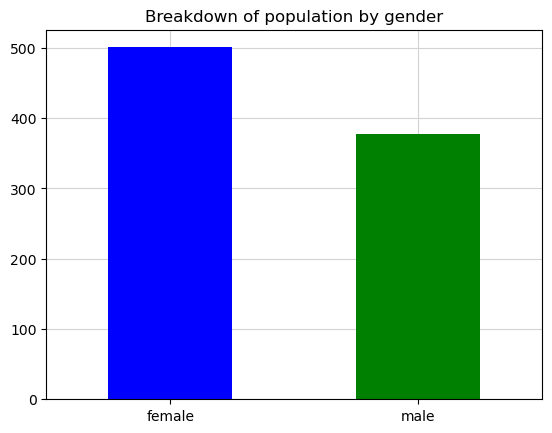

In [17]:
# Filtering the user.dat file based on the ncore process - not sure if we need this or not
user = user[user['id'].isin(np.unique(df['user']))]
user.shape


#  We consider "gender" as the sensitive attribute.
    # F is the protected value and M is the unprotected value.

#------------------------------------------------------------
'The protected and the unprotected'

user['is_pro'] = 0
for i, row in user.iterrows():
    if row['gender'] == 'F':
        user.loc[i,'is_pro'] = 1
        
# user.head(3)

#------------------------------------------------------------
'preliminary stats'

breakbygender = pd.value_counts(user['is_pro'].values,sort=False)
# print(breakbygender,'\n')

ax = breakbygender.plot(kind='bar', title='Breakdown of population by gender', color=['b', 'g'])
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1])
ax.set_xticklabels(['female', 'male'], rotation='horizontal')
ax.set_axisbelow(True)

#------------------------------------------------------------



In [18]:
breakbygender

0    501
1    378
Name: count, dtype: int64

### original ratio of women to men 

In [19]:
breakbygender.get(1) / (breakbygender.get(0) + breakbygender.get(1))

0.4300341296928328

In [20]:
breakbygender.get(1) / breakbygender.get(0)

0.7544910179640718

### number of ratings by m & w in dataset (whole)

In [21]:
user[(user['id'] == 186) & (user['gender'] == 'F')]

id gender  is_pro
185  186      F       1

In [22]:
np.any((user['id'] == 186) & (user['gender'] == 'F'))

True

In [23]:
f_rating_count = 0 
m_rating_count = 0

for a, b in df.groupby('user'):
    if np.any((user['id'] == a) & (user['gender'] == 'F')):
        f_rating_count += len(b)
    else:
        m_rating_count += len(b)
        
print(f_rating_count)
print(m_rating_count)
        

223486
440938


In [24]:
# probability oof rating by a woman
f_rating_count/(f_rating_count+m_rating_count)


0.3363605167784427

## Rating Distribution 

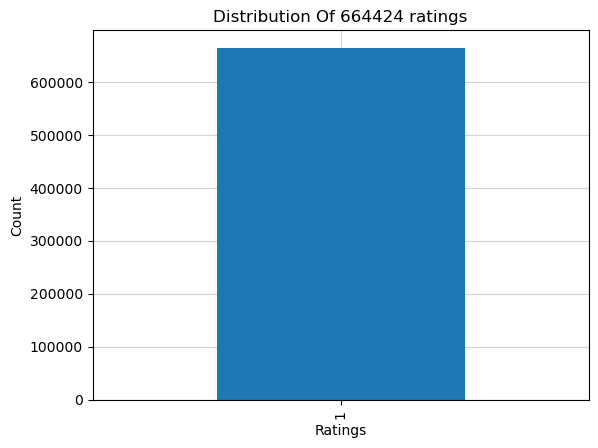

In [25]:
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
# ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)


In [26]:
data

rating
1    664424
Name: count, dtype: int64

In [27]:
# df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating']

### Rating distribution by gender

Text(0, 0.5, 'Count')

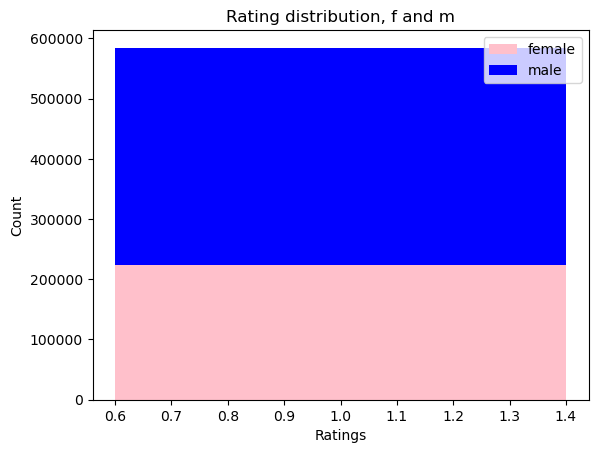

In [28]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])]['rating'].value_counts().sort_index(ascending=False)
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])]['rating'].value_counts().sort_index(ascending=False)


# ax = data_f.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))
# ax = data_m.bar(title='Distribution Of {} ratings for men and women'.format(df.shape[0]))

plt.bar(data_f.index, data_f, color='pink')
plt.bar(data_m.index, data_m, bottom=data_f, color='b')

plt.title('Rating distribution, f and m')
plt.legend(['female', 'male'])
# # plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')
# plt.grid(color='lightgray', which='major')
# plt.show()


In [29]:
data_f

rating
1    223486
Name: count, dtype: int64

In [30]:
data_m

rating
1    360942
Name: count, dtype: int64

In [31]:
data_f / (data_f + data_m)

rating
1    0.382401
Name: count, dtype: float64

In [32]:
data_m / (data_f + data_m)

rating
1    0.617599
Name: count, dtype: float64

70% of the ratings belong to men approximately. Their view probably affects the general view.

### Ratings Distribution By Item

Text(0, 0.5, 'Count')

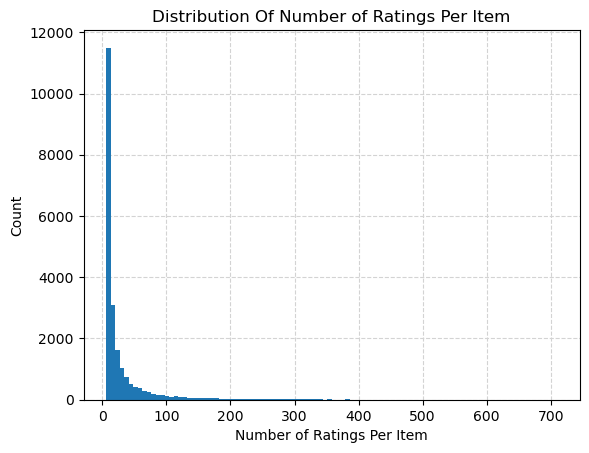

In [33]:
# Number of ratings per movie
data = df.groupby('item')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per Item', bins=100)
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per Item')
ax.set_ylabel('Count')


#### By gender

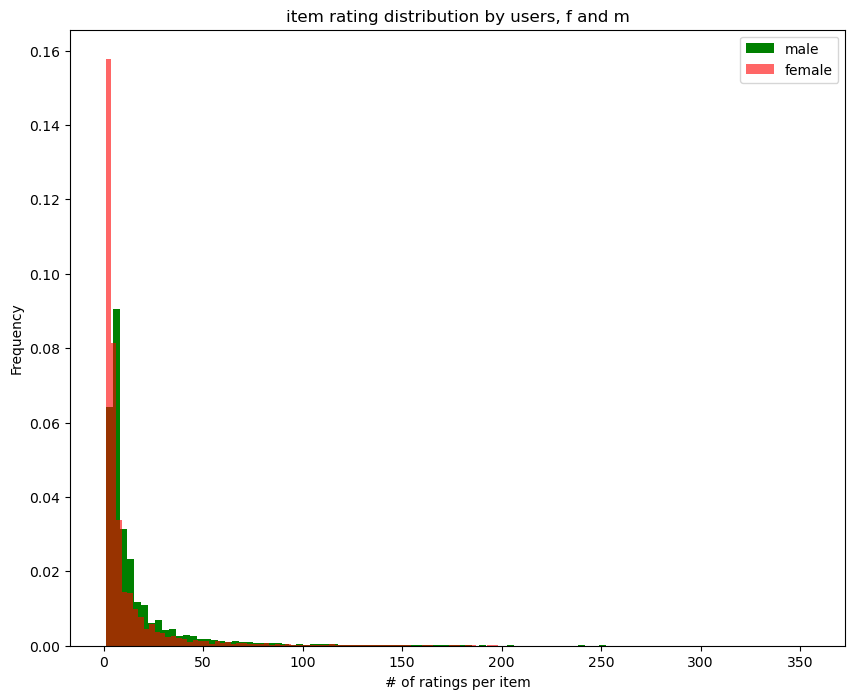

In [34]:
data_f = df[(df['user']).isin(user.loc[user['gender'] == 'F', 'id'])].groupby('item')['rating'].count()
data_m = df[(df['user']).isin(user.loc[user['gender'] == 'M', 'id'])].groupby('item')['rating'].count()


#Stack the data
plt.figure(figsize=(10,8))
# plt.hist([data_f, data_m], stacked=True, density=True)
# ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
# ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')
ax = data_m.plot.hist(bins=100, label='male', density=1, color='green')
ax = data_f.plot.hist(bins=100, label='female', alpha=0.6,density=1, color='red')


ax.set_title('item rating distribution by users, f and m')
ax.set_xlabel('# of ratings per item')
ax.legend()
plt.show()


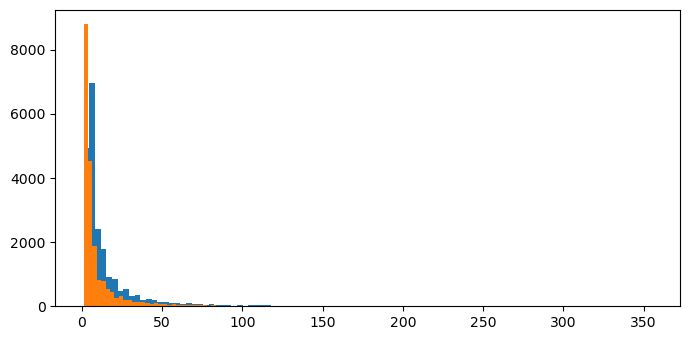

In [35]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
# a = np.random.random(100) * 0.5
# b = 1 - np.random.normal(size=100) * 0.1
bins = 100
b = np.histogram(np.hstack((data_f, data_m)), bins=bins)[1]
plt.hist(data_m, bins)
plt.hist(data_f, bins) # edgecolor='black'

plt.show()

- women have less ratings than men in general
- the long tail is shorter (but probably the controvertial items)
- their ratings are more focused on the popular items
- women's ratings of more popular items are more while men's ratings are more diverse and on more items.
    - so then shouldn't women receive good ratings because they are close to the majority of users?

- @INSIGHT: many of the items that are removed actually were rated by women! wth! we have many cold start users that are women! 
- all the users have at least 20 ratings, but after the ncore, some of them are removed. in the long tail there are items that are rated by men and women but are removed after the ncore. This could exacerbate the accuracy imbalance.
- we should try the data as is as well.
- there are some items that are only rated by men or women! specially in the long tail.


- we have some nan values below

In [36]:
ratings_f_m = pd.DataFrame([data_f,data_m])
ratings_f_m

item    5      10     11     14     16     17     18     19     20     22     \
rating    9.0    5.0   24.0    2.0    2.0   11.0   52.0   17.0    3.0    3.0   
rating   36.0   18.0   41.0    6.0   14.0   17.0   82.0   17.0    6.0   11.0   

item    ...  79863  81118  82242  82275  84021  84481  84516  84841  86029  \
rating  ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
rating  ...    5.0    8.0    6.0    4.0    7.0    5.0    3.0    7.0    6.0   

item    86942  
rating    NaN  
rating    5.0  

[2 rows x 21733 columns]

In [37]:
# we have this many items, so the length is fine
ratings_f_m.shape

(2, 21733)

### Ratings Distribution By User

Text(0, 0.5, 'Count')

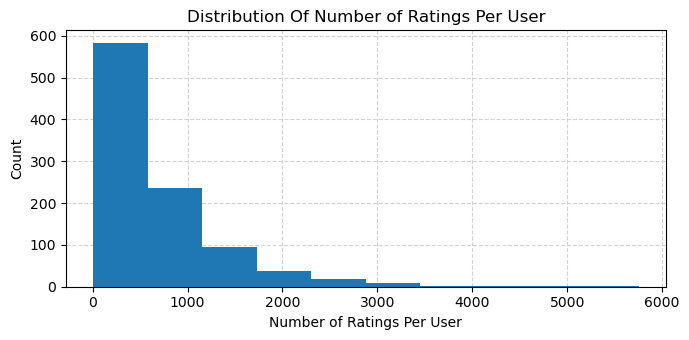

In [38]:
data = df.groupby('user')['rating'].count()#.clip(upper=50)

ax = data.plot.hist(title='Distribution Of Number of Ratings Per User')
ax.grid(True, color='lightgray', linestyle='--')
# ax.set_xticks([0,1,2,3,4])
ax.set_axisbelow(True)
ax.set_xlabel('Number of Ratings Per User')
ax.set_ylabel('Count')

In [39]:
all_results = []

In [163]:
len(all_results[0][0][1]['rmse'])

2174

# RatingDataset() class

To load a dataset from a pandas dataframe, we will use the load_from_df() method The dataframe must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.

## Split into train and test

Note that this class is based on the data class in Surprise but it is not the same or connected to it whatsoever.

In [40]:
# data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)

dataset = RatingDataset()
data_fn = './filtered_lastfm_100k_%icore.csv'%n_core
dataset.read_from_file(data_fn, skip_lines=1, line_format='user item rating', sep=',')

print('# users', dataset.user_n)
print('# items', dataset.item_n)

# user_tests is the test_mat
train_mat, test_mat = dataset.train_test_split(test_percent=0.2, least_userlen_test=10)

# ir = the pair of (item, rating)
# ir = user_ratings[user_iid][ir_idx]

user_ratings = dataset.list_users_ratings(dataset.rating_mat)
print(dataset.rating_mat.shape)

# users 986
# items 21733

Number of users with some items in testset: 980
Number of ratings in trainset: 531927 	 Number of ratings in testset: 132497

(986, 21733)


## Train & Test to Dataframes

### train set

In [41]:
user_ratings = dataset.list_users_ratings(train_mat)
# user_ratings[0]
# train_df = pd.DataFrame(columns = ['item','rating'])

tr_lst = []

for user_iid in range(dataset.user_n): 
    # trainset or dataset.user_n?? we keep the users the same (user-fixed) so they are equal.
    
    if user_ratings[user_iid]:
        base_rec = pd.DataFrame(user_ratings[user_iid])
        base_rec[2] = user_iid

        tr_lst.append(base_rec[[2,0,1]])
    
train_df = pd.concat(tr_lst, ignore_index=True)
train_df.columns = ['user','item','rating']


print('unique users',np.unique(train_df['user']).shape)
print('unique items',np.unique(train_df['item']).shape)
print(train_df.shape)

train_df.head()

unique users (986,)
unique items (21733,)
(531927, 3)


user  item  rating
0     0     2     1.0
1     0     7     1.0
2     0    17     1.0
3     0    74     1.0
4     0    88     1.0

### test set

In [42]:
# test set to a dataframe
test_lst = []

for uiid in test_mat.keys():
    base_rec = pd.DataFrame(test_mat[uiid])
    base_rec[2] = uiid
    test_lst.append(base_rec[[2,0,1]])


test_df = pd.concat(test_lst, ignore_index=True)
test_df.columns = ['user','item','rating']

print('users',np.unique(test_df['user']).shape)
print('items',np.unique(test_df['item']).shape)
print(test_df.shape)

test_df.head()

users (980,)
items (19643,)
(132497, 3)


user   item  rating
0     0   8754     1.0
1     0  20079     1.0
2     0   4580     1.0
3     0  12464     1.0
4     0   1256     1.0

In [43]:
test_df.shape[0] + train_df.shape[0]

664424

## rating distribution of  training set and test set

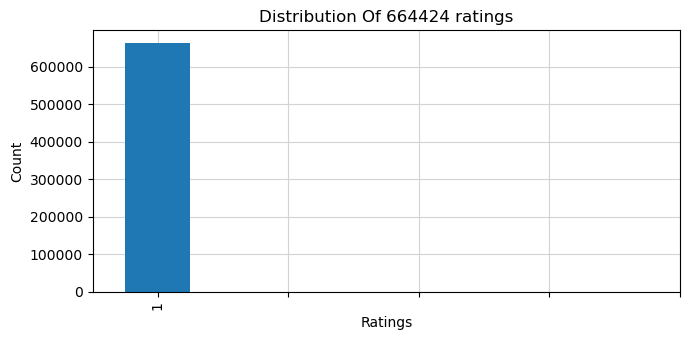

In [44]:
# all_d = pd.concat([train_df, test_df], ignore_index=True).drop_duplicates(keep=False)
# print(all_d.shape)
# df.equals(all_d)b
data = df['rating'].value_counts().sort_index(ascending=True)

ax = data.plot(kind='bar', title='Distribution Of {} ratings'.format(df.shape[0]))
ax.grid(True, color='lightgray', linestyle='-')
ax.set_xticks([0,1,2,3,4])
ax.set_xlabel('Ratings')
ax.set_ylabel('Count')
ax.set_axisbelow(True)

Index([1.0], dtype='float64', name='rating')
Index([1.0], dtype='float64', name='rating')


Text(0, 0.5, 'Count')

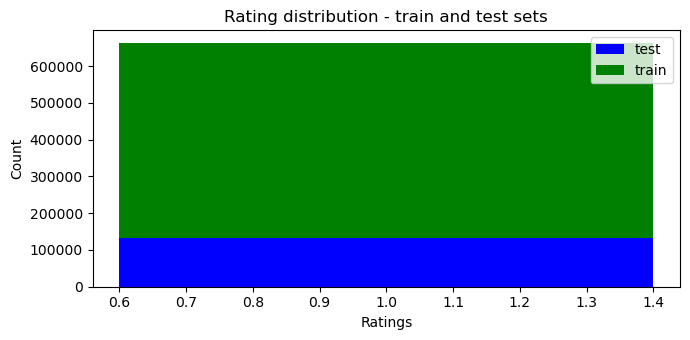

In [45]:
data_tr = train_df['rating'].value_counts().sort_index(ascending=False)
data_ts = test_df['rating'].value_counts().sort_index(ascending=False)

print(data_tr.index)
print(data_ts.index)

plt.bar(data_ts.index, data_ts, color='b')
plt.bar(data_tr.index, data_tr, bottom=data_ts, color='g')

plt.title('Rating distribution - train and test sets')
plt.legend(['test', 'train'])
# plt.grid(True, color='lightgray', linestyle='-')
# plt.set_xticks([0,1,2,3,4])
plt.xlabel('Ratings')
plt.ylabel('Count')

## Pro and Unpro - id to iid (ID to Index)

In [46]:
user.dtypes
# turn user id into string so you can retrieve int iid

id         int64
gender    object
is_pro     int64
dtype: object

In [47]:
'pro & unpro data structures'

# global pro_users_id
# global unpro_users_id

# pro_users_id = []
# unpro_users_id = []

global pro_users_index
global unpro_users_index

pro_users_index = []
unpro_users_index = []


# initializing a column
# this is inner id or index
user['iid'] = 0

for i, row in user[['id', 'is_pro']].iterrows():
    
    # user id to inner_id (index)
    u_index = dataset.user_to_iid[str(row['id'])]
    # print(row['id'], u_index, dataset.user_to_ID[u_index])
    
    # just add the inner id (index) to the user dataframe
    user.loc[user['id']==row['id'], 'iid'] = u_index
    
    
    if row['is_pro'] == 1:
        # pro_users_id.append(row['id'])
        pro_users_index.append(u_index)
    
    else:
        # unpro_users_id.append(row['id'])
        unpro_users_index.append(u_index)  


print('protected users', len(pro_users_index))
print('unprotected users', len(unpro_users_index))
print()

user.head(5)


protected users 378
unprotected users 501



id gender  is_pro  iid
0   1      M       0  879
1   2      F       1  285
2   3      M       0   74
3   4      F       1  483
4   5      M       0  958

### iid 2 gender & reverse

In [48]:
# dictionary of iid and gender

iid_to_gender = dict(zip(user.iid, user.gender))
# gender_to_iid = dict(zip(user.gender, user.iid))

id_to_gender = dict(zip(user.id, user.gender))
# gender_to_id = dict(zip(user.gender, user.id))


### Deepcopy train & test w gender info

In [49]:
#copy training set
# it won't affect train_df, only the copy has an extra column
train_df_cp = train_df.copy(deep=True)
test_df_cp = test_df.copy(deep=True)


train_df_cp['gender'] = train_df['user'].map(iid_to_gender)
test_df_cp['gender'] = test_df['user'].map(iid_to_gender)

### rating , gender, count (tr, ts)

In [50]:
m_f_cnt = []
for a, b in train_df_cp.groupby(['rating', 'gender']):
    m_f_cnt.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt, '\n') 
print()

m_f_cnt_ts = []
for a, b in test_df_cp.groupby(['rating', 'gender']):
    m_f_cnt_ts.append((float(a[0]), a[1], int(len(b))))
    print(a, len(b))
    
# print(m_f_cnt_ts)

(1.0, 'F') 178945
(1.0, 'M') 288938

(1.0, 'F') 44541
(1.0, 'M') 72004


In [51]:
np.array(m_f_cnt)[::2, :]

array([['1.0', 'F', '178945']], dtype='<U32')

In [52]:
np.array(m_f_cnt)[::-2, :][::-1]

array([['1.0', 'M', '288938']], dtype='<U32')

### plot ratings sep by gender and tr/ts

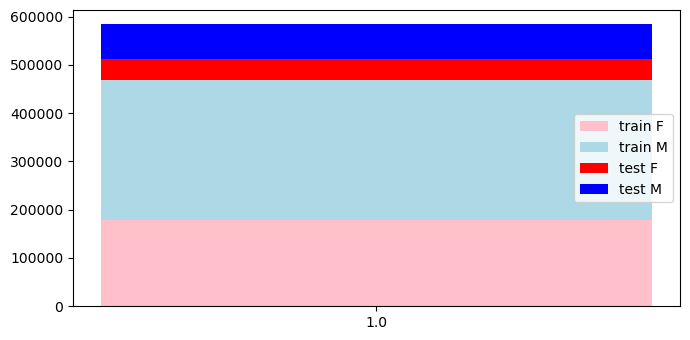

In [53]:


# female train
f_tr = np.array(m_f_cnt)[::2, :]
plt.bar(f_tr[:, 0], f_tr[:, 2].astype(int), color='pink', label='train F')

m_tr = np.array(m_f_cnt)[::-2, :][::-1]
plt.bar(m_tr[:, 0], m_tr[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int), color='lightblue', label='train M')



# test set
f_ts = np.array(m_f_cnt_ts)[::2, :]
plt.bar(f_ts[:, 0], f_ts[:, 2].astype(int),
        bottom=f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int), 
        color='red', label='test F')

m_ts = np.array(m_f_cnt_ts)[::-2, :][::-1]
plt.bar(m_ts[:, 0], m_ts[:, 2].astype(int),
        bottom = f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int) + f_ts[:, 2].astype(int),
        color='blue', label='test M')


plt.legend()

### ratio of women to men in train and text

In [54]:

print('training set')
# train f
p_f_r = f_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))
p_m_r = m_tr[:, 2].astype(int) / (f_tr[:, 2].astype(int) + m_tr[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' +
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r))
# print(p_f_r + p_m_r)



print('\n\ntest set')
p_f_r_ts = f_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))
p_m_r_ts = m_ts[:, 2].astype(int) / (f_ts[:, 2].astype(int) + m_ts[:, 2].astype(int))

print(('prob Fem given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_f_r_ts))
print()
print(('prob Mal given rating \t one {0} \n\t\t\t two {1} \n\t\t\t three {2} ' + 
      '\n\t\t\t four {3} \n\t\t\t five {4}').format(*p_m_r_ts))



training set


IndexError: Replacement index 1 out of range for positional args tuple

The ratio oof men and women in train and test is similar. The probability of being a women given you have rated an item one is 30% which is higher than other ratings.

# Q: What is this? for the ratios of ratings?

### rating cnt, avg, median of ratings for m and f (TRAINING SET)

- if the distribution is symmetrical mean and meadian will be the same
- if the dist is skewed to the right (positively skewed, or the right side is thinner), it means that smaller numbers are more, then the median becomes one fo those small numbers. Since mean changes when when a few big numbers are added, mean becomes bigger. So median will be smaller than the mean.
- if it is skewed to the left or negatively skewed, the big numbers are more and so the median is a big number. the mean changes and becomes smaller as small numbers are added to it, so the median becomes bigger than the mean.
- so if median > mean, the dist is left skewed, so higher ratings are more common.
- if the median < mean, the dist is right skewed, so lower ratings are more common.
- is the difference statistically significant or not?

#### train set

In [55]:
# training set
# this is calcualted based on the training set only


# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(train_df_cp.item)):
    item_f_m_cnt_dic[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in train_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt = pd.DataFrame.from_dict(item_f_m_cnt_dic, orient='index').reset_index()
item_f_m_cnt.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt.shape)
item_f_m_cnt.head()



(21733, 7)


item_iid   F_c   M_c  F_med  F_avg  M_med  M_avg
0         0   1.0   4.0    1.0    1.0    1.0    1.0
1         1   1.0   4.0    1.0    1.0    1.0    1.0
2         2  19.0  53.0    1.0    1.0    1.0    1.0
3         3   0.0   3.0    0.0    0.0    1.0    1.0
4         4  51.0  68.0    1.0    1.0    1.0    1.0

#### test set

In [56]:
# a dictionary of the number of ratings an item has received from men and women separately
# a dictionary of median and avg of rating of men & women on an item
item_f_m_cnt_dic_ts = {} 


# starting from here, in case an item is not rated by one gender
for item in list(np.unique(test_df_cp.item)):
    item_f_m_cnt_dic_ts[item] = {'F_c':0., 'M_c':0., 'F_med':0., 'F_avg':0.,'M_med':0., 'M_avg':0.} 

    
for a, b in test_df_cp.groupby(['item', 'gender']):
    
    # how many ratings, rating count
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_c'] += len(b)
    
    # median and mean
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_med'] += b['rating'].median()
    item_f_m_cnt_dic_ts[a[0]][a[1]+'_avg'] += b['rating'].mean()

    
# print(item_f_m_cnt_dict)

item_f_m_cnt_ts = pd.DataFrame.from_dict(item_f_m_cnt_dic_ts, orient='index').reset_index()
item_f_m_cnt_ts.rename(columns={'index':'item_iid'}, inplace=True)

print()
print(item_f_m_cnt_ts.shape)
item_f_m_cnt_ts.head()



(19643, 7)


item_iid   F_c   M_c  F_med  F_avg  M_med  M_avg
0         0   1.0   1.0    1.0    1.0    1.0    1.0
1         1   0.0   3.0    0.0    0.0    1.0    1.0
2         2   3.0  19.0    1.0    1.0    1.0    1.0
3         3   0.0   0.0    0.0    0.0    0.0    0.0
4         4  16.0  14.0    1.0    1.0    1.0    1.0

- NOTE: if there zeros it only means that there were not any ratings! there are no ratings of zero!
- keep that in mind while doing the comparisions!

# Consumer-Side Fairness Metrics

note that iid here means item-id not inner-id

- 0: uid,    
- 1: iid,    
- 2:r_ui,    
- 3: est


- g: disadvantaged,    
- -g: advantaged

## Common Functions 

### Average Score

In [57]:

def avg_score(df_i, itemid, users, est=False): 
    if est:
        pred_type = 'est'
    else:
        pred_type = 'r_ui'
        
    f_df = df_i.loc[(df_i['uid']).isin(users), pred_type]
    
    return f_df.mean()

### Separate Preds for Pro & Unpro

In [58]:
def seperate_preds(preds):
    
    pro_preds = []
    unpro_preds = []

    for row in preds:
        # check here: pro_users_index
        if row.uid in pro_users_index:
            pro_preds.append(row)
        else:
            unpro_preds.append(row)
            
    return pro_preds, unpro_preds

### Pro & Upro Counts

In [59]:
#  not sure if I use this function at all!
def pro_unpro_count(preds):
    
    pros= []
    unpros =[]
    
    for row in preds:
        if row.uid in pro_users_index:
            pros.append(row.uid)
        else:
            unpros.append(row.uid)
            
    return np.unique(pros), np.unique(unpros)

### Item Eligibility (for c-fairness metrics)

- ISSUE: if an item is not rated by a group, the average rating of that group will be NaN as well as the final output.

To avoid this issue, we calculate the consumer-side fairness metrics over items that were rated by both groups (Pro & Unpro).

- NOTE: Therefore all the metrics below are calcualted over the common items.

In [60]:
def is_i_eligible(item_df):
    
    # if there is only one rating, return False
    cond_a = len(item_df) >= 2
    
    #check here: pro_users_index, is item_df['uid] == item_df['uid'].tolist() ?
    if cond_a:
        # if this item has ratings from both the protected and unprotected user groups
        cond_b = np.any(np.any((item_df['uid']).isin(pro_users_index)) and
                       np.any((item_df['uid']).isin(unpro_users_index)))
        return cond_b
    
    return False

## Value Fairness

In [61]:
def value_unfairness(p_df):
    
    '''
    value unfairness, measures inconsistency in signed estimation error across the user types
    
    Value unfairness occurs when one class of user is consistently given higher or lower predictions
    than their true preferences. If the errors in prediction are evenly balanced between overestimation
    and underestimation or if both classes of users have the same direction and magnitude of error, the
    value unfairness becomes small. Value unfairness becomes large when predictions for one class
    are consistently overestimated and predictions for the other class are consistently underestimated.
    '''
    
    sum_err = 0.0
    for itemid in np.unique(p_df['iid']):

        item_df = p_df[p_df['iid'] == itemid]
        
        # skip the item that doesn't have more than 2 ratings or ratings from both pro & unpro
        if not is_i_eligible(item_df):
            continue

        e_g_y = avg_score(item_df, itemid, pro_users_index, est=True)
        e_g_r = avg_score(item_df, itemid, pro_users_index, est=False)
        
        e_ng_y = avg_score(item_df, itemid, unpro_users_index, est=True)
        e_ng_r = avg_score(item_df, itemid, unpro_users_index, est=False)
        
        sum_err += abs((e_g_y - e_g_r) - (e_ng_y - e_ng_r))
    
    # if non of the items had any ratings. it's a rare condition.
    if sum_err == 0:
        return 'ERROR: non of the items had any ratings.'
        
    return sum_err/np.unique(p_df['iid']).size

In [62]:
print('# of ratings', len(df['rating'].tolist()))

# of ratings 664424


In [63]:
# value_unfairness(pd.DataFrame(predictions_al_p))

## Nonparity

In [64]:
def non_parity(p_df):
    
    '''
    nonparity measure based on the regularization term introduced by Kamishima et al. 
    can be computed as the absolute difference between the overall average ratings of disadvantaged users 
    and those of advantaged users.
    '''
    e_g_y = p_df.loc[(p_df['uid']).isin(pro_users_index), 'est'].mean()
    e_ng_y = p_df.loc[(p_df['uid']).isin(unpro_users_index), 'est'].mean()
    
    return abs(e_g_y - e_ng_y)

# Active Learning

### number of iterations/epocs

In [65]:
train_df.shape

(531927, 3)

### item_ratings

-  a dictionary of item iid and the (user_iid, rating)s

In [66]:
# item ratings
# a dictionary of item iid and the (user_iid, rating)

# item_ratings = dataset.list_items_ratings(dataset.rating_mat) 
item_ratings = dataset.list_items_ratings(train_mat)

# print(len(item_ratings[3]))
print(len(item_ratings))


Processing item 21732: 100%|████████████████| 21733/21733 [27:29<00:00, 13.17it/s]

21733


In [67]:
dataset.item_n

21733

In [68]:
range(dataset.item_n)

range(0, 21733)

## Attention-based Popularity

Attention-based. This group of strategies focus on selecting the
items that have received the highest “attention” among the
users. Such items are likely to be known by the users, and
therefore they can be rated by them. Hence, these strategies
usually add a lot of ratings. These strategies are
simple and easy to implement and they were introduced
in the initial attempts to solve the cold start problem in
collaborative filtering. They are considered as baseline
strategies.

Popularity: selects the most popular items, i.e., those
with the highest number of ratings. It is very likely that the
users are able to rate these items and consequently the
size of the rating dataset can be increased. However,
popular items are typically widely liked by the users.
Therefore, their ratings usually bring little information
to the system. Moreover, this strategy may cause the
*prefix bias*, i.e., the system trained with ratings for
popular items tend also to recommend these popular
items, making them even more popular.

### Order the items in the training set based on their popularity

In [69]:
# based on the training set
item_pop_df = pd.DataFrame(train_df.groupby('item')['rating'].count()).sort_values(by='rating', 
                                                                                    ascending=False).reset_index()

item_pop_df.columns = ['item_iid','popularity']

print (item_pop_df.shape)

item_pop_df.head()

(21733, 2)


item_iid  popularity
0     11809         576
1      5093         519
2     20037         489
3      3483         468
4      2755         464

### Sorting the dataset based on the item popularity

In [70]:
# computing the item counts
item_pop_df = []
# pd.DataFrame(columns=['item_iid','popularity'])

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_pop_df.append((item_iid,len(item_ratings[item_iid]))) 
    
item_pop_df = pd.DataFrame(item_pop_df, columns=['item_iid','popularity'])
item_pop_df.sort_values(by='popularity', ascending=False, ignore_index=True, inplace=True)

print(item_pop_df.head())
# to see if this was equal to the previous way of creating this dataframe
# (np.array(item_pop_df) == np.array(item_pop_df)).all()

print(item_pop_df.shape)

   item_iid  popularity
0     11809         576
1      5093         519
2     20037         489
3      3483         468
4      2755         464
(21733, 2)


## Attention-based Square(Popularity) * Variance

### Normalized Popularity 

In [71]:
# normalize popularity scores

item_pop_df['norm_pop'] = 0

min_pop = item_pop_df['popularity'].tolist()[-1]
max_pop = item_pop_df['popularity'].tolist()[0]

for inx, row in item_pop_df.iterrows():
    item_pop_df.loc[inx, 'norm_pop'] = ((row['popularity'] - min_pop) / (max_pop - min_pop))
    
item_pop_df.head()


item_iid  popularity  norm_pop
0     11809         576  1.000000
1      5093         519  0.900870
2     20037         489  0.848696
3      3483         468  0.812174
4      2755         464  0.805217

In [72]:
print (item_pop_df.shape)

(21733, 3)


### Item Sqrt(norm pop) * Variance

- note that the calcualtion of variance in numpy and dataframe isn't the same

- Note: sometimes some of these items end up with no ratings and this shows an error!

In [73]:
# computing the item variance
item_var_df = []
#

# question: apparently we are item-fixed and user-fixed. the number of items is the same in train and test sets!
# be careful about this.
for item_iid in range(dataset.item_n):
    item_var_df.append((item_iid, np.array(item_ratings[item_iid])[:,1].var(),
                        (np.array(item_ratings[item_iid])[:,1].var()) * np.sqrt(item_pop_df.loc[item_pop_df['item_iid'] == item_iid,'norm_pop'].values[0])))


item_var_df = pd.DataFrame(item_var_df, columns=['item_iid','variance', 'sqrt pop x var'])
# sorting based on sqrt(norm popularity) * variance
item_popvar_df = item_var_df.sort_values(by='sqrt pop x var', ascending=False, ignore_index=True)

print(item_popvar_df.shape)
item_popvar_df.head()


(21733, 3)


item_iid  variance  sqrt pop x var
0         0       0.0             0.0
1     14486       0.0             0.0
2     14494       0.0             0.0
3     14493       0.0             0.0
4     14492       0.0             0.0

## Uncertainty Reduction Based on Variance

In [74]:
# sorting based on variance
item_uc_var_df = item_var_df.sort_values(by='variance', ascending=False, ignore_index=True)

print(item_uc_var_df.shape)
item_uc_var_df.head()



(21733, 3)


item_iid  variance  sqrt pop x var
0         0       0.0             0.0
1     14486       0.0             0.0
2     14494       0.0             0.0
3     14493       0.0             0.0
4     14492       0.0             0.0

### item table

In [75]:
item_f_m_cnt['pop'] = 0
item_f_m_cnt['normpop'] = 0
item_f_m_cnt['var'] = 0
item_f_m_cnt['sqrt normpopvar'] = 0


for itemid in item_f_m_cnt['item_iid'].tolist():
    
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'pop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'popularity'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'npop'] = item_pop_df.loc[item_pop_df['item_iid'] == itemid,
                                              'norm_pop'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                     'var'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                              'variance'].values[0]
    
    item_f_m_cnt.loc[item_f_m_cnt['item_iid'] == itemid,
                 'sqrt npopvar'] = item_popvar_df.loc[item_popvar_df['item_iid'] == itemid,
                                          'sqrt pop x var'].values[0]
    

item_f_m_cnt.head()

# item_f_m_cnt[item_f_m_cnt['item_iid'] == 1155]

# can sort it like this
# item_f_m_cnt.sort_values(by='pop', ascending=False)

item_iid   F_c   M_c  F_med  F_avg  M_med  M_avg  pop  normpop  var  \
0         0   1.0   4.0    1.0    1.0    1.0    1.0    6        0    0   
1         1   1.0   4.0    1.0    1.0    1.0    1.0    7        0    0   
2         2  19.0  53.0    1.0    1.0    1.0    1.0   78        0    0   
3         3   0.0   3.0    0.0    0.0    1.0    1.0    5        0    0   
4         4  51.0  68.0    1.0    1.0    1.0    1.0  135        0    0   

   sqrt normpopvar      npop  sqrt npopvar  
0                0  0.008696           0.0  
1                0  0.010435           0.0  
2                0  0.133913           0.0  
3                0  0.006957           0.0  
4                0  0.233043           0.0

## Surprise

In [76]:
# from surprise import BaselineOnly
from surprise import NMF, SVD, NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# from surprise.model_selection import KFold

In [77]:
reader = Reader(rating_scale=(1, 5))

# algo = SVD()

whole_df = pd.concat([train_df, test_df]).drop_duplicates(ignore_index=True)
whole_df.shape

(664424, 3)

### Grid Search & Algo Tuning

In [78]:
n_core

5

### Oracle - cheat - all data

In [103]:
tstart = datetime.now()

# SVD(n_epochs=200, n_factors=200,lr_all=0.005, reg_all=0.01, verbose=False, random_state=41023)
oracle_ = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

trainset_all_ = Dataset.load_from_df(whole_df[['user', 'item', 'rating']],reader).build_full_trainset()
testset_all_ = Dataset.load_from_df(test_df[['user', 'item', 'rating']],reader).build_full_trainset().build_testset()

oracle_.fit(trainset_all_)
fin_preds = oracle_.test(testset_all_)
fin_acc_o_ = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o_)

tend = datetime.now()  
print("\n Active learning in ms : \n")
print(tend-tstart)

0.0034190011255414384

 Active learning in ms : 

0:00:57.563935


### Accuracy on only training data

In [104]:
tstart = datetime.now()

oracle = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
    #n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)
# SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)

trainset_all = Dataset.load_from_df(train_df[['user', 'item', 'rating']],
                                    reader).build_full_trainset()
testset_all = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()

oracle.fit(trainset_all)
fin_preds = oracle.test(testset_all)
fin_acc_o = accuracy.rmse(fin_preds, verbose=False)

print(fin_acc_o)

tend = datetime.now() 
print("\n Active learning in ms : \n")
print(tend-tstart)

0.00019660344484898033

 Active learning in ms : 

0:00:12.049790


In [105]:
print(train_df.shape)
print(test_df.shape)

(531927, 3)
(132497, 3)


In [106]:
print(trainset_all.n_ratings)
print(len(testset_all))

531927
132497


## Greedy Extend

Code an Oracle in an expensive way and a cheap way

### Training without a specific item function

In [79]:
def retrain_without(item_iid, tr, tes, rec_mod):
        
    # should I remove from both train and test?
    tr_filt = tr[tr['item'] != item_iid]

#     tes_filt = tes[tes['item'] != item_iid]
    tes_filt = tes
    
    tr_temp = Dataset.load_from_df(tr_filt[['user', 'item', 'rating']],
                                   reader).build_full_trainset()
    tes_temp = Dataset.load_from_df(tes_filt[['user', 'item', 'rating']],
                                    reader).build_full_trainset().build_testset()

    rec_mod.fit(tr_temp)
    
    temp_preds = rec_mod.test(tes_temp)
    
    temp_acc = accuracy.rmse(temp_preds, verbose=False)

    return([item_iid, temp_acc])


In [80]:
np.unique(train_df['item']).size

21733

In [81]:
dataset.item_n

21733

In [82]:
np.unique(test_df['item']).size

19643

### Run: Parallel computations

- Both the training set and the test set have both items and users. we remove the items from the trianing set and calcualte the rmse on the test set. of course adding back the item will decrease RMSE! we have it in the test set! But how about how the addition ofo an item in general changes the model? In that case, we need to remove the whole item from both training set and the test set! Then we see if adding that item back will make the model better and reduces the RMSE.

In [90]:
# set the SVD model with the best parameters you could get
algo = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
# algo = SVD(n_epochs = 300, n_factors = 150, lr_all=0.005, reg_all=0.0001, verbose = False, random_state=41023)

In [91]:
# conda install multiprocess
# We are calculating the rmse for all of the training set.
# Then we remove every item one by one and see which one improves the accuracy after it's added.

start = timeit.default_timer()
import multiprocess as mp


def comp_tr(iid):
    # if the item id exists in the ncore training data (test too?)
    # if train_df[train_df['item']==item_iid].shape != 0:
    return (retrain_without(iid, train_df, test_df, algo))


if __name__ == "__main__":
    
    pool = mp.Pool(processes=15)
    results = pool.map(comp_tr, list(range(dataset.item_n)))
    
    # note that these two are the same, so we don't have to worry about the inner ides(how about the DATASET CLASS)
    # list(np.unique(train_df['item'])) == list(range(dataset.item_n))
    # Look here, you might want to run this for the WHOLE DATA!
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))
    
    

Process Time: 44937.18 secs


- the number of items in the trian and test might not be the same!

In [92]:
len(list(range(dataset.item_n)))

21733

In [93]:
np.unique(train_df['item']).shape

(21733,)

In [94]:
np.unique(test_df['item']).shape

(19643,)

### Results (item iid, rmse_without)

-  Pick the ones that reduce the error

In [107]:
fin_acc_o

0.00019660344484898033

In [108]:
# set this parameter

# which one is the final RMSE? th eone with all the data or only all the training
fin_acc = fin_acc_o
fin_acc

0.00019660344484898033

In [109]:
# new results

result_df_ge = pd.DataFrame(results, columns=['item_iid','rmse without'])
# print(result_df_ge_2.head(5), '\n')

print('rmse all', fin_acc, '\n')

result_df_ge['added rmse wo'] = fin_acc - result_df_ge['rmse without']
print(result_df_ge.head(), '\n')

# order items in terms of least addition to the rmse
result_df_sorted_ge = result_df_ge.sort_values(by='added rmse wo', ascending=True)
print(result_df_sorted_ge.head())

# we are calculating the added RMSE, therefore *negative values* are desirable!
# negative values: good values: if rmse without the item is higher than when we have it in the pool.
    # It means that item is helping decrease the RMSE which is good!
# positive values: if rmse without that item is lower than after adding it, the result is positive.
    # we don't want those items then! They increase rmse which is undesirable!
    

rmse all 0.00019660344484898033 

   item_iid  rmse without  added rmse wo
0         0      0.000203      -0.000007
1         1      0.000202      -0.000005
2         2      0.000206      -0.000009
3         3      0.000207      -0.000010
4         4      0.000212      -0.000016 

       item_iid  rmse without  added rmse wo
17176     17176      0.000215      -0.000018
15592     15592      0.000214      -0.000017
13928     13928      0.000214      -0.000017
18902     18902      0.000214      -0.000017
1351       1351      0.000214      -0.000017


# Experiments: n item(query) at a time evaluation

NOTE: we choose one or 10 item at a time and the we add all the ratings of all the users who have rated on them

In [110]:
np.unique(train_df['item']).shape[0]

21733

## Known = 0.02 set for all the algos

In [111]:

def rating_dic_to_df(rating_dic):
    lst = []

    for user_iid in range(dataset.user_n): 
    
        if rating_dic[user_iid]:
            res = pd.DataFrame(rating_dic[user_iid])
            res[2] = user_iid

            lst.append(res[[2,0,1]])
    

    df = pd.concat(lst, ignore_index=True)
    df.columns = ['user','item','rating']
    return df


#-------------------------------------------------------------

# the lower bound
initial_n = int(round((0.02 * train_df.shape[0])/dataset.user_n))
print('initial ratings', initial_n)
# initial_n = 2

candidate_user_ratings = dataset.list_users_ratings(train_mat)
initial_user_ratings = {}


for user_iid in range(dataset.user_n):
    
    initial_user_ratings[user_iid] = []
    len_u = len(candidate_user_ratings[user_iid])
    
    if len_u >= initial_n:
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        selected_u = selected_u[:initial_n][:]

        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
    
    else: # number of ratings less than required initial number
        selected_u = list(range(len_u))
        random.shuffle(selected_u)
        
        for ir_idx in selected_u:
            ir = candidate_user_ratings[user_iid][ir_idx]
            initial_user_ratings[user_iid].append(ir)
            
            
# initial dataset turned into a dataframe
initial_train_df = rating_dic_to_df(initial_user_ratings)

print(initial_train_df.shape)
print('# users: ', np.unique(initial_train_df['user']).shape)
print('# items: ', np.unique(initial_train_df['item']).shape)
print('# users in the training set', np.unique(train_df['user']).shape)
# now the number of users in the training, test and the initial data are the same!
print('# of ratings', train_df.shape)


initial ratings 11
(10824, 3)
# users:  (986,)
# items:  (5707,)
# users in the training set (986,)
# of ratings (531927, 3)


In [112]:
known_df = initial_train_df

In [113]:
known_df.shape

(10824, 3)

## Running all Strategies

In [114]:
range(dataset.item_n)

range(0, 21733)

In [115]:
train_df.shape

(531927, 3)

# ActiveLearningProcess

In [116]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        # if i_indx%100. == 0.:
        #     print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]

            # sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
            tr_iter = pd.concat([tr_iter, 
                                  tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()

        else:
            tr_iter = knw_df


        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])

        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    


################## main #######################


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}
    

    
    #------------------------ test set & algo & window ---------------------
    
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items    

    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=5)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))



while loop:  10%|██▌                      | 2174/21734 [9:13:05<82:56:20, 15.26s/it]


Process Time: 33186.84 secs


In [117]:
all_results.append(results)

In [118]:
len(all_results)

1

In [119]:
for iter_i, iter_result in enumerate(all_results):
    for strtg_i, strtg_result in enumerate(iter_result):
        strtg_name = strtg_result[0]
        pd.DataFrame.from_dict(strtg_result[1]).to_csv(f"./outputs_nonpers_lastfm/{strtg_name}_exp1_iter{iter_i}.csv",index=False)

# Results

## RMSE Comparision

In [120]:
w

10

In [121]:
n_core

5

In [122]:
rmse_df = []
for results in all_results:
    for i_strtg in range(len(results)):
        strtg_name = results[i_strtg][0]
        strtg_result = results[i_strtg][1]
        strtg_df = pd.DataFrame(strtg_result['rmse'], columns=['rmse'])
        strtg_df['strtg'] = strtg_name
        rmse_df.append(strtg_df)        
rmse_df = pd.concat(rmse_df)
rmse_df = rmse_df.reset_index()
rmse_df_grouped = rmse_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
rmse_df_grouped = rmse_df_grouped.droplevel(axis=1, level=0).reset_index()

rmse_df_grouped['ci'] = 1.95 * rmse_df_grouped['std'] / np.sqrt(rmse_df_grouped['count'])
rmse_df_grouped['ci_lower'] = rmse_df_grouped['mean'] - rmse_df_grouped['ci']
rmse_df_grouped['ci_upper'] = rmse_df_grouped['mean'] + rmse_df_grouped['ci']
rmse_df_grouped.head()

index   strtg     mean  std  count  ci  ci_lower  ci_upper
0      0      ge  0.02948  NaN      1 NaN       NaN       NaN
1      0     pop  0.02948  NaN      1 NaN       NaN       NaN
2      0  popvar  0.02948  NaN      1 NaN       NaN       NaN
3      0     ran  0.02948  NaN      1 NaN       NaN       NaN
4      0     var  0.02948  NaN      1 NaN       NaN       NaN

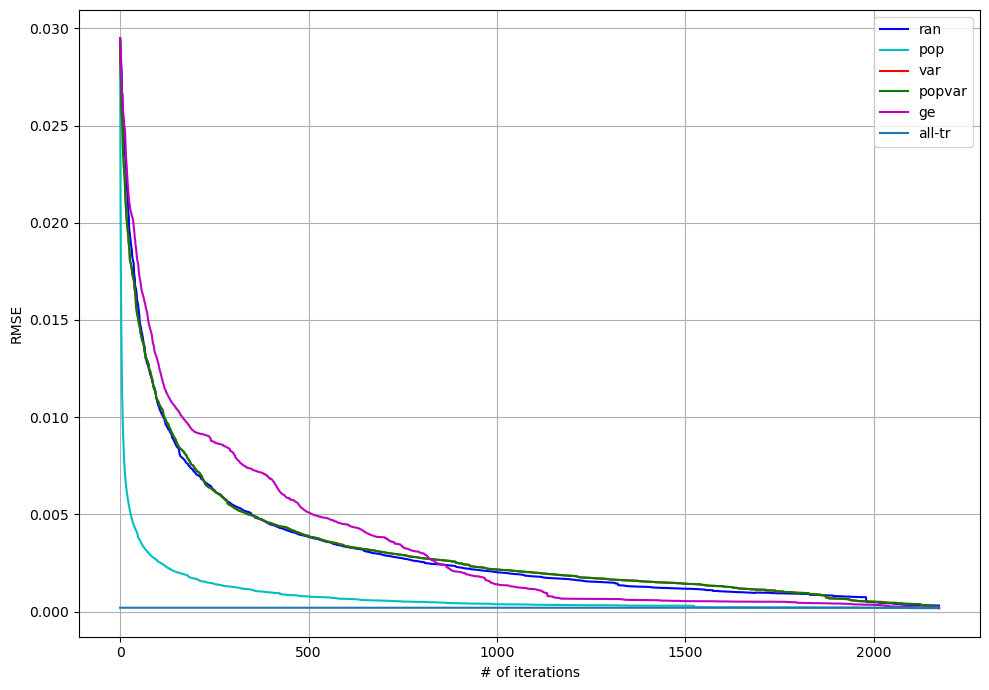

In [123]:
fig, ax = plt.subplots(figsize=(10,7))
color_l = ['b', 'c', 'r', 'g', 'm']
strtg_l = [r[0] for r in all_results[0]]

for color, strtg_name in list(zip(color_l, strtg_l)):
    strtg_rmse_df_grouped = rmse_df_grouped[rmse_df_grouped.strtg == strtg_name]
    x = strtg_rmse_df_grouped['index']
    ax.plot(x, strtg_rmse_df_grouped['mean'], color=color, label=strtg_name)
    ax.fill_between(
        x, strtg_rmse_df_grouped['ci_lower'], strtg_rmse_df_grouped['ci_upper'], color=color, alpha=.15)
ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='all-tr')
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')

#plt.savefig('./plots/NonPers_ml1m041524.png', dpi=300)

In [124]:
#fig, ax = plt.subplots(figsize=(10,7))
#marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

## y_axis = list(range(0, dataset.item_n, w))
## y_axis = list(range(0, results[i][1]['rmse']))


#for m, i in list(zip(marker_l, range(len(results)))):
#    ax.plot(list(range(0, len(results[i][1]['rmse']))), results[i][1]['rmse'], m, label=results[i][0])
#    # ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
    

#ax.plot(list(range(0, len(results[0][1]['rmse']))), [fin_acc]*len(list(range(0, len(results[0][1]['rmse'])))),'-', label='all-tr')   
## ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all-tr')           
              
#ax.grid(True)
#legend = ax.legend(loc='best')
#plt.xlabel('# of iterations')
#plt.ylabel('RMSE')
## plt.title('Non-personalized AL Strategies')

## plt.show()
#plt.savefig('./plots/NonPers012424.png', dpi=300)

## RMSE difference

In [125]:
df = []
for results in all_results:
    for i_strtg in range(len(results)):
        strtg_name = results[i_strtg][0]
        strtg_result = results[i_strtg][1]
        rmse_diff = [a-b for a, b in zip(strtg_result['rmse_pro'], strtg_result['rmse_unpro'])]
        strtg_df = pd.DataFrame(rmse_diff, columns=['rmse_diff'])
        strtg_df['strtg'] = strtg_name
        df.append(strtg_df)        
df = pd.concat(df)
df = df.reset_index()
df_grouped = df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()

df_grouped['ci'] = 1.95 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

index   strtg      mean  std  count  ci  ci_lower  ci_upper
0      0      ge  0.001443  NaN      1 NaN       NaN       NaN
1      0     pop  0.001443  NaN      1 NaN       NaN       NaN
2      0  popvar  0.001443  NaN      1 NaN       NaN       NaN
3      0     ran  0.001443  NaN      1 NaN       NaN       NaN
4      0     var  0.001443  NaN      1 NaN       NaN       NaN

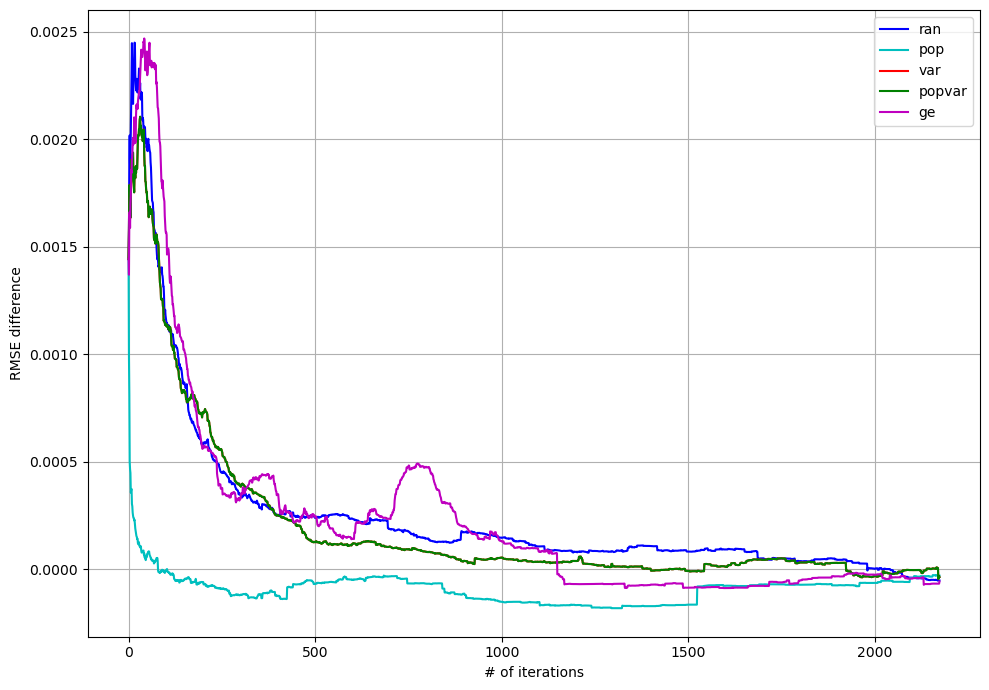

In [126]:
fig, ax = plt.subplots(figsize=(10,7))
color_l = ['b', 'c', 'r', 'g', 'm']
strtg_l = [r[0] for r in all_results[0]]

y_axis = list(range(0, dataset.item_n, w))

for color, strtg_name in list(zip(color_l, strtg_l)):
    strtg_df_grouped = df_grouped[df_grouped.strtg == strtg_name]
    x = strtg_df_grouped['index']
    ax.plot(x, strtg_df_grouped['mean'], color, label=strtg_name)
    ax.fill_between(
        x, strtg_df_grouped['ci_lower'], strtg_df_grouped['ci_upper'], color=color, alpha=.15)
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE difference')

#plt.savefig('./plots/nonpers_rmse_diff_ml1m041524.png', dpi=300)

In [127]:
#fig, ax = plt.subplots(figsize=(10,7))
#marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

#y_axis = list(range(0, dataset.item_n, w))

#for m, i in list(zip(marker_l, range(len(results)))):
    
#    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
#    ax.plot(list(range(0, len(results[i][1]['rmse']))), rmse_diff, m, label=results[i][0])
#    # ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
#ax.grid(True)
#legend = ax.legend(loc='best')
#plt.xlabel('# of iterations')
#plt.ylabel('RMSE difference')
## plt.title('Unfairness in different AL methods')

## plt.show()
#plt.savefig('./plots/nonpers_rmse_diff_ml012424.png', dpi=300)

## The RMSE of each groups separately

In [128]:
pro_df = []
unpro_df = []
for results in all_results:
    for i_strtg in range(len(results)):
        strtg_name = results[i_strtg][0]
        strtg_result = results[i_strtg][1]
        
        strtg_pro_df = pd.DataFrame(strtg_result['rmse_pro'], columns=['rmse_pro'])
        strtg_pro_df['strtg'] = strtg_name
        pro_df.append(strtg_pro_df)

        strtg_unpro_df = pd.DataFrame(strtg_result['rmse_unpro'], columns=['rmse_unpro'])
        strtg_unpro_df['strtg'] = strtg_name
        unpro_df.append(strtg_unpro_df)

pro_df = pd.concat(pro_df)
pro_df = pro_df.reset_index()
pro_df_grouped = pro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
pro_df_grouped = pro_df_grouped.droplevel(axis=1, level=0).reset_index()

pro_df_grouped['ci'] = 1.95 * pro_df_grouped['std'] / np.sqrt(pro_df_grouped['count'])
pro_df_grouped['ci_lower'] = pro_df_grouped['mean'] - pro_df_grouped['ci']
pro_df_grouped['ci_upper'] = pro_df_grouped['mean'] + pro_df_grouped['ci']
pro_df_grouped.head()

index   strtg     mean  std  count  ci  ci_lower  ci_upper
0      0      ge  0.03043  NaN      1 NaN       NaN       NaN
1      0     pop  0.03043  NaN      1 NaN       NaN       NaN
2      0  popvar  0.03043  NaN      1 NaN       NaN       NaN
3      0     ran  0.03043  NaN      1 NaN       NaN       NaN
4      0     var  0.03043  NaN      1 NaN       NaN       NaN

In [129]:
unpro_df = pd.concat(unpro_df)
unpro_df = unpro_df.reset_index()
unpro_df_grouped = unpro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
unpro_df_grouped = unpro_df_grouped.droplevel(axis=1, level=0).reset_index()

unpro_df_grouped['ci'] = 1.95 * unpro_df_grouped['std'] / np.sqrt(unpro_df_grouped['count'])
unpro_df_grouped['ci_lower'] = unpro_df_grouped['mean'] - unpro_df_grouped['ci']
unpro_df_grouped['ci_upper'] = unpro_df_grouped['mean'] + unpro_df_grouped['ci']
unpro_df_grouped.head()

index   strtg      mean  std  count  ci  ci_lower  ci_upper
0      0      ge  0.028987  NaN      1 NaN       NaN       NaN
1      0     pop  0.028987  NaN      1 NaN       NaN       NaN
2      0  popvar  0.028987  NaN      1 NaN       NaN       NaN
3      0     ran  0.028987  NaN      1 NaN       NaN       NaN
4      0     var  0.028987  NaN      1 NaN       NaN       NaN

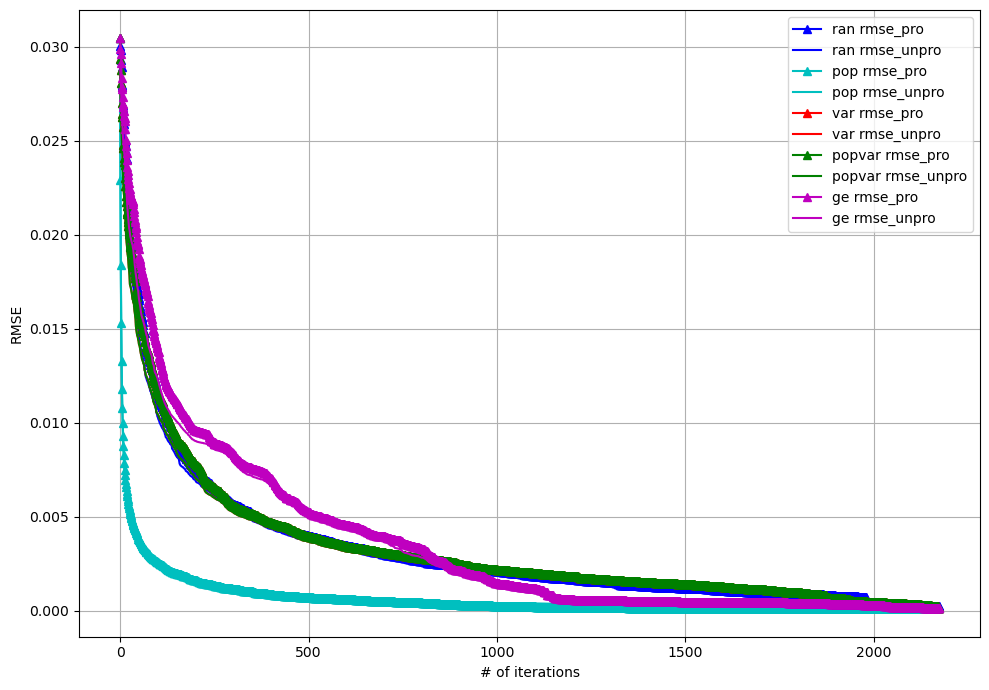

In [130]:
fig, ax = plt.subplots(figsize=(10,7))
color_l = ['b', 'c', 'r', 'g', 'm']
strtg_l = [r[0] for r in all_results[0]]

y_axis = list(range(0, dataset.item_n, w))

for color, strtg_name in list(zip(color_l, strtg_l)):
    strtg_pro_df_grouped = pro_df_grouped[pro_df_grouped.strtg == strtg_name]
    x = strtg_pro_df_grouped['index']
    ax.plot(x, strtg_pro_df_grouped['mean'], color+'-^', label=strtg_name+' rmse_pro')
    ax.fill_between(
        x, strtg_pro_df_grouped['ci_lower'], strtg_pro_df_grouped['ci_upper'], color=color, alpha=.15)

    strtg_unpro_df_grouped = unpro_df_grouped[unpro_df_grouped.strtg == strtg_name]
    x = strtg_unpro_df_grouped['index']
    ax.plot(x, strtg_unpro_df_grouped['mean'], color, label=strtg_name+' rmse_unpro')
    ax.fill_between(
        x, strtg_unpro_df_grouped['ci_lower'], strtg_unpro_df_grouped['ci_upper'], color=color, alpha=.15)
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('RMSE')

#plt.savefig('./plots/proUnpro_rmse_diff_ml1m041524.png', dpi=300)

In [131]:
#fig, ax = plt.subplots(figsize=(10,7))
#marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

#y_axis = list(range(0, dataset.item_n, w))
#list(range(0, len(results[i][1]['rmse'])))


#for m, i in list(zip(marker_l, range(len(results)))):
    
#    ax.plot(list(range(0, len(results[i][1]['rmse_pro']))), results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
#    ax.plot(list(range(0, len(results[i][1]['rmse_unpro']))), results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
#    # ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
#    # ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
#ax.grid(True)
#legend = ax.legend(loc='best')
#plt.xlabel('# of iterations')
#plt.ylabel('RMSE')
## plt.title('RMSE Plors for Pro & Unpro')
## plt.show()
#plt.savefig('./plots/proUnpro_rmse_diff_ml012424.png', dpi=300)

## The count of men and women that their info was added at each iteration

In [132]:
pro_df = []
unpro_df = []
for results in all_results:
    for i_strtg in range(len(results)):
        strtg_name = results[i_strtg][0]
        strtg_result = results[i_strtg][1]
        
        strtg_pro_df = pd.DataFrame(strtg_result['c_pro'], columns=['c_pro'])
        strtg_pro_df['strtg'] = strtg_name
        pro_df.append(strtg_pro_df)

        strtg_unpro_df = pd.DataFrame(strtg_result['c_unpro'], columns=['c_unpro'])
        strtg_unpro_df['strtg'] = strtg_name
        unpro_df.append(strtg_unpro_df)

pro_df = pd.concat(pro_df)
pro_df = pro_df.reset_index()
pro_df_grouped = pro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
pro_df_grouped = pro_df_grouped.droplevel(axis=1, level=0).reset_index()

pro_df_grouped['ci'] = 1.95 * pro_df_grouped['std'] / np.sqrt(pro_df_grouped['count'])
pro_df_grouped['ci_lower'] = pro_df_grouped['mean'] - pro_df_grouped['ci']
pro_df_grouped['ci_upper'] = pro_df_grouped['mean'] + pro_df_grouped['ci']
pro_df_grouped.head()

index   strtg    mean  std  count  ci  ci_lower  ci_upper
0      0      ge  4148.0  NaN      1 NaN       NaN       NaN
1      0     pop  4148.0  NaN      1 NaN       NaN       NaN
2      0  popvar  4148.0  NaN      1 NaN       NaN       NaN
3      0     ran  4148.0  NaN      1 NaN       NaN       NaN
4      0     var  4148.0  NaN      1 NaN       NaN       NaN

In [133]:
unpro_df = pd.concat(unpro_df)
unpro_df = unpro_df.reset_index()
unpro_df_grouped = unpro_df.groupby(['index', 'strtg']).agg(['mean', 'std', 'count'])
unpro_df_grouped = unpro_df_grouped.droplevel(axis=1, level=0).reset_index()

unpro_df_grouped['ci'] = 1.95 * unpro_df_grouped['std'] / np.sqrt(unpro_df_grouped['count'])
unpro_df_grouped['ci_lower'] = unpro_df_grouped['mean'] - unpro_df_grouped['ci']
unpro_df_grouped['ci_upper'] = unpro_df_grouped['mean'] + unpro_df_grouped['ci']
unpro_df_grouped.head()

index   strtg    mean  std  count  ci  ci_lower  ci_upper
0      0      ge  6676.0  NaN      1 NaN       NaN       NaN
1      0     pop  6676.0  NaN      1 NaN       NaN       NaN
2      0  popvar  6676.0  NaN      1 NaN       NaN       NaN
3      0     ran  6676.0  NaN      1 NaN       NaN       NaN
4      0     var  6676.0  NaN      1 NaN       NaN       NaN

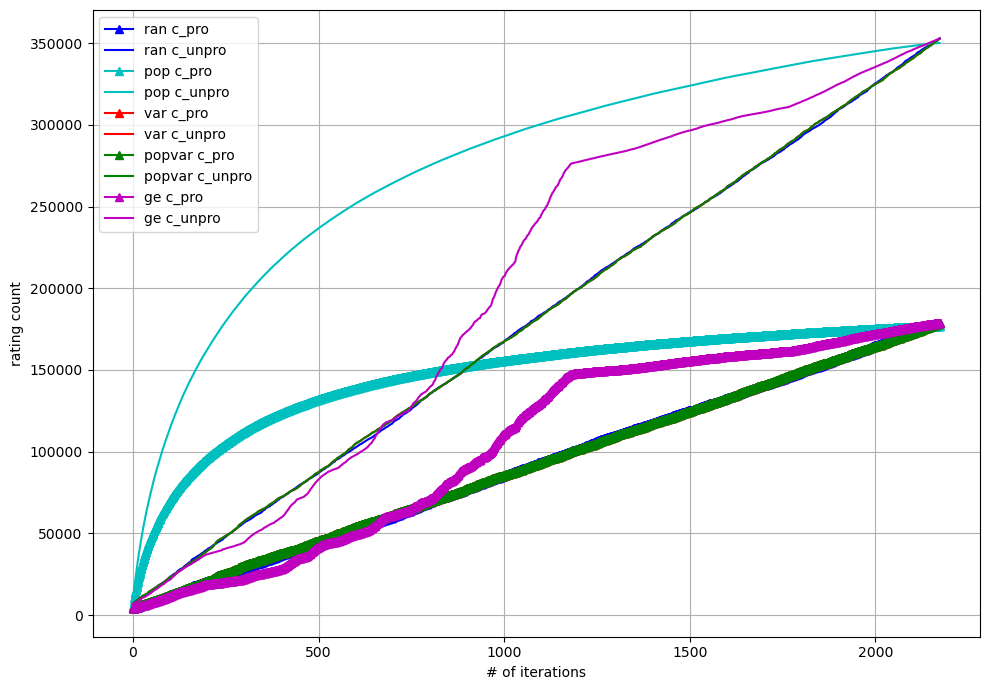

In [134]:
fig, ax = plt.subplots(figsize=(10,7))
color_l = ['b', 'c', 'r', 'g', 'm']
strtg_l = [r[0] for r in all_results[0]]

# y_axis = list(range(0, dataset.item_n, w))

for color, strtg_name in list(zip(color_l, strtg_l)):
    strtg_pro_df_grouped = pro_df_grouped[pro_df_grouped.strtg == strtg_name]
    x = strtg_pro_df_grouped['index']
    ax.plot(x, strtg_pro_df_grouped['mean'], color+'-^', label=strtg_name+' c_pro')
    ax.fill_between(
        x, strtg_pro_df_grouped['ci_lower'], strtg_pro_df_grouped['ci_upper'], color=color, alpha=.15)

    strtg_unpro_df_grouped = unpro_df_grouped[unpro_df_grouped.strtg == strtg_name]
    x = strtg_unpro_df_grouped['index']
    ax.plot(x, strtg_unpro_df_grouped['mean'], color, label=strtg_name+' c_unpro')
    ax.fill_between(
        x, strtg_unpro_df_grouped['ci_lower'], strtg_unpro_df_grouped['ci_upper'], color=color, alpha=.15)
# ax.set_ylim(ymin=0)

ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of iterations')
plt.ylabel('rating count')

#plt.savefig('./plots/proUnpro_rate_c_lastfm042424.png', dpi=300)

In [135]:
#fig, ax = plt.subplots(figsize=(10, 8))
#marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

## y_axis = list(range(0, dataset.item_n, w))

#for m, i in list(zip(marker_l, range(len(results)))):
    
#    ax.plot(list(range(0, len(results[i][1]['c_pro']))), results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
#    ax.plot(list(range(0, len(results[i][1]['c_unpro']))), results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')

    
##     ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
##     ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
#ax.grid(True)
#legend = ax.legend(loc='best')
#plt.xlabel('# of iterations')
#plt.ylabel('rating count')
## plt.title('Pro & Unpro Counts')
## plt.show()
#plt.savefig('./plots/proUnpro_rate_c_ml.png', dpi=300)

- this number tells us the number of ratings counts by mena dn women.
- pop and popvar both take a lot of ratings initially and then it decreases
    - maybe that is why they have lower RMSE, as they have more data for the majority
    - their RMSE for the unpro group is the lowest
    - RMSE for prot group is almost similar but popvar is slightly lower.
- var takes less ratings initially but a more equal number of men and women
    - that's why it has lower rmse
    - then it kinda grows as it doesn't have any other choice than selecting mroe data from men.
    - so we can say that controversial items with high variance rating, don't have many ratings on them in general but the number of men and women is more equal. (??? There are certain niche items that men adn women disagree on a lot.)
    
- popvar and var have small rmse differences compared to others. Var has smaller rmse difference.

# How popular are the items that have more balanced ratings?

In [136]:
item_f_m_cnt['c'] = item_f_m_cnt['F_c']+item_f_m_cnt['M_c']
# item_f_m_cnt.head()

In [137]:
itemSortedByPop = item_f_m_cnt.sort_values(by='pop')
itemSortedByPop.head()

item_iid  F_c  M_c  F_med  F_avg  M_med  M_avg  pop  normpop  var  \
19099     19099  1.0  0.0    1.0    1.0    0.0    0.0    1        0    0   
15234     15234  0.0  1.0    0.0    0.0    1.0    1.0    1        0    0   
4814       4814  0.0  1.0    0.0    0.0    1.0    1.0    1        0    0   
2658       2658  0.0  1.0    0.0    0.0    1.0    1.0    1        0    0   
13634     13634  0.0  1.0    0.0    0.0    1.0    1.0    1        0    0   

       sqrt normpopvar  npop  sqrt npopvar    c  
19099                0   0.0           0.0  1.0  
15234                0   0.0           0.0  1.0  
4814                 0   0.0           0.0  1.0  
2658                 0   0.0           0.0  1.0  
13634                0   0.0           0.0  1.0

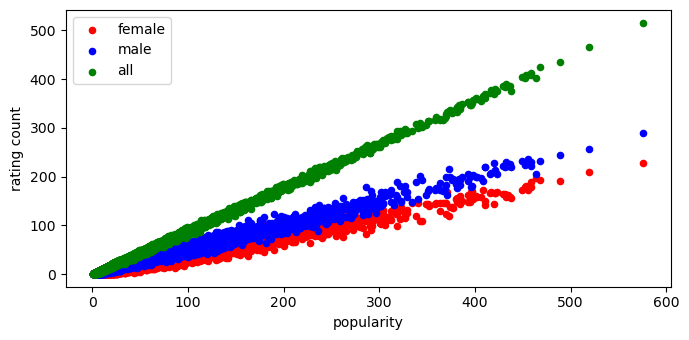

In [138]:

ax1 = itemSortedByPop.plot(kind = 'scatter', x='pop', y='F_c', c='red', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', x='pop', y='M_c', c='blue', label='male', ax= ax1)
ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("rating count")
plt.show()

In [139]:
from sklearn.metrics import r2_score

print(r2_score(itemSortedByPop['pop'], itemSortedByPop['c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['M_c']))
print(r2_score(itemSortedByPop['pop'], itemSortedByPop['F_c']))

0.9811661110379924
0.6788291880166087
0.46852858071913217


- The more popular an item is the more ratings it has. This trend is true for men, but not for women. There's a slight correlation.
- very popular items are not that many and they have more mens' ratings compared to women.
- the more popular an item gets, the less rating from women it gathers, then the accuracy difference increases.

- women's ratings have more variance

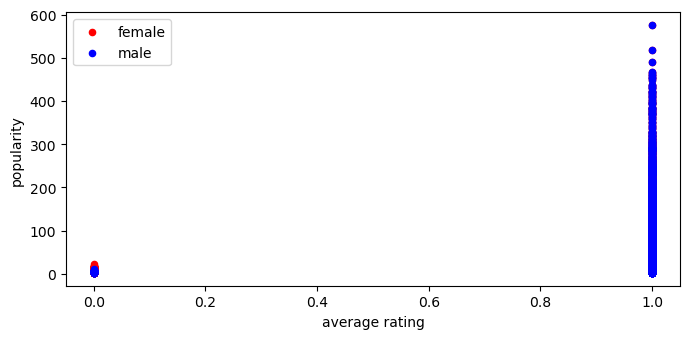

In [140]:

ax1 = itemSortedByPop.plot(kind = 'scatter', y='pop', x='F_avg', c='red', label='female')
ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_ylabel("popularity")
ax1.set_xlabel("average rating")
plt.show()

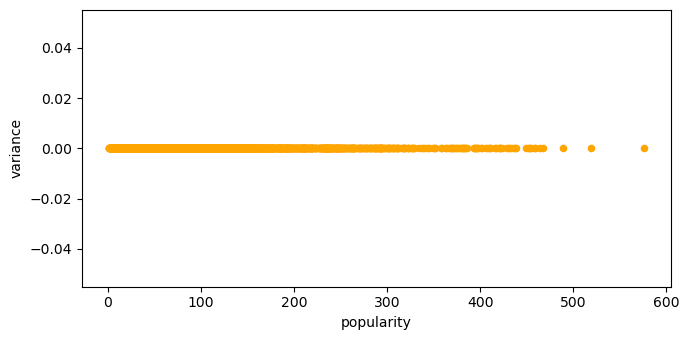

In [141]:
ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='pop', c='Orange')
# ax2 = itemSortedByPop.plot(kind='scatter', y='pop', x='M_avg', c='Blue', label='male', ax= ax1)
# ax3 = itemSortedByPop.plot(kind='scatter', x='pop', y='c', c='Green', label='all', ax=ax1)

ax1.set_xlabel("popularity")
ax1.set_ylabel("variance")
plt.show()

In [142]:
itemSortedByPop

item_iid    F_c    M_c  F_med  F_avg  M_med  M_avg  pop  normpop  var  \
19099     19099    1.0    0.0    1.0    1.0    0.0    0.0    1        0    0   
15234     15234    0.0    1.0    0.0    0.0    1.0    1.0    1        0    0   
4814       4814    0.0    1.0    0.0    0.0    1.0    1.0    1        0    0   
2658       2658    0.0    1.0    0.0    0.0    1.0    1.0    1        0    0   
13634     13634    0.0    1.0    0.0    0.0    1.0    1.0    1        0    0   
...         ...    ...    ...    ...    ...    ...    ...  ...      ...  ...   
2755       2755  197.0  206.0    1.0    1.0    1.0    1.0  464        0    0   
3483       3483  193.0  232.0    1.0    1.0    1.0    1.0  468        0    0   
20037     20037  191.0  245.0    1.0    1.0    1.0    1.0  489        0    0   
5093       5093  209.0  257.0    1.0    1.0    1.0    1.0  519        0    0   
11809     11809  227.0  289.0    1.0    1.0    1.0    1.0  576        0    0   

       sqrt normpopvar      npop  sqrt npopvar      c  
19099                0  0.000000           0.0    1.0  
15234                0  0.000000           0.0    1.0  
4814                 0  0.000000           0.0    1.0  
2658                 0  0.000000           0.0    1.0  
13634                0  0.000000           0.0    1.0  
...                ...       ...           ...    ...  
2755                 0  0.805217           0.0  403.0  
3483                 0  0.812174           0.0  425.0  
20037                0  0.848696           0.0  436.0  
5093                 0  0.900870           0.0  466.0  
11809                0  1.000000           0.0  516.0  

[21733 rows x 14 columns]

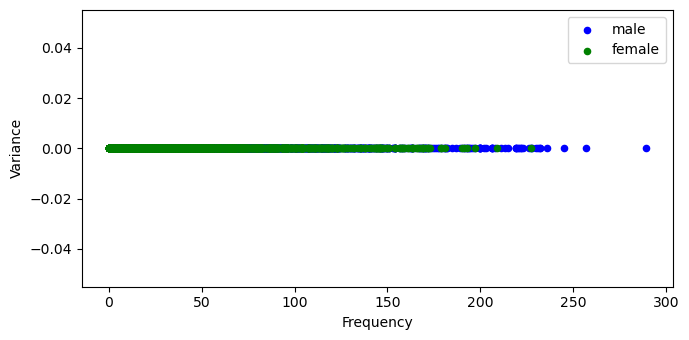

In [143]:
# ax1 = itemSortedByPop.plot(kind = 'scatter', y = 'var', x='M_c', c='Orange')
ax1 = itemSortedByPop.plot(kind='scatter', y='var', x='M_c', c='blue', label='male')
ax2 = itemSortedByPop.plot(kind='scatter', y='var', x='F_c', c='green', label='female', ax=ax1)

ax1.set_xlabel("Frequency")
ax1.set_ylabel("Variance")
plt.show()

- There are a lot of items with high popularity and very low variance.
- And the popular items have mostly male ratings.
- So, high variance items have low to medium popularity and also more balanced ratings probably.

# Same ratio experiment

## What if we feed the same ratio of data to the algorithm, what will happen to the accuracy?

In [144]:
all_results = []

In [145]:
#---------------------------------------------
from tqdm import tqdm


def ac_proc(tr_df, knw_df, tes, win, srt_it, algo):
    
    pro_c = []
    unpro_c = []
    
    rmse = []
    rmse_pro = []
    rmse_unpro = []
    
#     vu = []
    
    tr_iter = pd.DataFrame(columns=['user','item','rating'])
    
    
    # number of items
    n_itm = np.unique(train_df['item']).shape[0]
    i_indx = 0

    pbar = tqdm(desc='while loop', total=n_itm+1)
    while i_indx < n_itm:

        if i_indx%100. == 0.:
            print('sample %i-th item...' %i_indx)
    

        if i_indx != 0:
            # choosing the next item to sample
            chosen_is = srt_it[i_indx:i_indx+win]
            
            
            # filtering for equal proportions
            chosen_df = tr_df[tr_df['item'].isin(chosen_is)]
            
            pro_chosen_df = chosen_df[chosen_df['user'].isin(pro_users_index)]
            
            p_c = pro_chosen_df.shape[0] # count of how many female ratings
            
            # select as many male ratings as women's ratings
            unpro_chosen_df = chosen_df[~chosen_df['user'].isin(pro_users_index)][:p_c]

            
            print(p_c, unpro_chosen_df.shape[0])
            
            
            tr_iter = pd.concat([tr_iter, 
                                pro_chosen_df,
                                unpro_chosen_df]).drop_duplicates()

            # Sample based on item popularity but without replacement.
            # Since the sorted_i_pop is unique, we collect its data one by one, it won't have replacements.
#             tr_iter = pd.concat([tr_iter, 
#                                   tr_df[tr_df['item'].isin(chosen_is)]]).drop_duplicates()
        
        else:
            tr_iter = knw_df

 
            
        # turn the data into a Surprise readbale file
        trainset_act = Dataset.load_from_df(tr_iter[['user', 'item', 'rating']], reader).build_full_trainset()


        # fitting to the model
        algo.fit(trainset_act)
        preds = algo.test(tes)

        # evaluating the outcome
        rmse.append(accuracy.rmse(preds, verbose=False))
        # rmse_al_p.append(accuracy.mae(predictions_al_p, verbose=False))


        # pro & unpro RMSE
        pro_, unpro_ = seperate_preds(preds)    
        rmse_pro.append(accuracy.rmse(pro_, verbose=False))
        rmse_unpro.append(accuracy.rmse(unpro_, verbose=False))


#         # value fairness
#         vu.append(value_unfairness(pd.DataFrame(preds)))


        # pro/unpro count
        pro_c.append(tr_iter[tr_iter['user'].isin(pro_users_index)].shape[0])
        unpro_c.append(tr_iter[~tr_iter['user'].isin(pro_users_index)].shape[0])
        
        
        #----------------------------------next iteration---------------------------------
        i_indx += win
        pbar.update(1)
       
    
    pbar.close()  
    return ({'rmse':rmse, 'rmse_pro':rmse_pro, 'rmse_unpro': rmse_unpro, 'c_pro':pro_c, 'c_unpro':unpro_c}) 
    
    


if __name__ == "__main__":

    def comp_paral (akey):
        # strtgs[akey] is the sorted list of items based on a strategy
        return(akey, ac_proc(train_df, known_df, testset, w, strtgs[akey], svd_sup))
        # (tr_df, knw_df, tes, win, srt_it, algo)
     
    start = timeit.default_timer()
    import multiprocess as mp


    #------------------------item lists (act sorted & rand shuffled)---------------------
    # unique sorted items
    # if you use set() or np.unique(), they will disorder the list!
    sorted_i_pop = item_pop_df['item_iid'].tolist()

    # suffled list of items
    shuffled_i_ran = random.sample(range(dataset.item_n), len(range(dataset.item_n)))

    # uncertainty - variance
    sorted_i_v = item_uc_var_df['item_iid'].tolist()

    # items order by their Sqrt(norm pop) * Var
    sorted_i_spv = item_popvar_df['item_iid'].tolist()

    # sorted based on their contribution to RMSE
    sorted_i_ge = result_df_sorted_ge['item_iid'].tolist()

    strtgs = {'ran':shuffled_i_ran, 'pop':sorted_i_pop,
              'var':sorted_i_v, 'popvar': sorted_i_spv, 'ge':sorted_i_ge}

#     strtgs = {'ran':shuffled_i_ran}
    

    
    #------------------------ test set & algo & window ---------------------
    # the known set, a part of the training set
    # known_n = 0.02
    # known_df = train_df.sample(frac=known_n, replace=False, random_state=1019, axis=0)
    known_df = initial_train_df
    
    
    # build the test set
    testset = Dataset.load_from_df(test_df[['user', 'item', 'rating']],
                                   reader).build_full_trainset().build_testset()
    
    
    svd_sup = SVD(n_epochs = 100, n_factors = 100, lr_all=0.005, reg_all=0.1, verbose = False, random_state=41023)
#     algo = SVD()

    w = 10   # window of w items
    
    
    #------------------------ function ---------------------
    pool = mp.Pool(processes=10)
    results = pool.map(comp_paral, list(strtgs.keys()))
#     results = pool.map(comp_paral, {'ran':shuffled_i_ran, 'pop':sorted_i_pop}.items())
    
    
    
    pool.close()
    pool.join()
    pool.terminate()
    # print(results)

    stop = timeit.default_timer()
    print('Process Time: %.2f secs' % (stop - start))


while loop:   0%|                                         | 0/21734 [00:00<?, ?it/s]

sample 0-th item...


while loop:   0%|                                         | 0/21734 [00:00<?, ?it/s]

sample 0-th item...


while loop:   0%|                                         | 0/21734 [00:00<?, ?it/s]

sample 0-th item...


while loop:   0%|                                         | 0/21734 [00:00<?, ?it/s]

sample 0-th item...


while loop:   0%|                                         | 0/21734 [00:00<?, ?it/s]

sample 0-th item...


while loop:   0%|                               | 1/21734 [00:01<7:39:45,  1.27s/it]

1639 1639

while loop:   0%|                               | 1/21734 [00:01<7:46:06,  1.29s/it]

while loop:   0%|                               | 1/21734 [00:01<7:46:37,  1.29s/it]

54 54
151 75151

while loop:   0%|                               | 1/21734 [00:01<7:52:36,  1.30s/it]

 
75
151 151


while loop:   0%|                               | 2/21734 [00:02<7:29:41,  1.24s/it]

127 127
80 8080
47  8047



while loop:   0%|                               | 2/21734 [00:02<7:37:54,  1.26s/it]

1574 1574


while loop:   0%|                               | 3/21734 [00:03<6:26:55,  1.07s/it]

79

while loop:   0%|                               | 3/21734 [00:03<6:29:12,  1.07s/it]

 79


while loop:   0%|                               | 3/21734 [00:03<6:29:55,  1.08s/it]

32 32
113

while loop:   0%|                               | 3/21734 [00:03<6:31:17,  1.08s/it]

 113
113 113


while loop:   0%|                               | 3/21734 [00:03<6:48:49,  1.13s/it]

1550 1550


while loop:   0%|                               | 4/21734 [00:04<6:52:21,  1.14s/it]

116208 116 

while loop:   0%|                               | 4/21734 [00:04<6:51:40,  1.14s/it]


208
85 85
208 208


while loop:   0%|                               | 4/21734 [00:04<7:17:21,  1.21s/it]

1427 1427


while loop:   0%|                               | 5/21734 [00:05<6:18:55,  1.05s/it]

193 193


while loop:   0%|                               | 5/21734 [00:05<6:22:13,  1.06s/it]

96 96
112 112


while loop:   0%|                               | 5/21734 [00:05<6:23:06,  1.06s/it]

112 112


while loop:   0%|                               | 5/21734 [00:05<7:06:58,  1.18s/it]

1354 1354


while loop:   0%|                               | 6/21734 [00:06<6:43:24,  1.11s/it]

84 84


while loop:   0%|                               | 6/21734 [00:06<6:49:34,  1.13s/it]

34 34


while loop:   0%|                               | 6/21734 [00:06<6:53:39,  1.14s/it]

33 33


while loop:   0%|                               | 6/21734 [00:06<6:54:15,  1.14s/it]

33 33


while loop:   0%|                               | 6/21734 [00:07<7:45:10,  1.28s/it]

1306 1306


while loop:   0%|                               | 7/21734 [00:07<6:20:25,  1.05s/it]

55 55


while loop:   0%|                               | 7/21734 [00:07<6:22:52,  1.06s/it]

100 100


while loop:   0%|                               | 7/21734 [00:07<6:23:39,  1.06s/it]

120 120


while loop:   0%|                               | 7/21734 [00:07<6:26:29,  1.07s/it]

120 120


while loop:   0%|                               | 7/21734 [00:08<7:49:27,  1.30s/it]

1209 1209


while loop:   0%|                               | 8/21734 [00:08<6:43:30,  1.11s/it]

28 28


while loop:   0%|                               | 8/21734 [00:08<6:44:14,  1.12s/it]

67 67


while loop:   0%|                               | 8/21734 [00:09<6:48:49,  1.13s/it]

238 238
238 238


while loop:   0%|                               | 9/21734 [00:09<6:18:31,  1.05s/it]

73 73


while loop:   0%|                               | 9/21734 [00:09<6:23:23,  1.06s/it]

32 32


while loop:   0%|                               | 9/21734 [00:09<6:28:43,  1.07s/it]

32 32
32 32


while loop:   0%|                               | 8/21734 [00:10<8:20:56,  1.38s/it]

1155 1155


while loop:   0%|                              | 10/21734 [00:11<6:41:32,  1.11s/it]

sample 100-th item...
68 68


while loop:   0%|                              | 10/21734 [00:11<6:42:05,  1.11s/it]

sample 100-th item...
52 52


while loop:   0%|                              | 10/21734 [00:11<6:44:04,  1.12s/it]

sample 100-th item...
111 111


while loop:   0%|                              | 10/21734 [00:11<6:49:57,  1.13s/it]

sample 100-th item...
111 111


while loop:   0%|                               | 9/21734 [00:11<8:24:08,  1.39s/it]

1192 1192


while loop:   0%|                              | 11/21734 [00:11<6:20:47,  1.05s/it]

77 77


while loop:   0%|                              | 11/21734 [00:12<6:21:06,  1.05s/it]

77 77


while loop:   0%|                              | 11/21734 [00:12<6:24:56,  1.06s/it]

52 52
52 52


while loop:   0%|                              | 12/21734 [00:13<6:45:56,  1.12s/it]

104 104


while loop:   0%|                              | 12/21734 [00:13<6:46:33,  1.12s/it]

32 32


while loop:   0%|                              | 12/21734 [00:13<6:43:16,  1.11s/it]

49 49


while loop:   0%|                              | 12/21734 [00:13<6:47:43,  1.13s/it]

49 49


while loop:   0%|                              | 10/21734 [00:13<9:02:08,  1.50s/it]

sample 100-th item...
1075 1075


while loop:   0%|                              | 13/21734 [00:14<7:03:17,  1.17s/it]

19 19


while loop:   0%|                              | 13/21734 [00:14<7:05:03,  1.17s/it]

44 44


while loop:   0%|                              | 13/21734 [00:14<7:01:36,  1.16s/it]

161 161


while loop:   0%|                              | 13/21734 [00:14<7:07:05,  1.18s/it]

161 161


while loop:   0%|                              | 11/21734 [00:14<9:02:05,  1.50s/it]

1136 1136


while loop:   0%|                              | 14/21734 [00:15<6:39:14,  1.10s/it]

51 51


while loop:   0%|                              | 14/21734 [00:15<6:38:58,  1.10s/it]

95 95


while loop:   0%|                              | 14/21734 [00:15<6:38:09,  1.10s/it]

106 106


while loop:   0%|                              | 14/21734 [00:15<6:40:05,  1.11s/it]

106 106


while loop:   0%|                              | 15/21734 [00:16<7:02:31,  1.17s/it]

27 27


while loop:   0%|                              | 12/21734 [00:16<9:38:54,  1.60s/it]

1099 1099


while loop:   0%|                              | 15/21734 [00:16<7:01:11,  1.16s/it]

120 120


while loop:   0%|                              | 15/21734 [00:16<7:02:02,  1.17s/it]

140 140


while loop:   0%|                              | 15/21734 [00:16<7:02:12,  1.17s/it]

140 140


while loop:   0%|                              | 16/21734 [00:17<6:37:46,  1.10s/it]

39 39


while loop:   0%|                              | 16/21734 [00:17<6:34:34,  1.09s/it]

75 75


while loop:   0%|                              | 16/21734 [00:17<6:39:13,  1.10s/it]

103 103


while loop:   0%|                              | 16/21734 [00:17<6:41:30,  1.11s/it]

103 103


while loop:   0%|                             | 13/21734 [00:18<10:07:00,  1.68s/it]

1057 1057


while loop:   0%|                              | 17/21734 [00:19<6:58:01,  1.15s/it]

84 84


while loop:   0%|                              | 17/21734 [00:19<6:56:09,  1.15s/it]

105 105


while loop:   0%|                              | 17/21734 [00:19<6:59:27,  1.16s/it]

58 58


while loop:   0%|                              | 17/21734 [00:19<6:59:52,  1.16s/it]

58 58


while loop:   0%|                              | 18/21734 [00:19<6:36:36,  1.10s/it]

104 104


while loop:   0%|                              | 18/21734 [00:19<6:35:13,  1.09s/it]

104 104


while loop:   0%|                              | 18/21734 [00:20<6:33:05,  1.09s/it]

110 110


while loop:   0%|                              | 18/21734 [00:20<6:40:40,  1.11s/it]

110 110


while loop:   0%|                              | 14/21734 [00:20<9:58:12,  1.65s/it]

1021 1021


while loop:   0%|                              | 19/21734 [00:21<6:57:49,  1.15s/it]

62 62


while loop:   0%|                              | 19/21734 [00:21<6:58:26,  1.16s/it]

107 107


while loop:   0%|                              | 19/21734 [00:21<7:00:06,  1.16s/it]

50

while loop:   0%|                              | 19/21734 [00:21<7:01:53,  1.17s/it]

 50
50 50


while loop:   0%|                              | 20/21734 [00:22<6:37:55,  1.10s/it]

sample 200-th item...
105 105


while loop:   0%|                              | 20/21734 [00:22<6:38:13,  1.10s/it]

sample 200-th item...
67 67


while loop:   0%|                             | 15/21734 [00:22<10:42:22,  1.77s/it]

1015 1015


while loop:   0%|                              | 20/21734 [00:22<6:37:29,  1.10s/it]

sample 200-th item...
83 83


while loop:   0%|                              | 20/21734 [00:22<6:40:22,  1.11s/it]

sample 200-th item...
83 83


while loop:   0%|                              | 21/21734 [00:23<7:01:30,  1.16s/it]

52 52


while loop:   0%|                              | 21/21734 [00:23<7:00:14,  1.16s/it]

73 73


while loop:   0%|                              | 21/21734 [00:23<6:57:48,  1.15s/it]

43 43


while loop:   0%|                              | 21/21734 [00:23<7:02:37,  1.17s/it]

43 43


while loop:   0%|                             | 16/21734 [00:24<10:42:58,  1.78s/it]

935 935


while loop:   0%|                              | 22/21734 [00:24<6:45:18,  1.12s/it]

71 71


while loop:   0%|                              | 22/21734 [00:24<6:44:40,  1.12s/it]

90 90


while loop:   0%|                              | 22/21734 [00:24<6:48:37,  1.13s/it]

85 85


while loop:   0%|                              | 22/21734 [00:24<6:52:05,  1.14s/it]

85 85


while loop:   0%|                              | 23/21734 [00:26<7:20:24,  1.22s/it]

133 133
74 74


while loop:   0%|                              | 23/21734 [00:26<7:31:05,  1.25s/it]

124 124


while loop:   0%|                              | 23/21734 [00:26<7:31:07,  1.25s/it]

124 124


while loop:   0%|                             | 17/21734 [00:26<11:46:21,  1.95s/it]

967 967


while loop:   0%|                              | 24/21734 [00:27<7:41:16,  1.27s/it]

81 

while loop:   0%|                              | 24/21734 [00:27<7:44:29,  1.28s/it]

81
134 134


while loop:   0%|                              | 24/21734 [00:27<7:48:19,  1.29s/it]

37 37


while loop:   0%|                              | 24/21734 [00:27<7:46:41,  1.29s/it]

37 37


while loop:   0%|                             | 18/21734 [00:28<11:42:40,  1.94s/it]

1000 1000


while loop:   0%|                              | 25/21734 [00:28<7:18:14,  1.21s/it]

20 20
73 73


while loop:   0%|                              | 25/21734 [00:28<7:20:02,  1.22s/it]

67 6767
 67


while loop:   0%|                              | 26/21734 [00:29<7:37:19,  1.26s/it]

64 64


while loop:   0%|                              | 26/21734 [00:29<7:39:59,  1.27s/it]

90 90


while loop:   0%|                              | 26/21734 [00:30<7:46:39,  1.29s/it]

180 180180
 180


while loop:   0%|                             | 19/21734 [00:30<12:24:06,  2.06s/it]

898 898


while loop:   0%|                              | 27/21734 [00:30<7:09:42,  1.19s/it]

64 64


while loop:   0%|                              | 27/21734 [00:30<7:12:39,  1.20s/it]

53 53


while loop:   0%|                              | 27/21734 [00:31<7:15:07,  1.20s/it]

27 27


while loop:   0%|                              | 27/21734 [00:31<7:18:05,  1.21s/it]

27 27


while loop:   0%|                              | 28/21734 [00:32<7:19:38,  1.22s/it]

80 80


while loop:   0%|                              | 28/21734 [00:32<7:24:40,  1.23s/it]

33 33


while loop:   0%|                              | 28/21734 [00:32<7:29:21,  1.24s/it]

26 26


while loop:   0%|                              | 28/21734 [00:32<7:32:19,  1.25s/it]

26 26


while loop:   0%|                             | 20/21734 [00:32<12:10:23,  2.02s/it]

sample 200-th item...
965 965


while loop:   0%|                              | 29/21734 [00:33<6:56:14,  1.15s/it]

56 56


while loop:   0%|                              | 29/21734 [00:33<6:58:20,  1.16s/it]

48 48


while loop:   0%|                              | 29/21734 [00:33<6:59:31,  1.16s/it]

43 43


while loop:   0%|                              | 29/21734 [00:33<7:06:13,  1.18s/it]

43 43


while loop:   0%|                              | 30/21734 [00:34<7:11:03,  1.19s/it]

sample 300-th item...


while loop:   0%|                              | 30/21734 [00:34<7:12:14,  1.19s/it]

sample 300-th item...
38 3815
 15


while loop:   0%|                              | 30/21734 [00:34<7:22:22,  1.22s/it]

sample 300-th item...
40 40


while loop:   0%|                              | 30/21734 [00:34<7:26:00,  1.23s/it]

sample 300-th item...
929 929
40 40


while loop:   0%|                              | 31/21734 [00:35<6:51:54,  1.14s/it]

35 35
29 29


while loop:   0%|                              | 31/21734 [00:35<6:54:55,  1.15s/it]

42 42


while loop:   0%|                              | 31/21734 [00:35<7:00:07,  1.16s/it]

42 42


while loop:   0%|                              | 32/21734 [00:36<7:07:52,  1.18s/it]

33 33


while loop:   0%|                              | 32/21734 [00:36<7:10:24,  1.19s/it]

71 71


while loop:   0%|                             | 22/21734 [00:36<12:33:00,  2.08s/it]

905 905


while loop:   0%|                              | 32/21734 [00:37<7:17:16,  1.21s/it]

122 122


while loop:   0%|                              | 32/21734 [00:37<7:16:22,  1.21s/it]

122 122


while loop:   0%|                              | 33/21734 [00:37<6:49:07,  1.13s/it]

24 24
92 92


while loop:   0%|                              | 33/21734 [00:38<7:35:21,  1.26s/it]

49 49
49 49


while loop:   0%|                              | 34/21734 [00:39<7:07:52,  1.18s/it]

33 33


while loop:   0%|                              | 34/21734 [00:39<7:12:43,  1.20s/it]

109 109


while loop:   0%|                             | 23/21734 [00:39<12:52:08,  2.13s/it]

907 907


while loop:   0%|                              | 34/21734 [00:39<7:11:12,  1.19s/it]

37 37
37 37


while loop:   0%|                              | 35/21734 [00:40<6:54:24,  1.15s/it]

43 43


while loop:   0%|                              | 35/21734 [00:40<7:24:45,  1.23s/it]

45 45


while loop:   0%|                              | 35/21734 [00:40<7:28:57,  1.24s/it]

55 55


while loop:   0%|                              | 35/21734 [00:40<7:31:56,  1.25s/it]

55 55


while loop:   0%|                              | 36/21734 [00:41<6:59:32,  1.16s/it]

109 109


while loop:   0%|                              | 36/21734 [00:41<7:15:01,  1.20s/it]

67 67


while loop:   0%|                             | 24/21734 [00:41<13:23:10,  2.22s/it]

852 852


while loop:   0%|                              | 36/21734 [00:41<7:06:36,  1.18s/it]

21 21


while loop:   0%|                              | 36/21734 [00:42<7:08:45,  1.19s/it]

21 21


while loop:   0%|                              | 37/21734 [00:42<7:17:31,  1.21s/it]

72 72


while loop:   0%|                              | 37/21734 [00:42<7:29:56,  1.24s/it]

57 57


while loop:   0%|                              | 37/21734 [00:43<7:28:32,  1.24s/it]

40 40
40 40


while loop:   0%|                             | 25/21734 [00:43<13:13:53,  2.19s/it]

888 888


while loop:   0%|                              | 38/21734 [00:43<6:57:17,  1.15s/it]

117 117


while loop:   0%|                              | 38/21734 [00:43<7:05:03,  1.18s/it]

113 113


while loop:   0%|                              | 38/21734 [00:44<7:00:23,  1.16s/it]

143 

while loop:   0%|                              | 38/21734 [00:44<7:02:35,  1.17s/it]

143
143 143


while loop:   0%|                              | 39/21734 [00:45<7:15:04,  1.20s/it]

81 81


while loop:   0%|                              | 39/21734 [00:45<7:26:02,  1.23s/it]

121 121


while loop:   0%|                              | 39/21734 [00:45<7:26:30,  1.23s/it]

67 67

while loop:   0%|                              | 39/21734 [00:45<7:27:07,  1.24s/it]


67 67


while loop:   0%|                              | 40/21734 [00:46<6:56:23,  1.15s/it]

sample 400-th item...
43 43


while loop:   0%|                              | 40/21734 [00:46<7:07:45,  1.18s/it]

sample 400-th item...
50 50


while loop:   0%|                             | 26/21734 [00:46<13:58:07,  2.32s/it]

837 837


while loop:   0%|                              | 40/21734 [00:46<6:58:01,  1.16s/it]

sample 400-th item...
80 80


while loop:   0%|                              | 40/21734 [00:46<7:06:22,  1.18s/it]

sample 400-th item...
80 80


while loop:   0%|                              | 41/21734 [00:47<7:16:46,  1.21s/it]

122 122


while loop:   0%|                              | 41/21734 [00:47<7:25:40,  1.23s/it]

47 47


while loop:   0%|                              | 41/21734 [00:48<7:20:41,  1.22s/it]

72 72


while loop:   0%|                              | 41/21734 [00:48<7:23:31,  1.23s/it]

72 72


while loop:   0%|                              | 42/21734 [00:48<6:55:36,  1.15s/it]

73 73


while loop:   0%|                             | 27/21734 [00:48<13:49:37,  2.29s/it]

747 747


while loop:   0%|                              | 42/21734 [00:48<7:04:35,  1.17s/it]

205 205


while loop:   0%|                              | 42/21734 [00:49<7:05:11,  1.18s/it]

263 263


while loop:   0%|                              | 42/21734 [00:49<7:02:51,  1.17s/it]

263 263


while loop:   0%|                              | 43/21734 [00:49<7:18:39,  1.21s/it]

82 82


while loop:   0%|                              | 43/21734 [00:50<7:22:07,  1.22s/it]

73 73


while loop:   0%|                              | 43/21734 [00:50<7:22:02,  1.22s/it]

112 112


while loop:   0%|                              | 43/21734 [00:50<7:22:39,  1.22s/it]

112 112


while loop:   0%|                              | 44/21734 [00:50<7:01:36,  1.17s/it]

138 138


while loop:   0%|                             | 28/21734 [00:51<14:26:41,  2.40s/it]

814 814


while loop:   0%|                              | 44/21734 [00:51<7:39:43,  1.27s/it]

139 139


while loop:   0%|                              | 44/21734 [00:51<7:09:03,  1.19s/it]

87 87
87 87


while loop:   0%|                              | 45/21734 [00:52<7:21:42,  1.22s/it]

112 112


while loop:   0%|                              | 45/21734 [00:52<7:16:00,  1.21s/it]

109 109


while loop:   0%|                              | 45/21734 [00:52<7:23:07,  1.23s/it]

114 114


while loop:   0%|                              | 45/21734 [00:53<7:33:21,  1.25s/it]

114 114


while loop:   0%|                              | 46/21734 [00:53<7:06:22,  1.18s/it]

66 66


while loop:   0%|                             | 29/21734 [00:53<14:21:55,  2.38s/it]

806 806


while loop:   0%|                              | 46/21734 [00:53<7:31:45,  1.25s/it]

36 36


while loop:   0%|                              | 46/21734 [00:54<7:44:47,  1.29s/it]

38 38


while loop:   0%|                              | 46/21734 [00:54<7:50:15,  1.30s/it]

38 38


while loop:   0%|                              | 47/21734 [00:54<7:21:39,  1.22s/it]

52 52


while loop:   0%|                              | 47/21734 [00:54<7:11:59,  1.20s/it]

102 102


while loop:   0%|                              | 47/21734 [00:55<7:25:46,  1.23s/it]

68 68


while loop:   0%|                              | 47/21734 [00:55<7:29:32,  1.24s/it]

68 68


while loop:   0%|                              | 48/21734 [00:56<7:39:25,  1.27s/it]

46 46


while loop:   0%|                              | 48/21734 [00:56<7:26:34,  1.24s/it]

56 56


while loop:   0%|                             | 30/21734 [00:56<14:51:06,  2.46s/it]

sample 300-th item...
819 819


while loop:   0%|                              | 48/21734 [00:56<7:48:15,  1.30s/it]

89 89


while loop:   0%|                              | 48/21734 [00:56<7:51:08,  1.30s/it]

89 89


while loop:   0%|                              | 49/21734 [00:57<7:17:52,  1.21s/it]

102 102


while loop:   0%|                              | 49/21734 [00:57<7:08:22,  1.19s/it]

45 45


while loop:   0%|                              | 49/21734 [00:58<7:28:32,  1.24s/it]

55 55
55 55


while loop:   0%|                              | 50/21734 [00:58<7:33:35,  1.26s/it]

sample 500-th item...
125 125


while loop:   0%|                              | 50/21734 [00:58<7:28:00,  1.24s/it]

sample 500-th item...
93 93


while loop:   0%|                             | 31/21734 [00:58<14:56:40,  2.48s/it]

733 733


while loop:   0%|                              | 50/21734 [00:59<7:40:40,  1.27s/it]

sample 500-th item...
131 131


while loop:   0%|                              | 50/21734 [00:59<7:44:38,  1.29s/it]

sample 500-th item...
131 131


while loop:   0%|                              | 51/21734 [00:59<7:16:07,  1.21s/it]

55 55


while loop:   0%|                              | 51/21734 [00:59<7:12:54,  1.20s/it]

69 69


while loop:   0%|                              | 51/21734 [01:00<7:27:42,  1.24s/it]

35

while loop:   0%|                              | 51/21734 [01:00<7:30:08,  1.25s/it]

 35
35 35


while loop:   0%|                              | 52/21734 [01:01<7:41:42,  1.28s/it]

51 51


while loop:   0%|                              | 52/21734 [01:01<7:40:50,  1.28s/it]

60 60


while loop:   0%|                             | 32/21734 [01:01<15:16:04,  2.53s/it]

694 694


while loop:   0%|                              | 52/21734 [01:02<7:56:58,  1.32s/it]

50 50


while loop:   0%|                              | 52/21734 [01:02<7:59:14,  1.33s/it]

50 50


while loop:   0%|                              | 53/21734 [01:02<7:25:54,  1.23s/it]

67 67


while loop:   0%|                              | 53/21734 [01:02<7:24:33,  1.23s/it]

28 28


while loop:   0%|                              | 53/21734 [01:03<7:38:54,  1.27s/it]

115 115


while loop:   0%|                              | 53/21734 [01:03<7:40:20,  1.27s/it]

115 115


while loop:   0%|                              | 54/21734 [01:03<7:45:31,  1.29s/it]

75 75


while loop:   0%|                              | 54/21734 [01:03<7:51:31,  1.30s/it]

76 76


while loop:   0%|                             | 33/21734 [01:04<16:15:57,  2.70s/it]

736 736


while loop:   0%|                              | 54/21734 [01:04<8:21:01,  1.39s/it]

97 97


while loop:   0%|                              | 54/21734 [01:04<8:24:02,  1.39s/it]

77 77
97 97


while loop:   0%|                              | 55/21734 [01:05<8:22:55,  1.39s/it]

73 73


while loop:   0%|                              | 55/21734 [01:06<7:56:14,  1.32s/it]

78 78


while loop:   0%|                              | 55/21734 [01:06<7:57:46,  1.32s/it]

78 78


while loop:   0%|                              | 56/21734 [01:06<7:57:51,  1.32s/it]

90 90


while loop:   0%|                              | 56/21734 [01:06<7:53:38,  1.31s/it]

62 62


while loop:   0%|                             | 34/21734 [01:06<15:48:33,  2.62s/it]

710 710


while loop:   0%|                              | 56/21734 [01:07<8:12:19,  1.36s/it]

71 71


while loop:   0%|                              | 56/21734 [01:07<8:12:32,  1.36s/it]

71 71


while loop:   0%|                              | 57/21734 [01:07<8:04:59,  1.34s/it]

81 81


while loop:   0%|                              | 57/21734 [01:07<7:58:42,  1.33s/it]

60 60


while loop:   0%|                              | 58/21734 [01:08<7:42:20,  1.28s/it]

48 48


while loop:   0%|                              | 57/21734 [01:08<8:15:38,  1.37s/it]

34 34


while loop:   0%|                              | 57/21734 [01:09<8:25:15,  1.40s/it]

34 34


while loop:   0%|                              | 58/21734 [01:09<7:37:15,  1.27s/it]

100 100


while loop:   0%|                             | 35/21734 [01:10<16:37:04,  2.76s/it]

713 713


while loop:   0%|                              | 58/21734 [01:10<7:56:18,  1.32s/it]

139 139


while loop:   0%|                              | 58/21734 [01:10<8:00:05,  1.33s/it]

139 139


while loop:   0%|                              | 59/21734 [01:10<7:58:59,  1.33s/it]

41 41


while loop:   0%|                              | 59/21734 [01:10<7:50:29,  1.30s/it]

65 65


while loop:   0%|                              | 60/21734 [01:11<7:35:08,  1.26s/it]

sample 600-th item...
52 52


while loop:   0%|                              | 60/21734 [01:11<7:33:08,  1.25s/it]

sample 600-th item...
149 149


while loop:   0%|                              | 59/21734 [01:11<8:11:34,  1.36s/it]

39 39


while loop:   0%|                              | 59/21734 [01:11<8:13:49,  1.37s/it]

39 39


while loop:   0%|                             | 36/21734 [01:12<16:25:18,  2.72s/it]

718 718


while loop:   0%|                              | 60/21734 [01:12<7:48:43,  1.30s/it]

sample 600-th item...
37 37


while loop:   0%|                              | 61/21734 [01:12<7:52:54,  1.31s/it]

91 91


while loop:   0%|                              | 60/21734 [01:12<7:54:31,  1.31s/it]

sample 600-th item...
37 37


while loop:   0%|                              | 61/21734 [01:12<7:51:42,  1.31s/it]

62 62


while loop:   0%|                              | 62/21734 [01:13<7:40:21,  1.27s/it]

47 47


while loop:   0%|                              | 62/21734 [01:14<7:35:26,  1.26s/it]

40 40


while loop:   0%|                              | 61/21734 [01:14<8:12:16,  1.36s/it]

84 84


while loop:   0%|                              | 61/21734 [01:14<8:15:30,  1.37s/it]

84 84


while loop:   0%|                              | 63/21734 [01:15<8:00:06,  1.33s/it]

71 71


while loop:   0%|                              | 62/21734 [01:15<7:58:27,  1.32s/it]

50 50


while loop:   0%|                              | 62/21734 [01:15<8:01:50,  1.33s/it]

50 50


while loop:   0%|                              | 63/21734 [01:15<8:00:58,  1.33s/it]

86 86


while loop:   0%|                             | 37/21734 [01:15<17:05:48,  2.84s/it]

709 709


while loop:   0%|                              | 64/21734 [01:16<7:50:29,  1.30s/it]

82 82


while loop:   0%|                              | 64/21734 [01:16<7:57:10,  1.32s/it]

94 94


while loop:   0%|                              | 63/21734 [01:17<8:36:26,  1.43s/it]

35 35


while loop:   0%|                              | 63/21734 [01:17<8:37:06,  1.43s/it]

35 35


while loop:   0%|                              | 65/21734 [01:18<8:19:24,  1.38s/it]

51 51


while loop:   0%|                              | 64/21734 [01:18<8:14:54,  1.37s/it]

115 115


while loop:   0%|                              | 64/21734 [01:18<8:15:33,  1.37s/it]

115 115


while loop:   0%|                              | 65/21734 [01:18<8:27:24,  1.40s/it]

61 61


while loop:   0%|                             | 38/21734 [01:18<17:20:13,  2.88s/it]

665 665


while loop:   0%|                              | 66/21734 [01:19<7:56:25,  1.32s/it]

48 48


while loop:   0%|                              | 66/21734 [01:19<8:04:29,  1.34s/it]

59 59


while loop:   0%|                              | 65/21734 [01:19<8:33:56,  1.42s/it]

158 158


while loop:   0%|                              | 65/21734 [01:20<8:37:31,  1.43s/it]

158 158


while loop:   0%|                              | 67/21734 [01:20<8:13:03,  1.37s/it]

64 64


while loop:   0%|                              | 67/21734 [01:21<8:31:08,  1.42s/it]

75 75


while loop:   0%|                              | 66/21734 [01:21<8:56:16,  1.48s/it]

55 55


while loop:   0%|                              | 66/21734 [01:21<8:51:48,  1.47s/it]

55 55


while loop:   0%|                             | 39/21734 [01:22<18:08:59,  3.01s/it]

647 647


while loop:   0%|                              | 68/21734 [01:22<8:17:34,  1.38s/it]

108 108


while loop:   0%|                              | 67/21734 [01:22<8:18:28,  1.38s/it]

57 57
57 57


while loop:   0%|                              | 68/21734 [01:22<8:40:05,  1.44s/it]

36 36


while loop:   0%|                              | 69/21734 [01:23<7:48:12,  1.30s/it]

45 45


while loop:   0%|                              | 69/21734 [01:23<8:11:20,  1.36s/it]

76 76


while loop:   0%|                              | 68/21734 [01:24<8:29:03,  1.41s/it]

150 150


while loop:   0%|                              | 68/21734 [01:24<8:38:08,  1.43s/it]

150 150


while loop:   0%|                              | 70/21734 [01:24<8:13:36,  1.37s/it]

sample 700-th item...
99 99


while loop:   0%|                             | 40/21734 [01:24<17:56:10,  2.98s/it]

sample 400-th item...
658 658


while loop:   0%|                              | 69/21734 [01:25<8:11:22,  1.36s/it]

39 39
39 39


while loop:   0%|                              | 70/21734 [01:25<8:29:25,  1.41s/it]

sample 700-th item...
109 109


while loop:   0%|                              | 71/21734 [01:26<7:55:19,  1.32s/it]

28 28


while loop:   0%|                              | 71/21734 [01:26<8:09:09,  1.35s/it]

203 203


while loop:   0%|                              | 70/21734 [01:27<8:37:09,  1.43s/it]

sample 700-th item...
21 21


while loop:   0%|                              | 70/21734 [01:27<8:37:24,  1.43s/it]

sample 700-th item...
21 21


while loop:   0%|                              | 72/21734 [01:27<8:28:23,  1.41s/it]

77 77


while loop:   0%|                             | 41/21734 [01:28<18:39:22,  3.10s/it]

666 666


while loop:   0%|                              | 72/21734 [01:28<8:41:22,  1.44s/it]

95 95


while loop:   0%|                              | 71/21734 [01:28<8:28:38,  1.41s/it]

78 78


while loop:   0%|                              | 71/21734 [01:28<8:30:03,  1.41s/it]

78 78


while loop:   0%|                              | 73/21734 [01:28<8:11:17,  1.36s/it]

78 78


while loop:   0%|                              | 73/21734 [01:29<8:28:01,  1.41s/it]

149 149


while loop:   0%|                              | 72/21734 [01:30<8:48:10,  1.46s/it]

48 48
48 48


while loop:   0%|                              | 74/21734 [01:30<8:14:07,  1.37s/it]

166 166


while loop:   0%|                              | 74/21734 [01:31<8:33:35,  1.42s/it]

38 38


while loop:   0%|                             | 42/21734 [01:31<18:20:12,  3.04s/it]

640 640


while loop:   0%|                              | 73/21734 [01:31<8:22:27,  1.39s/it]

58

while loop:   0%|                              | 73/21734 [01:31<8:25:16,  1.40s/it]

 58
58 58


while loop:   0%|                              | 75/21734 [01:31<8:26:27,  1.40s/it]

99 99


while loop:   0%|                              | 75/21734 [01:32<8:14:55,  1.37s/it]

257 257


while loop:   0%|                              | 74/21734 [01:32<8:28:46,  1.41s/it]

29 29


while loop:   0%|                              | 74/21734 [01:32<8:32:54,  1.42s/it]

29 29


while loop:   0%|                              | 76/21734 [01:33<8:07:23,  1.35s/it]

96 96


while loop:   0%|                              | 76/21734 [01:33<8:37:21,  1.43s/it]

63 63


while loop:   0%|                              | 75/21734 [01:34<8:55:30,  1.48s/it]

49 49
49 49


while loop:   0%|                             | 43/21734 [01:34<18:52:19,  3.13s/it]

602 602


while loop:   0%|                              | 77/21734 [01:34<8:34:19,  1.42s/it]

73 73


while loop:   0%|                              | 77/21734 [01:35<8:45:09,  1.45s/it]

34 34


while loop:   0%|                              | 76/21734 [01:35<8:30:12,  1.41s/it]

70 7070 
70


while loop:   0%|                              | 78/21734 [01:35<8:06:06,  1.35s/it]

82 82


while loop:   0%|                              | 78/21734 [01:36<8:21:52,  1.39s/it]

94 94


while loop:   0%|                              | 77/21734 [01:37<8:43:30,  1.45s/it]

158 158


while loop:   0%|                              | 77/21734 [01:37<8:47:47,  1.46s/it]

158 158


while loop:   0%|                              | 79/21734 [01:37<8:25:08,  1.40s/it]

73 73


while loop:   0%|                             | 44/21734 [01:37<18:40:54,  3.10s/it]

595 595


while loop:   0%|                              | 79/21734 [01:38<8:39:52,  1.44s/it]

152 152


while loop:   0%|                              | 78/21734 [01:38<8:19:42,  1.38s/it]

110 110


while loop:   0%|                              | 78/21734 [01:38<8:27:33,  1.41s/it]

110 110


while loop:   0%|                              | 80/21734 [01:38<8:05:45,  1.35s/it]

sample 800-th item...
67 67


while loop:   0%|                              | 80/21734 [01:39<8:14:44,  1.37s/it]

sample 800-th item...
47 47


while loop:   0%|                              | 79/21734 [01:39<8:32:28,  1.42s/it]

29 29


while loop:   0%|                              | 79/21734 [01:40<8:44:43,  1.45s/it]

29 29


while loop:   0%|                              | 81/21734 [01:40<8:24:57,  1.40s/it]

93 93


while loop:   0%|                             | 45/21734 [01:40<18:51:17,  3.13s/it]

585 585


while loop:   0%|                              | 81/21734 [01:40<8:27:23,  1.41s/it]

82 82


while loop:   0%|                              | 80/21734 [01:41<8:05:38,  1.35s/it]

sample 800-th item...
42 42


while loop:   0%|                              | 82/21734 [01:41<8:00:02,  1.33s/it]

88 88


while loop:   0%|                              | 80/21734 [01:41<8:23:39,  1.40s/it]

sample 800-th item...
42 42


while loop:   0%|                              | 82/21734 [01:42<8:00:08,  1.33s/it]

22 22


while loop:   0%|                              | 81/21734 [01:42<8:31:58,  1.42s/it]

147 147


while loop:   0%|                              | 83/21734 [01:42<8:18:06,  1.38s/it]

68 68


while loop:   0%|                              | 81/21734 [01:42<8:41:52,  1.45s/it]

147 147


while loop:   0%|                              | 83/21734 [01:43<8:22:44,  1.39s/it]

49 49


while loop:   0%|                              | 82/21734 [01:43<8:09:30,  1.36s/it]

92 92


while loop:   0%|                              | 84/21734 [01:44<8:01:43,  1.34s/it]

79 79


while loop:   0%|                              | 82/21734 [01:44<8:14:44,  1.37s/it]

92 92


while loop:   0%|                             | 46/21734 [01:44<19:09:35,  3.18s/it]

600 600


while loop:   0%|                              | 84/21734 [01:44<8:05:50,  1.35s/it]

237 237


while loop:   0%|                              | 83/21734 [01:45<8:29:56,  1.41s/it]

146 146


while loop:   0%|                              | 85/21734 [01:45<8:17:44,  1.38s/it]

114 114


while loop:   0%|                              | 83/21734 [01:45<8:30:49,  1.42s/it]

146 146


while loop:   0%|                              | 85/21734 [01:46<8:28:28,  1.41s/it]

47 47


while loop:   0%|                              | 84/21734 [01:46<8:20:37,  1.39s/it]

82 82


while loop:   0%|                              | 84/21734 [01:46<8:22:40,  1.39s/it]

82 82


while loop:   0%|                             | 47/21734 [01:47<18:38:47,  3.10s/it]

599 599


while loop:   0%|                              | 86/21734 [01:47<8:39:24,  1.44s/it]

102 102


while loop:   0%|                              | 86/21734 [01:47<8:15:26,  1.37s/it]

18 18


while loop:   0%|                              | 85/21734 [01:48<8:38:51,  1.44s/it]

99 99


while loop:   0%|                              | 87/21734 [01:48<8:18:13,  1.38s/it]

185 185


while loop:   0%|                              | 85/21734 [01:48<8:42:44,  1.45s/it]

99 99


while loop:   0%|                              | 87/21734 [01:49<8:34:52,  1.43s/it]

141 141


while loop:   0%|                              | 86/21734 [01:49<8:21:32,  1.39s/it]

65 65


while loop:   0%|                              | 86/21734 [01:49<8:15:08,  1.37s/it]

65 65


while loop:   0%|                              | 88/21734 [01:49<8:41:54,  1.45s/it]

72 72


while loop:   0%|                             | 48/21734 [01:50<19:19:02,  3.21s/it]

579 579


while loop:   0%|                              | 88/21734 [01:50<8:23:51,  1.40s/it]

19 19


while loop:   0%|                              | 89/21734 [01:51<8:11:29,  1.36s/it]

64 64


while loop:   0%|                              | 87/21734 [01:51<8:40:55,  1.44s/it]

180 180


while loop:   0%|                              | 87/21734 [01:51<8:32:04,  1.42s/it]

180 180


while loop:   0%|                              | 89/21734 [01:52<8:43:00,  1.45s/it]

71 71


while loop:   0%|                              | 90/21734 [01:52<8:41:22,  1.45s/it]

sample 900-th item...
100 100


while loop:   0%|                              | 88/21734 [01:52<9:03:28,  1.51s/it]

161 161


while loop:   0%|                              | 88/21734 [01:52<8:56:22,  1.49s/it]

161 161


while loop:   0%|                             | 49/21734 [01:53<18:47:27,  3.12s/it]

492 492


while loop:   0%|                              | 90/21734 [01:53<8:56:28,  1.49s/it]

sample 900-th item...
40 40


while loop:   0%|▏                             | 91/21734 [01:54<8:23:53,  1.40s/it]

95 95


while loop:   0%|                              | 89/21734 [01:54<8:23:07,  1.39s/it]

73 73


while loop:   0%|                              | 89/21734 [01:54<8:40:36,  1.44s/it]

73 73


while loop:   0%|▏                             | 91/21734 [01:55<8:26:53,  1.41s/it]

39 39


while loop:   0%|▏                             | 92/21734 [01:55<8:46:56,  1.46s/it]

124 124


while loop:   0%|                              | 90/21734 [01:55<8:43:48,  1.45s/it]

sample 900-th item...
125 125


while loop:   0%|                              | 90/21734 [01:55<9:00:28,  1.50s/it]

sample 900-th item...
125 125


while loop:   0%|▏                             | 92/21734 [01:56<8:38:00,  1.44s/it]

26 26


while loop:   0%|                             | 50/21734 [01:56<19:16:25,  3.20s/it]

sample 500-th item...
553 553


while loop:   0%|▏                             | 93/21734 [01:56<8:33:22,  1.42s/it]

92 92


while loop:   0%|▏                             | 91/21734 [01:57<8:37:13,  1.43s/it]

54 54


while loop:   0%|▏                             | 91/21734 [01:57<8:46:49,  1.46s/it]

54 54


while loop:   0%|▏                             | 93/21734 [01:57<8:19:50,  1.39s/it]

81 81


while loop:   0%|▏                             | 94/21734 [01:58<8:43:55,  1.45s/it]

70 70


while loop:   0%|▏                             | 92/21734 [01:58<8:55:28,  1.48s/it]

87 

while loop:   0%|▏                             | 92/21734 [01:58<8:57:12,  1.49s/it]

87
87 87


while loop:   0%|▏                             | 94/21734 [01:59<8:48:37,  1.47s/it]

67 67


while loop:   0%|▏                             | 95/21734 [01:59<8:30:54,  1.42s/it]

52 52


while loop:   0%|                             | 51/21734 [01:59<19:00:52,  3.16s/it]

572 572


while loop:   0%|▏                             | 93/21734 [01:59<8:41:14,  1.45s/it]

53 53

while loop:   0%|▏                             | 93/21734 [01:59<8:42:11,  1.45s/it]


53 53


while loop:   0%|▏                             | 95/21734 [02:00<8:24:00,  1.40s/it]

87 87


while loop:   0%|▏                             | 96/21734 [02:01<8:41:57,  1.45s/it]

68 68


while loop:   0%|▏                             | 94/21734 [02:01<9:00:38,  1.50s/it]

199 199


while loop:   0%|▏                             | 94/21734 [02:01<9:02:50,  1.51s/it]

199 199


while loop:   0%|▏                             | 96/21734 [02:02<8:51:55,  1.47s/it]

279 279


while loop:   0%|▏                             | 97/21734 [02:02<8:59:54,  1.50s/it]

102 102


while loop:   0%|▏                             | 95/21734 [02:03<9:04:58,  1.51s/it]

36 36


while loop:   0%|▏                             | 95/21734 [02:03<9:15:03,  1.54s/it]

36 36


while loop:   0%|                             | 52/21734 [02:03<19:52:24,  3.30s/it]

582 582


while loop:   0%|▏                             | 97/21734 [02:03<8:34:53,  1.43s/it]

118 118


while loop:   0%|▏                             | 98/21734 [02:04<8:32:10,  1.42s/it]

65 65


while loop:   0%|▏                             | 96/21734 [02:04<8:41:22,  1.45s/it]

235 235


while loop:   0%|▏                             | 96/21734 [02:04<8:48:34,  1.47s/it]

235 235


while loop:   0%|▏                             | 98/21734 [02:05<8:43:54,  1.45s/it]

89 89


while loop:   0%|▏                             | 99/21734 [02:05<8:52:16,  1.48s/it]

49 49


while loop:   0%|▏                             | 97/21734 [02:06<8:59:55,  1.50s/it]

59 59


while loop:   0%|▏                             | 97/21734 [02:06<9:07:56,  1.52s/it]

59 59


while loop:   0%|▏                             | 99/21734 [02:06<9:05:13,  1.51s/it]

80 80


while loop:   0%|                             | 53/21734 [02:06<20:08:26,  3.34s/it]

543 543


while loop:   0%|▏                            | 100/21734 [02:07<8:35:54,  1.43s/it]

sample 1000-th item...
151 151


while loop:   0%|▏                             | 98/21734 [02:07<8:45:23,  1.46s/it]

72 72


while loop:   0%|▏                             | 98/21734 [02:07<8:44:48,  1.46s/it]

72 72


while loop:   0%|▏                            | 100/21734 [02:08<8:34:21,  1.43s/it]

sample 1000-th item...
23 23


while loop:   0%|▏                            | 101/21734 [02:08<8:45:20,  1.46s/it]

78 78


while loop:   0%|▏                             | 99/21734 [02:09<9:10:02,  1.53s/it]

27 27


while loop:   0%|▏                             | 99/21734 [02:09<9:09:42,  1.52s/it]

27 27


while loop:   0%|▏                            | 101/21734 [02:09<8:48:11,  1.46s/it]

60 60


while loop:   0%|▏                            | 102/21734 [02:09<8:24:48,  1.40s/it]

30 30


while loop:   0%|                             | 54/21734 [02:10<20:26:23,  3.39s/it]

540 540


while loop:   0%|▏                            | 100/21734 [02:10<8:54:33,  1.48s/it]

sample 1000-th item...
84 84


while loop:   0%|▏                            | 100/21734 [02:10<8:54:25,  1.48s/it]

sample 1000-th item...
84 84


while loop:   0%|▏                            | 102/21734 [02:10<8:35:15,  1.43s/it]

34 34


while loop:   0%|▏                            | 103/21734 [02:11<8:35:24,  1.43s/it]

181 181


while loop:   0%|▏                            | 101/21734 [02:12<9:04:31,  1.51s/it]

49 49


while loop:   0%|▏                            | 101/21734 [02:12<9:09:33,  1.52s/it]

49 49


while loop:   0%|▏                            | 103/21734 [02:12<8:50:19,  1.47s/it]

43 43


while loop:   0%|▏                            | 104/21734 [02:12<8:23:39,  1.40s/it]

94 94


while loop:   0%|▏                            | 102/21734 [02:13<8:44:28,  1.45s/it]

44 44


while loop:   0%|▏                            | 102/21734 [02:13<8:52:52,  1.48s/it]

44 44


while loop:   0%|▏                            | 104/21734 [02:13<8:33:06,  1.42s/it]

134 134


while loop:   0%|                             | 55/21734 [02:13<20:41:35,  3.44s/it]

580 580


while loop:   0%|▏                            | 105/21734 [02:14<8:43:14,  1.45s/it]

116 116


while loop:   0%|▏                            | 103/21734 [02:15<9:07:30,  1.52s/it]

62 62


while loop:   0%|▏                            | 103/21734 [02:15<9:12:59,  1.53s/it]

62 62


while loop:   0%|▏                            | 105/21734 [02:15<9:00:42,  1.50s/it]

29 29


while loop:   0%|▏                            | 106/21734 [02:15<9:01:28,  1.50s/it]

61 61


while loop:   0%|▏                            | 104/21734 [02:16<8:57:06,  1.49s/it]

83 83


while loop:   0%|▏                            | 104/21734 [02:16<9:00:13,  1.50s/it]

83 83


while loop:   0%|▏                            | 106/21734 [02:17<9:13:47,  1.54s/it]

143 143


while loop:   0%|▏                            | 107/21734 [02:17<8:41:15,  1.45s/it]

98 98


while loop:   0%|                             | 56/21734 [02:17<20:31:51,  3.41s/it]

594 594


while loop:   0%|▏                            | 105/21734 [02:18<9:07:19,  1.52s/it]

135 135


while loop:   0%|▏                            | 105/21734 [02:18<9:13:51,  1.54s/it]

135 135


while loop:   0%|▏                            | 107/21734 [02:18<8:51:45,  1.48s/it]

76 76


while loop:   0%|▏                            | 108/21734 [02:18<9:05:56,  1.51s/it]

94 94


while loop:   0%|▏                            | 106/21734 [02:19<9:26:31,  1.57s/it]

64 64
64 64


while loop:   0%|▏                            | 108/21734 [02:20<9:13:51,  1.54s/it]

81 81


while loop:   1%|▏                            | 109/21734 [02:20<8:51:38,  1.48s/it]

91 91


while loop:   0%|                             | 57/21734 [02:20<20:41:27,  3.44s/it]

542 542


while loop:   0%|▏                            | 107/21734 [02:21<8:57:14,  1.49s/it]

46 46


while loop:   0%|▏                            | 107/21734 [02:21<9:04:00,  1.51s/it]

46 46


while loop:   1%|▏                            | 109/21734 [02:21<8:53:54,  1.48s/it]

285 285


while loop:   1%|▏                            | 110/21734 [02:21<9:03:27,  1.51s/it]

sample 1100-th item...
157 157


while loop:   0%|▏                            | 108/21734 [02:22<9:20:28,  1.55s/it]

70 70


while loop:   0%|▏                            | 108/21734 [02:22<9:25:57,  1.57s/it]

70 70


while loop:   1%|▏                            | 110/21734 [02:23<9:14:21,  1.54s/it]

sample 1100-th item...
122 122


while loop:   1%|▏                            | 111/21734 [02:23<8:44:53,  1.46s/it]

95 95


while loop:   1%|▏                            | 109/21734 [02:24<9:02:27,  1.51s/it]

55 55


while loop:   1%|▏                            | 109/21734 [02:24<9:08:05,  1.52s/it]

55 55


while loop:   0%|                             | 58/21734 [02:24<20:56:22,  3.48s/it]

518 518


while loop:   1%|▏                            | 111/21734 [02:24<9:02:11,  1.50s/it]

196 196


while loop:   1%|▏                            | 112/21734 [02:24<9:05:00,  1.51s/it]

91 91


while loop:   1%|▏                            | 110/21734 [02:25<9:29:09,  1.58s/it]

sample 1100-th item...


while loop:   1%|▏                            | 110/21734 [02:25<9:25:41,  1.57s/it]

sample 1100-th item...
54 54
54 54


while loop:   1%|▏                            | 112/21734 [02:26<9:25:14,  1.57s/it]

27 27


while loop:   1%|▏                            | 113/21734 [02:26<9:19:16,  1.55s/it]

63 63


while loop:   1%|▏                            | 111/21734 [02:27<9:08:56,  1.52s/it]

28 2828 
28


while loop:   1%|▏                            | 113/21734 [02:27<9:02:05,  1.50s/it]

134 134


while loop:   1%|▏                            | 114/21734 [02:27<8:47:38,  1.46s/it]

120 120


while loop:   0%|                             | 59/21734 [02:28<21:33:54,  3.58s/it]

446 446


while loop:   1%|▏                            | 112/21734 [02:29<9:22:26,  1.56s/it]

55 55


while loop:   1%|▏                            | 112/21734 [02:29<9:31:58,  1.59s/it]

55 55


while loop:   1%|▏                            | 114/21734 [02:29<9:22:04,  1.56s/it]

64 64


while loop:   1%|▏                            | 115/21734 [02:29<9:03:20,  1.51s/it]

130 130


while loop:   1%|▏                            | 113/21734 [02:30<8:55:15,  1.49s/it]

62 62


while loop:   1%|▏                            | 113/21734 [02:30<9:11:51,  1.53s/it]

62 62


while loop:   1%|▏                            | 116/21734 [02:30<8:49:06,  1.47s/it]

115 115


while loop:   1%|▏                            | 115/21734 [02:30<9:06:52,  1.52s/it]

78 78


while loop:   0%|                             | 60/21734 [02:31<21:08:16,  3.51s/it]

sample 600-th item...
494 494


while loop:   1%|▏                            | 114/21734 [02:32<9:12:47,  1.53s/it]

166 166


while loop:   1%|▏                            | 114/21734 [02:32<9:21:47,  1.56s/it]

166 166


while loop:   1%|▏                            | 117/21734 [02:32<9:23:56,  1.57s/it]

77 77
75 75


while loop:   1%|▏                            | 115/21734 [02:33<8:59:17,  1.50s/it]

244 244


while loop:   1%|▏                            | 115/21734 [02:33<9:06:25,  1.52s/it]

244 244


while loop:   1%|▏                            | 117/21734 [02:33<8:56:28,  1.49s/it]

86 86


while loop:   1%|▏                            | 118/21734 [02:33<9:03:07,  1.51s/it]

142 142


while loop:   1%|▏                            | 116/21734 [02:35<9:29:49,  1.58s/it]

150 150


while loop:   0%|                             | 61/21734 [02:35<21:39:24,  3.60s/it]

505 505


while loop:   1%|▏                            | 116/21734 [02:35<9:37:27,  1.60s/it]

150 150


while loop:   1%|▏                            | 118/21734 [02:35<9:33:36,  1.59s/it]

73 73


while loop:   1%|▏                            | 119/21734 [02:35<9:42:39,  1.62s/it]

72 72


while loop:   1%|▏                            | 117/21734 [02:36<9:46:55,  1.63s/it]

60 60


while loop:   1%|▏                            | 117/21734 [02:37<9:48:30,  1.63s/it]

60 60


while loop:   1%|▏                            | 120/21734 [02:37<9:19:59,  1.55s/it]

sample 1200-th item...
68 68


while loop:   1%|▏                            | 119/21734 [02:37<9:43:46,  1.62s/it]

77 77


while loop:   1%|▏                            | 118/21734 [02:38<9:26:24,  1.57s/it]

37 37


while loop:   1%|▏                            | 118/21734 [02:38<9:30:54,  1.58s/it]

37 37


while loop:   1%|▏                            | 120/21734 [02:38<9:23:36,  1.56s/it]

sample 1200-th item...
36 36


while loop:   0%|                             | 62/21734 [02:38<21:33:23,  3.58s/it]

511 511


while loop:   1%|▏                            | 121/21734 [02:38<9:39:03,  1.61s/it]

101 101


while loop:   1%|▏                            | 119/21734 [02:40<9:46:23,  1.63s/it]

125 125


while loop:   1%|▏                            | 119/21734 [02:40<9:46:38,  1.63s/it]

125 125


while loop:   1%|▏                            | 122/21734 [02:40<9:21:55,  1.56s/it]

97 97


while loop:   1%|▏                            | 121/21734 [02:40<9:43:21,  1.62s/it]

117 117


while loop:   1%|▏                            | 120/21734 [02:41<9:33:02,  1.59s/it]

sample 1200-th item...
74 74


while loop:   1%|▏                            | 120/21734 [02:41<9:31:06,  1.59s/it]

sample 1200-th item...
74 74


while loop:   1%|▏                            | 122/21734 [02:41<9:32:23,  1.59s/it]

109 109


while loop:   1%|▏                            | 123/21734 [02:42<9:43:34,  1.62s/it]

77 77


while loop:   0%|                             | 63/21734 [02:42<22:10:39,  3.68s/it]

554 554


while loop:   1%|▏                            | 121/21734 [02:43<9:52:31,  1.64s/it]

24 24


while loop:   1%|▏                            | 121/21734 [02:43<9:58:41,  1.66s/it]

24 24


while loop:   1%|▏                           | 123/21734 [02:43<10:07:18,  1.69s/it]

22 22


while loop:   1%|▏                           | 124/21734 [02:44<10:16:30,  1.71s/it]

90 90


while loop:   1%|▏                            | 122/21734 [02:44<9:26:04,  1.57s/it]

98 98


while loop:   1%|▏                            | 122/21734 [02:44<9:28:03,  1.58s/it]

98 98


while loop:   1%|▏                            | 124/21734 [02:45<9:40:32,  1.61s/it]

128 128


while loop:   1%|▏                            | 125/21734 [02:45<9:35:34,  1.60s/it]

63 63


while loop:   1%|▏                            | 123/21734 [02:46<9:35:36,  1.60s/it]

89 89


while loop:   0%|                             | 64/21734 [02:46<22:24:32,  3.72s/it]

490 490


while loop:   1%|▏                            | 123/21734 [02:46<9:49:26,  1.64s/it]

89 89


while loop:   1%|▏                           | 125/21734 [02:47<10:01:43,  1.67s/it]

64 64


while loop:   1%|▏                           | 126/21734 [02:47<10:01:21,  1.67s/it]

61 61


while loop:   1%|▏                            | 124/21734 [02:47<9:12:38,  1.53s/it]

120 120


while loop:   1%|▏                            | 124/21734 [02:48<9:29:45,  1.58s/it]

120 120


while loop:   1%|▏                            | 126/21734 [02:48<9:38:36,  1.61s/it]

57 

while loop:   1%|▏                            | 127/21734 [02:48<9:31:55,  1.59s/it]

57
82 82


while loop:   1%|▏                            | 125/21734 [02:49<9:37:40,  1.60s/it]

44 44


while loop:   1%|▏                            | 125/21734 [02:49<9:40:14,  1.61s/it]

44 44


while loop:   1%|▏                            | 128/21734 [02:50<9:55:07,  1.65s/it]

62 62


while loop:   1%|▏                           | 127/21734 [02:50<10:09:31,  1.69s/it]

73 73


while loop:   0%|                             | 65/21734 [02:50<22:55:36,  3.81s/it]

457 457


while loop:   1%|▏                           | 126/21734 [02:51<10:07:32,  1.69s/it]

37 37


while loop:   1%|▏                            | 126/21734 [02:51<9:50:29,  1.64s/it]

37 37


while loop:   1%|▏                            | 129/21734 [02:51<9:40:47,  1.61s/it]

65 65


while loop:   1%|▏                           | 128/21734 [02:52<10:24:47,  1.74s/it]

97 97


while loop:   1%|▏                            | 127/21734 [02:52<9:22:41,  1.56s/it]

46 46


while loop:   1%|▏                            | 127/21734 [02:53<9:50:05,  1.64s/it]

46 46


while loop:   1%|▏                            | 130/21734 [02:53<9:46:18,  1.63s/it]

sample 1300-th item...
107 107


while loop:   1%|▏                           | 129/21734 [02:53<10:00:49,  1.67s/it]

90 90


while loop:   0%|                             | 66/21734 [02:54<23:18:51,  3.87s/it]

483 483


while loop:   1%|▏                            | 128/21734 [02:54<9:50:47,  1.64s/it]

41 41


while loop:   1%|▏                           | 128/21734 [02:54<10:09:35,  1.69s/it]

41 41


while loop:   1%|▏                            | 131/21734 [02:54<9:20:30,  1.56s/it]

30 30


while loop:   1%|▏                           | 130/21734 [02:55<10:05:42,  1.68s/it]

sample 1300-th item...
46 46


while loop:   1%|▏                            | 129/21734 [02:56<9:35:57,  1.60s/it]

220 220


while loop:   1%|▏                            | 129/21734 [02:56<9:53:07,  1.65s/it]

220 220


while loop:   1%|▏                            | 132/21734 [02:56<9:43:40,  1.62s/it]

65 65


while loop:   1%|▏                            | 131/21734 [02:56<9:28:08,  1.58s/it]

19 19


while loop:   1%|▏                           | 130/21734 [02:58<10:01:29,  1.67s/it]

sample 1300-th item...


while loop:   1%|▏                            | 130/21734 [02:58<9:59:32,  1.67s/it]

sample 1300-th item...
40 40
40 40


while loop:   0%|                             | 67/21734 [02:58<23:23:33,  3.89s/it]

493 493


while loop:   1%|▏                           | 133/21734 [02:58<10:11:36,  1.70s/it]

68 68


while loop:   1%|▏                            | 132/21734 [02:58<9:53:16,  1.65s/it]

73 73


while loop:   1%|▏                            | 131/21734 [02:59<9:35:27,  1.60s/it]

83 83


while loop:   1%|▏                            | 131/21734 [02:59<9:38:51,  1.61s/it]

83 83


while loop:   1%|▏                            | 134/21734 [03:00<9:41:37,  1.62s/it]

78 78
82 82


while loop:   1%|▏                           | 132/21734 [03:01<10:05:11,  1.68s/it]

65 65


while loop:   1%|▏                           | 132/21734 [03:01<10:08:08,  1.69s/it]

65 65


while loop:   1%|▏                           | 135/21734 [03:01<10:04:20,  1.68s/it]

22 22


while loop:   1%|▏                            | 134/21734 [03:01<9:57:02,  1.66s/it]

86 86


while loop:   0%|                             | 68/21734 [03:02<23:47:13,  3.95s/it]

464 464


while loop:   1%|▏                            | 133/21734 [03:02<9:36:48,  1.60s/it]

96 96


while loop:   1%|▏                            | 133/21734 [03:03<9:56:13,  1.66s/it]

96 96


while loop:   1%|▏                            | 136/21734 [03:03<9:49:49,  1.64s/it]

77 77


while loop:   1%|▏                            | 135/21734 [03:03<9:44:25,  1.62s/it]

66 66


while loop:   1%|▏                            | 134/21734 [03:04<9:55:30,  1.65s/it]

124 124


while loop:   1%|▏                           | 134/21734 [03:04<10:15:27,  1.71s/it]

124 124


while loop:   1%|▏                            | 137/21734 [03:05<9:58:02,  1.66s/it]

58 58


while loop:   1%|▏                           | 136/21734 [03:05<10:08:23,  1.69s/it]

72 72


while loop:   1%|▏                            | 135/21734 [03:06<9:28:54,  1.58s/it]

105 105


while loop:   0%|                             | 69/21734 [03:06<23:09:35,  3.85s/it]

489 489


while loop:   1%|▏                            | 135/21734 [03:06<9:52:55,  1.65s/it]

105 105


while loop:   1%|▏                            | 138/21734 [03:06<9:38:17,  1.61s/it]

87 87


while loop:   1%|▏                            | 137/21734 [03:06<9:44:58,  1.63s/it]

94 94


while loop:   1%|▏                            | 136/21734 [03:07<9:52:03,  1.64s/it]

97 97


while loop:   1%|▏                           | 136/21734 [03:08<10:20:32,  1.72s/it]

97 97


while loop:   1%|▏                            | 139/21734 [03:08<9:42:39,  1.62s/it]

54 54


while loop:   1%|▏                           | 138/21734 [03:08<10:14:02,  1.71s/it]

35 35


while loop:   1%|▏                           | 137/21734 [03:09<10:06:48,  1.69s/it]

75 75


while loop:   1%|▏                            | 140/21734 [03:09<9:25:48,  1.57s/it]

sample 1400-th item...
32 32


while loop:   1%|▏                           | 137/21734 [03:10<10:30:52,  1.75s/it]

75 75


while loop:   1%|▏                            | 139/21734 [03:10<9:49:10,  1.64s/it]

102 102


while loop:   0%|                             | 70/21734 [03:10<24:17:50,  4.04s/it]

sample 700-th item...
478 478


while loop:   1%|▏                            | 138/21734 [03:11<9:47:19,  1.63s/it]

63 63


while loop:   1%|▏                            | 141/21734 [03:11<9:52:41,  1.65s/it]

74 74


while loop:   1%|▏                           | 138/21734 [03:11<10:04:40,  1.68s/it]

63 63


while loop:   1%|▏                           | 140/21734 [03:11<10:04:50,  1.68s/it]

sample 1400-th item...
73 73


while loop:   1%|▏                           | 139/21734 [03:12<10:07:15,  1.69s/it]

59 59


while loop:   1%|▏                           | 142/21734 [03:13<10:19:22,  1.72s/it]

68 68


while loop:   1%|▏                           | 139/21734 [03:13<10:28:05,  1.75s/it]

59 59


while loop:   1%|▏                           | 141/21734 [03:13<10:21:15,  1.73s/it]

36 36


while loop:   1%|▏                            | 140/21734 [03:14<9:50:02,  1.64s/it]

sample 1400-th item...
205 205


while loop:   0%|                             | 71/21734 [03:14<23:41:36,  3.94s/it]

515 515


while loop:   1%|▏                            | 143/21734 [03:14<9:57:59,  1.66s/it]

59 59


while loop:   1%|▏                           | 140/21734 [03:15<10:08:38,  1.69s/it]

sample 1400-th item...
205 205


while loop:   1%|▏                           | 142/21734 [03:15<10:00:03,  1.67s/it]

86 86


while loop:   1%|▏                           | 141/21734 [03:16<10:13:08,  1.70s/it]

84 84


while loop:   1%|▏                           | 144/21734 [03:16<10:21:59,  1.73s/it]

43 43


while loop:   1%|▏                           | 141/21734 [03:16<10:32:25,  1.76s/it]

84 84


while loop:   1%|▏                           | 143/21734 [03:17<10:16:34,  1.71s/it]

66 66


while loop:   1%|▏                            | 142/21734 [03:17<9:49:35,  1.64s/it]

78 78


while loop:   1%|▏                           | 145/21734 [03:18<10:10:27,  1.70s/it]

42 42


while loop:   1%|▏                           | 142/21734 [03:18<10:23:50,  1.73s/it]

78 78


while loop:   0%|                             | 72/21734 [03:18<24:16:33,  4.03s/it]

452 452


while loop:   1%|▏                           | 144/21734 [03:18<10:04:50,  1.68s/it]

95 95


while loop:   1%|▏                           | 143/21734 [03:19<10:16:29,  1.71s/it]

131 131


while loop:   1%|▏                           | 143/21734 [03:20<10:26:09,  1.74s/it]

61 61
131 131


while loop:   1%|▏                           | 145/21734 [03:20<10:34:23,  1.76s/it]

74 74


while loop:   1%|▏                            | 144/21734 [03:21<9:46:50,  1.63s/it]

40 40


while loop:   1%|▏                           | 147/21734 [03:22<10:17:38,  1.72s/it]

77 77


while loop:   1%|▏                           | 144/21734 [03:22<10:21:53,  1.73s/it]

40 40


while loop:   1%|▏                           | 146/21734 [03:22<10:20:00,  1.72s/it]

115 115


while loop:   0%|                             | 73/21734 [03:22<23:44:12,  3.94s/it]

471 471


while loop:   1%|▏                           | 145/21734 [03:22<10:09:37,  1.69s/it]

103 103


while loop:   1%|▏                           | 148/21734 [03:23<10:27:22,  1.74s/it]

63 63


while loop:   1%|▏                           | 145/21734 [03:23<10:29:43,  1.75s/it]

103 103


while loop:   1%|▏                           | 147/21734 [03:24<10:29:20,  1.75s/it]

77 77


while loop:   1%|▏                           | 146/21734 [03:25<10:46:35,  1.80s/it]

59 59


while loop:   1%|▏                           | 149/21734 [03:25<10:16:47,  1.71s/it]

56 56


while loop:   1%|▏                           | 146/21734 [03:25<10:35:00,  1.76s/it]

59 59


while loop:   1%|▏                           | 148/21734 [03:25<10:32:51,  1.76s/it]

87 87


while loop:   1%|▏                           | 147/21734 [03:26<10:35:18,  1.77s/it]

35 35


while loop:   0%|                             | 74/21734 [03:26<24:38:46,  4.10s/it]

459 459


while loop:   1%|▏                           | 150/21734 [03:27<10:24:07,  1.73s/it]

sample 1500-th item...
41 41


while loop:   1%|▏                           | 147/21734 [03:27<10:25:50,  1.74s/it]

35 35


while loop:   1%|▏                           | 149/21734 [03:27<10:33:04,  1.76s/it]

127 127


while loop:   1%|▏                           | 148/21734 [03:28<10:45:31,  1.79s/it]

84 84


while loop:   1%|▏                           | 151/21734 [03:29<10:36:01,  1.77s/it]

45 45


while loop:   1%|▏                           | 148/21734 [03:29<10:52:28,  1.81s/it]

84 84


while loop:   1%|▏                           | 150/21734 [03:29<10:58:07,  1.83s/it]

sample 1500-th item...
52 52


while loop:   1%|▏                           | 149/21734 [03:30<10:28:26,  1.75s/it]

122 122


while loop:   1%|▏                           | 152/21734 [03:30<10:16:06,  1.71s/it]

92 92


while loop:   1%|▏                           | 149/21734 [03:31<10:37:59,  1.77s/it]

509 509
122 122


while loop:   1%|▏                           | 151/21734 [03:31<10:32:37,  1.76s/it]

90 90


while loop:   1%|▏                           | 150/21734 [03:32<10:37:01,  1.77s/it]

sample 1500-th item...
113 113


while loop:   1%|▏                           | 153/21734 [03:32<10:33:11,  1.76s/it]

47 47


while loop:   1%|▏                           | 150/21734 [03:32<10:39:54,  1.78s/it]

sample 1500-th item...
113 113


while loop:   1%|▏                           | 152/21734 [03:33<11:00:23,  1.84s/it]

64 64


while loop:   1%|▏                           | 151/21734 [03:33<10:22:15,  1.73s/it]

110 110


while loop:   1%|▏                           | 154/21734 [03:34<10:15:43,  1.71s/it]

52 52


while loop:   1%|▏                           | 151/21734 [03:34<10:35:04,  1.77s/it]

110 110


while loop:   1%|▏                           | 153/21734 [03:35<10:50:49,  1.81s/it]

38 38


while loop:   0%|                             | 76/21734 [03:35<24:47:58,  4.12s/it]

415 415


while loop:   1%|▏                           | 152/21734 [03:35<10:55:41,  1.82s/it]

69 69


while loop:   1%|▏                           | 155/21734 [03:36<10:39:19,  1.78s/it]

99 99


while loop:   1%|▏                           | 152/21734 [03:36<11:00:36,  1.84s/it]

69 69


while loop:   1%|▏                           | 154/21734 [03:37<11:13:31,  1.87s/it]

119 119


while loop:   1%|▏                           | 153/21734 [03:37<11:08:31,  1.86s/it]

130 130


while loop:   1%|▏                           | 156/21734 [03:37<10:21:46,  1.73s/it]

60 60


while loop:   1%|▏                           | 153/21734 [03:38<11:08:29,  1.86s/it]

130 130


while loop:   1%|▏                           | 155/21734 [03:38<10:51:13,  1.81s/it]

36 36


while loop:   1%|▏                           | 154/21734 [03:39<10:51:49,  1.81s/it]

141 141


while loop:   1%|▏                           | 157/21734 [03:39<10:37:42,  1.77s/it]

74 74


while loop:   0%|                             | 77/21734 [03:39<25:30:00,  4.24s/it]

431 431


while loop:   1%|▏                           | 154/21734 [03:40<10:47:52,  1.80s/it]

141 141


while loop:   1%|▏                           | 156/21734 [03:40<11:14:27,  1.88s/it]

27 27


while loop:   1%|▏                           | 158/21734 [03:41<10:36:58,  1.77s/it]

45 45


while loop:   1%|▏                           | 155/21734 [03:41<11:26:11,  1.91s/it]

56 56


while loop:   1%|▏                           | 157/21734 [03:42<10:45:05,  1.79s/it]

91 91


while loop:   1%|▏                           | 155/21734 [03:42<11:34:41,  1.93s/it]

56 56


while loop:   1%|▏                           | 156/21734 [03:43<11:10:07,  1.86s/it]

91 91


while loop:   1%|▏                           | 159/21734 [03:43<11:01:57,  1.84s/it]

144 144


while loop:   0%|                             | 78/21734 [03:43<25:17:36,  4.20s/it]

428 428


while loop:   1%|▏                           | 156/21734 [03:44<11:00:35,  1.84s/it]

91 91


while loop:   1%|▏                           | 158/21734 [03:44<10:42:36,  1.79s/it]

87 87


while loop:   1%|▏                           | 160/21734 [03:44<10:32:19,  1.76s/it]

sample 1600-th item...
88 88


while loop:   1%|▏                           | 157/21734 [03:45<11:23:02,  1.90s/it]

98 98


while loop:   1%|▏                           | 157/21734 [03:45<11:03:19,  1.84s/it]

98 98


while loop:   1%|▏                           | 159/21734 [03:46<10:57:05,  1.83s/it]

18 18


while loop:   1%|▏                           | 158/21734 [03:46<10:50:40,  1.81s/it]

35 35


while loop:   1%|▏                           | 161/21734 [03:46<11:00:08,  1.84s/it]

82 82


while loop:   1%|▏                           | 158/21734 [03:47<10:40:09,  1.78s/it]

35 35


while loop:   1%|▏                           | 160/21734 [03:47<10:34:10,  1.76s/it]

sample 1600-th item...
63 63


while loop:   0%|                             | 79/21734 [03:48<25:47:50,  4.29s/it]

411 411


while loop:   1%|▏                           | 159/21734 [03:48<11:02:26,  1.84s/it]

81 81


while loop:   1%|▏                           | 162/21734 [03:48<11:17:43,  1.89s/it]

51 51


while loop:   1%|▏                           | 161/21734 [03:49<10:41:36,  1.78s/it]

81 81
157 157


while loop:   1%|▏                           | 160/21734 [03:50<10:52:07,  1.81s/it]

sample 1600-th item...
43 43

while loop:   1%|▏                           | 163/21734 [03:50<10:43:25,  1.79s/it]


63 63


while loop:   1%|▏                           | 160/21734 [03:51<10:26:10,  1.74s/it]

sample 1600-th item...
43 43


while loop:   1%|▏                           | 162/21734 [03:51<10:21:52,  1.73s/it]

64 64


while loop:   1%|▏                           | 161/21734 [03:52<11:00:42,  1.84s/it]

54 54


while loop:   1%|▏                           | 164/21734 [03:52<11:00:28,  1.84s/it]

54 54


while loop:   0%|                             | 80/21734 [03:52<25:54:10,  4.31s/it]

sample 800-th item...
425 425


while loop:   1%|▏                           | 161/21734 [03:53<10:55:07,  1.82s/it]

54 54


while loop:   1%|▏                           | 163/21734 [03:53<10:44:21,  1.79s/it]

54 54


while loop:   1%|▏                           | 162/21734 [03:54<10:47:46,  1.80s/it]

60 60
64 64


while loop:   1%|▏                           | 162/21734 [03:54<10:23:58,  1.74s/it]

64 64


while loop:   1%|▏                           | 164/21734 [03:54<10:20:50,  1.73s/it]

90 90


while loop:   1%|▏                           | 163/21734 [03:55<10:55:07,  1.82s/it]

51 51


while loop:   1%|▏                           | 166/21734 [03:55<10:51:49,  1.81s/it]

66 66


while loop:   1%|▏                           | 163/21734 [03:56<10:48:08,  1.80s/it]

51 51


while loop:   1%|▏                           | 165/21734 [03:56<10:53:53,  1.82s/it]

48 48


while loop:   0%|                             | 81/21734 [03:57<26:15:35,  4.37s/it]

445 445


while loop:   1%|▏                           | 167/21734 [03:57<10:35:22,  1.77s/it]

51 51


while loop:   1%|▏                           | 164/21734 [03:57<11:14:16,  1.88s/it]

59 59


while loop:   1%|▏                           | 166/21734 [03:58<11:02:01,  1.84s/it]

59 59


while loop:   1%|▏                           | 164/21734 [03:58<11:15:40,  1.88s/it]

59 59


while loop:   1%|▏                           | 168/21734 [03:59<10:59:08,  1.83s/it]

79 79


while loop:   1%|▏                           | 165/21734 [03:59<11:00:30,  1.84s/it]

56 56


while loop:   1%|▏                           | 167/21734 [04:00<10:51:19,  1.81s/it]

74 74


while loop:   1%|▏                           | 165/21734 [04:00<11:07:46,  1.86s/it]

56 56


while loop:   0%|                             | 82/21734 [04:00<25:06:39,  4.18s/it]

398 398


while loop:   1%|▏                           | 169/21734 [04:01<10:34:54,  1.77s/it]

72 72


while loop:   1%|▏                           | 166/21734 [04:01<11:24:20,  1.90s/it]

98 98


while loop:   1%|▏                           | 168/21734 [04:02<11:11:04,  1.87s/it]

48 48


while loop:   1%|▏                           | 166/21734 [04:02<11:31:16,  1.92s/it]

98 98


while loop:   1%|▏                           | 170/21734 [04:03<10:55:10,  1.82s/it]

sample 1700-th item...
52 52


while loop:   1%|▏                           | 167/21734 [04:03<11:07:04,  1.86s/it]

35 35


while loop:   1%|▏                           | 169/21734 [04:03<10:23:33,  1.73s/it]

39 39


while loop:   1%|▏                           | 167/21734 [04:04<11:05:24,  1.85s/it]

35 35


while loop:   1%|▏                           | 171/21734 [04:04<10:24:00,  1.74s/it]

40 40


while loop:   1%|▏                           | 168/21734 [04:05<11:27:43,  1.91s/it]

40 40


while loop:   0%|                             | 83/21734 [04:05<26:08:03,  4.35s/it]

412 412


while loop:   1%|▏                           | 170/21734 [04:05<10:48:30,  1.80s/it]

sample 1700-th item...
54 54


while loop:   1%|▏                           | 168/21734 [04:06<11:18:20,  1.89s/it]

40 40


while loop:   1%|▏                           | 172/21734 [04:06<10:42:41,  1.79s/it]

28 28


while loop:   1%|▏                           | 169/21734 [04:07<11:01:47,  1.84s/it]

73 73


while loop:   1%|▏                           | 171/21734 [04:07<10:40:14,  1.78s/it]

117 117


while loop:   1%|▏                           | 169/21734 [04:07<10:54:57,  1.82s/it]

73 73


while loop:   1%|▏                           | 173/21734 [04:08<10:41:49,  1.79s/it]

78 78


while loop:   1%|▏                           | 170/21734 [04:09<11:10:41,  1.87s/it]

sample 1700-th item...
68 68


while loop:   1%|▏                           | 172/21734 [04:09<10:59:42,  1.84s/it]

97 97


while loop:   1%|▏                           | 170/21734 [04:09<11:22:15,  1.90s/it]

sample 1700-th item...
68 68


while loop:   0%|                             | 84/21734 [04:10<26:13:57,  4.36s/it]

450 450


while loop:   1%|▏                           | 174/21734 [04:10<10:28:46,  1.75s/it]

70 70


while loop:   1%|▏                           | 171/21734 [04:10<10:49:52,  1.81s/it]

109 109


while loop:   1%|▏                           | 173/21734 [04:10<10:33:28,  1.76s/it]

47 47


while loop:   1%|▏                           | 171/21734 [04:11<11:02:31,  1.84s/it]

109 109


while loop:   1%|▏                           | 175/21734 [04:12<10:51:44,  1.81s/it]

42 42


while loop:   1%|▏                           | 172/21734 [04:12<11:00:41,  1.84s/it]

74 74


while loop:   1%|▏                           | 174/21734 [04:13<11:15:04,  1.88s/it]

129 129


while loop:   1%|▏                           | 172/21734 [04:13<11:28:30,  1.92s/it]

74 74


while loop:   1%|▏                           | 176/21734 [04:13<10:41:57,  1.79s/it]

60 60


while loop:   0%|                             | 85/21734 [04:14<26:26:41,  4.40s/it]

389 389


while loop:   1%|▏                           | 173/21734 [04:14<11:27:34,  1.91s/it]

41 41


while loop:   1%|▏                           | 175/21734 [04:15<11:36:31,  1.94s/it]

174 174


while loop:   1%|▏                           | 177/21734 [04:15<11:00:25,  1.84s/it]

70 70


while loop:   1%|▏                           | 173/21734 [04:15<11:54:46,  1.99s/it]

41 41


while loop:   1%|▏                           | 174/21734 [04:16<10:58:55,  1.83s/it]

131 131


while loop:   1%|▏                           | 176/21734 [04:16<10:59:05,  1.83s/it]

181 181


while loop:   1%|▏                           | 178/21734 [04:17<10:40:47,  1.78s/it]

44 44


while loop:   1%|▏                           | 174/21734 [04:17<11:19:15,  1.89s/it]

131 131


while loop:   1%|▏                           | 175/21734 [04:18<11:22:03,  1.90s/it]

35 35


while loop:   1%|▏                           | 177/21734 [04:18<11:02:30,  1.84s/it]

109 109


while loop:   0%|                             | 86/21734 [04:18<26:25:23,  4.39s/it]

419 419


while loop:   1%|▏                           | 175/21734 [04:19<11:27:28,  1.91s/it]

35 35

while loop:   1%|▏                           | 179/21734 [04:19<11:10:18,  1.87s/it]


30 30


while loop:   1%|▏                           | 176/21734 [04:20<11:11:25,  1.87s/it]

52 52
61 61


while loop:   1%|▏                           | 180/21734 [04:21<10:42:47,  1.79s/it]

sample 1800-th item...
133 133


while loop:   1%|▏                           | 176/21734 [04:21<11:02:08,  1.84s/it]

61 61


while loop:   1%|▏                           | 179/21734 [04:22<11:01:31,  1.84s/it]

181 181
50 50


while loop:   1%|▏                           | 181/21734 [04:23<11:16:02,  1.88s/it]

119 119


while loop:   1%|▏                           | 177/21734 [04:23<11:27:43,  1.91s/it]

181 181


while loop:   1%|▏                           | 178/21734 [04:23<10:51:07,  1.81s/it]

196 196


while loop:   0%|                             | 87/21734 [04:23<27:37:49,  4.60s/it]

422 422


while loop:   1%|▏                           | 180/21734 [04:24<10:53:28,  1.82s/it]

sample 1800-th item...
20 20


while loop:   1%|▏                           | 178/21734 [04:24<10:53:09,  1.82s/it]

196 196


while loop:   1%|▏                           | 182/21734 [04:24<10:54:42,  1.82s/it]

53 53


while loop:   1%|▏                           | 181/21734 [04:26<11:10:39,  1.87s/it]

109 109


while loop:   1%|▏                           | 179/21734 [04:26<11:25:53,  1.91s/it]

64 64


while loop:   1%|▏                           | 183/21734 [04:26<11:24:12,  1.90s/it]

117 117


while loop:   1%|▏                           | 179/21734 [04:27<11:37:22,  1.94s/it]

64 64


while loop:   1%|▏                           | 180/21734 [04:27<10:57:31,  1.83s/it]

sample 1800-th item...
74 74


while loop:   1%|▏                           | 182/21734 [04:27<10:56:39,  1.83s/it]

70 70


while loop:   0%|                             | 88/21734 [04:28<27:30:03,  4.57s/it]

427 427


while loop:   1%|▏                           | 180/21734 [04:28<11:07:18,  1.86s/it]

sample 1800-th item...
74 74


while loop:   1%|▏                           | 184/21734 [04:28<11:32:24,  1.93s/it]

91 91


while loop:   1%|▏                           | 181/21734 [04:29<11:22:20,  1.90s/it]

120 120


while loop:   1%|▏                           | 183/21734 [04:29<11:20:41,  1.90s/it]

37 37


while loop:   1%|▏                           | 185/21734 [04:30<11:11:21,  1.87s/it]

167 167


while loop:   1%|▏                           | 181/21734 [04:30<11:27:29,  1.91s/it]

120 120


while loop:   1%|▏                           | 182/21734 [04:31<11:18:43,  1.89s/it]

34 34


while loop:   1%|▏                           | 184/21734 [04:31<11:50:07,  1.98s/it]

39 39


while loop:   1%|▏                           | 182/21734 [04:32<10:47:07,  1.80s/it]

34 34


while loop:   1%|▏                           | 186/21734 [04:32<11:30:39,  1.92s/it]

131 131


while loop:   0%|                             | 89/21734 [04:33<27:35:15,  4.59s/it]

366 366


while loop:   1%|▏                           | 183/21734 [04:33<11:35:54,  1.94s/it]

174 174


while loop:   1%|▏                           | 185/21734 [04:33<11:19:57,  1.89s/it]

47 47


while loop:   1%|▏                           | 187/21734 [04:34<11:05:59,  1.85s/it]

56 56


while loop:   1%|▏                           | 183/21734 [04:34<11:25:24,  1.91s/it]

174 174


while loop:   1%|▏                           | 184/21734 [04:35<11:22:26,  1.90s/it]

14 14


while loop:   1%|▏                           | 186/21734 [04:35<11:40:18,  1.95s/it]

48 48


while loop:   1%|▏                           | 184/21734 [04:36<10:53:54,  1.82s/it]

14 14


while loop:   1%|▏                           | 188/21734 [04:36<11:31:29,  1.93s/it]

104 104


while loop:   1%|▏                           | 187/21734 [04:37<11:30:34,  1.92s/it]

111 111


while loop:   1%|▏                           | 185/21734 [04:37<11:55:34,  1.99s/it]

182 182


while loop:   0%|                             | 90/21734 [04:37<27:47:11,  4.62s/it]

sample 900-th item...
403 403


while loop:   1%|▏                           | 185/21734 [04:38<11:25:55,  1.91s/it]

182 182


while loop:   1%|▏                           | 189/21734 [04:38<11:15:22,  1.88s/it]

88 88


while loop:   1%|▏                           | 188/21734 [04:39<11:46:07,  1.97s/it]

146 146


while loop:   1%|▏                           | 186/21734 [04:39<12:07:09,  2.02s/it]

192 192


while loop:   1%|▏                           | 186/21734 [04:40<11:38:29,  1.94s/it]

192 192


while loop:   1%|▏                           | 190/21734 [04:40<11:23:13,  1.90s/it]

sample 1900-th item...
73 73


while loop:   1%|▏                           | 189/21734 [04:41<11:23:07,  1.90s/it]

219 219


while loop:   1%|▏                           | 187/21734 [04:41<11:50:44,  1.98s/it]

32 32


while loop:   1%|▏                           | 191/21734 [04:41<10:37:52,  1.78s/it]

115 115


while loop:   1%|▏                           | 187/21734 [04:42<11:28:48,  1.92s/it]

32 32


while loop:   0%|                             | 91/21734 [04:42<27:21:10,  4.55s/it]

410 410


while loop:   1%|▏                           | 190/21734 [04:43<11:47:29,  1.97s/it]

sample 1900-th item...
64 64


while loop:   1%|▏                           | 192/21734 [04:43<11:03:18,  1.85s/it]

67 67


while loop:   1%|▏                           | 188/21734 [04:43<12:07:37,  2.03s/it]

265 265


while loop:   1%|▏                           | 188/21734 [04:44<12:06:24,  2.02s/it]

265 265


while loop:   1%|▏                           | 193/21734 [04:45<10:42:34,  1.79s/it]

92 92


while loop:   1%|▏                           | 191/21734 [04:45<11:34:46,  1.94s/it]

47 47


while loop:   1%|▏                           | 189/21734 [04:45<11:29:34,  1.92s/it]

49 49


while loop:   1%|▏                           | 189/21734 [04:46<11:31:47,  1.93s/it]

49 49


while loop:   0%|                             | 92/21734 [04:47<27:58:30,  4.65s/it]

384 384


while loop:   1%|▏                           | 194/21734 [04:47<10:55:11,  1.83s/it]

65 65


while loop:   1%|▏                           | 190/21734 [04:47<11:49:52,  1.98s/it]

48sample 1900-th item... 
48
50 50


while loop:   1%|▏                           | 190/21734 [04:48<11:54:22,  1.99s/it]

sample 1900-th item...
50 50


while loop:   1%|▎                           | 195/21734 [04:49<11:22:02,  1.90s/it]

57 57


while loop:   1%|▏                           | 193/21734 [04:49<11:43:20,  1.96s/it]

71 71


while loop:   1%|▏                           | 191/21734 [04:49<11:56:45,  2.00s/it]

36 36


while loop:   1%|▏                           | 191/21734 [04:49<11:13:13,  1.88s/it]

36 36


while loop:   1%|▎                           | 196/21734 [04:51<11:16:05,  1.88s/it]

101 101


while loop:   1%|▏                           | 194/21734 [04:51<11:36:01,  1.94s/it]

188 188


while loop:   0%|                             | 93/21734 [04:51<27:54:24,  4.64s/it]

405 405


while loop:   1%|▏                           | 192/21734 [04:51<12:20:01,  2.06s/it]

35 35


while loop:   1%|▏                           | 192/21734 [04:51<11:48:53,  1.97s/it]

35 35


while loop:   1%|▎                           | 195/21734 [04:53<11:24:10,  1.91s/it]

108 108


while loop:   1%|▎                           | 197/21734 [04:53<11:30:43,  1.92s/it]

51 51


while loop:   1%|▏                           | 193/21734 [04:54<11:58:43,  2.00s/it]

61 61


while loop:   1%|▏                           | 193/21734 [04:54<12:43:30,  2.13s/it]

61 61


while loop:   1%|▎                           | 198/21734 [04:54<11:08:35,  1.86s/it]

47 47


while loop:   1%|▎                           | 196/21734 [04:55<11:23:15,  1.90s/it]

42 42


while loop:   1%|▏                           | 194/21734 [04:55<11:42:53,  1.96s/it]

44 44


while loop:   1%|▏                           | 194/21734 [04:55<12:18:34,  2.06s/it]

44 44


while loop:   0%|▏                            | 94/21734 [04:56<28:16:40,  4.70s/it]

397 397


while loop:   1%|▎                           | 199/21734 [04:56<11:27:53,  1.92s/it]

121 121
11 11


while loop:   1%|▎                           | 195/21734 [04:57<11:54:06,  1.99s/it]

98 98


while loop:   1%|▎                           | 195/21734 [04:58<12:39:26,  2.12s/it]

98 98


while loop:   1%|▎                           | 198/21734 [04:58<11:14:34,  1.88s/it]

54 54


while loop:   1%|▎                           | 200/21734 [04:58<11:19:11,  1.89s/it]

sample 2000-th item...
14 14


while loop:   1%|▎                           | 196/21734 [04:59<11:38:19,  1.95s/it]

113 113


while loop:   1%|▎                           | 196/21734 [05:00<12:19:17,  2.06s/it]

113 113


while loop:   1%|▎                           | 201/21734 [05:00<11:33:48,  1.93s/it]

22 22


while loop:   1%|▎                           | 199/21734 [05:01<11:55:29,  1.99s/it]

168 168


while loop:   0%|▏                            | 95/21734 [05:01<28:04:40,  4.67s/it]

384 384


while loop:   1%|▎                           | 197/21734 [05:01<11:42:18,  1.96s/it]

153 153


while loop:   1%|▎                           | 197/21734 [05:02<12:26:04,  2.08s/it]

153 153


while loop:   1%|▎                           | 200/21734 [05:02<11:27:42,  1.92s/it]

sample 2000-th item...
70 70


while loop:   1%|▎                           | 202/21734 [05:03<11:59:06,  2.00s/it]

29 29


while loop:   1%|▎                           | 198/21734 [05:03<11:22:05,  1.90s/it]

100 100


while loop:   1%|▎                           | 198/21734 [05:03<11:44:57,  1.96s/it]

100 100


while loop:   1%|▎                           | 201/21734 [05:04<11:47:47,  1.97s/it]

54 54
66 66


while loop:   1%|▎                           | 199/21734 [05:05<12:02:37,  2.01s/it]

96 96


while loop:   0%|▏                            | 96/21734 [05:06<28:43:18,  4.78s/it]

407 407


while loop:   1%|▎                           | 199/21734 [05:06<12:13:58,  2.04s/it]

96 96


while loop:   1%|▎                           | 202/21734 [05:06<11:32:03,  1.93s/it]

24 24


while loop:   1%|▎                           | 204/21734 [05:07<12:03:29,  2.02s/it]

28 28


while loop:   1%|▎                           | 200/21734 [05:08<12:24:53,  2.08s/it]

sample 2000-th item...
37 37


while loop:   1%|▎                           | 200/21734 [05:08<12:43:52,  2.13s/it]

sample 2000-th item...
37 37


while loop:   1%|▎                           | 205/21734 [05:08<11:43:01,  1.96s/it]

78 78
18 18


while loop:   1%|▎                           | 201/21734 [05:09<11:53:26,  1.99s/it]

112 112


while loop:   1%|▎                           | 201/21734 [05:10<12:25:37,  2.08s/it]

112 112


while loop:   1%|▎                           | 204/21734 [05:10<11:44:12,  1.96s/it]

101 101


while loop:   0%|▏                            | 97/21734 [05:10<28:23:15,  4.72s/it]

362 362


while loop:   1%|▎                           | 206/21734 [05:10<11:56:08,  2.00s/it]

15 15


while loop:   1%|▎                           | 202/21734 [05:11<12:02:39,  2.01s/it]

41 41


while loop:   1%|▎                           | 205/21734 [05:12<11:44:12,  1.96s/it]

49 49


while loop:   1%|▎                           | 207/21734 [05:12<11:47:06,  1.97s/it]

31 31


while loop:   1%|▎                           | 202/21734 [05:12<12:54:10,  2.16s/it]

41 41


while loop:   1%|▎                           | 203/21734 [05:13<11:48:12,  1.97s/it]

66 66


while loop:   1%|▎                           | 203/21734 [05:14<12:33:35,  2.10s/it]

66 66


while loop:   1%|▎                           | 208/21734 [05:15<12:08:49,  2.03s/it]

112 112
16 16


while loop:   0%|▏                            | 98/21734 [05:15<27:59:17,  4.66s/it]

342 342


while loop:   1%|▎                           | 204/21734 [05:15<11:51:12,  1.98s/it]

91 91


while loop:   1%|▎                           | 209/21734 [05:16<11:53:14,  1.99s/it]

13 13


while loop:   1%|▎                           | 207/21734 [05:17<12:15:47,  2.05s/it]

40 40


while loop:   1%|▎                           | 204/21734 [05:17<13:01:00,  2.18s/it]

91 91


while loop:   1%|▎                           | 205/21734 [05:17<11:24:34,  1.91s/it]

96 96


while loop:   1%|▎                           | 205/21734 [05:18<12:19:40,  2.06s/it]

96 96


while loop:   1%|▎                           | 210/21734 [05:19<12:12:19,  2.04s/it]

sample 2100-th item...
41 41


while loop:   1%|▎                           | 208/21734 [05:19<12:33:20,  2.10s/it]

53 53


while loop:   1%|▎                           | 206/21734 [05:19<12:12:47,  2.04s/it]

55 55


while loop:   0%|▏                            | 99/21734 [05:20<28:45:23,  4.79s/it]

354 354


while loop:   1%|▎                           | 211/21734 [05:20<12:01:28,  2.01s/it]

11 11


while loop:   1%|▎                           | 209/21734 [05:21<12:32:25,  2.10s/it]

55 55
40 40


while loop:   1%|▎                           | 207/21734 [05:21<12:00:38,  2.01s/it]

49 49


while loop:   1%|▎                           | 212/21734 [05:23<12:22:03,  2.07s/it]

18 18


while loop:   1%|▎                           | 207/21734 [05:23<12:46:32,  2.14s/it]

49 49


while loop:   1%|▎                           | 210/21734 [05:23<12:51:14,  2.15s/it]

sample 2100-th item...
139 139


while loop:   1%|▎                           | 208/21734 [05:24<12:30:08,  2.09s/it]

74 74


while loop:   0%|▏                           | 100/21734 [05:25<28:58:50,  4.82s/it]

sample 1000-th item...
375 375


while loop:   1%|▎                           | 213/21734 [05:25<12:33:47,  2.10s/it]

19 19


while loop:   1%|▎                           | 211/21734 [05:25<12:24:16,  2.07s/it]

73 73


while loop:   1%|▎                           | 208/21734 [05:25<12:52:48,  2.15s/it]

74 74


while loop:   1%|▎                           | 209/21734 [05:25<11:57:52,  2.00s/it]

33 33


while loop:   1%|▎                           | 214/21734 [05:27<12:08:29,  2.03s/it]

25 25


while loop:   1%|▎                           | 212/21734 [05:27<12:21:46,  2.07s/it]

91 91


while loop:   1%|▎                           | 209/21734 [05:27<12:34:41,  2.10s/it]

33 33


while loop:   1%|▎                           | 210/21734 [05:28<12:28:34,  2.09s/it]

sample 2100-th item...
33 33


while loop:   1%|▎                           | 215/21734 [05:29<12:09:12,  2.03s/it]

17 17


while loop:   1%|▎                           | 213/21734 [05:29<12:24:00,  2.07s/it]

33 33


while loop:   1%|▎                           | 210/21734 [05:29<13:02:11,  2.18s/it]

sample 2100-th item...
33 33


while loop:   0%|▏                           | 101/21734 [05:30<29:26:55,  4.90s/it]

350 350


while loop:   1%|▎                           | 211/21734 [05:30<12:54:44,  2.16s/it]

69 69


while loop:   1%|▎                           | 216/21734 [05:30<11:33:10,  1.93s/it]

22 22


while loop:   1%|▎                           | 214/21734 [05:31<12:34:12,  2.10s/it]

160 160


while loop:   1%|▎                           | 211/21734 [05:32<13:08:21,  2.20s/it]

69 69


while loop:   1%|▎                           | 212/21734 [05:32<12:44:37,  2.13s/it]

215 215


while loop:   1%|▎                           | 217/21734 [05:33<12:05:50,  2.02s/it]

15 15


while loop:   1%|▎                           | 212/21734 [05:33<12:06:34,  2.03s/it]

215 215


while loop:   1%|▎                           | 215/21734 [05:34<12:46:35,  2.14s/it]

46 46


while loop:   1%|▎                           | 213/21734 [05:34<13:07:22,  2.20s/it]

47 47


while loop:   1%|▎                           | 218/21734 [05:35<11:48:14,  1.98s/it]

16 16


while loop:   0%|▏                           | 102/21734 [05:35<29:12:01,  4.86s/it]

360 360


while loop:   1%|▎                           | 216/21734 [05:35<12:21:13,  2.07s/it]

75 75


while loop:   1%|▎                           | 213/21734 [05:36<12:35:56,  2.11s/it]

47 47


while loop:   1%|▎                           | 214/21734 [05:36<12:48:07,  2.14s/it]

83 83


while loop:   1%|▎                           | 219/21734 [05:37<12:08:24,  2.03s/it]

19 19


while loop:   1%|▎                           | 214/21734 [05:38<12:17:12,  2.06s/it]

83 83


while loop:   1%|▎                           | 217/21734 [05:38<12:45:00,  2.13s/it]

145 145


while loop:   1%|▎                           | 215/21734 [05:39<12:54:29,  2.16s/it]

152 152


while loop:   1%|▎                           | 220/21734 [05:39<12:20:37,  2.07s/it]

sample 2200-th item...
18 18


while loop:   1%|▎                           | 218/21734 [05:40<12:41:11,  2.12s/it]

38 38


while loop:   1%|▎                           | 215/21734 [05:40<12:51:16,  2.15s/it]

152 152


while loop:   0%|▏                           | 103/21734 [05:40<30:11:53,  5.03s/it]

339 339


while loop:   1%|▎                           | 221/21734 [05:41<11:56:39,  2.00s/it]

51 51


while loop:   1%|▎                           | 216/21734 [05:41<12:51:54,  2.15s/it]

68 68


while loop:   1%|▎                           | 216/21734 [05:42<12:43:42,  2.13s/it]

68 68


while loop:   1%|▎                           | 219/21734 [05:42<13:01:46,  2.18s/it]

27 27


while loop:   1%|▎                           | 222/21734 [05:43<12:03:21,  2.02s/it]

35 35


while loop:   1%|▎                           | 217/21734 [05:43<12:57:54,  2.17s/it]

229 229


while loop:   1%|▎                           | 220/21734 [05:44<12:41:09,  2.12s/it]

sample 2200-th item...
42 42


while loop:   1%|▎                           | 217/21734 [05:44<13:03:39,  2.19s/it]

229 229


while loop:   1%|▎                           | 223/21734 [05:45<11:56:08,  2.00s/it]

26 26


while loop:   0%|▏                           | 104/21734 [05:45<29:51:04,  4.97s/it]

340 340


while loop:   1%|▎                           | 218/21734 [05:45<12:54:25,  2.16s/it]

76 76


while loop:   1%|▎                           | 221/21734 [05:46<12:34:14,  2.10s/it]

137 137


while loop:   1%|▎                           | 218/21734 [05:46<12:57:54,  2.17s/it]

76 76


while loop:   1%|▎                           | 224/21734 [05:47<12:15:00,  2.05s/it]

17 17


while loop:   1%|▎                           | 219/21734 [05:48<13:27:20,  2.25s/it]

364 364


while loop:   1%|▎                           | 222/21734 [05:48<12:27:37,  2.09s/it]

117 117


while loop:   1%|▎                           | 225/21734 [05:49<11:25:23,  1.91s/it]

18 18


while loop:   1%|▎                           | 219/21734 [05:49<13:24:18,  2.24s/it]

364 364


while loop:   1%|▎                           | 220/21734 [05:50<13:15:48,  2.22s/it]

sample 2200-th item...
70 70


while loop:   0%|▏                           | 105/21734 [05:50<29:56:38,  4.98s/it]

360 360


while loop:   1%|▎                           | 226/21734 [05:51<11:38:11,  1.95s/it]

34 34


while loop:   1%|▎                           | 223/21734 [05:51<13:07:27,  2.20s/it]

33 33


while loop:   1%|▎                           | 220/21734 [05:51<13:06:54,  2.19s/it]

sample 2200-th item...
70 70


while loop:   1%|▎                           | 221/21734 [05:52<13:22:20,  2.24s/it]

163 163


while loop:   1%|▎                           | 227/21734 [05:52<11:37:18,  1.95s/it]

34 34


while loop:   1%|▎                           | 224/21734 [05:53<13:00:41,  2.18s/it]

52 52


while loop:   1%|▎                           | 221/21734 [05:53<12:48:04,  2.14s/it]

163 163


while loop:   1%|▎                           | 222/21734 [05:54<13:13:55,  2.21s/it]

169 169


while loop:   1%|▎                           | 228/21734 [05:55<12:06:58,  2.03s/it]

29 29


while loop:   0%|▏                           | 106/21734 [05:55<29:47:14,  4.96s/it]

351 351


while loop:   1%|▎                           | 225/21734 [05:55<13:13:01,  2.21s/it]

45 45


while loop:   1%|▎                           | 222/21734 [05:55<13:19:00,  2.23s/it]

169 169


while loop:   1%|▎                           | 223/21734 [05:56<12:37:34,  2.11s/it]

106 106


while loop:   1%|▎                           | 229/21734 [05:57<12:09:49,  2.04s/it]

24 24


while loop:   1%|▎                           | 226/21734 [05:57<13:23:58,  2.24s/it]

77 77


while loop:   1%|▎                           | 223/21734 [05:57<13:01:49,  2.18s/it]

106 106


while loop:   1%|▎                           | 224/21734 [05:58<13:06:17,  2.19s/it]

139 139


while loop:   1%|▎                           | 230/21734 [05:59<12:00:36,  2.01s/it]

sample 2300-th item...
28 28


while loop:   1%|▎                           | 227/21734 [06:00<13:12:08,  2.21s/it]

77 77


while loop:   0%|▏                           | 107/21734 [06:00<30:19:12,  5.05s/it]

139 139
318 318


while loop:   1%|▎                           | 225/21734 [06:00<12:55:45,  2.16s/it]

335 335


while loop:   1%|▎                           | 231/21734 [06:01<12:14:03,  2.05s/it]

14 14


while loop:   1%|▎                           | 228/21734 [06:02<12:59:39,  2.18s/it]

45 45


while loop:   1%|▎                           | 225/21734 [06:02<13:35:00,  2.27s/it]

335 335


while loop:   1%|▎                           | 232/21734 [06:03<12:00:41,  2.01s/it]

17 17


while loop:   1%|▎                           | 226/21734 [06:03<13:39:10,  2.29s/it]

132 132


while loop:   1%|▎                           | 229/21734 [06:03<12:20:43,  2.07s/it]

56 56


while loop:   1%|▎                           | 226/21734 [06:05<13:52:02,  2.32s/it]

132 132


while loop:   0%|▏                           | 108/21734 [06:05<29:41:38,  4.94s/it]

325 325


while loop:   1%|▎                           | 233/21734 [06:05<12:29:35,  2.09s/it]

13 13


while loop:   1%|▎                           | 227/21734 [06:05<13:35:45,  2.28s/it]

82 82


while loop:   1%|▎                           | 230/21734 [06:06<12:50:43,  2.15s/it]

sample 2300-th item...
78 78


while loop:   1%|▎                           | 234/21734 [06:07<12:08:58,  2.03s/it]

17 17


while loop:   1%|▎                           | 227/21734 [06:07<13:47:45,  2.31s/it]

82 82


while loop:   1%|▎                           | 231/21734 [06:08<12:18:13,  2.06s/it]

205 205


while loop:   1%|▎                           | 228/21734 [06:08<13:56:24,  2.33s/it]

129 129


while loop:   1%|▎                           | 235/21734 [06:09<11:56:04,  2.00s/it]

45 45


while loop:   1%|▎                           | 228/21734 [06:09<13:54:21,  2.33s/it]

129 129


while loop:   1%|▏                           | 109/21734 [06:10<30:08:11,  5.02s/it]

360 360


while loop:   1%|▎                           | 232/21734 [06:10<13:05:03,  2.19s/it]

177 177


while loop:   1%|▎                           | 229/21734 [06:10<14:05:16,  2.36s/it]

143 143


while loop:   1%|▎                           | 236/21734 [06:11<11:37:42,  1.95s/it]

44 44


while loop:   1%|▎                           | 229/21734 [06:11<13:09:05,  2.20s/it]

143 143


while loop:   1%|▎                           | 230/21734 [06:12<13:44:16,  2.30s/it]

sample 2300-th item...
66 66


while loop:   1%|▎                           | 233/21734 [06:12<13:21:49,  2.24s/it]

42 42


while loop:   1%|▎                           | 237/21734 [06:13<12:07:42,  2.03s/it]

45 45


while loop:   1%|▎                           | 230/21734 [06:14<13:48:48,  2.31s/it]

sample 2300-th item...
66 66


while loop:   1%|▎                           | 234/21734 [06:14<12:50:35,  2.15s/it]

37 37


while loop:   1%|▎                           | 238/21734 [06:15<11:42:03,  1.96s/it]

46 46


while loop:   1%|▎                           | 231/21734 [06:15<14:10:58,  2.37s/it]

80 80


while loop:   1%|▏                           | 110/21734 [06:15<30:16:55,  5.04s/it]

sample 1100-th item...
330 330


while loop:   1%|▎                           | 231/21734 [06:16<13:58:33,  2.34s/it]

80 80


while loop:   1%|▎                           | 235/21734 [06:17<13:17:02,  2.22s/it]

123 123


while loop:   1%|▎                           | 239/21734 [06:17<12:01:57,  2.02s/it]

68 68


while loop:   1%|▎                           | 232/21734 [06:17<14:02:16,  2.35s/it]

41 41


while loop:   1%|▎                           | 232/21734 [06:19<13:53:59,  2.33s/it]

41 41


while loop:   1%|▎                           | 236/21734 [06:19<13:01:16,  2.18s/it]

49 49


while loop:   1%|▎                           | 240/21734 [06:19<12:27:20,  2.09s/it]

sample 2400-th item...
38 38


while loop:   1%|▎                           | 233/21734 [06:20<14:21:58,  2.41s/it]

111 111


while loop:   1%|▏                           | 111/21734 [06:20<30:23:08,  5.06s/it]

342 342


while loop:   1%|▎                           | 241/21734 [06:21<11:56:15,  2.00s/it]

203 203


while loop:   1%|▎                           | 233/21734 [06:21<14:01:41,  2.35s/it]

111 111


while loop:   1%|▎                           | 237/21734 [06:21<13:13:21,  2.21s/it]

58 58


while loop:   1%|▎                           | 234/21734 [06:22<14:03:15,  2.35s/it]

66 66


while loop:   1%|▎                           | 242/21734 [06:23<12:11:21,  2.04s/it]

22 22


while loop:   1%|▎                           | 238/21734 [06:23<12:47:11,  2.14s/it]

54 54


while loop:   1%|▎                           | 234/21734 [06:23<14:12:52,  2.38s/it]

66 66


while loop:   1%|▎                           | 235/21734 [06:25<14:34:11,  2.44s/it]

64 64


while loop:   1%|▎                           | 243/21734 [06:25<12:07:46,  2.03s/it]

31 31


while loop:   1%|▏                           | 112/21734 [06:26<30:57:54,  5.16s/it]

348 348


while loop:   1%|▎                           | 235/21734 [06:26<13:52:39,  2.32s/it]

64 64


while loop:   1%|▎                           | 239/21734 [06:26<13:23:05,  2.24s/it]

145 145


while loop:   1%|▎                           | 236/21734 [06:27<14:21:25,  2.40s/it]

34 34


while loop:   1%|▎                           | 244/21734 [06:27<12:22:42,  2.07s/it]

21 21


while loop:   1%|▎                           | 240/21734 [06:27<12:36:57,  2.11s/it]

sample 2400-th item...
33 33


while loop:   1%|▎                           | 236/21734 [06:28<13:46:23,  2.31s/it]

34 34


while loop:   1%|▎                           | 245/21734 [06:29<12:13:42,  2.05s/it]

8 8


while loop:   1%|▎                           | 237/21734 [06:30<14:55:11,  2.50s/it]

56 56


while loop:   1%|▎                           | 241/21734 [06:30<13:12:39,  2.21s/it]

45 45


while loop:   1%|▎                           | 237/21734 [06:30<13:26:23,  2.25s/it]

56 56


while loop:   1%|▏                           | 113/21734 [06:31<30:42:32,  5.11s/it]

359 359


while loop:   1%|▎                           | 246/21734 [06:31<12:29:18,  2.09s/it]

29 29


while loop:   1%|▎                           | 238/21734 [06:32<14:42:26,  2.46s/it]

22 22


while loop:   1%|▎                           | 242/21734 [06:32<13:08:14,  2.20s/it]

65 65


while loop:   1%|▎                           | 238/21734 [06:32<13:48:02,  2.31s/it]

22 22


while loop:   1%|▎                           | 247/21734 [06:33<11:58:26,  2.01s/it]

54 54


while loop:   1%|▎                           | 243/21734 [06:35<13:33:22,  2.27s/it]

28 28


while loop:   1%|▎                           | 239/21734 [06:35<15:01:27,  2.52s/it]

34 34


while loop:   1%|▎                           | 239/21734 [06:35<14:45:00,  2.47s/it]

34 34


while loop:   1%|▎                           | 248/21734 [06:36<12:36:09,  2.11s/it]

40 40


while loop:   1%|▏                           | 114/21734 [06:36<30:43:34,  5.12s/it]

320 320


while loop:   1%|▎                           | 240/21734 [06:37<14:07:53,  2.37s/it]

sample 2400-th item...
104 104


while loop:   1%|▎                           | 244/21734 [06:37<14:00:17,  2.35s/it]

36 36


while loop:   1%|▎                           | 240/21734 [06:38<14:23:51,  2.41s/it]

sample 2400-th item...
104 104


while loop:   1%|▎                           | 249/21734 [06:38<12:23:12,  2.08s/it]

27 27


while loop:   1%|▎                           | 245/21734 [06:39<13:12:19,  2.21s/it]

45 45


while loop:   1%|▎                           | 241/21734 [06:39<14:32:34,  2.44s/it]

25 25


while loop:   1%|▎                           | 250/21734 [06:40<12:42:19,  2.13s/it]

sample 2500-th item...
17 17


while loop:   1%|▎                           | 241/21734 [06:40<14:39:09,  2.45s/it]

25 25


while loop:   1%|▏                           | 115/21734 [06:41<31:10:23,  5.19s/it]

314 314


while loop:   1%|▎                           | 246/21734 [06:41<13:32:16,  2.27s/it]

85 85


while loop:   1%|▎                           | 251/21734 [06:42<12:29:47,  2.09s/it]

31 31


while loop:   1%|▎                           | 242/21734 [06:42<14:48:13,  2.48s/it]

105 105


while loop:   1%|▎                           | 242/21734 [06:43<15:00:39,  2.51s/it]

105 105


while loop:   1%|▎                           | 247/21734 [06:43<13:13:32,  2.22s/it]

25 25


while loop:   1%|▎                           | 252/21734 [06:44<11:57:37,  2.00s/it]

81 81


while loop:   1%|▎                           | 243/21734 [06:44<14:02:38,  2.35s/it]

74 74


while loop:   1%|▎                           | 243/21734 [06:45<14:35:36,  2.44s/it]

74 74


while loop:   1%|▎                           | 253/21734 [06:46<12:28:20,  2.09s/it]

48 48


while loop:   1%|▎                           | 248/21734 [06:46<14:02:02,  2.35s/it]

41 41


while loop:   1%|▏                           | 116/21734 [06:46<31:19:15,  5.22s/it]

330 330


while loop:   1%|▎                           | 244/21734 [06:46<14:07:42,  2.37s/it]

53 53


while loop:   1%|▎                           | 254/21734 [06:48<11:43:08,  1.96s/it]

27 27


while loop:   1%|▎                           | 244/21734 [06:48<14:54:07,  2.50s/it]

53 53


while loop:   1%|▎                           | 249/21734 [06:48<13:37:04,  2.28s/it]

34 34


while loop:   1%|▎                           | 245/21734 [06:49<14:15:15,  2.39s/it]

149 149


while loop:   1%|▎                           | 245/21734 [06:50<14:14:34,  2.39s/it]

149 149


while loop:   1%|▎                           | 255/21734 [06:50<12:21:36,  2.07s/it]

28 28


while loop:   1%|▎                           | 250/21734 [06:51<13:51:34,  2.32s/it]

sample 2500-th item...
224 224


while loop:   1%|▎                           | 246/21734 [06:52<15:03:23,  2.52s/it]

51 51


while loop:   1%|▏                           | 117/21734 [06:52<31:32:55,  5.25s/it]

295 295


while loop:   1%|▎                           | 256/21734 [06:52<12:28:26,  2.09s/it]

24 24


while loop:   1%|▎                           | 246/21734 [06:53<15:00:10,  2.51s/it]

51 51


while loop:   1%|▎                           | 251/21734 [06:53<13:55:31,  2.33s/it]

42 42


while loop:   1%|▎                           | 247/21734 [06:54<14:39:10,  2.46s/it]

106 106


while loop:   1%|▎                           | 257/21734 [06:54<12:53:05,  2.16s/it]

23 23


while loop:   1%|▎                           | 247/21734 [06:55<14:52:01,  2.49s/it]

106 106


while loop:   1%|▎                           | 252/21734 [06:55<14:10:16,  2.37s/it]

51 51


while loop:   1%|▎                           | 248/21734 [06:56<14:37:30,  2.45s/it]

44 44


while loop:   1%|▎                           | 258/21734 [06:56<12:49:45,  2.15s/it]

33 33


while loop:   1%|▏                           | 118/21734 [06:57<31:38:23,  5.27s/it]

352 352


while loop:   1%|▎                           | 253/21734 [06:57<13:12:33,  2.21s/it]

47 47


while loop:   1%|▎                           | 248/21734 [06:58<14:58:54,  2.51s/it]

44 44


while loop:   1%|▎                           | 259/21734 [06:58<12:24:28,  2.08s/it]

18 18


while loop:   1%|▎                           | 249/21734 [06:58<14:03:56,  2.36s/it]

57 57


while loop:   1%|▎                           | 249/21734 [07:00<14:49:02,  2.48s/it]

57 57

while loop:   1%|▎                           | 254/21734 [07:00<14:04:23,  2.36s/it]


28 28


while loop:   1%|▎                           | 260/21734 [07:01<12:54:31,  2.16s/it]

sample 2600-th item...
33 33


while loop:   1%|▎                           | 250/21734 [07:01<13:57:54,  2.34s/it]

sample 2500-th item...
87 87


while loop:   1%|▎                           | 255/21734 [07:02<13:41:41,  2.30s/it]

31 31


while loop:   1%|▏                           | 119/21734 [07:03<32:18:06,  5.38s/it]

321 321


while loop:   1%|▎                           | 250/21734 [07:03<15:21:07,  2.57s/it]

sample 2500-th item...
87 87


while loop:   1%|▎                           | 261/21734 [07:03<12:51:01,  2.15s/it]

32 32


while loop:   1%|▎                           | 251/21734 [07:04<14:52:22,  2.49s/it]

72 72


while loop:   1%|▎                           | 256/21734 [07:04<12:55:49,  2.17s/it]

93 93


while loop:   1%|▎                           | 262/21734 [07:05<12:45:23,  2.14s/it]

29 29


while loop:   1%|▎                           | 251/21734 [07:06<15:43:07,  2.63s/it]

72 72


while loop:   1%|▎                           | 252/21734 [07:06<14:51:43,  2.49s/it]

53 53


while loop:   1%|▎                           | 257/21734 [07:07<13:49:23,  2.32s/it]

88 88


while loop:   1%|▎                           | 263/21734 [07:07<12:12:00,  2.05s/it]

28 28


while loop:   1%|▏                           | 120/21734 [07:08<31:57:11,  5.32s/it]

sample 1200-th item...
314 314


while loop:   1%|▎                           | 252/21734 [07:08<15:09:03,  2.54s/it]

53 53


while loop:   1%|▎                           | 253/21734 [07:09<15:05:14,  2.53s/it]

133 133


while loop:   1%|▎                           | 264/21734 [07:09<12:06:09,  2.03s/it]

25 25


while loop:   1%|▎                           | 258/21734 [07:09<13:49:30,  2.32s/it]

38 38


while loop:   1%|▎                           | 253/21734 [07:11<15:44:09,  2.64s/it]

133 133


while loop:   1%|▎                           | 265/21734 [07:11<12:18:45,  2.06s/it]

26 26


while loop:   1%|▎                           | 254/21734 [07:11<14:47:39,  2.48s/it]

60 60


while loop:   1%|▎                           | 259/21734 [07:11<13:54:25,  2.33s/it]

156 156


while loop:   1%|▎                           | 254/21734 [07:13<14:55:57,  2.50s/it]

60 60


while loop:   1%|▎                           | 266/21734 [07:13<12:33:00,  2.10s/it]

31 31


while loop:   1%|▏                           | 121/21734 [07:13<32:07:15,  5.35s/it]

306 306


while loop:   1%|▎                           | 255/21734 [07:14<14:53:26,  2.50s/it]

71 71


while loop:   1%|▎                           | 260/21734 [07:14<13:55:29,  2.33s/it]

sample 2600-th item...
273 273


while loop:   1%|▎                           | 267/21734 [07:15<12:25:37,  2.08s/it]

23 23


while loop:   1%|▎                           | 255/21734 [07:16<15:10:25,  2.54s/it]

71 71


while loop:   1%|▎                           | 256/21734 [07:16<14:15:05,  2.39s/it]

105 105


while loop:   1%|▎                           | 261/21734 [07:16<14:36:31,  2.45s/it]

67 67


while loop:   1%|▎                           | 268/21734 [07:17<12:36:25,  2.11s/it]

11 11


while loop:   1%|▎                           | 256/21734 [07:18<14:16:20,  2.39s/it]

105 105


while loop:   1%|▏                           | 122/21734 [07:18<31:33:17,  5.26s/it]

307 307


while loop:   1%|▎                           | 257/21734 [07:18<14:30:14,  2.43s/it]

30 30


while loop:   1%|▎                           | 262/21734 [07:19<14:00:50,  2.35s/it]

44 44


while loop:   1%|▎                           | 269/21734 [07:19<12:15:17,  2.06s/it]

35 35


while loop:   1%|▎                           | 257/21734 [07:20<15:00:17,  2.52s/it]

30 30


while loop:   1%|▎                           | 258/21734 [07:20<14:00:10,  2.35s/it]

135 135


while loop:   1%|▎                           | 263/21734 [07:21<14:23:24,  2.41s/it]

43 43


while loop:   1%|▎                           | 270/21734 [07:22<12:47:14,  2.14s/it]

sample 2700-th item...
37 37


while loop:   1%|▎                           | 258/21734 [07:23<15:05:11,  2.53s/it]

135 135


while loop:   1%|▎                           | 259/21734 [07:23<14:43:19,  2.47s/it]

41 41


while loop:   1%|▎                           | 264/21734 [07:24<14:29:39,  2.43s/it]

41 41


while loop:   1%|▎                           | 271/21734 [07:24<12:32:12,  2.10s/it]

18 18


while loop:   1%|▏                           | 123/21734 [07:24<33:04:12,  5.51s/it]

308 308


while loop:   1%|▎                           | 259/21734 [07:25<14:37:00,  2.45s/it]

41 41


while loop:   1%|▎                           | 272/21734 [07:26<12:14:33,  2.05s/it]

23 23


while loop:   1%|▎                           | 260/21734 [07:26<14:49:38,  2.49s/it]

sample 2600-th item...
93 93


while loop:   1%|▎                           | 265/21734 [07:26<15:03:54,  2.53s/it]

152 152


while loop:   1%|▎                           | 260/21734 [07:28<14:43:14,  2.47s/it]

sample 2600-th item...
93 93


while loop:   1%|▎                           | 261/21734 [07:28<14:19:43,  2.40s/it]

30 30


while loop:   1%|▎                           | 273/21734 [07:28<12:48:51,  2.15s/it]

22 22


while loop:   1%|▎                           | 266/21734 [07:29<14:32:00,  2.44s/it]

62 62


while loop:   1%|▏                           | 124/21734 [07:30<32:45:58,  5.46s/it]

281 281


while loop:   1%|▎                           | 261/21734 [07:30<14:14:52,  2.39s/it]

30 30


while loop:   1%|▎                           | 274/21734 [07:30<12:44:52,  2.14s/it]

34 34


while loop:   1%|▎                           | 262/21734 [07:31<14:55:06,  2.50s/it]

48 48


while loop:   1%|▎                           | 267/21734 [07:31<14:37:30,  2.45s/it]

71 71


while loop:   1%|▎                           | 275/21734 [07:32<12:51:11,  2.16s/it]

71 71


while loop:   1%|▎                           | 262/21734 [07:33<14:54:31,  2.50s/it]

48 48


while loop:   1%|▎                           | 263/21734 [07:33<14:53:47,  2.50s/it]

67 67


while loop:   1%|▎                           | 268/21734 [07:34<14:44:48,  2.47s/it]

140 140


while loop:   1%|▎                           | 276/21734 [07:34<12:16:54,  2.06s/it]

21 21


while loop:   1%|▏                           | 125/21734 [07:35<32:06:34,  5.35s/it]

306 306


while loop:   1%|▎                           | 263/21734 [07:35<14:28:48,  2.43s/it]

67 67


while loop:   1%|▎                           | 264/21734 [07:36<15:08:43,  2.54s/it]

49 49


while loop:   1%|▎                           | 269/21734 [07:36<14:40:09,  2.46s/it]

82 82


while loop:   1%|▎                           | 277/21734 [07:36<12:43:21,  2.13s/it]

21 21


while loop:   1%|▎                           | 264/21734 [07:38<15:12:37,  2.55s/it]

49 49


while loop:   1%|▎                           | 270/21734 [07:38<14:10:45,  2.38s/it]

sample 2700-th item...
43 43


while loop:   1%|▎                           | 265/21734 [07:38<15:25:39,  2.59s/it]

61 61


while loop:   1%|▎                           | 278/21734 [07:39<13:16:01,  2.23s/it]

21 21


while loop:   1%|▏                           | 126/21734 [07:40<31:22:25,  5.23s/it]

297 297


while loop:   1%|▎                           | 265/21734 [07:40<14:53:55,  2.50s/it]

61 61


while loop:   1%|▎                           | 271/21734 [07:41<14:28:25,  2.43s/it]

168 168


while loop:   1%|▎                           | 279/21734 [07:41<12:59:57,  2.18s/it]

14 14


while loop:   1%|▎                           | 266/21734 [07:41<15:51:43,  2.66s/it]

82 82


while loop:   1%|▎                           | 266/21734 [07:43<15:06:41,  2.53s/it]

82 82


while loop:   1%|▎                           | 280/21734 [07:43<13:24:09,  2.25s/it]

sample 2800-th item...
30 30


while loop:   1%|▎                           | 272/21734 [07:44<15:08:45,  2.54s/it]

135 135


while loop:   1%|▎                           | 267/21734 [07:44<15:39:30,  2.63s/it]

215 215


while loop:   1%|▎                           | 267/21734 [07:45<14:04:29,  2.36s/it]

215 215


while loop:   1%|▎                           | 281/21734 [07:45<13:07:21,  2.20s/it]

46 46


while loop:   1%|▏                           | 127/21734 [07:45<32:21:10,  5.39s/it]

283 283


while loop:   1%|▎                           | 273/21734 [07:46<14:43:22,  2.47s/it]

262 262


while loop:   1%|▎                           | 268/21734 [07:47<15:42:25,  2.63s/it]

46 46


while loop:   1%|▎                           | 268/21734 [07:47<13:59:11,  2.35s/it]

46 46


while loop:   1%|▎                           | 282/21734 [07:48<13:32:36,  2.27s/it]

41 41


while loop:   1%|▎                           | 274/21734 [07:49<15:29:47,  2.60s/it]

46 46


while loop:   1%|▎                           | 269/21734 [07:49<16:08:46,  2.71s/it]

135 135


while loop:   1%|▎                           | 283/21734 [07:50<12:38:22,  2.12s/it]

22 22


while loop:   1%|▎                           | 269/21734 [07:50<15:01:34,  2.52s/it]

135 135


while loop:   1%|▎                           | 275/21734 [07:51<15:08:07,  2.54s/it]

27 27


while loop:   1%|▏                           | 128/21734 [07:51<32:56:46,  5.49s/it]

301 301


while loop:   1%|▎                           | 270/21734 [07:52<15:31:21,  2.60s/it]

sample 2700-th item...
92 92


while loop:   1%|▎                           | 284/21734 [07:52<13:15:24,  2.22s/it]

22 22


while loop:   1%|▎                           | 270/21734 [07:53<15:02:28,  2.52s/it]

sample 2700-th item...
92 92


while loop:   1%|▎                           | 276/21734 [07:53<14:35:52,  2.45s/it]

34 34


while loop:   1%|▎                           | 285/21734 [07:54<13:05:57,  2.20s/it]

29 29


while loop:   1%|▎                           | 271/21734 [07:54<15:37:50,  2.62s/it]

49 49


while loop:   1%|▎                           | 271/21734 [07:56<15:58:07,  2.68s/it]

49 49


while loop:   1%|▎                           | 277/21734 [07:56<15:04:45,  2.53s/it]

41 41


while loop:   1%|▎                           | 272/21734 [07:56<14:37:36,  2.45s/it]

59 59


while loop:   1%|▎                           | 286/21734 [07:57<13:17:31,  2.23s/it]

41 41


while loop:   1%|▏                           | 129/21734 [07:57<33:14:21,  5.54s/it]

296 296


while loop:   1%|▎                           | 272/21734 [07:58<15:55:40,  2.67s/it]

59 59


while loop:   1%|▎                           | 278/21734 [07:58<14:37:46,  2.45s/it]

44 44


while loop:   1%|▎                           | 287/21734 [07:59<12:49:08,  2.15s/it]

52 52


while loop:   1%|▎                           | 273/21734 [07:59<15:23:40,  2.58s/it]

96 96


while loop:   1%|▎                           | 288/21734 [08:01<13:05:57,  2.20s/it]

14 14


while loop:   1%|▎                           | 273/21734 [08:01<16:35:55,  2.78s/it]

96 96


while loop:   1%|▎                           | 279/21734 [08:01<15:33:49,  2.61s/it]

63 63


while loop:   1%|▎                           | 274/21734 [08:02<15:18:07,  2.57s/it]

102 102


while loop:   1%|▏                           | 130/21734 [08:02<33:05:50,  5.52s/it]

sample 1300-th item...
262 262


while loop:   1%|▎                           | 289/21734 [08:03<12:54:54,  2.17s/it]

25 25


while loop:   1%|▎                           | 274/21734 [08:04<15:40:22,  2.63s/it]

102 102


while loop:   1%|▎                           | 280/21734 [08:04<15:14:44,  2.56s/it]

sample 2800-th item...
67 67


while loop:   1%|▎                           | 275/21734 [08:05<15:35:12,  2.61s/it]

88 88


while loop:   1%|▎                           | 290/21734 [08:05<12:35:11,  2.11s/it]

sample 2900-th item...
39 39


while loop:   1%|▎                           | 275/21734 [08:06<15:38:51,  2.63s/it]

88 88


while loop:   1%|▎                           | 281/21734 [08:06<15:05:01,  2.53s/it]

150 150


while loop:   1%|▎                           | 276/21734 [08:07<15:25:20,  2.59s/it]

216 216


while loop:   1%|▎                           | 291/21734 [08:07<13:08:53,  2.21s/it]

42 42


while loop:   1%|▏                           | 131/21734 [08:08<33:31:06,  5.59s/it]

296 296


while loop:   1%|▎                           | 282/21734 [08:08<14:27:13,  2.43s/it]

105 105


while loop:   1%|▎                           | 276/21734 [08:09<15:42:25,  2.64s/it]

216 216


while loop:   1%|▍                           | 292/21734 [08:09<12:58:23,  2.18s/it]

117 117


while loop:   1%|▎                           | 277/21734 [08:10<15:47:45,  2.65s/it]

44 44


while loop:   1%|▎                           | 283/21734 [08:11<14:57:18,  2.51s/it]

39 39


while loop:   1%|▎                           | 277/21734 [08:12<16:16:41,  2.73s/it]

44 44


while loop:   1%|▍                           | 293/21734 [08:12<13:17:53,  2.23s/it]

70 70


while loop:   1%|▎                           | 278/21734 [08:12<15:12:14,  2.55s/it]

47 47


while loop:   1%|▎                           | 284/21734 [08:13<14:34:53,  2.45s/it]

65 65


while loop:   1%|▏                           | 132/21734 [08:14<33:46:18,  5.63s/it]

290 290


while loop:   1%|▍                           | 294/21734 [08:14<13:03:29,  2.19s/it]

36 36


while loop:   1%|▎                           | 278/21734 [08:14<16:11:43,  2.72s/it]

47 47


while loop:   1%|▎                           | 279/21734 [08:15<14:52:05,  2.49s/it]

74 74


while loop:   1%|▎                           | 285/21734 [08:16<14:29:04,  2.43s/it]

26 26


while loop:   1%|▍                           | 295/21734 [08:16<13:36:02,  2.28s/it]

35 35


while loop:   1%|▎                           | 279/21734 [08:16<14:58:24,  2.51s/it]

74 74


while loop:   1%|▎                           | 280/21734 [08:17<15:22:05,  2.58s/it]

sample 2800-th item...
75 75


while loop:   1%|▍                           | 296/21734 [08:18<12:44:18,  2.14s/it]

34 34


while loop:   1%|▎                           | 286/21734 [08:19<15:08:17,  2.54s/it]

31 31


while loop:   1%|▎                           | 280/21734 [08:19<15:22:07,  2.58s/it]

sample 2800-th item...
75 75


while loop:   1%|▏                           | 133/21734 [08:20<34:02:30,  5.67s/it]

272 272


while loop:   1%|▎                           | 281/21734 [08:20<15:25:23,  2.59s/it]

70 70


while loop:   1%|▍                           | 297/21734 [08:20<12:58:49,  2.18s/it]

51 51


while loop:   1%|▎                           | 287/21734 [08:21<14:53:48,  2.50s/it]

64 64


while loop:   1%|▎                           | 281/21734 [08:22<15:29:05,  2.60s/it]

70 70


while loop:   1%|▍                           | 298/21734 [08:22<12:39:19,  2.13s/it]

110 110


while loop:   1%|▎                           | 282/21734 [08:23<15:59:53,  2.68s/it]

100 100


while loop:   1%|▎                           | 288/21734 [08:24<14:55:49,  2.51s/it]

20 20


while loop:   1%|▎                           | 282/21734 [08:25<15:52:36,  2.66s/it]

100 100


while loop:   1%|▏                           | 134/21734 [08:25<33:20:40,  5.56s/it]

280 280


while loop:   1%|▍                           | 299/21734 [08:25<13:10:12,  2.21s/it]

26 26


while loop:   1%|▎                           | 283/21734 [08:25<15:40:43,  2.63s/it]

92 92


while loop:   1%|▎                           | 289/21734 [08:26<14:23:32,  2.42s/it]

116 116


while loop:   1%|▎                           | 283/21734 [08:27<15:12:29,  2.55s/it]

92 92


while loop:   1%|▍                           | 300/21734 [08:27<13:33:45,  2.28s/it]

sample 3000-th item...
25 25


while loop:   1%|▎                           | 284/21734 [08:29<16:39:46,  2.80s/it]

398 398


while loop:   1%|▎                           | 290/21734 [08:29<15:24:53,  2.59s/it]

sample 2900-th item...
42 42


while loop:   1%|▍                           | 301/21734 [08:29<12:57:04,  2.18s/it]

152 152


while loop:   1%|▎                           | 284/21734 [08:30<15:45:16,  2.64s/it]

398 398


while loop:   1%|▏                           | 135/21734 [08:30<32:26:07,  5.41s/it]

271 271


while loop:   1%|▎                           | 285/21734 [08:31<16:05:27,  2.70s/it]

291 291


while loop:   1%|▎                           | 291/21734 [08:32<15:47:17,  2.65s/it]

82 82


while loop:   1%|▍                           | 302/21734 [08:32<13:35:50,  2.28s/it]

102 102


while loop:   1%|▎                           | 285/21734 [08:32<15:39:45,  2.63s/it]

291 291


while loop:   1%|▍                           | 303/21734 [08:34<12:44:06,  2.14s/it]

90 90


while loop:   1%|▍                           | 292/21734 [08:34<15:30:04,  2.60s/it]

80 80


while loop:   1%|▎                           | 286/21734 [08:34<16:49:24,  2.82s/it]

128 128


while loop:   1%|▎                           | 286/21734 [08:35<16:05:46,  2.70s/it]

128 128


while loop:   1%|▍                           | 304/21734 [08:36<13:15:44,  2.23s/it]

45 45


while loop:   1%|▏                           | 136/21734 [08:36<33:46:34,  5.63s/it]

279 279


while loop:   1%|▎                           | 287/21734 [08:37<16:04:45,  2.70s/it]

78 78


while loop:   1%|▍                           | 293/21734 [08:37<15:45:01,  2.64s/it]

65 65


while loop:   1%|▎                           | 287/21734 [08:38<16:05:25,  2.70s/it]

78 78


while loop:   1%|▍                           | 305/21734 [08:38<12:52:33,  2.16s/it]

73 73


while loop:   1%|▎                           | 288/21734 [08:39<15:50:52,  2.66s/it]

75 75


while loop:   1%|▍                           | 294/21734 [08:39<15:22:47,  2.58s/it]

111 111


while loop:   1%|▎                           | 288/21734 [08:40<15:29:07,  2.60s/it]

75 75


while loop:   1%|▍                           | 306/21734 [08:40<13:13:06,  2.22s/it]

153 153


while loop:   1%|▏                           | 137/21734 [08:41<33:06:45,  5.52s/it]

286 286


while loop:   1%|▍                           | 295/21734 [08:42<15:35:04,  2.62s/it]

43 43


while loop:   1%|▎                           | 289/21734 [08:42<16:18:53,  2.74s/it]

136 136


while loop:   1%|▍                           | 307/21734 [08:43<13:12:11,  2.22s/it]

127 127


while loop:   1%|▎                           | 289/21734 [08:43<15:48:04,  2.65s/it]

136 136


while loop:   1%|▍                           | 296/21734 [08:44<15:05:38,  2.53s/it]

50 50


while loop:   1%|▎                           | 290/21734 [08:45<16:13:16,  2.72s/it]

sample 2900-th item...
69 69


while loop:   1%|▍                           | 308/21734 [08:45<13:30:21,  2.27s/it]

91 91


while loop:   1%|▎                           | 290/21734 [08:45<15:12:33,  2.55s/it]

sample 2900-th item...
69 69


while loop:   1%|▏                           | 138/21734 [08:47<33:15:04,  5.54s/it]

275 275


while loop:   1%|▍                           | 297/21734 [08:47<15:34:43,  2.62s/it]

131 131


while loop:   1%|▎                           | 291/21734 [08:48<16:35:29,  2.79s/it]

67 67


while loop:   1%|▍                           | 309/21734 [08:48<14:20:05,  2.41s/it]

59 59


while loop:   1%|▎                           | 291/21734 [08:48<16:01:15,  2.69s/it]

67 67


while loop:   1%|▍                           | 298/21734 [08:49<15:04:47,  2.53s/it]

63 63


while loop:   1%|▍                           | 310/21734 [08:50<13:59:30,  2.35s/it]

sample 3100-th item...
69 69


while loop:   1%|▍                           | 292/21734 [08:50<16:17:49,  2.74s/it]

123 123


while loop:   1%|▍                           | 292/21734 [08:51<15:42:25,  2.64s/it]

123 123


while loop:   1%|▍                           | 311/21734 [08:52<13:43:15,  2.31s/it]

108 108


while loop:   1%|▍                           | 299/21734 [08:52<15:47:42,  2.65s/it]

317 317


while loop:   1%|▏                           | 139/21734 [08:53<33:33:30,  5.59s/it]

258 258


while loop:   1%|▍                           | 293/21734 [08:53<16:54:46,  2.84s/it]

73 73


while loop:   1%|▍                           | 293/21734 [08:54<16:42:24,  2.81s/it]

73 73


while loop:   1%|▍                           | 312/21734 [08:54<13:36:21,  2.29s/it]

121 121


while loop:   1%|▍                           | 300/21734 [08:55<16:04:17,  2.70s/it]

sample 3000-th item...
28 28


while loop:   1%|▍                           | 294/21734 [08:56<16:56:24,  2.84s/it]

192 192


while loop:   1%|▍                           | 313/21734 [08:57<14:07:08,  2.37s/it]

60 60


while loop:   1%|▍                           | 294/21734 [08:57<17:00:12,  2.86s/it]

192 192


while loop:   1%|▍                           | 301/21734 [08:57<14:56:51,  2.51s/it]

68 68


while loop:   1%|▏                           | 140/21734 [08:59<34:24:41,  5.74s/it]

sample 1400-th item...
269 269


while loop:   1%|▍                           | 295/21734 [08:59<16:24:31,  2.76s/it]

45 45


while loop:   1%|▍                           | 314/21734 [08:59<14:02:49,  2.36s/it]

51 51


while loop:   1%|▍                           | 295/21734 [09:00<16:30:23,  2.77s/it]

45 45


while loop:   1%|▍                           | 302/21734 [09:00<15:29:42,  2.60s/it]

27 27


while loop:   1%|▍                           | 315/21734 [09:02<14:09:06,  2.38s/it]

76 76


while loop:   1%|▍                           | 296/21734 [09:02<16:47:46,  2.82s/it]

76 76


while loop:   1%|▍                           | 303/21734 [09:02<15:14:45,  2.56s/it]

136 136


while loop:   1%|▍                           | 296/21734 [09:03<16:53:37,  2.84s/it]

76 76


while loop:   1%|▍                           | 297/21734 [09:04<16:05:49,  2.70s/it]

89 89
47 47


while loop:   1%|▏                           | 141/21734 [09:05<35:23:07,  5.90s/it]

299 299


while loop:   1%|▍                           | 297/21734 [09:05<16:04:08,  2.70s/it]

47 47


while loop:   1%|▍                           | 304/21734 [09:05<15:36:29,  2.62s/it]

27 27


while loop:   1%|▍                           | 317/21734 [09:06<13:54:26,  2.34s/it]

140 140


while loop:   1%|▍                           | 298/21734 [09:07<16:40:39,  2.80s/it]

114 114


while loop:   1%|▍                           | 298/21734 [09:08<16:15:50,  2.73s/it]

114 114


while loop:   1%|▍                           | 305/21734 [09:08<15:47:33,  2.65s/it]

20 20


while loop:   1%|▍                           | 318/21734 [09:09<14:36:23,  2.46s/it]

100 100


while loop:   1%|▍                           | 299/21734 [09:10<16:04:12,  2.70s/it]

75 75


while loop:   1%|▍                           | 299/21734 [09:11<16:30:36,  2.77s/it]

75 75


while loop:   1%|▏                           | 142/21734 [09:11<35:11:06,  5.87s/it]

264 264


while loop:   1%|▍                           | 306/21734 [09:11<16:07:52,  2.71s/it]

120 120


while loop:   1%|▍                           | 319/21734 [09:11<14:10:04,  2.38s/it]

98 98


while loop:   1%|▍                           | 300/21734 [09:13<16:58:47,  2.85s/it]

sample 3000-th item...
154 154


while loop:   1%|▍                           | 307/21734 [09:14<16:14:48,  2.73s/it]

78 78


while loop:   1%|▍                           | 300/21734 [09:14<16:51:38,  2.83s/it]

sample 3000-th item...
154 154


while loop:   1%|▍                           | 320/21734 [09:14<14:44:29,  2.48s/it]

sample 3200-th item...
88 88


while loop:   1%|▍                           | 301/21734 [09:16<17:03:49,  2.87s/it]

162 162


while loop:   1%|▏                           | 143/21734 [09:16<34:28:40,  5.75s/it]

262 262


while loop:   1%|▍                           | 321/21734 [09:16<14:21:05,  2.41s/it]

89 89


while loop:   1%|▍                           | 308/21734 [09:16<16:18:27,  2.74s/it]

27 27


while loop:   1%|▍                           | 301/21734 [09:17<16:45:12,  2.81s/it]

162 162


while loop:   1%|▍                           | 302/21734 [09:19<17:25:50,  2.93s/it]

58 58


while loop:   1%|▍                           | 322/21734 [09:19<15:04:06,  2.53s/it]

41 41


while loop:   1%|▍                           | 309/21734 [09:19<16:49:46,  2.83s/it]

46 46


while loop:   1%|▍                           | 302/21734 [09:20<17:17:07,  2.90s/it]

58 58


while loop:   1%|▏                           | 144/21734 [09:22<33:38:09,  5.61s/it]

261 261


while loop:   1%|▍                           | 323/21734 [09:22<15:14:59,  2.56s/it]

25 25


while loop:   1%|▍                           | 310/21734 [09:22<16:18:00,  2.74s/it]

sample 3100-th item...
161 161


while loop:   1%|▍                           | 303/21734 [09:22<18:02:34,  3.03s/it]

99 99


while loop:   1%|▍                           | 303/21734 [09:22<17:04:46,  2.87s/it]

99 99


while loop:   1%|▍                           | 324/21734 [09:24<14:44:21,  2.48s/it]

85 85


while loop:   1%|▍                           | 311/21734 [09:24<15:41:56,  2.64s/it]

35 35


while loop:   1%|▍                           | 304/21734 [09:25<17:43:18,  2.98s/it]

88 88


while loop:   1%|▍                           | 304/21734 [09:25<16:47:57,  2.82s/it]

88 88


while loop:   1%|▍                           | 325/21734 [09:27<14:52:33,  2.50s/it]

84 84


while loop:   1%|▏                           | 145/21734 [09:27<33:34:13,  5.60s/it]

224 224


while loop:   1%|▍                           | 312/21734 [09:27<15:57:33,  2.68s/it]

30 30


while loop:   1%|▍                           | 305/21734 [09:28<17:30:19,  2.94s/it]

55 55


while loop:   1%|▍                           | 305/21734 [09:28<17:23:55,  2.92s/it]

55 55


while loop:   1%|▍                           | 326/21734 [09:29<14:24:37,  2.42s/it]

91 91


while loop:   1%|▍                           | 313/21734 [09:30<15:46:04,  2.65s/it]

160 160


while loop:   1%|▍                           | 306/21734 [09:31<17:04:35,  2.87s/it]

36 36


while loop:   1%|▍                           | 306/21734 [09:31<17:25:21,  2.93s/it]

36 36


while loop:   2%|▍                           | 327/21734 [09:32<14:55:13,  2.51s/it]

40 40


while loop:   1%|▍                           | 314/21734 [09:32<15:53:11,  2.67s/it]

119 119


while loop:   1%|▏                           | 146/21734 [09:33<33:39:52,  5.61s/it]

253 253


while loop:   1%|▍                           | 307/21734 [09:34<17:43:21,  2.98s/it]

85 85


while loop:   2%|▍                           | 328/21734 [09:34<14:33:34,  2.45s/it]

38 38


while loop:   1%|▍                           | 307/21734 [09:35<18:07:18,  3.04s/it]

85 85


while loop:   1%|▍                           | 315/21734 [09:35<15:28:36,  2.60s/it]

174 174


while loop:   2%|▍                           | 329/21734 [09:37<14:58:57,  2.52s/it]

28 28


while loop:   1%|▍                           | 308/21734 [09:37<17:41:41,  2.97s/it]

88 88


while loop:   1%|▍                           | 308/21734 [09:37<17:23:50,  2.92s/it]

88 88


while loop:   1%|▍                           | 316/21734 [09:38<15:52:58,  2.67s/it]

32 32


while loop:   1%|▏                           | 147/21734 [09:39<34:08:26,  5.69s/it]

271 271


while loop:   2%|▍                           | 330/21734 [09:39<14:22:55,  2.42s/it]

sample 3300-th item...
60 60


while loop:   1%|▍                           | 309/21734 [09:40<18:17:38,  3.07s/it]

67 67


while loop:   1%|▍                           | 317/21734 [09:40<15:59:10,  2.69s/it]

20 20


while loop:   1%|▍                           | 309/21734 [09:40<18:00:14,  3.03s/it]

67 67


while loop:   2%|▍                           | 331/21734 [09:41<13:54:18,  2.34s/it]

118 118


while loop:   1%|▍                           | 310/21734 [09:43<17:58:33,  3.02s/it]

sample 3100-th item...
131 131


while loop:   1%|▍                           | 310/21734 [09:43<17:36:50,  2.96s/it]

sample 3100-th item...
131 131


while loop:   1%|▍                           | 318/21734 [09:43<16:29:07,  2.77s/it]

70 70


while loop:   2%|▍                           | 332/21734 [09:44<14:51:10,  2.50s/it]

65 65


while loop:   1%|▏                           | 148/21734 [09:44<33:51:31,  5.65s/it]

236 236


while loop:   1%|▍                           | 319/21734 [09:46<15:32:10,  2.61s/it]

28 28


while loop:   1%|▍                           | 311/21734 [09:46<17:36:51,  2.96s/it]

91 91


while loop:   2%|▍                           | 333/21734 [09:46<14:45:36,  2.48s/it]

36 36


while loop:   1%|▍                           | 311/21734 [09:47<18:20:56,  3.08s/it]

91 91


while loop:   1%|▍                           | 320/21734 [09:48<15:54:20,  2.67s/it]

sample 3200-th item...
188 188


while loop:   1%|▍                           | 312/21734 [09:49<17:34:56,  2.95s/it]

46 46


while loop:   2%|▍                           | 334/21734 [09:49<15:03:27,  2.53s/it]

43 43


while loop:   1%|▍                           | 312/21734 [09:49<17:50:05,  3.00s/it]

46 46


while loop:   1%|▏                           | 149/21734 [09:50<34:19:00,  5.72s/it]

236 236


while loop:   2%|▍                           | 335/21734 [09:51<14:39:10,  2.47s/it]

57 57


while loop:   1%|▍                           | 321/21734 [09:51<16:10:38,  2.72s/it]

128 128


while loop:   1%|▍                           | 313/21734 [09:52<17:39:26,  2.97s/it]

47 47


while loop:   1%|▍                           | 313/21734 [09:52<17:27:56,  2.94s/it]

47 47


while loop:   1%|▍                           | 322/21734 [09:53<15:10:45,  2.55s/it]

54 54


while loop:   2%|▍                           | 336/21734 [09:54<15:06:15,  2.54s/it]

14 14


while loop:   1%|▍                           | 314/21734 [09:55<18:24:16,  3.09s/it]

64 64


while loop:   1%|▍                           | 314/21734 [09:55<17:59:01,  3.02s/it]

64 64


while loop:   2%|▍                           | 337/21734 [09:56<14:11:33,  2.39s/it]

129 129


while loop:   1%|▏                           | 150/21734 [09:56<34:50:43,  5.81s/it]

sample 1500-th item...
248 248


while loop:   1%|▍                           | 323/21734 [09:57<16:28:29,  2.77s/it]

92 92


while loop:   1%|▍                           | 315/21734 [09:58<17:57:00,  3.02s/it]

95 95


while loop:   2%|▍                           | 338/21734 [09:58<14:03:31,  2.37s/it]

28 28


while loop:   1%|▍                           | 315/21734 [09:58<17:36:40,  2.96s/it]

95 95


while loop:   1%|▍                           | 324/21734 [09:59<15:59:14,  2.69s/it]

153 153


while loop:   2%|▍                           | 339/21734 [10:01<14:57:32,  2.52s/it]

22 22


while loop:   1%|▍                           | 316/21734 [10:01<17:27:33,  2.93s/it]

71 71


while loop:   1%|▍                           | 316/21734 [10:01<18:22:03,  3.09s/it]

71 71


while loop:   1%|▏                           | 151/21734 [10:02<35:05:27,  5.85s/it]

257 257


while loop:   1%|▍                           | 325/21734 [10:02<16:46:16,  2.82s/it]

18 18


while loop:   2%|▍                           | 340/21734 [10:03<14:42:07,  2.47s/it]

sample 3400-th item...
54 54


while loop:   1%|▍                           | 317/21734 [10:04<16:59:49,  2.86s/it]

77 77


while loop:   1%|▍                           | 317/21734 [10:04<17:54:39,  3.01s/it]

77 77


while loop:   1%|▍                           | 326/21734 [10:05<16:35:29,  2.79s/it]

34 34


while loop:   2%|▍                           | 341/21734 [10:06<14:58:12,  2.52s/it]

21 21


while loop:   1%|▍                           | 318/21734 [10:07<16:59:13,  2.86s/it]

54 54


while loop:   1%|▍                           | 318/21734 [10:07<18:32:51,  3.12s/it]

54 54


while loop:   1%|▏                           | 152/21734 [10:08<35:21:35,  5.90s/it]

285 285


while loop:   2%|▍                           | 327/21734 [10:08<17:25:30,  2.93s/it]

171 171


while loop:   2%|▍                           | 342/21734 [10:09<14:51:05,  2.50s/it]

46 46


while loop:   1%|▍                           | 319/21734 [10:10<17:17:15,  2.91s/it]

36 36


while loop:   1%|▍                           | 319/21734 [10:10<17:32:14,  2.95s/it]

36 36


while loop:   2%|▍                           | 343/21734 [10:11<14:43:58,  2.48s/it]

39 39


while loop:   2%|▍                           | 328/21734 [10:11<17:20:52,  2.92s/it]

66 66


while loop:   1%|▍                           | 320/21734 [10:13<17:17:01,  2.91s/it]

sample 3200-th item...
56 56


while loop:   1%|▍                           | 320/21734 [10:13<17:17:47,  2.91s/it]

sample 3200-th item...
56 56


while loop:   2%|▍                           | 344/21734 [10:13<14:44:24,  2.48s/it]

20 20


while loop:   2%|▍                           | 329/21734 [10:14<16:23:56,  2.76s/it]

112 112


while loop:   1%|▏                           | 153/21734 [10:14<36:03:36,  6.02s/it]

261 261


while loop:   1%|▍                           | 321/21734 [10:16<17:39:54,  2.97s/it]

74 74


while loop:   1%|▍                           | 321/21734 [10:16<17:33:00,  2.95s/it]

74 74


while loop:   2%|▍                           | 345/21734 [10:16<14:54:45,  2.51s/it]

34 34


while loop:   2%|▍                           | 330/21734 [10:17<16:45:16,  2.82s/it]

sample 3300-th item...
115 115


while loop:   2%|▍                           | 346/21734 [10:19<14:57:49,  2.52s/it]

21 21


while loop:   1%|▍                           | 322/21734 [10:19<17:36:10,  2.96s/it]

102 102


while loop:   1%|▍                           | 322/21734 [10:19<17:29:51,  2.94s/it]

102 102


while loop:   2%|▍                           | 331/21734 [10:19<16:07:28,  2.71s/it]

32 32


while loop:   1%|▏                           | 154/21734 [10:20<34:56:49,  5.83s/it]

262 262


while loop:   2%|▍                           | 347/21734 [10:21<14:45:04,  2.48s/it]

54 54


while loop:   1%|▍                           | 323/21734 [10:22<18:03:22,  3.04s/it]

70 70


while loop:   1%|▍                           | 323/21734 [10:22<17:56:00,  3.02s/it]

70 70


while loop:   2%|▍                           | 332/21734 [10:22<16:42:45,  2.81s/it]

85 85


while loop:   2%|▍                           | 348/21734 [10:23<13:55:59,  2.35s/it]

76 76


while loop:   1%|▍                           | 324/21734 [10:25<17:41:51,  2.98s/it]

66 66


while loop:   1%|▍                           | 324/21734 [10:25<18:20:24,  3.08s/it]

66 66


while loop:   2%|▍                           | 333/21734 [10:25<17:12:18,  2.89s/it]

36 36


while loop:   1%|▏                           | 155/21734 [10:26<35:17:55,  5.89s/it]

249 249


while loop:   2%|▍                           | 349/21734 [10:26<14:50:22,  2.50s/it]

49 49


while loop:   2%|▍                           | 334/21734 [10:28<16:51:07,  2.83s/it]

94 94


while loop:   1%|▍                           | 325/21734 [10:28<17:55:25,  3.01s/it]

109 109


while loop:   1%|▍                           | 325/21734 [10:28<18:17:33,  3.08s/it]

109 109


while loop:   2%|▍                           | 350/21734 [10:28<14:46:17,  2.49s/it]

sample 3500-th item...
45 45


while loop:   1%|▍                           | 326/21734 [10:31<17:09:45,  2.89s/it]

98 98


while loop:   2%|▍                           | 335/21734 [10:31<16:47:16,  2.82s/it]

205 205


while loop:   2%|▍                           | 351/21734 [10:31<15:01:26,  2.53s/it]

111 111


while loop:   1%|▍                           | 326/21734 [10:31<18:02:16,  3.03s/it]

98 98


while loop:   1%|▏                           | 156/21734 [10:32<36:19:17,  6.06s/it]

226 226


while loop:   2%|▍                           | 336/21734 [10:33<16:28:55,  2.77s/it]

53 53


while loop:   2%|▍                           | 352/21734 [10:33<15:03:30,  2.54s/it]

63 63


while loop:   2%|▍                           | 327/21734 [10:33<17:19:17,  2.91s/it]

41 41


while loop:   2%|▍                           | 327/21734 [10:34<18:36:42,  3.13s/it]

41 41


while loop:   2%|▍                           | 353/21734 [10:36<14:40:30,  2.47s/it]

60 60


while loop:   2%|▍                           | 337/21734 [10:37<17:21:50,  2.92s/it]

24 24


while loop:   2%|▍                           | 328/21734 [10:37<17:43:30,  2.98s/it]

66 66


while loop:   2%|▍                           | 328/21734 [10:37<17:59:12,  3.02s/it]

66 66


while loop:   2%|▍                           | 354/21734 [10:38<15:04:58,  2.54s/it]

51 51


while loop:   1%|▏                           | 157/21734 [10:39<37:03:52,  6.18s/it]

242 242


while loop:   2%|▍                           | 338/21734 [10:40<17:29:28,  2.94s/it]

113 113


while loop:   2%|▍                           | 329/21734 [10:40<16:54:10,  2.84s/it]

45 45


while loop:   2%|▍                           | 329/21734 [10:40<17:42:43,  2.98s/it]

45 45


while loop:   2%|▍                           | 355/21734 [10:41<14:47:19,  2.49s/it]

29 29


while loop:   2%|▍                           | 330/21734 [10:43<17:55:53,  3.02s/it]

sample 3300-th item...
45 45


while loop:   2%|▍                           | 330/21734 [10:43<17:47:11,  2.99s/it]

sample 3300-th item...48
 48
45 45


while loop:   2%|▍                           | 356/21734 [10:44<15:11:12,  2.56s/it]

41 41


while loop:   1%|▏                           | 158/21734 [10:45<36:27:34,  6.08s/it]

270 270


while loop:   2%|▍                           | 331/21734 [10:46<17:30:51,  2.95s/it]

85 85


while loop:   2%|▍                           | 331/21734 [10:46<18:08:57,  3.05s/it]

85 85


while loop:   2%|▍                           | 340/21734 [10:46<18:07:06,  3.05s/it]

sample 3400-th item...
69 69


while loop:   2%|▍                           | 357/21734 [10:46<14:58:27,  2.52s/it]

34 34


while loop:   2%|▍                           | 358/21734 [10:49<15:07:49,  2.55s/it]

47 47


while loop:   2%|▍                           | 332/21734 [10:49<17:47:03,  2.99s/it]

62 62


while loop:   2%|▍                           | 341/21734 [10:49<18:11:16,  3.06s/it]

51 51


while loop:   2%|▍                           | 332/21734 [10:49<18:36:05,  3.13s/it]

62 62


while loop:   1%|▏                           | 159/21734 [10:50<36:11:14,  6.04s/it]

253 253


while loop:   2%|▍                           | 359/21734 [10:51<15:18:21,  2.58s/it]

35 35


while loop:   2%|▍                           | 333/21734 [10:52<17:26:42,  2.93s/it]

149 149
149 149


while loop:   2%|▍                           | 342/21734 [10:52<17:34:32,  2.96s/it]

74 74


while loop:   2%|▍                           | 360/21734 [10:54<14:41:53,  2.48s/it]

sample 3600-th item...
48 48


while loop:   2%|▍                           | 343/21734 [10:55<17:37:14,  2.97s/it]

79 79


while loop:   2%|▍                           | 334/21734 [10:55<18:01:40,  3.03s/it]

78 78


while loop:   2%|▍                           | 334/21734 [10:55<18:26:55,  3.10s/it]

78 78


while loop:   1%|▏                           | 160/21734 [10:56<34:49:09,  5.81s/it]

sample 1600-th item...
267 267


while loop:   2%|▍                           | 361/21734 [10:56<15:01:53,  2.53s/it]

66 66


while loop:   2%|▍                           | 344/21734 [10:57<16:51:43,  2.84s/it]

46 46


while loop:   2%|▍                           | 335/21734 [10:58<17:46:13,  2.99s/it]

123 123


while loop:   2%|▍                           | 335/21734 [10:58<17:48:07,  2.99s/it]

123 123


while loop:   2%|▍                           | 362/21734 [10:58<14:37:38,  2.46s/it]

71 71


while loop:   2%|▍                           | 345/21734 [11:00<17:13:07,  2.90s/it]

69 69


while loop:   2%|▍                           | 363/21734 [11:01<14:38:26,  2.47s/it]

55 55


while loop:   2%|▍                           | 336/21734 [11:01<18:29:16,  3.11s/it]

137 137


while loop:   2%|▍                           | 336/21734 [11:01<18:30:44,  3.11s/it]

137 137


while loop:   1%|▏                           | 161/21734 [11:02<35:30:50,  5.93s/it]

237 237


while loop:   2%|▍                           | 364/21734 [11:03<14:09:48,  2.39s/it]

51 51


while loop:   2%|▍                           | 346/21734 [11:04<17:52:38,  3.01s/it]

61 61


while loop:   2%|▍                           | 337/21734 [11:04<18:44:22,  3.15s/it]

96 96


while loop:   2%|▍                           | 337/21734 [11:05<19:22:36,  3.26s/it]

96 96


while loop:   2%|▍                           | 365/21734 [11:06<14:53:49,  2.51s/it]

83 83


while loop:   2%|▍                           | 347/21734 [11:06<17:15:21,  2.90s/it]

85 85


while loop:   2%|▍                           | 338/21734 [11:08<18:24:51,  3.10s/it]

79 79


while loop:   2%|▍                           | 338/21734 [11:08<19:01:53,  3.20s/it]

79 79


while loop:   1%|▏                           | 162/21734 [11:08<36:17:05,  6.06s/it]

247 247


while loop:   2%|▍                           | 366/21734 [11:09<15:02:56,  2.54s/it]

51 51


while loop:   2%|▍                           | 348/21734 [11:09<17:35:25,  2.96s/it]

25 25


while loop:   2%|▍                           | 339/21734 [11:11<18:31:44,  3.12s/it]

40 4040
 40


while loop:   2%|▍                           | 367/21734 [11:11<15:18:01,  2.58s/it]

54 54


while loop:   2%|▍                           | 349/21734 [11:12<17:10:29,  2.89s/it]

208 208


while loop:   2%|▍                           | 340/21734 [11:14<18:11:49,  3.06s/it]

sample 3400-th item...
102 102


while loop:   2%|▍                           | 340/21734 [11:14<18:21:42,  3.09s/it]

sample 3400-th item...
102 102


while loop:   2%|▍                           | 368/21734 [11:14<15:36:38,  2.63s/it]

35 35


while loop:   1%|▏                           | 163/21734 [11:14<36:25:46,  6.08s/it]

222 222


while loop:   2%|▍                           | 350/21734 [11:15<17:23:59,  2.93s/it]

sample 3500-th item...
47 47


while loop:   2%|▍                           | 369/21734 [11:16<15:12:34,  2.56s/it]

28 28


while loop:   2%|▍                           | 341/21734 [11:17<18:06:03,  3.05s/it]

64 64


while loop:   2%|▍                           | 341/21734 [11:17<18:54:53,  3.18s/it]

64 64


while loop:   2%|▍                           | 351/21734 [11:18<17:04:57,  2.88s/it]

18 18


while loop:   2%|▍                           | 370/21734 [11:19<15:52:37,  2.68s/it]

sample 3700-th item...
61 61


while loop:   2%|▍                           | 342/21734 [11:20<18:00:58,  3.03s/it]

28 28


while loop:   2%|▍                           | 342/21734 [11:20<18:00:23,  3.03s/it]

28 28


while loop:   1%|▏                           | 164/21734 [11:21<37:03:11,  6.18s/it]

241 241


while loop:   2%|▍                           | 352/21734 [11:21<17:50:56,  3.01s/it]

98 98


while loop:   2%|▍                           | 371/21734 [11:21<14:53:59,  2.51s/it]

47 47


while loop:   2%|▍                           | 343/21734 [11:23<18:27:29,  3.11s/it]

56 56


while loop:   2%|▍                           | 343/21734 [11:23<18:47:20,  3.16s/it]

56 56


while loop:   2%|▍                           | 372/21734 [11:24<15:08:27,  2.55s/it]

62 62


while loop:   2%|▍                           | 353/21734 [11:24<17:57:32,  3.02s/it]

86 86


while loop:   2%|▍                           | 344/21734 [11:26<18:22:06,  3.09s/it]

41 41


while loop:   2%|▍                           | 344/21734 [11:27<18:56:03,  3.19s/it]

41 41


while loop:   2%|▍                           | 373/21734 [11:27<15:24:14,  2.60s/it]

37 37


while loop:   2%|▍                           | 354/21734 [11:27<18:26:00,  3.10s/it]

60 60


while loop:   1%|▏                           | 165/21734 [11:28<38:17:57,  6.39s/it]

261 261


while loop:   2%|▍                           | 345/21734 [11:29<18:45:26,  3.16s/it]

42 42


while loop:   2%|▍                           | 374/21734 [11:30<15:43:10,  2.65s/it]

22 22


while loop:   2%|▍                           | 345/21734 [11:30<19:42:48,  3.32s/it]

42 42


while loop:   2%|▍                           | 355/21734 [11:31<18:20:42,  3.09s/it]

39 39


while loop:   2%|▍                           | 346/21734 [11:32<18:20:12,  3.09s/it]

49 49


while loop:   2%|▍                           | 375/21734 [11:32<16:03:06,  2.71s/it]

29 29


while loop:   2%|▍                           | 346/21734 [11:33<19:35:05,  3.30s/it]

49 49


while loop:   2%|▍                           | 356/21734 [11:34<18:26:56,  3.11s/it]

59 59


while loop:   1%|▏                           | 166/21734 [11:34<38:03:34,  6.35s/it]

250 250


while loop:   2%|▍                           | 376/21734 [11:35<15:24:50,  2.60s/it]

25 25


while loop:   2%|▍                           | 347/21734 [11:35<18:26:36,  3.10s/it]

98 98


while loop:   2%|▍                           | 347/21734 [11:36<18:38:12,  3.14s/it]

98 98


while loop:   2%|▍                           | 357/21734 [11:37<18:21:28,  3.09s/it]

94 94


while loop:   2%|▍                           | 377/21734 [11:37<15:21:21,  2.59s/it]

47 47


while loop:   2%|▍                           | 348/21734 [11:39<18:48:00,  3.16s/it]

31 31


while loop:   2%|▍                           | 348/21734 [11:39<18:40:18,  3.14s/it]

31 31


while loop:   2%|▍                           | 358/21734 [11:40<17:56:41,  3.02s/it]

32 32


while loop:   1%|▏                           | 167/21734 [11:40<37:02:47,  6.18s/it]

230 230


while loop:   2%|▍                           | 378/21734 [11:40<15:15:21,  2.57s/it]

36 36


while loop:   2%|▍                           | 349/21734 [11:42<18:33:40,  3.12s/it]

97 97


while loop:   2%|▍                           | 349/21734 [11:42<18:10:18,  3.06s/it]

97 97


while loop:   2%|▍                           | 359/21734 [11:42<17:30:43,  2.95s/it]

75 75


while loop:   2%|▍                           | 379/21734 [11:43<15:54:10,  2.68s/it]

18 18


while loop:   2%|▍                           | 350/21734 [11:45<18:22:01,  3.09s/it]

sample 3500-th item...
17 17


while loop:   2%|▍                           | 380/21734 [11:45<14:39:54,  2.47s/it]

sample 3800-th item...
21 21


while loop:   2%|▍                           | 360/21734 [11:45<17:19:55,  2.92s/it]

sample 3600-th item...
86 86


while loop:   2%|▍                           | 350/21734 [11:46<18:48:50,  3.17s/it]

sample 3500-th item...
17 17


while loop:   1%|▏                           | 168/21734 [11:46<37:00:24,  6.18s/it]

222 222


while loop:   2%|▍                           | 381/21734 [11:48<15:28:45,  2.61s/it]

71 71


while loop:   2%|▍                           | 351/21734 [11:48<18:48:02,  3.17s/it]

40 40


while loop:   2%|▍                           | 351/21734 [11:48<18:06:02,  3.05s/it]

40 40


while loop:   2%|▍                           | 361/21734 [11:48<17:55:00,  3.02s/it]

68 68


while loop:   2%|▍                           | 382/21734 [11:50<15:32:13,  2.62s/it]

181 181


while loop:   2%|▍                           | 362/21734 [11:51<17:38:56,  2.97s/it]

121 121


while loop:   2%|▍                           | 352/21734 [11:52<19:33:40,  3.29s/it]

30 30


while loop:   1%|▏                           | 169/21734 [11:52<36:15:02,  6.05s/it]

230 230


while loop:   2%|▍                           | 352/21734 [11:52<19:10:44,  3.23s/it]

30 30


while loop:   2%|▍                           | 383/21734 [11:53<15:30:30,  2.61s/it]

47 47


while loop:   2%|▍                           | 363/21734 [11:55<18:03:21,  3.04s/it]

86 86


while loop:   2%|▍                           | 353/21734 [11:55<19:32:55,  3.29s/it]

30 30


while loop:   2%|▍                           | 353/21734 [11:55<18:44:58,  3.16s/it]

30 30


while loop:   2%|▍                           | 384/21734 [11:56<16:02:57,  2.71s/it]

110 110


while loop:   2%|▍                           | 364/21734 [11:57<17:50:25,  3.01s/it]

53 53


while loop:   2%|▍                           | 354/21734 [11:58<18:42:54,  3.15s/it]

134 134


while loop:   2%|▍                           | 385/21734 [11:58<15:26:40,  2.60s/it]

38 38


while loop:   2%|▍                           | 354/21734 [11:58<19:00:41,  3.20s/it]

134 134


while loop:   1%|▏                           | 170/21734 [11:59<38:09:14,  6.37s/it]

sample 1700-th item...
238 238


while loop:   2%|▍                           | 365/21734 [12:00<17:22:02,  2.93s/it]

119 119


while loop:   2%|▍                           | 386/21734 [12:01<15:39:12,  2.64s/it]

41 41


while loop:   2%|▍                           | 355/21734 [12:01<19:26:49,  3.27s/it]

44 44


while loop:   2%|▍                           | 355/21734 [12:02<19:22:26,  3.26s/it]

44 44


while loop:   2%|▍                           | 387/21734 [12:04<15:47:02,  2.66s/it]

26 26


while loop:   2%|▍                           | 366/21734 [12:04<18:26:03,  3.11s/it]

101 101


while loop:   2%|▍                           | 356/21734 [12:04<18:28:54,  3.11s/it]

47 47


while loop:   2%|▍                           | 356/21734 [12:05<19:09:46,  3.23s/it]

47 47


while loop:   1%|▏                           | 171/21734 [12:05<38:41:38,  6.46s/it]

264 264


while loop:   2%|▍                           | 367/21734 [12:06<17:48:40,  3.00s/it]

38 38


while loop:   2%|▍                           | 388/21734 [12:07<16:25:30,  2.77s/it]

68 68


while loop:   2%|▍                           | 357/21734 [12:07<18:14:31,  3.07s/it]

117 117


while loop:   2%|▍                           | 357/21734 [12:09<19:53:09,  3.35s/it]

117 117


while loop:   2%|▌                           | 389/21734 [12:09<16:12:26,  2.73s/it]

124 124


while loop:   2%|▍                           | 368/21734 [12:10<18:42:01,  3.15s/it]

46 46


while loop:   2%|▍                           | 358/21734 [12:10<18:51:14,  3.18s/it]

94 94


while loop:   2%|▍                           | 358/21734 [12:11<19:02:52,  3.21s/it]

94 94


while loop:   2%|▌                           | 390/21734 [12:12<15:56:38,  2.69s/it]

sample 3900-th item...
115

while loop:   1%|▏                           | 172/21734 [12:12<38:38:10,  6.45s/it]

 115
231 231


while loop:   2%|▍                           | 369/21734 [12:13<18:14:46,  3.07s/it]

21 21


while loop:   2%|▍                           | 359/21734 [12:14<19:05:38,  3.22s/it]

48 48


while loop:   2%|▌                           | 391/21734 [12:14<15:18:10,  2.58s/it]

26 26


while loop:   2%|▍                           | 359/21734 [12:15<18:58:05,  3.19s/it]

48 48


while loop:   2%|▍                           | 370/21734 [12:16<19:00:28,  3.20s/it]

sample 3700-th item...
65 65


while loop:   2%|▍                           | 360/21734 [12:17<18:44:39,  3.16s/it]

sample 3600-th item...
23 23


while loop:   2%|▌                           | 392/21734 [12:17<15:39:32,  2.64s/it]

27 27


while loop:   2%|▍                           | 360/21734 [12:18<18:39:00,  3.14s/it]

sample 3600-th item...
23 23


while loop:   1%|▏                           | 173/21734 [12:19<39:04:32,  6.52s/it]

215 215


while loop:   2%|▌                           | 393/21734 [12:20<15:33:57,  2.63s/it]

82 82
140 140


while loop:   2%|▍                           | 361/21734 [12:20<19:39:41,  3.31s/it]

60 60


while loop:   2%|▍                           | 361/21734 [12:21<18:32:02,  3.12s/it]

60 60


while loop:   2%|▌                           | 394/21734 [12:22<15:45:22,  2.66s/it]

65 65


while loop:   2%|▍                           | 372/21734 [12:23<18:44:18,  3.16s/it]

100 100


while loop:   2%|▍                           | 362/21734 [12:24<18:06:04,  3.05s/it]

197 197


while loop:   2%|▍                           | 362/21734 [12:24<19:16:13,  3.25s/it]

197 197


while loop:   1%|▏                           | 174/21734 [12:25<38:32:47,  6.44s/it]

214 214


while loop:   2%|▌                           | 395/21734 [12:25<16:04:23,  2.71s/it]

60 60


while loop:   2%|▍                           | 373/21734 [12:26<18:55:18,  3.19s/it]

82 82


while loop:   2%|▍                           | 363/21734 [12:27<18:09:15,  3.06s/it]

55 55


while loop:   2%|▍                           | 363/21734 [12:27<19:30:28,  3.29s/it]

55 55


while loop:   2%|▌                           | 396/21734 [12:28<15:49:05,  2.67s/it]

42 42


while loop:   2%|▍                           | 374/21734 [12:29<18:20:43,  3.09s/it]

52 52


while loop:   2%|▍                           | 364/21734 [12:30<18:51:49,  3.18s/it]

63 63


while loop:   2%|▍                           | 364/21734 [12:31<20:11:19,  3.40s/it]

63 63


while loop:   1%|▏                           | 175/21734 [12:31<37:39:16,  6.29s/it]

210 210


while loop:   2%|▌                           | 397/21734 [12:31<16:42:13,  2.82s/it]

186 186


while loop:   2%|▍                           | 375/21734 [12:32<19:01:51,  3.21s/it]

26 26


while loop:   2%|▍                           | 365/21734 [12:33<17:41:01,  2.98s/it]

223 223


while loop:   2%|▌                           | 398/21734 [12:34<16:44:49,  2.83s/it]

16 16


while loop:   2%|▍                           | 365/21734 [12:34<19:59:33,  3.37s/it]

223 223


while loop:   2%|▍                           | 376/21734 [12:35<17:53:43,  3.02s/it]

63 63


while loop:   2%|▍                           | 366/21734 [12:36<18:48:22,  3.17s/it]

65 65


while loop:   2%|▌                           | 399/21734 [12:36<16:13:36,  2.74s/it]

22 22


while loop:   1%|▏                           | 176/21734 [12:37<37:33:21,  6.27s/it]

217 217


while loop:   2%|▍                           | 366/21734 [12:38<20:29:50,  3.45s/it]

65 65


while loop:   2%|▍                           | 377/21734 [12:38<18:34:00,  3.13s/it]

92 92


while loop:   2%|▌                           | 400/21734 [12:39<16:24:12,  2.77s/it]

sample 4000-th item...
47 47


while loop:   2%|▍                           | 367/21734 [12:40<19:06:59,  3.22s/it]

189 189


while loop:   2%|▍                           | 367/21734 [12:41<19:46:28,  3.33s/it]

189 189


while loop:   2%|▍                           | 378/21734 [12:41<18:35:13,  3.13s/it]

37 37


while loop:   2%|▌                           | 401/21734 [12:42<16:50:05,  2.84s/it]

40 40


while loop:   2%|▍                           | 368/21734 [12:43<18:55:49,  3.19s/it]

127 127


while loop:   2%|▍                           | 368/21734 [12:44<20:10:52,  3.40s/it]

127 127


while loop:   1%|▏                           | 177/21734 [12:44<39:13:41,  6.55s/it]

220 220


while loop:   2%|▍                           | 379/21734 [12:44<18:16:02,  3.08s/it]

86 86


while loop:   2%|▌                           | 402/21734 [12:45<16:54:23,  2.85s/it]

66 66


while loop:   2%|▍                           | 369/21734 [12:46<18:51:28,  3.18s/it]

50 50


while loop:   2%|▍                           | 369/21734 [12:47<19:18:27,  3.25s/it]

50 50


while loop:   2%|▌                           | 403/21734 [12:48<16:21:16,  2.76s/it]

116 116


while loop:   2%|▍                           | 380/21734 [12:48<18:45:15,  3.16s/it]

sample 3800-th item...
124 124


while loop:   2%|▍                           | 370/21734 [12:49<19:18:47,  3.25s/it]

sample 3700-th item...
92 92


while loop:   2%|▍                           | 370/21734 [12:50<19:04:52,  3.22s/it]

sample 3700-th item...
92 92


while loop:   2%|▍                           | 381/21734 [12:51<18:14:25,  3.08s/it]

75 75


while loop:   1%|▏                           | 178/21734 [12:51<39:08:53,  6.54s/it]

242 242


while loop:   2%|▌                           | 404/21734 [12:51<17:09:43,  2.90s/it]

144 144


while loop:   2%|▍                           | 371/21734 [12:53<19:43:03,  3.32s/it]

24 24


while loop:   2%|▍                           | 371/21734 [12:53<18:54:54,  3.19s/it]

115 115
24 24


while loop:   2%|▍                           | 382/21734 [12:54<19:05:14,  3.22s/it]

50 50


while loop:   2%|▍                           | 372/21734 [12:56<19:57:28,  3.36s/it]

71 71


while loop:   2%|▌                           | 406/21734 [12:56<16:40:28,  2.81s/it]

105 105


while loop:   2%|▍                           | 372/21734 [12:57<18:54:47,  3.19s/it]

71 71


while loop:   1%|▏                           | 179/21734 [12:57<39:18:04,  6.56s/it]

196 196


while loop:   2%|▍                           | 383/21734 [12:57<19:26:04,  3.28s/it]

81 81


while loop:   2%|▍                           | 373/21734 [12:59<18:52:14,  3.18s/it]

44 44


while loop:   2%|▌                           | 407/21734 [12:59<16:45:08,  2.83s/it]

192 192


while loop:   2%|▍                           | 373/21734 [13:00<18:39:34,  3.14s/it]

44 44


while loop:   2%|▍                           | 384/21734 [13:01<19:31:50,  3.29s/it]

20 20


while loop:   2%|▌                           | 408/21734 [13:02<17:14:39,  2.91s/it]

83 83


while loop:   2%|▍                           | 374/21734 [13:02<19:07:59,  3.22s/it]

36 36


while loop:   2%|▍                           | 374/21734 [13:02<18:16:42,  3.08s/it]

36 36


while loop:   1%|▏                           | 180/21734 [13:03<38:15:01,  6.39s/it]

sample 1800-th item...
209 209


while loop:   2%|▍                           | 385/21734 [13:04<19:37:08,  3.31s/it]

84 84


while loop:   2%|▌                           | 409/21734 [13:05<17:33:17,  2.96s/it]

115 115


while loop:   2%|▍                           | 375/21734 [13:05<19:06:13,  3.22s/it]

51 51


while loop:   2%|▍                           | 375/21734 [13:06<19:12:27,  3.24s/it]

51 51


while loop:   2%|▍                           | 386/21734 [13:08<19:44:06,  3.33s/it]

25 25


while loop:   2%|▍                           | 376/21734 [13:08<17:55:10,  3.02s/it]

110 110


while loop:   2%|▌                           | 410/21734 [13:08<17:16:38,  2.92s/it]

sample 4100-th item...
263 263


while loop:   2%|▍                           | 376/21734 [13:09<18:41:48,  3.15s/it]

110 110


while loop:   1%|▏                           | 181/21734 [13:10<38:45:25,  6.47s/it]

234 234


while loop:   2%|▌                           | 411/21734 [13:11<17:20:53,  2.93s/it]

225 225

while loop:   2%|▍                           | 387/21734 [13:11<20:00:39,  3.37s/it]


84 84


while loop:   2%|▍                           | 377/21734 [13:12<19:05:10,  3.22s/it]

32 32


while loop:   2%|▍                           | 377/21734 [13:12<19:03:36,  3.21s/it]

32 32


while loop:   2%|▌                           | 412/21734 [13:13<16:24:18,  2.77s/it]

205 205


while loop:   2%|▍                           | 388/21734 [13:14<19:55:21,  3.36s/it]

144 144


while loop:   2%|▍                           | 378/21734 [13:15<19:45:41,  3.33s/it]

47 47


while loop:   2%|▍                           | 378/21734 [13:16<19:38:32,  3.31s/it]

47 47


while loop:   2%|▌                           | 413/21734 [13:16<16:37:08,  2.81s/it]

71 71


while loop:   1%|▏                           | 182/21734 [13:17<38:56:42,  6.51s/it]

210 210


while loop:   2%|▌                           | 389/21734 [13:18<20:34:23,  3.47s/it]

25 25


while loop:   2%|▌                           | 414/21734 [13:19<16:30:55,  2.79s/it]

102 102
157 157


while loop:   2%|▍                           | 379/21734 [13:19<20:36:46,  3.47s/it]

102 102


while loop:   2%|▌                           | 390/21734 [13:21<19:06:17,  3.22s/it]

sample 3900-th item...
85 85


while loop:   2%|▌                           | 415/21734 [13:22<17:35:56,  2.97s/it]

190 190


while loop:   2%|▍                           | 380/21734 [13:23<19:53:47,  3.35s/it]

sample 3800-th item...
125 125


while loop:   2%|▍                           | 380/21734 [13:23<20:49:23,  3.51s/it]

sample 3800-th item...
125 125


while loop:   1%|▏                           | 183/21734 [13:23<38:44:44,  6.47s/it]

241 241


while loop:   2%|▌                           | 391/21734 [13:24<19:32:03,  3.29s/it]

63 63


while loop:   2%|▌                           | 416/21734 [13:25<17:25:07,  2.94s/it]

94 94


while loop:   2%|▍                           | 381/21734 [13:26<19:40:13,  3.32s/it]

111 111


while loop:   2%|▍                           | 381/21734 [13:26<21:20:26,  3.60s/it]

111 111


while loop:   2%|▌                           | 392/21734 [13:27<19:13:01,  3.24s/it]

38 38


while loop:   2%|▌                           | 417/21734 [13:28<17:37:20,  2.98s/it]

232 232


while loop:   1%|▏                           | 184/21734 [13:29<37:56:24,  6.34s/it]

200 200


while loop:   2%|▍                           | 382/21734 [13:29<20:06:08,  3.39s/it]

38 38


while loop:   2%|▍                           | 382/21734 [13:30<21:35:44,  3.64s/it]

38 38


while loop:   2%|▌                           | 393/21734 [13:31<19:39:10,  3.32s/it]

97 97


while loop:   2%|▌                           | 418/21734 [13:31<17:32:30,  2.96s/it]

164 164


while loop:   2%|▍                           | 383/21734 [13:33<19:36:06,  3.31s/it]

51 51


while loop:   2%|▍                           | 383/21734 [13:33<20:08:28,  3.40s/it]

51 51


while loop:   2%|▌                           | 394/21734 [13:34<19:54:59,  3.36s/it]

59 59


while loop:   2%|▌                           | 419/21734 [13:34<17:47:45,  3.01s/it]

98 98


while loop:   1%|▏                           | 185/21734 [13:36<38:58:51,  6.51s/it]

217 217


while loop:   2%|▍                           | 384/21734 [13:36<20:24:16,  3.44s/it]

107 107


while loop:   2%|▍                           | 384/21734 [13:37<20:32:44,  3.46s/it]

107 107


while loop:   2%|▌                           | 395/21734 [13:37<19:08:28,  3.23s/it]

105 105


while loop:   2%|▌                           | 420/21734 [13:38<18:16:35,  3.09s/it]

sample 4200-th item...
51 51


while loop:   2%|▍                           | 385/21734 [13:40<20:02:36,  3.38s/it]

80 80


while loop:   2%|▍                           | 385/21734 [13:40<19:37:36,  3.31s/it]

80 80


while loop:   2%|▌                           | 421/21734 [13:40<17:06:10,  2.89s/it]

311 311


while loop:   2%|▌                           | 396/21734 [13:40<19:05:30,  3.22s/it]

137 137


while loop:   1%|▏                           | 186/21734 [13:43<39:16:43,  6.56s/it]

209 209


while loop:   2%|▍                           | 386/21734 [13:43<19:42:57,  3.32s/it]

147 147


while loop:   2%|▌                           | 422/21734 [13:43<17:18:18,  2.92s/it]

305 305


while loop:   2%|▌                           | 397/21734 [13:43<18:21:26,  3.10s/it]

70 70


while loop:   2%|▍                           | 386/21734 [13:43<20:50:07,  3.51s/it]

147 147


while loop:   2%|▌                           | 423/21734 [13:46<16:52:20,  2.85s/it]

201 201


while loop:   2%|▍                           | 387/21734 [13:46<19:56:51,  3.36s/it]

109 109


while loop:   2%|▌                           | 398/21734 [13:47<19:00:51,  3.21s/it]

72 72


while loop:   2%|▍                           | 387/21734 [13:47<21:03:39,  3.55s/it]

109 109


while loop:   2%|▌                           | 424/21734 [13:49<17:07:18,  2.89s/it]

101 101


while loop:   2%|▍                           | 388/21734 [13:50<19:32:20,  3.30s/it]

26 26


while loop:   1%|▏                           | 187/21734 [13:50<40:06:10,  6.70s/it]

213 213


while loop:   2%|▌                           | 399/21734 [13:50<19:13:53,  3.25s/it]

121 121


while loop:   2%|▍                           | 388/21734 [13:51<21:03:59,  3.55s/it]

26 26


while loop:   2%|▌                           | 425/21734 [13:52<17:33:34,  2.97s/it]

177 177


while loop:   2%|▌                           | 389/21734 [13:53<19:58:41,  3.37s/it]

148 148


while loop:   2%|▌                           | 389/21734 [13:54<20:21:23,  3.43s/it]

148 148


while loop:   2%|▌                           | 400/21734 [13:54<20:18:35,  3.43s/it]

sample 4000-th item...
61 61


while loop:   2%|▌                           | 426/21734 [13:55<17:03:34,  2.88s/it]

175 175


while loop:   1%|▏                           | 188/21734 [13:55<38:33:17,  6.44s/it]

235 235


while loop:   2%|▌                           | 390/21734 [13:57<20:05:43,  3.39s/it]

sample 3900-th item...
91 91


while loop:   2%|▌                           | 390/21734 [13:58<21:02:33,  3.55s/it]

sample 3900-th item...
91 91


while loop:   2%|▌                           | 427/21734 [13:58<17:12:40,  2.91s/it]

69 69


while loop:   2%|▌                           | 401/21734 [13:58<20:53:54,  3.53s/it]

29 29


while loop:   2%|▌                           | 391/21734 [14:00<19:46:43,  3.34s/it]

65 65


while loop:   2%|▌                           | 428/21734 [14:00<16:04:53,  2.72s/it]

202 202


while loop:   2%|▌                           | 391/21734 [14:01<20:28:08,  3.45s/it]

65 65


while loop:   2%|▌                           | 402/21734 [14:01<20:30:42,  3.46s/it]

78 78


while loop:   1%|▏                           | 189/21734 [14:01<37:44:53,  6.31s/it]

225 225


while loop:   2%|▌                           | 429/21734 [14:03<16:48:19,  2.84s/it]

233 233


while loop:   2%|▌                           | 392/21734 [14:03<20:07:29,  3.39s/it]

147 147


while loop:   2%|▌                           | 403/21734 [14:04<20:02:30,  3.38s/it]

76 76


while loop:   2%|▌                           | 392/21734 [14:04<20:24:03,  3.44s/it]

147 147


while loop:   2%|▌                           | 430/21734 [14:06<17:18:39,  2.93s/it]

sample 4300-th item...
101 101


while loop:   2%|▌                           | 393/21734 [14:07<20:18:29,  3.43s/it]

74 74


while loop:   2%|▌                           | 404/21734 [14:07<19:44:32,  3.33s/it]

59 59


while loop:   2%|▌                           | 393/21734 [14:08<20:29:05,  3.46s/it]

74 74


while loop:   1%|▏                           | 190/21734 [14:08<38:10:10,  6.38s/it]

sample 1900-th item...
222 222


while loop:   2%|▌                           | 431/21734 [14:09<17:54:00,  3.02s/it]

78 78


while loop:   2%|▌                           | 394/21734 [14:10<20:00:14,  3.37s/it]

68 68


while loop:   2%|▌                           | 405/21734 [14:11<19:44:22,  3.33s/it]

44 44


while loop:   2%|▌                           | 394/21734 [14:11<19:55:49,  3.36s/it]

68 68


while loop:   2%|▌                           | 432/21734 [14:12<18:02:25,  3.05s/it]

141 141


while loop:   2%|▌                           | 406/21734 [14:14<19:11:51,  3.24s/it]

158 158


while loop:   2%|▌                           | 395/21734 [14:14<20:31:39,  3.46s/it]

41 41


while loop:   2%|▌                           | 395/21734 [14:15<20:50:17,  3.52s/it]

41 41


while loop:   1%|▏                           | 191/21734 [14:15<39:02:27,  6.52s/it]

212 212


while loop:   2%|▌                           | 433/21734 [14:15<17:55:35,  3.03s/it]

66 66


while loop:   2%|▌                           | 396/21734 [14:17<20:05:19,  3.39s/it]

41 41


while loop:   2%|▌                           | 407/21734 [14:17<19:19:54,  3.26s/it]

42 42


while loop:   2%|▌                           | 396/21734 [14:18<20:26:40,  3.45s/it]

41 41


while loop:   2%|▌                           | 434/21734 [14:19<18:32:19,  3.13s/it]

24 24


while loop:   2%|▌                           | 408/21734 [14:20<19:07:54,  3.23s/it]

57 57


while loop:   2%|▌                           | 397/21734 [14:20<19:51:59,  3.35s/it]

38 38


while loop:   2%|▌                           | 397/21734 [14:21<20:07:07,  3.39s/it]

38 38


while loop:   2%|▌                           | 435/21734 [14:22<17:50:40,  3.02s/it]

133 133


while loop:   1%|▏                           | 192/21734 [14:22<39:28:33,  6.60s/it]

209 209


while loop:   2%|▌                           | 398/21734 [14:24<20:22:42,  3.44s/it]

46 46


while loop:   2%|▌                           | 409/21734 [14:24<20:07:08,  3.40s/it]

47 47


while loop:   2%|▌                           | 436/21734 [14:25<18:38:03,  3.15s/it]

46 46
47 47


while loop:   2%|▌                           | 399/21734 [14:27<20:12:11,  3.41s/it]

46 46


while loop:   2%|▌                           | 410/21734 [14:28<20:33:25,  3.47s/it]

sample 4100-th item...
170 170


while loop:   2%|▌                           | 437/21734 [14:28<17:50:29,  3.02s/it]

225 225


while loop:   1%|▏                           | 193/21734 [14:28<39:25:52,  6.59s/it]

224 224


while loop:   2%|▌                           | 399/21734 [14:28<20:43:04,  3.50s/it]

46 46


while loop:   2%|▌                           | 400/21734 [14:30<19:27:12,  3.28s/it]

sample 4000-th item...
67 67


while loop:   2%|▌                           | 411/21734 [14:31<20:12:36,  3.41s/it]

48 48


while loop:   2%|▌                           | 438/21734 [14:31<18:28:37,  3.12s/it]

302 302


while loop:   2%|▌                           | 400/21734 [14:32<21:09:12,  3.57s/it]

sample 4000-th item...
67 67


while loop:   2%|▌                           | 401/21734 [14:33<19:27:41,  3.28s/it]

52 52


while loop:   2%|▌                           | 439/21734 [14:34<18:13:07,  3.08s/it]

163 163


while loop:   2%|▌                           | 412/21734 [14:34<20:07:57,  3.40s/it]

215 215


while loop:   1%|▏                           | 194/21734 [14:35<39:18:16,  6.57s/it]

219 219


while loop:   2%|▌                           | 401/21734 [14:35<20:11:50,  3.41s/it]

52 52


while loop:   2%|▌                           | 402/21734 [14:37<19:30:04,  3.29s/it]

66 66


while loop:   2%|▌                           | 440/21734 [14:37<18:42:28,  3.16s/it]

sample 4400-th item...
144 144


while loop:   2%|▌                           | 413/21734 [14:38<20:04:20,  3.39s/it]

123 123


while loop:   2%|▌                           | 402/21734 [14:39<20:08:23,  3.40s/it]

66 66


while loop:   2%|▌                           | 403/21734 [14:40<18:54:46,  3.19s/it]

30 30


while loop:   2%|▌                           | 441/21734 [14:41<19:08:46,  3.24s/it]

234 234


while loop:   2%|▌                           | 414/21734 [14:41<20:37:32,  3.48s/it]

125 125


while loop:   1%|▎                           | 195/21734 [14:42<40:04:39,  6.70s/it]

210 210


while loop:   2%|▌                           | 403/21734 [14:42<20:19:06,  3.43s/it]

30 30


while loop:   2%|▌                           | 404/21734 [14:43<18:47:03,  3.17s/it]

100 100


while loop:   2%|▌                           | 442/21734 [14:44<18:40:34,  3.16s/it]

149 149


while loop:   2%|▌                           | 415/21734 [14:45<20:33:09,  3.47s/it]

164 164


while loop:   2%|▌                           | 404/21734 [14:45<19:56:18,  3.37s/it]

100 100


while loop:   2%|▌                           | 405/21734 [14:46<19:29:05,  3.29s/it]

24 24


while loop:   2%|▌                           | 443/21734 [14:47<18:50:51,  3.19s/it]

75 75


while loop:   2%|▌                           | 416/21734 [14:48<20:21:35,  3.44s/it]

73 73


while loop:   2%|▌                           | 405/21734 [14:49<19:59:19,  3.37s/it]

24 24


while loop:   1%|▎                           | 196/21734 [14:49<41:12:24,  6.89s/it]

212 212


while loop:   2%|▌                           | 444/21734 [14:50<18:08:35,  3.07s/it]

34 34


while loop:   2%|▌                           | 406/21734 [14:50<20:25:42,  3.45s/it]

39 39


while loop:   2%|▌                           | 417/21734 [14:51<19:39:39,  3.32s/it]

50 50


while loop:   2%|▌                           | 406/21734 [14:52<20:20:21,  3.43s/it]

39 39


while loop:   2%|▌                           | 407/21734 [14:53<19:27:12,  3.28s/it]

42 42


while loop:   2%|▌                           | 445/21734 [14:53<19:05:30,  3.23s/it]

17 17


while loop:   2%|▌                           | 418/21734 [14:55<20:13:40,  3.42s/it]

85 85


while loop:   1%|▎                           | 197/21734 [14:55<40:18:23,  6.74s/it]

199 199


while loop:   2%|▌                           | 407/21734 [14:56<19:54:59,  3.36s/it]

42 42


while loop:   2%|▌                           | 446/21734 [14:56<18:37:09,  3.15s/it]

31 31


while loop:   2%|▌                           | 408/21734 [14:57<19:57:17,  3.37s/it]

145 145


while loop:   2%|▌                           | 419/21734 [14:58<20:33:28,  3.47s/it]

66 66


while loop:   2%|▌                           | 408/21734 [14:59<20:17:34,  3.43s/it]

145 145


while loop:   2%|▌                           | 409/21734 [15:00<19:32:27,  3.30s/it]

70 70


while loop:   2%|▌                           | 447/21734 [15:00<19:34:45,  3.31s/it]

70 70


while loop:   2%|▌                           | 420/21734 [15:01<19:34:20,  3.31s/it]

sample 4200-th item...
112 112


while loop:   2%|▌                           | 409/21734 [15:02<19:47:17,  3.34s/it]

70 70


while loop:   1%|▎                           | 198/21734 [15:03<40:55:38,  6.84s/it]

185 185


while loop:   2%|▌                           | 410/21734 [15:03<19:34:10,  3.30s/it]

sample 4100-th item...
69 69


while loop:   2%|▌                           | 448/21734 [15:04<19:50:50,  3.36s/it]

31 31


while loop:   2%|▌                           | 421/21734 [15:05<19:54:39,  3.36s/it]

67 67


while loop:   2%|▌                           | 410/21734 [15:06<19:42:00,  3.33s/it]

sample 4100-th item...
69 69


while loop:   2%|▌                           | 449/21734 [15:07<19:13:37,  3.25s/it]

75 75


while loop:   2%|▌                           | 411/21734 [15:07<20:40:48,  3.49s/it]

27 27


while loop:   2%|▌                           | 422/21734 [15:08<18:55:48,  3.20s/it]

39 39


while loop:   2%|▌                           | 411/21734 [15:09<20:50:21,  3.52s/it]

27 27


while loop:   2%|▌                           | 450/21734 [15:10<19:03:40,  3.22s/it]

sample 4500-th item...
105 105


while loop:   1%|▎                           | 199/21734 [15:10<41:58:20,  7.02s/it]

224 224


while loop:   2%|▌                           | 412/21734 [15:10<20:18:30,  3.43s/it]

83 83


while loop:   2%|▌                           | 423/21734 [15:11<19:32:50,  3.30s/it]

127 127


while loop:   2%|▌                           | 451/21734 [15:12<17:58:50,  3.04s/it]

24 24


while loop:   2%|▌                           | 412/21734 [15:13<21:09:20,  3.57s/it]

83 83


while loop:   2%|▌                           | 413/21734 [15:14<20:28:56,  3.46s/it]

144 144


while loop:   2%|▌                           | 424/21734 [15:14<19:35:35,  3.31s/it]

220 220


while loop:   2%|▌                           | 452/21734 [15:16<18:32:49,  3.14s/it]

28 28


while loop:   1%|▎                           | 200/21734 [15:16<40:09:52,  6.71s/it]

sample 2000-th item...
191 191


while loop:   2%|▌                           | 413/21734 [15:17<21:14:51,  3.59s/it]

144 144


while loop:   2%|▌                           | 414/21734 [15:17<20:18:00,  3.43s/it]

94 94


while loop:   2%|▌                           | 425/21734 [15:18<19:35:51,  3.31s/it]

88 88


while loop:   2%|▌                           | 453/21734 [15:19<19:10:53,  3.24s/it]

17 17


while loop:   2%|▌                           | 414/21734 [15:20<21:15:05,  3.59s/it]

94 94


while loop:   2%|▌                           | 426/21734 [15:21<18:37:57,  3.15s/it]

196 196


while loop:   2%|▌                           | 415/21734 [15:21<21:30:03,  3.63s/it]

30 30


while loop:   2%|▌                           | 454/21734 [15:22<19:11:19,  3.25s/it]

145 145


while loop:   1%|▎                           | 201/21734 [15:23<40:05:54,  6.70s/it]

187 187


while loop:   2%|▌                           | 427/21734 [15:24<19:19:10,  3.26s/it]

208 208


while loop:   2%|▌                           | 415/21734 [15:24<21:54:17,  3.70s/it]

30 30


while loop:   2%|▌                           | 416/21734 [15:25<21:44:13,  3.67s/it]

78 78


while loop:   2%|▌                           | 455/21734 [15:26<19:17:37,  3.26s/it]

32 32


while loop:   2%|▌                           | 428/21734 [15:27<19:05:39,  3.23s/it]

28 28


while loop:   2%|▌                           | 416/21734 [15:27<20:45:10,  3.50s/it]

78 78


while loop:   2%|▌                           | 417/21734 [15:29<21:16:32,  3.59s/it]

31 31


while loop:   1%|▎                           | 202/21734 [15:29<39:06:05,  6.54s/it]

197 197


while loop:   2%|▌                           | 456/21734 [15:29<19:17:28,  3.26s/it]

34 34


while loop:   2%|▌                           | 429/21734 [15:30<19:05:19,  3.23s/it]

122 122


while loop:   2%|▌                           | 417/21734 [15:31<20:56:32,  3.54s/it]

31 31


while loop:   2%|▌                           | 418/21734 [15:32<21:07:35,  3.57s/it]

103 103


while loop:   2%|▌                           | 457/21734 [15:33<19:44:29,  3.34s/it]

32 32


while loop:   2%|▌                           | 430/21734 [15:34<20:11:06,  3.41s/it]

sample 4300-th item...
21 21


while loop:   2%|▌                           | 418/21734 [15:35<21:11:52,  3.58s/it]

103 103


while loop:   2%|▌                           | 419/21734 [15:36<21:14:14,  3.59s/it]

143 143


while loop:   2%|▌                           | 458/21734 [15:36<19:54:29,  3.37s/it]

35 35


while loop:   1%|▎                           | 203/21734 [15:36<40:41:41,  6.80s/it]

189 189


while loop:   2%|▌                           | 431/21734 [15:37<19:12:50,  3.25s/it]

84 84


while loop:   2%|▌                           | 419/21734 [15:38<20:05:04,  3.39s/it]

143 143


while loop:   2%|▌                           | 420/21734 [15:39<21:28:35,  3.63s/it]

sample 4200-th item...
114 114


while loop:   2%|▌                           | 459/21734 [15:40<20:19:52,  3.44s/it]

23 23


while loop:   2%|▌                           | 432/21734 [15:41<19:53:45,  3.36s/it]

43 43


while loop:   2%|▌                           | 420/21734 [15:42<21:02:19,  3.55s/it]

sample 4200-th item...
114 114


while loop:   2%|▌                           | 421/21734 [15:43<20:40:18,  3.49s/it]

26 26


while loop:   2%|▌                           | 460/21734 [15:43<19:51:18,  3.36s/it]

sample 4600-th item...
12 12


while loop:   1%|▎                           | 204/21734 [15:43<40:32:30,  6.78s/it]

179 179


while loop:   2%|▌                           | 433/21734 [15:44<20:01:33,  3.38s/it]

56 56


while loop:   2%|▌                           | 421/21734 [15:45<21:27:32,  3.62s/it]

26 26


while loop:   2%|▌                           | 461/21734 [15:46<20:03:53,  3.40s/it]

137 137


while loop:   2%|▌                           | 422/21734 [15:46<21:16:34,  3.59s/it]

36 36


while loop:   2%|▌                           | 434/21734 [15:48<20:10:07,  3.41s/it]

66 66


while loop:   2%|▌                           | 422/21734 [15:49<21:35:36,  3.65s/it]

36 36


while loop:   2%|▌                           | 423/21734 [15:49<19:47:36,  3.34s/it]

71 71


while loop:   2%|▌                           | 462/21734 [15:49<19:35:38,  3.32s/it]

82 82


while loop:   1%|▎                           | 205/21734 [15:50<41:46:10,  6.98s/it]

191 191


while loop:   2%|▌                           | 435/21734 [15:52<21:02:34,  3.56s/it]

177 177


while loop:   2%|▌                           | 424/21734 [15:52<19:43:53,  3.33s/it]

61 61


while loop:   2%|▌                           | 463/21734 [15:53<19:27:32,  3.29s/it]

190 190


while loop:   2%|▌                           | 423/21734 [15:53<21:43:31,  3.67s/it]

71 71


while loop:   2%|▌                           | 436/21734 [15:55<20:03:33,  3.39s/it]

134 134


while loop:   2%|▌                           | 425/21734 [15:56<20:14:48,  3.42s/it]

44 44


while loop:   2%|▌                           | 464/21734 [15:56<19:55:48,  3.37s/it]

118 118


while loop:   2%|▌                           | 424/21734 [15:56<21:29:11,  3.63s/it]

61 61


while loop:   1%|▎                           | 206/21734 [15:57<41:51:19,  7.00s/it]

214 214


while loop:   2%|▌                           | 437/21734 [15:58<19:52:48,  3.36s/it]

28 28


while loop:   2%|▌                           | 465/21734 [15:59<19:28:11,  3.30s/it]

136 136


while loop:   2%|▌                           | 426/21734 [15:59<20:01:52,  3.38s/it]

126 126


while loop:   2%|▌                           | 425/21734 [16:00<20:45:39,  3.51s/it]

44 44


while loop:   2%|▌                           | 438/21734 [16:01<20:11:59,  3.41s/it]

112 112


while loop:   2%|▌                           | 427/21734 [16:03<19:36:51,  3.31s/it]

53 53


while loop:   2%|▌                           | 466/21734 [16:03<19:53:12,  3.37s/it]

80 80


while loop:   2%|▌                           | 426/21734 [16:03<20:49:54,  3.52s/it]

126 126


while loop:   1%|▎                           | 207/21734 [16:04<41:17:11,  6.90s/it]

197 197


while loop:   2%|▌                           | 439/21734 [16:05<20:56:41,  3.54s/it]

78 78


while loop:   2%|▌                           | 467/21734 [16:06<19:46:08,  3.35s/it]

66 66


while loop:   2%|▌                           | 428/21734 [16:06<20:29:00,  3.46s/it]

24 24


while loop:   2%|▌                           | 427/21734 [16:07<20:55:21,  3.54s/it]

53 53


while loop:   2%|▌                           | 440/21734 [16:09<20:45:00,  3.51s/it]

sample 4400-th item...
204 204


while loop:   2%|▌                           | 429/21734 [16:10<20:06:08,  3.40s/it]

17 17


while loop:   2%|▌                           | 468/21734 [16:10<20:06:12,  3.40s/it]

60 60


while loop:   2%|▌                           | 428/21734 [16:10<21:00:48,  3.55s/it]

24 24


while loop:   1%|▎                           | 208/21734 [16:11<41:13:53,  6.90s/it]

209 209


while loop:   2%|▌                           | 441/21734 [16:12<21:09:10,  3.58s/it]

37 37


while loop:   2%|▌                           | 469/21734 [16:13<19:41:03,  3.33s/it]

73 73


while loop:   2%|▌                           | 430/21734 [16:13<20:55:04,  3.53s/it]

sample 4300-th item...
56 56


while loop:   2%|▌                           | 429/21734 [16:14<20:33:27,  3.47s/it]

17 17


while loop:   2%|▌                           | 442/21734 [16:16<21:12:02,  3.58s/it]

27 27


while loop:   2%|▌                           | 470/21734 [16:17<20:31:30,  3.47s/it]

sample 4700-th item...
75 75


while loop:   2%|▌                           | 430/21734 [16:17<20:45:25,  3.51s/it]

sample 4300-th item...
56 56


while loop:   1%|▎                           | 209/21734 [16:17<39:54:33,  6.67s/it]

173 173


while loop:   2%|▌                           | 431/21734 [16:17<21:18:13,  3.60s/it]

35 35


while loop:   2%|▌                           | 443/21734 [16:20<21:02:16,  3.56s/it]

58 58


while loop:   2%|▌                           | 471/21734 [16:20<20:44:13,  3.51s/it]

177 177


while loop:   2%|▌                           | 432/21734 [16:21<20:54:09,  3.53s/it]

43 43


while loop:   2%|▌                           | 431/21734 [16:21<21:23:44,  3.62s/it]

35 35


while loop:   2%|▌                           | 444/21734 [16:23<21:02:28,  3.56s/it]

53 53


while loop:   2%|▌                           | 472/21734 [16:23<19:58:43,  3.38s/it]

188 188


while loop:   2%|▌                           | 433/21734 [16:24<21:31:30,  3.64s/it]

70 70


while loop:   2%|▌                           | 432/21734 [16:25<21:27:55,  3.63s/it]

43 43


while loop:   1%|▎                           | 210/21734 [16:25<41:29:48,  6.94s/it]

sample 2100-th item...
175 175


while loop:   2%|▌                           | 445/21734 [16:27<20:55:23,  3.54s/it]

92 92


while loop:   2%|▌                           | 473/21734 [16:27<20:29:27,  3.47s/it]

256 256


while loop:   2%|▌                           | 434/21734 [16:28<20:50:29,  3.52s/it]

48 48


while loop:   2%|▌                           | 433/21734 [16:28<21:36:05,  3.65s/it]

70 70


while loop:   2%|▌                           | 474/21734 [16:30<19:38:24,  3.33s/it]

232 232


while loop:   2%|▌                           | 446/21734 [16:30<21:02:52,  3.56s/it]

183 183


while loop:   1%|▎                           | 211/21734 [16:31<40:36:34,  6.79s/it]

212 212


while loop:   2%|▌                           | 435/21734 [16:32<21:38:36,  3.66s/it]

25 25


while loop:   2%|▌                           | 434/21734 [16:32<21:22:55,  3.61s/it]

48 48


while loop:   2%|▌                           | 447/21734 [16:33<20:23:06,  3.45s/it]

101 101


while loop:   2%|▌                           | 475/21734 [16:34<20:16:40,  3.43s/it]

225 225


while loop:   2%|▌                           | 436/21734 [16:35<20:50:53,  3.52s/it]

38 38


while loop:   2%|▌                           | 435/21734 [16:36<21:33:09,  3.64s/it]

25 25


while loop:   2%|▌                           | 448/21734 [16:37<20:42:52,  3.50s/it]

44 44


while loop:   2%|▌                           | 476/21734 [16:37<20:43:01,  3.51s/it]

191 191


while loop:   1%|▎                           | 212/21734 [16:39<41:46:15,  6.99s/it]

178 178


while loop:   2%|▌                           | 437/21734 [16:39<21:30:04,  3.63s/it]

39 39


while loop:   2%|▌                           | 436/21734 [16:39<20:58:26,  3.55s/it]

38 38


while loop:   2%|▌                           | 477/21734 [16:41<20:23:17,  3.45s/it]

218 218


while loop:   2%|▌                           | 449/21734 [16:41<21:35:36,  3.65s/it]

81 81


while loop:   2%|▌                           | 437/21734 [16:42<20:55:28,  3.54s/it]

39 39


while loop:   2%|▌                           | 438/21734 [16:43<22:07:34,  3.74s/it]

152 152


while loop:   2%|▌                           | 478/21734 [16:44<20:34:00,  3.48s/it]

176 176


while loop:   2%|▌                           | 450/21734 [16:44<21:09:00,  3.58s/it]

sample 4500-th item...
146 146


while loop:   1%|▎                           | 213/21734 [16:45<40:46:53,  6.82s/it]

170 170


while loop:   2%|▌                           | 439/21734 [16:46<21:07:21,  3.57s/it]

152 152
62 62


while loop:   2%|▌                           | 479/21734 [16:48<20:32:27,  3.48s/it]

344 344


while loop:   2%|▌                           | 451/21734 [16:48<21:53:37,  3.70s/it]

60 60


while loop:   2%|▌                           | 439/21734 [16:50<20:55:20,  3.54s/it]

62 62


while loop:   2%|▌                           | 440/21734 [16:50<21:49:46,  3.69s/it]

sample 4400-th item...
36 36


while loop:   2%|▌                           | 480/21734 [16:51<20:01:43,  3.39s/it]

sample 4800-th item...
241 241


while loop:   1%|▎                           | 214/21734 [16:52<41:02:28,  6.87s/it]

187 187


while loop:   2%|▌                           | 452/21734 [16:52<22:07:31,  3.74s/it]

99 99


while loop:   2%|▌                           | 440/21734 [16:53<21:06:26,  3.57s/it]

sample 4400-th item...
36 36


while loop:   2%|▌                           | 441/21734 [16:53<21:26:27,  3.62s/it]

57 57


while loop:   2%|▌                           | 481/21734 [16:54<19:45:21,  3.35s/it]

97 97


while loop:   2%|▌                           | 453/21734 [16:56<22:51:13,  3.87s/it]

67 67


while loop:   2%|▌                           | 441/21734 [16:57<21:01:35,  3.55s/it]

57 57


while loop:   2%|▌                           | 442/21734 [16:57<21:26:56,  3.63s/it]

25 25


while loop:   2%|▌                           | 482/21734 [16:58<20:14:56,  3.43s/it]

145 145


while loop:   1%|▎                           | 215/21734 [16:58<40:08:40,  6.72s/it]

193 193


while loop:   2%|▌                           | 454/21734 [17:00<22:05:49,  3.74s/it]

59 59


while loop:   2%|▌                           | 443/21734 [17:00<21:00:29,  3.55s/it]

112 112


while loop:   2%|▌                           | 442/21734 [17:01<22:02:06,  3.73s/it]

25 25


while loop:   2%|▌                           | 483/21734 [17:01<20:16:56,  3.44s/it]

188 188


while loop:   2%|▌                           | 455/21734 [17:03<21:50:52,  3.70s/it]

39 39


while loop:   2%|▌                           | 444/21734 [17:04<20:59:28,  3.55s/it]

68 68


while loop:   2%|▌                           | 443/21734 [17:05<22:05:47,  3.74s/it]

112 112


while loop:   2%|▌                           | 484/21734 [17:05<20:41:14,  3.50s/it]

234 234


while loop:   1%|▎                           | 216/21734 [17:05<40:31:09,  6.78s/it]

174 174


while loop:   2%|▌                           | 445/21734 [17:07<20:41:01,  3.50s/it]

156 156


while loop:   2%|▌                           | 456/21734 [17:07<22:22:27,  3.79s/it]

37 37


while loop:   2%|▌                           | 444/21734 [17:08<21:29:38,  3.63s/it]

68 68


while loop:   2%|▌                           | 485/21734 [17:09<21:08:49,  3.58s/it]

241 241


while loop:   2%|▌                           | 457/21734 [17:11<21:14:02,  3.59s/it]

81 81


while loop:   2%|▌                           | 446/21734 [17:11<20:57:32,  3.54s/it]

140 140


while loop:   2%|▌                           | 445/21734 [17:12<21:50:09,  3.69s/it]

156 156


while loop:   1%|▎                           | 217/21734 [17:13<41:16:29,  6.91s/it]

191 191


while loop:   2%|▋                           | 486/21734 [17:13<21:48:56,  3.70s/it]

164 164


while loop:   2%|▌                           | 447/21734 [17:14<20:34:01,  3.48s/it]

95 95


while loop:   2%|▌                           | 458/21734 [17:15<22:22:52,  3.79s/it]

88 88


while loop:   2%|▌                           | 446/21734 [17:15<21:44:43,  3.68s/it]

140 140


while loop:   2%|▋                           | 487/21734 [17:16<22:01:29,  3.73s/it]

168 168


while loop:   2%|▌                           | 448/21734 [17:18<20:21:44,  3.44s/it]

72 72


while loop:   2%|▌                           | 459/21734 [17:18<21:48:16,  3.69s/it]

23 23


while loop:   2%|▌                           | 447/21734 [17:19<22:21:28,  3.78s/it]

95 95


while loop:   2%|▋                           | 488/21734 [17:20<21:18:23,  3.61s/it]

210 210


while loop:   1%|▎                           | 218/21734 [17:20<42:00:20,  7.03s/it]

177 177


while loop:   2%|▌                           | 449/21734 [17:22<21:06:47,  3.57s/it]

123 123


while loop:   2%|▌                           | 460/21734 [17:22<21:49:46,  3.69s/it]

sample 4600-th item...
96 96


while loop:   2%|▌                           | 448/21734 [17:23<22:03:33,  3.73s/it]

72 72


while loop:   2%|▋                           | 489/21734 [17:24<22:00:20,  3.73s/it]

156 156


while loop:   2%|▌                           | 461/21734 [17:25<20:56:16,  3.54s/it]

77 77


while loop:   2%|▌                           | 450/21734 [17:25<21:38:42,  3.66s/it]

sample 4500-th item...
29 29


while loop:   2%|▌                           | 449/21734 [17:27<21:54:06,  3.70s/it]

123 123


while loop:   2%|▋                           | 490/21734 [17:27<21:10:56,  3.59s/it]

sample 4900-th item...
153 153


while loop:   1%|▎                           | 219/21734 [17:27<43:10:29,  7.22s/it]

199 199


while loop:   2%|▌                           | 462/21734 [17:29<21:13:22,  3.59s/it]

38 38


while loop:   2%|▌                           | 451/21734 [17:29<22:10:28,  3.75s/it]

124 124


while loop:   2%|▌                           | 450/21734 [17:30<21:58:56,  3.72s/it]

sample 4500-th item...
29 29


while loop:   2%|▋                           | 491/21734 [17:31<21:51:46,  3.71s/it]

238 238


while loop:   2%|▌                           | 463/21734 [17:32<21:05:23,  3.57s/it]

151 151


while loop:   2%|▌                           | 452/21734 [17:33<21:06:05,  3.57s/it]

224 224


while loop:   2%|▋                           | 492/21734 [17:34<20:47:44,  3.52s/it]

240 240


while loop:   2%|▌                           | 451/21734 [17:34<22:26:34,  3.80s/it]

124 124


while loop:   1%|▎                           | 220/21734 [17:35<43:38:54,  7.30s/it]

sample 2200-th item...
171 171


while loop:   2%|▌                           | 464/21734 [17:36<21:25:34,  3.63s/it]

207 207


while loop:   2%|▌                           | 453/21734 [17:37<21:53:50,  3.70s/it]

81 81


while loop:   2%|▌                           | 452/21734 [17:38<21:54:53,  3.71s/it]

224 224


while loop:   2%|▋                           | 493/21734 [17:38<21:27:57,  3.64s/it]

114 114


while loop:   2%|▌                           | 454/21734 [17:40<21:36:23,  3.66s/it]

35 35


while loop:   2%|▌                           | 465/21734 [17:40<22:10:12,  3.75s/it]

127 127


while loop:   2%|▌                           | 453/21734 [17:42<22:09:28,  3.75s/it]

81 81


while loop:   1%|▎                           | 221/21734 [17:42<42:54:45,  7.18s/it]

180 180


while loop:   2%|▋                           | 494/21734 [17:42<21:57:45,  3.72s/it]

177 177


while loop:   2%|▌                           | 455/21734 [17:43<21:07:44,  3.57s/it]

80 80


while loop:   2%|▌                           | 466/21734 [17:44<22:11:19,  3.76s/it]

24 24


while loop:   2%|▋                           | 495/21734 [17:45<21:36:17,  3.66s/it]

150 150


while loop:   2%|▌                           | 454/21734 [17:46<22:08:59,  3.75s/it]

35 35


while loop:   2%|▌                           | 456/21734 [17:47<21:08:55,  3.58s/it]

40 40


while loop:   2%|▌                           | 467/21734 [17:48<22:52:59,  3.87s/it]

70 70


while loop:   1%|▎                           | 222/21734 [17:49<43:06:28,  7.21s/it]

191 191


while loop:   2%|▋                           | 496/21734 [17:49<21:55:07,  3.72s/it]

89 89


while loop:   2%|▌                           | 455/21734 [17:50<22:46:49,  3.85s/it]

80 80


while loop:   2%|▌                           | 457/21734 [17:50<20:17:10,  3.43s/it]

60 60


while loop:   2%|▌                           | 468/21734 [17:52<22:13:33,  3.76s/it]

57 57


while loop:   2%|▌                           | 456/21734 [17:53<21:15:06,  3.60s/it]

40 40


while loop:   2%|▋                           | 497/21734 [17:53<21:47:45,  3.69s/it]

105 105


while loop:   2%|▌                           | 458/21734 [17:54<21:12:23,  3.59s/it]

163 163


while loop:   2%|▌                           | 469/21734 [17:56<23:07:24,  3.91s/it]

58 58


while loop:   1%|▎                           | 223/21734 [17:56<42:55:22,  7.18s/it]

175 175


while loop:   2%|▌                           | 457/21734 [17:57<21:57:53,  3.72s/it]

60 60


while loop:   2%|▋                           | 498/21734 [17:57<22:35:20,  3.83s/it]

226 226


while loop:   2%|▌                           | 459/21734 [17:57<20:34:07,  3.48s/it]

106 106


while loop:   2%|▌                           | 470/21734 [17:59<21:56:43,  3.72s/it]

sample 4700-th item...
43 43


while loop:   2%|▌                           | 458/21734 [18:00<22:09:39,  3.75s/it]

163 163


while loop:   2%|▋                           | 499/21734 [18:01<22:05:58,  3.75s/it]

150 150


while loop:   2%|▌                           | 460/21734 [18:01<21:25:33,  3.63s/it]

sample 4600-th item...
98 98


while loop:   1%|▎                           | 224/21734 [18:02<40:34:39,  6.79s/it]

198 198


while loop:   2%|▌                           | 471/21734 [18:03<21:46:52,  3.69s/it]

44 44


while loop:   2%|▋                           | 500/21734 [18:04<21:27:39,  3.64s/it]

sample 5000-th item...
106 106


while loop:   2%|▌                           | 459/21734 [18:04<22:19:18,  3.78s/it]

106 106


while loop:   2%|▌                           | 461/21734 [18:05<21:44:42,  3.68s/it]

50 50


while loop:   2%|▌                           | 472/21734 [18:06<21:01:46,  3.56s/it]

141 141


while loop:   2%|▋                           | 501/21734 [18:08<22:01:17,  3.73s/it]

65 65


while loop:   2%|▌                           | 460/21734 [18:08<22:36:27,  3.83s/it]

sample 4600-th item...
98 98


while loop:   2%|▌                           | 462/21734 [18:09<21:42:40,  3.67s/it]

118 118


while loop:   1%|▎                           | 225/21734 [18:09<40:36:12,  6.80s/it]

176 176


while loop:   2%|▌                           | 473/21734 [18:10<21:18:10,  3.61s/it]

77 77


while loop:   2%|▋                           | 502/21734 [18:12<21:44:45,  3.69s/it]

102 102


while loop:   2%|▌                           | 461/21734 [18:12<21:45:42,  3.68s/it]

50 50


while loop:   2%|▌                           | 463/21734 [18:13<22:19:33,  3.78s/it]

169 169


while loop:   2%|▌                           | 474/21734 [18:14<22:20:46,  3.78s/it]

18 18


while loop:   2%|▌                           | 462/21734 [18:15<20:55:50,  3.54s/it]

118 118


while loop:   1%|▎                           | 226/21734 [18:16<40:14:03,  6.73s/it]

181 181


while loop:   2%|▋                           | 503/21734 [18:16<22:25:38,  3.80s/it]

149 149


while loop:   2%|▌                           | 464/21734 [18:16<21:24:34,  3.62s/it]

31 31


while loop:   2%|▌                           | 475/21734 [18:17<21:27:22,  3.63s/it]

95 95


while loop:   2%|▌                           | 463/21734 [18:19<22:20:58,  3.78s/it]

169 169


while loop:   2%|▋                           | 504/21734 [18:19<22:34:22,  3.83s/it]

164 164


while loop:   2%|▌                           | 465/21734 [18:20<21:53:55,  3.71s/it]

139 139


while loop:   2%|▌                           | 476/21734 [18:21<21:44:02,  3.68s/it]

39 39


while loop:   2%|▌                           | 464/21734 [18:23<22:06:53,  3.74s/it]

31 31


while loop:   2%|▋                           | 505/21734 [18:23<22:18:14,  3.78s/it]

136 136


while loop:   1%|▎                           | 227/21734 [18:23<41:50:46,  7.00s/it]

165 165


while loop:   2%|▌                           | 466/21734 [18:24<21:56:17,  3.71s/it]

176 176


while loop:   2%|▌                           | 477/21734 [18:24<21:09:09,  3.58s/it]

20 20


while loop:   2%|▌                           | 465/21734 [18:27<22:32:36,  3.82s/it]

139 139


while loop:   2%|▋                           | 506/21734 [18:27<22:00:32,  3.73s/it]

174 174


while loop:   2%|▌                           | 467/21734 [18:28<22:57:55,  3.89s/it]

34 34


while loop:   2%|▌                           | 478/21734 [18:28<21:11:49,  3.59s/it]

44 44


while loop:   1%|▎                           | 228/21734 [18:30<42:17:34,  7.08s/it]

176 176


while loop:   2%|▋                           | 507/21734 [18:31<22:26:57,  3.81s/it]

145 145


while loop:   2%|▌                           | 466/21734 [18:31<23:02:48,  3.90s/it]

176 176


while loop:   2%|▌                           | 479/21734 [18:31<20:44:22,  3.51s/it]

66 66


while loop:   2%|▌                           | 468/21734 [18:32<22:23:08,  3.79s/it]

50 50


while loop:   2%|▌                           | 480/21734 [18:35<20:13:51,  3.43s/it]

sample 4800-th item...
61 61


while loop:   2%|▋                           | 508/21734 [18:35<22:28:00,  3.81s/it]

179 179


while loop:   2%|▌                           | 467/21734 [18:35<22:52:31,  3.87s/it]

34 34


while loop:   2%|▌                           | 469/21734 [18:35<22:24:45,  3.79s/it]

24 24


while loop:   1%|▎                           | 229/21734 [18:38<42:27:33,  7.11s/it]

190 190


while loop:   2%|▌                           | 481/21734 [18:38<19:44:34,  3.34s/it]

177 177


while loop:   2%|▋                           | 509/21734 [18:39<22:41:10,  3.85s/it]

32 32


while loop:   2%|▌                           | 468/21734 [18:39<22:51:45,  3.87s/it]

50 50


while loop:   2%|▌                           | 470/21734 [18:39<21:47:23,  3.69s/it]

sample 4700-th item...
52 52


while loop:   2%|▌                           | 482/21734 [18:42<20:45:11,  3.52s/it]

62 62


while loop:   2%|▋                           | 510/21734 [18:42<22:15:03,  3.77s/it]

sample 5100-th item...
100 100


while loop:   2%|▌                           | 469/21734 [18:42<22:55:09,  3.88s/it]

24 24


while loop:   2%|▌                           | 471/21734 [18:43<22:09:57,  3.75s/it]

40 40


while loop:   1%|▎                           | 230/21734 [18:44<41:20:52,  6.92s/it]

sample 2300-th item...
173 173


while loop:   2%|▌                           | 483/21734 [18:45<21:06:19,  3.58s/it]

66 66


while loop:   2%|▋                           | 511/21734 [18:45<21:15:04,  3.60s/it]

43 43


while loop:   2%|▌                           | 470/21734 [18:46<22:35:55,  3.83s/it]

sample 4700-th item...
52 52


while loop:   2%|▌                           | 472/21734 [18:47<22:30:45,  3.81s/it]

170 170


while loop:   2%|▌                           | 484/21734 [18:49<20:58:05,  3.55s/it]

40 40


while loop:   2%|▋                           | 512/21734 [18:49<21:47:40,  3.70s/it]

125 125


while loop:   2%|▌                           | 471/21734 [18:50<22:20:56,  3.78s/it]

40 40


while loop:   2%|▌                           | 473/21734 [18:51<23:06:09,  3.91s/it]

157 157


while loop:   1%|▎                           | 231/21734 [18:52<43:11:14,  7.23s/it]

176 176


while loop:   2%|▌                           | 485/21734 [18:53<22:00:12,  3.73s/it]

146 146


while loop:   2%|▋                           | 513/21734 [18:53<22:25:12,  3.80s/it]

143 143


while loop:   2%|▌                           | 472/21734 [18:53<22:01:02,  3.73s/it]

170 170


while loop:   2%|▌                           | 474/21734 [18:55<22:59:14,  3.89s/it]

69 69


while loop:   2%|▌                           | 473/21734 [18:57<21:00:24,  3.56s/it]

157 157


while loop:   2%|▋                           | 486/21734 [18:57<22:18:13,  3.78s/it]

50 50


while loop:   2%|▋                           | 514/21734 [18:58<23:30:52,  3.99s/it]

78 78


while loop:   2%|▌                           | 475/21734 [18:59<23:16:29,  3.94s/it]

50 50


while loop:   1%|▎                           | 232/21734 [18:59<42:28:59,  7.11s/it]

180 180


while loop:   2%|▌                           | 474/21734 [19:00<21:19:03,  3.61s/it]

69 69


while loop:   2%|▋                           | 487/21734 [19:00<21:57:49,  3.72s/it]

130 130


while loop:   2%|▋                           | 515/21734 [19:01<22:52:48,  3.88s/it]

53 53


while loop:   2%|▌                           | 476/21734 [19:03<23:16:08,  3.94s/it]

73 73


while loop:   2%|▌                           | 475/21734 [19:04<21:08:33,  3.58s/it]

50 50


while loop:   2%|▋                           | 488/21734 [19:05<23:11:05,  3.93s/it]

32 32


while loop:   2%|▌                           | 477/21734 [19:05<21:23:48,  3.62s/it]

154 154


while loop:   2%|▋                           | 516/21734 [19:06<23:32:20,  3.99s/it]

38 38


while loop:   1%|▎                           | 233/21734 [19:06<42:02:32,  7.04s/it]

160 160


while loop:   2%|▌                           | 476/21734 [19:08<22:45:40,  3.85s/it]

73 73


while loop:   2%|▋                           | 489/21734 [19:09<23:15:14,  3.94s/it]

67 67


while loop:   2%|▋                           | 517/21734 [19:09<22:49:42,  3.87s/it]

31 31


while loop:   2%|▌                           | 478/21734 [19:10<22:50:34,  3.87s/it]

64 64


while loop:   2%|▌                           | 477/21734 [19:12<22:46:50,  3.86s/it]

154 154


while loop:   2%|▋                           | 490/21734 [19:13<23:58:21,  4.06s/it]

sample 4900-th item...
49 49


while loop:   1%|▎                           | 234/21734 [19:13<42:59:02,  7.20s/it]

150 150


while loop:   2%|▌                           | 479/21734 [19:13<22:13:05,  3.76s/it]

77 77


while loop:   2%|▋                           | 518/21734 [19:14<23:44:39,  4.03s/it]

77 77


while loop:   2%|▌                           | 478/21734 [19:16<23:24:15,  3.96s/it]

64 64


while loop:   2%|▋                           | 491/21734 [19:16<22:38:55,  3.84s/it]

34 34


while loop:   2%|▌                           | 480/21734 [19:17<22:03:39,  3.74s/it]

sample 4800-th item...
99 99


while loop:   2%|▋                           | 519/21734 [19:18<24:00:22,  4.07s/it]

124 124


while loop:   2%|▌                           | 479/21734 [19:20<23:19:48,  3.95s/it]

77 77


while loop:   2%|▋                           | 492/21734 [19:20<22:50:07,  3.87s/it]

32 32


while loop:   2%|▋                           | 520/21734 [19:21<22:17:22,  3.78s/it]

sample 5200-th item...
90 90


while loop:   1%|▎                           | 235/21734 [19:21<44:03:57,  7.38s/it]

187 187


while loop:   2%|▌                           | 481/21734 [19:22<23:18:19,  3.95s/it]

75 75


while loop:   2%|▋                           | 493/21734 [19:24<21:33:32,  3.65s/it]

76 76


while loop:   2%|▌                           | 480/21734 [19:25<23:56:45,  4.06s/it]

sample 4800-th item...
99 99


while loop:   2%|▌                           | 482/21734 [19:25<22:29:29,  3.81s/it]

108 108


while loop:   2%|▋                           | 521/21734 [19:25<23:22:10,  3.97s/it]

55 55


while loop:   2%|▋                           | 494/21734 [19:27<21:43:15,  3.68s/it]

140 140


while loop:   2%|▋                           | 522/21734 [19:29<22:48:37,  3.87s/it]

72 72


while loop:   1%|▎                           | 236/21734 [19:29<44:56:56,  7.53s/it]

151 151


while loop:   2%|▌                           | 481/21734 [19:29<24:35:31,  4.17s/it]

75 75


while loop:   2%|▌                           | 483/21734 [19:29<23:27:07,  3.97s/it]

48 48


while loop:   2%|▋                           | 495/21734 [19:31<22:01:16,  3.73s/it]

48 48


while loop:   2%|▋                           | 523/21734 [19:33<23:07:22,  3.92s/it]

45 45


while loop:   2%|▌                           | 484/21734 [19:33<22:49:44,  3.87s/it]

67 67


while loop:   2%|▌                           | 482/21734 [19:33<24:20:46,  4.12s/it]

108 108


while loop:   2%|▋                           | 496/21734 [19:35<21:50:21,  3.70s/it]

24 24


while loop:   1%|▎                           | 237/21734 [19:36<44:07:30,  7.39s/it]

178 178


while loop:   2%|▋                           | 524/21734 [19:37<23:24:57,  3.97s/it]

28 28


while loop:   2%|▌                           | 483/21734 [19:37<24:10:46,  4.10s/it]

48 48


while loop:   2%|▌                           | 485/21734 [19:37<23:26:10,  3.97s/it]

147 147


while loop:   2%|▋                           | 497/21734 [19:38<21:20:06,  3.62s/it]

17 17


while loop:   2%|▋                           | 525/21734 [19:41<23:40:24,  4.02s/it]

21 21


while loop:   2%|▌                           | 484/21734 [19:41<24:17:02,  4.11s/it]

67 67


while loop:   2%|▋                           | 498/21734 [19:41<20:24:05,  3.46s/it]

87 87


while loop:   2%|▋                           | 486/21734 [19:41<23:56:09,  4.06s/it]

44 44


while loop:   1%|▎                           | 238/21734 [19:43<42:46:42,  7.16s/it]

141 141


while loop:   2%|▋                           | 487/21734 [19:45<22:23:38,  3.79s/it]

78 78


while loop:   2%|▋                           | 526/21734 [19:45<23:36:07,  4.01s/it]

42 42


while loop:   2%|▌                           | 485/21734 [19:46<24:46:30,  4.20s/it]

147 147


while loop:   2%|▋                           | 499/21734 [19:46<22:00:23,  3.73s/it]

86 86


while loop:   2%|▋                           | 488/21734 [19:49<22:49:37,  3.87s/it]

145 145


while loop:   2%|▋                           | 527/21734 [19:49<23:39:02,  4.01s/it]

75 75


while loop:   2%|▋                           | 500/21734 [19:50<22:39:38,  3.84s/it]

sample 5000-th item...
25 25


while loop:   2%|▋                           | 486/21734 [19:50<24:51:34,  4.21s/it]

44 44


while loop:   1%|▎                           | 239/21734 [19:51<43:54:41,  7.35s/it]

159 159


while loop:   2%|▋                           | 489/21734 [19:52<21:53:44,  3.71s/it]

208 208


while loop:   2%|▋                           | 528/21734 [19:53<23:03:56,  3.92s/it]

23 23


while loop:   2%|▋                           | 501/21734 [19:53<21:49:57,  3.70s/it]

49 49


while loop:   2%|▋                           | 487/21734 [19:54<24:08:41,  4.09s/it]

78 78


while loop:   2%|▋                           | 529/21734 [19:57<22:43:50,  3.86s/it]

32 32


while loop:   2%|▋                           | 490/21734 [19:57<23:28:29,  3.98s/it]

sample 4900-th item...
68 68


while loop:   2%|▋                           | 502/21734 [19:57<21:58:36,  3.73s/it]

52 52


while loop:   2%|▋                           | 488/21734 [19:58<23:58:53,  4.06s/it]

145 145


while loop:   1%|▎                           | 240/21734 [19:58<44:13:54,  7.41s/it]

sample 2400-th item...
159 159


while loop:   2%|▋                           | 503/21734 [20:00<21:22:10,  3.62s/it]

150 150


while loop:   2%|▋                           | 530/21734 [20:00<22:47:16,  3.87s/it]

sample 5300-th item...
15 15


while loop:   2%|▋                           | 491/21734 [20:01<23:28:11,  3.98s/it]

70 70


while loop:   2%|▋                           | 489/21734 [20:02<24:03:10,  4.08s/it]

208 208


while loop:   2%|▋                           | 531/21734 [20:04<21:35:32,  3.67s/it]

75 75


while loop:   2%|▋                           | 504/21734 [20:04<22:04:21,  3.74s/it]

142 142


while loop:   2%|▋                           | 492/21734 [20:05<23:19:40,  3.95s/it]

37 37


while loop:   2%|▋                           | 490/21734 [20:06<24:31:52,  4.16s/it]

sample 4900-th item...
68 68


while loop:   1%|▎                           | 241/21734 [20:06<45:45:56,  7.67s/it]

162 162


while loop:   2%|▋                           | 532/21734 [20:08<21:58:52,  3.73s/it]

112 112


while loop:   2%|▋                           | 505/21734 [20:08<22:03:00,  3.74s/it]

157 157


while loop:   2%|▋                           | 493/21734 [20:08<22:44:33,  3.85s/it]

62 62


while loop:   2%|▋                           | 491/21734 [20:10<23:51:45,  4.04s/it]

70 70


while loop:   2%|▋                           | 533/21734 [20:11<21:50:55,  3.71s/it]

48 48


while loop:   2%|▋                           | 506/21734 [20:12<21:43:19,  3.68s/it]

114 114


while loop:   2%|▋                           | 494/21734 [20:13<23:51:51,  4.04s/it]

78 78


while loop:   1%|▎                           | 242/21734 [20:13<43:59:22,  7.37s/it]

178 178


while loop:   2%|▋                           | 492/21734 [20:14<23:45:32,  4.03s/it]

37 37


while loop:   2%|▋                           | 534/21734 [20:15<22:40:03,  3.85s/it]

103 103


while loop:   2%|▋                           | 507/21734 [20:16<22:23:21,  3.80s/it]

91 91


while loop:   2%|▋                           | 495/21734 [20:17<23:51:01,  4.04s/it]

56 56


while loop:   2%|▋                           | 493/21734 [20:18<23:06:56,  3.92s/it]

62 62


while loop:   2%|▋                           | 535/21734 [20:19<22:49:38,  3.88s/it]

24 24


while loop:   2%|▋                           | 508/21734 [20:20<23:19:16,  3.96s/it]

18 18


while loop:   1%|▎                           | 243/21734 [20:20<43:38:24,  7.31s/it]

194 194


while loop:   2%|▋                           | 496/21734 [20:21<24:05:14,  4.08s/it]

33 33


while loop:   2%|▋                           | 494/21734 [20:21<22:43:25,  3.85s/it]

78 78


while loop:   2%|▋                           | 536/21734 [20:23<22:22:26,  3.80s/it]

44 44


while loop:   2%|▋                           | 509/21734 [20:24<23:13:04,  3.94s/it]

227 227


while loop:   2%|▋                           | 497/21734 [20:26<25:06:07,  4.26s/it]

40 40


while loop:   2%|▋                           | 495/21734 [20:26<24:06:16,  4.09s/it]

56 56


while loop:   2%|▋                           | 537/21734 [20:27<23:02:49,  3.91s/it]

25 25


while loop:   1%|▎                           | 244/21734 [20:27<43:24:50,  7.27s/it]

164 164


while loop:   2%|▋                           | 510/21734 [20:28<23:35:12,  4.00s/it]

sample 5100-th item...
151 151


while loop:   2%|▋                           | 498/21734 [20:29<23:57:12,  4.06s/it]

29 29


while loop:   2%|▋                           | 496/21734 [20:30<23:21:40,  3.96s/it]

33 33


while loop:   2%|▋                           | 538/21734 [20:31<23:24:03,  3.97s/it]

108 108


while loop:   2%|▋                           | 511/21734 [20:32<23:46:06,  4.03s/it]

163 163


while loop:   2%|▋                           | 499/21734 [20:33<23:44:31,  4.03s/it]

159 159


while loop:   2%|▋                           | 497/21734 [20:34<24:21:13,  4.13s/it]

40 40


while loop:   1%|▎                           | 245/21734 [20:35<43:17:09,  7.25s/it]

171 171


while loop:   2%|▋                           | 539/21734 [20:36<23:59:29,  4.07s/it]

24 24


while loop:   2%|▋                           | 512/21734 [20:36<22:59:29,  3.90s/it]

138 138


while loop:   2%|▋                           | 500/21734 [20:37<23:37:03,  4.00s/it]

sample 5000-th item...
26 26


while loop:   2%|▋                           | 498/21734 [20:38<23:14:39,  3.94s/it]

29 29


while loop:   2%|▋                           | 540/21734 [20:39<23:36:04,  4.01s/it]

sample 5400-th item...
46 46


while loop:   2%|▋                           | 513/21734 [20:40<23:12:31,  3.94s/it]

119 119


while loop:   2%|▋                           | 501/21734 [20:41<23:33:37,  3.99s/it]

126 126


while loop:   1%|▎                           | 246/21734 [20:41<42:11:58,  7.07s/it]

180 180


while loop:   2%|▋                           | 499/21734 [20:42<23:26:15,  3.97s/it]

159 159


while loop:   2%|▋                           | 541/21734 [20:44<23:47:38,  4.04s/it]

35 35


while loop:   2%|▋                           | 514/21734 [20:44<23:13:46,  3.94s/it]

78 78


while loop:   2%|▋                           | 502/21734 [20:45<23:29:20,  3.98s/it]

42 42


while loop:   2%|▋                           | 500/21734 [20:45<22:32:34,  3.82s/it]

sample 5000-th item...
26 26


while loop:   2%|▋                           | 542/21734 [20:48<23:51:05,  4.05s/it]

16 16


while loop:   2%|▋                           | 515/21734 [20:48<23:38:47,  4.01s/it]

12 12


while loop:   2%|▋                           | 503/21734 [20:49<23:24:11,  3.97s/it]

103 103


while loop:   1%|▎                           | 247/21734 [20:49<43:32:45,  7.30s/it]

163 163


while loop:   2%|▋                           | 501/21734 [20:49<23:29:53,  3.98s/it]

126 126


while loop:   2%|▋                           | 543/21734 [20:52<23:59:07,  4.07s/it]

19 19


while loop:   2%|▋                           | 516/21734 [20:52<23:58:21,  4.07s/it]

24 24


while loop:   2%|▋                           | 504/21734 [20:54<24:32:22,  4.16s/it]

115 115


while loop:   2%|▋                           | 502/21734 [20:54<23:40:18,  4.01s/it]

42 42


while loop:   3%|▋                           | 544/21734 [20:55<23:20:57,  3.97s/it]

17 17


while loop:   2%|▋                           | 517/21734 [20:55<22:47:37,  3.87s/it]

31 31


while loop:   1%|▎                           | 248/21734 [20:57<44:43:26,  7.49s/it]

155 155


while loop:   2%|▋                           | 505/21734 [20:57<23:38:24,  4.01s/it]

196 196


while loop:   2%|▋                           | 503/21734 [20:57<23:16:01,  3.95s/it]

103 103


while loop:   3%|▋                           | 545/21734 [20:59<23:11:43,  3.94s/it]

44 44


while loop:   2%|▋                           | 518/21734 [21:00<23:16:28,  3.95s/it]

52 52


while loop:   2%|▋                           | 504/21734 [21:01<23:17:19,  3.95s/it]

115 115


while loop:   2%|▋                           | 506/21734 [21:02<24:38:54,  4.18s/it]

29 29


while loop:   2%|▋                           | 519/21734 [21:03<23:01:36,  3.91s/it]

180 180


while loop:   3%|▋                           | 546/21734 [21:04<23:39:05,  4.02s/it]

20 20


while loop:   1%|▎                           | 249/21734 [21:05<45:31:08,  7.63s/it]

171 171


while loop:   2%|▋                           | 505/21734 [21:05<23:33:19,  3.99s/it]

196 196


while loop:   2%|▋                           | 507/21734 [21:06<24:23:19,  4.14s/it]

79 79


while loop:   3%|▋                           | 547/21734 [21:07<22:10:32,  3.77s/it]

26 26


while loop:   2%|▋                           | 520/21734 [21:08<23:26:09,  3.98s/it]

sample 5200-th item...
131 131


while loop:   2%|▋                           | 506/21734 [21:10<24:14:03,  4.11s/it]

29 29


while loop:   2%|▋                           | 508/21734 [21:10<25:24:43,  4.31s/it]

26 26


while loop:   3%|▋                           | 548/21734 [21:11<23:07:49,  3.93s/it]

38 38


while loop:   2%|▋                           | 521/21734 [21:11<23:03:52,  3.91s/it]

37 37


while loop:   1%|▎                           | 250/21734 [21:12<44:19:32,  7.43s/it]

sample 2500-th item...
154 154


while loop:   2%|▋                           | 507/21734 [21:14<23:34:48,  4.00s/it]

79 79


while loop:   2%|▋                           | 509/21734 [21:15<24:55:34,  4.23s/it]

57 57


while loop:   3%|▋                           | 549/21734 [21:15<22:39:17,  3.85s/it]

76 76


while loop:   2%|▋                           | 522/21734 [21:15<23:03:46,  3.91s/it]

23 23


while loop:   2%|▋                           | 508/21734 [21:18<23:43:42,  4.02s/it]

26 26


while loop:   2%|▋                           | 510/21734 [21:18<24:28:56,  4.15s/it]

sample 5100-th item...
37 37


while loop:   3%|▋                           | 550/21734 [21:19<22:46:10,  3.87s/it]

sample 5500-th item...
73 73


while loop:   2%|▋                           | 523/21734 [21:19<23:08:37,  3.93s/it]

97 97


while loop:   1%|▎                           | 251/21734 [21:20<44:51:14,  7.52s/it]

153 153


while loop:   2%|▋                           | 509/21734 [21:21<23:02:34,  3.91s/it]

57 57


while loop:   3%|▋                           | 551/21734 [21:22<22:18:45,  3.79s/it]

70 70


while loop:   2%|▋                           | 511/21734 [21:22<24:07:12,  4.09s/it]

63 63


while loop:   2%|▋                           | 524/21734 [21:23<22:55:46,  3.89s/it]

300 300


while loop:   2%|▋                           | 510/21734 [21:25<22:45:26,  3.86s/it]

sample 5100-th item...
37 37


while loop:   2%|▋                           | 512/21734 [21:26<23:55:17,  4.06s/it]

52 52


while loop:   3%|▋                           | 552/21734 [21:27<23:31:00,  4.00s/it]

60 60


while loop:   1%|▎                           | 252/21734 [21:28<45:38:09,  7.65s/it]

160 160


while loop:   2%|▋                           | 525/21734 [21:28<24:19:22,  4.13s/it]

69 69


while loop:   2%|▋                           | 511/21734 [21:30<23:56:52,  4.06s/it]

63 63


while loop:   2%|▋                           | 513/21734 [21:31<24:18:11,  4.12s/it]

202 202


while loop:   3%|▋                           | 553/21734 [21:31<24:13:06,  4.12s/it]

61 61


while loop:   2%|▋                           | 526/21734 [21:32<24:43:47,  4.20s/it]

49 49


while loop:   2%|▋                           | 512/21734 [21:34<24:16:22,  4.12s/it]

52 52


while loop:   2%|▋                           | 514/21734 [21:34<23:01:37,  3.91s/it]

59 59


while loop:   3%|▋                           | 554/21734 [21:35<23:26:49,  3.99s/it]

52 52


while loop:   1%|▎                           | 253/21734 [21:35<46:03:47,  7.72s/it]

160 160


while loop:   2%|▋                           | 527/21734 [21:36<23:30:44,  3.99s/it]

65 65


while loop:   2%|▋                           | 513/21734 [21:38<24:47:21,  4.21s/it]

202 202


while loop:   2%|▋                           | 515/21734 [21:38<23:49:13,  4.04s/it]

54 54


while loop:   3%|▋                           | 555/21734 [21:39<23:54:35,  4.06s/it]

89 89


while loop:   2%|▋                           | 528/21734 [21:39<22:51:38,  3.88s/it]

64 64


while loop:   2%|▋                           | 514/21734 [21:41<23:02:56,  3.91s/it]

59 59


while loop:   2%|▋                           | 516/21734 [21:43<24:12:51,  4.11s/it]

60 60


while loop:   3%|▋                           | 556/21734 [21:43<23:29:04,  3.99s/it]

140 140


while loop:   1%|▎                           | 254/21734 [21:43<45:56:20,  7.70s/it]

152 152


while loop:   2%|▋                           | 529/21734 [21:44<24:03:44,  4.09s/it]

53 53


while loop:   2%|▋                           | 515/21734 [21:46<24:03:25,  4.08s/it]

54 54


while loop:   3%|▋                           | 557/21734 [21:46<22:39:12,  3.85s/it]

71 71


while loop:   2%|▋                           | 517/21734 [21:47<24:59:00,  4.24s/it]

46 46


while loop:   2%|▋                           | 530/21734 [21:47<23:05:06,  3.92s/it]

sample 5300-th item...
148 148


while loop:   2%|▋                           | 516/21734 [21:49<22:46:25,  3.86s/it]

60 60


while loop:   1%|▎                           | 255/21734 [21:50<45:04:03,  7.55s/it]

178 178


while loop:   3%|▋                           | 558/21734 [21:50<23:01:35,  3.91s/it]

158 158


while loop:   2%|▋                           | 531/21734 [21:51<22:56:02,  3.89s/it]

55 55


while loop:   2%|▋                           | 518/21734 [21:52<25:04:58,  4.26s/it]

60 60


while loop:   2%|▋                           | 517/21734 [21:54<23:30:32,  3.99s/it]

46 46


while loop:   3%|▋                           | 559/21734 [21:55<23:46:16,  4.04s/it]

96 96


while loop:   2%|▋                           | 519/21734 [21:55<24:20:14,  4.13s/it]

156 156


while loop:   2%|▋                           | 532/21734 [21:56<24:12:16,  4.11s/it]

31 31


while loop:   2%|▋                           | 518/21734 [21:58<24:11:25,  4.10s/it]

60 60


while loop:   1%|▎                           | 256/21734 [21:58<46:12:31,  7.75s/it]

151 151


while loop:   3%|▋                           | 560/21734 [21:59<23:23:20,  3.98s/it]

sample 5600-th item...
66 66


while loop:   2%|▋                           | 533/21734 [22:00<24:01:45,  4.08s/it]

56 56


while loop:   2%|▋                           | 520/21734 [22:00<25:06:58,  4.26s/it]

sample 5200-th item...
38 38


while loop:   2%|▋                           | 519/21734 [22:02<24:21:41,  4.13s/it]

156 156


while loop:   3%|▋                           | 561/21734 [22:03<23:24:16,  3.98s/it]

59 59


while loop:   2%|▋                           | 534/21734 [22:03<23:05:03,  3.92s/it]

112 112


while loop:   2%|▋                           | 521/21734 [22:04<23:49:44,  4.04s/it]

19 19


while loop:   1%|▎                           | 257/21734 [22:06<45:07:18,  7.56s/it]

180 180


while loop:   3%|▋                           | 562/21734 [22:06<23:13:35,  3.95s/it]

82 82


while loop:   2%|▋                           | 520/21734 [22:07<24:57:00,  4.23s/it]

sample 5200-th item...
38 38


while loop:   2%|▋                           | 535/21734 [22:07<22:04:50,  3.75s/it]

125 125


while loop:   2%|▋                           | 522/21734 [22:08<23:52:59,  4.05s/it]

32 32


while loop:   3%|▋                           | 563/21734 [22:10<23:02:26,  3.92s/it]

60 60


while loop:   2%|▋                           | 536/21734 [22:11<22:49:14,  3.88s/it]

84 84


while loop:   2%|▋                           | 521/21734 [22:11<25:10:32,  4.27s/it]

19 19


while loop:   2%|▋                           | 523/21734 [22:12<25:03:54,  4.25s/it]

75 75


while loop:   1%|▎                           | 258/21734 [22:13<44:02:56,  7.38s/it]

160 160


while loop:   3%|▋                           | 564/21734 [22:15<23:40:57,  4.03s/it]

87 87


while loop:   2%|▋                           | 537/21734 [22:15<22:59:51,  3.91s/it]

183 183


while loop:   2%|▋                           | 522/21734 [22:15<25:16:54,  4.29s/it]

32 32


while loop:   2%|▋                           | 524/21734 [22:16<24:31:26,  4.16s/it]

49 49


while loop:   3%|▋                           | 565/21734 [22:18<23:08:39,  3.94s/it]

188 188


while loop:   2%|▋                           | 538/21734 [22:19<24:17:03,  4.12s/it]

194 194


while loop:   2%|▋                           | 523/21734 [22:20<25:13:48,  4.28s/it]

75 75


while loop:   1%|▎                           | 259/21734 [22:20<43:51:25,  7.35s/it]

161 161


while loop:   2%|▋                           | 525/21734 [22:21<25:26:55,  4.32s/it]

40 40


while loop:   3%|▋                           | 566/21734 [22:23<23:57:29,  4.07s/it]

130 130


while loop:   2%|▋                           | 539/21734 [22:24<24:12:06,  4.11s/it]

116 116


while loop:   2%|▋                           | 524/21734 [22:24<25:24:45,  4.31s/it]

49 49


while loop:   2%|▋                           | 526/21734 [22:25<24:35:57,  4.18s/it]

50 50


while loop:   3%|▋                           | 567/21734 [22:27<23:40:07,  4.03s/it]

58 58


while loop:   1%|▎                           | 260/21734 [22:28<44:53:10,  7.52s/it]

sample 2600-th item...
173 173


while loop:   2%|▋                           | 540/21734 [22:28<24:47:26,  4.21s/it]

sample 5400-th item...
42 42


while loop:   2%|▋                           | 525/21734 [22:28<25:18:43,  4.30s/it]

40 40


while loop:   2%|▋                           | 527/21734 [22:29<25:20:50,  4.30s/it]

191 191


while loop:   3%|▋                           | 568/21734 [22:31<24:33:41,  4.18s/it]

100 100


while loop:   2%|▋                           | 541/21734 [22:32<24:41:00,  4.19s/it]

97 97


while loop:   2%|▋                           | 526/21734 [22:32<24:45:08,  4.20s/it]

50 50


while loop:   2%|▋                           | 528/21734 [22:34<25:31:27,  4.33s/it]

37 37


while loop:   1%|▎                           | 261/21734 [22:35<44:25:41,  7.45s/it]

162 162


while loop:   3%|▋                           | 569/21734 [22:36<25:21:31,  4.31s/it]

126 126


while loop:   2%|▋                           | 542/21734 [22:36<24:36:49,  4.18s/it]

29 29


while loop:   2%|▋                           | 527/21734 [22:37<25:23:34,  4.31s/it]

191 191


while loop:   2%|▋                           | 529/21734 [22:38<25:12:57,  4.28s/it]

211 211


while loop:   3%|▋                           | 570/21734 [22:40<25:28:58,  4.33s/it]

sample 5700-th item...
30 30


while loop:   2%|▋                           | 543/21734 [22:41<24:48:52,  4.22s/it]

19 19


while loop:   2%|▋                           | 528/21734 [22:41<24:56:54,  4.24s/it]

37 37


while loop:   2%|▋                           | 530/21734 [22:42<25:31:38,  4.33s/it]

sample 5300-th item...
106 106


while loop:   1%|▎                           | 262/21734 [22:43<45:06:57,  7.56s/it]

158 158


while loop:   3%|▋                           | 571/21734 [22:44<24:58:10,  4.25s/it]

48 48


while loop:   3%|▋                           | 544/21734 [22:45<25:15:23,  4.29s/it]

41 41


while loop:   2%|▋                           | 529/21734 [22:45<25:48:08,  4.38s/it]

211 211


while loop:   2%|▋                           | 531/21734 [22:47<25:51:52,  4.39s/it]

47 47


while loop:   3%|▋                           | 572/21734 [22:48<24:26:59,  4.16s/it]

125 125


while loop:   3%|▋                           | 545/21734 [22:49<25:19:40,  4.30s/it]

31 31


while loop:   2%|▋                           | 530/21734 [22:50<25:39:09,  4.36s/it]

sample 5300-th item...
106 106


while loop:   1%|▎                           | 263/21734 [22:51<45:13:58,  7.58s/it]

191 191


while loop:   2%|▋                           | 532/21734 [22:51<25:10:33,  4.27s/it]

156 156


while loop:   3%|▋                           | 573/21734 [22:52<24:13:00,  4.12s/it]

39 39


while loop:   3%|▋                           | 546/21734 [22:54<25:03:24,  4.26s/it]

122 122


while loop:   2%|▋                           | 531/21734 [22:54<26:01:38,  4.42s/it]

47 47


while loop:   2%|▋                           | 533/21734 [22:55<24:45:55,  4.21s/it]

119 119


while loop:   3%|▋                           | 574/21734 [22:56<23:57:38,  4.08s/it]

85 85


while loop:   3%|▋                           | 547/21734 [22:57<23:31:36,  4.00s/it]

41 41


while loop:   2%|▋                           | 532/21734 [22:58<25:18:18,  4.30s/it]

154 154
156 156


while loop:   2%|▋                           | 534/21734 [23:00<25:56:07,  4.40s/it]

130 130


while loop:   3%|▋                           | 575/21734 [23:01<24:25:14,  4.15s/it]

116 116


while loop:   3%|▋                           | 548/21734 [23:01<24:10:07,  4.11s/it]

104 104


while loop:   2%|▋                           | 533/21734 [23:03<26:03:19,  4.42s/it]

119 119


while loop:   2%|▋                           | 535/21734 [23:04<25:50:15,  4.39s/it]

147 147


while loop:   3%|▋                           | 576/21734 [23:05<24:49:40,  4.22s/it]

182 182


while loop:   1%|▎                           | 265/21734 [23:05<44:27:05,  7.45s/it]

167 167


while loop:   3%|▋                           | 549/21734 [23:06<24:46:49,  4.21s/it]

51 51


while loop:   2%|▋                           | 534/21734 [23:08<26:38:58,  4.53s/it]

130 130


while loop:   2%|▋                           | 536/21734 [23:08<25:29:37,  4.33s/it]

113 113


while loop:   3%|▋                           | 577/21734 [23:09<24:15:26,  4.13s/it]

136 136


while loop:   3%|▋                           | 550/21734 [23:10<24:10:57,  4.11s/it]

sample 5500-th item...
37 37


while loop:   2%|▋                           | 535/21734 [23:12<25:26:33,  4.32s/it]

147 147


while loop:   2%|▋                           | 537/21734 [23:12<23:58:52,  4.07s/it]

46 46


while loop:   3%|▋                           | 578/21734 [23:13<24:20:38,  4.14s/it]

217 217


while loop:   3%|▋                           | 551/21734 [23:13<23:27:49,  3.99s/it]

40 40


while loop:   1%|▎                           | 266/21734 [23:14<45:46:43,  7.68s/it]

168 168


while loop:   2%|▋                           | 538/21734 [23:16<23:23:49,  3.97s/it]

68 68


while loop:   2%|▋                           | 536/21734 [23:16<25:01:38,  4.25s/it]

113 113


while loop:   3%|▋                           | 579/21734 [23:17<24:25:17,  4.16s/it]

87 87


while loop:   3%|▋                           | 552/21734 [23:18<24:58:52,  4.25s/it]

79 79


while loop:   2%|▋                           | 539/21734 [23:20<23:52:13,  4.05s/it]

46 46
228 228


while loop:   3%|▋                           | 580/21734 [23:21<23:29:40,  4.00s/it]

sample 5800-th item...
73 73


while loop:   1%|▎                           | 267/21734 [23:22<47:04:25,  7.89s/it]

149 149


while loop:   3%|▋                           | 553/21734 [23:22<24:29:15,  4.16s/it]

145 145


while loop:   2%|▋                           | 538/21734 [23:24<24:01:07,  4.08s/it]

68 68


while loop:   2%|▋                           | 540/21734 [23:24<24:46:55,  4.21s/it]

sample 5400-th item...
103 103


while loop:   3%|▋                           | 581/21734 [23:25<23:53:32,  4.07s/it]

63 63


while loop:   3%|▋                           | 554/21734 [23:26<24:09:58,  4.11s/it]

41 41


while loop:   2%|▋                           | 539/21734 [23:28<24:25:15,  4.15s/it]

228 228


while loop:   2%|▋                           | 541/21734 [23:29<24:49:30,  4.22s/it]

55 55


while loop:   1%|▎                           | 268/21734 [23:29<45:39:22,  7.66s/it]

162 162


while loop:   3%|▋                           | 582/21734 [23:29<24:25:07,  4.16s/it]

81 81


while loop:   3%|▋                           | 555/21734 [23:30<24:25:08,  4.15s/it]

52 52


while loop:   2%|▋                           | 540/21734 [23:33<25:21:42,  4.31s/it]

sample 5400-th item...
103 103


while loop:   2%|▋                           | 542/21734 [23:33<24:32:08,  4.17s/it]

148 148


while loop:   3%|▊                           | 583/21734 [23:33<24:09:40,  4.11s/it]

97 97


while loop:   3%|▋                           | 556/21734 [23:34<23:58:10,  4.07s/it]

111 111


while loop:   1%|▎                           | 269/21734 [23:36<45:09:12,  7.57s/it]

151 151


while loop:   2%|▋                           | 543/21734 [23:37<25:05:29,  4.26s/it]

60 60


while loop:   2%|▋                           | 541/21734 [23:37<26:06:24,  4.43s/it]

55 55


while loop:   3%|▊                           | 584/21734 [23:38<24:12:46,  4.12s/it]

76 76


while loop:   3%|▋                           | 557/21734 [23:39<24:26:22,  4.15s/it]

118 118


while loop:   3%|▋                           | 544/21734 [23:41<24:34:00,  4.17s/it]

112 112


while loop:   3%|▊                           | 585/21734 [23:42<24:08:44,  4.11s/it]

96 96


while loop:   2%|▋                           | 542/21734 [23:42<26:25:49,  4.49s/it]

148 148


while loop:   3%|▋                           | 558/21734 [23:43<25:08:00,  4.27s/it]

46 46


while loop:   1%|▎                           | 270/21734 [23:44<45:56:30,  7.71s/it]

sample 2700-th item...
127 127


while loop:   3%|▊                           | 586/21734 [23:45<23:07:25,  3.94s/it]

98 98


while loop:   3%|▋                           | 545/21734 [23:45<24:40:47,  4.19s/it]

93 93


while loop:   2%|▋                           | 543/21734 [23:47<26:49:01,  4.56s/it]

60 60


while loop:   3%|▋                           | 559/21734 [23:48<26:12:30,  4.46s/it]

59 59


while loop:   3%|▋                           | 546/21734 [23:50<24:39:29,  4.19s/it]

55 55


while loop:   3%|▊                           | 587/21734 [23:50<24:21:21,  4.15s/it]

70 70


while loop:   3%|▋                           | 544/21734 [23:51<26:35:15,  4.52s/it]

112 112


while loop:   3%|▋                           | 560/21734 [23:52<25:34:58,  4.35s/it]

sample 5600-th item...
94 94


while loop:   1%|▎                           | 271/21734 [23:53<46:39:31,  7.83s/it]

165 165


while loop:   3%|▊                           | 588/21734 [23:54<24:09:11,  4.11s/it]

109 109


while loop:   3%|▋                           | 547/21734 [23:54<24:50:49,  4.22s/it]

34 34


while loop:   3%|▋                           | 545/21734 [23:55<26:06:16,  4.44s/it]

93 93


while loop:   3%|▋                           | 561/21734 [23:57<25:56:20,  4.41s/it]

55 55


while loop:   3%|▋                           | 548/21734 [23:58<24:36:37,  4.18s/it]

48 48


while loop:   3%|▊                           | 589/21734 [23:58<25:06:16,  4.27s/it]

118 118


while loop:   3%|▋                           | 546/21734 [23:59<25:19:48,  4.30s/it]

55 55


while loop:   1%|▎                           | 272/21734 [24:00<46:45:19,  7.84s/it]

133 133


while loop:   3%|▋                           | 562/21734 [24:01<25:38:10,  4.36s/it]

58 58


while loop:   3%|▋                           | 549/21734 [24:03<25:18:44,  4.30s/it]

132 132


while loop:   3%|▊                           | 590/21734 [24:03<25:43:43,  4.38s/it]

sample 5900-th item...
70 70


while loop:   3%|▋                           | 547/21734 [24:04<26:17:01,  4.47s/it]

34 34


while loop:   3%|▋                           | 563/21734 [24:05<25:35:53,  4.35s/it]

28 28


while loop:   3%|▋                           | 550/21734 [24:06<24:35:13,  4.18s/it]

sample 5500-th item...
230 230


while loop:   3%|▊                           | 591/21734 [24:07<25:38:28,  4.37s/it]

42 42


while loop:   1%|▎                           | 273/21734 [24:08<46:04:17,  7.73s/it]

186 186


while loop:   3%|▋                           | 548/21734 [24:09<26:04:05,  4.43s/it]

48 48


while loop:   3%|▋                           | 551/21734 [24:10<23:41:26,  4.03s/it]

114 114


while loop:   3%|▋                           | 564/21734 [24:10<26:38:26,  4.53s/it]

64 64


while loop:   3%|▊                           | 592/21734 [24:12<25:41:16,  4.37s/it]

47 47


while loop:   3%|▋                           | 549/21734 [24:13<26:29:07,  4.50s/it]

132 132


while loop:   3%|▋                           | 565/21734 [24:14<25:53:07,  4.40s/it]

80 80


while loop:   3%|▋                           | 552/21734 [24:15<24:41:21,  4.20s/it]

29 29


while loop:   1%|▎                           | 274/21734 [24:15<44:30:15,  7.47s/it]

146 146


while loop:   3%|▊                           | 593/21734 [24:15<24:12:12,  4.12s/it]

39 39


while loop:   3%|▋                           | 550/21734 [24:18<26:31:17,  4.51s/it]

sample 5500-th item...
230 230


while loop:   3%|▋                           | 553/21734 [24:18<23:31:22,  4.00s/it]

32 32


while loop:   3%|▋                           | 566/21734 [24:18<25:14:43,  4.29s/it]

182 182


while loop:   3%|▊                           | 594/21734 [24:20<25:01:36,  4.26s/it]

55 55


while loop:   3%|▋                           | 551/21734 [24:22<26:21:11,  4.48s/it]

114 114


while loop:   1%|▎                           | 275/21734 [24:22<44:38:47,  7.49s/it]

148 148


while loop:   3%|▋                           | 567/21734 [24:22<24:54:15,  4.24s/it]

112 112


while loop:   3%|▋                           | 554/21734 [24:23<25:07:53,  4.27s/it]

39 39


while loop:   3%|▊                           | 595/21734 [24:24<24:26:01,  4.16s/it]

78 78


while loop:   3%|▋                           | 552/21734 [24:27<26:17:15,  4.47s/it]

29 29


while loop:   3%|▋                           | 568/21734 [24:27<25:33:53,  4.35s/it]

58 58


while loop:   3%|▋                           | 555/21734 [24:27<24:48:35,  4.22s/it]

153 153


while loop:   3%|▊                           | 596/21734 [24:28<24:49:25,  4.23s/it]

100 100


while loop:   3%|▋                           | 553/21734 [24:30<24:33:33,  4.17s/it]

32 32


while loop:   1%|▎                           | 276/21734 [24:30<45:27:58,  7.63s/it]

158 158


while loop:   3%|▋                           | 569/21734 [24:31<24:56:17,  4.24s/it]

76 76


while loop:   3%|▋                           | 556/21734 [24:32<25:33:48,  4.35s/it]

24 24


while loop:   3%|▊                           | 597/21734 [24:33<25:03:44,  4.27s/it]

85 85


while loop:   3%|▋                           | 554/21734 [24:35<25:13:55,  4.29s/it]

39 39


while loop:   3%|▋                           | 570/21734 [24:35<25:07:32,  4.27s/it]

sample 5700-th item...
102 102


while loop:   3%|▋                           | 557/21734 [24:37<26:43:47,  4.54s/it]

66 66


while loop:   3%|▊                           | 598/21734 [24:37<25:54:03,  4.41s/it]

58 58


while loop:   1%|▎                           | 277/21734 [24:38<45:55:03,  7.70s/it]

156 156


while loop:   3%|▋                           | 555/21734 [24:39<24:42:03,  4.20s/it]

153 153


while loop:   3%|▋                           | 571/21734 [24:40<25:17:20,  4.30s/it]

64 64


while loop:   3%|▋                           | 558/21734 [24:41<26:51:16,  4.57s/it]

71 71


while loop:   3%|▊                           | 599/21734 [24:42<26:13:59,  4.47s/it]

29 29


while loop:   3%|▋                           | 556/21734 [24:43<25:02:35,  4.26s/it]

24 24


while loop:   3%|▋                           | 572/21734 [24:44<24:29:09,  4.17s/it]

120 120


while loop:   3%|▊                           | 600/21734 [24:46<24:57:47,  4.25s/it]

sample 6000-th item...
72 72


while loop:   3%|▋                           | 559/21734 [24:46<26:42:04,  4.54s/it]

46 46


while loop:   1%|▎                           | 278/21734 [24:46<46:25:31,  7.79s/it]

147 147


while loop:   3%|▋                           | 557/21734 [24:47<25:00:25,  4.25s/it]

66 66


while loop:   3%|▋                           | 573/21734 [24:48<24:50:46,  4.23s/it]

37 37


while loop:   3%|▋                           | 560/21734 [24:50<25:39:10,  4.36s/it]

sample 5600-th item...
211 211


while loop:   3%|▊                           | 601/21734 [24:50<25:16:08,  4.30s/it]

51 51


while loop:   3%|▋                           | 558/21734 [24:51<24:24:55,  4.15s/it]

71 71


while loop:   3%|▋                           | 574/21734 [24:52<24:46:43,  4.22s/it]

58 58


while loop:   1%|▎                           | 279/21734 [24:53<45:40:50,  7.66s/it]

153 153


while loop:   3%|▊                           | 602/21734 [24:54<25:04:02,  4.27s/it]

77 77


while loop:   3%|▋                           | 561/21734 [24:54<25:55:51,  4.41s/it]

89 89


while loop:   3%|▋                           | 559/21734 [24:56<25:38:01,  4.36s/it]

46 46


while loop:   3%|▋                           | 575/21734 [24:56<24:32:12,  4.17s/it]

154 154


while loop:   3%|▋                           | 562/21734 [24:59<25:19:33,  4.31s/it]

23 23


while loop:   3%|▊                           | 603/21734 [24:59<25:01:46,  4.26s/it]

40 40


while loop:   3%|▋                           | 576/21734 [25:01<25:09:47,  4.28s/it]

78 78


while loop:   3%|▋                           | 560/21734 [25:01<26:23:15,  4.49s/it]

sample 5600-th item...
211 211


while loop:   1%|▎                           | 280/21734 [25:02<46:57:44,  7.88s/it]

sample 2800-th item...
150 150


while loop:   3%|▊                           | 604/21734 [25:03<24:52:50,  4.24s/it]

42 42


while loop:   3%|▋                           | 563/21734 [25:03<25:20:29,  4.31s/it]

119 119


while loop:   3%|▋                           | 577/21734 [25:05<24:26:53,  4.16s/it]

36 36


while loop:   3%|▋                           | 561/21734 [25:05<25:43:57,  4.38s/it]

89 89


while loop:   3%|▊                           | 605/21734 [25:07<24:58:21,  4.25s/it]

89 89


while loop:   3%|▋                           | 564/21734 [25:07<25:21:08,  4.31s/it]

92 92


while loop:   1%|▎                           | 281/21734 [25:09<45:30:01,  7.64s/it]

139 139


while loop:   3%|▋                           | 578/21734 [25:10<25:56:44,  4.42s/it]

95 95


while loop:   3%|▋                           | 562/21734 [25:10<26:23:27,  4.49s/it]

23 23


while loop:   3%|▋                           | 565/21734 [25:12<25:43:36,  4.38s/it]

60 60


while loop:   3%|▊                           | 606/21734 [25:12<25:51:27,  4.41s/it]

49 49


while loop:   3%|▋                           | 579/21734 [25:14<25:23:38,  4.32s/it]

110 110


while loop:   3%|▋                           | 563/21734 [25:14<26:13:44,  4.46s/it]

119 119


while loop:   3%|▋                           | 566/21734 [25:16<25:47:09,  4.39s/it]

44 44


while loop:   3%|▊                           | 607/21734 [25:16<25:42:31,  4.38s/it]

17 17


while loop:   1%|▎                           | 282/21734 [25:18<47:25:37,  7.96s/it]

128 128


while loop:   3%|▋                           | 580/21734 [25:18<25:23:03,  4.32s/it]

sample 5800-th item...
181 181


while loop:   3%|▋                           | 564/21734 [25:18<25:58:05,  4.42s/it]

92 92


while loop:   3%|▋                           | 567/21734 [25:20<25:22:25,  4.32s/it]

53 53


while loop:   3%|▊                           | 608/21734 [25:21<25:48:55,  4.40s/it]

128 128


while loop:   3%|▋                           | 581/21734 [25:23<25:58:54,  4.42s/it]

36 36


while loop:   3%|▋                           | 565/21734 [25:23<26:43:02,  4.54s/it]

60 60


while loop:   3%|▋                           | 568/21734 [25:25<25:28:37,  4.33s/it]

93 93


while loop:   3%|▊                           | 609/21734 [25:25<25:20:55,  4.32s/it]

135 135


while loop:   1%|▎                           | 283/21734 [25:26<48:23:29,  8.12s/it]

157 157


while loop:   3%|▋                           | 582/21734 [25:27<25:55:04,  4.41s/it]

185 185


while loop:   3%|▋                           | 566/21734 [25:28<27:45:20,  4.72s/it]

44 44


while loop:   3%|▋                           | 569/21734 [25:29<25:09:12,  4.28s/it]

29 29


while loop:   3%|▊                           | 610/21734 [25:30<26:26:56,  4.51s/it]

sample 6100-th item...
65 65


while loop:   3%|▊                           | 583/21734 [25:31<25:22:00,  4.32s/it]

47 47


while loop:   3%|▋                           | 567/21734 [25:33<27:40:44,  4.71s/it]

53 53


while loop:   3%|▋                           | 570/21734 [25:33<25:56:45,  4.41s/it]

sample 5700-th item...
43 43


while loop:   1%|▎                           | 284/21734 [25:34<47:18:09,  7.94s/it]

159 159


while loop:   3%|▊                           | 611/21734 [25:34<26:34:26,  4.53s/it]

12 12


while loop:   3%|▊                           | 584/21734 [25:35<24:16:38,  4.13s/it]

125 125


while loop:   3%|▋                           | 568/21734 [25:38<27:35:12,  4.69s/it]

93 93


while loop:   3%|▋                           | 571/21734 [25:38<26:09:32,  4.45s/it]

62 62


while loop:   3%|▊                           | 612/21734 [25:39<26:30:06,  4.52s/it]

51 51


while loop:   3%|▊                           | 585/21734 [25:40<25:47:00,  4.39s/it]

63 63


while loop:   1%|▎                           | 285/21734 [25:41<46:57:05,  7.88s/it]

151 151


while loop:   3%|▋                           | 572/21734 [25:42<25:41:03,  4.37s/it]

147 147


while loop:   3%|▋                           | 569/21734 [25:42<27:32:25,  4.68s/it]

29 29


while loop:   3%|▊                           | 613/21734 [25:44<27:03:47,  4.61s/it]

90 90


while loop:   3%|▊                           | 586/21734 [25:44<25:02:20,  4.26s/it]

191 191


while loop:   3%|▋                           | 573/21734 [25:47<26:51:03,  4.57s/it]

121 121


while loop:   3%|▊                           | 614/21734 [25:47<25:26:15,  4.34s/it]

35 35


while loop:   3%|▋                           | 570/21734 [25:48<28:23:56,  4.83s/it]

sample 5700-th item...
43 43


while loop:   3%|▊                           | 587/21734 [25:48<25:22:02,  4.32s/it]

58 58


while loop:   1%|▎                           | 286/21734 [25:49<45:38:03,  7.66s/it]

134 134


while loop:   3%|▊                           | 588/21734 [25:52<23:31:07,  4.00s/it]

128 128


while loop:   3%|▊                           | 615/21734 [25:52<25:41:26,  4.38s/it]

147 147


while loop:   3%|▋                           | 574/21734 [25:52<27:04:39,  4.61s/it]

150 150


while loop:   3%|▋                           | 571/21734 [25:52<28:33:31,  4.86s/it]

62 62


while loop:   3%|▊                           | 589/21734 [25:56<23:39:25,  4.03s/it]

58 58


while loop:   3%|▋                           | 575/21734 [25:56<26:27:19,  4.50s/it]

33 33


while loop:   3%|▊                           | 616/21734 [25:56<25:58:27,  4.43s/it]

82 82


while loop:   1%|▎                           | 287/21734 [25:57<46:43:30,  7.84s/it]

152 152


while loop:   3%|▋                           | 572/21734 [25:57<28:32:47,  4.86s/it]

147 147


while loop:   3%|▋                           | 576/21734 [26:00<25:46:42,  4.39s/it]

69 69


while loop:   3%|▊                           | 590/21734 [26:00<24:54:55,  4.24s/it]

sample 5900-th item...
165 165


while loop:   3%|▊                           | 617/21734 [26:01<25:39:27,  4.37s/it]

96 96


while loop:   3%|▋                           | 573/21734 [26:02<28:09:10,  4.79s/it]

121 121


while loop:   1%|▎                           | 288/21734 [26:04<45:58:34,  7.72s/it]

152 152


while loop:   3%|▋                           | 577/21734 [26:05<25:52:37,  4.40s/it]

87 87
55 55


while loop:   3%|▊                           | 591/21734 [26:05<25:44:28,  4.38s/it]

68 68


while loop:   3%|▋                           | 574/21734 [26:06<27:03:51,  4.60s/it]

150 150


while loop:   3%|▊                           | 619/21734 [26:09<25:50:49,  4.41s/it]

50 50


while loop:   3%|▋                           | 578/21734 [26:10<26:43:11,  4.55s/it]

133 133


while loop:   3%|▊                           | 592/21734 [26:10<26:29:33,  4.51s/it]

80 80


while loop:   3%|▋                           | 575/21734 [26:10<26:20:05,  4.48s/it]

33 33


while loop:   1%|▎                           | 289/21734 [26:13<47:35:54,  7.99s/it]

157 157


while loop:   3%|▊                           | 620/21734 [26:14<25:58:35,  4.43s/it]

sample 6200-th item...
14 14


while loop:   3%|▊                           | 593/21734 [26:14<25:47:33,  4.39s/it]

73 73


while loop:   3%|▋                           | 579/21734 [26:14<27:06:34,  4.61s/it]

219 219


while loop:   3%|▋                           | 576/21734 [26:15<26:40:24,  4.54s/it]

69 69


while loop:   3%|▊                           | 621/21734 [26:18<26:19:26,  4.49s/it]

39 39


while loop:   3%|▊                           | 594/21734 [26:19<26:42:35,  4.55s/it]

101 101


while loop:   3%|▋                           | 580/21734 [26:19<27:36:37,  4.70s/it]

sample 5800-th item...
176 176


while loop:   3%|▋                           | 577/21734 [26:20<27:14:38,  4.64s/it]

55 55


while loop:   1%|▎                           | 290/21734 [26:21<47:40:20,  8.00s/it]

sample 2900-th item...
135 135


while loop:   3%|▊                           | 622/21734 [26:23<25:52:06,  4.41s/it]

88 88


while loop:   3%|▊                           | 595/21734 [26:23<26:07:17,  4.45s/it]

52 52


while loop:   3%|▋                           | 581/21734 [26:24<27:51:06,  4.74s/it]

160 160


while loop:   3%|▋                           | 578/21734 [26:25<27:25:35,  4.67s/it]

133 133


while loop:   3%|▊                           | 623/21734 [26:27<26:11:59,  4.47s/it]

97 97


while loop:   3%|▊                           | 596/21734 [26:28<26:39:00,  4.54s/it]

38 38


while loop:   1%|▎                           | 291/21734 [26:28<46:47:36,  7.86s/it]

155 155


while loop:   3%|▋                           | 582/21734 [26:29<28:27:03,  4.84s/it]

33 33


while loop:   3%|▋                           | 579/21734 [26:30<28:15:03,  4.81s/it]

219 219


while loop:   3%|▊                           | 624/21734 [26:32<26:22:17,  4.50s/it]

118 118


while loop:   3%|▊                           | 597/21734 [26:32<26:01:28,  4.43s/it]

25 25


while loop:   3%|▊                           | 583/21734 [26:34<27:44:59,  4.72s/it]

37 37


while loop:   3%|▋                           | 580/21734 [26:34<27:23:17,  4.66s/it]

sample 5800-th item...
176 176


while loop:   3%|▊                           | 625/21734 [26:36<24:55:56,  4.25s/it]

103 103


while loop:   1%|▍                           | 292/21734 [26:37<48:17:34,  8.11s/it]

159 159


while loop:   3%|▊                           | 598/21734 [26:37<27:15:36,  4.64s/it]

99 99


while loop:   3%|▋                           | 581/21734 [26:38<25:33:20,  4.35s/it]

160 160


while loop:   3%|▊                           | 584/21734 [26:38<27:57:41,  4.76s/it]

43 43


while loop:   3%|▊                           | 626/21734 [26:40<25:22:48,  4.33s/it]

68 68


while loop:   3%|▊                           | 599/21734 [26:42<26:45:18,  4.56s/it]

75 75


while loop:   3%|▊                           | 585/21734 [26:43<27:07:38,  4.62s/it]

20 20


while loop:   3%|▋                           | 582/21734 [26:43<27:01:46,  4.60s/it]

33 33


while loop:   3%|▊                           | 627/21734 [26:45<25:41:55,  4.38s/it]

63 63


while loop:   1%|▍                           | 293/21734 [26:45<48:04:21,  8.07s/it]

134 134


while loop:   3%|▊                           | 600/21734 [26:46<26:11:10,  4.46s/it]

sample 6000-th item...
17 17


while loop:   3%|▊                           | 583/21734 [26:47<26:42:06,  4.54s/it]

37 37


while loop:   3%|▊                           | 586/21734 [26:48<27:31:56,  4.69s/it]

29 29


while loop:   3%|▊                           | 628/21734 [26:49<26:12:29,  4.47s/it]

58 58


while loop:   3%|▊                           | 601/21734 [26:51<26:54:27,  4.58s/it]

39 39


while loop:   3%|▊                           | 584/21734 [26:52<27:19:30,  4.65s/it]

43 43


while loop:   3%|▊                           | 587/21734 [26:52<27:27:24,  4.67s/it]

26 26


while loop:   1%|▍                           | 294/21734 [26:53<47:41:27,  8.01s/it]

116 116


while loop:   3%|▊                           | 629/21734 [26:54<26:21:45,  4.50s/it]

92 92


while loop:   3%|▊                           | 602/21734 [26:55<26:47:21,  4.56s/it]

136 136


while loop:   3%|▊                           | 588/21734 [26:57<26:46:27,  4.56s/it]

150 150


while loop:   3%|▊                           | 585/21734 [26:57<27:36:07,  4.70s/it]

20 20


while loop:   3%|▊                           | 630/21734 [26:58<26:37:17,  4.54s/it]

sample 6300-th item...
86 86


while loop:   3%|▊                           | 603/21734 [26:59<25:48:41,  4.40s/it]

175 175


while loop:   1%|▍                           | 295/21734 [27:01<46:56:36,  7.88s/it]

149 149


while loop:   3%|▊                           | 589/21734 [27:01<27:04:14,  4.61s/it]

107 107


while loop:   3%|▊                           | 586/21734 [27:02<27:52:21,  4.74s/it]

29 29


while loop:   3%|▊                           | 631/21734 [27:03<26:40:17,  4.55s/it]

91 91


while loop:   3%|▊                           | 604/21734 [27:03<25:22:47,  4.32s/it]

35 35


while loop:   3%|▊                           | 590/21734 [27:06<27:40:38,  4.71s/it]

sample 5900-th item...
37 37


while loop:   3%|▊                           | 587/21734 [27:07<27:59:07,  4.76s/it]

26 26


while loop:   3%|▊                           | 632/21734 [27:07<25:31:23,  4.35s/it]

213 213


while loop:   3%|▊                           | 605/21734 [27:08<25:07:18,  4.28s/it]

135 135


while loop:   1%|▍                           | 296/21734 [27:08<46:56:49,  7.88s/it]

126 126


while loop:   3%|▊                           | 591/21734 [27:11<27:50:33,  4.74s/it]

41 41


while loop:   3%|▊                           | 588/21734 [27:11<27:47:32,  4.73s/it]

150 150


while loop:   3%|▊                           | 633/21734 [27:11<25:45:27,  4.39s/it]

156 156


while loop:   3%|▊                           | 606/21734 [27:12<25:49:02,  4.40s/it]

121 121


while loop:   3%|▊                           | 589/21734 [27:16<27:29:25,  4.68s/it]

23 23
107 107


while loop:   3%|▊                           | 634/21734 [27:16<26:03:44,  4.45s/it]

113 113


while loop:   3%|▊                           | 607/21734 [27:17<25:34:23,  4.36s/it]

84 84


while loop:   1%|▍                           | 297/21734 [27:17<47:38:14,  8.00s/it]

119 119


while loop:   3%|▊                           | 635/21734 [27:20<25:17:06,  4.31s/it]

195 195


while loop:   3%|▊                           | 590/21734 [27:20<26:35:57,  4.53s/it]

sample 5900-th item...
37 37


while loop:   3%|▊                           | 593/21734 [27:21<28:37:30,  4.87s/it]

234 234


while loop:   3%|▊                           | 608/21734 [27:21<26:25:49,  4.50s/it]

84 84


while loop:   3%|▊                           | 636/21734 [27:25<26:41:06,  4.55s/it]

136 136


while loop:   3%|▊                           | 591/21734 [27:25<27:48:35,  4.74s/it]

41 41


while loop:   3%|▊                           | 594/21734 [27:26<28:02:32,  4.78s/it]

217 217


while loop:   1%|▍                           | 298/21734 [27:26<49:11:52,  8.26s/it]

133 133


while loop:   3%|▊                           | 609/21734 [27:26<26:33:10,  4.52s/it]

22 22


while loop:   3%|▊                           | 592/21734 [27:29<26:06:42,  4.45s/it]

23 23


while loop:   3%|▊                           | 637/21734 [27:30<27:01:42,  4.61s/it]

141 141


while loop:   3%|▊                           | 595/21734 [27:30<27:57:42,  4.76s/it]

130 130


while loop:   3%|▊                           | 610/21734 [27:31<27:21:01,  4.66s/it]

sample 6100-th item...
115 115


while loop:   1%|▍                           | 299/21734 [27:33<47:35:50,  7.99s/it]

141 141


while loop:   3%|▊                           | 593/21734 [27:34<26:26:53,  4.50s/it]

234 234


while loop:   3%|▊                           | 638/21734 [27:35<27:43:14,  4.73s/it]

191 191


while loop:   3%|▊                           | 596/21734 [27:35<27:45:48,  4.73s/it]

123 123


while loop:   3%|▊                           | 611/21734 [27:35<27:03:05,  4.61s/it]

122 122


while loop:   3%|▊                           | 594/21734 [27:38<26:40:45,  4.54s/it]

217 217


while loop:   3%|▊                           | 639/21734 [27:39<26:54:34,  4.59s/it]

74 74


while loop:   3%|▊                           | 597/21734 [27:39<27:25:30,  4.67s/it]

122 122


while loop:   3%|▊                           | 612/21734 [27:40<26:19:40,  4.49s/it]

67 67


while loop:   1%|▍                           | 300/21734 [27:41<47:22:28,  7.96s/it]

sample 3000-th item...
127 127


while loop:   3%|▊                           | 595/21734 [27:43<26:57:13,  4.59s/it]

130 130


while loop:   3%|▊                           | 640/21734 [27:43<26:07:24,  4.46s/it]

sample 6400-th item...
76 76


while loop:   3%|▊                           | 613/21734 [27:44<26:11:41,  4.46s/it]

69 69


while loop:   3%|▊                           | 598/21734 [27:44<27:30:43,  4.69s/it]

61 61


while loop:   3%|▊                           | 641/21734 [27:47<25:25:51,  4.34s/it]

91 91


while loop:   1%|▍                           | 301/21734 [27:48<46:13:06,  7.76s/it]

123 123
182 182


while loop:   3%|▊                           | 614/21734 [27:49<27:03:40,  4.61s/it]

53 53


while loop:   3%|▊                           | 599/21734 [27:49<27:52:29,  4.75s/it]

99 99


while loop:   3%|▊                           | 642/21734 [27:51<24:43:39,  4.22s/it]

130 130


while loop:   3%|▊                           | 597/21734 [27:52<26:39:58,  4.54s/it]

122 122


while loop:   3%|▊                           | 615/21734 [27:54<27:05:30,  4.62s/it]

51 51


while loop:   3%|▊                           | 600/21734 [27:54<27:53:15,  4.75s/it]

sample 6000-th item...
139 139


while loop:   1%|▍                           | 302/21734 [27:55<45:15:55,  7.60s/it]

149 149


while loop:   3%|▊                           | 643/21734 [27:56<25:51:55,  4.41s/it]

169 169


while loop:   3%|▊                           | 598/21734 [27:57<27:20:13,  4.66s/it]

61 61


while loop:   3%|▊                           | 616/21734 [27:58<27:12:46,  4.64s/it]

40 40


while loop:   3%|▊                           | 601/21734 [27:58<27:42:19,  4.72s/it]

49 49


while loop:   3%|▊                           | 644/21734 [28:00<25:17:26,  4.32s/it]

82 82


while loop:   3%|▊                           | 599/21734 [28:02<27:53:46,  4.75s/it]

99 99


while loop:   1%|▍                           | 303/21734 [28:03<44:51:07,  7.53s/it]

132 132


while loop:   3%|▊                           | 602/21734 [28:04<28:17:20,  4.82s/it]

26 26


while loop:   3%|▊                           | 617/21734 [28:04<28:22:44,  4.84s/it]

36 36


while loop:   3%|▊                           | 645/21734 [28:05<26:20:46,  4.50s/it]

233 233


while loop:   3%|▊                           | 600/21734 [28:07<27:47:37,  4.73s/it]

sample 6000-th item...
139 139


while loop:   3%|▊                           | 618/21734 [28:07<26:41:18,  4.55s/it]

255 255


while loop:   3%|▊                           | 603/21734 [28:08<28:08:52,  4.80s/it]

107 107


while loop:   3%|▊                           | 646/21734 [28:10<26:49:47,  4.58s/it]

194 194


while loop:   1%|▍                           | 304/21734 [28:10<45:06:36,  7.58s/it]

126 126


while loop:   3%|▊                           | 601/21734 [28:11<27:00:07,  4.60s/it]

49 49


while loop:   3%|▊                           | 619/21734 [28:12<26:30:36,  4.52s/it]

67 67


while loop:   3%|▊                           | 604/21734 [28:13<28:01:29,  4.77s/it]

144 144


while loop:   3%|▊                           | 647/21734 [28:15<27:35:21,  4.71s/it]

133 133


while loop:   3%|▊                           | 602/21734 [28:16<27:30:28,  4.69s/it]

26 26


while loop:   3%|▊                           | 620/21734 [28:17<27:18:41,  4.66s/it]

sample 6200-th item...
288 288


while loop:   3%|▊                           | 605/21734 [28:18<28:17:40,  4.82s/it]

38 38


while loop:   1%|▍                           | 305/21734 [28:18<45:09:23,  7.59s/it]

131 131


while loop:   3%|▊                           | 648/21734 [28:20<27:43:47,  4.73s/it]

299 299


while loop:   3%|▊                           | 603/21734 [28:20<27:14:27,  4.64s/it]

107 107


while loop:   3%|▊                           | 621/21734 [28:22<28:30:31,  4.86s/it]

23 23


while loop:   3%|▊                           | 606/21734 [28:22<27:48:32,  4.74s/it]

41 41


while loop:   3%|▊                           | 649/21734 [28:24<27:48:05,  4.75s/it]

100 100


while loop:   3%|▊                           | 604/21734 [28:25<26:22:43,  4.49s/it]

144 144


while loop:   1%|▍                           | 306/21734 [28:27<46:49:08,  7.87s/it]

147 147


while loop:   3%|▊                           | 607/21734 [28:27<27:01:43,  4.61s/it]

74 74


while loop:   3%|▊                           | 622/21734 [28:27<28:34:15,  4.87s/it]

95 95


while loop:   3%|▊                           | 650/21734 [28:29<27:05:55,  4.63s/it]

sample 6500-th item...
117 117


while loop:   3%|▊                           | 605/21734 [28:30<27:14:10,  4.64s/it]

38 38


while loop:   3%|▊                           | 623/21734 [28:32<28:05:00,  4.79s/it]

78 78


while loop:   3%|▊                           | 608/21734 [28:32<27:45:01,  4.73s/it]

173 173


while loop:   3%|▊                           | 651/21734 [28:34<27:52:59,  4.76s/it]

222 222


while loop:   3%|▊                           | 606/21734 [28:34<27:13:53,  4.64s/it]

41 41


while loop:   1%|▍                           | 307/21734 [28:36<48:58:24,  8.23s/it]

133 133


while loop:   3%|▊                           | 609/21734 [28:36<27:20:03,  4.66s/it]

57 57


while loop:   3%|▊                           | 624/21734 [28:37<28:46:28,  4.91s/it]

52 52


while loop:   3%|▊                           | 652/21734 [28:39<28:17:36,  4.83s/it]

339 339


while loop:   3%|▊                           | 607/21734 [28:39<27:17:52,  4.65s/it]

74 74


while loop:   3%|▊                           | 610/21734 [28:41<27:40:12,  4.72s/it]

sample 6100-th item...
100 100


while loop:   3%|▊                           | 625/21734 [28:41<27:40:02,  4.72s/it]

79 79


while loop:   3%|▊                           | 653/21734 [28:43<27:48:21,  4.75s/it]

220 220


while loop:   3%|▊                           | 608/21734 [28:44<27:11:00,  4.63s/it]

173 173


while loop:   1%|▍                           | 308/21734 [28:44<49:32:17,  8.32s/it]

132 132


while loop:   3%|▊                           | 626/21734 [28:46<27:02:54,  4.61s/it]

187 187


while loop:   3%|▊                           | 611/21734 [28:46<27:18:57,  4.66s/it]

61 61


while loop:   3%|▊                           | 654/21734 [28:49<28:43:35,  4.91s/it]

297 297


while loop:   3%|▊                           | 609/21734 [28:49<28:36:32,  4.88s/it]

57 57


while loop:   3%|▊                           | 627/21734 [28:50<26:52:43,  4.58s/it]

93 93


while loop:   3%|▊                           | 612/21734 [28:51<27:54:22,  4.76s/it]

31 31


while loop:   1%|▍                           | 309/21734 [28:52<49:22:34,  8.30s/it]

147 147


while loop:   3%|▊                           | 655/21734 [28:53<27:04:05,  4.62s/it]

359 359


while loop:   3%|▊                           | 610/21734 [28:53<27:53:48,  4.75s/it]

sample 6100-th item...
100 100


while loop:   3%|▊                           | 628/21734 [28:55<28:05:49,  4.79s/it]

48 48


while loop:   3%|▊                           | 613/21734 [28:56<28:20:26,  4.83s/it]

51 51


while loop:   3%|▊                           | 656/21734 [28:58<28:28:03,  4.86s/it]

162 162


while loop:   3%|▊                           | 611/21734 [28:58<27:49:15,  4.74s/it]

61 61


while loop:   1%|▍                           | 310/21734 [29:00<47:18:27,  7.95s/it]

sample 3100-th item...
118 118


while loop:   3%|▊                           | 629/21734 [29:00<27:26:44,  4.68s/it]

88 88


while loop:   3%|▊                           | 614/21734 [29:01<28:31:00,  4.86s/it]

111 111


while loop:   3%|▊                           | 612/21734 [29:03<27:41:49,  4.72s/it]

31 31


while loop:   3%|▊                           | 657/21734 [29:03<28:43:55,  4.91s/it]

99 99


while loop:   3%|▊                           | 630/21734 [29:04<27:02:23,  4.61s/it]

sample 6300-th item...
99 99


while loop:   3%|▊                           | 615/21734 [29:06<29:02:29,  4.95s/it]

88 88


while loop:   3%|▊                           | 613/21734 [29:08<28:18:37,  4.83s/it]

51 51


while loop:   3%|▊                           | 658/21734 [29:08<29:21:04,  5.01s/it]

263 263


while loop:   1%|▍                           | 311/21734 [29:09<49:14:36,  8.28s/it]

120 120


while loop:   3%|▊                           | 631/21734 [29:09<27:08:00,  4.63s/it]

53 53


while loop:   3%|▊                           | 616/21734 [29:10<27:50:56,  4.75s/it]

87 87


while loop:   3%|▊                           | 614/21734 [29:12<27:41:44,  4.72s/it]

111 111


while loop:   3%|▊                           | 659/21734 [29:13<28:36:10,  4.89s/it]

239 239


while loop:   3%|▊                           | 632/21734 [29:14<27:22:27,  4.67s/it]

48 48


while loop:   3%|▊                           | 617/21734 [29:15<28:10:20,  4.80s/it]

85 85


while loop:   1%|▍                           | 312/21734 [29:17<48:43:02,  8.19s/it]

150 150


while loop:   3%|▊                           | 615/21734 [29:17<27:10:53,  4.63s/it]

88 88


while loop:   3%|▊                           | 660/21734 [29:18<29:02:03,  4.96s/it]

sample 6600-th item...
181 181


while loop:   3%|▊                           | 633/21734 [29:19<28:33:49,  4.87s/it]

55 55


while loop:   3%|▊                           | 618/21734 [29:20<28:36:25,  4.88s/it]

51 51


while loop:   3%|▊                           | 616/21734 [29:21<26:14:48,  4.47s/it]

87 87


while loop:   3%|▊                           | 661/21734 [29:23<29:02:51,  4.96s/it]

137 137


while loop:   3%|▊                           | 634/21734 [29:24<27:58:40,  4.77s/it]

30 30


while loop:   3%|▊                           | 619/21734 [29:25<28:28:42,  4.86s/it]

58 58


while loop:   1%|▍                           | 313/21734 [29:25<48:51:35,  8.21s/it]

141 141


while loop:   3%|▊                           | 617/21734 [29:25<26:29:00,  4.51s/it]

85 85


while loop:   3%|▊                           | 662/21734 [29:27<27:33:12,  4.71s/it]

226 226


while loop:   3%|▊                           | 635/21734 [29:29<28:39:41,  4.89s/it]

41 41


while loop:   3%|▊                           | 620/21734 [29:29<27:32:34,  4.70s/it]

sample 6200-th item...
136 136


while loop:   3%|▊                           | 618/21734 [29:30<27:14:01,  4.64s/it]

51 51


while loop:   3%|▊                           | 663/21734 [29:33<28:54:29,  4.94s/it]

352 352


while loop:   1%|▍                           | 314/21734 [29:34<50:29:41,  8.49s/it]

146 146


while loop:   3%|▊                           | 636/21734 [29:34<29:19:29,  5.00s/it]

51 51


while loop:   3%|▊                           | 621/21734 [29:34<28:44:32,  4.90s/it]

84 84


while loop:   3%|▊                           | 619/21734 [29:35<27:38:58,  4.71s/it]

58 58


while loop:   3%|▊                           | 664/21734 [29:37<28:11:53,  4.82s/it]

246 246


while loop:   3%|▊                           | 637/21734 [29:39<29:24:19,  5.02s/it]

148 148


while loop:   3%|▊                           | 622/21734 [29:39<28:31:19,  4.86s/it]

71 71


while loop:   3%|▊                           | 620/21734 [29:40<27:35:38,  4.70s/it]

sample 6200-th item...
136 136


while loop:   3%|▊                           | 665/21734 [29:42<29:02:58,  4.96s/it]

181 181


while loop:   1%|▍                           | 315/21734 [29:43<51:23:16,  8.64s/it]

147 147


while loop:   3%|▊                           | 623/21734 [29:44<28:58:33,  4.94s/it]

45 45


while loop:   3%|▊                           | 638/21734 [29:44<30:00:35,  5.12s/it]

104 104


while loop:   3%|▊                           | 621/21734 [29:45<28:09:13,  4.80s/it]

84 84


while loop:   3%|▊                           | 666/21734 [29:47<28:48:33,  4.92s/it]

125 125


while loop:   3%|▊                           | 639/21734 [29:49<29:57:33,  5.11s/it]

15 15


while loop:   3%|▊                           | 624/21734 [29:50<29:22:26,  5.01s/it]

38 38


while loop:   3%|▊                           | 622/21734 [29:50<28:40:34,  4.89s/it]

71 71


while loop:   1%|▍                           | 316/21734 [29:51<50:47:16,  8.54s/it]

116 116


while loop:   3%|▊                           | 667/21734 [29:53<29:48:57,  5.10s/it]

155 155


while loop:   3%|▊                           | 625/21734 [29:53<27:12:19,  4.64s/it]

84 84


while loop:   3%|▊                           | 640/21734 [29:54<29:26:26,  5.02s/it]

sample 6400-th item...
32 32


while loop:   3%|▊                           | 623/21734 [29:55<29:23:50,  5.01s/it]

45 45


while loop:   3%|▊                           | 668/21734 [29:58<29:28:54,  5.04s/it]

103 103


while loop:   3%|▊                           | 626/21734 [29:59<28:57:24,  4.94s/it]

58 58


while loop:   3%|▊                           | 641/21734 [29:59<28:57:33,  4.94s/it]

78 78


while loop:   1%|▍                           | 317/21734 [29:59<50:16:44,  8.45s/it]

132 132


while loop:   3%|▊                           | 624/21734 [30:00<29:07:51,  4.97s/it]

38 38


while loop:   3%|▊                           | 669/21734 [30:03<29:20:22,  5.01s/it]

184 184


while loop:   3%|▊                           | 627/21734 [30:03<28:06:27,  4.79s/it]

22 22


while loop:   3%|▊                           | 642/21734 [30:04<28:46:45,  4.91s/it]

52 52


while loop:   3%|▊                           | 625/21734 [30:05<28:43:58,  4.90s/it]

84 84


while loop:   1%|▍                           | 318/21734 [30:08<49:36:13,  8.34s/it]

131 131


while loop:   3%|▊                           | 670/21734 [30:08<30:16:01,  5.17s/it]

sample 6700-th item...
185 185


while loop:   3%|▊                           | 628/21734 [30:08<28:22:13,  4.84s/it]

49 49


while loop:   3%|▊                           | 643/21734 [30:09<29:45:35,  5.08s/it]

33 33


while loop:   3%|▊                           | 626/21734 [30:10<29:22:14,  5.01s/it]

58 58


while loop:   3%|▊                           | 629/21734 [30:13<27:45:41,  4.74s/it]

54 54


while loop:   3%|▊                           | 671/21734 [30:13<30:13:51,  5.17s/it]

285 285


while loop:   3%|▊                           | 644/21734 [30:14<29:16:05,  5.00s/it]

77 77


while loop:   3%|▊                           | 627/21734 [30:15<28:48:26,  4.91s/it]

22 22


while loop:   1%|▍                           | 319/21734 [30:15<48:44:54,  8.19s/it]

142 142


while loop:   3%|▊                           | 630/21734 [30:18<28:30:33,  4.86s/it]

sample 6300-th item...
72 72


while loop:   3%|▊                           | 672/21734 [30:19<30:46:06,  5.26s/it]

283 283


while loop:   3%|▊                           | 645/21734 [30:20<29:52:41,  5.10s/it]

57 57


while loop:   3%|▊                           | 628/21734 [30:20<28:59:32,  4.95s/it]

49 49


while loop:   3%|▊                           | 631/21734 [30:23<29:07:15,  4.97s/it]

72 72


while loop:   3%|▊                           | 673/21734 [30:24<30:45:36,  5.26s/it]

141 141


while loop:   3%|▊                           | 646/21734 [30:24<29:31:46,  5.04s/it]

50 50


while loop:   1%|▍                           | 320/21734 [30:24<50:13:50,  8.44s/it]

sample 3200-th item...
142 

while loop:   3%|▊                           | 629/21734 [30:24<28:08:46,  4.80s/it]

142
54 54


while loop:   3%|▊                           | 632/21734 [30:28<28:51:14,  4.92s/it]

98 98


while loop:   3%|▊                           | 674/21734 [30:29<29:41:13,  5.07s/it]

139 139


while loop:   3%|▊                           | 647/21734 [30:29<29:19:20,  5.01s/it]

72 72


while loop:   3%|▊                           | 630/21734 [30:30<29:29:14,  5.03s/it]

sample 6300-th item...
72 72


while loop:   1%|▍                           | 321/21734 [30:32<49:17:51,  8.29s/it]

129 129


while loop:   3%|▊                           | 633/21734 [30:34<29:49:39,  5.09s/it]

28 28


while loop:   3%|▊                           | 648/21734 [30:34<28:27:27,  4.86s/it]

96 96


while loop:   3%|▊                           | 675/21734 [30:34<30:13:01,  5.17s/it]

115 115


while loop:   3%|▊                           | 631/21734 [30:35<30:04:59,  5.13s/it]

72 72


while loop:   3%|▊                           | 649/21734 [30:38<28:03:35,  4.79s/it]

72 72


while loop:   3%|▊                           | 634/21734 [30:39<30:04:02,  5.13s/it]

72 72


while loop:   3%|▊                           | 632/21734 [30:40<28:29:54,  4.86s/it]

98 98


while loop:   3%|▊                           | 676/21734 [30:40<30:57:01,  5.29s/it]

104 104


while loop:   1%|▍                           | 322/21734 [30:40<48:55:14,  8.23s/it]

128 128


while loop:   3%|▊                           | 650/21734 [30:43<26:53:07,  4.59s/it]

sample 6500-th item...
40 40


while loop:   3%|▊                           | 635/21734 [30:44<30:15:41,  5.16s/it]

64 64


while loop:   3%|▊                           | 633/21734 [30:45<28:53:30,  4.93s/it]

28 28


while loop:   3%|▊                           | 677/21734 [30:45<30:56:31,  5.29s/it]

43 43


while loop:   3%|▊                           | 651/21734 [30:48<27:57:05,  4.77s/it]

116 116


while loop:   1%|▍                           | 323/21734 [30:48<48:30:00,  8.15s/it]

155 155


while loop:   3%|▊                           | 636/21734 [30:49<29:23:32,  5.02s/it]

84 84


while loop:   3%|▊                           | 634/21734 [30:49<28:00:15,  4.78s/it]

72 72


while loop:   3%|▊                           | 678/21734 [30:50<29:49:18,  5.10s/it]

103 103


while loop:   3%|▊                           | 652/21734 [30:53<28:42:28,  4.90s/it]

112 112


while loop:   3%|▊                           | 635/21734 [30:54<27:36:02,  4.71s/it]

64 64


while loop:   3%|▊                           | 637/21734 [30:54<29:27:06,  5.03s/it]

71 71


while loop:   3%|▊                           | 679/21734 [30:55<30:40:20,  5.24s/it]

135 135


while loop:   1%|▍                           | 324/21734 [30:57<49:06:21,  8.26s/it]

133 133


while loop:   3%|▊                           | 653/21734 [30:58<28:34:03,  4.88s/it]

92 92


while loop:   3%|▊                           | 636/21734 [30:58<27:33:10,  4.70s/it]

84 84


while loop:   3%|▊                           | 638/21734 [30:59<29:34:40,  5.05s/it]

36 36


while loop:   3%|▉                           | 680/21734 [31:00<30:40:03,  5.24s/it]

sample 6800-th item...
135 135


while loop:   3%|▊                           | 654/21734 [31:02<27:40:01,  4.72s/it]

21 21


while loop:   3%|▊                           | 637/21734 [31:03<27:47:46,  4.74s/it]

71 71


while loop:   3%|▊                           | 639/21734 [31:04<30:02:01,  5.13s/it]

113 113


while loop:   1%|▍                           | 325/21734 [31:06<49:44:02,  8.36s/it]

121 121


while loop:   3%|▉                           | 681/21734 [31:06<30:54:24,  5.28s/it]

108 108


while loop:   3%|▊                           | 655/21734 [31:07<27:36:49,  4.72s/it]

92 92


while loop:   3%|▊                           | 638/21734 [31:08<27:45:56,  4.74s/it]

36 36


while loop:   3%|▊                           | 640/21734 [31:09<29:49:43,  5.09s/it]

sample 6400-th item...
124 124


while loop:   3%|▉                           | 682/21734 [31:10<29:00:22,  4.96s/it]

83 83


while loop:   3%|▊                           | 656/21734 [31:12<28:03:53,  4.79s/it]

84 84


while loop:   3%|▊                           | 639/21734 [31:13<28:41:04,  4.90s/it]

113 113


while loop:   3%|▊                           | 641/21734 [31:14<29:26:50,  5.03s/it]

74 74


while loop:   1%|▍                           | 326/21734 [31:14<50:41:42,  8.52s/it]

132 132


while loop:   3%|▉                           | 683/21734 [31:15<29:47:48,  5.10s/it]

61 61


while loop:   3%|▊                           | 657/21734 [31:17<28:30:19,  4.87s/it]

63 63


while loop:   3%|▊                           | 640/21734 [31:18<28:44:38,  4.91s/it]

sample 6400-th item...
124 124


while loop:   3%|▊                           | 642/21734 [31:19<28:55:16,  4.94s/it]

92 92


while loop:   3%|▉                           | 684/21734 [31:21<30:34:16,  5.23s/it]

44 44


while loop:   3%|▊                           | 658/21734 [31:22<28:13:08,  4.82s/it]

50 50


while loop:   2%|▍                           | 327/21734 [31:23<50:02:18,  8.41s/it]

133 133


while loop:   3%|▊                           | 643/21734 [31:23<27:53:07,  4.76s/it]

47 47


while loop:   3%|▊                           | 641/21734 [31:23<29:00:04,  4.95s/it]

74 74


while loop:   3%|▉                           | 685/21734 [31:26<29:42:35,  5.08s/it]

48 48


while loop:   3%|▊                           | 659/21734 [31:27<28:35:20,  4.88s/it]

130 130


while loop:   3%|▊                           | 644/21734 [31:29<29:04:29,  4.96s/it]

110 110


while loop:   3%|▊                           | 642/21734 [31:29<29:55:27,  5.11s/it]

92 92


while loop:   3%|▉                           | 686/21734 [31:31<29:24:18,  5.03s/it]

23 23


while loop:   3%|▊                           | 660/21734 [31:31<28:14:10,  4.82s/it]

sample 6600-th item...
102 102


while loop:   2%|▍                           | 328/21734 [31:32<51:15:05,  8.62s/it]

114 114


while loop:   3%|▊                           | 643/21734 [31:33<28:59:38,  4.95s/it]

47 47


while loop:   3%|▊                           | 645/21734 [31:33<28:59:46,  4.95s/it]

72 72


while loop:   3%|▉                           | 687/21734 [31:35<28:30:20,  4.88s/it]

30 30


while loop:   3%|▊                           | 661/21734 [31:37<29:12:18,  4.99s/it]

31 31


while loop:   3%|▊                           | 644/21734 [31:38<29:18:55,  5.00s/it]

110 110


while loop:   3%|▊                           | 646/21734 [31:39<30:15:04,  5.16s/it]

47 47


while loop:   2%|▍                           | 329/21734 [31:40<49:59:27,  8.41s/it]

106 106


while loop:   3%|▉                           | 688/21734 [31:41<29:44:40,  5.09s/it]

15 15


while loop:   3%|▊                           | 662/21734 [31:41<28:13:16,  4.82s/it]

40 40


while loop:   3%|▊                           | 645/21734 [31:43<28:41:04,  4.90s/it]

72 72


while loop:   3%|▊                           | 647/21734 [31:44<30:26:07,  5.20s/it]

33 33


while loop:   3%|▊                           | 663/21734 [31:46<28:36:08,  4.89s/it]

68 68


while loop:   3%|▉                           | 689/21734 [31:46<30:24:42,  5.20s/it]

23 23


while loop:   3%|▊                           | 646/21734 [31:48<28:02:57,  4.79s/it]

47 47


while loop:   3%|▊                           | 648/21734 [31:49<28:40:26,  4.90s/it]

53 53


while loop:   2%|▍                           | 330/21734 [31:49<50:59:07,  8.58s/it]

sample 3300-th item...
125 125


while loop:   3%|▉                           | 690/21734 [31:52<30:37:08,  5.24s/it]

sample 6900-th item...
85 85


while loop:   3%|▊                           | 664/21734 [31:52<29:46:17,  5.09s/it]

113 113


while loop:   3%|▊                           | 647/21734 [31:53<28:42:59,  4.90s/it]

33 33


while loop:   3%|▊                           | 649/21734 [31:53<27:59:41,  4.78s/it]

33 33


while loop:   3%|▉                           | 691/21734 [31:56<29:46:01,  5.09s/it]

55 55


while loop:   3%|▊                           | 665/21734 [31:57<30:04:57,  5.14s/it]

80 80


while loop:   2%|▍                           | 331/21734 [31:57<51:32:17,  8.67s/it]

135 135


while loop:   3%|▊                           | 648/21734 [31:58<29:32:44,  5.04s/it]

53 53


while loop:   3%|▊                           | 650/21734 [31:58<29:02:08,  4.96s/it]

sample 6500-th item...
71 71


while loop:   3%|▉                           | 692/21734 [32:01<29:43:15,  5.08s/it]

88 88


while loop:   3%|▊                           | 666/21734 [32:03<31:00:55,  5.30s/it]

37 37


while loop:   3%|▊                           | 649/21734 [32:04<30:16:23,  5.17s/it]

33 33


while loop:   3%|▊                           | 651/21734 [32:04<30:16:50,  5.17s/it]

36 36


while loop:   3%|▉                           | 693/21734 [32:06<28:55:23,  4.95s/it]

40 40


while loop:   2%|▍                           | 332/21734 [32:06<51:27:24,  8.66s/it]

126 126


while loop:   3%|▊                           | 667/21734 [32:08<30:47:31,  5.26s/it]

96 96


while loop:   3%|▊                           | 650/21734 [32:08<29:34:11,  5.05s/it]

sample 6500-th item...
71 71


while loop:   3%|▊                           | 652/21734 [32:09<29:41:12,  5.07s/it]

64 64


while loop:   3%|▉                           | 694/21734 [32:11<29:18:26,  5.01s/it]

30 30


while loop:   3%|▊                           | 668/21734 [32:13<30:39:37,  5.24s/it]

74 74


while loop:   3%|▊                           | 651/21734 [32:14<30:17:57,  5.17s/it]

36 36


while loop:   3%|▊                           | 653/21734 [32:14<29:27:49,  5.03s/it]

108 108


while loop:   2%|▍                           | 333/21734 [32:15<52:16:41,  8.79s/it]

122 122


while loop:   3%|▉                           | 695/21734 [32:17<29:58:41,  5.13s/it]

27 27


while loop:   3%|▊                           | 669/21734 [32:18<30:10:13,  5.16s/it]

69 69


while loop:   3%|▊                           | 652/21734 [32:19<29:37:26,  5.06s/it]

64 64


while loop:   3%|▊                           | 654/21734 [32:20<30:39:10,  5.23s/it]

66 66


while loop:   3%|▉                           | 696/21734 [32:22<30:20:46,  5.19s/it]

22 22


while loop:   3%|▊                           | 670/21734 [32:23<30:00:29,  5.13s/it]

sample 6700-th item...
52 52


while loop:   3%|▊                           | 653/21734 [32:24<29:22:35,  5.02s/it]

108 108


while loop:   2%|▍                           | 334/21734 [32:24<52:27:12,  8.82s/it]

110 110


while loop:   3%|▊                           | 655/21734 [32:24<29:54:09,  5.11s/it]

75 75


while loop:   3%|▉                           | 697/21734 [32:27<29:52:02,  5.11s/it]

46 46


while loop:   3%|▊                           | 671/21734 [32:27<28:45:15,  4.91s/it]

143 143


while loop:   3%|▊                           | 654/21734 [32:28<29:11:43,  4.99s/it]

66 66


while loop:   3%|▊                           | 656/21734 [32:30<30:43:52,  5.25s/it]

65 65


while loop:   3%|▉                           | 698/21734 [32:31<28:49:39,  4.93s/it]

33 33


while loop:   3%|▊                           | 672/21734 [32:33<29:01:34,  4.96s/it]

233 233


while loop:   2%|▍                           | 335/21734 [32:33<52:17:36,  8.80s/it]

110 110


while loop:   3%|▊                           | 655/21734 [32:33<28:52:44,  4.93s/it]

75 75


while loop:   3%|▊                           | 657/21734 [32:35<29:41:35,  5.07s/it]

79 79


while loop:   3%|▉                           | 699/21734 [32:37<29:31:46,  5.05s/it]

15 15


while loop:   3%|▊                           | 673/21734 [32:38<29:19:19,  5.01s/it]

305 305


while loop:   3%|▊                           | 656/21734 [32:39<29:43:04,  5.08s/it]

65 65


while loop:   3%|▊                           | 658/21734 [32:40<29:31:34,  5.04s/it]

169 169


while loop:   2%|▍                           | 336/21734 [32:42<52:17:10,  8.80s/it]

117 117


while loop:   3%|▉                           | 700/21734 [32:42<30:30:58,  5.22s/it]

sample 7000-th item...
19 19


while loop:   3%|▊                           | 674/21734 [32:42<28:49:08,  4.93s/it]

75 75


while loop:   3%|▊                           | 657/21734 [32:44<30:07:56,  5.15s/it]

79 79


while loop:   3%|▊                           | 659/21734 [32:44<28:32:53,  4.88s/it]

34 34


while loop:   3%|▉                           | 701/21734 [32:47<29:11:33,  5.00s/it]

22 22


while loop:   3%|▊                           | 675/21734 [32:48<30:11:01,  5.16s/it]

138 138


while loop:   3%|▊                           | 658/21734 [32:49<29:38:44,  5.06s/it]

169 169


while loop:   3%|▊                           | 660/21734 [32:49<28:31:01,  4.87s/it]

sample 6600-th item...
97 97


while loop:   2%|▍                           | 337/21734 [32:50<51:29:33,  8.66s/it]

121 121


while loop:   3%|▉                           | 702/21734 [32:52<29:42:16,  5.08s/it]

23 23


while loop:   3%|▊                           | 676/21734 [32:53<29:15:06,  5.00s/it]

65 65


while loop:   3%|▊                           | 659/21734 [32:54<29:48:27,  5.09s/it]

34 34


while loop:   3%|▊                           | 661/21734 [32:54<29:21:57,  5.02s/it]

83 83


while loop:   3%|▉                           | 703/21734 [32:57<30:16:26,  5.18s/it]

166 166


while loop:   3%|▊                           | 677/21734 [32:58<30:23:43,  5.20s/it]

90 90


while loop:   3%|▊                           | 662/21734 [32:59<28:12:27,  4.82s/it]

27 27


while loop:   3%|▊                           | 660/21734 [32:59<30:03:07,  5.13s/it]

sample 6600-th item...
97 97


while loop:   2%|▍                           | 338/21734 [32:59<52:35:24,  8.85s/it]

127 127


while loop:   3%|▉                           | 704/21734 [33:03<30:47:06,  5.27s/it]

43 43


while loop:   3%|▊                           | 663/21734 [33:04<28:29:49,  4.87s/it]

42 42


while loop:   3%|▊                           | 678/21734 [33:04<30:34:21,  5.23s/it]

77 77


while loop:   3%|▊                           | 661/21734 [33:04<29:09:03,  4.98s/it]

83 83


while loop:   3%|▉                           | 705/21734 [33:08<30:43:54,  5.26s/it]

12 12


while loop:   2%|▍                           | 339/21734 [33:08<53:00:57,  8.92s/it]

119 119


while loop:   3%|▊                           | 662/21734 [33:09<28:48:51,  4.92s/it]

27 27


while loop:   3%|▊                           | 664/21734 [33:09<28:52:45,  4.93s/it]

45 45


while loop:   3%|▊                           | 679/21734 [33:09<31:00:58,  5.30s/it]

44 44


while loop:   3%|▊                           | 665/21734 [33:14<28:56:34,  4.95s/it]

40 40


while loop:   3%|▉                           | 706/21734 [33:14<31:17:51,  5.36s/it]

97 97


while loop:   3%|▊                           | 663/21734 [33:14<30:07:47,  5.15s/it]

42 42


while loop:   3%|▉                           | 680/21734 [33:14<30:43:10,  5.25s/it]

sample 6800-th item...
103 103


while loop:   2%|▍                           | 340/21734 [33:18<53:34:52,  9.02s/it]

sample 3400-th item...
116 116


while loop:   3%|▉                           | 707/21734 [33:19<31:15:56,  5.35s/it]

359 359


while loop:   3%|▊                           | 666/21734 [33:19<29:52:36,  5.11s/it]

70 70


while loop:   3%|▉                           | 681/21734 [33:19<30:30:29,  5.22s/it]

224 224


while loop:   3%|▊                           | 664/21734 [33:19<30:09:23,  5.15s/it]

45 45


while loop:   3%|▉                           | 682/21734 [33:24<29:34:24,  5.06s/it]

20 20


while loop:   3%|▉                           | 708/21734 [33:25<31:24:27,  5.38s/it]

56 56


while loop:   3%|▊                           | 667/21734 [33:25<30:17:43,  5.18s/it]

141 141


while loop:   3%|▊                           | 665/21734 [33:25<30:47:48,  5.26s/it]

40 40


while loop:   2%|▍                           | 341/21734 [33:25<51:06:56,  8.60s/it]

128 128


while loop:   3%|▉                           | 683/21734 [33:29<29:26:18,  5.03s/it]

92 92


while loop:   3%|▊                           | 666/21734 [33:30<29:58:13,  5.12s/it]

70 70


while loop:   3%|▊                           | 668/21734 [33:30<30:37:30,  5.23s/it]

66 66


while loop:   3%|▉                           | 709/21734 [33:30<31:59:29,  5.48s/it]

86 84


while loop:   2%|▍                           | 342/21734 [33:34<50:44:09,  8.54s/it]

121 121


while loop:   3%|▉                           | 684/21734 [33:35<30:14:59,  5.17s/it]

252 252


while loop:   3%|▊                           | 667/21734 [33:35<29:53:45,  5.11s/it]

141 141


while loop:   3%|▉                           | 710/21734 [33:35<31:03:11,  5.32s/it]

sample 7100-th item...
115 115


while loop:   3%|▊                           | 669/21734 [33:35<30:43:01,  5.25s/it]

38 38


while loop:   3%|▊                           | 668/21734 [33:40<30:00:30,  5.13s/it]

66 66


while loop:   3%|▉                           | 685/21734 [33:40<31:03:57,  5.31s/it]

54 54


while loop:   3%|▊                           | 670/21734 [33:41<31:19:50,  5.35s/it]

sample 6700-th item...
56 56


while loop:   3%|▉                           | 711/21734 [33:41<31:40:33,  5.42s/it]

47 47


while loop:   2%|▍                           | 343/21734 [33:42<51:01:58,  8.59s/it]

125 125


while loop:   3%|▊                           | 669/21734 [33:45<29:48:02,  5.09s/it]

38 38


while loop:   3%|▉                           | 686/21734 [33:45<30:39:20,  5.24s/it]

262 262


while loop:   3%|▊                           | 671/21734 [33:46<30:17:33,  5.18s/it]

84 84


while loop:   3%|▉                           | 712/21734 [33:47<32:05:41,  5.50s/it]

135 135


while loop:   3%|▊                           | 672/21734 [33:50<29:07:59,  4.98s/it]

89 89


while loop:   3%|▊                           | 670/21734 [33:50<30:18:25,  5.18s/it]

sample 6700-th item...
56 56


while loop:   3%|▉                           | 687/21734 [33:51<31:20:01,  5.36s/it]

48 48


while loop:   2%|▍                           | 344/21734 [33:51<51:27:33,  8.66s/it]

104 104


while loop:   3%|▉                           | 713/21734 [33:52<31:55:41,  5.47s/it]

162 162


while loop:   3%|▊                           | 673/21734 [33:55<29:21:43,  5.02s/it]

103 103


while loop:   3%|▊                           | 671/21734 [33:55<29:38:26,  5.07s/it]

84 84


while loop:   3%|▉                           | 688/21734 [33:56<30:06:39,  5.15s/it]

24 24


while loop:   3%|▉                           | 714/21734 [33:57<32:06:09,  5.50s/it]

41 41


while loop:   3%|▊                           | 674/21734 [34:00<28:13:52,  4.83s/it]

31 31


while loop:   2%|▍                           | 345/21734 [34:01<53:09:32,  8.95s/it]

111 111


while loop:   3%|▊                           | 672/21734 [34:01<30:33:11,  5.22s/it]

89 89


while loop:   3%|▉                           | 689/21734 [34:01<30:45:56,  5.26s/it]

69 69


while loop:   3%|▉                           | 715/21734 [34:02<31:04:16,  5.32s/it]

32 32


while loop:   3%|▊                           | 675/21734 [34:04<28:20:12,  4.84s/it]

41 41


while loop:   3%|▉                           | 690/21734 [34:06<29:31:32,  5.05s/it]

sample 6900-th item...
96 96


while loop:   3%|▊                           | 673/21734 [34:07<31:28:03,  5.38s/it]

103 103


while loop:   3%|▉                           | 716/21734 [34:08<32:14:01,  5.52s/it]

21 21


while loop:   2%|▍                           | 346/21734 [34:10<53:23:44,  8.99s/it]

112 112


while loop:   3%|▊                           | 676/21734 [34:10<29:35:44,  5.06s/it]

152 152


while loop:   3%|▉                           | 691/21734 [34:11<29:43:12,  5.08s/it]

111 111


while loop:   3%|▊                           | 674/21734 [34:11<29:38:01,  5.07s/it]

31 31


while loop:   3%|▉                           | 717/21734 [34:13<30:27:21,  5.22s/it]

52 52


while loop:   3%|▊                           | 677/21734 [34:16<30:30:59,  5.22s/it]

111 111


while loop:   3%|▊                           | 675/21734 [34:16<30:16:39,  5.18s/it]

41 41


while loop:   3%|▉                           | 692/21734 [34:17<30:59:03,  5.30s/it]

27 27


while loop:   2%|▍                           | 347/21734 [34:19<53:02:02,  8.93s/it]

104 104


while loop:   3%|▉                           | 718/21734 [34:19<31:48:00,  5.45s/it]

195 195


while loop:   3%|▊                           | 676/21734 [34:21<29:19:59,  5.01s/it]

152 152


while loop:   3%|▊                           | 678/21734 [34:21<30:54:04,  5.28s/it]

84 84


while loop:   3%|▉                           | 693/21734 [34:22<30:44:00,  5.26s/it]

175 175


while loop:   3%|▉                           | 719/21734 [34:24<31:36:19,  5.41s/it]

27 27


while loop:   3%|▊                           | 677/21734 [34:27<30:27:19,  5.21s/it]

111 111


while loop:   3%|▊                           | 679/21734 [34:27<31:28:55,  5.38s/it]

171 171


while loop:   2%|▍                           | 348/21734 [34:27<52:18:23,  8.80s/it]

112 112


while loop:   3%|▉                           | 694/21734 [34:28<31:45:26,  5.43s/it]

41 41


while loop:   3%|▉                           | 720/21734 [34:30<32:18:18,  5.53s/it]

sample 7200-th item...
30 30


while loop:   3%|▊                           | 678/21734 [34:32<30:00:35,  5.13s/it]

84 84


while loop:   3%|▉                           | 680/21734 [34:32<30:47:07,  5.26s/it]

sample 6800-th item...
39 39


while loop:   3%|▉                           | 695/21734 [34:33<31:13:39,  5.34s/it]

137 137


while loop:   3%|▉                           | 721/21734 [34:35<31:24:03,  5.38s/it]

25 25


while loop:   2%|▍                           | 349/21734 [34:37<53:20:38,  8.98s/it]

112 112


while loop:   3%|▊                           | 679/21734 [34:37<30:51:14,  5.28s/it]

171 171


while loop:   3%|▉                           | 681/21734 [34:37<31:39:57,  5.41s/it]

53 53


while loop:   3%|▉                           | 696/21734 [34:38<31:06:26,  5.32s/it]

182 182


while loop:   3%|▉                           | 722/21734 [34:40<31:02:52,  5.32s/it]

28 28


while loop:   3%|▉                           | 680/21734 [34:42<30:48:12,  5.27s/it]

sample 6800-th item...
39 39


while loop:   3%|▉                           | 682/21734 [34:43<31:52:59,  5.45s/it]

58 58


while loop:   3%|▉                           | 697/21734 [34:43<30:50:41,  5.28s/it]

32 32


while loop:   2%|▍                           | 350/21734 [34:45<52:21:05,  8.81s/it]

sample 3500-th item...
128 128


while loop:   3%|▉                           | 723/21734 [34:46<31:59:39,  5.48s/it]

51 51


while loop:   3%|▉                           | 681/21734 [34:48<31:57:22,  5.46s/it]

53 53


while loop:   3%|▉                           | 683/21734 [34:48<32:02:21,  5.48s/it]

62 62


while loop:   3%|▉                           | 698/21734 [34:49<31:18:06,  5.36s/it]

59 59


while loop:   3%|▉                           | 724/21734 [34:51<31:31:39,  5.40s/it]

28 28


while loop:   3%|▉                           | 682/21734 [34:53<31:10:40,  5.33s/it]

58 58


while loop:   2%|▍                           | 351/21734 [34:53<51:46:55,  8.72s/it]

121 121


while loop:   3%|▉                           | 699/21734 [34:54<30:23:54,  5.20s/it]

54 54


while loop:   3%|▉                           | 684/21734 [34:54<32:39:59,  5.59s/it]

118 118


while loop:   3%|▉                           | 725/21734 [34:56<30:58:20,  5.31s/it]

25 25


while loop:   3%|▉                           | 700/21734 [34:59<29:55:40,  5.12s/it]

sample 7000-th item...
42 42


while loop:   3%|▉                           | 683/21734 [34:59<31:34:04,  5.40s/it]

62 62


while loop:   3%|▉                           | 685/21734 [34:59<31:45:10,  5.43s/it]

97 97


while loop:   2%|▍                           | 352/21734 [35:02<50:59:02,  8.58s/it]

120 120


while loop:   3%|▉                           | 726/21734 [35:02<32:00:12,  5.48s/it]

24 24


while loop:   3%|▉                           | 701/21734 [35:04<30:37:53,  5.24s/it]

82 82


while loop:   3%|▉                           | 684/21734 [35:05<32:29:49,  5.56s/it]

118 118


while loop:   3%|▉                           | 686/21734 [35:05<32:37:29,  5.58s/it]

64 64


while loop:   3%|▉                           | 727/21734 [35:08<31:39:37,  5.43s/it]

143 143


while loop:   3%|▉                           | 702/21734 [35:09<30:16:54,  5.18s/it]

46 46


while loop:   2%|▍                           | 353/21734 [35:09<49:13:17,  8.29s/it]

111 111


while loop:   3%|▉                           | 687/21734 [35:10<31:36:20,  5.41s/it]

28 28


while loop:   3%|▉                           | 685/21734 [35:10<32:34:23,  5.57s/it]

97 97


while loop:   3%|▉                           | 728/21734 [35:13<30:59:14,  5.31s/it]

51 51


while loop:   3%|▉                           | 703/21734 [35:15<31:11:31,  5.34s/it]

86 86


while loop:   3%|▉                           | 688/21734 [35:15<30:51:09,  5.28s/it]

46 46


while loop:   3%|▉                           | 686/21734 [35:16<32:07:45,  5.50s/it]

64 64


while loop:   2%|▍                           | 354/21734 [35:18<49:19:18,  8.30s/it]

117 117


while loop:   3%|▉                           | 729/21734 [35:18<31:07:55,  5.34s/it]

320 320


while loop:   3%|▉                           | 704/21734 [35:20<30:37:42,  5.24s/it]

26 26


while loop:   3%|▉                           | 689/21734 [35:20<29:55:59,  5.12s/it]

46 46


while loop:   3%|▉                           | 687/21734 [35:21<31:11:44,  5.34s/it]

28 28


while loop:   3%|▉                           | 730/21734 [35:24<32:08:53,  5.51s/it]

sample 7300-th item...
19 19


while loop:   3%|▉                           | 705/21734 [35:25<31:00:44,  5.31s/it]

82 82


while loop:   3%|▉                           | 690/21734 [35:25<30:16:44,  5.18s/it]

sample 6900-th item...
133 133


while loop:   3%|▉                           | 688/21734 [35:26<31:01:13,  5.31s/it]

46 46


while loop:   2%|▍                           | 355/21734 [35:26<49:20:38,  8.31s/it]

102 102


while loop:   3%|▉                           | 731/21734 [35:29<31:37:02,  5.42s/it]

21 21


while loop:   3%|▉                           | 691/21734 [35:31<30:41:44,  5.25s/it]

113 113


while loop:   3%|▉                           | 706/21734 [35:31<31:22:29,  5.37s/it]

49 49


while loop:   3%|▉                           | 689/21734 [35:32<31:41:29,  5.42s/it]

46 46


while loop:   2%|▍                           | 356/21734 [35:35<49:55:01,  8.41s/it]

107 107


while loop:   3%|▉                           | 732/21734 [35:35<32:37:56,  5.59s/it]

16 16


while loop:   3%|▉                           | 692/21734 [35:36<30:55:12,  5.29s/it]

46 46
110 110


while loop:   3%|▉                           | 690/21734 [35:36<30:36:52,  5.24s/it]

sample 6900-th item...
133 133


while loop:   3%|▉                           | 733/21734 [35:41<32:40:02,  5.60s/it]

32 32


while loop:   3%|▉                           | 708/21734 [35:41<30:59:47,  5.31s/it]

55 55


while loop:   3%|▉                           | 693/21734 [35:42<31:33:14,  5.40s/it]

75 75


while loop:   3%|▉                           | 691/21734 [35:42<31:12:41,  5.34s/it]

113 113


while loop:   2%|▍                           | 357/21734 [35:44<51:09:47,  8.62s/it]

122 122


while loop:   3%|▉                           | 734/21734 [35:46<32:11:41,  5.52s/it]

26 26


while loop:   3%|▉                           | 709/21734 [35:47<30:48:08,  5.27s/it]

73 73


while loop:   3%|▉                           | 694/21734 [35:47<30:53:57,  5.29s/it]

74 74


while loop:   3%|▉                           | 692/21734 [35:48<31:25:02,  5.38s/it]

110 110


while loop:   3%|▉                           | 735/21734 [35:51<31:55:17,  5.47s/it]

23 23


while loop:   3%|▉                           | 695/21734 [35:52<30:36:56,  5.24s/it]

57 57


while loop:   3%|▉                           | 710/21734 [35:52<31:24:15,  5.38s/it]

sample 7100-th item...
39 39


while loop:   3%|▉                           | 693/21734 [35:53<31:19:00,  5.36s/it]

75 75


while loop:   2%|▍                           | 358/21734 [35:53<52:27:51,  8.84s/it]

129 129


while loop:   3%|▉                           | 736/21734 [35:56<30:39:39,  5.26s/it]

44 44


while loop:   3%|▉                           | 711/21734 [35:57<29:40:15,  5.08s/it]

145 145


while loop:   3%|▉                           | 696/21734 [35:58<31:14:47,  5.35s/it]

32 32


while loop:   3%|▉                           | 694/21734 [35:58<31:39:17,  5.42s/it]

74 74


while loop:   2%|▍                           | 359/21734 [36:01<50:54:51,  8.58s/it]

120 120


while loop:   3%|▉                           | 737/21734 [36:02<31:35:13,  5.42s/it]

25 25


while loop:   3%|▉                           | 712/21734 [36:02<30:34:04,  5.23s/it]

45 45


while loop:   3%|▉                           | 697/21734 [36:03<31:01:09,  5.31s/it]

68 68


while loop:   3%|▉                           | 695/21734 [36:04<31:58:44,  5.47s/it]

57 57


while loop:   3%|▉                           | 713/21734 [36:07<30:22:38,  5.20s/it]

145 145


while loop:   3%|▉                           | 738/21734 [36:08<31:58:21,  5.48s/it]

94 94


while loop:   3%|▉                           | 698/21734 [36:09<32:20:18,  5.53s/it]

88 88


while loop:   3%|▉                           | 696/21734 [36:09<31:54:13,  5.46s/it]

32 32


while loop:   2%|▍                           | 360/21734 [36:09<50:36:29,  8.52s/it]

sample 3600-th item...
106 106


while loop:   3%|▉                           | 714/21734 [36:13<30:39:52,  5.25s/it]

45 45


while loop:   3%|▉                           | 739/21734 [36:13<31:28:32,  5.40s/it]

23 23


while loop:   3%|▉                           | 699/21734 [36:14<31:37:01,  5.41s/it]

142 142


while loop:   3%|▉                           | 697/21734 [36:14<30:50:11,  5.28s/it]

68 68


while loop:   3%|▉                           | 715/21734 [36:18<30:29:35,  5.22s/it]

71 71


while loop:   3%|▉                           | 740/21734 [36:18<31:23:40,  5.38s/it]

sample 7400-th item...
16 16


while loop:   2%|▍                           | 361/21734 [36:19<51:53:32,  8.74s/it]

92 92


while loop:   3%|▉                           | 698/21734 [36:20<30:50:32,  5.28s/it]

88 88


while loop:   3%|▉                           | 700/21734 [36:20<32:40:20,  5.59s/it]

sample 7000-th item...
79 79


while loop:   3%|▉                           | 716/21734 [36:23<30:58:37,  5.31s/it]

42 42


while loop:   3%|▉                           | 741/21734 [36:24<31:50:19,  5.46s/it]

8 8


while loop:   3%|▉                           | 699/21734 [36:24<30:15:16,  5.18s/it]

142 142


while loop:   3%|▉                           | 701/21734 [36:25<32:05:31,  5.49s/it]

48 48


while loop:   2%|▍                           | 362/21734 [36:27<51:38:50,  8.70s/it]

106 106


while loop:   3%|▉                           | 717/21734 [36:29<32:11:22,  5.51s/it]

51 51


while loop:   3%|▉                           | 700/21734 [36:30<30:29:37,  5.22s/it]

sample 7000-th item...
79 79


while loop:   3%|▉                           | 742/21734 [36:30<32:50:30,  5.63s/it]

22 22


while loop:   3%|▉                           | 702/21734 [36:31<32:20:25,  5.54s/it]

122 122


while loop:   3%|▉                           | 718/21734 [36:35<32:26:49,  5.56s/it]

55 55


while loop:   3%|▉                           | 743/21734 [36:35<32:08:16,  5.51s/it]

13 13


while loop:   2%|▍                           | 363/21734 [36:35<50:39:29,  8.53s/it]

108 108


while loop:   3%|▉                           | 701/21734 [36:36<31:21:50,  5.37s/it]

48 48


while loop:   3%|▉                           | 703/21734 [36:36<31:44:31,  5.43s/it]

228 228


while loop:   3%|▉                           | 719/21734 [36:40<32:20:52,  5.54s/it]

41 41


while loop:   3%|▉                           | 702/21734 [36:41<30:59:33,  5.30s/it]

122 122


while loop:   3%|▉                           | 744/21734 [36:41<32:18:30,  5.54s/it]

272 272


while loop:   3%|▉                           | 704/21734 [36:41<31:07:32,  5.33s/it]

114 114


while loop:   2%|▍                           | 364/21734 [36:44<50:53:26,  8.57s/it]

119 119


while loop:   3%|▉                           | 720/21734 [36:46<31:48:16,  5.45s/it]

sample 7200-th item...
57 57


while loop:   3%|▉                           | 745/21734 [36:46<32:04:03,  5.50s/it]

149 149


while loop:   3%|▉                           | 703/21734 [36:46<31:41:21,  5.42s/it]

228 228


while loop:   3%|▉                           | 705/21734 [36:47<32:11:26,  5.51s/it]

98 98


while loop:   3%|▉                           | 704/21734 [36:51<30:23:57,  5.20s/it]

114 114


while loop:   3%|▉                           | 721/21734 [36:51<32:01:06,  5.49s/it]

41 41


while loop:   3%|▉                           | 746/21734 [36:51<31:34:40,  5.42s/it]

243 243


while loop:   3%|▉                           | 706/21734 [36:52<31:30:06,  5.39s/it]

66 66


while loop:   2%|▍                           | 365/21734 [36:54<53:01:16,  8.93s/it]

102 102


while loop:   3%|▉                           | 747/21734 [36:57<31:31:17,  5.41s/it]

155 155


while loop:   3%|▉                           | 705/21734 [36:57<31:11:05,  5.34s/it]

98 98


while loop:   3%|▉                           | 722/21734 [36:57<32:26:33,  5.56s/it]

209 209


while loop:   3%|▉                           | 707/21734 [36:58<32:00:54,  5.48s/it]

45 45


while loop:   3%|▉                           | 706/21734 [37:01<30:03:44,  5.15s/it]

66 66


while loop:   3%|▉                           | 748/21734 [37:03<32:17:41,  5.54s/it]

228 228


while loop:   3%|▉                           | 723/21734 [37:03<32:39:13,  5.59s/it]

57 57


while loop:   3%|▉                           | 708/21734 [37:03<31:41:48,  5.43s/it]

52 52


while loop:   2%|▍                           | 366/21734 [37:03<53:47:13,  9.06s/it]

104 104


while loop:   3%|▉                           | 707/21734 [37:07<31:16:25,  5.35s/it]

45 45


while loop:   3%|▉                           | 749/21734 [37:08<32:23:02,  5.56s/it]

308 308


while loop:   3%|▉                           | 724/21734 [37:09<33:17:06,  5.70s/it]

42 42


while loop:   3%|▉                           | 709/21734 [37:09<31:51:03,  5.45s/it]

148 148


while loop:   3%|▉                           | 708/21734 [37:12<30:17:03,  5.19s/it]

52 52


while loop:   2%|▍                           | 367/21734 [37:13<54:15:28,  9.14s/it]

106 106


while loop:   3%|▉                           | 750/21734 [37:14<32:35:46,  5.59s/it]

sample 7500-th item...
175 175


while loop:   3%|▉                           | 725/21734 [37:14<32:52:09,  5.63s/it]

60 60


while loop:   3%|▉                           | 710/21734 [37:14<32:04:16,  5.49s/it]

sample 7100-th item...
54 54


while loop:   3%|▉                           | 709/21734 [37:18<31:31:14,  5.40s/it]

148 148


while loop:   3%|▉                           | 751/21734 [37:20<33:19:29,  5.72s/it]

156 156


while loop:   3%|▉                           | 711/21734 [37:20<32:27:19,  5.56s/it]

220 220


while loop:   3%|▉                           | 726/21734 [37:20<33:36:30,  5.76s/it]

105 105


while loop:   2%|▍                           | 368/21734 [37:20<52:02:34,  8.77s/it]

87 87


while loop:   3%|▉                           | 710/21734 [37:23<31:17:10,  5.36s/it]

sample 7100-th item...
54 54


while loop:   3%|▉                           | 752/21734 [37:25<31:54:37,  5.48s/it]

99 99


while loop:   3%|▉                           | 727/21734 [37:25<32:39:38,  5.60s/it]

100 100


while loop:   3%|▉                           | 712/21734 [37:26<33:19:04,  5.71s/it]

53 53


while loop:   3%|▉                           | 711/21734 [37:29<31:56:24,  5.47s/it]

220 220


while loop:   3%|▉                           | 753/21734 [37:30<32:06:54,  5.51s/it]

209 209


while loop:   2%|▍                           | 369/21734 [37:31<54:17:04,  9.15s/it]

76 76


while loop:   3%|▉                           | 728/21734 [37:31<32:41:05,  5.60s/it]

88 88


while loop:   3%|▉                           | 713/21734 [37:32<32:56:39,  5.64s/it]

19 19


while loop:   3%|▉                           | 712/21734 [37:34<32:05:45,  5.50s/it]

53 53


while loop:   3%|▉                           | 754/21734 [37:36<32:08:55,  5.52s/it]

302 302


while loop:   3%|▉                           | 729/21734 [37:37<32:50:36,  5.63s/it]

30 30


while loop:   3%|▉                           | 714/21734 [37:38<33:50:33,  5.80s/it]

45 45


while loop:   2%|▍                           | 370/21734 [37:39<52:41:14,  8.88s/it]

sample 3700-th item...
116 116


while loop:   3%|▉                           | 713/21734 [37:39<30:55:28,  5.30s/it]

19 19


while loop:   3%|▉                           | 755/21734 [37:41<32:14:04,  5.53s/it]

121 121


while loop:   3%|▉                           | 730/21734 [37:43<33:21:18,  5.72s/it]

sample 7300-th item...
47 47


while loop:   3%|▉                           | 715/21734 [37:43<33:25:55,  5.73s/it]

146 146


while loop:   3%|▉                           | 714/21734 [37:45<31:32:56,  5.40s/it]

45 45


while loop:   3%|▉                           | 756/21734 [37:47<32:46:48,  5.63s/it]

129 129


while loop:   3%|▉                           | 731/21734 [37:48<33:14:47,  5.70s/it]

30 30


while loop:   3%|▉                           | 716/21734 [37:48<32:08:52,  5.51s/it]

51 51


while loop:   2%|▍                           | 371/21734 [37:48<53:54:50,  9.09s/it]

108 108


while loop:   3%|▉                           | 715/21734 [37:50<31:16:42,  5.36s/it]

146 146


while loop:   3%|▉                           | 757/21734 [37:52<31:26:43,  5.40s/it]

175 175


while loop:   3%|▉                           | 717/21734 [37:54<31:42:20,  5.43s/it]

94 94
22 22


while loop:   3%|▉                           | 716/21734 [37:56<32:05:54,  5.50s/it]

51 51


while loop:   2%|▍                           | 372/21734 [37:58<54:48:23,  9.24s/it]

109 109


while loop:   3%|▉                           | 758/21734 [37:58<32:11:35,  5.53s/it]

107 107


while loop:   3%|▉                           | 733/21734 [37:59<31:42:00,  5.43s/it]

53 53


while loop:   3%|▉                           | 718/21734 [38:00<32:54:49,  5.64s/it]

56 56


while loop:   3%|▉                           | 717/21734 [38:02<32:09:26,  5.51s/it]

22 22


while loop:   3%|▉                           | 759/21734 [38:04<32:50:57,  5.64s/it]

45 45


while loop:   3%|▉                           | 734/21734 [38:04<31:35:47,  5.42s/it]

113 113


while loop:   3%|▉                           | 719/21734 [38:06<33:54:37,  5.81s/it]

97 97


while loop:   2%|▍                           | 373/21734 [38:06<53:24:13,  9.00s/it]

85 85


while loop:   3%|▉                           | 718/21734 [38:08<33:02:21,  5.66s/it]

56 56


while loop:   3%|▉                           | 735/21734 [38:09<31:11:50,  5.35s/it]

96 96


while loop:   3%|▉                           | 760/21734 [38:10<32:56:36,  5.65s/it]

sample 7600-th item...
68 68


while loop:   3%|▉                           | 720/21734 [38:11<32:24:22,  5.55s/it]

sample 7200-th item...
86 86


while loop:   3%|▉                           | 719/21734 [38:13<32:16:40,  5.53s/it]

97 97


while loop:   3%|▉                           | 736/21734 [38:14<30:53:49,  5.30s/it]

43 43


while loop:   4%|▉                           | 761/21734 [38:15<32:46:08,  5.62s/it]

62 62


while loop:   2%|▍                           | 374/21734 [38:16<54:54:36,  9.25s/it]

94 94


while loop:   3%|▉                           | 721/21734 [38:17<32:48:12,  5.62s/it]

82 82


while loop:   3%|▉                           | 720/21734 [38:18<32:13:19,  5.52s/it]

sample 7200-th item...
86 86


while loop:   3%|▉                           | 737/21734 [38:21<32:31:48,  5.58s/it]

49 49


while loop:   4%|▉                           | 762/21734 [38:21<33:18:03,  5.72s/it]

128 128


while loop:   3%|▉                           | 722/21734 [38:21<31:09:01,  5.34s/it]

136 136


while loop:   3%|▉                           | 721/21734 [38:24<33:20:36,  5.71s/it]

82 82


while loop:   2%|▍                           | 375/21734 [38:25<53:57:18,  9.09s/it]

107 107


while loop:   3%|▉                           | 738/21734 [38:26<32:33:43,  5.58s/it]

40 40


while loop:   4%|▉                           | 763/21734 [38:26<32:30:28,  5.58s/it]

187 187


while loop:   3%|▉                           | 723/21734 [38:27<31:28:15,  5.39s/it]

62 62


while loop:   3%|▉                           | 722/21734 [38:29<31:34:40,  5.41s/it]

136 136


while loop:   3%|▉                           | 739/21734 [38:32<32:11:26,  5.52s/it]

138 138


while loop:   3%|▉                           | 724/21734 [38:32<31:03:05,  5.32s/it]

87 87


while loop:   4%|▉                           | 764/21734 [38:32<33:13:01,  5.70s/it]

110 110


while loop:   2%|▍                           | 376/21734 [38:34<53:33:10,  9.03s/it]

110 110


while loop:   3%|▉                           | 723/21734 [38:35<31:43:41,  5.44s/it]

62 62


while loop:   3%|▉                           | 740/21734 [38:37<32:29:17,  5.57s/it]

sample 7400-th item...
74 74


while loop:   4%|▉                           | 765/21734 [38:38<32:33:16,  5.59s/it]

175 175


while loop:   3%|▉                           | 725/21734 [38:38<31:42:04,  5.43s/it]

61 61


while loop:   3%|▉                           | 724/21734 [38:40<31:54:16,  5.47s/it]

87 87


while loop:   2%|▍                           | 377/21734 [38:42<51:34:10,  8.69s/it]

115 115


while loop:   3%|▉                           | 741/21734 [38:43<32:25:04,  5.56s/it]

47 47


while loop:   3%|▉                           | 726/21734 [38:43<32:27:21,  5.56s/it]

23 23


while loop:   4%|▉                           | 766/21734 [38:44<33:19:24,  5.72s/it]

100 100


while loop:   3%|▉                           | 725/21734 [38:46<32:20:07,  5.54s/it]

61 61


while loop:   3%|▉                           | 742/21734 [38:48<32:37:12,  5.59s/it]

69 69


while loop:   3%|▉                           | 727/21734 [38:49<31:46:28,  5.45s/it]

62 62


while loop:   4%|▉                           | 767/21734 [38:49<33:06:02,  5.68s/it]

275 275


while loop:   2%|▍                           | 378/21734 [38:51<51:48:47,  8.73s/it]

114 114


while loop:   3%|▉                           | 726/21734 [38:51<31:15:18,  5.36s/it]

23 23


while loop:   3%|▉                           | 743/21734 [38:54<32:14:13,  5.53s/it]

66 66


while loop:   3%|▉                           | 728/21734 [38:55<32:56:51,  5.65s/it]

57 57


while loop:   4%|▉                           | 768/21734 [38:55<33:42:17,  5.79s/it]

195 195


while loop:   3%|▉                           | 727/21734 [38:56<31:42:55,  5.44s/it]

62 62


while loop:   2%|▍                           | 379/21734 [38:59<50:56:30,  8.59s/it]

92 92


while loop:   3%|▉                           | 744/21734 [39:00<32:30:02,  5.57s/it]

132 132


while loop:   3%|▉                           | 729/21734 [39:00<32:27:16,  5.56s/it]

111 111


while loop:   4%|▉                           | 769/21734 [39:02<34:44:07,  5.96s/it]

122 122


while loop:   3%|▉                           | 728/21734 [39:03<32:45:21,  5.61s/it]

57 57


while loop:   3%|▉                           | 745/21734 [39:05<32:42:48,  5.61s/it]

130 130


while loop:   3%|▉                           | 730/21734 [39:06<33:31:12,  5.75s/it]

sample 7300-th item...
69 69


while loop:   2%|▍                           | 380/21734 [39:07<49:24:31,  8.33s/it]

sample 3800-th item...
114 114


while loop:   4%|▉                           | 770/21734 [39:07<33:19:23,  5.72s/it]

sample 7700-th item...
115 115


while loop:   3%|▉                           | 729/21734 [39:08<32:50:37,  5.63s/it]

111 111


while loop:   3%|▉                           | 746/21734 [39:11<33:07:14,  5.68s/it]

41 41


while loop:   3%|▉                           | 731/21734 [39:12<33:47:56,  5.79s/it]

124 124


while loop:   4%|▉                           | 771/21734 [39:12<33:04:44,  5.68s/it]

153 153


while loop:   3%|▉                           | 730/21734 [39:14<33:15:42,  5.70s/it]

sample 7300-th item...
69 69


while loop:   2%|▍                           | 381/21734 [39:15<50:27:07,  8.51s/it]

75 75


while loop:   3%|▉                           | 747/21734 [39:16<32:13:48,  5.53s/it]

287 287


while loop:   3%|▉                           | 732/21734 [39:18<33:11:19,  5.69s/it]

69 69


while loop:   4%|▉                           | 772/21734 [39:18<33:08:45,  5.69s/it]

139 139


while loop:   3%|▉                           | 731/21734 [39:19<32:03:30,  5.49s/it]

124 124


while loop:   3%|▉                           | 748/21734 [39:22<32:48:32,  5.63s/it]

63 63


while loop:   3%|▉                           | 733/21734 [39:23<32:47:07,  5.62s/it]

67 67


while loop:   2%|▍                           | 382/21734 [39:23<49:38:45,  8.37s/it]

111 111


while loop:   4%|▉                           | 773/21734 [39:24<33:06:20,  5.69s/it]

135 135


while loop:   3%|▉                           | 732/21734 [39:24<31:04:47,  5.33s/it]

69 69


while loop:   3%|▉                           | 749/21734 [39:28<33:25:09,  5.73s/it]

67 67


while loop:   3%|▉                           | 734/21734 [39:28<31:41:28,  5.43s/it]

24 24


while loop:   3%|▉                           | 733/21734 [39:29<30:19:10,  5.20s/it]

67 67


while loop:   4%|▉                           | 774/21734 [39:30<33:40:26,  5.78s/it]

102 102


while loop:   2%|▍                           | 383/21734 [39:32<50:15:08,  8.47s/it]

108 108


while loop:   3%|▉                           | 750/21734 [39:34<33:12:03,  5.70s/it]

sample 7500-th item...
54 54


while loop:   3%|▉                           | 735/21734 [39:34<32:18:14,  5.54s/it]

56 56


while loop:   3%|▉                           | 734/21734 [39:35<31:11:44,  5.35s/it]

24 24


while loop:   4%|▉                           | 775/21734 [39:35<33:13:04,  5.71s/it]

159 159


while loop:   3%|▉                           | 736/21734 [39:39<31:58:56,  5.48s/it]

90 90


while loop:   3%|▉                           | 751/21734 [39:40<34:07:17,  5.85s/it]

30 30


while loop:   3%|▉                           | 735/21734 [39:41<32:40:08,  5.60s/it]

56 56


while loop:   2%|▍                           | 384/21734 [39:41<51:17:07,  8.65s/it]

121 121


while loop:   4%|▉                           | 776/21734 [39:41<33:53:34,  5.82s/it]

225 225


while loop:   3%|▉                           | 737/21734 [39:46<33:22:24,  5.72s/it]

71 71


while loop:   3%|▉                           | 752/21734 [39:46<34:12:02,  5.87s/it]

59 59


while loop:   3%|▉                           | 736/21734 [39:46<32:15:02,  5.53s/it]

90 90


while loop:   4%|█                           | 777/21734 [39:47<33:18:57,  5.72s/it]

78 78


while loop:   2%|▍                           | 385/21734 [39:50<51:30:15,  8.68s/it]

102 102


while loop:   3%|▉                           | 738/21734 [39:52<33:48:50,  5.80s/it]

54 54


while loop:   3%|▉                           | 737/21734 [39:52<32:14:33,  5.53s/it]

71 71


while loop:   3%|▉                           | 753/21734 [39:52<34:38:51,  5.94s/it]

69 69


while loop:   4%|█                           | 778/21734 [39:53<34:04:58,  5.86s/it]

21 21


while loop:   3%|▉                           | 739/21734 [39:57<33:33:31,  5.75s/it]

181 181


while loop:   3%|▉                           | 738/21734 [39:57<32:14:23,  5.53s/it]

54 54


while loop:   3%|▉                           | 754/21734 [39:58<34:08:52,  5.86s/it]

81 81


while loop:   2%|▍                           | 386/21734 [39:58<50:31:07,  8.52s/it]

90 90


while loop:   4%|█                           | 779/21734 [39:59<34:00:56,  5.84s/it]

22 22


while loop:   3%|▉                           | 755/21734 [40:03<32:52:17,  5.64s/it]

132 132


while loop:   3%|▉                           | 740/21734 [40:03<33:28:08,  5.74s/it]

sample 7400-th item...
35 35


while loop:   3%|▉                           | 739/21734 [40:03<33:19:58,  5.72s/it]

181 181


while loop:   4%|█                           | 780/21734 [40:05<33:57:41,  5.83s/it]

sample 7800-th item...
50 50


while loop:   2%|▍                           | 387/21734 [40:07<51:40:08,  8.71s/it]

96 96


while loop:   3%|▉                           | 741/21734 [40:08<33:08:51,  5.68s/it]

94 94


while loop:   3%|▉                           | 756/21734 [40:09<33:38:39,  5.77s/it]

140 140


while loop:   3%|▉                           | 740/21734 [40:09<33:47:12,  5.79s/it]

sample 7400-th item...
35 35


while loop:   4%|█                           | 781/21734 [40:11<34:43:43,  5.97s/it]

151 151


while loop:   3%|▉                           | 742/21734 [40:14<32:45:54,  5.62s/it]

96 96


while loop:   3%|▉                           | 757/21734 [40:14<32:57:49,  5.66s/it]

71 71


while loop:   3%|▉                           | 741/21734 [40:15<34:25:23,  5.90s/it]

94 94


while loop:   4%|█                           | 782/21734 [40:17<33:59:52,  5.84s/it]

99 99


while loop:   2%|▍                           | 388/21734 [40:17<52:47:13,  8.90s/it]

105 105


while loop:   3%|▉                           | 743/21734 [40:20<33:37:41,  5.77s/it]

26 26


while loop:   3%|▉                           | 758/21734 [40:20<33:22:57,  5.73s/it]

38 38


while loop:   3%|▉                           | 742/21734 [40:21<33:01:10,  5.66s/it]

96 96


while loop:   4%|█                           | 783/21734 [40:23<34:30:53,  5.93s/it]

32 32


while loop:   2%|▌                           | 389/21734 [40:26<53:36:48,  9.04s/it]

107 107


while loop:   3%|▉                           | 759/21734 [40:26<33:50:55,  5.81s/it]

49 49


while loop:   3%|▉                           | 744/21734 [40:26<34:22:59,  5.90s/it]

64 64


while loop:   3%|▉                           | 743/21734 [40:26<33:22:13,  5.72s/it]

26 26


while loop:   4%|█                           | 784/21734 [40:29<34:25:19,  5.92s/it]

28 28


while loop:   3%|▉                           | 760/21734 [40:32<33:38:50,  5.78s/it]

sample 7600-th item...
72 72


while loop:   3%|▉                           | 745/21734 [40:32<34:22:27,  5.90s/it]

29 29


while loop:   3%|▉                           | 744/21734 [40:32<33:24:59,  5.73s/it]

64 64


while loop:   4%|█                           | 785/21734 [40:34<33:47:33,  5.81s/it]

132 132


while loop:   2%|▌                           | 390/21734 [40:36<54:57:21,  9.27s/it]

sample 3900-th item...
103 103


while loop:   4%|▉                           | 761/21734 [40:37<32:43:15,  5.62s/it]

81 81


while loop:   3%|▉                           | 745/21734 [40:38<33:22:42,  5.73s/it]

29 29


while loop:   3%|▉                           | 746/21734 [40:38<34:37:50,  5.94s/it]

26 26


while loop:   4%|█                           | 786/21734 [40:39<33:02:30,  5.68s/it]

39 39


while loop:   4%|▉                           | 762/21734 [40:43<32:45:53,  5.62s/it]

76 76


while loop:   3%|▉                           | 747/21734 [40:43<33:13:57,  5.70s/it]

63 63


while loop:   3%|▉                           | 746/21734 [40:44<33:48:20,  5.80s/it]

26 26


while loop:   2%|▌                           | 391/21734 [40:45<54:44:47,  9.23s/it]

104 104


while loop:   4%|█                           | 787/21734 [40:45<33:38:38,  5.78s/it]

30 30


while loop:   4%|▉                           | 763/21734 [40:48<32:59:02,  5.66s/it]

56 56


while loop:   3%|▉                           | 748/21734 [40:49<33:38:56,  5.77s/it]

49 49


while loop:   3%|▉                           | 747/21734 [40:49<33:08:41,  5.69s/it]

63 63


while loop:   4%|█                           | 788/21734 [40:52<34:15:14,  5.89s/it]

68 68


while loop:   2%|▌                           | 392/21734 [40:53<53:10:34,  8.97s/it]

113 113


while loop:   4%|▉                           | 764/21734 [40:54<32:40:32,  5.61s/it]

58 58


while loop:   3%|▉                           | 748/21734 [40:55<33:59:55,  5.83s/it]

49 49


while loop:   3%|▉                           | 749/21734 [40:56<34:33:40,  5.93s/it]

67 67


while loop:   4%|█                           | 789/21734 [40:58<34:26:12,  5.92s/it]

154 154


while loop:   4%|▉                           | 765/21734 [41:00<32:55:33,  5.65s/it]

234 234


while loop:   3%|▉                           | 750/21734 [41:01<33:58:10,  5.83s/it]

sample 7500-th item...
111 111


while loop:   2%|▌                           | 393/21734 [41:01<51:16:30,  8.65s/it]

84 84


while loop:   3%|▉                           | 749/21734 [41:02<34:52:15,  5.98s/it]

67 67


while loop:   4%|█                           | 790/21734 [41:04<35:03:44,  6.03s/it]

sample 7900-th item...
58 58


while loop:   4%|▉                           | 766/21734 [41:05<32:23:49,  5.56s/it]

76 76


while loop:   3%|▉                           | 750/21734 [41:07<33:22:16,  5.73s/it]

sample 7500-th item...
111 111


while loop:   3%|▉                           | 751/21734 [41:07<34:04:49,  5.85s/it]

50 50


while loop:   4%|█                           | 791/21734 [41:10<34:43:42,  5.97s/it]

36 36


while loop:   2%|▌                           | 394/21734 [41:11<52:28:12,  8.85s/it]

106 106


while loop:   4%|▉                           | 767/21734 [41:11<32:50:12,  5.64s/it]

26 26


while loop:   3%|▉                           | 752/21734 [41:13<33:44:52,  5.79s/it]

33 33


while loop:   3%|▉                           | 751/21734 [41:13<34:09:46,  5.86s/it]

50 50


while loop:   4%|█                           | 792/21734 [41:16<34:41:53,  5.96s/it]

165 165


while loop:   4%|▉                           | 768/21734 [41:16<32:07:39,  5.52s/it]

106 106


while loop:   3%|▉                           | 752/21734 [41:19<33:28:24,  5.74s/it]

33 33


while loop:   3%|▉                           | 753/21734 [41:19<34:10:35,  5.86s/it]

108 108
72 72


while loop:   4%|█                           | 793/21734 [41:21<34:15:29,  5.89s/it]

231 231


while loop:   4%|▉                           | 769/21734 [41:22<32:24:55,  5.57s/it]

127 127


while loop:   3%|▉                           | 753/21734 [41:24<33:38:02,  5.77s/it]

72 72


while loop:   3%|▉                           | 754/21734 [41:25<34:18:29,  5.89s/it]

38 38


while loop:   4%|█                           | 794/21734 [41:27<34:11:07,  5.88s/it]

192 192


while loop:   2%|▌                           | 396/21734 [41:27<51:10:29,  8.63s/it]

111 111


while loop:   4%|▉                           | 770/21734 [41:28<33:47:15,  5.80s/it]

sample 7700-th item...
57 57


while loop:   3%|▉                           | 754/21734 [41:30<33:21:09,  5.72s/it]

38 38


while loop:   3%|▉                           | 755/21734 [41:31<34:31:34,  5.92s/it]

118 118


while loop:   4%|▉                           | 771/21734 [41:34<33:08:27,  5.69s/it]

36 36


while loop:   4%|█                           | 795/21734 [41:34<35:25:20,  6.09s/it]

83 83


while loop:   3%|▉                           | 755/21734 [41:35<32:39:22,  5.60s/it]

118 118


while loop:   2%|▌                           | 397/21734 [41:36<51:14:21,  8.65s/it]

92 92


while loop:   3%|▉                           | 756/21734 [41:36<33:42:58,  5.79s/it]

63 63


while loop:   4%|▉                           | 772/21734 [41:40<33:36:46,  5.77s/it]

134 134


while loop:   4%|█                           | 796/21734 [41:40<35:16:01,  6.06s/it]

41 41


while loop:   3%|▉                           | 756/21734 [41:41<32:59:54,  5.66s/it]

63 63


while loop:   3%|▉                           | 757/21734 [41:41<32:56:29,  5.65s/it]

43 43


while loop:   2%|▌                           | 398/21734 [41:45<51:06:50,  8.62s/it]

96 96


while loop:   4%|▉                           | 773/21734 [41:45<33:38:02,  5.78s/it]

29 29


while loop:   4%|█                           | 797/21734 [41:46<35:48:00,  6.16s/it]

273 273


while loop:   3%|▉                           | 757/21734 [41:47<33:54:24,  5.82s/it]

43 43


while loop:   3%|▉                           | 758/21734 [41:48<34:06:20,  5.85s/it]

93 93


while loop:   4%|▉                           | 774/21734 [41:52<34:41:42,  5.96s/it]

27 27


while loop:   4%|█                           | 798/21734 [41:52<36:00:51,  6.19s/it]

178 178


while loop:   3%|▉                           | 758/21734 [41:53<33:41:40,  5.78s/it]

93 93


while loop:   3%|▉                           | 759/21734 [41:54<34:09:46,  5.86s/it]

54 54


while loop:   2%|▌                           | 399/21734 [41:55<53:35:11,  9.04s/it]

107 107


while loop:   4%|▉                           | 775/21734 [41:58<34:55:21,  6.00s/it]

33 33


while loop:   4%|█                           | 799/21734 [41:58<35:26:10,  6.09s/it]

166 166


while loop:   3%|▉                           | 759/21734 [41:59<34:00:36,  5.84s/it]

54 54


while loop:   3%|▉                           | 760/21734 [41:59<33:37:50,  5.77s/it]

sample 7600-th item...
89 89


while loop:   2%|▌                           | 400/21734 [42:03<52:59:01,  8.94s/it]

sample 4000-th item...
22 22101
 101


while loop:   4%|█                           | 800/21734 [42:04<35:05:00,  6.03s/it]

sample 8000-th item...
150 150


while loop:   4%|▉                           | 761/21734 [42:05<32:56:08,  5.65s/it]

74 74


while loop:   3%|▉                           | 760/21734 [42:05<33:59:43,  5.84s/it]

sample 7600-th item...
89 89


while loop:   4%|█                           | 777/21734 [42:10<35:00:59,  6.02s/it]

40 40


while loop:   4%|█                           | 801/21734 [42:10<34:44:12,  5.97s/it]

80 80


while loop:   4%|▉                           | 762/21734 [42:11<33:52:19,  5.81s/it]

262 262


while loop:   4%|▉                           | 761/21734 [42:11<34:29:13,  5.92s/it]

74 74


while loop:   2%|▌                           | 401/21734 [42:12<52:35:19,  8.87s/it]

99 99


while loop:   4%|█                           | 778/21734 [42:16<35:06:40,  6.03s/it]

101 101


while loop:   4%|█                           | 802/21734 [42:16<34:40:37,  5.96s/it]

59 59


while loop:   4%|▉                           | 763/21734 [42:16<33:24:52,  5.74s/it]

38 38


while loop:   4%|▉                           | 762/21734 [42:17<35:14:35,  6.05s/it]

262 262


while loop:   2%|▌                           | 402/21734 [42:20<51:40:37,  8.72s/it]

79 79


while loop:   4%|▉                           | 764/21734 [42:22<32:41:05,  5.61s/it]

75 75


while loop:   4%|█                           | 779/21734 [42:22<35:30:20,  6.10s/it]

70 70


while loop:   4%|█                           | 803/21734 [42:22<34:45:46,  5.98s/it]

73 73


while loop:   4%|▉                           | 763/21734 [42:24<35:53:21,  6.16s/it]

38 38


while loop:   4%|▉                           | 765/21734 [42:27<31:56:35,  5.48s/it]

72 72


while loop:   4%|█                           | 780/21734 [42:27<33:53:21,  5.82s/it]

sample 7800-th item...
98 98


while loop:   4%|█                           | 804/21734 [42:28<35:07:05,  6.04s/it]

35 35


while loop:   2%|▌                           | 403/21734 [42:29<51:23:14,  8.67s/it]

96 96


while loop:   4%|▉                           | 764/21734 [42:30<35:32:59,  6.10s/it]

75 75


while loop:   4%|▉                           | 766/21734 [42:33<32:29:40,  5.58s/it]

159 159


while loop:   4%|█                           | 781/21734 [42:34<34:49:54,  5.98s/it]

31 31


while loop:   4%|█                           | 805/21734 [42:34<35:13:35,  6.06s/it]

34 34


while loop:   4%|▉                           | 765/21734 [42:36<35:53:23,  6.16s/it]

72 72


while loop:   2%|▌                           | 404/21734 [42:37<50:37:19,  8.54s/it]

82 82


while loop:   4%|▉                           | 767/21734 [42:39<34:08:47,  5.86s/it]

133 133


while loop:   4%|█                           | 782/21734 [42:40<34:55:23,  6.00s/it]

37 37


while loop:   4%|█                           | 806/21734 [42:40<34:17:12,  5.90s/it]

198 198


while loop:   4%|▉                           | 766/21734 [42:42<35:04:13,  6.02s/it]

159 159


while loop:   4%|▉                           | 768/21734 [42:45<34:33:28,  5.93s/it]

74 74


while loop:   2%|▌                           | 405/21734 [42:45<49:55:42,  8.43s/it]

99 99


while loop:   4%|█                           | 783/21734 [42:46<35:11:25,  6.05s/it]

66 66


while loop:   4%|█                           | 807/21734 [42:46<35:01:27,  6.03s/it]

75 75


while loop:   4%|▉                           | 767/21734 [42:47<34:33:46,  5.93s/it]

133 133


while loop:   4%|▉                           | 769/21734 [42:51<33:35:47,  5.77s/it]

47 47


while loop:   4%|█                           | 784/21734 [42:51<34:10:50,  5.87s/it]

35 35


while loop:   4%|█                           | 808/21734 [42:52<35:25:16,  6.09s/it]

203 203


while loop:   4%|▉                           | 768/21734 [42:53<34:17:31,  5.89s/it]

74 74


while loop:   2%|▌                           | 406/21734 [42:54<50:21:36,  8.50s/it]

104 104


while loop:   4%|▉                           | 770/21734 [42:57<33:42:31,  5.79s/it]

sample 7700-th item...
56 56


while loop:   4%|█                           | 785/21734 [42:57<34:24:23,  5.91s/it]

96 96


while loop:   4%|█                           | 809/21734 [42:58<34:47:24,  5.99s/it]

280 280


while loop:   4%|▉                           | 769/21734 [43:00<35:18:45,  6.06s/it]

47 47


while loop:   4%|▉                           | 771/21734 [43:02<33:16:03,  5.71s/it]

201 201


while loop:   4%|█                           | 786/21734 [43:04<35:05:44,  6.03s/it]

76 76


while loop:   4%|█                           | 810/21734 [43:04<33:46:10,  5.81s/it]

sample 8100-th item...
514 514


while loop:   2%|▌                           | 407/21734 [43:04<53:19:28,  9.00s/it]

95 95


while loop:   4%|▉                           | 770/21734 [43:06<35:24:44,  6.08s/it]

sample 7700-th item...
56 56


while loop:   4%|▉                           | 772/21734 [43:07<32:46:14,  5.63s/it]

23 23


while loop:   4%|█                           | 787/21734 [43:09<34:51:27,  5.99s/it]

32 32


while loop:   4%|█                           | 811/21734 [43:10<34:31:11,  5.94s/it]

163 163


while loop:   4%|▉                           | 771/21734 [43:12<35:55:28,  6.17s/it]

201 201


while loop:   4%|▉                           | 773/21734 [43:13<32:42:21,  5.62s/it]

118 118


while loop:   2%|▌                           | 408/21734 [43:14<54:14:20,  9.16s/it]

106 106


while loop:   4%|█                           | 788/21734 [43:15<34:56:26,  6.01s/it]

83 83


while loop:   4%|█                           | 812/21734 [43:17<36:31:28,  6.28s/it]

232 232


while loop:   4%|▉                           | 772/21734 [43:19<36:41:12,  6.30s/it]

23 23


while loop:   4%|▉                           | 774/21734 [43:20<34:26:39,  5.92s/it]

62 62


while loop:   4%|█                           | 789/21734 [43:22<36:04:39,  6.20s/it]

70 70


while loop:   4%|█                           | 813/21734 [43:24<37:12:18,  6.40s/it]

81 81


while loop:   2%|▌                           | 409/21734 [43:24<55:49:26,  9.42s/it]

105 105


while loop:   4%|▉                           | 773/21734 [43:25<36:04:39,  6.20s/it]

118 118


while loop:   4%|▉                           | 775/21734 [43:26<34:33:10,  5.93s/it]

98 98


while loop:   4%|█                           | 790/21734 [43:27<33:56:42,  5.83s/it]

sample 7900-th item...
102 102


while loop:   4%|█                           | 814/21734 [43:30<37:57:27,  6.53s/it]

162 162


while loop:   4%|▉                           | 774/21734 [43:31<36:36:22,  6.29s/it]

62 62


while loop:   4%|▉                           | 776/21734 [43:32<35:17:33,  6.06s/it]

64 64


while loop:   2%|▌                           | 410/21734 [43:33<55:12:16,  9.32s/it]

sample 4100-th item...
99 99


while loop:   4%|█                           | 791/21734 [43:33<34:16:16,  5.89s/it]

180 180


while loop:   4%|█                           | 815/21734 [43:36<36:21:53,  6.26s/it]

436 436


while loop:   4%|▉                           | 775/21734 [43:36<34:40:54,  5.96s/it]

98 98


while loop:   4%|█                           | 777/21734 [43:38<35:13:13,  6.05s/it]

50 50


while loop:   4%|█                           | 792/21734 [43:39<33:32:41,  5.77s/it]

37 37


while loop:   4%|▉                           | 776/21734 [43:42<34:16:53,  5.89s/it]

64 64


while loop:   2%|▌                           | 411/21734 [43:42<55:36:41,  9.39s/it]

92 92


while loop:   4%|█                           | 816/21734 [43:43<37:42:37,  6.49s/it]

256 256


while loop:   4%|█                           | 778/21734 [43:44<35:40:18,  6.13s/it]

62 62


while loop:   4%|█                           | 793/21734 [43:45<34:48:29,  5.98s/it]

90 90


while loop:   4%|█                           | 777/21734 [43:49<35:36:47,  6.12s/it]

50 50


while loop:   4%|█                           | 817/21734 [43:49<37:39:04,  6.48s/it]

374 374


while loop:   4%|█                           | 779/21734 [43:51<35:47:02,  6.15s/it]

41 41


while loop:   4%|█                           | 794/21734 [43:51<34:50:58,  5.99s/it]

63 63


while loop:   2%|▌                           | 412/21734 [43:52<55:13:21,  9.32s/it]

110 110


while loop:   4%|█                           | 778/21734 [43:54<33:40:48,  5.79s/it]

62 62


while loop:   4%|█                           | 818/21734 [43:56<37:20:04,  6.43s/it]

285 285


while loop:   4%|█                           | 780/21734 [43:57<35:49:21,  6.15s/it]

sample 7800-th item...
73 73


while loop:   4%|█                           | 795/21734 [43:58<35:45:00,  6.15s/it]

79 79


while loop:   4%|█                           | 779/21734 [44:00<34:56:35,  6.00s/it]

41 41


while loop:   2%|▌                           | 413/21734 [44:01<55:10:16,  9.32s/it]

88 88


while loop:   4%|█                           | 819/21734 [44:02<36:18:31,  6.25s/it]

209 209


while loop:   4%|█                           | 781/21734 [44:02<34:53:00,  5.99s/it]

29 29


while loop:   4%|█                           | 796/21734 [44:04<35:32:44,  6.11s/it]

127 127


while loop:   4%|█                           | 780/21734 [44:07<35:18:49,  6.07s/it]

sample 7800-th item...
73 73


while loop:   4%|█                           | 782/21734 [44:08<34:05:59,  5.86s/it]

137 137


while loop:   4%|█                           | 820/21734 [44:09<37:23:56,  6.44s/it]

sample 8200-th item...
143 143


while loop:   4%|█                           | 797/21734 [44:10<36:12:18,  6.23s/it]

80 80


while loop:   2%|▌                           | 414/21734 [44:11<56:35:05,  9.55s/it]

91 91


while loop:   4%|█                           | 781/21734 [44:12<34:55:00,  6.00s/it]

29 29


while loop:   4%|█                           | 783/21734 [44:14<35:18:25,  6.07s/it]

97 97


while loop:   4%|█                           | 821/21734 [44:15<37:50:53,  6.52s/it]

385 385


while loop:   4%|█                           | 798/21734 [44:17<36:34:11,  6.29s/it]

52 52


while loop:   4%|█                           | 782/21734 [44:18<33:34:21,  5.77s/it]

137 137


while loop:   2%|▌                           | 415/21734 [44:20<55:48:52,  9.43s/it]

87 87


while loop:   4%|█                           | 784/21734 [44:21<35:31:21,  6.10s/it]

44 44


while loop:   4%|█                           | 822/21734 [44:21<37:17:50,  6.42s/it]

174 174


while loop:   4%|█                           | 799/21734 [44:22<34:48:37,  5.99s/it]

60 60


while loop:   4%|█                           | 783/21734 [44:23<33:39:45,  5.78s/it]

97 97


while loop:   4%|█                           | 785/21734 [44:27<35:27:04,  6.09s/it]

137 137


while loop:   4%|█                           | 800/21734 [44:28<35:06:21,  6.04s/it]

sample 8000-th item...
93 93


while loop:   4%|█                           | 823/21734 [44:28<37:47:11,  6.51s/it]

374 374


while loop:   4%|█                           | 784/21734 [44:29<33:35:11,  5.77s/it]

44 44


while loop:   2%|▌                           | 416/21734 [44:29<55:31:00,  9.38s/it]

104 104


while loop:   4%|█                           | 786/21734 [44:33<36:01:24,  6.19s/it]

129 129


while loop:   4%|█                           | 801/21734 [44:34<34:15:08,  5.89s/it]

100 100


while loop:   4%|█                           | 824/21734 [44:34<37:16:05,  6.42s/it]

128 128


while loop:   4%|█                           | 785/21734 [44:35<34:29:31,  5.93s/it]

137 137


while loop:   4%|█                           | 787/21734 [44:39<35:53:42,  6.17s/it]

24 24


while loop:   2%|▌                           | 417/21734 [44:39<56:46:04,  9.59s/it]

86 86


while loop:   4%|█                           | 802/21734 [44:40<34:33:36,  5.94s/it]

62 62


while loop:   4%|█                           | 825/21734 [44:41<37:59:39,  6.54s/it]

195 195


while loop:   4%|█                           | 786/21734 [44:41<34:33:51,  5.94s/it]

129 129


while loop:   4%|█                           | 803/21734 [44:46<34:28:53,  5.93s/it]

283 283


while loop:   4%|█                           | 788/21734 [44:46<36:48:08,  6.33s/it]

48 48


while loop:   4%|█                           | 787/21734 [44:48<35:01:24,  6.02s/it]

24 24


while loop:   4%|█                           | 826/21734 [44:48<38:32:31,  6.64s/it]

207 207


while loop:   2%|▌                           | 418/21734 [44:49<55:57:03,  9.45s/it]

72 72


while loop:   4%|█                           | 804/21734 [44:52<35:21:12,  6.08s/it]

82 82


while loop:   4%|█                           | 789/21734 [44:52<36:38:57,  6.30s/it]

135 135


while loop:   4%|█                           | 788/21734 [44:54<36:00:24,  6.19s/it]

48 48


while loop:   4%|█                           | 827/21734 [44:55<38:44:22,  6.67s/it]

193 193


while loop:   4%|█                           | 805/21734 [44:58<35:32:26,  6.11s/it]

132 132


while loop:   4%|█                           | 790/21734 [44:59<37:14:29,  6.40s/it]

sample 7900-th item...
60 60


while loop:   2%|▌                           | 419/21734 [44:59<58:22:50,  9.86s/it]

83 83


while loop:   4%|█                           | 789/21734 [45:00<35:33:16,  6.11s/it]

135 135


while loop:   4%|█                           | 828/21734 [45:02<39:35:48,  6.82s/it]

502 502


while loop:   4%|█                           | 806/21734 [45:04<34:32:17,  5.94s/it]

37 37


while loop:   4%|█                           | 791/21734 [45:05<37:18:46,  6.41s/it]

97 97


while loop:   4%|█                           | 790/21734 [45:06<35:30:59,  6.10s/it]

sample 7900-th item...
60 60


while loop:   2%|▌                           | 420/21734 [45:08<55:47:04,  9.42s/it]

sample 4200-th item...
110 110


while loop:   4%|█                           | 829/21734 [45:08<38:43:46,  6.67s/it]

100 100


while loop:   4%|█                           | 807/21734 [45:09<33:50:18,  5.82s/it]

123 123


while loop:   4%|█                           | 792/21734 [45:11<36:19:00,  6.24s/it]

38 38


while loop:   4%|█                           | 791/21734 [45:13<35:58:21,  6.18s/it]

97 97


while loop:   4%|█                           | 830/21734 [45:15<39:35:34,  6.82s/it]

sample 8300-th item...
51 51


while loop:   4%|█                           | 808/21734 [45:16<34:42:36,  5.97s/it]

58 58


while loop:   4%|█                           | 793/21734 [45:17<35:57:11,  6.18s/it]

100 100


while loop:   2%|▌                           | 421/21734 [45:18<57:18:50,  9.68s/it]

94 94


while loop:   4%|█                           | 792/21734 [45:18<35:08:49,  6.04s/it]

38 38


while loop:   4%|█                           | 809/21734 [45:22<35:08:46,  6.05s/it]

40 40


while loop:   4%|█                           | 831/21734 [45:22<39:05:04,  6.73s/it]

102 102


while loop:   4%|█                           | 794/21734 [45:23<35:43:50,  6.14s/it]

146 146


while loop:   4%|█                           | 793/21734 [45:24<35:05:45,  6.03s/it]

100 100


while loop:   4%|█                           | 810/21734 [45:27<34:23:55,  5.92s/it]

sample 8100-th item...
96 96


while loop:   2%|▌                           | 422/21734 [45:28<58:26:13,  9.87s/it]

86 86


while loop:   4%|█                           | 832/21734 [45:29<39:34:33,  6.82s/it]

121 121


while loop:   4%|█                           | 794/21734 [45:30<34:21:01,  5.91s/it]

164 164
146 146


while loop:   4%|█                           | 811/21734 [45:34<35:01:46,  6.03s/it]

44 44


while loop:   4%|█                           | 833/21734 [45:36<39:21:22,  6.78s/it]

130 130


while loop:   4%|█                           | 795/21734 [45:36<34:30:18,  5.93s/it]

164 164


while loop:   4%|█                           | 796/21734 [45:36<36:47:46,  6.33s/it]

60 60


while loop:   2%|▌                           | 423/21734 [45:38<58:07:35,  9.82s/it]

113 113


while loop:   4%|█                           | 812/21734 [45:40<34:55:37,  6.01s/it]

65 65


while loop:   4%|█                           | 797/21734 [45:42<35:33:43,  6.11s/it]

64 64


while loop:   4%|█                           | 834/21734 [45:42<38:55:40,  6.71s/it]

374 374


while loop:   4%|█                           | 796/21734 [45:43<35:53:52,  6.17s/it]

60 60


while loop:   4%|█                           | 813/21734 [45:46<35:53:35,  6.18s/it]

31 31


while loop:   2%|▌                           | 424/21734 [45:48<58:57:49,  9.96s/it]

109 109


while loop:   4%|█                           | 798/21734 [45:49<37:21:33,  6.42s/it]

288 288


while loop:   4%|█                           | 797/21734 [45:49<36:49:07,  6.33s/it]

64 64


while loop:   4%|█                           | 835/21734 [45:50<40:12:08,  6.93s/it]

503 503


while loop:   4%|█                           | 814/21734 [45:53<37:05:01,  6.38s/it]

112 112


while loop:   4%|█                           | 799/21734 [45:55<37:12:24,  6.40s/it]

77 77


while loop:   4%|█                           | 798/21734 [45:56<37:06:59,  6.38s/it]

288 288


while loop:   4%|█                           | 836/21734 [45:57<40:19:13,  6.95s/it]

369 369


while loop:   2%|▌                           | 425/21734 [45:58<59:11:19, 10.00s/it]

98 98


while loop:   4%|█                           | 815/21734 [45:59<36:51:37,  6.34s/it]

71 71


while loop:   4%|█                           | 800/21734 [46:01<36:10:21,  6.22s/it]

sample 8000-th item...
93 93


while loop:   4%|█                           | 799/21734 [46:02<36:59:16,  6.36s/it]

77 77


while loop:   4%|█                           | 837/21734 [46:03<40:07:01,  6.91s/it]

387 387


while loop:   4%|█                           | 816/21734 [46:06<36:42:08,  6.32s/it]

84 84


while loop:   4%|█                           | 801/21734 [46:07<35:50:19,  6.16s/it]

53 53


while loop:   2%|▌                           | 426/21734 [46:08<59:05:35,  9.98s/it]

88 88


while loop:   4%|█                           | 800/21734 [46:09<37:37:59,  6.47s/it]

sample 8000-th item...
93 93


while loop:   4%|█                           | 838/21734 [46:10<39:29:43,  6.80s/it]

239 239


while loop:   4%|█                           | 817/21734 [46:11<35:51:07,  6.17s/it]

62 62


while loop:   4%|█                           | 802/21734 [46:13<35:02:26,  6.03s/it]

15 15


while loop:   4%|█                           | 801/21734 [46:15<37:28:14,  6.44s/it]

53 53


while loop:   4%|█                           | 839/21734 [46:17<39:48:42,  6.86s/it]

160 160


while loop:   4%|█                           | 818/21734 [46:17<35:19:04,  6.08s/it]

22 22


while loop:   4%|█                           | 803/21734 [46:18<33:57:46,  5.84s/it]

97 97


while loop:   2%|▌                           | 427/21734 [46:19<59:49:59, 10.11s/it]

103 103


while loop:   4%|█                           | 802/21734 [46:22<37:35:26,  6.47s/it]

15 15


while loop:   4%|█                           | 819/21734 [46:24<35:45:35,  6.16s/it]

140 140


while loop:   4%|█                           | 840/21734 [46:24<40:06:43,  6.91s/it]

sample 8400-th item...
323 323


while loop:   4%|█                           | 804/21734 [46:25<34:49:57,  5.99s/it]

62 62


while loop:   2%|▌                           | 428/21734 [46:27<56:56:12,  9.62s/it]

98 98


while loop:   4%|█                           | 803/21734 [46:28<37:07:22,  6.38s/it]

97 97


while loop:   4%|█                           | 820/21734 [46:30<36:12:34,  6.23s/it]

sample 8200-th item...
92 92


while loop:   4%|█                           | 841/21734 [46:31<39:48:56,  6.86s/it]

131 131


while loop:   4%|█                           | 805/21734 [46:32<36:27:19,  6.27s/it]

27 27


while loop:   4%|█                           | 804/21734 [46:34<36:48:41,  6.33s/it]

62 62


while loop:   4%|█                           | 821/21734 [46:36<36:09:32,  6.22s/it]

45 45


while loop:   2%|▌                           | 429/21734 [46:37<57:21:56,  9.69s/it]

92 92


while loop:   4%|█                           | 806/21734 [46:37<35:32:41,  6.11s/it]

108 108


while loop:   4%|█                           | 842/21734 [46:38<40:15:02,  6.94s/it]

194 194


while loop:   4%|█                           | 805/21734 [46:41<37:14:09,  6.40s/it]

27 27


while loop:   4%|█                           | 822/21734 [46:42<35:53:23,  6.18s/it]

87 87


while loop:   4%|█                           | 807/21734 [46:44<36:43:31,  6.32s/it]

46 46


while loop:   4%|█                           | 843/21734 [46:45<40:08:36,  6.92s/it]

80 80


while loop:   4%|█                           | 806/21734 [46:47<36:33:08,  6.29s/it]

108 108


while loop:   2%|▌                           | 430/21734 [46:47<58:25:26,  9.87s/it]

sample 4300-th item...
88 88


while loop:   4%|█                           | 823/21734 [46:49<36:54:55,  6.36s/it]

49 49


while loop:   4%|█                           | 808/21734 [46:50<36:35:37,  6.30s/it]

76 76


while loop:   4%|█                           | 844/21734 [46:52<40:15:09,  6.94s/it]

154 154


while loop:   4%|█                           | 807/21734 [46:53<36:09:11,  6.22s/it]

46 46


while loop:   4%|█                           | 824/21734 [46:55<36:50:40,  6.34s/it]

40 40


while loop:   2%|▌                           | 431/21734 [46:56<56:01:22,  9.47s/it]

99 99


while loop:   4%|█                           | 809/21734 [46:57<37:00:52,  6.37s/it]

101 101


while loop:   4%|█                           | 845/21734 [46:58<39:29:10,  6.81s/it]

190 190


while loop:   4%|█                           | 808/21734 [46:59<36:22:24,  6.26s/it]

76 76


while loop:   4%|█                           | 825/21734 [47:02<37:16:37,  6.42s/it]

49 49


while loop:   4%|█                           | 810/21734 [47:03<37:25:17,  6.44s/it]

sample 8100-th item...
81 81


while loop:   4%|█                           | 846/21734 [47:05<39:57:11,  6.89s/it]

158 158


while loop:   2%|▌                           | 432/21734 [47:06<56:50:17,  9.61s/it]

99 99


while loop:   4%|█                           | 809/21734 [47:06<37:29:41,  6.45s/it]

101 101


while loop:   4%|█                           | 826/21734 [47:08<36:08:26,  6.22s/it]

101 101


while loop:   4%|█                           | 811/21734 [47:10<37:03:30,  6.38s/it]

42 42


while loop:   4%|█                           | 847/21734 [47:12<39:08:35,  6.75s/it]

238 238


while loop:   4%|█                           | 810/21734 [47:12<37:20:53,  6.43s/it]

sample 8100-th item...
81 81


while loop:   4%|█                           | 827/21734 [47:14<36:43:15,  6.32s/it]

152 152


while loop:   2%|▌                           | 433/21734 [47:16<57:25:40,  9.71s/it]

90 90


while loop:   4%|█                           | 812/21734 [47:17<37:54:25,  6.52s/it]

19 19


while loop:   4%|█                           | 811/21734 [47:19<37:09:21,  6.39s/it]

42 42


while loop:   4%|█                           | 848/21734 [47:19<39:48:03,  6.86s/it]

114 114


while loop:   4%|█                           | 828/21734 [47:21<37:22:55,  6.44s/it]

37 37


while loop:   4%|█                           | 813/21734 [47:22<36:45:39,  6.33s/it]

86 86


while loop:   4%|█                           | 812/21734 [47:25<37:41:11,  6.48s/it]

19 19


while loop:   4%|█                           | 849/21734 [47:26<40:04:48,  6.91s/it]

342 342


while loop:   2%|▌                           | 434/21734 [47:26<58:55:16,  9.96s/it]

89 89


while loop:   4%|█                           | 829/21734 [47:27<36:56:48,  6.36s/it]

74 74


while loop:   4%|█                           | 814/21734 [47:29<36:51:40,  6.34s/it]

32 32


while loop:   4%|█                           | 813/21734 [47:31<36:49:26,  6.34s/it]

86 86


while loop:   4%|█                           | 850/21734 [47:32<38:43:34,  6.68s/it]

sample 8500-th item...
54 54


while loop:   4%|█                           | 830/21734 [47:34<37:09:15,  6.40s/it]

sample 8300-th item...
43 43


while loop:   4%|█                           | 815/21734 [47:35<35:48:53,  6.16s/it]

75 75


while loop:   2%|▌                           | 435/21734 [47:35<57:21:00,  9.69s/it]

81 81


while loop:   4%|█                           | 814/21734 [47:38<36:39:04,  6.31s/it]

32 32


while loop:   4%|█                           | 851/21734 [47:39<39:48:38,  6.86s/it]

69 69


while loop:   4%|█                           | 831/21734 [47:39<36:09:22,  6.23s/it]

51 51


while loop:   4%|█                           | 816/21734 [47:40<34:43:03,  5.97s/it]

88 88


while loop:   4%|█                           | 815/21734 [47:44<35:57:10,  6.19s/it]

75 75


while loop:   2%|▌                           | 436/21734 [47:45<56:25:32,  9.54s/it]

98 98


while loop:   4%|█                           | 832/21734 [47:46<36:45:24,  6.33s/it]

47 47


while loop:   4%|█                           | 852/21734 [47:46<39:51:15,  6.87s/it]

67 67


while loop:   4%|█                           | 817/21734 [47:46<35:01:41,  6.03s/it]

115 115


while loop:   4%|█                           | 816/21734 [47:50<35:36:44,  6.13s/it]

88 88


while loop:   4%|█                           | 818/21734 [47:52<34:57:38,  6.02s/it]

89 89


while loop:   4%|█                           | 833/21734 [47:53<37:19:07,  6.43s/it]

76 76


while loop:   4%|█                           | 853/21734 [47:53<40:05:47,  6.91s/it]

54 54


while loop:   2%|▌                           | 437/21734 [47:54<56:32:10,  9.56s/it]

87 87


while loop:   4%|█                           | 817/21734 [47:56<35:20:08,  6.08s/it]

115 115


while loop:   4%|█                           | 819/21734 [47:59<35:56:57,  6.19s/it]

78 78


while loop:   4%|█                           | 834/21734 [47:59<37:07:41,  6.40s/it]

90 90


while loop:   4%|█                           | 854/21734 [48:00<39:57:42,  6.89s/it]

20 20


while loop:   4%|█                           | 818/21734 [48:02<35:46:28,  6.16s/it]

89 89


while loop:   2%|▌                           | 438/21734 [48:03<55:33:53,  9.39s/it]

91 91


while loop:   4%|█                           | 820/21734 [48:05<36:10:14,  6.23s/it]

sample 8200-th item...
49 49


while loop:   4%|█                           | 835/21734 [48:06<37:20:11,  6.43s/it]

128 128


while loop:   4%|█                           | 855/21734 [48:07<39:41:25,  6.84s/it]

191 191


while loop:   4%|█                           | 819/21734 [48:08<35:48:22,  6.16s/it]

78 78


while loop:   4%|█                           | 821/21734 [48:12<36:40:01,  6.31s/it]

228 228


while loop:   4%|█                           | 836/21734 [48:12<37:01:57,  6.38s/it]

99 99


while loop:   2%|▌                           | 439/21734 [48:13<56:11:56,  9.50s/it]

100 100


while loop:   4%|█                           | 820/21734 [48:14<34:53:40,  6.01s/it]

sample 8200-th item...
49 49


while loop:   4%|█                           | 856/21734 [48:14<40:36:51,  7.00s/it]

197 197


while loop:   4%|█                           | 822/21734 [48:18<36:12:09,  6.23s/it]

36 36


while loop:   4%|█                           | 837/21734 [48:18<36:54:22,  6.36s/it]

161 161


while loop:   4%|█                           | 821/21734 [48:21<36:48:06,  6.34s/it]

228 228


while loop:   4%|█                           | 857/21734 [48:21<40:55:09,  7.06s/it]

40 40


while loop:   2%|▌                           | 440/21734 [48:22<55:05:27,  9.31s/it]

sample 4400-th item...
71 71


while loop:   4%|█                           | 823/21734 [48:25<37:19:18,  6.43s/it]

83 83


while loop:   4%|█                           | 838/21734 [48:25<37:29:48,  6.46s/it]

22 22


while loop:   4%|█                           | 822/21734 [48:27<36:47:03,  6.33s/it]

36 36


while loop:   4%|█                           | 858/21734 [48:28<39:50:49,  6.87s/it]

35 35


while loop:   4%|█                           | 839/21734 [48:31<36:52:13,  6.35s/it]

63 63


while loop:   4%|█                           | 824/21734 [48:31<37:30:54,  6.46s/it]

30 30


while loop:   2%|▌                           | 441/21734 [48:31<55:37:14,  9.40s/it]

84 84


while loop:   4%|█                           | 823/21734 [48:34<37:11:40,  6.40s/it]

83 83


while loop:   4%|█                           | 859/21734 [48:34<39:14:40,  6.77s/it]

76 76


while loop:   4%|█                           | 825/21734 [48:37<36:11:04,  6.23s/it]

65 65


while loop:   4%|█                           | 840/21734 [48:37<37:03:35,  6.39s/it]

sample 8400-th item...
130 130


while loop:   4%|█                           | 824/21734 [48:40<36:51:31,  6.35s/it]

30 30


while loop:   2%|▌                           | 442/21734 [48:41<56:28:17,  9.55s/it]

101 101


while loop:   4%|█                           | 860/21734 [48:42<40:11:47,  6.93s/it]

sample 8600-th item...
93 93


while loop:   4%|█                           | 841/21734 [48:44<36:38:44,  6.31s/it]

44 44


while loop:   4%|█                           | 826/21734 [48:44<37:24:11,  6.44s/it]

54 54


while loop:   4%|█                           | 825/21734 [48:46<35:46:03,  6.16s/it]

65 65


while loop:   4%|█                           | 861/21734 [48:49<40:40:42,  7.02s/it]

143 143


while loop:   4%|█                           | 827/21734 [48:50<36:33:08,  6.29s/it]

82 82


while loop:   4%|█                           | 842/21734 [48:50<37:28:49,  6.46s/it]

166 166


while loop:   4%|█                           | 826/21734 [48:51<34:59:32,  6.03s/it]

54 54


while loop:   2%|▌                           | 443/21734 [48:52<58:25:40,  9.88s/it]

71 71


while loop:   4%|█                           | 828/21734 [48:56<36:56:41,  6.36s/it]

60 60


while loop:   4%|█                           | 862/21734 [48:56<41:37:54,  7.18s/it]

214 214


while loop:   4%|█                           | 843/21734 [48:57<37:10:13,  6.41s/it]

31 31


while loop:   4%|█                           | 827/21734 [48:57<34:51:59,  6.00s/it]

82 82


while loop:   2%|▌                           | 444/21734 [49:02<58:23:52,  9.87s/it]

71 71


while loop:   4%|█                           | 829/21734 [49:03<36:57:16,  6.36s/it]

74 74


while loop:   4%|█                           | 863/21734 [49:03<40:44:52,  7.03s/it]

281 281


while loop:   4%|█                           | 844/21734 [49:03<37:29:38,  6.46s/it]

29 29


while loop:   4%|█                           | 828/21734 [49:04<36:22:06,  6.26s/it]

60 60


while loop:   4%|█                           | 845/21734 [49:09<37:01:39,  6.38s/it]

123 123


while loop:   4%|█                           | 830/21734 [49:10<37:57:01,  6.54s/it]

sample 8300-th item...
100 100


while loop:   4%|█                           | 829/21734 [49:10<35:41:17,  6.15s/it]

74 74


while loop:   4%|█                           | 864/21734 [49:10<40:53:16,  7.05s/it]

88 88


while loop:   2%|▌                           | 445/21734 [49:12<59:08:52, 10.00s/it]

94 94


while loop:   4%|█                           | 846/21734 [49:15<35:52:17,  6.18s/it]

76 76


while loop:   4%|█                           | 831/21734 [49:16<38:37:30,  6.65s/it]

43 43


while loop:   4%|█                           | 830/21734 [49:17<36:52:55,  6.35s/it]

sample 8300-th item...
100 100


while loop:   4%|█                           | 865/21734 [49:18<41:26:46,  7.15s/it]

166 166


while loop:   4%|█                           | 847/21734 [49:22<36:26:59,  6.28s/it]

37 37


while loop:   2%|▌                           | 446/21734 [49:22<59:10:12, 10.01s/it]

85 85


while loop:   4%|█                           | 832/21734 [49:22<37:26:09,  6.45s/it]

121 121


while loop:   4%|█                           | 831/21734 [49:23<36:14:17,  6.24s/it]

43 43


while loop:   4%|█                           | 866/21734 [49:25<41:29:22,  7.16s/it]

249 249


while loop:   4%|█                           | 848/21734 [49:28<36:48:15,  6.34s/it]

22 22


while loop:   4%|█                           | 833/21734 [49:29<36:59:29,  6.37s/it]

93 93


while loop:   4%|█                           | 832/21734 [49:29<36:10:23,  6.23s/it]

121 121


while loop:   4%|█                           | 867/21734 [49:32<41:44:18,  7.20s/it]

284 284


while loop:   2%|▌                           | 447/21734 [49:33<60:10:56, 10.18s/it]

75 75


while loop:   4%|█                           | 849/21734 [49:34<36:45:49,  6.34s/it]

34 34


while loop:   4%|█                           | 834/21734 [49:35<37:34:50,  6.47s/it]

26 26


while loop:   4%|█                           | 833/21734 [49:35<36:26:09,  6.28s/it]

93 93


while loop:   4%|█                           | 868/21734 [49:39<41:30:50,  7.16s/it]

287 287


while loop:   4%|█                           | 850/21734 [49:41<36:31:07,  6.30s/it]

sample 8500-th item...
41 41


while loop:   4%|█                           | 834/21734 [49:41<35:50:17,  6.17s/it]

26 26


while loop:   2%|▌                           | 448/21734 [49:42<57:42:20,  9.76s/it]

77 77


while loop:   4%|█                           | 835/21734 [49:42<37:53:08,  6.53s/it]

100 100


while loop:   4%|█                           | 869/21734 [49:47<42:21:08,  7.31s/it]

290 290


while loop:   4%|█                           | 851/21734 [49:47<36:39:35,  6.32s/it]

109 109


while loop:   4%|█                           | 835/21734 [49:48<36:50:45,  6.35s/it]

100 100


while loop:   4%|█                           | 836/21734 [49:48<37:30:29,  6.46s/it]

87 87


while loop:   2%|▌                           | 449/21734 [49:51<56:48:33,  9.61s/it]

94 94


while loop:   4%|█                           | 852/21734 [49:54<37:27:42,  6.46s/it]

39 39


while loop:   4%|█                           | 870/21734 [49:54<42:16:38,  7.29s/it]

sample 8700-th item...
255 255


while loop:   4%|█                           | 836/21734 [49:54<36:22:03,  6.26s/it]

87 87


while loop:   4%|█                           | 837/21734 [49:55<37:41:45,  6.49s/it]

69 69


while loop:   4%|█                           | 853/21734 [50:00<36:33:52,  6.30s/it]

126 126


while loop:   2%|▌                           | 450/21734 [50:01<57:14:20,  9.68s/it]

sample 4500-th item...
75 75


while loop:   4%|█                           | 871/21734 [50:01<42:01:27,  7.25s/it]

183 183


while loop:   4%|█                           | 837/21734 [50:01<37:42:48,  6.50s/it]

69 69


while loop:   4%|█                           | 838/21734 [50:01<37:37:07,  6.48s/it]

65 65


while loop:   4%|█                           | 854/21734 [50:07<37:28:01,  6.46s/it]

81 81


while loop:   4%|█                           | 838/21734 [50:08<37:42:43,  6.50s/it]

65 65


while loop:   4%|█                           | 839/21734 [50:08<38:02:23,  6.55s/it]

54 54


while loop:   4%|█                           | 872/21734 [50:09<42:33:08,  7.34s/it]

297 297


while loop:   2%|▌                           | 451/21734 [50:11<57:38:43,  9.75s/it]

69 69


while loop:   4%|█                           | 855/21734 [50:12<36:21:22,  6.27s/it]

277 277


while loop:   4%|█                           | 840/21734 [50:14<37:25:11,  6.45s/it]

sample 8400-th item...

while loop:   4%|█                           | 839/21734 [50:14<37:40:21,  6.49s/it]


5428  2854



while loop:   4%|█                           | 873/21734 [50:16<42:22:19,  7.31s/it]

127 127


while loop:   4%|█                           | 856/21734 [50:19<36:31:17,  6.30s/it]

36 36


while loop:   4%|█                           | 840/21734 [50:21<38:05:59,  6.56s/it]

sample 8400-th item...

while loop:   4%|█                           | 841/21734 [50:21<37:55:30,  6.53s/it]


94 2894 
28


while loop:   2%|▌                           | 452/21734 [50:21<58:53:41,  9.96s/it]

84 84


while loop:   4%|█▏                          | 874/21734 [50:23<42:35:08,  7.35s/it]

271 271


while loop:   4%|█                           | 857/21734 [50:25<35:39:33,  6.15s/it]

41 41


while loop:   4%|█                           | 841/21734 [50:27<36:38:28,  6.31s/it]

94 94


while loop:   4%|█                           | 842/21734 [50:28<38:44:39,  6.68s/it]

62 62


while loop:   4%|█▏                          | 875/21734 [50:30<41:26:46,  7.15s/it]

185 185


while loop:   2%|▌                           | 453/21734 [50:30<57:46:19,  9.77s/it]

82 82


while loop:   4%|█                           | 858/21734 [50:31<37:02:18,  6.39s/it]

44 44


while loop:   4%|█                           | 842/21734 [50:34<37:45:09,  6.51s/it]

62 62


while loop:   4%|█                           | 843/21734 [50:34<38:23:39,  6.62s/it]

101 101


while loop:   4%|█                           | 859/21734 [50:38<36:34:33,  6.31s/it]

69 69


while loop:   4%|█▏                          | 876/21734 [50:38<42:26:15,  7.32s/it]

248 248


while loop:   4%|█                           | 843/21734 [50:40<37:10:46,  6.41s/it]

101 101


while loop:   2%|▌                           | 454/21734 [50:40<57:49:20,  9.78s/it]

75 75


while loop:   4%|█                           | 844/21734 [50:41<37:50:14,  6.52s/it]

78 78


while loop:   4%|█                           | 860/21734 [50:44<36:57:17,  6.37s/it]

sample 8600-th item...
113 113


while loop:   4%|█▏                          | 877/21734 [50:45<42:59:55,  7.42s/it]

471 471


while loop:   4%|█                           | 844/21734 [50:46<36:39:49,  6.32s/it]

78 78


while loop:   4%|█                           | 845/21734 [50:47<37:38:18,  6.49s/it]

90 90


while loop:   2%|▌                           | 455/21734 [50:49<55:58:29,  9.47s/it]

83 83


while loop:   4%|█                           | 861/21734 [50:51<37:07:18,  6.40s/it]

106 106


while loop:   4%|█                           | 845/21734 [50:52<37:03:19,  6.39s/it]

90 90


while loop:   4%|█▏                          | 878/21734 [50:53<43:00:56,  7.43s/it]

343 343


while loop:   4%|█                           | 846/21734 [50:53<37:21:23,  6.44s/it]

66 66


while loop:   4%|█                           | 862/21734 [50:56<36:14:51,  6.25s/it]

139 139


while loop:   2%|▌                           | 456/21734 [50:58<55:07:41,  9.33s/it]

95 95


while loop:   4%|█                           | 846/21734 [50:58<36:15:12,  6.25s/it]

66 66


while loop:   4%|█                           | 847/21734 [51:00<37:38:37,  6.49s/it]

140 140


while loop:   4%|█▏                          | 879/21734 [51:00<43:07:38,  7.44s/it]

308 308


while loop:   4%|█                           | 863/21734 [51:03<36:49:16,  6.35s/it]

108 108


while loop:   4%|█                           | 847/21734 [51:05<36:44:26,  6.33s/it]

140 140


while loop:   4%|█                           | 848/21734 [51:07<38:15:16,  6.59s/it]

118 118


while loop:   2%|▌                           | 457/21734 [51:07<54:58:24,  9.30s/it]

74 74


while loop:   4%|█▏                          | 880/21734 [51:07<42:25:32,  7.32s/it]

sample 8800-th item...
332 332


while loop:   4%|█                           | 864/21734 [51:09<36:50:59,  6.36s/it]

59 59


while loop:   4%|█                           | 848/21734 [51:11<36:39:56,  6.32s/it]

118 118


while loop:   4%|█                           | 849/21734 [51:14<38:42:25,  6.67s/it]

39 39


while loop:   4%|█▏                          | 881/21734 [51:14<41:45:48,  7.21s/it]

349 349


while loop:   4%|█                           | 865/21734 [51:16<37:18:07,  6.43s/it]

69 69


while loop:   2%|▌                           | 458/21734 [51:17<55:20:59,  9.37s/it]

85 85


while loop:   4%|█                           | 849/21734 [51:18<36:40:13,  6.32s/it]

39 39


while loop:   4%|█                           | 850/21734 [51:20<37:45:30,  6.51s/it]

sample 8500-th item...
47 47


while loop:   4%|█▏                          | 882/21734 [51:22<42:02:30,  7.26s/it]

412 412


while loop:   4%|█                           | 866/21734 [51:22<37:15:15,  6.43s/it]

83 83


while loop:   4%|█                           | 850/21734 [51:24<36:43:18,  6.33s/it]

sample 8500-th item...
47 47


while loop:   2%|▌                           | 459/21734 [51:27<56:33:06,  9.57s/it]

95 95


while loop:   4%|█                           | 851/21734 [51:27<38:21:07,  6.61s/it]

66 66


while loop:   4%|█                           | 867/21734 [51:29<37:19:41,  6.44s/it]

146 146


while loop:   4%|█▏                          | 883/21734 [51:29<42:42:06,  7.37s/it]

100 100


while loop:   4%|█                           | 851/21734 [51:31<37:52:21,  6.53s/it]

66 66


while loop:   4%|█                           | 852/21734 [51:33<38:15:52,  6.60s/it]

43 43


while loop:   4%|█                           | 868/21734 [51:36<37:51:45,  6.53s/it]

83 83


while loop:   2%|▌                           | 460/21734 [51:37<57:05:18,  9.66s/it]

sample 4600-th item...
91 91


while loop:   4%|█▏                          | 884/21734 [51:37<42:57:34,  7.42s/it]

70 70


while loop:   4%|█                           | 852/21734 [51:38<38:32:55,  6.65s/it]

43 43


while loop:   4%|█                           | 853/21734 [51:40<37:48:50,  6.52s/it]

57 57


while loop:   4%|█                           | 869/21734 [51:42<38:01:54,  6.56s/it]

135 135


while loop:   4%|█                           | 853/21734 [51:44<38:15:15,  6.60s/it]

57 57


while loop:   4%|█▏                          | 885/21734 [51:45<43:25:32,  7.50s/it]

268 268


while loop:   4%|█                           | 854/21734 [51:46<37:46:43,  6.51s/it]

57 57


while loop:   2%|▌                           | 461/21734 [51:46<57:32:54,  9.74s/it]

90 90


while loop:   4%|█                           | 870/21734 [51:49<38:49:10,  6.70s/it]

sample 8700-th item...
82 82


while loop:   4%|█                           | 854/21734 [51:51<37:48:08,  6.52s/it]

57 57


while loop:   4%|█▏                          | 886/21734 [51:52<43:05:17,  7.44s/it]

19 19


while loop:   4%|█                           | 855/21734 [51:53<37:59:54,  6.55s/it]

56 56


while loop:   2%|▌                           | 462/21734 [51:55<56:03:45,  9.49s/it]

105 105


while loop:   4%|█                           | 871/21734 [51:56<38:19:22,  6.61s/it]

89 89


while loop:   4%|█                           | 855/21734 [51:57<37:46:30,  6.51s/it]

56 56


while loop:   4%|█                           | 856/21734 [51:59<38:01:26,  6.56s/it]

184 184


while loop:   4%|█▏                          | 887/21734 [52:00<43:29:37,  7.51s/it]

274 274


while loop:   4%|█                           | 872/21734 [52:02<37:57:15,  6.55s/it]

102 102


while loop:   4%|█                           | 856/21734 [52:04<38:49:16,  6.69s/it]

184 184


while loop:   2%|▌                           | 463/21734 [52:06<58:17:35,  9.87s/it]

4780  4780



while loop:   4%|█▏                          | 888/21734 [52:08<44:52:48,  7.75s/it]

214 214


while loop:   4%|█                           | 873/21734 [52:09<39:13:04,  6.77s/it]

44 44


while loop:   4%|█                           | 857/21734 [52:11<38:25:30,  6.63s/it]

47 47


while loop:   4%|█                           | 858/21734 [52:13<39:25:25,  6.80s/it]

74 74


while loop:   4%|█▏                          | 889/21734 [52:16<45:12:04,  7.81s/it]

88 88


while loop:   2%|▌                           | 464/21734 [52:16<57:59:45,  9.82s/it]

86 86


while loop:   4%|█▏                          | 874/21734 [52:16<39:24:55,  6.80s/it]

38 38


while loop:   4%|█                           | 858/21734 [52:17<38:34:19,  6.65s/it]

74 74


while loop:   4%|█                           | 859/21734 [52:20<39:21:51,  6.79s/it]

61 61


while loop:   4%|█▏                          | 875/21734 [52:23<39:14:37,  6.77s/it]

94 94


while loop:   4%|█▏                          | 890/21734 [52:23<44:42:33,  7.72s/it]

sample 8900-th item...
170 170


while loop:   4%|█                           | 859/21734 [52:24<38:31:09,  6.64s/it]

61 61


while loop:   2%|▌                           | 465/21734 [52:26<57:46:04,  9.78s/it]

97 97


while loop:   4%|█                           | 860/21734 [52:27<39:11:23,  6.76s/it]

sample 8600-th item...
50 50


while loop:   4%|█▏                          | 876/21734 [52:29<38:23:17,  6.63s/it]

60 60


while loop:   4%|█▏                          | 891/21734 [52:31<43:56:49,  7.59s/it]

115 115


while loop:   4%|█                           | 860/21734 [52:31<38:55:09,  6.71s/it]

sample 8600-th item...
50 50


while loop:   4%|█                           | 861/21734 [52:34<39:43:25,  6.85s/it]

55 55


while loop:   2%|▌                           | 466/21734 [52:35<57:22:57,  9.71s/it]

74 74


while loop:   4%|█▏                          | 877/21734 [52:36<39:06:55,  6.75s/it]

99 99


while loop:   4%|█                           | 861/21734 [52:38<39:14:23,  6.77s/it]

55 55


while loop:   4%|█▏                          | 892/21734 [52:38<44:25:12,  7.67s/it]

62 62


while loop:   4%|█                           | 862/21734 [52:40<38:36:52,  6.66s/it]

47 47


while loop:   4%|█▏                          | 878/21734 [52:43<39:15:51,  6.78s/it]

37 37


while loop:   4%|█                           | 862/21734 [52:44<38:59:53,  6.73s/it]

47 47


while loop:   2%|▌                           | 467/21734 [52:45<57:31:55,  9.74s/it]

78 78


while loop:   4%|█                           | 863/21734 [52:47<38:15:36,  6.60s/it]

179 179


while loop:   4%|█▏                          | 893/21734 [52:47<45:07:24,  7.79s/it]

138 138


while loop:   4%|█▏                          | 879/21734 [52:50<38:45:15,  6.69s/it]

50 50


while loop:   4%|█                           | 863/21734 [52:51<38:58:21,  6.72s/it]

179 179


while loop:   4%|█                           | 864/21734 [52:53<38:26:13,  6.63s/it]

28 28


while loop:   4%|█▏                          | 894/21734 [52:54<44:16:23,  7.65s/it]

95 95


while loop:   2%|▌                           | 468/21734 [52:55<58:43:28,  9.94s/it]

89 89


while loop:   4%|█▏                          | 880/21734 [52:56<38:21:42,  6.62s/it]

sample 8800-th item...
88 88


while loop:   4%|█                           | 864/21734 [52:58<39:01:23,  6.73s/it]

28 28


while loop:   4%|█                           | 865/21734 [53:00<37:58:09,  6.55s/it]

64 64


while loop:   4%|█▏                          | 895/21734 [53:02<44:23:57,  7.67s/it]

223 223


while loop:   4%|█▏                          | 881/21734 [53:03<38:46:33,  6.69s/it]

49 49


while loop:   4%|█                           | 865/21734 [53:05<39:09:44,  6.76s/it]

64 64


while loop:   2%|▌                           | 469/21734 [53:06<59:31:41, 10.08s/it]

94 94


while loop:   4%|█                           | 866/21734 [53:06<38:09:29,  6.58s/it]

85 85


while loop:   4%|█▏                          | 896/21734 [53:09<44:08:43,  7.63s/it]

22 22


while loop:   4%|█▏                          | 882/21734 [53:10<38:30:24,  6.65s/it]

127 127


while loop:   4%|█                           | 866/21734 [53:11<38:48:38,  6.70s/it]

85 85


while loop:   4%|█                           | 867/21734 [53:12<37:22:51,  6.45s/it]

122 122


while loop:   2%|▌                           | 470/21734 [53:16<59:24:28, 10.06s/it]

sample 4700-th item...
74 74


while loop:   4%|█▏                          | 883/21734 [53:16<38:48:18,  6.70s/it]

62 62


while loop:   4%|█▏                          | 897/21734 [53:17<45:12:00,  7.81s/it]

70 70


while loop:   4%|█                           | 867/21734 [53:18<38:35:36,  6.66s/it]

122 122


while loop:   4%|█                           | 868/21734 [53:19<38:18:17,  6.61s/it]

59 59


while loop:   4%|█▏                          | 884/21734 [53:23<38:02:39,  6.57s/it]

83 83


while loop:   4%|█                           | 868/21734 [53:25<38:39:27,  6.67s/it]

59 59


while loop:   4%|█▏                          | 898/21734 [53:25<44:52:43,  7.75s/it]

69 69


while loop:   4%|█                           | 869/21734 [53:26<38:01:47,  6.56s/it]

18 18


while loop:   2%|▌                           | 471/21734 [53:26<60:28:05, 10.24s/it]

83 83


while loop:   4%|█▏                          | 885/21734 [53:29<38:27:04,  6.64s/it]

70 70


while loop:   4%|█                           | 869/21734 [53:31<38:51:08,  6.70s/it]

18 18


while loop:   4%|█                           | 870/21734 [53:33<38:27:25,  6.64s/it]

sample 8700-th item...
20 20


while loop:   4%|█▏                          | 899/21734 [53:33<45:01:23,  7.78s/it]

89 89


while loop:   4%|█▏                          | 886/21734 [53:35<36:56:15,  6.38s/it]

76 76


while loop:   2%|▌                           | 472/21734 [53:37<61:10:35, 10.36s/it]

76 76


while loop:   4%|█                           | 870/21734 [53:37<37:32:17,  6.48s/it]

sample 8700-th item...
20 20


while loop:   4%|█                           | 871/21734 [53:40<38:57:40,  6.72s/it]

188 188


while loop:   4%|█▏                          | 900/21734 [53:41<45:38:20,  7.89s/it]

sample 9000-th item...
289 289


while loop:   4%|█▏                          | 887/21734 [53:41<36:47:13,  6.35s/it]

46 46


while loop:   4%|█                           | 871/21734 [53:43<36:31:34,  6.30s/it]

188 188


while loop:   4%|█                           | 872/21734 [53:46<38:38:30,  6.67s/it]

186 186


while loop:   2%|▌                           | 473/21734 [53:47<60:23:28, 10.23s/it]

92 92


while loop:   4%|█▏                          | 888/21734 [53:48<37:41:10,  6.51s/it]

76 76


while loop:   4%|█▏                          | 901/21734 [53:49<45:29:06,  7.86s/it]

23 23


while loop:   4%|█                           | 872/21734 [53:50<36:47:31,  6.35s/it]

186 186


while loop:   4%|█                           | 873/21734 [53:52<38:06:44,  6.58s/it]

39 39


while loop:   4%|█▏                          | 889/21734 [53:55<38:20:38,  6.62s/it]

73 73


while loop:   4%|█▏                          | 902/21734 [53:56<44:24:56,  7.68s/it]

95 95


while loop:   4%|█                           | 873/21734 [53:56<37:18:38,  6.44s/it]

39 39


while loop:   2%|▌                           | 474/21734 [53:57<60:16:43, 10.21s/it]

75 75


while loop:   4%|█▏                          | 874/21734 [53:59<37:36:37,  6.49s/it]

82 82


while loop:   4%|█▏                          | 890/21734 [54:02<38:46:44,  6.70s/it]

sample 8900-th item...
43 43


while loop:   4%|█▏                          | 874/21734 [54:03<38:08:11,  6.58s/it]

82 82


while loop:   4%|█▏                          | 903/21734 [54:04<44:15:08,  7.65s/it]

50 50


while loop:   4%|█▏                          | 875/21734 [54:06<39:08:07,  6.75s/it]

118 118


while loop:   2%|▌                           | 475/21734 [54:07<59:12:59, 10.03s/it]

82 82


while loop:   4%|█▏                          | 891/21734 [54:09<38:47:39,  6.70s/it]

100 100


while loop:   4%|█▏                          | 875/21734 [54:10<37:51:10,  6.53s/it]

118 118


while loop:   4%|█▏                          | 904/21734 [54:11<44:25:22,  7.68s/it]

143 143


while loop:   4%|█▏                          | 876/21734 [54:12<38:14:47,  6.60s/it]

70 70


while loop:   4%|█▏                          | 892/21734 [54:16<38:48:54,  6.70s/it]

172 172


while loop:   2%|▌                           | 476/21734 [54:16<57:57:41,  9.82s/it]

81 81


while loop:   4%|█▏                          | 876/21734 [54:17<38:54:05,  6.71s/it]

70 70


while loop:   4%|█▏                          | 905/21734 [54:19<44:31:02,  7.69s/it]

113 113


while loop:   4%|█▏                          | 877/21734 [54:20<39:18:54,  6.79s/it]

103 103


while loop:   4%|█▏                          | 893/21734 [54:22<39:08:11,  6.76s/it]

51 51


while loop:   4%|█▏                          | 877/21734 [54:24<39:49:17,  6.87s/it]

103 103


while loop:   2%|▌                           | 477/21734 [54:25<56:44:43,  9.61s/it]

97 97


while loop:   4%|█▏                          | 878/21734 [54:26<38:23:16,  6.63s/it]

67 67


while loop:   4%|█▏                          | 906/21734 [54:27<44:33:03,  7.70s/it]

136 136


while loop:   4%|█▏                          | 894/21734 [54:29<38:46:41,  6.70s/it]

42 42


while loop:   4%|█▏                          | 878/21734 [54:30<39:08:04,  6.76s/it]

67 67


while loop:   4%|█▏                          | 879/21734 [54:33<39:14:11,  6.77s/it]

146 146


while loop:   4%|█▏                          | 907/21734 [54:34<44:27:42,  7.69s/it]

87 87


while loop:   4%|█▏                          | 895/21734 [54:36<39:41:37,  6.86s/it]

36 36


while loop:   2%|▌                           | 478/21734 [54:36<59:40:52, 10.11s/it]

84 84


while loop:   4%|█▏                          | 879/21734 [54:37<39:07:35,  6.75s/it]

146 146


while loop:   4%|█▏                          | 880/21734 [54:40<39:19:55,  6.79s/it]

sample 8800-th item...
18 18


while loop:   4%|█▏                          | 908/21734 [54:42<43:30:29,  7.52s/it]

240 240


while loop:   4%|█▏                          | 896/21734 [54:43<39:36:41,  6.84s/it]

18 18


while loop:   4%|█▏                          | 880/21734 [54:45<40:03:32,  6.92s/it]

sample 8800-th item...
18 18


while loop:   4%|█▏                          | 881/21734 [54:47<39:34:49,  6.83s/it]

21 21


while loop:   2%|▌                           | 479/21734 [54:47<61:19:48, 10.39s/it]

99 99


while loop:   4%|█▏                          | 897/21734 [54:49<38:51:55,  6.71s/it]

43 43


while loop:   4%|█▏                          | 909/21734 [54:50<44:26:34,  7.68s/it]

73 73


while loop:   4%|█▏                          | 881/21734 [54:51<39:54:09,  6.89s/it]

21 21


while loop:   4%|█▏                          | 882/21734 [54:54<39:50:43,  6.88s/it]

74 74


while loop:   4%|█▏                          | 898/21734 [54:56<39:13:10,  6.78s/it]

47 47


while loop:   4%|█▏                          | 910/21734 [54:57<43:09:34,  7.46s/it]

sample 9100-th item...
64 64


while loop:   2%|▌                           | 480/21734 [54:57<59:40:57, 10.11s/it]

sample 4800-th item...
90 90


while loop:   4%|█▏                          | 882/21734 [54:58<40:02:28,  6.91s/it]

74 74


while loop:   4%|█▏                          | 883/21734 [55:00<38:31:58,  6.65s/it]

84 84


while loop:   4%|█▏                          | 899/21734 [55:03<38:43:48,  6.69s/it]

97 97


while loop:   4%|█▏                          | 911/21734 [55:05<44:09:30,  7.63s/it]

221 221


while loop:   4%|█▏                          | 883/21734 [55:05<40:01:44,  6.91s/it]

84 84


while loop:   4%|█▏                          | 884/21734 [55:06<38:17:44,  6.61s/it]

51 51


while loop:   2%|▌                           | 481/21734 [55:06<58:38:19,  9.93s/it]

96 96


while loop:   4%|█▏                          | 900/21734 [55:09<38:00:14,  6.57s/it]

sample 9000-th item...
71 71


while loop:   4%|█▏                          | 912/21734 [55:12<42:53:21,  7.42s/it]

391 391


while loop:   4%|█▏                          | 884/21734 [55:12<39:31:24,  6.82s/it]

51 51


while loop:   4%|█▏                          | 885/21734 [55:13<38:09:01,  6.59s/it]

104 104


while loop:   2%|▌                           | 482/21734 [55:15<56:26:01,  9.56s/it]

90 90


while loop:   4%|█▏                          | 901/21734 [55:15<37:08:46,  6.42s/it]

75 75


while loop:   4%|█▏                          | 885/21734 [55:18<38:09:35,  6.59s/it]

104 104


while loop:   4%|█▏                          | 913/21734 [55:19<43:39:45,  7.55s/it]

112 112


while loop:   4%|█▏                          | 886/21734 [55:20<38:13:11,  6.60s/it]

99 99


while loop:   4%|█▏                          | 902/21734 [55:22<37:15:39,  6.44s/it]

137 137


while loop:   4%|█▏                          | 886/21734 [55:25<38:25:43,  6.64s/it]

99 99


while loop:   2%|▌                           | 483/21734 [55:26<58:20:33,  9.88s/it]

77 77


while loop:   4%|█▏                          | 887/21734 [55:27<39:03:59,  6.75s/it]

64 64


while loop:   4%|█▏                          | 914/21734 [55:27<44:12:34,  7.64s/it]

145 145


while loop:   4%|█▏                          | 903/21734 [55:29<38:14:50,  6.61s/it]

56 56


while loop:   4%|█▏                          | 887/21734 [55:31<38:16:30,  6.61s/it]

64 64


while loop:   4%|█▏                          | 888/21734 [55:33<38:16:57,  6.61s/it]

52 52


while loop:   2%|▌                           | 484/21734 [55:34<56:14:51,  9.53s/it]

82 82


while loop:   4%|█▏                          | 904/21734 [55:35<37:10:31,  6.42s/it]

55 55


while loop:   4%|█▏                          | 915/21734 [55:35<44:08:12,  7.63s/it]

160 160


while loop:   4%|█▏                          | 888/21734 [55:38<38:13:59,  6.60s/it]

52 52


while loop:   4%|█▏                          | 889/21734 [55:40<38:15:49,  6.61s/it]

89 89


while loop:   4%|█▏                          | 905/21734 [55:41<37:32:10,  6.49s/it]

81 81


while loop:   4%|█▏                          | 916/21734 [55:43<44:23:04,  7.68s/it]

221 221


while loop:   4%|█▏                          | 889/21734 [55:44<38:21:28,  6.62s/it]

89 89


while loop:   2%|▌                           | 485/21734 [55:45<57:29:33,  9.74s/it]

68 68


while loop:   4%|█▏                          | 890/21734 [55:46<37:49:37,  6.53s/it]

sample 8900-th item...
189 189


while loop:   4%|█▏                          | 906/21734 [55:48<37:39:46,  6.51s/it]

107 107


while loop:   4%|█▏                          | 917/21734 [55:50<43:08:05,  7.46s/it]

266 266


while loop:   4%|█▏                          | 890/21734 [55:51<37:34:36,  6.49s/it]

sample 8900-th item...
189 189


while loop:   4%|█▏                          | 891/21734 [55:53<38:23:19,  6.63s/it]

323 323


while loop:   4%|█▏                          | 907/21734 [55:55<38:09:18,  6.60s/it]

66 66


while loop:   2%|▋                           | 486/21734 [55:55<58:07:09,  9.85s/it]

68 68


while loop:   4%|█▏                          | 918/21734 [55:58<44:04:22,  7.62s/it]

334 334


while loop:   4%|█▏                          | 891/21734 [55:58<38:49:23,  6.71s/it]

323 323


while loop:   4%|█▏                          | 892/21734 [56:00<38:39:48,  6.68s/it]

44 44


while loop:   4%|█▏                          | 908/21734 [56:02<39:41:14,  6.86s/it]

98 98


while loop:   4%|█▏                          | 892/21734 [56:05<38:56:19,  6.73s/it]

44 44


while loop:   2%|▋                           | 487/21734 [56:05<58:57:03,  9.99s/it]

86 86


while loop:   4%|█▏                          | 919/21734 [56:06<45:18:42,  7.84s/it]

177 177


while loop:   4%|█▏                          | 893/21734 [56:07<39:39:35,  6.85s/it]

54 54


while loop:   4%|█▏                          | 909/21734 [56:09<39:51:18,  6.89s/it]

184 184


while loop:   4%|█▏                          | 893/21734 [56:12<39:52:46,  6.89s/it]

54 54


while loop:   4%|█▏                          | 894/21734 [56:14<39:30:20,  6.82s/it]

128 128


while loop:   4%|█▏                          | 920/21734 [56:14<46:13:01,  7.99s/it]

sample 9200-th item...
155 155


while loop:   2%|▋                           | 488/21734 [56:15<58:07:46,  9.85s/it]

79 79


while loop:   4%|█▏                          | 910/21734 [56:16<40:26:12,  6.99s/it]

sample 9100-th item...
38 38


while loop:   4%|█▏                          | 894/21734 [56:19<40:40:49,  7.03s/it]

128 128


while loop:   4%|█▏                          | 895/21734 [56:21<40:27:06,  6.99s/it]

86 86


while loop:   4%|█▏                          | 921/21734 [56:23<46:58:24,  8.12s/it]

231 231


while loop:   4%|█▏                          | 911/21734 [56:23<40:31:06,  7.01s/it]

93 93


while loop:   2%|▋                           | 489/21734 [56:25<59:23:53, 10.07s/it]

85 85


while loop:   4%|█▏                          | 895/21734 [56:27<41:18:55,  7.14s/it]

86 86


while loop:   4%|█▏                          | 896/21734 [56:28<40:44:49,  7.04s/it]

34 34


while loop:   4%|█▏                          | 912/21734 [56:30<40:40:41,  7.03s/it]

133 133


while loop:   4%|█▏                          | 922/21734 [56:31<46:51:23,  8.11s/it]

49 49


while loop:   4%|█▏                          | 896/21734 [56:33<40:29:20,  6.99s/it]

34 34


while loop:   2%|▋                           | 490/21734 [56:34<57:55:49,  9.82s/it]

sample 4900-th item...
76 76


while loop:   4%|█▏                          | 897/21734 [56:35<41:06:52,  7.10s/it]

107 107


while loop:   4%|█▏                          | 913/21734 [56:37<39:40:51,  6.86s/it]

101 101


while loop:   4%|█▏                          | 923/21734 [56:39<46:53:05,  8.11s/it]

119 119


while loop:   4%|█▏                          | 897/21734 [56:40<39:34:54,  6.84s/it]

107 107


while loop:   4%|█▏                          | 898/21734 [56:42<40:58:31,  7.08s/it]

313 313


while loop:   4%|█▏                          | 914/21734 [56:44<40:42:46,  7.04s/it]

36 36


while loop:   2%|▋                           | 491/21734 [56:45<58:44:45,  9.96s/it]

56 56


while loop:   4%|█▏                          | 924/21734 [56:47<46:46:48,  8.09s/it]

33 33


while loop:   4%|█▏                          | 898/21734 [56:47<40:40:43,  7.03s/it]

313 313


while loop:   4%|█▏                          | 899/21734 [56:49<40:20:31,  6.97s/it]

26 26


while loop:   4%|█▏                          | 915/21734 [56:51<39:41:53,  6.86s/it]

13 13


while loop:   4%|█▏                          | 899/21734 [56:54<40:03:52,  6.92s/it]

26 26


while loop:   4%|█▏                          | 925/21734 [56:55<46:36:01,  8.06s/it]

96 96


while loop:   2%|▋                           | 492/21734 [56:55<59:33:48, 10.09s/it]

70 70


while loop:   4%|█▏                          | 900/21734 [56:56<40:29:45,  7.00s/it]

sample 9000-th item...
37 37


while loop:   4%|█▏                          | 916/21734 [56:58<40:24:18,  6.99s/it]

57 57


while loop:   4%|█▏                          | 900/21734 [57:01<40:26:40,  6.99s/it]

sample 9000-th item...
37 37


while loop:   4%|█▏                          | 926/21734 [57:02<45:28:02,  7.87s/it]

114 114


while loop:   4%|█▏                          | 901/21734 [57:03<40:48:41,  7.05s/it]

22 22


while loop:   2%|▋                           | 493/21734 [57:05<59:02:08, 10.01s/it]

67 67


while loop:   4%|█▏                          | 917/21734 [57:05<40:48:46,  7.06s/it]

85 85


while loop:   4%|█▏                          | 901/21734 [57:08<40:14:20,  6.95s/it]

22 22


while loop:   4%|█▏                          | 927/21734 [57:11<45:59:47,  7.96s/it]

159 159


while loop:   4%|█▏                          | 902/21734 [57:11<41:11:38,  7.12s/it]

23 23


while loop:   4%|█▏                          | 918/21734 [57:13<41:07:47,  7.11s/it]

34 34


while loop:   4%|█▏                          | 902/21734 [57:15<40:03:55,  6.92s/it]

23 23


while loop:   2%|▋                           | 494/21734 [57:15<59:22:09, 10.06s/it]

82 82


while loop:   4%|█▏                          | 903/21734 [57:18<41:13:51,  7.13s/it]

133 133


while loop:   4%|█▏                          | 928/21734 [57:19<46:42:35,  8.08s/it]

299 299


while loop:   4%|█▏                          | 919/21734 [57:20<40:59:45,  7.09s/it]

31 31


while loop:   4%|█▏                          | 903/21734 [57:22<40:11:53,  6.95s/it]

133 133


while loop:   4%|█▏                          | 904/21734 [57:25<40:49:42,  7.06s/it]

35 35


while loop:   2%|▋                           | 495/21734 [57:25<59:02:00, 10.01s/it]

83 83


while loop:   4%|█▏                          | 920/21734 [57:26<40:25:20,  6.99s/it]

sample 9200-th item...
34 34


while loop:   4%|█▏                          | 929/21734 [57:27<47:02:22,  8.14s/it]

66 66


while loop:   4%|█▏                          | 904/21734 [57:28<39:08:48,  6.77s/it]

35 35


while loop:   4%|█▏                          | 905/21734 [57:32<41:21:06,  7.15s/it]

109 109


while loop:   4%|█▏                          | 921/21734 [57:34<41:05:15,  7.11s/it]

26 26


while loop:   4%|█▏                          | 930/21734 [57:35<46:27:00,  8.04s/it]

sample 9300-th item...
165 165


while loop:   2%|▋                           | 496/21734 [57:35<59:29:46, 10.09s/it]

69 69


while loop:   4%|█▏                          | 905/21734 [57:35<39:59:19,  6.91s/it]

109 109


while loop:   4%|█▏                          | 906/21734 [57:39<40:33:26,  7.01s/it]

54 54


while loop:   4%|█▏                          | 922/21734 [57:40<39:42:56,  6.87s/it]

108 108


while loop:   4%|█▏                          | 906/21734 [57:42<39:36:34,  6.85s/it]

54 54


while loop:   4%|█▏                          | 931/21734 [57:43<46:31:33,  8.05s/it]

107 107


while loop:   2%|▋                           | 497/21734 [57:45<58:52:59,  9.98s/it]

75 75


while loop:   4%|█▏                          | 907/21734 [57:46<40:57:40,  7.08s/it]

51 51


while loop:   4%|█▏                          | 923/21734 [57:47<39:47:51,  6.88s/it]

41 41


while loop:   4%|█▏                          | 907/21734 [57:49<39:56:41,  6.90s/it]

51 51


while loop:   4%|█▏                          | 932/21734 [57:51<46:27:59,  8.04s/it]

78 78


while loop:   4%|█▏                          | 908/21734 [57:53<40:16:32,  6.96s/it]

174 174


while loop:   4%|█▏                          | 924/21734 [57:54<39:33:39,  6.84s/it]

28 28


while loop:   2%|▋                           | 498/21734 [57:55<59:36:46, 10.11s/it]

70 70


while loop:   4%|█▏                          | 908/21734 [57:56<40:22:42,  6.98s/it]

174 174


while loop:   4%|█▏                          | 933/21734 [57:59<45:31:30,  7.88s/it]

70 70


while loop:   4%|█▏                          | 909/21734 [57:59<40:10:39,  6.95s/it]

145 145


while loop:   4%|█▏                          | 925/21734 [58:01<39:54:50,  6.91s/it]

43 43


while loop:   4%|█▏                          | 909/21734 [58:04<40:53:33,  7.07s/it]

145 145


while loop:   2%|▋                           | 499/21734 [58:06<60:42:27, 10.29s/it]

67 67


while loop:   4%|█▏                          | 910/21734 [58:07<40:39:26,  7.03s/it]

sample 9100-th item...
233 233


while loop:   4%|█▏                          | 934/21734 [58:07<47:10:52,  8.17s/it]

26 26


while loop:   4%|█▏                          | 926/21734 [58:08<40:15:37,  6.97s/it]

30 30


while loop:   4%|█▏                          | 910/21734 [58:11<41:25:02,  7.16s/it]

sample 9100-th item...
233 233


while loop:   4%|█▏                          | 911/21734 [58:14<40:33:17,  7.01s/it]

33 33


while loop:   4%|█▏                          | 927/21734 [58:15<40:37:50,  7.03s/it]

33 33


while loop:   4%|█▏                          | 935/21734 [58:16<47:07:30,  8.16s/it]

70 70


while loop:   2%|▋                           | 500/21734 [58:16<60:02:40, 10.18s/it]

sample 5000-th item...
66 66


while loop:   4%|█▏                          | 911/21734 [58:18<40:47:01,  7.05s/it]

33 33


while loop:   4%|█▏                          | 912/21734 [58:21<41:40:58,  7.21s/it]

52 52


while loop:   4%|█▏                          | 928/21734 [58:23<41:24:30,  7.16s/it]

53 53


while loop:   4%|█▏                          | 936/21734 [58:23<46:26:54,  8.04s/it]

231 231


while loop:   4%|█▏                          | 912/21734 [58:25<41:56:58,  7.25s/it]

52 52


while loop:   2%|▋                           | 501/21734 [58:27<60:32:15, 10.26s/it]

74 74


while loop:   4%|█▏                          | 913/21734 [58:28<40:02:12,  6.92s/it]

65 65


while loop:   4%|█▏                          | 929/21734 [58:29<40:39:22,  7.03s/it]

27 27


while loop:   4%|█▏                          | 937/21734 [58:31<45:27:55,  7.87s/it]

487 487


while loop:   4%|█▏                          | 913/21734 [58:32<40:46:29,  7.05s/it]

65 65


while loop:   4%|█▏                          | 914/21734 [58:35<40:24:58,  6.99s/it]

54 54


while loop:   2%|▋                           | 502/21734 [58:36<58:21:53,  9.90s/it]

71 71


while loop:   4%|█▏                          | 930/21734 [58:36<40:19:10,  6.98s/it]

sample 9300-th item...
34 34


while loop:   4%|█▏                          | 938/21734 [58:38<44:47:24,  7.75s/it]

237 237


while loop:   4%|█▏                          | 914/21734 [58:39<41:04:41,  7.10s/it]

54 54


while loop:   4%|█▏                          | 915/21734 [58:42<41:20:30,  7.15s/it]

67 67


while loop:   4%|█▏                          | 931/21734 [58:43<40:44:11,  7.05s/it]

34 34


while loop:   2%|▋                           | 503/21734 [58:46<59:49:58, 10.15s/it]

80 80


while loop:   4%|█▏                          | 915/21734 [58:47<41:45:24,  7.22s/it]

306 306
67 67


while loop:   4%|█▏                          | 916/21734 [58:49<40:14:25,  6.96s/it]

126 126


while loop:   4%|█▏                          | 932/21734 [58:50<39:36:25,  6.85s/it]

56 56


while loop:   4%|█▏                          | 916/21734 [58:53<40:53:41,  7.07s/it]

126 126


while loop:   4%|█▏                          | 940/21734 [58:55<46:56:45,  8.13s/it]

sample 9400-th item...
102 102


while loop:   4%|█▏                          | 917/21734 [58:56<41:09:12,  7.12s/it]

85 85


while loop:   4%|█▏                          | 933/21734 [58:56<39:22:00,  6.81s/it]

110 110


while loop:   2%|▋                           | 504/21734 [58:57<61:07:05, 10.36s/it]

79 79


while loop:   4%|█▏                          | 917/21734 [59:01<41:12:19,  7.13s/it]

85 85


while loop:   4%|█▏                          | 934/21734 [59:03<38:29:39,  6.66s/it]

40 40


while loop:   4%|█▏                          | 941/21734 [59:03<47:11:19,  8.17s/it]

94 94


while loop:   4%|█▏                          | 918/21734 [59:04<41:25:37,  7.16s/it]

56 56


while loop:   2%|▋                           | 505/21734 [59:07<60:18:52, 10.23s/it]

78 78


while loop:   4%|█▏                          | 918/21734 [59:08<40:41:36,  7.04s/it]

56 56


while loop:   4%|█▏                          | 935/21734 [59:09<37:35:27,  6.51s/it]

33 33


while loop:   4%|█▏                          | 919/21734 [59:11<41:58:49,  7.26s/it]

49 49


while loop:   4%|█▏                          | 942/21734 [59:11<46:08:06,  7.99s/it]

18 18


while loop:   4%|█▏                          | 919/21734 [59:15<41:25:49,  7.17s/it]

49 49


while loop:   4%|█▏                          | 936/21734 [59:16<39:24:10,  6.82s/it]

104 104


while loop:   2%|▋                           | 506/21734 [59:17<60:27:57, 10.25s/it]

73 73


while loop:   4%|█▏                          | 920/21734 [59:18<41:14:41,  7.13s/it]

sample 9200-th item...
64 64


while loop:   4%|█▏                          | 943/21734 [59:18<44:58:33,  7.79s/it]

53 53


while loop:   4%|█▏                          | 920/21734 [59:22<40:32:57,  7.01s/it]

sample 9200-th item...
64 64


while loop:   4%|█▏                          | 937/21734 [59:23<38:11:09,  6.61s/it]

60 60


while loop:   4%|█▏                          | 921/21734 [59:25<41:41:37,  7.21s/it]

140 140


while loop:   4%|█▏                          | 944/21734 [59:27<45:39:43,  7.91s/it]

52 52


while loop:   2%|▋                           | 507/21734 [59:28<60:34:21, 10.27s/it]

75 75


while loop:   4%|█▏                          | 921/21734 [59:29<40:21:21,  6.98s/it]

140 140


while loop:   4%|█▏                          | 938/21734 [59:29<38:34:20,  6.68s/it]

18 18


while loop:   4%|█▏                          | 922/21734 [59:32<40:50:00,  7.06s/it]

236 236


while loop:   4%|█▏                          | 945/21734 [59:34<45:38:24,  7.90s/it]

59 59


while loop:   4%|█▏                          | 922/21734 [59:36<40:17:59,  6.97s/it]

236 236


while loop:   4%|█▏                          | 939/21734 [59:36<38:55:13,  6.74s/it]

159 159


while loop:   2%|▋                           | 508/21734 [59:37<59:27:37, 10.08s/it]

60 60


while loop:   4%|█▏                          | 923/21734 [59:39<41:29:34,  7.18s/it]

40 40


while loop:   4%|█▏                          | 923/21734 [59:42<39:55:13,  6.91s/it]

40 40


while loop:   4%|█▏                          | 946/21734 [59:43<46:45:07,  8.10s/it]

72 72


while loop:   4%|█▏                          | 940/21734 [59:43<39:33:06,  6.85s/it]

sample 9400-th item...
85 85


while loop:   2%|▋                           | 509/21734 [59:46<57:10:32,  9.70s/it]

82 82


while loop:   4%|█▏                          | 924/21734 [59:47<41:36:56,  7.20s/it]

212 212


while loop:   4%|█▏                          | 924/21734 [59:49<39:45:00,  6.88s/it]

212 212


while loop:   4%|█▏                          | 941/21734 [59:51<40:31:37,  7.02s/it]

179 179


while loop:   4%|█▏                          | 947/21734 [59:51<47:06:58,  8.16s/it]

29 29


while loop:   4%|█▏                          | 925/21734 [59:53<40:51:40,  7.07s/it]

49 49


while loop:   2%|▋                           | 510/21734 [59:56<56:46:36,  9.63s/it]

sample 5100-th item...
69 69


while loop:   4%|█▏                          | 925/21734 [59:56<40:04:00,  6.93s/it]

49 49


while loop:   4%|█▏                          | 942/21734 [59:58<40:17:55,  6.98s/it]

102 102


while loop:   4%|█▏                        | 948/21734 [1:00:00<47:25:12,  8.21s/it]

39 39


while loop:   4%|█                         | 926/21734 [1:00:01<40:56:38,  7.08s/it]

150 150


while loop:   4%|█                         | 926/21734 [1:00:03<40:47:01,  7.06s/it]

150 150


while loop:   4%|█▏                        | 943/21734 [1:00:05<39:59:41,  6.93s/it]

74 74


while loop:   2%|▌                         | 511/21734 [1:00:05<56:21:17,  9.56s/it]

65 65


while loop:   4%|█▏                        | 949/21734 [1:00:07<46:20:01,  8.03s/it]

197 197


while loop:   4%|█                         | 927/21734 [1:00:08<40:43:48,  7.05s/it]

87 87


while loop:   4%|█                         | 927/21734 [1:00:10<40:41:43,  7.04s/it]

87 87


while loop:   4%|█▏                        | 944/21734 [1:00:11<39:12:34,  6.79s/it]

124 124


while loop:   4%|█                         | 928/21734 [1:00:15<41:43:29,  7.22s/it]

79 79


while loop:   2%|▌                         | 512/21734 [1:00:15<57:24:14,  9.74s/it]

87 87


while loop:   4%|█▏                        | 950/21734 [1:00:16<47:06:54,  8.16s/it]

sample 9500-th item...
144 144


while loop:   4%|█                         | 928/21734 [1:00:18<41:18:50,  7.15s/it]

79 79


while loop:   4%|█▏                        | 945/21734 [1:00:18<39:53:23,  6.91s/it]

163 163


while loop:   4%|█                         | 929/21734 [1:00:22<40:46:31,  7.06s/it]

41 41


while loop:   4%|█▏                        | 951/21734 [1:00:24<47:04:09,  8.15s/it]

151 151


while loop:   2%|▌                         | 513/21734 [1:00:24<56:00:45,  9.50s/it]

69 69


while loop:   4%|█▏                        | 946/21734 [1:00:25<39:19:00,  6.81s/it]

153 153


while loop:   4%|█                         | 929/21734 [1:00:25<41:04:52,  7.11s/it]

41 41


while loop:   4%|█                         | 930/21734 [1:00:29<41:05:20,  7.11s/it]

sample 9300-th item...
62 62


while loop:   4%|█▏                        | 947/21734 [1:00:32<39:16:43,  6.80s/it]

123 123


while loop:   4%|█▏                        | 952/21734 [1:00:32<46:22:56,  8.03s/it]

209 209


while loop:   4%|█                         | 930/21734 [1:00:32<40:40:10,  7.04s/it]

sample 9300-th item...
62 62


while loop:   2%|▌                         | 514/21734 [1:00:34<56:09:38,  9.53s/it]

67 67


while loop:   4%|█                         | 931/21734 [1:00:36<41:29:09,  7.18s/it]

90 90


while loop:   4%|█▏                        | 948/21734 [1:00:39<39:38:34,  6.87s/it]

79 79


while loop:   4%|█                         | 931/21734 [1:00:39<41:19:26,  7.15s/it]

90 90


while loop:   4%|█▏                        | 953/21734 [1:00:40<47:37:28,  8.25s/it]

300 300


while loop:   4%|█                         | 932/21734 [1:00:43<40:14:19,  6.96s/it]

146 146


while loop:   2%|▌                         | 515/21734 [1:00:44<56:39:18,  9.61s/it]

73 73


while loop:   4%|█▏                        | 949/21734 [1:00:45<39:23:27,  6.82s/it]

17 17


while loop:   4%|█                         | 932/21734 [1:00:46<41:18:31,  7.15s/it]

146 146


while loop:   4%|█▏                        | 954/21734 [1:00:49<48:15:32,  8.36s/it]

310 310


while loop:   4%|█                         | 933/21734 [1:00:50<41:11:42,  7.13s/it]

66 66


while loop:   4%|█▏                        | 950/21734 [1:00:53<40:26:55,  7.01s/it]

sample 9500-th item...
198 198


while loop:   2%|▌                         | 516/21734 [1:00:53<56:58:28,  9.67s/it]

98 98


while loop:   4%|█                         | 933/21734 [1:00:54<41:37:00,  7.20s/it]

66 66


while loop:   4%|█                         | 934/21734 [1:00:57<40:43:59,  7.05s/it]

125 125


while loop:   4%|█▏                        | 955/21734 [1:00:57<48:30:57,  8.41s/it]

140 140


while loop:   4%|█▏                        | 951/21734 [1:00:59<39:37:27,  6.86s/it]

32 32


while loop:   4%|█                         | 934/21734 [1:01:01<41:39:57,  7.21s/it]

125 125


while loop:   2%|▌                         | 517/21734 [1:01:03<57:08:41,  9.70s/it]

82 82


while loop:   4%|█                         | 935/21734 [1:01:04<40:56:15,  7.09s/it]

89 89


while loop:   4%|█▏                        | 956/21734 [1:01:06<48:04:37,  8.33s/it]

245 245


while loop:   4%|█▏                        | 952/21734 [1:01:07<40:45:53,  7.06s/it]

186 186


while loop:   4%|█                         | 935/21734 [1:01:09<42:35:07,  7.37s/it]

89 89


while loop:   4%|█                         | 936/21734 [1:01:12<41:07:25,  7.12s/it]

55 55


while loop:   2%|▌                         | 518/21734 [1:01:13<57:31:05,  9.76s/it]

72 72


while loop:   4%|█▏                        | 953/21734 [1:01:13<39:53:20,  6.91s/it]

155 155


while loop:   4%|█▏                        | 957/21734 [1:01:14<48:22:45,  8.38s/it]

189 189


while loop:   4%|█                         | 936/21734 [1:01:16<42:14:43,  7.31s/it]

55 55


while loop:   4%|█                         | 937/21734 [1:01:18<40:21:54,  6.99s/it]

89 89


while loop:   4%|█▏                        | 954/21734 [1:01:20<39:56:19,  6.92s/it]

64 64


while loop:   4%|█                         | 937/21734 [1:01:23<41:23:34,  7.17s/it]

89 89


while loop:   4%|█▏                        | 958/21734 [1:01:23<49:23:59,  8.56s/it]

138 138


while loop:   2%|▌                         | 519/21734 [1:01:24<60:09:46, 10.21s/it]

76 76


while loop:   4%|█                         | 938/21734 [1:01:25<40:03:23,  6.93s/it]

117 117


while loop:   4%|█▏                        | 955/21734 [1:01:28<40:52:39,  7.08s/it]

108 108


while loop:   4%|█                         | 938/21734 [1:01:30<42:03:13,  7.28s/it]

117 117


while loop:   4%|█▏                        | 959/21734 [1:01:31<48:23:19,  8.39s/it]

303 303


while loop:   4%|█                         | 939/21734 [1:01:32<40:15:25,  6.97s/it]

117 117


while loop:   2%|▌                         | 520/21734 [1:01:34<59:45:08, 10.14s/it]

sample 5200-th item...
71 71


while loop:   4%|█▏                        | 956/21734 [1:01:34<40:16:53,  6.98s/it]

60 60


while loop:   4%|█                         | 939/21734 [1:01:37<41:53:09,  7.25s/it]

117 117


while loop:   4%|█▏                        | 960/21734 [1:01:39<48:12:32,  8.35s/it]

sample 9600-th item...
109 109


while loop:   4%|█                         | 940/21734 [1:01:40<41:46:31,  7.23s/it]

sample 9400-th item...
60 60


while loop:   4%|█▏                        | 957/21734 [1:01:42<41:14:16,  7.15s/it]

53 53


while loop:   4%|█                         | 940/21734 [1:01:45<42:24:48,  7.34s/it]

sample 9400-th item...
60 60


while loop:   2%|▌                         | 521/21734 [1:01:45<60:53:01, 10.33s/it]

63 63


while loop:   4%|█▏                        | 941/21734 [1:01:47<41:32:50,  7.19s/it]

43 43


while loop:   4%|█▏                        | 961/21734 [1:01:48<48:37:25,  8.43s/it]

185 185


while loop:   4%|█▏                        | 958/21734 [1:01:49<41:24:05,  7.17s/it]

135 135


while loop:   4%|█▏                        | 941/21734 [1:01:52<42:30:28,  7.36s/it]

43 43


while loop:   4%|█▏                        | 942/21734 [1:01:54<41:15:42,  7.14s/it]

146 146


while loop:   2%|▌                         | 522/21734 [1:01:54<59:23:01, 10.08s/it]

68 68


while loop:   4%|█▏                        | 962/21734 [1:01:56<48:35:07,  8.42s/it]

114 114


while loop:   4%|█▏                        | 959/21734 [1:01:57<42:11:18,  7.31s/it]

34 34


while loop:   4%|█▏                        | 942/21734 [1:02:00<43:21:02,  7.51s/it]

146 146


while loop:   4%|█▏                        | 943/21734 [1:02:01<41:13:51,  7.14s/it]

47 47


while loop:   4%|█▏                        | 960/21734 [1:02:04<41:49:44,  7.25s/it]

sample 9600-th item...
59 59


while loop:   4%|█▏                        | 963/21734 [1:02:04<47:52:57,  8.30s/it]

107 107


while loop:   2%|▋                         | 523/21734 [1:02:05<60:24:14, 10.25s/it]

68 68


while loop:   4%|█▏                        | 943/21734 [1:02:07<41:44:15,  7.23s/it]

47 47


while loop:   4%|█▏                        | 944/21734 [1:02:09<41:33:24,  7.20s/it]

83 83


while loop:   4%|█▏                        | 961/21734 [1:02:11<41:47:06,  7.24s/it]

51 51


while loop:   4%|█▏                        | 964/21734 [1:02:12<47:18:55,  8.20s/it]

156 156


while loop:   4%|█▏                        | 944/21734 [1:02:14<41:56:24,  7.26s/it]

83 83


while loop:   2%|▋                         | 524/21734 [1:02:15<59:55:19, 10.17s/it]

78 78


while loop:   4%|█▏                        | 945/21734 [1:02:16<41:36:28,  7.21s/it]

64 64


while loop:   4%|█▏                        | 962/21734 [1:02:18<40:30:59,  7.02s/it]

100 100


while loop:   4%|█▏                        | 965/21734 [1:02:21<47:51:36,  8.30s/it]

300 300


while loop:   4%|█▏                        | 945/21734 [1:02:21<41:25:16,  7.17s/it]

64 64


while loop:   4%|█▏                        | 946/21734 [1:02:23<40:55:03,  7.09s/it]

75 75


while loop:   4%|█▏                        | 963/21734 [1:02:25<40:46:15,  7.07s/it]

99 99


while loop:   2%|▋                         | 525/21734 [1:02:25<60:13:06, 10.22s/it]

74 74


while loop:   4%|█▏                        | 946/21734 [1:02:28<41:30:48,  7.19s/it]

75 75


while loop:   4%|█▏                        | 966/21734 [1:02:30<48:49:03,  8.46s/it]

436 436


while loop:   4%|█▏                        | 947/21734 [1:02:30<41:00:43,  7.10s/it]

51 51


while loop:   4%|█▏                        | 964/21734 [1:02:32<41:41:25,  7.23s/it]

35 35


while loop:   4%|█▏                        | 947/21734 [1:02:36<41:46:03,  7.23s/it]

51 51


while loop:   2%|▋                         | 526/21734 [1:02:36<60:55:00, 10.34s/it]

65 65


while loop:   4%|█▏                        | 948/21734 [1:02:37<41:04:48,  7.11s/it]

29 29


while loop:   4%|█▏                        | 967/21734 [1:02:39<49:33:50,  8.59s/it]

430 430


while loop:   4%|█▏                        | 965/21734 [1:02:39<40:31:31,  7.02s/it]

74 74


while loop:   4%|█▏                        | 948/21734 [1:02:43<41:57:13,  7.27s/it]

29 29


while loop:   4%|█▏                        | 949/21734 [1:02:44<41:43:41,  7.23s/it]

82 82


while loop:   2%|▋                         | 527/21734 [1:02:45<59:02:30, 10.02s/it]

68 68


while loop:   4%|█▏                        | 966/21734 [1:02:47<41:54:57,  7.27s/it]

64 64


while loop:   4%|█▏                        | 968/21734 [1:02:47<49:41:06,  8.61s/it]

603 603


while loop:   4%|█▏                        | 949/21734 [1:02:50<42:18:19,  7.33s/it]

82 82


while loop:   4%|█▏                        | 950/21734 [1:02:51<41:05:00,  7.12s/it]

sample 9500-th item...
113 113


while loop:   4%|█▏                        | 967/21734 [1:02:54<42:10:45,  7.31s/it]

61 61


while loop:   2%|▋                         | 528/21734 [1:02:56<59:43:43, 10.14s/it]

66 66


while loop:   4%|█▏                        | 969/21734 [1:02:57<50:50:48,  8.82s/it]

357 357


while loop:   4%|█▏                        | 950/21734 [1:02:58<42:08:31,  7.30s/it]

sample 9500-th item...
113 113


while loop:   4%|█▏                        | 951/21734 [1:02:59<41:51:34,  7.25s/it]

159 159


while loop:   4%|█▏                        | 968/21734 [1:03:02<42:29:42,  7.37s/it]

40 40


while loop:   4%|█▏                        | 951/21734 [1:03:04<40:19:26,  6.98s/it]

159 159


while loop:   4%|█▏                        | 970/21734 [1:03:05<50:41:54,  8.79s/it]

sample 9700-th item...
641 641


while loop:   4%|█▏                        | 952/21734 [1:03:06<41:08:10,  7.13s/it]

100 100


while loop:   2%|▋                         | 529/21734 [1:03:06<59:33:40, 10.11s/it]

75 75


while loop:   4%|█▏                        | 969/21734 [1:03:09<42:27:43,  7.36s/it]

41 41


while loop:   4%|█▏                        | 952/21734 [1:03:11<41:00:46,  7.10s/it]

100 100


while loop:   4%|█▏                        | 953/21734 [1:03:12<40:38:31,  7.04s/it]

61 61


while loop:   4%|█▏                        | 971/21734 [1:03:13<49:32:09,  8.59s/it]

194 194


while loop:   4%|█▏                        | 970/21734 [1:03:16<42:06:37,  7.30s/it]

sample 9700-th item...
64 64


while loop:   2%|▋                         | 530/21734 [1:03:16<60:12:49, 10.22s/it]

sample 5300-th item...
85 85


while loop:   4%|█▏                        | 953/21734 [1:03:18<41:04:49,  7.12s/it]

61 61


while loop:   4%|█▏                        | 954/21734 [1:03:20<41:06:27,  7.12s/it]

132 132


while loop:   4%|█▏                        | 972/21734 [1:03:23<50:42:34,  8.79s/it]

246 246


while loop:   4%|█▏                        | 971/21734 [1:03:24<42:45:18,  7.41s/it]

101 101


while loop:   2%|▋                         | 531/21734 [1:03:26<58:28:34,  9.93s/it]

64 64


while loop:   4%|█▏                        | 954/21734 [1:03:26<41:19:03,  7.16s/it]

132 132


while loop:   4%|█▏                        | 955/21734 [1:03:27<41:34:53,  7.20s/it]

80 80


while loop:   4%|█▏                        | 973/21734 [1:03:31<49:43:17,  8.62s/it]

352 352


while loop:   4%|█▏                        | 972/21734 [1:03:31<42:47:00,  7.42s/it]

55 55


while loop:   4%|█▏                        | 955/21734 [1:03:32<40:27:50,  7.01s/it]

80 80


while loop:   4%|█▏                        | 956/21734 [1:03:35<42:02:40,  7.28s/it]

26 26


while loop:   2%|▋                         | 532/21734 [1:03:36<59:58:53, 10.18s/it]

70 70


while loop:   4%|█▏                        | 973/21734 [1:03:39<42:48:17,  7.42s/it]

126 126


while loop:   4%|█▏                        | 956/21734 [1:03:39<39:50:19,  6.90s/it]

26 26


while loop:   4%|█▏                        | 974/21734 [1:03:40<50:34:45,  8.77s/it]

299 299


while loop:   4%|█▏                        | 957/21734 [1:03:42<42:37:18,  7.39s/it]

173 173


while loop:   2%|▋                         | 533/21734 [1:03:45<57:41:47,  9.80s/it]

64 64


while loop:   4%|█▏                        | 974/21734 [1:03:46<42:47:34,  7.42s/it]

33 33


while loop:   4%|█▏                        | 957/21734 [1:03:47<41:30:25,  7.19s/it]

173 173


while loop:   4%|█▏                        | 975/21734 [1:03:49<50:54:57,  8.83s/it]

393 393


while loop:   4%|█▏                        | 958/21734 [1:03:49<41:59:40,  7.28s/it]

61 61


while loop:   4%|█▏                        | 975/21734 [1:03:54<43:13:47,  7.50s/it]

40 40


while loop:   4%|█▏                        | 958/21734 [1:03:54<41:30:43,  7.19s/it]

61 61


while loop:   4%|█▏                        | 959/21734 [1:03:56<40:51:12,  7.08s/it]

41 41


while loop:   2%|▋                         | 534/21734 [1:03:57<60:22:54, 10.25s/it]

65 65


while loop:   4%|█▏                        | 976/21734 [1:03:58<51:49:53,  8.99s/it]

520 520


while loop:   4%|█▏                        | 976/21734 [1:04:00<41:11:40,  7.14s/it]

155 155


while loop:   4%|█▏                        | 959/21734 [1:04:01<41:48:14,  7.24s/it]

41 41


while loop:   4%|█▏                        | 960/21734 [1:04:02<39:28:21,  6.84s/it]

sample 9600-th item...
66 66


while loop:   2%|▋                         | 535/21734 [1:04:06<58:45:56,  9.98s/it]

71 71


while loop:   4%|█▏                        | 977/21734 [1:04:07<50:49:25,  8.81s/it]

398 398


while loop:   4%|█▏                        | 977/21734 [1:04:07<41:12:38,  7.15s/it]

97 97


while loop:   4%|█▏                        | 960/21734 [1:04:09<41:41:30,  7.22s/it]

sample 9600-th item...
66 66


while loop:   4%|█▏                        | 961/21734 [1:04:10<40:34:58,  7.03s/it]

67 67


while loop:   4%|█▏                        | 978/21734 [1:04:14<41:08:00,  7.13s/it]

27 27


while loop:   4%|█▏                        | 962/21734 [1:04:16<39:30:38,  6.85s/it]

32 32


while loop:   4%|█▏                        | 961/21734 [1:04:16<42:25:24,  7.35s/it]

67 67


while loop:   4%|█▏                        | 978/21734 [1:04:16<52:02:04,  9.03s/it]

224 224


while loop:   2%|▋                         | 536/21734 [1:04:17<60:13:55, 10.23s/it]

67 67


while loop:   5%|█▏                        | 979/21734 [1:04:21<40:40:27,  7.06s/it]

126 126


while loop:   4%|█▏                        | 962/21734 [1:04:24<42:36:53,  7.39s/it]

32 32


while loop:   4%|█▏                        | 963/21734 [1:04:24<41:02:27,  7.11s/it]

177 177


while loop:   5%|█▏                        | 979/21734 [1:04:25<52:20:43,  9.08s/it]

365 365


while loop:   2%|▋                         | 537/21734 [1:04:27<61:14:22, 10.40s/it]

83 83


while loop:   5%|█▏                        | 980/21734 [1:04:29<41:40:50,  7.23s/it]

sample 9800-th item...
164 164


while loop:   4%|█▏                        | 964/21734 [1:04:31<41:10:46,  7.14s/it]

126 126


while loop:   4%|█▏                        | 963/21734 [1:04:31<42:50:55,  7.43s/it]

177 177


while loop:   5%|█▏                        | 980/21734 [1:04:34<52:07:00,  9.04s/it]

sample 9800-th item...
264 264


while loop:   5%|█▏                        | 981/21734 [1:04:36<41:12:12,  7.15s/it]

98 98


while loop:   2%|▋                         | 538/21734 [1:04:38<60:59:04, 10.36s/it]

84 84


while loop:   4%|█▏                        | 965/21734 [1:04:38<41:44:01,  7.23s/it]

160 160


while loop:   4%|█▏                        | 964/21734 [1:04:39<42:33:39,  7.38s/it]

126 126


while loop:   5%|█▏                        | 982/21734 [1:04:43<41:04:46,  7.13s/it]

50 50


while loop:   5%|█▏                        | 981/21734 [1:04:43<51:55:26,  9.01s/it]

509 509


while loop:   4%|█▏                        | 966/21734 [1:04:46<41:35:39,  7.21s/it]

36 36


while loop:   4%|█▏                        | 965/21734 [1:04:46<43:05:29,  7.47s/it]

160 160


while loop:   2%|▋                         | 539/21734 [1:04:48<60:27:45, 10.27s/it]

87 87


while loop:   5%|█▏                        | 983/21734 [1:04:51<41:43:43,  7.24s/it]

119 119


while loop:   5%|█▏                        | 982/21734 [1:04:52<51:07:58,  8.87s/it]

204 204


while loop:   4%|█▏                        | 967/21734 [1:04:53<41:35:52,  7.21s/it]

66 66


while loop:   4%|█▏                        | 966/21734 [1:04:54<43:06:20,  7.47s/it]

36 36


while loop:   2%|▋                         | 540/21734 [1:04:57<59:16:21, 10.07s/it]

sample 5400-th item...
63 63


while loop:   5%|█▏                        | 984/21734 [1:04:57<41:13:03,  7.15s/it]

102 102


while loop:   4%|█▏                        | 968/21734 [1:05:00<42:11:50,  7.32s/it]

196 196


while loop:   4%|█▏                        | 967/21734 [1:05:00<41:57:45,  7.27s/it]

66 66


while loop:   5%|█▏                        | 983/21734 [1:05:01<52:09:23,  9.05s/it]

339 339


while loop:   5%|█▏                        | 985/21734 [1:05:05<42:29:03,  7.37s/it]

55 55


while loop:   4%|█▏                        | 968/21734 [1:05:08<41:56:09,  7.27s/it]

196 196


while loop:   4%|█▏                        | 969/21734 [1:05:08<42:18:39,  7.34s/it]

104 104


while loop:   2%|▋                         | 541/21734 [1:05:08<60:08:02, 10.21s/it]

80 80


while loop:   5%|█▏                        | 984/21734 [1:05:10<52:10:08,  9.05s/it]

306 306


while loop:   5%|█▏                        | 986/21734 [1:05:12<41:59:44,  7.29s/it]

37 37


while loop:   4%|█▏                        | 969/21734 [1:05:15<42:03:48,  7.29s/it]

104 104


while loop:   4%|█▏                        | 970/21734 [1:05:16<43:18:39,  7.51s/it]

sample 9700-th item...
31 31


while loop:   2%|▋                         | 542/21734 [1:05:19<61:10:00, 10.39s/it]

66 66


while loop:   5%|█▏                        | 985/21734 [1:05:20<52:27:03,  9.10s/it]

278 278


while loop:   5%|█▏                        | 987/21734 [1:05:20<42:15:56,  7.33s/it]

71 71


while loop:   4%|█▏                        | 971/21734 [1:05:23<42:48:11,  7.42s/it]

25 25


while loop:   4%|█▏                        | 970/21734 [1:05:23<43:05:24,  7.47s/it]

sample 9700-th item...
31 31


while loop:   5%|█▏                        | 988/21734 [1:05:27<41:32:26,  7.21s/it]

54 54


while loop:   2%|▋                         | 543/21734 [1:05:29<60:16:34, 10.24s/it]

71 71


while loop:   5%|█▏                        | 986/21734 [1:05:29<52:37:17,  9.13s/it]

239 239


while loop:   4%|█▏                        | 971/21734 [1:05:30<43:02:14,  7.46s/it]

25 25


while loop:   4%|█▏                        | 972/21734 [1:05:31<43:37:37,  7.56s/it]

156 156


while loop:   5%|█▏                        | 989/21734 [1:05:34<40:40:17,  7.06s/it]

129 129


while loop:   4%|█▏                        | 972/21734 [1:05:38<42:39:24,  7.40s/it]

156 156


while loop:   3%|▋                         | 544/21734 [1:05:38<58:45:08,  9.98s/it]

60 60


while loop:   4%|█▏                        | 973/21734 [1:05:38<43:14:16,  7.50s/it]

86 86


while loop:   5%|█▏                        | 987/21734 [1:05:38<53:21:07,  9.26s/it]

195 195


while loop:   5%|█▏                        | 990/21734 [1:05:40<40:09:12,  6.97s/it]

sample 9900-th item...
60 60


while loop:   4%|█▏                        | 973/21734 [1:05:45<41:46:00,  7.24s/it]

86 86


while loop:   4%|█▏                        | 974/21734 [1:05:46<43:36:54,  7.56s/it]

95 95


while loop:   5%|█▏                        | 988/21734 [1:05:48<53:11:42,  9.23s/it]

146 146


while loop:   5%|█▏                        | 991/21734 [1:05:48<41:00:15,  7.12s/it]

211 211


while loop:   3%|▋                         | 545/21734 [1:05:49<59:50:18, 10.17s/it]

56 56


while loop:   4%|█▏                        | 974/21734 [1:05:51<40:39:44,  7.05s/it]

95 95


while loop:   4%|█▏                        | 975/21734 [1:05:53<42:36:46,  7.39s/it]

83 83


while loop:   5%|█▏                        | 992/21734 [1:05:56<42:35:16,  7.39s/it]

52 52


while loop:   5%|█▏                        | 989/21734 [1:05:57<53:23:17,  9.26s/it]

227 227


while loop:   4%|█▏                        | 975/21734 [1:05:59<42:01:42,  7.29s/it]

83 83


while loop:   3%|▋                         | 546/21734 [1:06:00<61:17:32, 10.41s/it]

65 65


while loop:   4%|█▏                        | 976/21734 [1:06:00<42:47:22,  7.42s/it]

42 42


while loop:   5%|█▏                        | 993/21734 [1:06:03<42:36:29,  7.40s/it]

104 104


while loop:   4%|█▏                        | 976/21734 [1:06:06<41:42:55,  7.23s/it]

42 42


while loop:   5%|█▏                        | 990/21734 [1:06:06<53:33:00,  9.29s/it]

sample 9900-th item...
437 437


while loop:   4%|█▏                        | 977/21734 [1:06:08<43:01:44,  7.46s/it]

36 36


while loop:   3%|▋                         | 547/21734 [1:06:09<59:52:54, 10.17s/it]

70 70


while loop:   5%|█▏                        | 994/21734 [1:06:11<43:04:16,  7.48s/it]

109 109


while loop:   4%|█▏                        | 977/21734 [1:06:14<42:20:07,  7.34s/it]

36 36


while loop:   4%|█▏                        | 978/21734 [1:06:15<42:44:44,  7.41s/it]

32 32


while loop:   5%|█▏                        | 991/21734 [1:06:15<53:02:19,  9.20s/it]

471 471


while loop:   5%|█▏                        | 995/21734 [1:06:17<41:27:25,  7.20s/it]

20 20


while loop:   3%|▋                         | 548/21734 [1:06:20<60:14:15, 10.24s/it]

65 65


while loop:   4%|█▏                        | 978/21734 [1:06:21<41:59:13,  7.28s/it]

32 32


while loop:   5%|█▏                        | 979/21734 [1:06:23<43:47:47,  7.60s/it]

105 105


while loop:   5%|█▏                        | 992/21734 [1:06:24<52:51:27,  9.17s/it]

512 512


while loop:   5%|█▏                        | 996/21734 [1:06:25<42:27:01,  7.37s/it]

28 28


while loop:   5%|█▏                        | 979/21734 [1:06:28<42:15:52,  7.33s/it]

105 105


while loop:   3%|▋                         | 549/21734 [1:06:30<60:03:50, 10.21s/it]

56 56


while loop:   5%|█▏                        | 980/21734 [1:06:31<44:13:26,  7.67s/it]

sample 9800-th item...
25 25


while loop:   5%|█▏                        | 997/21734 [1:06:32<42:02:54,  7.30s/it]

96 96


while loop:   5%|█▏                        | 993/21734 [1:06:34<53:00:14,  9.20s/it]

361 361


while loop:   5%|█▏                        | 980/21734 [1:06:36<42:43:34,  7.41s/it]

sample 9800-th item...
25 25


while loop:   5%|█▏                        | 981/21734 [1:06:39<44:05:37,  7.65s/it]

63 63


while loop:   3%|▋                         | 550/21734 [1:06:39<59:04:38, 10.04s/it]

sample 5500-th item...
58 58


while loop:   5%|█▏                        | 998/21734 [1:06:40<43:05:38,  7.48s/it]

23 23


while loop:   5%|█▏                        | 981/21734 [1:06:43<43:04:41,  7.47s/it]

63 63


while loop:   5%|█▏                        | 994/21734 [1:06:44<54:18:38,  9.43s/it]

184 184


while loop:   5%|█▏                        | 982/21734 [1:06:46<43:24:20,  7.53s/it]

57 57


while loop:   5%|█▏                        | 999/21734 [1:06:48<42:48:40,  7.43s/it]

48 48


while loop:   3%|▋                         | 551/21734 [1:06:49<57:31:57,  9.78s/it]

88 88


while loop:   5%|█▏                        | 982/21734 [1:06:51<43:15:52,  7.51s/it]

57 57


while loop:   5%|█▏                        | 983/21734 [1:06:53<42:36:26,  7.39s/it]

58 58


while loop:   5%|█▏                        | 995/21734 [1:06:53<54:28:30,  9.46s/it]

315 315


while loop:   5%|█▏                       | 1000/21734 [1:06:55<42:48:54,  7.43s/it]

sample 10000-th item...
229 229


while loop:   5%|█▏                        | 983/21734 [1:06:58<42:44:12,  7.41s/it]

58 58


while loop:   3%|▋                         | 552/21734 [1:06:58<57:46:11,  9.82s/it]

64 64


while loop:   5%|█▏                        | 984/21734 [1:07:01<43:30:06,  7.55s/it]

109 109


while loop:   5%|█▏                        | 996/21734 [1:07:03<54:51:25,  9.52s/it]

108 108


while loop:   5%|█▏                       | 1001/21734 [1:07:03<43:39:11,  7.58s/it]

50 50


while loop:   5%|█▏                        | 984/21734 [1:07:06<43:35:43,  7.56s/it]

109 109


while loop:   5%|█▏                        | 985/21734 [1:07:08<42:14:06,  7.33s/it]

167 167


while loop:   3%|▋                         | 553/21734 [1:07:09<58:59:53, 10.03s/it]

79 79


while loop:   5%|█▏                       | 1002/21734 [1:07:10<43:43:23,  7.59s/it]

57 57


while loop:   5%|█▏                        | 997/21734 [1:07:13<55:54:38,  9.71s/it]

206 206


while loop:   5%|█▏                        | 985/21734 [1:07:14<43:42:37,  7.58s/it]

167 167


while loop:   5%|█▏                        | 986/21734 [1:07:15<42:56:37,  7.45s/it]

26 26


while loop:   5%|█▏                       | 1003/21734 [1:07:18<44:03:21,  7.65s/it]

41 41


while loop:   3%|▋                         | 554/21734 [1:07:20<59:58:40, 10.19s/it]

69 69


while loop:   5%|█▏                        | 986/21734 [1:07:22<44:28:10,  7.72s/it]

26 26


while loop:   5%|█▏                        | 998/21734 [1:07:23<55:46:10,  9.68s/it]

188 188


while loop:   5%|█▏                        | 987/21734 [1:07:23<42:55:47,  7.45s/it]

98 98


while loop:   5%|█▏                       | 1004/21734 [1:07:26<43:25:58,  7.54s/it]

81 81


while loop:   5%|█▏                        | 987/21734 [1:07:30<44:28:25,  7.72s/it]

98 98


while loop:   3%|▋                         | 555/21734 [1:07:31<62:05:36, 10.55s/it]

87 87


while loop:   5%|█▏                        | 988/21734 [1:07:31<44:12:15,  7.67s/it]

45 45


while loop:   5%|█▏                        | 999/21734 [1:07:32<54:48:32,  9.52s/it]

115 115


while loop:   5%|█▏                       | 1005/21734 [1:07:33<43:41:43,  7.59s/it]

71 71


while loop:   5%|█▏                        | 988/21734 [1:07:38<44:52:20,  7.79s/it]

45 45


while loop:   5%|█▏                        | 989/21734 [1:07:39<45:26:12,  7.88s/it]

52 52


while loop:   3%|▋                         | 556/21734 [1:07:40<60:01:55, 10.20s/it]

73 73


while loop:   5%|█▏                       | 1000/21734 [1:07:41<54:26:22,  9.45s/it]

sample 10000-th item...
81 81


while loop:   5%|█▏                       | 1006/21734 [1:07:41<44:01:30,  7.65s/it]

89 89


while loop:   5%|█▏                        | 989/21734 [1:07:45<44:27:11,  7.71s/it]

52 52


while loop:   5%|█▏                        | 990/21734 [1:07:47<44:33:22,  7.73s/it]

sample 9900-th item...
50 50


while loop:   5%|█▏                       | 1007/21734 [1:07:48<43:21:34,  7.53s/it]

28 28


while loop:   3%|▋                         | 557/21734 [1:07:50<59:00:28, 10.03s/it]

62 62


while loop:   5%|█▏                       | 1001/21734 [1:07:50<53:54:16,  9.36s/it]

47 47


while loop:   5%|█▏                        | 990/21734 [1:07:53<44:18:13,  7.69s/it]

sample 9900-th item...
50 50


while loop:   5%|█▏                        | 991/21734 [1:07:55<44:47:46,  7.77s/it]

32 32


while loop:   5%|█▏                       | 1008/21734 [1:07:56<43:04:39,  7.48s/it]

101 101


while loop:   5%|█▏                       | 1002/21734 [1:07:59<53:14:27,  9.24s/it]

35 35


while loop:   3%|▋                         | 558/21734 [1:08:00<59:01:09, 10.03s/it]

56 56


while loop:   5%|█▏                        | 991/21734 [1:08:00<44:28:40,  7.72s/it]

32 32


while loop:   5%|█▏                        | 992/21734 [1:08:01<42:43:11,  7.41s/it]

45 45


while loop:   5%|█▏                       | 1009/21734 [1:08:03<42:10:45,  7.33s/it]

206 206


while loop:   5%|█▏                        | 992/21734 [1:08:08<43:20:43,  7.52s/it]

45 45


while loop:   5%|█▏                       | 1003/21734 [1:08:08<52:56:41,  9.19s/it]

355 355


while loop:   5%|█▏                        | 993/21734 [1:08:10<44:05:20,  7.65s/it]

49 49


while loop:   5%|█▏                       | 1010/21734 [1:08:11<43:08:31,  7.49s/it]

sample 10100-th item...
56 56


while loop:   3%|▋                         | 559/21734 [1:08:11<60:35:38, 10.30s/it]

63 63


while loop:   5%|█▏                        | 993/21734 [1:08:16<44:30:55,  7.73s/it]

49 49


while loop:   5%|█▏                        | 994/21734 [1:08:18<45:02:01,  7.82s/it]

74 74


while loop:   5%|█▏                       | 1011/21734 [1:08:18<43:24:33,  7.54s/it]

63 63


while loop:   5%|█▏                       | 1004/21734 [1:08:18<54:51:00,  9.53s/it]

474 474


while loop:   3%|▋                         | 560/21734 [1:08:22<61:18:24, 10.42s/it]

sample 5600-th item...
70 70


while loop:   5%|█▏                        | 994/21734 [1:08:23<44:31:24,  7.73s/it]

74 74


while loop:   5%|█▏                        | 995/21734 [1:08:26<45:12:23,  7.85s/it]

39 39


while loop:   5%|█▏                       | 1012/21734 [1:08:26<43:35:02,  7.57s/it]

136 136


while loop:   5%|█▏                       | 1005/21734 [1:08:28<55:11:32,  9.59s/it]

269 269


while loop:   5%|█▏                        | 995/21734 [1:08:31<44:44:28,  7.77s/it]

39 39


while loop:   3%|▋                         | 561/21734 [1:08:32<61:40:59, 10.49s/it]

75 75


while loop:   5%|█▏                        | 996/21734 [1:08:33<44:54:20,  7.80s/it]

82 82


while loop:   5%|█▏                       | 1013/21734 [1:08:34<44:09:00,  7.67s/it]

32 32


while loop:   5%|█▏                       | 1006/21734 [1:08:38<55:56:03,  9.71s/it]

179 179


while loop:   5%|█▏                        | 996/21734 [1:08:39<44:36:56,  7.75s/it]

82 82


while loop:   5%|█▏                        | 997/21734 [1:08:41<44:31:46,  7.73s/it]

35 35


while loop:   5%|█▏                       | 1014/21734 [1:08:41<44:12:50,  7.68s/it]

141 141


while loop:   3%|▋                         | 562/21734 [1:08:43<62:23:48, 10.61s/it]

56 56


while loop:   5%|█▏                        | 997/21734 [1:08:47<44:47:28,  7.78s/it]

35 35


while loop:   5%|█▏                       | 1007/21734 [1:08:48<56:50:43,  9.87s/it]

229 229


while loop:   5%|█▏                        | 998/21734 [1:08:49<45:20:04,  7.87s/it]

40 40


while loop:   5%|█▏                       | 1015/21734 [1:08:49<44:51:07,  7.79s/it]

42 42


while loop:   3%|▋                         | 563/21734 [1:08:54<62:59:11, 10.71s/it]

54 54


while loop:   5%|█▏                        | 998/21734 [1:08:55<44:56:21,  7.80s/it]

40 40


while loop:   5%|█▏                        | 999/21734 [1:08:57<44:49:55,  7.78s/it]

40 40


while loop:   5%|█▏                       | 1016/21734 [1:08:57<44:39:09,  7.76s/it]

57 57


while loop:   5%|█▏                       | 1008/21734 [1:08:58<55:54:06,  9.71s/it]

221 221


while loop:   5%|█▏                        | 999/21734 [1:09:02<44:22:52,  7.71s/it]

40 40


while loop:   3%|▋                         | 564/21734 [1:09:05<62:45:27, 10.67s/it]

60 60


while loop:   5%|█▏                       | 1000/21734 [1:09:05<45:41:05,  7.93s/it]

sample 10000-th item...
191 191


while loop:   5%|█▏                       | 1017/21734 [1:09:05<45:09:30,  7.85s/it]

105 105


while loop:   5%|█▏                       | 1009/21734 [1:09:08<56:50:40,  9.87s/it]

180 180


while loop:   5%|█▏                       | 1000/21734 [1:09:10<44:27:29,  7.72s/it]

sample 10000-th item...
191 191


while loop:   5%|█▏                       | 1001/21734 [1:09:12<44:57:12,  7.81s/it]

50 50


while loop:   5%|█▏                       | 1018/21734 [1:09:13<44:11:35,  7.68s/it]

46 46


while loop:   3%|▋                         | 565/21734 [1:09:15<62:07:45, 10.57s/it]

46 46


while loop:   5%|█▏                       | 1001/21734 [1:09:17<43:11:40,  7.50s/it]

50 50


while loop:   5%|█▏                       | 1010/21734 [1:09:18<56:06:18,  9.75s/it]

sample 10100-th item...
151 151


while loop:   5%|█▏                       | 1002/21734 [1:09:20<44:22:25,  7.71s/it]

160 160


while loop:   5%|█▏                       | 1019/21734 [1:09:20<44:24:11,  7.72s/it]

53 53


while loop:   5%|█▏                       | 1002/21734 [1:09:25<44:24:41,  7.71s/it]

160 160


while loop:   3%|▋                         | 566/21734 [1:09:26<62:00:26, 10.55s/it]

71 71


while loop:   5%|█▏                       | 1011/21734 [1:09:26<54:47:20,  9.52s/it]

146 146


while loop:   5%|█▏                       | 1020/21734 [1:09:28<43:38:59,  7.59s/it]

sample 10200-th item...
35 35


while loop:   5%|█▏                       | 1003/21734 [1:09:28<44:41:08,  7.76s/it]

58 58


while loop:   5%|█▏                       | 1003/21734 [1:09:33<45:21:43,  7.88s/it]

58 58


while loop:   5%|█▏                       | 1021/21734 [1:09:35<43:45:06,  7.60s/it]

83 83


while loop:   5%|█▏                       | 1004/21734 [1:09:36<44:39:28,  7.76s/it]

37 37


while loop:   5%|█▏                       | 1012/21734 [1:09:36<54:19:16,  9.44s/it]

165 165


while loop:   3%|▋                         | 567/21734 [1:09:36<62:37:42, 10.65s/it]

58 58


while loop:   5%|█▏                       | 1004/21734 [1:09:41<44:43:23,  7.77s/it]

37 37


while loop:   5%|█▏                       | 1005/21734 [1:09:43<44:19:18,  7.70s/it]

74 74


while loop:   5%|█▏                       | 1022/21734 [1:09:43<44:44:43,  7.78s/it]

51 51


while loop:   5%|█▏                       | 1013/21734 [1:09:46<55:55:52,  9.72s/it]

81 81


while loop:   3%|▋                         | 568/21734 [1:09:47<61:44:12, 10.50s/it]

53 53


while loop:   5%|█▏                       | 1005/21734 [1:09:48<43:49:31,  7.61s/it]

74 74


while loop:   5%|█▏                       | 1006/21734 [1:09:50<43:42:02,  7.59s/it]

66 66


while loop:   5%|█▏                       | 1023/21734 [1:09:51<43:44:13,  7.60s/it]

25 25


while loop:   5%|█▏                       | 1014/21734 [1:09:56<55:39:37,  9.67s/it]

98 98


while loop:   5%|█▏                       | 1006/21734 [1:09:56<44:11:12,  7.67s/it]

66 66


while loop:   3%|▋                         | 569/21734 [1:09:56<60:27:39, 10.28s/it]

71 71


while loop:   5%|█▏                       | 1007/21734 [1:09:58<44:11:22,  7.68s/it]

44 44


while loop:   5%|█▏                       | 1024/21734 [1:09:59<44:24:17,  7.72s/it]

31 31


while loop:   5%|█▏                       | 1007/21734 [1:10:04<45:14:27,  7.86s/it]

44 44


while loop:   5%|█▏                       | 1015/21734 [1:10:05<55:21:52,  9.62s/it]

132 132


while loop:   5%|█▏                       | 1008/21734 [1:10:06<43:18:02,  7.52s/it]

38 38


while loop:   5%|█▏                       | 1025/21734 [1:10:06<44:26:37,  7.73s/it]

37 37


while loop:   3%|▋                         | 570/21734 [1:10:08<62:40:44, 10.66s/it]

sample 5700-th item...
62 62


while loop:   5%|█▏                       | 1008/21734 [1:10:12<45:13:31,  7.86s/it]

38 38


while loop:   5%|█▏                       | 1009/21734 [1:10:13<42:59:43,  7.47s/it]

54 54


while loop:   5%|█▏                       | 1026/21734 [1:10:13<43:18:27,  7.53s/it]

30 30


while loop:   5%|█▏                       | 1016/21734 [1:10:15<55:13:27,  9.60s/it]

189 189


while loop:   3%|▋                         | 571/21734 [1:10:19<63:17:40, 10.77s/it]

65 65


while loop:   5%|█▏                       | 1009/21734 [1:10:20<45:26:36,  7.89s/it]

54 54


while loop:   5%|█▏                       | 1010/21734 [1:10:21<43:27:55,  7.55s/it]

sample 10100-th item...
47 47


while loop:   5%|█▏                       | 1027/21734 [1:10:21<43:55:18,  7.64s/it]

38 38


while loop:   5%|█▏                       | 1017/21734 [1:10:24<54:55:21,  9.54s/it]

109 109


while loop:   5%|█▏                       | 1011/21734 [1:10:28<43:24:00,  7.54s/it]

55 55


while loop:   5%|█▏                       | 1010/21734 [1:10:28<46:15:23,  8.04s/it]

sample 10100-th item...
47 47


while loop:   5%|█▏                       | 1028/21734 [1:10:29<43:46:46,  7.61s/it]

49 49


while loop:   3%|▋                         | 572/21734 [1:10:29<62:01:47, 10.55s/it]

64 64


while loop:   5%|█▏                       | 1018/21734 [1:10:35<56:33:55,  9.83s/it]

117 117


while loop:   5%|█▏                       | 1011/21734 [1:10:36<45:56:42,  7.98s/it]

55 55


while loop:   5%|█▏                       | 1012/21734 [1:10:37<44:53:48,  7.80s/it]

136 136


while loop:   5%|█▏                       | 1029/21734 [1:10:37<44:52:42,  7.80s/it]

207 207


while loop:   3%|▋                         | 573/21734 [1:10:40<62:41:33, 10.67s/it]

64 64


while loop:   5%|█▏                       | 1013/21734 [1:10:44<44:05:57,  7.66s/it]

18 18


while loop:   5%|█▏                       | 1019/21734 [1:10:44<55:50:43,  9.71s/it]

91 91


while loop:   5%|█▏                       | 1012/21734 [1:10:45<46:31:52,  8.08s/it]

136 136


while loop:   5%|█▏                       | 1030/21734 [1:10:45<45:03:01,  7.83s/it]

sample 10300-th item...
119 119


while loop:   3%|▋                         | 574/21734 [1:10:51<62:38:23, 10.66s/it]

63 63


while loop:   5%|█▏                       | 1014/21734 [1:10:52<44:12:58,  7.68s/it]

86 86


while loop:   5%|█▏                       | 1013/21734 [1:10:52<46:04:15,  8.00s/it]

18 18


while loop:   5%|█▏                       | 1031/21734 [1:10:53<45:38:37,  7.94s/it]

166 166


while loop:   5%|█▏                       | 1020/21734 [1:10:54<55:57:00,  9.72s/it]

sample 10200-th item...
118 118


while loop:   5%|█▏                       | 1015/21734 [1:10:59<43:58:12,  7.64s/it]

81 81


while loop:   5%|█▏                       | 1014/21734 [1:11:00<45:36:26,  7.92s/it]

86 86


while loop:   5%|█▏                       | 1032/21734 [1:11:00<44:28:29,  7.73s/it]

46 46


while loop:   3%|▋                         | 575/21734 [1:11:01<61:58:04, 10.54s/it]

69 69


while loop:   5%|█▏                       | 1021/21734 [1:11:03<55:22:29,  9.62s/it]

103 103


while loop:   5%|█▏                       | 1016/21734 [1:11:07<44:36:49,  7.75s/it]

47 47


while loop:   5%|█▏                       | 1033/21734 [1:11:08<44:09:13,  7.68s/it]

76 76


while loop:   5%|█▏                       | 1015/21734 [1:11:08<45:23:08,  7.89s/it]

81 81


while loop:   3%|▋                         | 576/21734 [1:11:11<62:10:24, 10.58s/it]

64 64


while loop:   5%|█▏                       | 1022/21734 [1:11:12<54:09:39,  9.41s/it]

79 79


while loop:   5%|█▏                       | 1017/21734 [1:11:15<45:19:42,  7.88s/it]

53 53


while loop:   5%|█▏                       | 1016/21734 [1:11:16<44:44:46,  7.78s/it]

47 47


while loop:   5%|█▏                       | 1034/21734 [1:11:16<44:59:13,  7.82s/it]

118 118


while loop:   5%|█▏                       | 1023/21734 [1:11:22<55:08:52,  9.59s/it]

81 81


while loop:   5%|█▏                       | 1018/21734 [1:11:23<44:39:29,  7.76s/it]

75 75


while loop:   3%|▋                         | 577/21734 [1:11:23<63:40:18, 10.83s/it]

71 71


while loop:   5%|█▏                       | 1017/21734 [1:11:24<45:26:34,  7.90s/it]

53 53


while loop:   5%|█▏                       | 1035/21734 [1:11:24<44:56:34,  7.82s/it]

65 65


while loop:   5%|█▏                       | 1019/21734 [1:11:30<43:18:55,  7.53s/it]

62 62


while loop:   5%|█▏                       | 1024/21734 [1:11:31<53:35:17,  9.32s/it]

49 49


while loop:   5%|█▏                       | 1018/21734 [1:11:32<45:16:18,  7.87s/it]

75 75


while loop:   5%|█▏                       | 1036/21734 [1:11:32<45:23:25,  7.89s/it]

101 101


while loop:   3%|▋                         | 578/21734 [1:11:34<63:23:57, 10.79s/it]

69 69


while loop:   5%|█▏                       | 1020/21734 [1:11:37<43:16:15,  7.52s/it]

sample 10200-th item...
113 113


while loop:   5%|█▏                       | 1019/21734 [1:11:39<44:42:27,  7.77s/it]

62 62


while loop:   5%|█▏                       | 1037/21734 [1:11:40<44:54:17,  7.81s/it]

56 56


while loop:   5%|█▏                       | 1025/21734 [1:11:40<53:24:47,  9.29s/it]

116 116


while loop:   5%|█▏                       | 1021/21734 [1:11:45<43:15:16,  7.52s/it]

60 60


while loop:   3%|▋                         | 579/21734 [1:11:45<65:05:31, 11.08s/it]

67 67


while loop:   5%|█▏                       | 1020/21734 [1:11:47<44:25:52,  7.72s/it]

sample 10200-th item...
113 113


while loop:   5%|█▏                       | 1038/21734 [1:11:47<44:14:30,  7.70s/it]

74 74


while loop:   5%|█▏                       | 1026/21734 [1:11:50<54:13:07,  9.43s/it]

294 294


while loop:   5%|█▏                       | 1022/21734 [1:11:52<43:26:07,  7.55s/it]

53 53


while loop:   5%|█▏                       | 1021/21734 [1:11:54<44:11:10,  7.68s/it]

60 60


while loop:   5%|█▏                       | 1039/21734 [1:11:55<44:09:22,  7.68s/it]

93 93


while loop:   3%|▋                         | 580/21734 [1:11:56<63:27:35, 10.80s/it]

sample 5800-th item...
72 72


while loop:   5%|█▏                       | 1027/21734 [1:11:59<54:43:24,  9.51s/it]

126 126


while loop:   5%|█▏                       | 1023/21734 [1:12:00<43:36:08,  7.58s/it]

59 59


while loop:   5%|█▏                       | 1040/21734 [1:12:02<43:30:29,  7.57s/it]

sample 10400-th item...
63 63


while loop:   5%|█▏                       | 1022/21734 [1:12:02<45:07:20,  7.84s/it]

53 53


while loop:   3%|▋                         | 581/21734 [1:12:06<62:21:15, 10.61s/it]

49 49


while loop:   5%|█▏                       | 1024/21734 [1:12:08<44:09:19,  7.68s/it]

82 82


while loop:   5%|█▏                       | 1028/21734 [1:12:10<55:44:48,  9.69s/it]

31 31


while loop:   5%|█▏                       | 1041/21734 [1:12:10<43:37:58,  7.59s/it]

113 113


while loop:   5%|█▏                       | 1023/21734 [1:12:10<44:40:15,  7.76s/it]

59 59


while loop:   5%|█▏                       | 1025/21734 [1:12:16<44:59:09,  7.82s/it]

46 46


while loop:   3%|▋                         | 582/21734 [1:12:16<62:09:23, 10.58s/it]

66 66


while loop:   5%|█▏                       | 1042/21734 [1:12:18<44:59:36,  7.83s/it]

52 52


while loop:   5%|█▏                       | 1024/21734 [1:12:18<45:30:32,  7.91s/it]

82 82


while loop:   5%|█▏                       | 1029/21734 [1:12:20<56:07:29,  9.76s/it]

132 132


while loop:   5%|█▏                       | 1026/21734 [1:12:24<44:36:20,  7.75s/it]

76 76


while loop:   3%|▋                         | 583/21734 [1:12:26<60:30:00, 10.30s/it]

61 61


while loop:   5%|█▏                       | 1043/21734 [1:12:26<45:45:25,  7.96s/it]

25 25


while loop:   5%|█▏                       | 1025/21734 [1:12:27<46:07:31,  8.02s/it]

46 46


while loop:   5%|█▏                       | 1030/21734 [1:12:30<57:25:20,  9.98s/it]

sample 10300-th item...
166 166


while loop:   5%|█▏                       | 1027/21734 [1:12:32<44:56:05,  7.81s/it]

88 88


while loop:   5%|█▏                       | 1026/21734 [1:12:34<44:19:21,  7.71s/it]

37 37
76 76


while loop:   3%|▋                         | 584/21734 [1:12:36<59:32:54, 10.14s/it]

58 58


while loop:   5%|█▏                       | 1031/21734 [1:12:39<55:11:43,  9.60s/it]

739 739


while loop:   5%|█▏                       | 1028/21734 [1:12:39<44:27:29,  7.73s/it]

78 78


while loop:   5%|█▏                       | 1045/21734 [1:12:41<43:53:10,  7.64s/it]

45 45


while loop:   5%|█▏                       | 1027/21734 [1:12:41<43:48:07,  7.62s/it]

88 88


while loop:   3%|▋                         | 585/21734 [1:12:45<58:55:04, 10.03s/it]

78 78


while loop:   5%|█▏                       | 1029/21734 [1:12:47<44:51:36,  7.80s/it]

44 44


while loop:   5%|█▏                       | 1032/21734 [1:12:49<55:31:39,  9.66s/it]

78 78
683 683


while loop:   5%|█▏                       | 1046/21734 [1:12:49<44:25:40,  7.73s/it]

73 73


while loop:   5%|█▏                       | 1030/21734 [1:12:55<44:54:44,  7.81s/it]

sample 10300-th item...
61 61


while loop:   5%|█▏                       | 1029/21734 [1:12:57<44:59:18,  7.82s/it]

44 44


while loop:   5%|█▏                       | 1047/21734 [1:12:57<45:24:08,  7.90s/it]

41 41


while loop:   3%|▋                         | 586/21734 [1:12:57<62:10:25, 10.58s/it]

69 69


while loop:   5%|█▏                       | 1033/21734 [1:12:59<57:09:57,  9.94s/it]

708 708


while loop:   5%|█▏                       | 1031/21734 [1:13:03<44:58:36,  7.82s/it]

31 31


while loop:   5%|█▏                       | 1048/21734 [1:13:05<45:04:31,  7.84s/it]

137 137


while loop:   5%|█▏                       | 1030/21734 [1:13:05<45:27:52,  7.91s/it]

sample 10300-th item...
61 61


while loop:   3%|▋                         | 587/21734 [1:13:08<62:02:18, 10.56s/it]

65 65


while loop:   5%|█▏                       | 1034/21734 [1:13:09<56:58:32,  9.91s/it]

479 479


while loop:   5%|█▏                       | 1032/21734 [1:13:11<45:32:17,  7.92s/it]

139 139


while loop:   5%|█▏                       | 1049/21734 [1:13:13<45:10:43,  7.86s/it]

36 36


while loop:   5%|█▏                       | 1031/21734 [1:13:13<45:41:19,  7.94s/it]

31 31


while loop:   3%|▋                         | 588/21734 [1:13:18<62:22:14, 10.62s/it]

62 62


while loop:   5%|█▏                       | 1033/21734 [1:13:19<45:18:18,  7.88s/it]

61 61


while loop:   5%|█▏                       | 1035/21734 [1:13:20<58:14:10, 10.13s/it]

257 257


while loop:   5%|█▏                       | 1032/21734 [1:13:20<44:47:19,  7.79s/it]

139 139


while loop:   5%|█▏                       | 1050/21734 [1:13:21<44:55:04,  7.82s/it]

sample 10500-th item...
46 46


while loop:   5%|█▏                       | 1034/21734 [1:13:26<44:44:07,  7.78s/it]

122 122


while loop:   3%|▋                         | 589/21734 [1:13:28<60:40:21, 10.33s/it]

61 61
69 69


while loop:   5%|█▏                       | 1036/21734 [1:13:28<55:47:41,  9.70s/it]

140 140


while loop:   5%|█▏                       | 1051/21734 [1:13:28<44:55:20,  7.82s/it]

50 50


while loop:   5%|█▏                       | 1035/21734 [1:13:34<45:22:31,  7.89s/it]

135 135


while loop:   5%|█▏                       | 1052/21734 [1:13:36<43:54:49,  7.64s/it]

68 68


while loop:   5%|█▏                       | 1034/21734 [1:13:36<45:20:20,  7.89s/it]

122 122


while loop:   5%|█▏                       | 1037/21734 [1:13:38<55:54:29,  9.72s/it]

389 389


while loop:   3%|▋                         | 590/21734 [1:13:39<61:01:09, 10.39s/it]

sample 5900-th item...
61 61


while loop:   5%|█▏                       | 1036/21734 [1:13:43<45:57:13,  7.99s/it]

142 142


while loop:   5%|█▏                       | 1053/21734 [1:13:43<43:20:58,  7.55s/it]

140 140


while loop:   5%|█▏                       | 1035/21734 [1:13:44<45:01:17,  7.83s/it]

135 135


while loop:   5%|█▏                       | 1038/21734 [1:13:48<56:36:16,  9.85s/it]

453 453


while loop:   3%|▋                         | 591/21734 [1:13:49<61:09:41, 10.41s/it]

68 68


while loop:   5%|█▏                       | 1037/21734 [1:13:50<44:31:12,  7.74s/it]

114 114


while loop:   5%|█▏                       | 1054/21734 [1:13:51<44:25:07,  7.73s/it]

63 63


while loop:   5%|█▏                       | 1036/21734 [1:13:52<45:38:38,  7.94s/it]

142 142


while loop:   5%|█▏                       | 1038/21734 [1:13:58<45:22:57,  7.89s/it]

56 56


while loop:   5%|█▏                       | 1039/21734 [1:13:58<57:13:27,  9.95s/it]

143 143


while loop:   3%|▋                         | 592/21734 [1:13:59<59:48:37, 10.18s/it]

50 50


while loop:   5%|█▏                       | 1055/21734 [1:13:59<45:35:22,  7.94s/it]

125 125


while loop:   5%|█▏                       | 1037/21734 [1:14:00<45:42:28,  7.95s/it]

114 114


while loop:   5%|█▏                       | 1039/21734 [1:14:07<46:25:30,  8.08s/it]

66 66


while loop:   5%|█▏                       | 1056/21734 [1:14:07<45:22:19,  7.90s/it]

136 136


while loop:   5%|█▏                       | 1040/21734 [1:14:08<57:01:34,  9.92s/it]

sample 10400-th item...
275

while loop:   5%|█▏                       | 1038/21734 [1:14:08<45:57:42,  7.99s/it]

 275
56 56


while loop:   3%|▋                         | 593/21734 [1:14:09<59:58:30, 10.21s/it]

53 53


while loop:   5%|█▏                       | 1040/21734 [1:14:14<45:56:57,  7.99s/it]

sample 10400-th item...
39 39


while loop:   5%|█▏                       | 1057/21734 [1:14:15<45:28:21,  7.92s/it]

52 52


while loop:   5%|█▏                       | 1039/21734 [1:14:17<46:40:32,  8.12s/it]

66 66


while loop:   5%|█▏                       | 1041/21734 [1:14:19<58:23:50, 10.16s/it]

191 191


while loop:   3%|▋                         | 594/21734 [1:14:19<59:46:16, 10.18s/it]

64 64


while loop:   5%|█▏                       | 1041/21734 [1:14:22<45:25:26,  7.90s/it]

41 41


while loop:   5%|█▏                       | 1058/21734 [1:14:23<45:14:41,  7.88s/it]

141 141


while loop:   5%|█▏                       | 1040/21734 [1:14:24<45:22:56,  7.89s/it]

sample 10400-th item...
39 39


while loop:   5%|█▏                       | 1042/21734 [1:14:29<57:37:58, 10.03s/it]

358 358


while loop:   3%|▋                         | 595/21734 [1:14:29<59:14:30, 10.09s/it]

49 49


while loop:   5%|█▏                       | 1042/21734 [1:14:30<45:46:13,  7.96s/it]

71 71


while loop:   5%|█▏                       | 1059/21734 [1:14:31<45:56:23,  8.00s/it]

117 117


while loop:   5%|█▏                       | 1041/21734 [1:14:32<45:48:20,  7.97s/it]

41 41


while loop:   5%|█▏                       | 1060/21734 [1:14:38<44:25:21,  7.74s/it]

sample 10600-th item...
28 28


while loop:   5%|█▏                       | 1043/21734 [1:14:39<46:29:57,  8.09s/it]

30 30


while loop:   5%|█▏                       | 1043/21734 [1:14:39<57:33:21, 10.01s/it]

361 361


while loop:   3%|▋                         | 596/21734 [1:14:40<60:51:50, 10.37s/it]

49 49


while loop:   5%|█▏                       | 1042/21734 [1:14:40<45:54:54,  7.99s/it]

71 71


while loop:   5%|█▏                       | 1044/21734 [1:14:46<46:01:04,  8.01s/it]

40 40


while loop:   5%|█▏                       | 1061/21734 [1:14:47<45:11:55,  7.87s/it]

28 28


while loop:   5%|█▏                       | 1043/21734 [1:14:48<45:55:33,  7.99s/it]

30 30


while loop:   5%|█▏                       | 1044/21734 [1:14:49<58:23:41, 10.16s/it]

273 273


while loop:   3%|▋                         | 597/21734 [1:14:50<60:34:06, 10.32s/it]

58 58


while loop:   5%|█▏                       | 1062/21734 [1:14:54<45:10:44,  7.87s/it]

62 62


while loop:   5%|█▏                       | 1045/21734 [1:14:55<46:23:03,  8.07s/it]

59 59


while loop:   5%|█▏                       | 1044/21734 [1:14:56<45:13:10,  7.87s/it]

40 40


while loop:   5%|█▏                       | 1045/21734 [1:15:00<59:18:50, 10.32s/it]

150 150


while loop:   5%|█▏                       | 1046/21734 [1:15:02<44:53:46,  7.81s/it]

50 50


while loop:   5%|█▏                       | 1063/21734 [1:15:02<44:35:16,  7.77s/it]

54 54


while loop:   3%|▋                         | 598/21734 [1:15:02<63:18:59, 10.78s/it]

55 55


while loop:   5%|█▏                       | 1045/21734 [1:15:04<45:25:11,  7.90s/it]

59 59


while loop:   5%|█▏                       | 1046/21734 [1:15:09<57:54:01, 10.08s/it]

98 98


while loop:   5%|█▏                       | 1047/21734 [1:15:10<45:08:12,  7.85s/it]

207 207


while loop:   5%|█▏                       | 1064/21734 [1:15:10<45:44:06,  7.97s/it]

41 41


while loop:   5%|█▏                       | 1046/21734 [1:15:12<45:09:26,  7.86s/it]

50 50


while loop:   3%|▋                         | 599/21734 [1:15:13<63:23:53, 10.80s/it]

59 59


while loop:   5%|█▏                       | 1048/21734 [1:15:18<45:50:22,  7.98s/it]

31 31


while loop:   5%|█▏                       | 1065/21734 [1:15:18<45:22:19,  7.90s/it]

43 43


while loop:   5%|█▏                       | 1047/21734 [1:15:19<44:40:02,  7.77s/it]

207 207


while loop:   5%|█▏                       | 1047/21734 [1:15:20<58:55:47, 10.26s/it]

163 163


while loop:   3%|▋                         | 600/21734 [1:15:24<63:18:12, 10.78s/it]

sample 6000-th item...
74 74


while loop:   5%|█▏                       | 1049/21734 [1:15:26<45:25:24,  7.91s/it]

39 39


while loop:   5%|█▏                       | 1066/21734 [1:15:26<45:13:40,  7.88s/it]

37 37


while loop:   5%|█▏                       | 1048/21734 [1:15:27<45:04:34,  7.84s/it]

31 31


while loop:   5%|█▏                       | 1048/21734 [1:15:30<58:32:54, 10.19s/it]

237 237


while loop:   5%|█▏                       | 1050/21734 [1:15:33<44:30:09,  7.75s/it]

sample 10500-th item...
81 81


while loop:   5%|█▏                       | 1067/21734 [1:15:33<44:06:45,  7.68s/it]

124 124


while loop:   3%|▋                         | 601/21734 [1:15:34<62:36:58, 10.67s/it]

61 61


while loop:   5%|█▏                       | 1049/21734 [1:15:35<45:08:26,  7.86s/it]

39 39


while loop:   5%|█▏                       | 1049/21734 [1:15:40<57:20:50,  9.98s/it]

210 210


while loop:   5%|█▏                       | 1051/21734 [1:15:41<44:54:40,  7.82s/it]

210 210


while loop:   5%|█▏                       | 1068/21734 [1:15:42<45:06:33,  7.86s/it]

30 30


while loop:   5%|█▏                       | 1050/21734 [1:15:42<44:20:38,  7.72s/it]

sample 10500-th item...
81 81


while loop:   3%|▋                         | 602/21734 [1:15:45<62:06:31, 10.58s/it]

77 77


while loop:   5%|█▏                       | 1052/21734 [1:15:49<45:40:45,  7.95s/it]

84 84


while loop:   5%|█▏                       | 1069/21734 [1:15:50<45:41:20,  7.96s/it]

76 76


while loop:   5%|█▏                       | 1050/21734 [1:15:50<57:51:57, 10.07s/it]

sample 10500-th item...
397 397


while loop:   5%|█▏                       | 1051/21734 [1:15:50<44:25:05,  7.73s/it]

210 210


while loop:   3%|▋                         | 603/21734 [1:15:56<63:45:23, 10.86s/it]

66 66


while loop:   5%|█▏                       | 1053/21734 [1:15:58<46:21:31,  8.07s/it]

138 138


while loop:   5%|█▏                       | 1070/21734 [1:15:58<46:03:22,  8.02s/it]

sample 10700-th item...
51 51


while loop:   5%|█▏                       | 1052/21734 [1:15:59<45:51:22,  7.98s/it]

84 84


while loop:   5%|█▏                       | 1051/21734 [1:16:01<59:33:25, 10.37s/it]

89 89


while loop:   5%|█▏                       | 1054/21734 [1:16:06<46:13:22,  8.05s/it]

238 238


while loop:   5%|█▏                       | 1071/21734 [1:16:06<46:21:36,  8.08s/it]

69 69


while loop:   5%|█▏                       | 1053/21734 [1:16:07<46:31:27,  8.10s/it]

138 138


while loop:   3%|▋                         | 604/21734 [1:16:08<65:03:41, 11.08s/it]

57 57


while loop:   5%|█▏                       | 1052/21734 [1:16:11<59:45:50, 10.40s/it]

369 369


while loop:   5%|█▏                       | 1055/21734 [1:16:14<46:06:34,  8.03s/it]

27 27


while loop:   5%|█▏                       | 1072/21734 [1:16:14<46:27:44,  8.10s/it]

95 95


while loop:   5%|█▏                       | 1054/21734 [1:16:15<46:02:39,  8.02s/it]

238 238


while loop:   3%|▋                         | 605/21734 [1:16:18<64:04:22, 10.92s/it]

53 53


while loop:   5%|█▏                       | 1053/21734 [1:16:21<59:08:29, 10.29s/it]

245 245


while loop:   5%|█▏                       | 1056/21734 [1:16:22<46:10:20,  8.04s/it]

111 111


while loop:   5%|█▏                       | 1073/21734 [1:16:22<46:26:12,  8.09s/it]

56 56


while loop:   5%|█▏                       | 1055/21734 [1:16:23<46:13:26,  8.05s/it]

27 27


while loop:   3%|▋                         | 606/21734 [1:16:28<63:02:32, 10.74s/it]

61 61


while loop:   5%|█▏                       | 1074/21734 [1:16:30<45:56:22,  8.00s/it]

25 25
61 61


while loop:   5%|█▏                       | 1056/21734 [1:16:31<46:03:46,  8.02s/it]

111 111


while loop:   5%|█▏                       | 1054/21734 [1:16:32<60:04:34, 10.46s/it]

83 83


while loop:   5%|█▏                       | 1058/21734 [1:16:38<46:22:34,  8.07s/it]

32 32


while loop:   5%|█▏                       | 1075/21734 [1:16:38<45:57:15,  8.01s/it]

36 36


while loop:   3%|▋                         | 607/21734 [1:16:39<61:54:52, 10.55s/it]

64 64


while loop:   5%|█▏                       | 1057/21734 [1:16:39<46:16:38,  8.06s/it]

25 25


while loop:   5%|█▏                       | 1055/21734 [1:16:42<58:33:58, 10.20s/it]

61 61


while loop:   5%|█▏                       | 1059/21734 [1:16:46<45:32:58,  7.93s/it]

20 20


while loop:   5%|█▏                       | 1076/21734 [1:16:46<45:40:53,  7.96s/it]

27 27


while loop:   5%|█▏                       | 1058/21734 [1:16:47<46:12:32,  8.05s/it]

32 32


while loop:   3%|▋                         | 608/21734 [1:16:50<62:56:30, 10.73s/it]

69 69


while loop:   5%|█▏                       | 1056/21734 [1:16:53<59:40:43, 10.39s/it]

84 84


while loop:   5%|█▏                       | 1060/21734 [1:16:54<45:50:21,  7.98s/it]

sample 10600-th item...
87 87


while loop:   5%|█▏                       | 1077/21734 [1:16:54<45:47:05,  7.98s/it]

121 121


while loop:   5%|█▏                       | 1059/21734 [1:16:55<45:22:40,  7.90s/it]

20 20


while loop:   3%|▋                         | 609/21734 [1:17:01<63:46:48, 10.87s/it]

58 58


while loop:   5%|█▏                       | 1061/21734 [1:17:02<45:38:37,  7.95s/it]

124 124


while loop:   5%|█▏                       | 1078/21734 [1:17:02<46:00:09,  8.02s/it]

97 97


while loop:   5%|█▏                       | 1060/21734 [1:17:03<45:46:17,  7.97s/it]

sample 10600-th item...
87 87


while loop:   5%|█▏                       | 1057/21734 [1:17:03<59:32:17, 10.37s/it]

195 195


while loop:   5%|█▏                       | 1062/21734 [1:17:10<45:56:39,  8.00s/it]

89 89


while loop:   5%|█▏                       | 1079/21734 [1:17:10<45:49:43,  7.99s/it]

92 92


while loop:   5%|█▏                       | 1061/21734 [1:17:11<45:54:41,  8.00s/it]

124 124


while loop:   3%|▋                         | 610/21734 [1:17:12<64:25:05, 10.98s/it]

sample 6100-th item...
57 57


while loop:   5%|█▏                       | 1058/21734 [1:17:14<60:09:38, 10.47s/it]

70 70


while loop:   5%|█▏                       | 1063/21734 [1:17:18<46:01:40,  8.02s/it]

66 66


while loop:   5%|█▏                       | 1080/21734 [1:17:18<46:20:27,  8.08s/it]

sample 10800-th item...
39 39


while loop:   5%|█▏                       | 1062/21734 [1:17:19<46:35:13,  8.11s/it]

89 89


while loop:   3%|▋                         | 611/21734 [1:17:23<64:24:09, 10.98s/it]

62 62


while loop:   5%|█▏                       | 1059/21734 [1:17:24<59:37:14, 10.38s/it]

192 192


while loop:   5%|█▏                       | 1064/21734 [1:17:26<46:17:17,  8.06s/it]

36 36


while loop:   5%|█▏                       | 1081/21734 [1:17:27<46:51:46,  8.17s/it]

103 103


while loop:   5%|█▏                       | 1063/21734 [1:17:27<46:01:48,  8.02s/it]

66 66


while loop:   3%|▋                         | 612/21734 [1:17:33<62:06:04, 10.58s/it]

77 77


while loop:   5%|█▏                       | 1065/21734 [1:17:34<47:00:44,  8.19s/it]

102 102


while loop:   5%|█▏                       | 1060/21734 [1:17:35<60:15:48, 10.49s/it]

sample 10600-th item...


while loop:   5%|█▏                       | 1082/21734 [1:17:35<46:33:11,  8.12s/it]

237 237
28 28


while loop:   5%|█▏                       | 1064/21734 [1:17:36<46:41:16,  8.13s/it]

36 36


while loop:   5%|█▏                       | 1066/21734 [1:17:43<46:45:10,  8.14s/it]

69 69


while loop:   5%|█▏                       | 1083/21734 [1:17:43<46:31:27,  8.11s/it]

76 76


while loop:   3%|▋                         | 613/21734 [1:17:44<62:46:40, 10.70s/it]

51 51


while loop:   5%|█▏                       | 1065/21734 [1:17:44<47:05:28,  8.20s/it]

102 102


while loop:   5%|█▏                       | 1061/21734 [1:17:45<59:37:03, 10.38s/it]

305 305


while loop:   5%|█▏                       | 1084/21734 [1:17:50<45:29:54,  7.93s/it]

52 52


while loop:   5%|█▏                       | 1067/21734 [1:17:50<46:27:33,  8.09s/it]

124 124


while loop:   5%|█▏                       | 1066/21734 [1:17:51<44:59:26,  7.84s/it]

69 69


while loop:   3%|▋                         | 614/21734 [1:17:55<63:31:15, 10.83s/it]

79 79


while loop:   5%|█▏                       | 1062/21734 [1:17:55<59:42:30, 10.40s/it]

222 222


while loop:   5%|█▏                       | 1068/21734 [1:17:59<46:21:19,  8.08s/it]

88 88


while loop:   5%|█▏                       | 1085/21734 [1:17:59<46:14:24,  8.06s/it]

45 45


while loop:   5%|█▏                       | 1067/21734 [1:17:59<45:34:31,  7.94s/it]

124 124


while loop:   3%|▋                         | 615/21734 [1:18:05<62:13:52, 10.61s/it]

63 63


while loop:   5%|█▏                       | 1063/21734 [1:18:06<59:46:39, 10.41s/it]

168 168


while loop:   5%|█▏                       | 1069/21734 [1:18:07<46:51:36,  8.16s/it]

55 55


while loop:   5%|█▏                       | 1086/21734 [1:18:07<46:53:35,  8.18s/it]

99 99


while loop:   5%|█▏                       | 1068/21734 [1:18:07<45:52:45,  7.99s/it]

88 88


while loop:   5%|█▎                       | 1087/21734 [1:18:15<46:51:00,  8.17s/it]

61 61


while loop:   5%|█▏                       | 1070/21734 [1:18:15<47:19:50,  8.25s/it]

sample 10700-th item...
210 210


while loop:   5%|█▏                       | 1069/21734 [1:18:16<46:34:14,  8.11s/it]

55 55


while loop:   3%|▋                         | 616/21734 [1:18:16<62:49:30, 10.71s/it]

56 56


while loop:   5%|█▏                       | 1064/21734 [1:18:16<60:08:51, 10.48s/it]

96 96


while loop:   5%|█▏                       | 1071/21734 [1:18:23<46:44:36,  8.14s/it]

67 67


while loop:   5%|█▎                       | 1088/21734 [1:18:24<47:02:08,  8.20s/it]

62 62


while loop:   5%|█▏                       | 1070/21734 [1:18:24<46:55:49,  8.18s/it]

sample 10700-th item...
210 210


while loop:   3%|▋                         | 617/21734 [1:18:27<62:56:44, 10.73s/it]

54 54


while loop:   5%|█▏                       | 1065/21734 [1:18:27<61:18:48, 10.68s/it]

110 110


while loop:   5%|█▏                       | 1072/21734 [1:18:31<46:29:38,  8.10s/it]

43 43


while loop:   5%|█▎                       | 1089/21734 [1:18:31<46:14:12,  8.06s/it]

114 114


while loop:   5%|█▏                       | 1071/21734 [1:18:32<46:05:33,  8.03s/it]

67 67


while loop:   3%|▋                         | 618/21734 [1:18:38<63:21:32, 10.80s/it]

59 59


while loop:   5%|█▏                       | 1066/21734 [1:18:38<60:42:17, 10.57s/it]

167 167


while loop:   5%|█▏                       | 1073/21734 [1:18:39<46:33:30,  8.11s/it]

118 118


while loop:   5%|█▎                       | 1090/21734 [1:18:39<46:20:44,  8.08s/it]

sample 10900-th item...
152 152


while loop:   5%|█▏                       | 1072/21734 [1:18:40<46:54:19,  8.17s/it]

43 43


while loop:   5%|█▎                       | 1091/21734 [1:18:47<46:05:27,  8.04s/it]

29 29


while loop:   5%|█▏                       | 1074/21734 [1:18:48<47:23:31,  8.26s/it]

86 86


while loop:   3%|▋                         | 619/21734 [1:18:48<62:53:45, 10.72s/it]

51 51


while loop:   5%|█▏                       | 1073/21734 [1:18:48<47:03:16,  8.20s/it]

118 118


while loop:   5%|█▏                       | 1067/21734 [1:18:49<60:58:14, 10.62s/it]

103 103


while loop:   5%|█▎                       | 1092/21734 [1:18:56<46:42:59,  8.15s/it]

161 161


while loop:   5%|█▏                       | 1075/21734 [1:18:56<47:20:45,  8.25s/it]

170 170


while loop:   5%|█▏                       | 1074/21734 [1:18:57<47:51:52,  8.34s/it]

86 86


while loop:   5%|█▏                       | 1068/21734 [1:18:59<61:24:48, 10.70s/it]

460 460


while loop:   3%|▋                         | 620/21734 [1:19:00<64:34:15, 11.01s/it]

sample 6200-th item...
47 47


while loop:   5%|█▎                       | 1093/21734 [1:19:04<46:31:24,  8.11s/it]

103 103


while loop:   5%|█▏                       | 1076/21734 [1:19:05<47:32:03,  8.28s/it]

43 43


while loop:   5%|█▏                       | 1075/21734 [1:19:05<47:02:05,  8.20s/it]

170 170


while loop:   5%|█▏                       | 1069/21734 [1:19:10<61:47:27, 10.76s/it]

161 161


while loop:   3%|▋                         | 621/21734 [1:19:11<64:28:07, 10.99s/it]

66 66


while loop:   5%|█▎                       | 1094/21734 [1:19:12<46:58:16,  8.19s/it]

71 71


while loop:   5%|█▏                       | 1077/21734 [1:19:14<48:54:03,  8.52s/it]

32 32


while loop:   5%|█▏                       | 1076/21734 [1:19:14<48:44:07,  8.49s/it]

43 43


while loop:   5%|█▎                       | 1095/21734 [1:19:21<47:52:03,  8.35s/it]

39 39


while loop:   5%|█▏                       | 1070/21734 [1:19:22<62:33:24, 10.90s/it]

sample 10700-th item...
154 154


while loop:   5%|█▏                       | 1078/21734 [1:19:22<49:23:46,  8.61s/it]

60 60


while loop:   3%|▋                         | 622/21734 [1:19:23<66:08:38, 11.28s/it]

55 55


while loop:   5%|█▏                       | 1077/21734 [1:19:23<50:18:37,  8.77s/it]

32 32


while loop:   5%|█▎                       | 1096/21734 [1:19:30<49:30:00,  8.63s/it]

41 41


while loop:   5%|█▏                       | 1079/21734 [1:19:32<50:59:59,  8.89s/it]

146 146


while loop:   5%|█▏                       | 1078/21734 [1:19:33<51:06:07,  8.91s/it]

60 60


while loop:   5%|█▏                       | 1071/21734 [1:19:34<64:56:23, 11.31s/it]

106 106


while loop:   3%|▋                         | 623/21734 [1:19:35<68:20:45, 11.65s/it]

78 78


while loop:   5%|█▎                       | 1097/21734 [1:19:39<50:31:17,  8.81s/it]

72 72


while loop:   5%|█▏                       | 1080/21734 [1:19:41<51:15:33,  8.93s/it]

sample 10800-th item...
49 49


while loop:   5%|█▏                       | 1079/21734 [1:19:42<51:46:10,  9.02s/it]

146 146


while loop:   5%|█▏                       | 1072/21734 [1:19:46<66:22:02, 11.56s/it]

347 347


while loop:   3%|▋                         | 624/21734 [1:19:47<68:24:01, 11.66s/it]

61 61


while loop:   5%|█▎                       | 1098/21734 [1:19:48<49:55:03,  8.71s/it]

34 34


while loop:   5%|█▏                       | 1081/21734 [1:19:50<51:38:51,  9.00s/it]

58 58


while loop:   5%|█▏                       | 1080/21734 [1:19:51<51:37:11,  9.00s/it]

sample 10800-th item...
49 49


while loop:   5%|█▎                       | 1099/21734 [1:19:57<51:29:46,  8.98s/it]

48 48


while loop:   5%|█▏                       | 1073/21734 [1:19:58<67:58:16, 11.84s/it]

191 191


while loop:   3%|▋                         | 625/21734 [1:20:00<70:01:49, 11.94s/it]

65 65


while loop:   5%|█▏                       | 1082/21734 [1:20:00<52:25:32,  9.14s/it]

64 64


while loop:   5%|█▏                       | 1081/21734 [1:20:01<53:11:32,  9.27s/it]

58 58


while loop:   5%|█▎                       | 1100/21734 [1:20:07<51:52:15,  9.05s/it]

sample 11000-th item...
39 39


while loop:   5%|█▏                       | 1083/21734 [1:20:09<51:56:01,  9.05s/it]

43 43


while loop:   5%|█▏                       | 1082/21734 [1:20:10<52:32:35,  9.16s/it]

64 64


while loop:   5%|█▏                       | 1074/21734 [1:20:10<67:15:05, 11.72s/it]

167 167


while loop:   3%|▋                         | 626/21734 [1:20:11<69:22:25, 11.83s/it]

68 68


while loop:   5%|█▎                       | 1101/21734 [1:20:16<52:08:40,  9.10s/it]

53 53


while loop:   5%|█▏                       | 1084/21734 [1:20:18<51:57:25,  9.06s/it]

59 59


while loop:   5%|█▏                       | 1083/21734 [1:20:19<53:09:03,  9.27s/it]

43 43


while loop:   5%|█▏                       | 1075/21734 [1:20:23<68:49:35, 11.99s/it]

222 222


while loop:   3%|▊                         | 627/21734 [1:20:24<70:29:44, 12.02s/it]

57 57


while loop:   5%|█▎                       | 1102/21734 [1:20:26<53:17:09,  9.30s/it]

35 35


while loop:   5%|█▏                       | 1085/21734 [1:20:27<52:49:34,  9.21s/it]

63 63


while loop:   5%|█▏                       | 1084/21734 [1:20:28<52:59:16,  9.24s/it]

59 59


while loop:   5%|█▏                       | 1076/21734 [1:20:34<68:10:58, 11.88s/it]

184 184


while loop:   5%|█▎                       | 1103/21734 [1:20:34<52:26:13,  9.15s/it]

138 138


while loop:   3%|▊                         | 628/21734 [1:20:36<71:07:44, 12.13s/it]

68 68


while loop:   5%|█▏                       | 1086/21734 [1:20:36<52:24:06,  9.14s/it]

48 48


while loop:   5%|█▏                       | 1085/21734 [1:20:37<52:20:10,  9.12s/it]

63 63


while loop:   5%|█▎                       | 1104/21734 [1:20:42<49:55:39,  8.71s/it]

33 33


while loop:   5%|█▎                       | 1087/21734 [1:20:45<51:13:22,  8.93s/it]

66 66


while loop:   5%|█▏                       | 1077/21734 [1:20:45<65:43:24, 11.45s/it]

198 198


while loop:   5%|█▏                       | 1086/21734 [1:20:46<51:27:14,  8.97s/it]

48 48


while loop:   3%|▊                         | 629/21734 [1:20:47<68:43:59, 11.72s/it]

55 55


while loop:   5%|█▎                       | 1105/21734 [1:20:50<48:57:10,  8.54s/it]

84 84


while loop:   5%|█▎                       | 1088/21734 [1:20:53<49:51:02,  8.69s/it]

38 38


while loop:   5%|█▎                       | 1087/21734 [1:20:54<50:36:58,  8.83s/it]

66 66


while loop:   5%|█▏                       | 1078/21734 [1:20:55<64:21:19, 11.22s/it]

89 89


while loop:   3%|▊                         | 630/21734 [1:20:57<66:13:24, 11.30s/it]

sample 6300-th item...
62 62


while loop:   5%|█▎                       | 1106/21734 [1:20:58<48:12:41,  8.41s/it]

122 122


while loop:   5%|█▎                       | 1089/21734 [1:21:01<49:32:20,  8.64s/it]

65 65


while loop:   5%|█▎                       | 1088/21734 [1:21:03<49:32:58,  8.64s/it]

38 38


while loop:   5%|█▏                       | 1079/21734 [1:21:06<64:20:27, 11.21s/it]

112 112


while loop:   5%|█▎                       | 1107/21734 [1:21:07<48:29:08,  8.46s/it]

46 46


while loop:   3%|▊                         | 631/21734 [1:21:07<64:19:07, 10.97s/it]

50 50


while loop:   5%|█▎                       | 1090/21734 [1:21:09<47:24:31,  8.27s/it]

sample 10900-th item...
71 71


while loop:   5%|█▎                       | 1089/21734 [1:21:11<48:57:38,  8.54s/it]

65 65


while loop:   5%|█▎                       | 1108/21734 [1:21:16<49:01:25,  8.56s/it]

49 49


while loop:   5%|█▏                       | 1080/21734 [1:21:18<65:11:40, 11.36s/it]

sample 10800-th item...
234 234


while loop:   5%|█▎                       | 1091/21734 [1:21:18<50:05:36,  8.74s/it]

114 114


while loop:   3%|▊                         | 632/21734 [1:21:20<67:46:42, 11.56s/it]

43 43


while loop:   5%|█▎                       | 1090/21734 [1:21:21<51:21:39,  8.96s/it]

sample 10900-th item...
71 71


while loop:   5%|█▎                       | 1109/21734 [1:21:26<51:03:30,  8.91s/it]

74 74


while loop:   5%|█▎                       | 1092/21734 [1:21:28<51:13:19,  8.93s/it]

45 45


while loop:   5%|█▏                       | 1081/21734 [1:21:30<65:48:48, 11.47s/it]

144 144


while loop:   5%|█▎                       | 1091/21734 [1:21:31<52:59:43,  9.24s/it]

114 114


while loop:   3%|▊                         | 633/21734 [1:21:33<69:28:45, 11.85s/it]

57 57


while loop:   5%|█▎                       | 1110/21734 [1:21:35<51:32:02,  9.00s/it]

sample 11100-th item...
64 64


while loop:   5%|█▎                       | 1093/21734 [1:21:37<51:50:20,  9.04s/it]

150 150


while loop:   5%|█▎                       | 1092/21734 [1:21:40<52:30:47,  9.16s/it]

45 45


while loop:   5%|█▏                       | 1082/21734 [1:21:41<65:36:53, 11.44s/it]

197 197


while loop:   5%|█▎                       | 1111/21734 [1:21:44<51:34:16,  9.00s/it]

49 49


while loop:   3%|▊                         | 634/21734 [1:21:45<70:25:10, 12.01s/it]

56 56


while loop:   5%|█▎                       | 1094/21734 [1:21:46<51:12:21,  8.93s/it]

80 80


while loop:   5%|█▎                       | 1093/21734 [1:21:49<53:19:38,  9.30s/it]

150 150


while loop:   5%|█▎                       | 1112/21734 [1:21:53<52:23:53,  9.15s/it]

142 142


while loop:   5%|█▏                       | 1083/21734 [1:21:54<67:26:34, 11.76s/it]

185 185


while loop:   5%|█▎                       | 1095/21734 [1:21:56<52:52:21,  9.22s/it]

187 187


while loop:   3%|▊                         | 635/21734 [1:21:58<71:49:14, 12.25s/it]

58 58


while loop:   5%|█▎                       | 1094/21734 [1:21:59<53:29:22,  9.33s/it]

80 80


while loop:   5%|█▎                       | 1113/21734 [1:22:02<52:27:44,  9.16s/it]

153 153


while loop:   5%|█▎                       | 1096/21734 [1:22:05<53:12:55,  9.28s/it]

59 59


while loop:   5%|█▏                       | 1084/21734 [1:22:06<68:04:41, 11.87s/it]

177 177


while loop:   5%|█▎                       | 1095/21734 [1:22:07<52:34:20,  9.17s/it]

187 187


while loop:   3%|▊                         | 636/21734 [1:22:10<71:21:36, 12.18s/it]

50 50


while loop:   5%|█▎                       | 1114/21734 [1:22:11<51:07:58,  8.93s/it]

75 75


while loop:   5%|█▎                       | 1097/21734 [1:22:13<50:49:48,  8.87s/it]

111 111


while loop:   5%|█▏                       | 1085/21734 [1:22:16<65:08:23, 11.36s/it]

77 77


while loop:   5%|█▎                       | 1096/21734 [1:22:16<51:49:32,  9.04s/it]

59 59


while loop:   5%|█▎                       | 1115/21734 [1:22:19<50:37:40,  8.84s/it]

87 87


while loop:   3%|▊                         | 637/21734 [1:22:21<69:42:21, 11.89s/it]

63 63


while loop:   5%|█▎                       | 1098/21734 [1:22:22<51:18:17,  8.95s/it]

40 40


while loop:   5%|█▎                       | 1097/21734 [1:22:25<51:21:20,  8.96s/it]

111 111


while loop:   5%|█▏                       | 1086/21734 [1:22:27<64:42:50, 11.28s/it]

87 87


while loop:   5%|█▎                       | 1116/21734 [1:22:28<49:41:17,  8.68s/it]

215 215


while loop:   5%|█▎                       | 1099/21734 [1:22:30<49:16:46,  8.60s/it]

119 119


while loop:   3%|▊                         | 638/21734 [1:22:33<68:59:43, 11.77s/it]

66 66


while loop:   5%|█▎                       | 1098/21734 [1:22:33<49:32:45,  8.64s/it]

40 40


while loop:   5%|█▎                       | 1117/21734 [1:22:36<49:10:46,  8.59s/it]

37 37


while loop:   5%|█▎                       | 1100/21734 [1:22:38<49:04:19,  8.56s/it]

sample 11000-th item...
134 134


while loop:   5%|█▎                       | 1087/21734 [1:22:39<65:33:56, 11.43s/it]

197 197


while loop:   5%|█▎                       | 1099/21734 [1:22:41<48:28:26,  8.46s/it]

119 119


while loop:   5%|█▎                       | 1118/21734 [1:22:44<48:01:53,  8.39s/it]

110 110


while loop:   3%|▊                         | 639/21734 [1:22:44<68:14:34, 11.65s/it]

62 62


while loop:   5%|█▎                       | 1101/21734 [1:22:47<48:50:47,  8.52s/it]

160 160


while loop:   5%|█▎                       | 1088/21734 [1:22:50<64:45:32, 11.29s/it]

76 76


while loop:   5%|█▎                       | 1100/21734 [1:22:50<49:31:00,  8.64s/it]

sample 11000-th item...
134 134


while loop:   5%|█▎                       | 1119/21734 [1:22:53<48:35:06,  8.48s/it]

81 81


while loop:   5%|█▎                       | 1102/21734 [1:22:55<48:02:21,  8.38s/it]

182 182


while loop:   3%|▊                         | 640/21734 [1:22:56<67:57:49, 11.60s/it]

sample 6400-th item...
49 49


while loop:   5%|█▎                       | 1101/21734 [1:22:58<48:51:41,  8.53s/it]

160 160


while loop:   5%|█▎                       | 1120/21734 [1:23:01<48:54:03,  8.54s/it]

sample 11200-th item...
69 69


while loop:   5%|█▎                       | 1089/21734 [1:23:02<65:20:30, 11.39s/it]

161 161


while loop:   5%|█▎                       | 1103/21734 [1:23:04<48:29:00,  8.46s/it]

30 30


while loop:   3%|▊                         | 641/21734 [1:23:06<65:04:05, 11.11s/it]

60 60


while loop:   5%|█▎                       | 1102/21734 [1:23:07<49:26:05,  8.63s/it]

182 182


while loop:   5%|█▎                       | 1121/21734 [1:23:10<48:38:28,  8.50s/it]

28 28


while loop:   5%|█▎                       | 1090/21734 [1:23:12<62:57:42, 10.98s/it]

sample 10900-th item...
75 75
260 260


while loop:   5%|█▎                       | 1103/21734 [1:23:16<49:36:53,  8.66s/it]

30 30


while loop:   3%|▊                         | 642/21734 [1:23:17<65:29:28, 11.18s/it]

49 49


while loop:   5%|█▎                       | 1122/21734 [1:23:18<48:32:38,  8.48s/it]

48 48


while loop:   5%|█▎                       | 1105/21734 [1:23:20<47:50:28,  8.35s/it]

50 50


while loop:   5%|█▎                       | 1091/21734 [1:23:21<60:54:20, 10.62s/it]

164 164


while loop:   5%|█▎                       | 1104/21734 [1:23:24<49:00:26,  8.55s/it]

75 75


while loop:   5%|█▎                       | 1123/21734 [1:23:27<49:42:41,  8.68s/it]

45 45


while loop:   3%|▊                         | 643/21734 [1:23:28<66:00:58, 11.27s/it]

74 74


while loop:   5%|█▎                       | 1106/21734 [1:23:29<48:38:04,  8.49s/it]

63 63


while loop:   5%|█▎                       | 1105/21734 [1:23:33<48:43:55,  8.50s/it]

50 50


while loop:   5%|█▎                       | 1092/21734 [1:23:33<62:10:20, 10.84s/it]

279 279


while loop:   5%|█▎                       | 1124/21734 [1:23:36<49:32:47,  8.65s/it]

99 99


while loop:   5%|█▎                       | 1107/21734 [1:23:38<49:28:07,  8.63s/it]

147 147


while loop:   3%|▊                         | 644/21734 [1:23:39<64:55:37, 11.08s/it]

46 46


while loop:   5%|█▎                       | 1106/21734 [1:23:41<48:21:00,  8.44s/it]

63 63


while loop:   5%|█▎                       | 1093/21734 [1:23:44<62:24:24, 10.88s/it]

202 202


while loop:   5%|█▎                       | 1125/21734 [1:23:44<48:39:57,  8.50s/it]

138 138


while loop:   5%|█▎                       | 1108/21734 [1:23:46<49:31:42,  8.64s/it]

54 54


while loop:   5%|█▎                       | 1107/21734 [1:23:50<49:33:18,  8.65s/it]

147 147


while loop:   3%|▊                         | 645/21734 [1:23:51<66:04:44, 11.28s/it]

62 62


while loop:   5%|█▎                       | 1126/21734 [1:23:53<50:06:14,  8.75s/it]

50 50


while loop:   5%|█▎                       | 1109/21734 [1:23:55<49:29:44,  8.64s/it]

83 83


while loop:   5%|█▎                       | 1094/21734 [1:23:55<63:39:01, 11.10s/it]

108 108


while loop:   5%|█▎                       | 1108/21734 [1:23:58<48:05:28,  8.39s/it]

54 54


while loop:   3%|▊                         | 646/21734 [1:24:02<65:51:11, 11.24s/it]

53 53


while loop:   5%|█▎                       | 1127/21734 [1:24:02<49:57:18,  8.73s/it]

147 147


while loop:   5%|█▎                       | 1110/21734 [1:24:04<50:23:43,  8.80s/it]

sample 11100-th item...
58 58


while loop:   5%|█▎                       | 1095/21734 [1:24:06<63:23:42, 11.06s/it]

164 164


while loop:   5%|█▎                       | 1109/21734 [1:24:07<49:43:32,  8.68s/it]

83 83


while loop:   5%|█▎                       | 1128/21734 [1:24:11<49:49:58,  8.71s/it]

40 40


while loop:   5%|█▎                       | 1111/21734 [1:24:13<49:53:48,  8.71s/it]

58 58


while loop:   3%|▊                         | 647/21734 [1:24:13<65:12:28, 11.13s/it]

60 60


while loop:   5%|█▎                       | 1110/21734 [1:24:16<49:20:04,  8.61s/it]

sample 11100-th item...
58 58


while loop:   5%|█▎                       | 1096/21734 [1:24:17<62:24:23, 10.89s/it]

61 61


while loop:   5%|█▎                       | 1129/21734 [1:24:19<49:40:35,  8.68s/it]

106 106


while loop:   5%|█▎                       | 1112/21734 [1:24:22<50:22:45,  8.79s/it]

63 63


while loop:   3%|▊                         | 648/21734 [1:24:23<63:55:04, 10.91s/it]

50 50


while loop:   5%|█▎                       | 1111/21734 [1:24:24<49:36:22,  8.66s/it]

58 58


while loop:   5%|█▎                       | 1097/21734 [1:24:28<62:48:38, 10.96s/it]

32 32


while loop:   5%|█▎                       | 1130/21734 [1:24:28<50:10:51,  8.77s/it]

sample 11300-th item...
60 60


while loop:   5%|█▎                       | 1113/21734 [1:24:31<51:02:01,  8.91s/it]

160 160


while loop:   5%|█▎                       | 1112/21734 [1:24:33<50:11:35,  8.76s/it]

63 63


while loop:   3%|▊                         | 649/21734 [1:24:35<65:48:50, 11.24s/it]

49 49


while loop:   5%|█▎                       | 1131/21734 [1:24:37<50:09:13,  8.76s/it]

67 67


while loop:   5%|█▎                       | 1098/21734 [1:24:39<63:56:45, 11.16s/it]

292 292


while loop:   5%|█▎                       | 1114/21734 [1:24:40<52:00:38,  9.08s/it]

43 43


while loop:   5%|█▎                       | 1113/21734 [1:24:42<50:52:00,  8.88s/it]

160 160


while loop:   5%|█▎                       | 1132/21734 [1:24:47<51:15:20,  8.96s/it]

104 104


while loop:   3%|▊                         | 650/21734 [1:24:48<67:53:19, 11.59s/it]

sample 6500-th item...
60 60


while loop:   5%|█▎                       | 1115/21734 [1:24:50<52:25:56,  9.15s/it]

112 112


while loop:   5%|█▎                       | 1099/21734 [1:24:51<64:45:05, 11.30s/it]

423 423


while loop:   5%|█▎                       | 1114/21734 [1:24:52<52:31:43,  9.17s/it]

43 43


while loop:   5%|█▎                       | 1133/21734 [1:24:56<52:06:06,  9.10s/it]

54 54


while loop:   5%|█▎                       | 1116/21734 [1:24:59<53:22:02,  9.32s/it]

56 56


while loop:   3%|▊                         | 651/21734 [1:25:00<68:39:15, 11.72s/it]

66 66


while loop:   5%|█▎                       | 1115/21734 [1:25:01<52:20:57,  9.14s/it]

112 112


while loop:   5%|█▎                       | 1100/21734 [1:25:02<64:50:42, 11.31s/it]

sample 11000-th item...
324 324


while loop:   5%|█▎                       | 1134/21734 [1:25:04<49:55:38,  8.73s/it]

228 228


while loop:   5%|█▎                       | 1117/21734 [1:25:08<52:48:46,  9.22s/it]

138 138


while loop:   5%|█▎                       | 1116/21734 [1:25:10<51:39:53,  9.02s/it]

56 56


while loop:   3%|▊                         | 652/21734 [1:25:12<69:30:39, 11.87s/it]

44 44


while loop:   5%|█▎                       | 1135/21734 [1:25:13<50:17:39,  8.79s/it]

133 133


while loop:   5%|█▎                       | 1101/21734 [1:25:14<65:26:42, 11.42s/it]

315 315


while loop:   5%|█▎                       | 1118/21734 [1:25:17<52:35:43,  9.18s/it]

250 250


while loop:   5%|█▎                       | 1117/21734 [1:25:20<52:46:06,  9.21s/it]

138 138


while loop:   5%|█▎                       | 1136/21734 [1:25:22<51:28:12,  9.00s/it]

36 36


while loop:   3%|▊                         | 653/21734 [1:25:23<69:04:36, 11.80s/it]

48 48


while loop:   5%|█▎                       | 1102/21734 [1:25:26<66:35:33, 11.62s/it]

157 157


while loop:   5%|█▎                       | 1119/21734 [1:25:27<53:37:14,  9.36s/it]

99 99


while loop:   5%|█▎                       | 1118/21734 [1:25:29<53:24:03,  9.32s/it]

250 250


while loop:   5%|█▎                       | 1137/21734 [1:25:32<52:09:54,  9.12s/it]

91 91


while loop:   3%|▊                         | 654/21734 [1:25:36<69:54:54, 11.94s/it]

57 57


while loop:   5%|█▎                       | 1120/21734 [1:25:37<53:26:37,  9.33s/it]

sample 11200-th item...
120 120


while loop:   5%|█▎                       | 1103/21734 [1:25:38<67:12:31, 11.73s/it]

175 175


while loop:   5%|█▎                       | 1119/21734 [1:25:39<54:02:53,  9.44s/it]

99 99


while loop:   5%|█▎                       | 1138/21734 [1:25:41<52:30:48,  9.18s/it]

108 108


while loop:   5%|█▎                       | 1121/21734 [1:25:46<54:10:12,  9.46s/it]

48 48


while loop:   3%|▊                         | 655/21734 [1:25:48<70:58:15, 12.12s/it]

65 65


while loop:   5%|█▎                       | 1120/21734 [1:25:49<54:13:48,  9.47s/it]

sample 11200-th item...
120 120


while loop:   5%|█▎                       | 1104/21734 [1:25:50<67:24:32, 11.76s/it]

369 369


while loop:   5%|█▎                       | 1139/21734 [1:25:50<52:26:38,  9.17s/it]

112 112


while loop:   5%|█▎                       | 1122/21734 [1:25:56<54:34:21,  9.53s/it]

59 59


while loop:   5%|█▎                       | 1121/21734 [1:25:59<55:01:53,  9.61s/it]

48 48


while loop:   5%|█▎                       | 1140/21734 [1:26:00<53:23:32,  9.33s/it]

sample 11400-th item...
97 97


while loop:   3%|▊                         | 656/21734 [1:26:00<71:02:17, 12.13s/it]

57 57


while loop:   5%|█▎                       | 1105/21734 [1:26:03<68:50:46, 12.01s/it]

335 335


while loop:   5%|█▎                       | 1123/21734 [1:26:06<55:32:46,  9.70s/it]

41 41


while loop:   5%|█▎                       | 1122/21734 [1:26:08<55:12:20,  9.64s/it]

59 59


while loop:   5%|█▎                       | 1141/21734 [1:26:10<54:30:47,  9.53s/it]

60 60


while loop:   3%|▊                         | 657/21734 [1:26:13<72:13:23, 12.34s/it]

52 52


while loop:   5%|█▎                       | 1106/21734 [1:26:15<70:03:01, 12.23s/it]

152 152


while loop:   5%|█▎                       | 1124/21734 [1:26:16<56:25:59,  9.86s/it]

34 34


while loop:   5%|█▎                       | 1123/21734 [1:26:18<56:05:21,  9.80s/it]

41 41


while loop:   5%|█▎                       | 1142/21734 [1:26:19<54:24:35,  9.51s/it]

51 51


while loop:   5%|█▎                       | 1125/21734 [1:26:26<56:18:27,  9.84s/it]

43 43


while loop:   3%|▊                         | 658/21734 [1:26:26<73:13:55, 12.51s/it]

61 61


while loop:   5%|█▎                       | 1107/21734 [1:26:28<70:34:39, 12.32s/it]

129 129


while loop:   5%|█▎                       | 1124/21734 [1:26:29<56:30:21,  9.87s/it]

34 34


while loop:   5%|█▎                       | 1143/21734 [1:26:29<55:06:54,  9.64s/it]

28 28


while loop:   5%|█▎                       | 1126/21734 [1:26:36<56:37:38,  9.89s/it]

220 220


while loop:   5%|█▎                       | 1125/21734 [1:26:38<55:17:00,  9.66s/it]

43 43


while loop:   5%|█▎                       | 1144/21734 [1:26:38<54:30:43,  9.53s/it]

43 43


while loop:   3%|▊                         | 659/21734 [1:26:39<73:26:24, 12.54s/it]

64 64


while loop:   5%|█▎                       | 1108/21734 [1:26:41<71:17:55, 12.44s/it]

110 110


while loop:   5%|█▎                       | 1127/21734 [1:26:45<55:01:05,  9.61s/it]

47 47


while loop:   5%|█▎                       | 1126/21734 [1:26:48<55:42:50,  9.73s/it]

220 220


while loop:   5%|█▎                       | 1145/21734 [1:26:48<55:01:50,  9.62s/it]

93 93


while loop:   3%|▊                         | 660/21734 [1:26:51<72:09:05, 12.33s/it]

sample 6600-th item...
55 55


while loop:   5%|█▎                       | 1109/21734 [1:26:54<72:16:31, 12.62s/it]

91 91


while loop:   5%|█▎                       | 1128/21734 [1:26:55<55:48:20,  9.75s/it]

25 25


while loop:   5%|█▎                       | 1127/21734 [1:26:57<55:13:35,  9.65s/it]

47 47


while loop:   5%|█▎                       | 1146/21734 [1:26:58<54:37:30,  9.55s/it]

27 27


while loop:   3%|▊                         | 661/21734 [1:27:04<73:21:07, 12.53s/it]

51 51


while loop:   5%|█▎                       | 1129/21734 [1:27:05<55:46:42,  9.75s/it]

25 25


while loop:   5%|█▎                       | 1110/21734 [1:27:06<72:16:31, 12.62s/it]

sample 11100-th item...
47 47


while loop:   5%|█▎                       | 1128/21734 [1:27:07<55:45:22,  9.74s/it]

25 25


while loop:   5%|█▎                       | 1147/21734 [1:27:07<54:49:40,  9.59s/it]

219 219


while loop:   5%|█▎                       | 1130/21734 [1:27:14<55:16:04,  9.66s/it]

sample 11300-th item...
63 63


while loop:   3%|▊                         | 662/21734 [1:27:16<72:38:34, 12.41s/it]

44 44


while loop:   5%|█▎                       | 1129/21734 [1:27:16<55:02:57,  9.62s/it]

25 25


while loop:   5%|█▎                       | 1148/21734 [1:27:17<54:08:00,  9.47s/it]

218 218


while loop:   5%|█▎                       | 1111/21734 [1:27:18<71:30:00, 12.48s/it]

205 205


while loop:   5%|█▎                       | 1131/21734 [1:27:24<54:34:16,  9.54s/it]

98 98


while loop:   5%|█▎                       | 1130/21734 [1:27:25<52:55:40,  9.25s/it]

sample 11300-th item...
63 63


while loop:   5%|█▎                       | 1149/21734 [1:27:26<53:49:16,  9.41s/it]

69 69


while loop:   3%|▊                         | 663/21734 [1:27:27<70:20:06, 12.02s/it]

44 44


while loop:   5%|█▎                       | 1112/21734 [1:27:29<69:01:02, 12.05s/it]

446 446


while loop:   5%|█▎                       | 1132/21734 [1:27:32<52:41:33,  9.21s/it]

56 56


while loop:   5%|█▎                       | 1131/21734 [1:27:33<51:49:42,  9.06s/it]

98 98


while loop:   5%|█▎                       | 1150/21734 [1:27:35<52:50:14,  9.24s/it]

sample 11500-th item...
47 47


while loop:   3%|▊                         | 664/21734 [1:27:38<69:28:12, 11.87s/it]

46 46


while loop:   5%|█▎                       | 1133/21734 [1:27:40<51:19:03,  8.97s/it]

50 50


while loop:   5%|█▎                       | 1113/21734 [1:27:41<68:49:46, 12.02s/it]

284 284


while loop:   5%|█▎                       | 1132/21734 [1:27:42<51:39:18,  9.03s/it]

56 56


while loop:   5%|█▎                       | 1151/21734 [1:27:44<52:19:37,  9.15s/it]

32 32


while loop:   5%|█▎                       | 1134/21734 [1:27:50<52:14:35,  9.13s/it]

35 35


while loop:   3%|▊                         | 665/21734 [1:27:51<71:14:42, 12.17s/it]

60 60


while loop:   5%|█▎                       | 1133/21734 [1:27:52<53:34:37,  9.36s/it]

50 50


while loop:   5%|█▎                       | 1152/21734 [1:27:54<54:07:56,  9.47s/it]

29 29


while loop:   5%|█▎                       | 1114/21734 [1:27:55<70:57:34, 12.39s/it]

142 142


while loop:   5%|█▎                       | 1135/21734 [1:28:00<53:49:02,  9.41s/it]

72 72


while loop:   5%|█▎                       | 1134/21734 [1:28:02<54:36:51,  9.54s/it]

35 35


while loop:   3%|▊                         | 666/21734 [1:28:03<71:08:57, 12.16s/it]

52 52


while loop:   5%|█▎                       | 1153/21734 [1:28:03<54:20:57,  9.51s/it]

23 23


while loop:   5%|█▎                       | 1115/21734 [1:28:07<70:12:15, 12.26s/it]

133 133


while loop:   5%|█▎                       | 1136/21734 [1:28:09<52:46:03,  9.22s/it]

61 61


while loop:   5%|█▎                       | 1135/21734 [1:28:12<53:58:57,  9.43s/it]

72 72


while loop:   5%|█▎                       | 1154/21734 [1:28:12<52:10:09,  9.13s/it]

125 125


while loop:   3%|▊                         | 667/21734 [1:28:15<70:03:33, 11.97s/it]

55 55


while loop:   5%|█▎                       | 1116/21734 [1:28:17<66:24:22, 11.59s/it]

98 98


while loop:   5%|█▎                       | 1137/21734 [1:28:18<52:14:29,  9.13s/it]

71 71


while loop:   5%|█▎                       | 1155/21734 [1:28:21<51:50:49,  9.07s/it]

92 92


while loop:   5%|█▎                       | 1136/21734 [1:28:21<53:49:38,  9.41s/it]

61 61


while loop:   3%|▊                         | 668/21734 [1:28:26<67:53:36, 11.60s/it]

48 48


while loop:   5%|█▎                       | 1138/21734 [1:28:26<51:34:23,  9.01s/it]

53 53


while loop:   5%|█▎                       | 1117/21734 [1:28:27<63:53:05, 11.16s/it]

409 409


while loop:   5%|█▎                       | 1137/21734 [1:28:29<52:02:19,  9.10s/it]

71 71


while loop:   5%|█▎                       | 1156/21734 [1:28:30<51:32:13,  9.02s/it]

55 55


while loop:   5%|█▎                       | 1139/21734 [1:28:34<49:33:13,  8.66s/it]

46 46


while loop:   3%|▊                         | 669/21734 [1:28:37<67:06:33, 11.47s/it]

62 62


while loop:   5%|█▎                       | 1118/21734 [1:28:38<64:42:52, 11.30s/it]

383 383


while loop:   5%|█▎                       | 1138/21734 [1:28:38<52:08:42,  9.11s/it]

53 53


while loop:   5%|█▎                       | 1157/21734 [1:28:39<51:30:09,  9.01s/it]

50 50


while loop:   5%|█▎                       | 1140/21734 [1:28:43<50:15:35,  8.79s/it]

sample 11400-th item...
41 41


while loop:   5%|█▎                       | 1139/21734 [1:28:47<51:31:59,  9.01s/it]

46 46


while loop:   5%|█▎                       | 1158/21734 [1:28:48<51:39:32,  9.04s/it]

35 35


while loop:   3%|▊                         | 670/21734 [1:28:48<66:23:37, 11.35s/it]

sample 6700-th item...
55 55


while loop:   5%|█▎                       | 1119/21734 [1:28:50<64:49:33, 11.32s/it]

262 262


while loop:   5%|█▎                       | 1141/21734 [1:28:52<50:30:22,  8.83s/it]

87 87


while loop:   5%|█▎                       | 1159/21734 [1:28:56<50:48:45,  8.89s/it]

208 208


while loop:   5%|█▎                       | 1140/21734 [1:28:56<51:54:48,  9.07s/it]

sample 11400-th item...
41 41


while loop:   3%|▊                         | 671/21734 [1:28:59<66:45:26, 11.41s/it]

53 53


while loop:   5%|█▎                       | 1142/21734 [1:29:01<50:37:20,  8.85s/it]

36 36


while loop:   5%|█▎                       | 1120/21734 [1:29:01<65:14:45, 11.39s/it]

sample 11200-th item...
193 193


while loop:   5%|█▎                       | 1160/21734 [1:29:05<50:53:50,  8.91s/it]

sample 11600-th item...
33 33


while loop:   5%|█▎                       | 1141/21734 [1:29:05<51:35:01,  9.02s/it]

87 87


while loop:   5%|█▎                       | 1143/21734 [1:29:10<51:01:55,  8.92s/it]

41 41


while loop:   3%|▊                         | 672/21734 [1:29:11<66:41:34, 11.40s/it]

52 52


while loop:   5%|█▎                       | 1121/21734 [1:29:13<65:52:39, 11.51s/it]

200 200


while loop:   5%|█▎                       | 1161/21734 [1:29:14<50:39:52,  8.87s/it]

96 96


while loop:   5%|█▎                       | 1142/21734 [1:29:14<51:21:32,  8.98s/it]

36 36


while loop:   5%|█▎                       | 1144/21734 [1:29:19<50:24:02,  8.81s/it]

212 212


while loop:   3%|▊                         | 673/21734 [1:29:22<66:20:02, 11.34s/it]

62 62


while loop:   5%|█▎                       | 1143/21734 [1:29:23<51:08:05,  8.94s/it]

41 41


while loop:   5%|█▎                       | 1162/21734 [1:29:23<51:17:53,  8.98s/it]

91 91


while loop:   5%|█▎                       | 1122/21734 [1:29:25<66:21:19, 11.59s/it]

311 311


while loop:   5%|█▎                       | 1145/21734 [1:29:28<50:30:45,  8.83s/it]

22 22


while loop:   5%|█▎                       | 1144/21734 [1:29:31<49:52:37,  8.72s/it]

212 212


while loop:   5%|█▎                       | 1163/21734 [1:29:32<50:50:47,  8.90s/it]

114 114


while loop:   3%|▊                         | 674/21734 [1:29:32<64:46:54, 11.07s/it]

60 60


while loop:   5%|█▎                       | 1123/21734 [1:29:36<64:43:31, 11.31s/it]

554 554


while loop:   5%|█▎                       | 1146/21734 [1:29:36<49:55:15,  8.73s/it]

42 42


while loop:   5%|█▎                       | 1145/21734 [1:29:40<49:21:40,  8.63s/it]

22 22


while loop:   5%|█▎                       | 1164/21734 [1:29:41<50:39:10,  8.86s/it]

37 37


while loop:   3%|▊                         | 675/21734 [1:29:44<64:55:25, 11.10s/it]

59 59


while loop:   5%|█▎                       | 1147/21734 [1:29:45<50:27:09,  8.82s/it]

60 60


while loop:   5%|█▎                       | 1124/21734 [1:29:47<64:51:27, 11.33s/it]

237 237


while loop:   5%|█▎                       | 1146/21734 [1:29:49<50:04:09,  8.76s/it]

42 42


while loop:   5%|█▎                       | 1165/21734 [1:29:49<50:23:10,  8.82s/it]

100 100


while loop:   5%|█▎                       | 1148/21734 [1:29:54<50:56:49,  8.91s/it]

162 162


while loop:   3%|▊                         | 676/21734 [1:29:55<64:47:11, 11.08s/it]

57 57


while loop:   5%|█▎                       | 1147/21734 [1:29:57<49:10:31,  8.60s/it]

60 60


while loop:   5%|█▎                       | 1166/21734 [1:29:57<49:08:04,  8.60s/it]

50 50


while loop:   5%|█▎                       | 1125/21734 [1:29:59<65:19:01, 11.41s/it]

218 218


while loop:   5%|█▎                       | 1149/21734 [1:30:02<48:51:45,  8.55s/it]

91 91


while loop:   5%|█▎                       | 1167/21734 [1:30:06<48:50:57,  8.55s/it]

36 36


while loop:   5%|█▎                       | 1148/21734 [1:30:06<50:07:16,  8.77s/it]

162 162


while loop:   3%|▊                         | 677/21734 [1:30:07<67:13:24, 11.49s/it]

56 56


while loop:   5%|█▎                       | 1126/21734 [1:30:10<64:49:10, 11.32s/it]

424 424


while loop:   5%|█▎                       | 1150/21734 [1:30:11<48:48:27,  8.54s/it]

sample 11500-th item...
45 45


while loop:   5%|█▎                       | 1149/21734 [1:30:15<49:42:02,  8.69s/it]

91 91


while loop:   5%|█▎                       | 1168/21734 [1:30:15<49:25:48,  8.65s/it]

74 74


while loop:   3%|▊                         | 678/21734 [1:30:18<66:05:14, 11.30s/it]

56 56


while loop:   5%|█▎                       | 1151/21734 [1:30:19<48:54:21,  8.55s/it]

43 43


while loop:   5%|█▎                       | 1127/21734 [1:30:22<66:18:18, 11.58s/it]

221 221


while loop:   5%|█▎                       | 1150/21734 [1:30:24<50:56:38,  8.91s/it]

sample 11500-th item...
45 45


while loop:   5%|█▎                       | 1169/21734 [1:30:24<50:44:21,  8.88s/it]

32 32


while loop:   5%|█▎                       | 1152/21734 [1:30:29<51:23:11,  8.99s/it]

112 112


while loop:   3%|▊                         | 679/21734 [1:30:31<68:48:09, 11.76s/it]

43 43


while loop:   5%|█▎                       | 1151/21734 [1:30:34<52:44:12,  9.22s/it]

43 43


while loop:   5%|█▎                       | 1170/21734 [1:30:34<52:25:17,  9.18s/it]

sample 11700-th item...
187 187


while loop:   5%|█▎                       | 1128/21734 [1:30:35<69:14:03, 12.10s/it]

226 226


while loop:   5%|█▎                       | 1153/21734 [1:30:39<53:00:43,  9.27s/it]

82 82


while loop:   3%|▊                         | 680/21734 [1:30:43<69:09:28, 11.83s/it]

sample 6800-th item...
58 58


while loop:   5%|█▎                       | 1171/21734 [1:30:43<52:46:20,  9.24s/it]

116 116


while loop:   5%|█▎                       | 1152/21734 [1:30:44<53:19:26,  9.33s/it]

112 112


while loop:   5%|█▎                       | 1129/21734 [1:30:48<70:36:01, 12.33s/it]

362 362


while loop:   5%|█▎                       | 1154/21734 [1:30:48<52:54:46,  9.26s/it]

186 186


while loop:   5%|█▎                       | 1172/21734 [1:30:53<54:11:33,  9.49s/it]

50 50


while loop:   5%|█▎                       | 1153/21734 [1:30:54<55:25:41,  9.70s/it]

82 82


while loop:   3%|▊                         | 681/21734 [1:30:56<71:34:07, 12.24s/it]

58 58


while loop:   5%|█▎                       | 1155/21734 [1:30:59<54:33:35,  9.54s/it]

136 136


while loop:   5%|█▎                       | 1130/21734 [1:31:02<72:49:38, 12.72s/it]

sample 11300-th item...
145 145


while loop:   5%|█▎                       | 1173/21734 [1:31:04<55:13:56,  9.67s/it]

45 45


while loop:   5%|█▎                       | 1154/21734 [1:31:04<55:58:42,  9.79s/it]

186 186


while loop:   5%|█▎                       | 1156/21734 [1:31:08<55:13:07,  9.66s/it]

152 152


while loop:   3%|▊                         | 682/21734 [1:31:09<72:35:00, 12.41s/it]

68 68


while loop:   5%|█▎                       | 1174/21734 [1:31:13<55:29:45,  9.72s/it]

84 84


while loop:   5%|█▎                       | 1155/21734 [1:31:14<55:20:15,  9.68s/it]

136 136


while loop:   5%|█▎                       | 1131/21734 [1:31:14<73:00:44, 12.76s/it]

166 166


while loop:   5%|█▎                       | 1157/21734 [1:31:18<55:03:11,  9.63s/it]

86 86


while loop:   3%|▊                         | 683/21734 [1:31:20<70:59:45, 12.14s/it]

51 51


while loop:   5%|█▎                       | 1175/21734 [1:31:23<55:12:03,  9.67s/it]

90 90


while loop:   5%|█▎                       | 1156/21734 [1:31:23<55:02:30,  9.63s/it]

152 152


while loop:   5%|█▎                       | 1132/21734 [1:31:28<73:42:02, 12.88s/it]

209 209


while loop:   5%|█▎                       | 1158/21734 [1:31:28<55:05:29,  9.64s/it]

66 66


while loop:   3%|▊                         | 684/21734 [1:31:32<70:51:10, 12.12s/it]

59 59


while loop:   5%|█▎                       | 1176/21734 [1:31:33<55:06:43,  9.65s/it]

122 122


while loop:   5%|█▎                       | 1157/21734 [1:31:33<54:50:19,  9.59s/it]

86 86


while loop:   5%|█▎                       | 1159/21734 [1:31:36<53:11:03,  9.31s/it]

45 45


while loop:   5%|█▎                       | 1133/21734 [1:31:39<70:44:29, 12.36s/it]

134 134


while loop:   5%|█▎                       | 1177/21734 [1:31:42<53:58:59,  9.45s/it]

242 242


while loop:   5%|█▎                       | 1158/21734 [1:31:42<54:25:39,  9.52s/it]

66 66


while loop:   3%|▊                         | 685/21734 [1:31:43<68:43:47, 11.75s/it]

53 53


while loop:   5%|█▎                       | 1160/21734 [1:31:45<53:00:13,  9.27s/it]

sample 11600-th item...
112 112


while loop:   5%|█▎                       | 1178/21734 [1:31:51<53:22:37,  9.35s/it]

34 34


while loop:   5%|█▎                       | 1159/21734 [1:31:51<53:44:49,  9.40s/it]

45 45


while loop:   5%|█▎                       | 1134/21734 [1:31:51<70:46:24, 12.37s/it]

284 284


while loop:   3%|▊                         | 686/21734 [1:31:55<67:55:06, 11.62s/it]

48 48


while loop:   5%|█▎                       | 1161/21734 [1:31:55<52:47:52,  9.24s/it]

86 86


while loop:   5%|█▎                       | 1179/21734 [1:31:59<52:06:17,  9.13s/it]

72 72


while loop:   5%|█▎                       | 1160/21734 [1:32:00<53:47:25,  9.41s/it]

sample 11600-th item...
112 112


while loop:   5%|█▎                       | 1135/21734 [1:32:02<67:50:55, 11.86s/it]

168 168


while loop:   5%|█▎                       | 1162/21734 [1:32:04<52:18:49,  9.15s/it]

70 70


while loop:   3%|▊                         | 687/21734 [1:32:05<65:46:11, 11.25s/it]

45 45


while loop:   5%|█▎                       | 1180/21734 [1:32:09<52:30:32,  9.20s/it]

sample 11800-th item...
91 91


while loop:   5%|█▎                       | 1161/21734 [1:32:09<51:46:46,  9.06s/it]

86 86


while loop:   5%|█▎                       | 1163/21734 [1:32:13<52:04:04,  9.11s/it]

67 67


while loop:   5%|█▎                       | 1136/21734 [1:32:14<67:43:17, 11.84s/it]

353 353


while loop:   3%|▊                         | 688/21734 [1:32:16<66:10:36, 11.32s/it]

56 56


while loop:   5%|█▎                       | 1162/21734 [1:32:17<50:24:43,  8.82s/it]

70 70


while loop:   5%|█▎                       | 1181/21734 [1:32:18<52:09:07,  9.13s/it]

87 87


while loop:   5%|█▎                       | 1164/21734 [1:32:21<50:56:22,  8.92s/it]

23 23


while loop:   5%|█▎                       | 1163/21734 [1:32:25<49:23:26,  8.64s/it]

67 67


while loop:   5%|█▎                       | 1137/21734 [1:32:26<67:52:55, 11.86s/it]

175 175


while loop:   5%|█▎                       | 1182/21734 [1:32:26<50:48:04,  8.90s/it]

56 56


while loop:   3%|▊                         | 689/21734 [1:32:28<67:27:07, 11.54s/it]

42 42


while loop:   5%|█▎                       | 1165/21734 [1:32:30<51:26:08,  9.00s/it]

39 39


while loop:   5%|█▎                       | 1164/21734 [1:32:34<49:38:44,  8.69s/it]

23 23


while loop:   5%|█▎                       | 1183/21734 [1:32:35<51:28:01,  9.02s/it]

149 149


while loop:   5%|█▎                       | 1138/21734 [1:32:36<66:05:13, 11.55s/it]

291 291


while loop:   5%|█▎                       | 1166/21734 [1:32:39<50:45:05,  8.88s/it]

84 84


while loop:   3%|▊                         | 690/21734 [1:32:40<66:55:21, 11.45s/it]

sample 6900-th item...
53 53


while loop:   5%|█▎                       | 1165/21734 [1:32:43<49:53:33,  8.73s/it]

39 39


while loop:   5%|█▎                       | 1184/21734 [1:32:44<51:13:11,  8.97s/it]

25 25


while loop:   5%|█▎                       | 1167/21734 [1:32:48<50:25:35,  8.83s/it]

37 37


while loop:   5%|█▎                       | 1139/21734 [1:32:48<65:38:17, 11.47s/it]

205 205


while loop:   3%|▊                         | 691/21734 [1:32:50<65:38:34, 11.23s/it]

44 44


while loop:   5%|█▎                       | 1166/21734 [1:32:52<49:54:15,  8.73s/it]

84 84


while loop:   5%|█▎                       | 1185/21734 [1:32:53<50:39:58,  8.88s/it]

175 175


while loop:   5%|█▎                       | 1168/21734 [1:32:57<50:57:03,  8.92s/it]

255 255


while loop:   5%|█▎                       | 1140/21734 [1:32:59<65:36:44, 11.47s/it]

sample 11400-th item...
130 130


while loop:   5%|█▎                       | 1167/21734 [1:33:00<50:01:46,  8.76s/it]

37 37


while loop:   5%|█▎                       | 1186/21734 [1:33:01<50:11:37,  8.79s/it]

44 44


while loop:   3%|▊                         | 692/21734 [1:33:02<65:31:53, 11.21s/it]

55 55


while loop:   5%|█▎                       | 1169/21734 [1:33:05<50:24:22,  8.82s/it]

79 79


while loop:   5%|█▎                       | 1168/21734 [1:33:09<49:41:32,  8.70s/it]

255 255


while loop:   5%|█▎                       | 1187/21734 [1:33:10<49:47:56,  8.73s/it]

25 25


while loop:   5%|█▎                       | 1141/21734 [1:33:11<65:58:37, 11.53s/it]

139 139


while loop:   3%|▊                         | 693/21734 [1:33:13<66:09:16, 11.32s/it]

46 46


while loop:   5%|█▎                       | 1170/21734 [1:33:14<50:25:00,  8.83s/it]

sample 11700-th item...
72 72


while loop:   5%|█▎                       | 1169/21734 [1:33:18<50:01:25,  8.76s/it]

79 79


while loop:   5%|█▎                       | 1188/21734 [1:33:19<50:14:26,  8.80s/it]

30 30


while loop:   5%|█▎                       | 1142/21734 [1:33:22<65:13:07, 11.40s/it]

75 75


while loop:   5%|█▎                       | 1171/21734 [1:33:23<50:30:07,  8.84s/it]

265 265


while loop:   3%|▊                         | 694/21734 [1:33:24<64:39:17, 11.06s/it]

56 56


while loop:   5%|█▎                       | 1170/21734 [1:33:27<50:40:22,  8.87s/it]

sample 11700-th item...
72 72


while loop:   5%|█▎                       | 1189/21734 [1:33:28<50:41:01,  8.88s/it]

72 72


while loop:   5%|█▎                       | 1172/21734 [1:33:31<49:58:50,  8.75s/it]

37 37


while loop:   5%|█▎                       | 1143/21734 [1:33:34<65:39:57, 11.48s/it]

88 88


while loop:   3%|▊                         | 695/21734 [1:33:34<63:54:24, 10.94s/it]

55 55


while loop:   5%|█▎                       | 1171/21734 [1:33:36<50:09:11,  8.78s/it]

265 265


while loop:   5%|█▎                       | 1190/21734 [1:33:37<50:57:25,  8.93s/it]

sample 11900-th item...
41 41


while loop:   5%|█▎                       | 1173/21734 [1:33:41<51:22:07,  8.99s/it]

121 121


while loop:   5%|█▎                       | 1172/21734 [1:33:44<50:22:53,  8.82s/it]

37 37


while loop:   5%|█▎                       | 1144/21734 [1:33:45<65:48:18, 11.51s/it]

195 195


while loop:   3%|▊                         | 696/21734 [1:33:46<64:27:47, 11.03s/it]

61 61


while loop:   5%|█▎                       | 1191/21734 [1:33:46<51:44:11,  9.07s/it]

32 32


while loop:   5%|█▎                       | 1174/21734 [1:33:50<50:39:01,  8.87s/it]

90 90


while loop:   5%|█▎                       | 1173/21734 [1:33:53<50:25:53,  8.83s/it]

121 121


while loop:   5%|█▎                       | 1192/21734 [1:33:56<51:52:07,  9.09s/it]

72 72


while loop:   3%|▊                         | 697/21734 [1:33:57<64:28:55, 11.03s/it]

48 48


while loop:   5%|█▎                       | 1145/21734 [1:33:58<67:17:21, 11.77s/it]

182 182


while loop:   5%|█▎                       | 1175/21734 [1:33:59<50:53:02,  8.91s/it]

30 30


while loop:   5%|█▎                       | 1174/21734 [1:34:02<50:44:05,  8.88s/it]

90 90


while loop:   5%|█▎                       | 1193/21734 [1:34:04<50:44:34,  8.89s/it]

181 181


while loop:   5%|█▎                       | 1176/21734 [1:34:07<49:52:26,  8.73s/it]

168 168


while loop:   3%|▊                         | 698/21734 [1:34:09<66:07:19, 11.32s/it]

56 56


while loop:   5%|█▎                       | 1146/21734 [1:34:09<67:06:00, 11.73s/it]

277 277


while loop:   5%|█▎                       | 1175/21734 [1:34:11<50:16:50,  8.80s/it]

30 30


while loop:   5%|█▎                       | 1194/21734 [1:34:13<50:31:36,  8.86s/it]

126 126


while loop:   5%|█▎                       | 1177/21734 [1:34:16<50:13:23,  8.80s/it]

49 49


while loop:   3%|▊                         | 699/21734 [1:34:20<65:54:27, 11.28s/it]

63 63


while loop:   5%|█▎                       | 1147/21734 [1:34:20<65:44:57, 11.50s/it]

362 362


while loop:   5%|█▎                       | 1176/21734 [1:34:20<51:21:59,  9.00s/it]

168 168


while loop:   5%|█▎                       | 1195/21734 [1:34:22<50:45:06,  8.90s/it]

128 128


while loop:   5%|█▎                       | 1178/21734 [1:34:25<49:57:25,  8.75s/it]

266 266


while loop:   5%|█▎                       | 1177/21734 [1:34:29<50:49:03,  8.90s/it]

49 49


while loop:   6%|█▍                       | 1196/21734 [1:34:31<51:06:36,  8.96s/it]

44 44


while loop:   3%|▊                         | 700/21734 [1:34:31<65:54:06, 11.28s/it]

sample 7000-th item...
63 63


while loop:   5%|█▎                       | 1148/21734 [1:34:32<65:59:31, 11.54s/it]

210 210


while loop:   5%|█▎                       | 1179/21734 [1:34:34<51:33:49,  9.03s/it]

36 36


while loop:   5%|█▎                       | 1178/21734 [1:34:38<50:03:51,  8.77s/it]

266 266


while loop:   6%|█▍                       | 1197/21734 [1:34:40<51:13:07,  8.98s/it]

111 111


while loop:   3%|▊                         | 701/21734 [1:34:42<66:09:54, 11.32s/it]

49 49


while loop:   5%|█▎                       | 1180/21734 [1:34:44<52:06:02,  9.13s/it]

sample 11800-th item...
151 151


while loop:   5%|█▎                       | 1149/21734 [1:34:44<66:42:55, 11.67s/it]

334 334


while loop:   5%|█▎                       | 1179/21734 [1:34:46<50:17:14,  8.81s/it]

36 36


while loop:   6%|█▍                       | 1198/21734 [1:34:49<51:23:35,  9.01s/it]

33 33


while loop:   5%|█▎                       | 1181/21734 [1:34:53<52:45:42,  9.24s/it]

58 58


while loop:   3%|▊                         | 702/21734 [1:34:54<66:53:38, 11.45s/it]

50 50


while loop:   5%|█▎                       | 1180/21734 [1:34:55<49:52:01,  8.73s/it]

sample 11800-th item...
151 151


while loop:   5%|█▎                       | 1150/21734 [1:34:56<67:18:16, 11.77s/it]

sample 11500-th item...
458 458


while loop:   6%|█▍                       | 1199/21734 [1:34:57<50:24:30,  8.84s/it]

104 104


while loop:   5%|█▎                       | 1182/21734 [1:35:02<51:55:43,  9.10s/it]

60 60


while loop:   5%|█▎                       | 1181/21734 [1:35:04<49:57:31,  8.75s/it]

58 58


while loop:   3%|▊                         | 703/21734 [1:35:05<66:13:09, 11.34s/it]

59 59


while loop:   6%|█▍                       | 1200/21734 [1:35:07<51:31:19,  9.03s/it]

sample 12000-th item...
145 145


while loop:   5%|█▎                       | 1151/21734 [1:35:09<68:59:34, 12.07s/it]

134 134


while loop:   5%|█▎                       | 1183/21734 [1:35:11<52:49:34,  9.25s/it]

35 35


while loop:   5%|█▎                       | 1182/21734 [1:35:13<50:36:19,  8.86s/it]

60 60


while loop:   6%|█▍                       | 1201/21734 [1:35:16<51:13:46,  8.98s/it]

178 178


while loop:   3%|▊                         | 704/21734 [1:35:16<65:33:17, 11.22s/it]

53 53


while loop:   5%|█▎                       | 1184/21734 [1:35:20<52:15:28,  9.15s/it]

50 50


while loop:   5%|█▎                       | 1152/21734 [1:35:21<69:11:55, 12.10s/it]

276 276


while loop:   5%|█▎                       | 1183/21734 [1:35:22<51:18:48,  8.99s/it]

35 35


while loop:   6%|█▍                       | 1202/21734 [1:35:24<50:13:00,  8.80s/it]

66 66


while loop:   3%|▊                         | 705/21734 [1:35:28<65:53:54, 11.28s/it]

53 53


while loop:   5%|█▎                       | 1185/21734 [1:35:30<52:11:32,  9.14s/it]

170 170


while loop:   5%|█▎                       | 1184/21734 [1:35:31<51:38:59,  9.05s/it]

50 50


while loop:   5%|█▎                       | 1153/21734 [1:35:32<68:15:38, 11.94s/it]

89 89


while loop:   6%|█▍                       | 1203/21734 [1:35:33<50:44:34,  8.90s/it]

238 238


while loop:   3%|▊                         | 706/21734 [1:35:38<64:27:07, 11.03s/it]

56 56


while loop:   5%|█▎                       | 1186/21734 [1:35:39<52:40:12,  9.23s/it]

35 35


while loop:   5%|█▎                       | 1185/21734 [1:35:40<50:29:31,  8.85s/it]

170 170


while loop:   6%|█▍                       | 1204/21734 [1:35:42<50:01:31,  8.77s/it]

20 20


while loop:   5%|█▎                       | 1154/21734 [1:35:45<69:21:00, 12.13s/it]

210 210


while loop:   5%|█▎                       | 1187/21734 [1:35:47<50:58:46,  8.93s/it]

146 146


while loop:   5%|█▎                       | 1186/21734 [1:35:49<50:41:38,  8.88s/it]

35 35


while loop:   3%|▊                         | 707/21734 [1:35:49<64:16:43, 11.01s/it]

50 50


while loop:   6%|█▍                       | 1205/21734 [1:35:50<49:27:39,  8.67s/it]

52 52


while loop:   5%|█▎                       | 1155/21734 [1:35:56<67:21:27, 11.78s/it]

38 38


while loop:   5%|█▎                       | 1188/21734 [1:35:56<51:17:46,  8.99s/it]

121 121


while loop:   5%|█▎                       | 1187/21734 [1:35:57<50:06:54,  8.78s/it]

146 146


while loop:   6%|█▍                       | 1206/21734 [1:35:59<50:12:45,  8.81s/it]

110 110


while loop:   3%|▊                         | 708/21734 [1:36:00<63:55:25, 10.94s/it]

40 40


while loop:   5%|█▎                       | 1189/21734 [1:36:05<51:14:30,  8.98s/it]

51 51


while loop:   5%|█▎                       | 1188/21734 [1:36:07<51:06:26,  8.95s/it]

121 121


while loop:   5%|█▎                       | 1156/21734 [1:36:08<67:15:00, 11.77s/it]

269 269


while loop:   6%|█▍                       | 1207/21734 [1:36:09<50:58:45,  8.94s/it]

87 87


while loop:   3%|▊                         | 709/21734 [1:36:12<65:19:57, 11.19s/it]

44 44


while loop:   5%|█▎                       | 1190/21734 [1:36:14<50:05:13,  8.78s/it]

sample 11900-th item...
80 80


while loop:   5%|█▎                       | 1189/21734 [1:36:15<50:17:29,  8.81s/it]

51 51


while loop:   6%|█▍                       | 1208/21734 [1:36:18<51:00:55,  8.95s/it]

249 249


while loop:   5%|█▎                       | 1157/21734 [1:36:19<66:12:34, 11.58s/it]

280 280


while loop:   3%|▊                         | 710/21734 [1:36:22<64:48:05, 11.10s/it]

sample 7100-th item...
52 52


while loop:   5%|█▎                       | 1191/21734 [1:36:23<50:43:37,  8.89s/it]

40 40


while loop:   5%|█▎                       | 1190/21734 [1:36:24<50:21:27,  8.82s/it]

sample 11900-th item...
80 80


while loop:   6%|█▍                       | 1209/21734 [1:36:27<51:20:35,  9.01s/it]

78 78


while loop:   5%|█▎                       | 1158/21734 [1:36:31<67:39:53, 11.84s/it]

318 318


while loop:   5%|█▎                       | 1192/21734 [1:36:32<51:19:21,  8.99s/it]

44 44


while loop:   5%|█▎                       | 1191/21734 [1:36:33<50:12:55,  8.80s/it]

40 40


while loop:   3%|▊                         | 711/21734 [1:36:35<66:55:30, 11.46s/it]

37 37


while loop:   6%|█▍                       | 1210/21734 [1:36:36<51:07:45,  8.97s/it]

sample 12100-th item...
32 32


while loop:   5%|█▎                       | 1193/21734 [1:36:42<52:30:40,  9.20s/it]

50 50


while loop:   5%|█▎                       | 1192/21734 [1:36:42<50:49:04,  8.91s/it]

44 44


while loop:   5%|█▎                       | 1159/21734 [1:36:43<67:52:37, 11.88s/it]

295 295


while loop:   6%|█▍                       | 1211/21734 [1:36:45<51:15:04,  8.99s/it]

60 60


while loop:   3%|▊                         | 712/21734 [1:36:45<64:18:08, 11.01s/it]

42 42


while loop:   5%|█▎                       | 1194/21734 [1:36:51<52:26:37,  9.19s/it]

136 136


while loop:   5%|█▎                       | 1193/21734 [1:36:51<51:00:08,  8.94s/it]

50 50


while loop:   6%|█▍                       | 1212/21734 [1:36:54<51:56:50,  9.11s/it]

74 74


while loop:   5%|█▎                       | 1160/21734 [1:36:54<66:44:56, 11.68s/it]

sample 11600-th item...
361 361


while loop:   3%|▊                         | 713/21734 [1:36:56<64:21:00, 11.02s/it]

55 55


while loop:   5%|█▎                       | 1194/21734 [1:37:00<51:10:01,  8.97s/it]

136 136


while loop:   5%|█▎                       | 1195/21734 [1:37:00<52:32:44,  9.21s/it]

99 99


while loop:   6%|█▍                       | 1213/21734 [1:37:03<52:14:35,  9.17s/it]

32 32


while loop:   5%|█▎                       | 1161/21734 [1:37:06<66:33:57, 11.65s/it]

220 220


while loop:   3%|▊                         | 714/21734 [1:37:06<63:38:10, 10.90s/it]

41 41


while loop:   6%|█▍                       | 1196/21734 [1:37:09<51:55:16,  9.10s/it]

39 39


while loop:   5%|█▎                       | 1195/21734 [1:37:09<51:56:44,  9.10s/it]

99 99


while loop:   6%|█▍                       | 1214/21734 [1:37:12<51:14:25,  8.99s/it]

44 44


while loop:   5%|█▎                       | 1162/21734 [1:37:17<66:26:18, 11.63s/it]

296 296


while loop:   6%|█▍                       | 1196/21734 [1:37:18<51:52:24,  9.09s/it]

39 39


while loop:   6%|█▍                       | 1197/21734 [1:37:18<52:41:24,  9.24s/it]

84

while loop:   3%|▊                         | 715/21734 [1:37:18<65:39:14, 11.24s/it]

 84
51 51


while loop:   6%|█▍                       | 1215/21734 [1:37:21<51:20:36,  9.01s/it]

61 61


while loop:   6%|█▍                       | 1197/21734 [1:37:28<52:00:11,  9.12s/it]

84 84


while loop:   6%|█▍                       | 1198/21734 [1:37:28<52:31:08,  9.21s/it]

39 39


while loop:   5%|█▎                       | 1163/21734 [1:37:29<66:47:14, 11.69s/it]

108 108


while loop:   3%|▊                         | 716/21734 [1:37:30<65:23:26, 11.20s/it]

42 42


while loop:   6%|█▍                       | 1216/21734 [1:37:30<50:53:40,  8.93s/it]

37 37


while loop:   6%|█▍                       | 1198/21734 [1:37:37<52:05:29,  9.13s/it]

39 39


while loop:   6%|█▍                       | 1199/21734 [1:37:37<52:34:51,  9.22s/it]

29 29


while loop:   6%|█▍                       | 1217/21734 [1:37:39<50:47:49,  8.91s/it]

43 43


while loop:   3%|▊                         | 717/21734 [1:37:40<64:42:03, 11.08s/it]

54 54


while loop:   5%|█▎                       | 1164/21734 [1:37:41<66:20:06, 11.61s/it]

268 268


while loop:   6%|█▍                       | 1199/21734 [1:37:45<50:14:23,  8.81s/it]

29 29


while loop:   6%|█▍                       | 1200/21734 [1:37:45<50:58:52,  8.94s/it]

sample 12000-th item...
28 28


while loop:   6%|█▍                       | 1218/21734 [1:37:48<51:12:53,  8.99s/it]

200 200


while loop:   3%|▊                         | 718/21734 [1:37:53<66:33:36, 11.40s/it]

50 50


while loop:   6%|█▍                       | 1200/21734 [1:37:54<50:40:27,  8.88s/it]

sample 12000-th item...
28 28


while loop:   5%|█▎                       | 1165/21734 [1:37:54<69:21:10, 12.14s/it]

137 137


while loop:   6%|█▍                       | 1201/21734 [1:37:54<51:14:00,  8.98s/it]

39 39


while loop:   6%|█▍                       | 1219/21734 [1:37:57<51:17:37,  9.00s/it]

99 99


while loop:   3%|▊                         | 719/21734 [1:38:02<63:59:41, 10.96s/it]

39 39
55 55


while loop:   6%|█▍                       | 1202/21734 [1:38:03<51:00:08,  8.94s/it]

49 49


while loop:   5%|█▎                       | 1166/21734 [1:38:05<67:42:17, 11.85s/it]

181 181


while loop:   6%|█▍                       | 1220/21734 [1:38:05<50:32:59,  8.87s/it]

sample 12200-th item...
38 38


while loop:   6%|█▍                       | 1202/21734 [1:38:12<50:51:19,  8.92s/it]

49 49


while loop:   6%|█▍                       | 1203/21734 [1:38:12<51:09:08,  8.97s/it]

84 84


while loop:   3%|▊                         | 720/21734 [1:38:13<62:26:27, 10.70s/it]

sample 7200-th item...
47 47


while loop:   6%|█▍                       | 1221/21734 [1:38:14<50:50:15,  8.92s/it]

197 197


while loop:   5%|█▎                       | 1167/21734 [1:38:17<67:24:26, 11.80s/it]

106 106


while loop:   6%|█▍                       | 1204/21734 [1:38:21<51:21:28,  9.01s/it]

31 31


while loop:   6%|█▍                       | 1203/21734 [1:38:21<52:26:20,  9.19s/it]

84 84


while loop:   6%|█▍                       | 1222/21734 [1:38:23<50:25:48,  8.85s/it]

114 114


while loop:   3%|▊                         | 721/21734 [1:38:24<64:14:45, 11.01s/it]

37 37


while loop:   5%|█▎                       | 1168/21734 [1:38:29<68:31:34, 12.00s/it]

127 127


while loop:   6%|█▍                       | 1204/21734 [1:38:31<52:28:52,  9.20s/it]

31 31


while loop:   6%|█▍                       | 1205/21734 [1:38:31<52:27:56,  9.20s/it]

57 57


while loop:   6%|█▍                       | 1223/21734 [1:38:32<50:21:24,  8.84s/it]

63 63


while loop:   3%|▊                         | 722/21734 [1:38:35<63:41:47, 10.91s/it]

62 62


while loop:   5%|█▎                       | 1169/21734 [1:38:40<65:59:59, 11.55s/it]

165 165


while loop:   6%|█▍                       | 1205/21734 [1:38:40<52:39:33,  9.23s/it]

57 57


while loop:   6%|█▍                       | 1206/21734 [1:38:40<52:36:40,  9.23s/it]

42 42


while loop:   6%|█▍                       | 1224/21734 [1:38:42<51:56:53,  9.12s/it]

295 295


while loop:   3%|▊                         | 723/21734 [1:38:47<65:01:48, 11.14s/it]

53 53


while loop:   6%|█▍                       | 1206/21734 [1:38:49<52:29:13,  9.20s/it]

42 42


while loop:   6%|█▍                       | 1207/21734 [1:38:50<53:00:50,  9.30s/it]

64 64


while loop:   6%|█▍                       | 1225/21734 [1:38:51<52:02:28,  9.13s/it]

59 59


while loop:   5%|█▎                       | 1170/21734 [1:38:52<67:38:17, 11.84s/it]

sample 11700-th item...
129 129


while loop:   3%|▊                         | 724/21734 [1:38:58<65:44:05, 11.26s/it]

56 56


while loop:   6%|█▍                       | 1207/21734 [1:38:58<52:25:54,  9.20s/it]

64 64


while loop:   6%|█▍                       | 1208/21734 [1:38:58<52:11:14,  9.15s/it]

135 135


while loop:   6%|█▍                       | 1226/21734 [1:38:59<51:06:22,  8.97s/it]

184 184


while loop:   5%|█▎                       | 1171/21734 [1:39:04<67:11:45, 11.76s/it]

103 103


while loop:   6%|█▍                       | 1208/21734 [1:39:08<52:45:09,  9.25s/it]

135 135


while loop:   6%|█▍                       | 1209/21734 [1:39:08<52:43:43,  9.25s/it]

79 79


while loop:   6%|█▍                       | 1227/21734 [1:39:09<51:42:50,  9.08s/it]

36 36


while loop:   3%|▊                         | 725/21734 [1:39:10<66:26:12, 11.38s/it]

41 41


while loop:   5%|█▎                       | 1172/21734 [1:39:16<67:01:14, 11.73s/it]

161 161


while loop:   6%|█▍                       | 1209/21734 [1:39:16<50:59:00,  8.94s/it]

79 79


while loop:   6%|█▍                       | 1210/21734 [1:39:17<52:55:01,  9.28s/it]

sample 12100-th item...
41 41


while loop:   6%|█▍                       | 1228/21734 [1:39:18<51:39:35,  9.07s/it]

143 143


while loop:   3%|▊                         | 726/21734 [1:39:21<65:52:01, 11.29s/it]

43 43


while loop:   6%|█▍                       | 1210/21734 [1:39:26<52:16:06,  9.17s/it]

sample 12100-th item...
41 41


while loop:   6%|█▍                       | 1211/21734 [1:39:27<53:07:45,  9.32s/it]

160 160


while loop:   6%|█▍                       | 1229/21734 [1:39:27<52:51:36,  9.28s/it]

88 88


while loop:   5%|█▎                       | 1173/21734 [1:39:28<68:34:41, 12.01s/it]

181 181


while loop:   3%|▊                         | 727/21734 [1:39:33<67:21:27, 11.54s/it]

45 45


while loop:   6%|█▍                       | 1211/21734 [1:39:35<52:21:01,  9.18s/it]

160 160


while loop:   6%|█▍                       | 1212/21734 [1:39:36<53:27:42,  9.38s/it]

91 91


while loop:   6%|█▍                       | 1230/21734 [1:39:37<53:13:49,  9.35s/it]

sample 12300-th item...
147 147


while loop:   5%|█▎                       | 1174/21734 [1:39:41<69:31:14, 12.17s/it]

107 107


while loop:   6%|█▍                       | 1212/21734 [1:39:45<53:13:48,  9.34s/it]

91 91


while loop:   6%|█▍                       | 1213/21734 [1:39:45<52:51:18,  9.27s/it]

120 120


while loop:   3%|▊                         | 728/21734 [1:39:45<68:28:42, 11.74s/it]

41 41


while loop:   6%|█▍                       | 1231/21734 [1:39:46<52:14:28,  9.17s/it]

241 241


while loop:   6%|█▍                       | 1213/21734 [1:39:53<51:02:52,  8.96s/it]

120 120


while loop:   5%|█▎                       | 1175/21734 [1:39:53<70:16:04, 12.30s/it]

235 235


while loop:   6%|█▍                       | 1214/21734 [1:39:55<53:15:46,  9.34s/it]

30 30


while loop:   6%|█▍                       | 1232/21734 [1:39:56<53:17:49,  9.36s/it]

83 83


while loop:   3%|▊                         | 729/21734 [1:39:57<67:42:18, 11.60s/it]

38 38


while loop:   6%|█▍                       | 1214/21734 [1:40:02<51:37:59,  9.06s/it]

30 30


while loop:   5%|█▎                       | 1176/21734 [1:40:04<67:52:56, 11.89s/it]

202 202


while loop:   6%|█▍                       | 1215/21734 [1:40:05<54:13:28,  9.51s/it]

52 52


while loop:   6%|█▍                       | 1233/21734 [1:40:05<53:20:36,  9.37s/it]

343 343


while loop:   3%|▊                         | 730/21734 [1:40:09<68:47:46, 11.79s/it]

sample 7300-th item...
47 47


while loop:   6%|█▍                       | 1215/21734 [1:40:11<51:28:11,  9.03s/it]

52 52


while loop:   6%|█▍                       | 1216/21734 [1:40:13<52:30:24,  9.21s/it]

47 47


while loop:   6%|█▍                       | 1234/21734 [1:40:14<52:41:20,  9.25s/it]

74 74


while loop:   5%|█▎                       | 1177/21734 [1:40:17<69:05:23, 12.10s/it]

145 145


while loop:   3%|▊                         | 731/21734 [1:40:20<68:01:28, 11.66s/it]

45 45


while loop:   6%|█▍                       | 1216/21734 [1:40:20<51:54:44,  9.11s/it]

47 47


while loop:   6%|█▍                       | 1217/21734 [1:40:23<53:26:57,  9.38s/it]

179 179


while loop:   6%|█▍                       | 1235/21734 [1:40:23<52:25:50,  9.21s/it]

68 68


while loop:   5%|█▎                       | 1178/21734 [1:40:29<69:19:58, 12.14s/it]

134 134


while loop:   6%|█▍                       | 1217/21734 [1:40:30<53:17:47,  9.35s/it]

179 179


while loop:   3%|▉                         | 732/21734 [1:40:31<66:13:40, 11.35s/it]

58 58


while loop:   6%|█▍                       | 1218/21734 [1:40:32<52:22:08,  9.19s/it]

109 109


while loop:   6%|█▍                       | 1236/21734 [1:40:33<53:07:54,  9.33s/it]

192 192


while loop:   6%|█▍                       | 1218/21734 [1:40:38<51:15:08,  8.99s/it]

109 109


while loop:   3%|▉                         | 733/21734 [1:40:41<65:01:49, 11.15s/it]

38 38


while loop:   6%|█▍                       | 1219/21734 [1:40:42<53:42:43,  9.43s/it]

30 30


while loop:   5%|█▎                       | 1179/21734 [1:40:42<70:08:58, 12.29s/it]

195 195


while loop:   6%|█▍                       | 1237/21734 [1:40:42<53:05:28,  9.32s/it]

34 34


while loop:   6%|█▍                       | 1219/21734 [1:40:48<52:59:55,  9.30s/it]

30 30


while loop:   6%|█▍                       | 1220/21734 [1:40:51<52:58:40,  9.30s/it]

sample 12200-th item...
71 71


while loop:   6%|█▍                       | 1238/21734 [1:40:51<53:07:49,  9.33s/it]

189 189


while loop:   3%|▉                         | 734/21734 [1:40:52<64:28:53, 11.05s/it]

50 50


while loop:   5%|█▎                       | 1180/21734 [1:40:54<70:29:28, 12.35s/it]

sample 11800-th item...
78 78


while loop:   6%|█▍                       | 1220/21734 [1:40:57<52:32:51,  9.22s/it]

sample 12200-th item...
71 71


while loop:   6%|█▍                       | 1221/21734 [1:40:59<51:27:53,  9.03s/it]

129 129


while loop:   6%|█▍                       | 1239/21734 [1:41:01<53:01:29,  9.31s/it]

47 47


while loop:   3%|▉                         | 735/21734 [1:41:04<65:36:14, 11.25s/it]

38 38


while loop:   5%|█▎                       | 1181/21734 [1:41:07<71:06:12, 12.45s/it]

125 125


while loop:   6%|█▍                       | 1221/21734 [1:41:07<53:30:23,  9.39s/it]

129 129


while loop:   6%|█▍                       | 1222/21734 [1:41:08<51:42:55,  9.08s/it]

141 141


while loop:   6%|█▍                       | 1240/21734 [1:41:10<53:09:58,  9.34s/it]

sample 12400-th item...
26 26


while loop:   3%|▉                         | 736/21734 [1:41:15<65:15:39, 11.19s/it]

53 53


while loop:   6%|█▍                       | 1223/21734 [1:41:17<50:48:33,  8.92s/it]

52 52


while loop:   6%|█▍                       | 1222/21734 [1:41:17<54:20:56,  9.54s/it]

141 141


while loop:   6%|█▍                       | 1241/21734 [1:41:19<53:23:04,  9.38s/it]

35 35


while loop:   5%|█▎                       | 1182/21734 [1:41:20<71:57:59, 12.61s/it]

16 16


while loop:   3%|▉                         | 737/21734 [1:41:25<63:48:00, 10.94s/it]

41 41


while loop:   6%|█▍                       | 1223/21734 [1:41:26<54:09:58,  9.51s/it]

52 52


while loop:   6%|█▍                       | 1224/21734 [1:41:27<52:30:52,  9.22s/it]

90 90


while loop:   6%|█▍                       | 1242/21734 [1:41:29<53:30:30,  9.40s/it]

40 40


while loop:   5%|█▎                       | 1183/21734 [1:41:32<71:16:05, 12.48s/it]

10 10


while loop:   6%|█▍                       | 1224/21734 [1:41:36<53:51:04,  9.45s/it]

90 90


while loop:   3%|▉                         | 738/21734 [1:41:36<63:21:25, 10.86s/it]

48 48


while loop:   6%|█▍                       | 1225/21734 [1:41:36<53:09:47,  9.33s/it]

84 84


while loop:   6%|█▍                       | 1243/21734 [1:41:39<54:23:49,  9.56s/it]

91 91


while loop:   6%|█▍                       | 1225/21734 [1:41:45<53:23:58,  9.37s/it]

84 84


while loop:   5%|█▎                       | 1184/21734 [1:41:45<72:01:10, 12.62s/it]

19 19


while loop:   6%|█▍                       | 1226/21734 [1:41:46<53:15:19,  9.35s/it]

19 19


while loop:   3%|▉                         | 739/21734 [1:41:47<63:45:23, 10.93s/it]

48 48


while loop:   6%|█▍                       | 1244/21734 [1:41:48<54:06:27,  9.51s/it]

73 73


while loop:   6%|█▍                       | 1226/21734 [1:41:54<53:11:33,  9.34s/it]

19 19


while loop:   6%|█▍                       | 1227/21734 [1:41:54<52:14:36,  9.17s/it]

80 80


while loop:   6%|█▍                       | 1245/21734 [1:41:56<51:49:23,  9.11s/it]

33 33


while loop:   5%|█▎                       | 1185/21734 [1:41:58<72:07:59, 12.64s/it]

27 27


while loop:   3%|▉                         | 740/21734 [1:41:58<63:44:40, 10.93s/it]

sample 7400-th item...
46 46


while loop:   6%|█▍                       | 1227/21734 [1:42:03<52:51:01,  9.28s/it]

80 80


while loop:   6%|█▍                       | 1228/21734 [1:42:04<52:32:16,  9.22s/it]

59 59


while loop:   6%|█▍                       | 1246/21734 [1:42:06<53:25:39,  9.39s/it]

34 34


while loop:   5%|█▎                       | 1186/21734 [1:42:09<70:17:30, 12.32s/it]

28 28


while loop:   3%|▉                         | 741/21734 [1:42:11<66:39:38, 11.43s/it]

55 55


while loop:   6%|█▍                       | 1228/21734 [1:42:13<52:56:29,  9.29s/it]

59 59


while loop:   6%|█▍                       | 1229/21734 [1:42:14<53:36:35,  9.41s/it]

123 123


while loop:   6%|█▍                       | 1247/21734 [1:42:16<53:07:21,  9.33s/it]

138 138


while loop:   3%|▉                         | 742/21734 [1:42:21<65:38:13, 11.26s/it]

48 48


while loop:   6%|█▍                       | 1230/21734 [1:42:22<52:28:57,  9.21s/it]

sample 12300-th item...
63 63


while loop:   6%|█▍                       | 1229/21734 [1:42:23<54:00:03,  9.48s/it]

123 123


while loop:   5%|█▎                       | 1187/21734 [1:42:23<71:48:02, 12.58s/it]

30 30


while loop:   6%|█▍                       | 1248/21734 [1:42:25<52:42:15,  9.26s/it]

101 101


while loop:   6%|█▍                       | 1230/21734 [1:42:32<54:42:11,  9.60s/it]

sample 12300-th item...
71 71
63 63


while loop:   3%|▉                         | 743/21734 [1:42:33<66:42:46, 11.44s/it]

50 50


while loop:   5%|█▎                       | 1188/21734 [1:42:34<69:53:14, 12.25s/it]

25 25


while loop:   6%|█▍                       | 1249/21734 [1:42:35<53:57:11,  9.48s/it]

29 29


while loop:   6%|█▍                       | 1231/21734 [1:42:42<54:49:22,  9.63s/it]

71 71


while loop:   6%|█▍                       | 1232/21734 [1:42:42<54:23:01,  9.55s/it]

23 23


while loop:   6%|█▍                       | 1250/21734 [1:42:44<53:18:51,  9.37s/it]

sample 12500-th item...
20 20


while loop:   3%|▉                         | 744/21734 [1:42:44<65:52:47, 11.30s/it]

52 52


while loop:   5%|█▎                       | 1189/21734 [1:42:46<68:56:09, 12.08s/it]

30 30


while loop:   6%|█▍                       | 1233/21734 [1:42:51<53:33:17,  9.40s/it]

26 26


while loop:   6%|█▍                       | 1232/21734 [1:42:52<54:52:42,  9.64s/it]

23 23


while loop:   6%|█▍                       | 1251/21734 [1:42:54<53:58:58,  9.49s/it]

133 133


while loop:   3%|▉                         | 745/21734 [1:42:55<64:28:22, 11.06s/it]

41 41


while loop:   5%|█▎                       | 1190/21734 [1:42:59<70:48:33, 12.41s/it]

sample 11900-th item...
27 27


while loop:   6%|█▍                       | 1234/21734 [1:43:01<53:31:34,  9.40s/it]

33 33


while loop:   6%|█▍                       | 1233/21734 [1:43:01<54:13:57,  9.52s/it]

26 26


while loop:   6%|█▍                       | 1252/21734 [1:43:02<52:48:58,  9.28s/it]

297 297


while loop:   3%|▉                         | 746/21734 [1:43:06<64:36:39, 11.08s/it]

41 41


while loop:   6%|█▍                       | 1235/21734 [1:43:10<52:40:59,  9.25s/it]

124 124


while loop:   5%|█▎                       | 1191/21734 [1:43:10<68:24:30, 11.99s/it]

54 54


while loop:   6%|█▍                       | 1234/21734 [1:43:11<55:30:38,  9.75s/it]

33 33


while loop:   6%|█▍                       | 1253/21734 [1:43:12<53:50:37,  9.46s/it]

36 36


while loop:   3%|▉                         | 747/21734 [1:43:18<66:12:24, 11.36s/it]

58 58


while loop:   6%|█▍                       | 1236/21734 [1:43:19<53:20:15,  9.37s/it]

60 60


while loop:   6%|█▍                       | 1235/21734 [1:43:20<54:15:59,  9.53s/it]

124 124


while loop:   6%|█▍                       | 1254/21734 [1:43:22<53:32:19,  9.41s/it]

48 48


while loop:   5%|█▎                       | 1192/21734 [1:43:23<69:26:15, 12.17s/it]

30 30


while loop:   6%|█▍                       | 1237/21734 [1:43:29<53:29:20,  9.39s/it]

27 27


while loop:   3%|▉                         | 748/21734 [1:43:30<66:41:37, 11.44s/it]

51 51


while loop:   6%|█▍                       | 1236/21734 [1:43:30<54:00:12,  9.48s/it]

60 60


while loop:   6%|█▍                       | 1255/21734 [1:43:31<53:39:49,  9.43s/it]

44 44


while loop:   5%|█▎                       | 1193/21734 [1:43:36<71:04:27, 12.46s/it]

39 39


while loop:   6%|█▍                       | 1238/21734 [1:43:38<53:27:47,  9.39s/it]

20 20


while loop:   6%|█▍                       | 1237/21734 [1:43:39<53:15:15,  9.35s/it]

27 27


while loop:   3%|▉                         | 749/21734 [1:43:40<64:47:53, 11.12s/it]

33 33


while loop:   6%|█▍                       | 1256/21734 [1:43:41<54:09:44,  9.52s/it]

75 75


while loop:   6%|█▍                       | 1239/21734 [1:43:48<54:15:44,  9.53s/it]

72 72


while loop:   5%|█▎                       | 1194/21734 [1:43:48<70:50:17, 12.42s/it]

29 29


while loop:   6%|█▍                       | 1238/21734 [1:43:48<53:13:37,  9.35s/it]

20 20


while loop:   6%|█▍                       | 1257/21734 [1:43:50<53:22:40,  9.38s/it]

35 35


while loop:   3%|▉                         | 750/21734 [1:43:51<65:11:31, 11.18s/it]

sample 7500-th item...
50 50


while loop:   6%|█▍                       | 1240/21734 [1:43:57<53:37:51,  9.42s/it]

sample 12400-th item...
53 53


while loop:   6%|█▍                       | 1239/21734 [1:43:57<52:59:54,  9.31s/it]

72 72


while loop:   6%|█▍                       | 1258/21734 [1:44:00<54:36:46,  9.60s/it]

113 113


while loop:   5%|█▎                       | 1195/21734 [1:44:01<71:42:15, 12.57s/it]

31 31


while loop:   3%|▉                         | 751/21734 [1:44:04<67:51:31, 11.64s/it]

40 40


while loop:   6%|█▍                       | 1241/21734 [1:44:07<54:06:03,  9.50s/it]

84 84


while loop:   6%|█▍                       | 1240/21734 [1:44:07<53:15:06,  9.35s/it]

sample 12400-th item...
53 53


while loop:   6%|█▍                       | 1259/21734 [1:44:09<54:01:30,  9.50s/it]

95 95


while loop:   6%|█▍                       | 1196/21734 [1:44:13<71:37:36, 12.56s/it]

19 19


while loop:   3%|▉                         | 752/21734 [1:44:15<66:59:16, 11.49s/it]

30 30


while loop:   6%|█▍                       | 1241/21734 [1:44:16<53:27:46,  9.39s/it]

84 84


while loop:   6%|█▍                       | 1242/21734 [1:44:16<54:20:27,  9.55s/it]

232 232


while loop:   6%|█▍                       | 1260/21734 [1:44:19<54:02:03,  9.50s/it]

sample 12600-th item...
91 91


while loop:   6%|█▍                       | 1242/21734 [1:44:26<53:41:42,  9.43s/it]

232 232


while loop:   3%|▉                         | 753/21734 [1:44:26<65:44:59, 11.28s/it]

48 48


while loop:   6%|█▍                       | 1197/21734 [1:44:26<72:20:42, 12.68s/it]

21 21


while loop:   6%|█▍                       | 1243/21734 [1:44:27<55:21:22,  9.73s/it]

43 43


while loop:   6%|█▍                       | 1261/21734 [1:44:28<53:22:23,  9.39s/it]

125 125


while loop:   6%|█▍                       | 1243/21734 [1:44:34<52:17:46,  9.19s/it]

43 43


while loop:   6%|█▍                       | 1244/21734 [1:44:36<55:32:33,  9.76s/it]

61 61


while loop:   6%|█▍                       | 1262/21734 [1:44:37<53:27:11,  9.40s/it]

86 86


while loop:   3%|▉                         | 754/21734 [1:44:38<67:19:33, 11.55s/it]

58 58


while loop:   6%|█▍                       | 1198/21734 [1:44:39<71:42:02, 12.57s/it]

25 25


while loop:   6%|█▍                       | 1244/21734 [1:44:44<53:19:15,  9.37s/it]

61 61


while loop:   6%|█▍                       | 1245/21734 [1:44:46<55:47:56,  9.80s/it]

37 37


while loop:   6%|█▍                       | 1263/21734 [1:44:47<54:12:48,  9.53s/it]

139 139


while loop:   3%|▉                         | 755/21734 [1:44:49<66:57:09, 11.49s/it]

50 50


while loop:   6%|█▍                       | 1199/21734 [1:44:50<69:45:06, 12.23s/it]

30 30


while loop:   6%|█▍                       | 1245/21734 [1:44:54<53:27:52,  9.39s/it]

37 37


while loop:   6%|█▍                       | 1246/21734 [1:44:55<53:28:30,  9.40s/it]

128 128


while loop:   6%|█▍                       | 1264/21734 [1:44:56<53:34:32,  9.42s/it]

84 84


while loop:   3%|▉                         | 756/21734 [1:45:00<65:43:04, 11.28s/it]

47 47


while loop:   6%|█▍                       | 1200/21734 [1:45:02<69:57:12, 12.26s/it]

sample 12000-th item...
16 16


while loop:   6%|█▍                       | 1246/21734 [1:45:04<54:22:25,  9.55s/it]

128 128


while loop:   6%|█▍                       | 1247/21734 [1:45:04<53:02:51,  9.32s/it]

160 160


while loop:   6%|█▍                       | 1265/21734 [1:45:06<53:48:49,  9.46s/it]

93 93


while loop:   3%|▉                         | 757/21734 [1:45:12<65:50:38, 11.30s/it]

37 37


while loop:   6%|█▍                       | 1247/21734 [1:45:13<53:51:57,  9.47s/it]

160 160


while loop:   6%|█▍                       | 1248/21734 [1:45:14<53:52:45,  9.47s/it]

94 94


while loop:   6%|█▍                       | 1201/21734 [1:45:14<69:12:58, 12.14s/it]

19 19


while loop:   6%|█▍                       | 1266/21734 [1:45:15<53:30:25,  9.41s/it]

155 155


while loop:   6%|█▍                       | 1248/21734 [1:45:22<53:20:14,  9.37s/it]

94 94


while loop:   6%|█▍                       | 1249/21734 [1:45:23<54:08:46,  9.52s/it]

83 83


while loop:   3%|▉                         | 758/21734 [1:45:24<66:56:27, 11.49s/it]

44 44


while loop:   6%|█▍                       | 1267/21734 [1:45:25<54:18:07,  9.55s/it]

54 54


while loop:   6%|█▍                       | 1202/21734 [1:45:28<71:11:24, 12.48s/it]

23 23


while loop:   6%|█▍                       | 1249/21734 [1:45:32<54:00:45,  9.49s/it]

83 83


while loop:   6%|█▍                       | 1250/21734 [1:45:32<53:16:43,  9.36s/it]

sample 12500-th item...
52 52


while loop:   3%|▉                         | 759/21734 [1:45:34<64:30:50, 11.07s/it]

42 42


while loop:   6%|█▍                       | 1268/21734 [1:45:35<55:33:49,  9.77s/it]

61 61


while loop:   6%|█▍                       | 1203/21734 [1:45:41<71:59:43, 12.62s/it]

21 21


while loop:   6%|█▍                       | 1250/21734 [1:45:41<54:23:29,  9.56s/it]

sample 12500-th item...
52 52


while loop:   6%|█▍                       | 1251/21734 [1:45:42<54:30:21,  9.58s/it]

60 60


while loop:   6%|█▍                       | 1269/21734 [1:45:44<54:06:00,  9.52s/it]

49 49


while loop:   3%|▉                         | 760/21734 [1:45:45<64:42:39, 11.11s/it]

sample 7600-th item...
47 47


while loop:   6%|█▍                       | 1251/21734 [1:45:50<53:17:56,  9.37s/it]

60 60


while loop:   6%|█▍                       | 1252/21734 [1:45:52<55:02:06,  9.67s/it]

206 206


while loop:   6%|█▍                       | 1204/21734 [1:45:53<71:17:07, 12.50s/it]

14 14


while loop:   6%|█▍                       | 1270/21734 [1:45:54<55:04:36,  9.69s/it]

sample 12700-th item...
80 80


while loop:   4%|▉                         | 761/21734 [1:45:57<66:07:22, 11.35s/it]

48 48


while loop:   6%|█▍                       | 1252/21734 [1:45:59<52:44:13,  9.27s/it]

206 206


while loop:   6%|█▍                       | 1253/21734 [1:46:02<54:24:58,  9.56s/it]

137 137


while loop:   6%|█▍                       | 1271/21734 [1:46:04<55:01:15,  9.68s/it]

64 64


while loop:   6%|█▍                       | 1205/21734 [1:46:04<69:56:36, 12.27s/it]

16 16


while loop:   4%|▉                         | 762/21734 [1:46:09<66:58:46, 11.50s/it]

36 36


while loop:   6%|█▍                       | 1253/21734 [1:46:09<53:30:30,  9.41s/it]

137 137


while loop:   6%|█▍                       | 1254/21734 [1:46:11<54:03:10,  9.50s/it]

51 51


while loop:   6%|█▍                       | 1272/21734 [1:46:14<55:53:49,  9.83s/it]

84 84


while loop:   6%|█▍                       | 1206/21734 [1:46:16<68:49:26, 12.07s/it]

14 14


while loop:   6%|█▍                       | 1254/21734 [1:46:19<54:35:48,  9.60s/it]

51 51


while loop:   4%|▉                         | 763/21734 [1:46:20<66:27:20, 11.41s/it]

46 46


while loop:   6%|█▍                       | 1255/21734 [1:46:21<54:28:44,  9.58s/it]

41 41


while loop:   6%|█▍                       | 1273/21734 [1:46:23<54:46:32,  9.64s/it]

31 31


while loop:   6%|█▍                       | 1207/21734 [1:46:28<68:06:58, 11.95s/it]

18 18


while loop:   6%|█▍                       | 1255/21734 [1:46:28<53:24:43,  9.39s/it]

41 41


while loop:   6%|█▍                       | 1256/21734 [1:46:31<55:19:01,  9.72s/it]

326 326


while loop:   4%|▉                         | 764/21734 [1:46:31<66:01:43, 11.34s/it]

56 56


while loop:   6%|█▍                       | 1274/21734 [1:46:33<54:04:27,  9.51s/it]

66 66


while loop:   6%|█▍                       | 1256/21734 [1:46:37<53:08:33,  9.34s/it]

326 326


while loop:   6%|█▍                       | 1208/21734 [1:46:40<67:54:05, 11.91s/it]

22 22


while loop:   6%|█▍                       | 1257/21734 [1:46:40<55:15:50,  9.72s/it]

18 18


while loop:   6%|█▍                       | 1275/21734 [1:46:42<53:57:25,  9.49s/it]

70 70


while loop:   4%|▉                         | 765/21734 [1:46:43<67:55:28, 11.66s/it]

43 43


while loop:   6%|█▍                       | 1257/21734 [1:46:47<53:05:28,  9.33s/it]

18 18


while loop:   6%|█▍                       | 1258/21734 [1:46:49<53:04:57,  9.33s/it]

210 210


while loop:   6%|█▍                       | 1276/21734 [1:46:52<54:24:35,  9.57s/it]

61 61


while loop:   6%|█▍                       | 1209/21734 [1:46:52<69:05:52, 12.12s/it]

18 18


while loop:   4%|▉                         | 766/21734 [1:46:55<68:35:59, 11.78s/it]

37 37


while loop:   6%|█▍                       | 1258/21734 [1:46:56<53:56:04,  9.48s/it]

210 210


while loop:   6%|█▍                       | 1259/21734 [1:46:58<53:21:27,  9.38s/it]

97 97


while loop:   6%|█▍                       | 1277/21734 [1:47:01<53:38:04,  9.44s/it]

106 106


while loop:   6%|█▍                       | 1210/21734 [1:47:04<68:49:27, 12.07s/it]

sample 12100-th item...
18 18


while loop:   4%|▉                         | 767/21734 [1:47:06<65:47:32, 11.30s/it]

43 43


while loop:   6%|█▍                       | 1259/21734 [1:47:06<54:11:55,  9.53s/it]

97 97


while loop:   6%|█▍                       | 1260/21734 [1:47:08<53:39:09,  9.43s/it]

sample 12600-th item...
100 100


while loop:   6%|█▍                       | 1278/21734 [1:47:11<54:10:57,  9.54s/it]

223 223


while loop:   6%|█▍                       | 1260/21734 [1:47:16<54:51:31,  9.65s/it]

sample 12600-th item...
100 100


while loop:   4%|▉                         | 768/21734 [1:47:18<67:12:19, 11.54s/it]

49 49


while loop:   6%|█▍                       | 1211/21734 [1:47:18<71:23:20, 12.52s/it]

26 26


while loop:   6%|█▍                       | 1261/21734 [1:47:18<54:35:04,  9.60s/it]

46 46


while loop:   6%|█▍                       | 1279/21734 [1:47:19<52:46:55,  9.29s/it]

30 30


while loop:   6%|█▍                       | 1261/21734 [1:47:25<54:18:40,  9.55s/it]

46 46


while loop:   6%|█▍                       | 1262/21734 [1:47:28<54:39:31,  9.61s/it]

52 52


while loop:   4%|▉                         | 769/21734 [1:47:29<66:19:58, 11.39s/it]

45 45


while loop:   6%|█▍                       | 1280/21734 [1:47:29<53:40:52,  9.45s/it]

sample 12800-th item...
48 48


while loop:   6%|█▍                       | 1212/21734 [1:47:30<71:26:22, 12.53s/it]

22 22


while loop:   6%|█▍                       | 1262/21734 [1:47:34<53:23:05,  9.39s/it]

52 52


while loop:   6%|█▍                       | 1263/21734 [1:47:37<54:22:04,  9.56s/it]

20 20


while loop:   6%|█▍                       | 1281/21734 [1:47:39<54:37:09,  9.61s/it]

69 69


while loop:   4%|▉                         | 770/21734 [1:47:40<65:43:00, 11.29s/it]

sample 7700-th item...
46 46


while loop:   6%|█▍                       | 1213/21734 [1:47:42<69:28:58, 12.19s/it]

25 25


while loop:   6%|█▍                       | 1263/21734 [1:47:44<53:54:58,  9.48s/it]

20 20


while loop:   6%|█▍                       | 1264/21734 [1:47:47<55:05:13,  9.69s/it]

104 104


while loop:   6%|█▍                       | 1282/21734 [1:47:49<54:41:36,  9.63s/it]

44 44


while loop:   4%|▉                         | 771/21734 [1:47:51<64:56:30, 11.15s/it]

40 40


while loop:   6%|█▍                       | 1264/21734 [1:47:54<55:16:25,  9.72s/it]

104 104


while loop:   6%|█▍                       | 1214/21734 [1:47:54<70:27:56, 12.36s/it]

36 36


while loop:   6%|█▍                       | 1265/21734 [1:47:56<54:39:34,  9.61s/it]

70 70


while loop:   6%|█▍                       | 1283/21734 [1:47:58<54:11:27,  9.54s/it]

104 104


while loop:   4%|▉                         | 772/21734 [1:48:03<66:36:10, 11.44s/it]

37 37


while loop:   6%|█▍                       | 1266/21734 [1:48:04<52:01:35,  9.15s/it]

78 78


while loop:   6%|█▍                       | 1265/21734 [1:48:05<56:07:45,  9.87s/it]

70 70


while loop:   6%|█▍                       | 1284/21734 [1:48:08<53:54:56,  9.49s/it]

72 72


while loop:   6%|█▍                       | 1215/21734 [1:48:08<72:15:25, 12.68s/it]

29 29


while loop:   6%|█▍                       | 1266/21734 [1:48:14<55:48:19,  9.82s/it]

78 78


while loop:   6%|█▍                       | 1267/21734 [1:48:14<53:22:21,  9.39s/it]

64 64


while loop:   4%|▉                         | 773/21734 [1:48:14<67:08:28, 11.53s/it]

29 29


while loop:   6%|█▍                       | 1285/21734 [1:48:17<54:14:28,  9.55s/it]

73 73


while loop:   6%|█▍                       | 1216/21734 [1:48:19<70:14:51, 12.33s/it]

28 28


while loop:   6%|█▍                       | 1267/21734 [1:48:24<55:03:00,  9.68s/it]

64 64


while loop:   6%|█▍                       | 1268/21734 [1:48:24<53:38:51,  9.44s/it]

90 90


while loop:   6%|█▍                       | 1286/21734 [1:48:27<53:58:56,  9.50s/it]

48 48


while loop:   4%|▉                         | 774/21734 [1:48:27<69:13:45, 11.89s/it]

38 38


while loop:   6%|█▍                       | 1217/21734 [1:48:32<71:19:26, 12.51s/it]

25 25


while loop:   6%|█▍                       | 1268/21734 [1:48:33<54:13:50,  9.54s/it]

90 90


while loop:   6%|█▍                       | 1269/21734 [1:48:33<52:53:37,  9.30s/it]

103 103


while loop:   6%|█▍                       | 1287/21734 [1:48:36<53:23:39,  9.40s/it]

94 94


while loop:   4%|▉                         | 775/21734 [1:48:38<67:08:37, 11.53s/it]

34 34


while loop:   6%|█▍                       | 1270/21734 [1:48:42<51:40:15,  9.09s/it]

sample 12700-th item...
161 161


while loop:   6%|█▍                       | 1269/21734 [1:48:43<54:54:18,  9.66s/it]

103 103


while loop:   6%|█▍                       | 1218/21734 [1:48:45<71:25:56, 12.53s/it]

15 15


while loop:   6%|█▍                       | 1288/21734 [1:48:46<54:09:05,  9.53s/it]

36 36


while loop:   4%|▉                         | 776/21734 [1:48:50<68:07:42, 11.70s/it]

40 40


while loop:   6%|█▍                       | 1271/21734 [1:48:50<50:45:19,  8.93s/it]

35 35


while loop:   6%|█▍                       | 1270/21734 [1:48:53<55:24:53,  9.75s/it]

sample 12700-th item...
161 161


while loop:   6%|█▍                       | 1289/21734 [1:48:55<53:54:14,  9.49s/it]

49 49


while loop:   6%|█▍                       | 1219/21734 [1:48:58<71:42:33, 12.58s/it]

28 28


while loop:   6%|█▍                       | 1272/21734 [1:49:00<51:41:33,  9.09s/it]

33 33


while loop:   4%|▉                         | 777/21734 [1:49:01<67:40:50, 11.63s/it]

46 46


while loop:   6%|█▍                       | 1271/21734 [1:49:02<54:17:04,  9.55s/it]

35 35


while loop:   6%|█▍                       | 1290/21734 [1:49:05<54:38:24,  9.62s/it]

sample 12900-th item...
40 40


while loop:   6%|█▍                       | 1273/21734 [1:49:10<53:12:52,  9.36s/it]

36 36


while loop:   6%|█▍                       | 1220/21734 [1:49:11<72:30:53, 12.73s/it]

sample 12200-th item...
18 18


while loop:   6%|█▍                       | 1272/21734 [1:49:11<54:14:24,  9.54s/it]

33 33


while loop:   4%|▉                         | 778/21734 [1:49:13<67:27:17, 11.59s/it]

49 49


while loop:   6%|█▍                       | 1291/21734 [1:49:15<54:35:08,  9.61s/it]

33 33


while loop:   6%|█▍                       | 1274/21734 [1:49:19<52:36:33,  9.26s/it]

36 36


while loop:   6%|█▍                       | 1273/21734 [1:49:21<54:16:37,  9.55s/it]

36 36


while loop:   6%|█▍                       | 1221/21734 [1:49:21<68:55:23, 12.10s/it]

33 33


while loop:   4%|▉                         | 779/21734 [1:49:24<66:56:44, 11.50s/it]

55 55


while loop:   6%|█▍                       | 1292/21734 [1:49:25<55:25:37,  9.76s/it]

46 46


while loop:   6%|█▍                       | 1275/21734 [1:49:28<52:22:35,  9.22s/it]

166 166


while loop:   6%|█▍                       | 1274/21734 [1:49:31<54:41:33,  9.62s/it]

36 36


while loop:   6%|█▍                       | 1222/21734 [1:49:34<69:54:35, 12.27s/it]

13 13


while loop:   6%|█▍                       | 1293/21734 [1:49:34<54:39:11,  9.63s/it]

205 205


while loop:   4%|▉                         | 780/21734 [1:49:37<68:21:21, 11.74s/it]

sample 7800-th item...
44 44


while loop:   6%|█▍                       | 1276/21734 [1:49:37<52:23:48,  9.22s/it]

32 32


while loop:   6%|█▍                       | 1275/21734 [1:49:41<55:10:38,  9.71s/it]

166 166


while loop:   6%|█▍                       | 1294/21734 [1:49:44<55:22:37,  9.75s/it]

26 26


while loop:   6%|█▍                       | 1277/21734 [1:49:47<53:33:29,  9.43s/it]

30 30


while loop:   6%|█▍                       | 1223/21734 [1:49:47<71:01:13, 12.47s/it]

31 31


while loop:   4%|▉                         | 781/21734 [1:49:48<67:09:14, 11.54s/it]

50 50


while loop:   6%|█▍                       | 1276/21734 [1:49:51<55:41:09,  9.80s/it]

32 32


while loop:   6%|█▍                       | 1295/21734 [1:49:54<55:01:23,  9.69s/it]

84 84


while loop:   6%|█▍                       | 1278/21734 [1:49:56<52:18:56,  9.21s/it]

92 92


while loop:   4%|▉                         | 782/21734 [1:49:58<65:19:48, 11.23s/it]

55 55


while loop:   6%|█▍                       | 1224/21734 [1:49:59<71:14:37, 12.51s/it]

33 33


while loop:   6%|█▍                       | 1277/21734 [1:50:00<55:45:00,  9.81s/it]

30 30


while loop:   6%|█▍                       | 1296/21734 [1:50:03<54:41:40,  9.63s/it]

31 31


while loop:   6%|█▍                       | 1279/21734 [1:50:05<53:11:32,  9.36s/it]

60 60


while loop:   4%|▉                         | 783/21734 [1:50:10<66:00:44, 11.34s/it]

42 42


while loop:   6%|█▍                       | 1278/21734 [1:50:10<55:46:24,  9.82s/it]

92 92


while loop:   6%|█▍                       | 1225/21734 [1:50:12<71:02:06, 12.47s/it]

35 35


while loop:   6%|█▍                       | 1297/21734 [1:50:13<55:40:36,  9.81s/it]

29 29


while loop:   6%|█▍                       | 1280/21734 [1:50:15<53:30:59,  9.42s/it]

sample 12800-th item...
64 64


while loop:   6%|█▍                       | 1279/21734 [1:50:20<56:00:51,  9.86s/it]

60 60


while loop:   4%|▉                         | 784/21734 [1:50:22<67:01:01, 11.52s/it]

32 32


while loop:   6%|█▍                       | 1298/21734 [1:50:23<55:55:34,  9.85s/it]

127 127


while loop:   6%|█▍                       | 1226/21734 [1:50:24<71:12:07, 12.50s/it]

27 27


while loop:   6%|█▍                       | 1281/21734 [1:50:25<54:12:10,  9.54s/it]

55 55


while loop:   6%|█▍                       | 1280/21734 [1:50:30<55:40:04,  9.80s/it]

sample 12800-th item...
64 64


while loop:   4%|▉                         | 785/21734 [1:50:33<66:14:44, 11.38s/it]

41 41


while loop:   6%|█▍                       | 1299/21734 [1:50:33<56:28:20,  9.95s/it]

102 102


while loop:   6%|█▍                       | 1282/21734 [1:50:35<55:46:36,  9.82s/it]

143 143


while loop:   6%|█▍                       | 1227/21734 [1:50:36<69:45:41, 12.25s/it]

18 18


while loop:   6%|█▍                       | 1281/21734 [1:50:40<56:49:41, 10.00s/it]

55 55


while loop:   6%|█▍                       | 1300/21734 [1:50:43<55:33:53,  9.79s/it]

sample 13000-th item...
52 52


while loop:   4%|▉                         | 786/21734 [1:50:43<64:45:05, 11.13s/it]

41 41


while loop:   6%|█▍                       | 1283/21734 [1:50:45<55:52:53,  9.84s/it]

31 31


while loop:   6%|█▍                       | 1228/21734 [1:50:48<68:39:13, 12.05s/it]

19 19


while loop:   6%|█▍                       | 1282/21734 [1:50:50<56:17:47,  9.91s/it]

143 143


while loop:   6%|█▍                       | 1301/21734 [1:50:53<55:29:28,  9.78s/it]

166 166


while loop:   4%|▉                         | 787/21734 [1:50:54<63:30:13, 10.91s/it]

45 45


while loop:   6%|█▍                       | 1284/21734 [1:50:54<54:01:36,  9.51s/it]

72 72


while loop:   6%|█▍                       | 1283/21734 [1:50:59<53:59:24,  9.50s/it]

31 31


while loop:   6%|█▍                       | 1229/21734 [1:51:00<68:24:50, 12.01s/it]

24 24


while loop:   6%|█▍                       | 1302/21734 [1:51:02<54:58:29,  9.69s/it]

130 130


while loop:   6%|█▍                       | 1285/21734 [1:51:04<55:23:01,  9.75s/it]

163 163


while loop:   4%|▉                         | 788/21734 [1:51:06<66:20:56, 11.40s/it]

30 30


while loop:   6%|█▍                       | 1284/21734 [1:51:09<54:51:59,  9.66s/it]

72 72


while loop:   6%|█▍                       | 1303/21734 [1:51:11<53:34:57,  9.44s/it]

30 30


while loop:   6%|█▍                       | 1230/21734 [1:51:12<69:36:22, 12.22s/it]

sample 12300-th item...
32 32


while loop:   6%|█▍                       | 1286/21734 [1:51:14<55:50:57,  9.83s/it]

52 52


while loop:   6%|█▍                       | 1285/21734 [1:51:18<54:27:33,  9.59s/it]

163 163


while loop:   4%|▉                         | 789/21734 [1:51:18<67:15:18, 11.56s/it]

53 53


while loop:   6%|█▍                       | 1304/21734 [1:51:21<54:06:37,  9.53s/it]

46 46


while loop:   6%|█▍                       | 1287/21734 [1:51:24<56:18:30,  9.91s/it]

59 59


while loop:   6%|█▍                       | 1231/21734 [1:51:25<70:12:35, 12.33s/it]

29 29


while loop:   6%|█▍                       | 1286/21734 [1:51:28<55:28:17,  9.77s/it]

52 52


while loop:   6%|█▌                       | 1305/21734 [1:51:30<52:54:28,  9.32s/it]

20 20


while loop:   4%|▉                         | 790/21734 [1:51:30<68:01:00, 11.69s/it]

sample 7900-th item...
44 44


while loop:   6%|█▍                       | 1288/21734 [1:51:33<54:00:31,  9.51s/it]

23 23


while loop:   6%|█▍                       | 1287/21734 [1:51:38<55:17:08,  9.73s/it]

59 59


while loop:   6%|█▍                       | 1232/21734 [1:51:39<72:28:36, 12.73s/it]

17 17


while loop:   6%|█▌                       | 1306/21734 [1:51:39<52:30:43,  9.25s/it]

152 152


while loop:   4%|▉                         | 791/21734 [1:51:42<68:10:07, 11.72s/it]

38 38


while loop:   6%|█▍                       | 1289/21734 [1:51:42<54:11:10,  9.54s/it]

163 163


while loop:   6%|█▍                       | 1288/21734 [1:51:47<54:23:29,  9.58s/it]

23 23


while loop:   6%|█▌                       | 1307/21734 [1:51:48<52:32:39,  9.26s/it]

50 50


while loop:   6%|█▍                       | 1233/21734 [1:51:51<71:55:46, 12.63s/it]

19 19


while loop:   6%|█▍                       | 1290/21734 [1:51:53<55:17:32,  9.74s/it]

sample 12900-th item...
59 59


while loop:   4%|▉                         | 792/21734 [1:51:54<68:55:02, 11.85s/it]

51 51


while loop:   6%|█▍                       | 1289/21734 [1:51:57<55:07:32,  9.71s/it]

163 163


while loop:   6%|█▌                       | 1308/21734 [1:51:58<53:19:46,  9.40s/it]

63 63


while loop:   6%|█▍                       | 1234/21734 [1:52:02<68:41:09, 12.06s/it]

17 17


while loop:   6%|█▍                       | 1291/21734 [1:52:03<55:38:36,  9.80s/it]

45 45


while loop:   4%|▉                         | 793/21734 [1:52:05<67:49:45, 11.66s/it]

41 41


while loop:   6%|█▍                       | 1290/21734 [1:52:07<55:15:22,  9.73s/it]

sample 12900-th item...
59 59


while loop:   6%|█▌                       | 1309/21734 [1:52:08<54:27:45,  9.60s/it]

112 112


while loop:   6%|█▍                       | 1292/21734 [1:52:13<56:35:17,  9.97s/it]

40 40


while loop:   6%|█▍                       | 1235/21734 [1:52:15<71:11:32, 12.50s/it]

14 14


while loop:   4%|▉                         | 794/21734 [1:52:16<65:28:26, 11.26s/it]

40 40


while loop:   6%|█▍                       | 1291/21734 [1:52:17<55:59:38,  9.86s/it]

45 45


while loop:   6%|█▌                       | 1310/21734 [1:52:18<55:23:59,  9.76s/it]

sample 13100-th item...
46 46


while loop:   6%|█▍                       | 1293/21734 [1:52:23<56:07:55,  9.89s/it]

78 78


while loop:   4%|▉                         | 795/21734 [1:52:26<63:45:16, 10.96s/it]

40 40


while loop:   6%|█▍                       | 1292/21734 [1:52:27<56:27:22,  9.94s/it]

40 40


while loop:   6%|█▌                       | 1311/21734 [1:52:27<54:49:22,  9.66s/it]

29 29


while loop:   6%|█▍                       | 1236/21734 [1:52:28<71:22:43, 12.54s/it]

24 24


while loop:   6%|█▍                       | 1294/21734 [1:52:33<56:15:40,  9.91s/it]

120 120


while loop:   6%|█▌                       | 1312/21734 [1:52:37<54:42:04,  9.64s/it]

47 47


while loop:   4%|▉                         | 796/21734 [1:52:37<64:00:59, 11.01s/it]

44 44


while loop:   6%|█▍                       | 1293/21734 [1:52:37<56:43:55,  9.99s/it]

78 78


while loop:   6%|█▍                       | 1237/21734 [1:52:39<69:13:38, 12.16s/it]

26 26


while loop:   6%|█▍                       | 1295/21734 [1:52:42<54:55:19,  9.67s/it]

116 116


while loop:   6%|█▌                       | 1313/21734 [1:52:47<55:29:20,  9.78s/it]

86 86


while loop:   6%|█▍                       | 1294/21734 [1:52:47<56:42:38,  9.99s/it]

120 120


while loop:   4%|▉                         | 797/21734 [1:52:48<63:14:07, 10.87s/it]

49 49


while loop:   6%|█▍                       | 1296/21734 [1:52:52<55:41:14,  9.81s/it]

20 20


while loop:   6%|█▍                       | 1238/21734 [1:52:52<70:50:29, 12.44s/it]

31 31


while loop:   6%|█▌                       | 1314/21734 [1:52:57<55:38:16,  9.81s/it]

232 232


while loop:   6%|█▍                       | 1295/21734 [1:52:57<56:10:32,  9.89s/it]

116 116


while loop:   4%|▉                         | 798/21734 [1:52:58<63:08:53, 10.86s/it]

40 40


while loop:   6%|█▍                       | 1297/21734 [1:53:02<57:03:20, 10.05s/it]

197 197


while loop:   6%|█▍                       | 1239/21734 [1:53:06<72:28:16, 12.73s/it]

20 20


while loop:   6%|█▌                       | 1315/21734 [1:53:06<54:36:28,  9.63s/it]

69 69


while loop:   6%|█▍                       | 1296/21734 [1:53:07<55:47:54,  9.83s/it]

20 20


while loop:   4%|▉                         | 799/21734 [1:53:10<64:52:28, 11.16s/it]

41 41


while loop:   6%|█▍                       | 1298/21734 [1:53:12<56:53:22, 10.02s/it]

71 71


while loop:   6%|█▍                       | 1297/21734 [1:53:15<53:52:09,  9.49s/it]

197 197


while loop:   6%|█▌                       | 1316/21734 [1:53:16<54:53:58,  9.68s/it]

77 77


while loop:   6%|█▍                       | 1240/21734 [1:53:18<72:24:05, 12.72s/it]

sample 12400-th item...
15 15


while loop:   4%|▉                         | 800/21734 [1:53:22<66:40:24, 11.47s/it]

sample 8000-th item...
25 25


while loop:   6%|█▍                       | 1299/21734 [1:53:23<57:46:26, 10.18s/it]

32 32


while loop:   6%|█▍                       | 1298/21734 [1:53:25<54:48:53,  9.66s/it]

71 71


while loop:   6%|█▌                       | 1317/21734 [1:53:26<55:28:06,  9.78s/it]

63 63


while loop:   6%|█▍                       | 1241/21734 [1:53:30<70:01:57, 12.30s/it]

18 18


while loop:   6%|█▍                       | 1300/21734 [1:53:32<56:33:28,  9.96s/it]

sample 13000-th item...
64 64


while loop:   4%|▉                         | 801/21734 [1:53:35<67:53:55, 11.68s/it]

37 37


while loop:   6%|█▍                       | 1299/21734 [1:53:35<54:06:51,  9.53s/it]

32 32


while loop:   6%|█▌                       | 1318/21734 [1:53:35<53:54:14,  9.51s/it]

54 54


while loop:   6%|█▍                       | 1301/21734 [1:53:42<56:43:11,  9.99s/it]

282 282


while loop:   6%|█▍                       | 1242/21734 [1:53:42<70:58:29, 12.47s/it]

13 13


while loop:   6%|█▍                       | 1300/21734 [1:53:44<53:25:17,  9.41s/it]

sample 13000-th item...
64 64


while loop:   6%|█▌                       | 1319/21734 [1:53:45<54:50:06,  9.67s/it]

29 29


while loop:   4%|▉                         | 802/21734 [1:53:46<67:09:36, 11.55s/it]

36 36


while loop:   6%|█▍                       | 1302/21734 [1:53:53<57:25:28, 10.12s/it]

30 30


while loop:   6%|█▍                       | 1301/21734 [1:53:54<54:59:20,  9.69s/it]

282 282


while loop:   6%|█▌                       | 1320/21734 [1:53:55<55:03:47,  9.71s/it]

sample 13200-th item...


while loop:   6%|█▍                       | 1243/21734 [1:53:55<70:18:09, 12.35s/it]

1965  1965



while loop:   4%|▉                         | 803/21734 [1:53:57<66:11:13, 11.38s/it]

52 52


while loop:   6%|█▍                       | 1303/21734 [1:54:02<56:36:00,  9.97s/it]

229 229


while loop:   6%|█▍                       | 1302/21734 [1:54:04<54:50:58,  9.66s/it]

30 30


while loop:   6%|█▌                       | 1321/21734 [1:54:05<56:00:14,  9.88s/it]

60 60


while loop:   6%|█▍                       | 1244/21734 [1:54:07<70:55:47, 12.46s/it]

16 16


while loop:   4%|▉                         | 804/21734 [1:54:08<66:30:19, 11.44s/it]

48 48


while loop:   6%|█▍                       | 1304/21734 [1:54:12<56:14:02,  9.91s/it]

138 138


while loop:   6%|█▍                       | 1303/21734 [1:54:14<55:16:36,  9.74s/it]

229 229


while loop:   6%|█▌                       | 1322/21734 [1:54:14<55:37:49,  9.81s/it]

128 128


while loop:   6%|█▍                       | 1245/21734 [1:54:19<70:24:42, 12.37s/it]

21 21


while loop:   4%|▉                         | 805/21734 [1:54:20<66:12:42, 11.39s/it]

35 35


while loop:   6%|█▌                       | 1305/21734 [1:54:22<55:39:12,  9.81s/it]

164 164


while loop:   6%|█▍                       | 1304/21734 [1:54:24<55:48:59,  9.84s/it]

138 138


while loop:   6%|█▌                       | 1323/21734 [1:54:25<56:30:10,  9.97s/it]

219 219


while loop:   6%|█▍                       | 1246/21734 [1:54:31<69:39:37, 12.24s/it]

15 15


while loop:   6%|█▌                       | 1306/21734 [1:54:32<55:58:08,  9.86s/it]

118 118


while loop:   4%|▉                         | 806/21734 [1:54:32<68:23:43, 11.77s/it]

42 42


while loop:   6%|█▌                       | 1305/21734 [1:54:34<57:09:33, 10.07s/it]

164 164


while loop:   6%|█▌                       | 1324/21734 [1:54:35<57:10:52, 10.09s/it]

46 46


while loop:   6%|█▌                       | 1307/21734 [1:54:41<55:40:53,  9.81s/it]

28 28


while loop:   4%|▉                         | 807/21734 [1:54:43<65:58:38, 11.35s/it]

49 49


while loop:   6%|█▌                       | 1306/21734 [1:54:44<56:11:15,  9.90s/it]

118 118


while loop:   6%|█▍                       | 1247/21734 [1:54:44<70:25:37, 12.38s/it]

12 12


while loop:   6%|█▌                       | 1325/21734 [1:54:44<55:50:27,  9.85s/it]

118 118


while loop:   6%|█▌                       | 1308/21734 [1:54:51<54:43:39,  9.65s/it]

89 89


while loop:   4%|▉                         | 808/21734 [1:54:53<64:56:49, 11.17s/it]

28 28
41 41


while loop:   6%|█▌                       | 1326/21734 [1:54:54<55:49:07,  9.85s/it]

52 52


while loop:   6%|█▍                       | 1248/21734 [1:54:56<70:15:21, 12.35s/it]

26 26


while loop:   6%|█▌                       | 1309/21734 [1:55:01<55:32:02,  9.79s/it]

38 38


while loop:   6%|█▌                       | 1308/21734 [1:55:03<55:44:55,  9.83s/it]

89 89


while loop:   6%|█▌                       | 1327/21734 [1:55:04<54:41:02,  9.65s/it]

133 133


while loop:   4%|▉                         | 809/21734 [1:55:04<63:49:56, 10.98s/it]

35 35


while loop:   6%|█▍                       | 1249/21734 [1:55:08<69:09:01, 12.15s/it]

16 16


while loop:   6%|█▌                       | 1310/21734 [1:55:10<55:15:46,  9.74s/it]

sample 13100-th item...
59 59


while loop:   6%|█▌                       | 1309/21734 [1:55:13<56:04:14,  9.88s/it]

38 38


while loop:   6%|█▌                       | 1328/21734 [1:55:14<55:42:29,  9.83s/it]

22 22


while loop:   4%|▉                         | 810/21734 [1:55:16<65:16:32, 11.23s/it]

sample 8100-th item...
46 46


while loop:   6%|█▍                       | 1250/21734 [1:55:20<68:54:27, 12.11s/it]

sample 12500-th item...
18 18


while loop:   6%|█▌                       | 1311/21734 [1:55:21<55:43:59,  9.82s/it]

78 78


while loop:   6%|█▌                       | 1310/21734 [1:55:23<56:04:33,  9.88s/it]

sample 13100-th item...
59 59


while loop:   6%|█▌                       | 1329/21734 [1:55:24<56:34:33,  9.98s/it]

56 56


while loop:   4%|▉                         | 811/21734 [1:55:27<65:10:11, 11.21s/it]

38 38


while loop:   6%|█▌                       | 1312/21734 [1:55:31<56:08:35,  9.90s/it]

44 44


while loop:   6%|█▍                       | 1251/21734 [1:55:32<69:11:13, 12.16s/it]

33 33


while loop:   6%|█▌                       | 1311/21734 [1:55:33<55:27:16,  9.78s/it]

78 78


while loop:   6%|█▌                       | 1330/21734 [1:55:34<56:40:14, 10.00s/it]

sample 13300-th item...
75 75


while loop:   4%|▉                         | 812/21734 [1:55:38<64:32:38, 11.11s/it]

42 42


while loop:   6%|█▌                       | 1313/21734 [1:55:40<55:08:12,  9.72s/it]

59 59


while loop:   6%|█▌                       | 1312/21734 [1:55:42<54:53:27,  9.68s/it]

44 44


while loop:   6%|█▌                       | 1331/21734 [1:55:44<55:57:51,  9.87s/it]

51 51


while loop:   6%|█▍                       | 1252/21734 [1:55:45<69:31:01, 12.22s/it]

19 19


while loop:   4%|▉                         | 813/21734 [1:55:49<65:04:40, 11.20s/it]

43 43


while loop:   6%|█▌                       | 1314/21734 [1:55:50<55:13:33,  9.74s/it]

67 67


while loop:   6%|█▌                       | 1313/21734 [1:55:52<55:05:18,  9.71s/it]

59 59


while loop:   6%|█▌                       | 1332/21734 [1:55:53<54:41:56,  9.65s/it]

80 80


while loop:   6%|█▍                       | 1253/21734 [1:55:57<69:57:51, 12.30s/it]

13 13


while loop:   6%|█▌                       | 1315/21734 [1:55:59<54:28:09,  9.60s/it]

223 223


while loop:   4%|▉                         | 814/21734 [1:56:01<65:25:32, 11.26s/it]

56 56


while loop:   6%|█▌                       | 1314/21734 [1:56:02<55:25:14,  9.77s/it]

67 67


while loop:   6%|█▌                       | 1333/21734 [1:56:03<56:19:51,  9.94s/it]

81 81


while loop:   6%|█▌                       | 1316/21734 [1:56:10<56:33:20,  9.97s/it]

27 27


while loop:   6%|█▍                       | 1254/21734 [1:56:10<70:40:53, 12.42s/it]

16 16


while loop:   6%|█▌                       | 1334/21734 [1:56:12<54:31:08,  9.62s/it]

57 57


while loop:   6%|█▌                       | 1315/21734 [1:56:12<56:48:51, 10.02s/it]

223 223


while loop:   4%|▉                         | 815/21734 [1:56:13<67:31:44, 11.62s/it]

48 48


while loop:   6%|█▌                       | 1317/21734 [1:56:20<56:19:16,  9.93s/it]

47 47


while loop:   6%|█▍                       | 1255/21734 [1:56:22<70:37:03, 12.41s/it]

12 12


while loop:   6%|█▌                       | 1335/21734 [1:56:22<55:25:54,  9.78s/it]

77 77


while loop:   6%|█▌                       | 1316/21734 [1:56:23<57:14:32, 10.09s/it]

27 27


while loop:   4%|▉                         | 816/21734 [1:56:26<69:06:54, 11.89s/it]

49 49


while loop:   6%|█▌                       | 1318/21734 [1:56:30<57:08:36, 10.08s/it]

104 104


while loop:   6%|█▌                       | 1336/21734 [1:56:33<56:47:42, 10.02s/it]

189 189


while loop:   6%|█▌                       | 1317/21734 [1:56:34<58:52:24, 10.38s/it]

47 47


while loop:   6%|█▍                       | 1256/21734 [1:56:35<71:40:11, 12.60s/it]

15 15


while loop:   4%|▉                         | 817/21734 [1:56:38<69:59:29, 12.05s/it]

35 35


while loop:   6%|█▌                       | 1319/21734 [1:56:41<58:50:40, 10.38s/it]

43 43


while loop:   6%|█▌                       | 1337/21734 [1:56:43<56:52:55, 10.04s/it]

67 67


while loop:   6%|█▌                       | 1318/21734 [1:56:44<58:39:11, 10.34s/it]

104 104


while loop:   6%|█▍                       | 1257/21734 [1:56:47<70:13:50, 12.35s/it]

21 21


while loop:   4%|▉                         | 818/21734 [1:56:50<70:28:06, 12.13s/it]

31 31


while loop:   6%|█▌                       | 1320/21734 [1:56:51<57:54:38, 10.21s/it]

sample 13200-th item...
28 28


while loop:   6%|█▌                       | 1338/21734 [1:56:54<57:44:33, 10.19s/it]

112 112


while loop:   6%|█▌                       | 1319/21734 [1:56:54<57:33:23, 10.15s/it]

43 43


while loop:   6%|█▍                       | 1258/21734 [1:57:00<70:33:39, 12.41s/it]

24 24


while loop:   6%|█▌                       | 1321/21734 [1:57:01<57:59:33, 10.23s/it]

24 24


while loop:   4%|▉                         | 819/21734 [1:57:02<69:54:49, 12.03s/it]

37 37


while loop:   6%|█▌                       | 1339/21734 [1:57:03<56:57:44, 10.05s/it]

80 80


while loop:   6%|█▌                       | 1320/21734 [1:57:04<57:05:33, 10.07s/it]

sample 13200-th item...
28 28


while loop:   6%|█▌                       | 1322/21734 [1:57:11<57:03:33, 10.06s/it]

47 47


while loop:   6%|█▍                       | 1259/21734 [1:57:12<70:04:00, 12.32s/it]

6 6


while loop:   6%|█▌                       | 1340/21734 [1:57:13<56:53:26, 10.04s/it]

sample 13400-th item...
59 59


while loop:   6%|█▌                       | 1321/21734 [1:57:14<56:52:06, 10.03s/it]

24 24


while loop:   4%|▉                         | 820/21734 [1:57:14<69:12:11, 11.91s/it]

sample 8200-th item...
40 40


while loop:   6%|█▌                       | 1323/21734 [1:57:21<57:18:24, 10.11s/it]

52 52


while loop:   6%|█▌                       | 1341/21734 [1:57:23<56:05:52,  9.90s/it]

42 42


while loop:   6%|█▌                       | 1322/21734 [1:57:23<56:26:32,  9.95s/it]

47 47


while loop:   6%|█▍                       | 1260/21734 [1:57:24<69:39:29, 12.25s/it]

sample 12600-th item...
25 25


while loop:   4%|▉                         | 821/21734 [1:57:26<69:03:29, 11.89s/it]

48 48


while loop:   6%|█▌                       | 1324/21734 [1:57:31<56:43:54, 10.01s/it]

25 25


while loop:   6%|█▌                       | 1342/21734 [1:57:33<56:29:14,  9.97s/it]

49 49


while loop:   6%|█▌                       | 1323/21734 [1:57:33<56:46:59, 10.02s/it]

52 52


while loop:   6%|█▍                       | 1261/21734 [1:57:36<69:02:51, 12.14s/it]

15 15


while loop:   4%|▉                         | 822/21734 [1:57:37<68:26:02, 11.78s/it]

38 38


while loop:   6%|█▌                       | 1325/21734 [1:57:40<55:15:26,  9.75s/it]

72 72


while loop:   6%|█▌                       | 1343/21734 [1:57:43<56:10:28,  9.92s/it]

31 31


while loop:   6%|█▌                       | 1324/21734 [1:57:43<56:43:16, 10.00s/it]

25 25


while loop:   6%|█▍                       | 1262/21734 [1:57:48<68:40:14, 12.08s/it]

12 12


while loop:   4%|▉                         | 823/21734 [1:57:48<66:59:17, 11.53s/it]

37 37


while loop:   6%|█▌                       | 1326/21734 [1:57:50<56:12:18,  9.91s/it]

49 49


while loop:   6%|█▌                       | 1344/21734 [1:57:52<55:17:59,  9.76s/it]

44 44


while loop:   6%|█▌                       | 1325/21734 [1:57:53<56:14:23,  9.92s/it]

72 72


while loop:   6%|█▍                       | 1263/21734 [1:57:59<68:18:17, 12.01s/it]

20 20


while loop:   4%|▉                         | 824/21734 [1:58:00<67:02:27, 11.54s/it]

36 36


while loop:   6%|█▌                       | 1327/21734 [1:58:00<56:06:43,  9.90s/it]

115 115


while loop:   6%|█▌                       | 1345/21734 [1:58:02<55:52:31,  9.87s/it]

93 93


while loop:   6%|█▌                       | 1326/21734 [1:58:03<55:42:29,  9.83s/it]

49 49


while loop:   6%|█▌                       | 1328/21734 [1:58:10<56:28:55,  9.96s/it]

75 75


while loop:   4%|▉                         | 825/21734 [1:58:11<67:00:42, 11.54s/it]

32 32


while loop:   6%|█▍                       | 1264/21734 [1:58:11<67:54:19, 11.94s/it]

13 13


while loop:   6%|█▌                       | 1346/21734 [1:58:13<56:28:48,  9.97s/it]

185 185


while loop:   6%|█▌                       | 1327/21734 [1:58:13<55:54:04,  9.86s/it]

115 115


while loop:   6%|█▌                       | 1329/21734 [1:58:20<56:25:25,  9.95s/it]

61 61


while loop:   6%|█▌                       | 1347/21734 [1:58:22<56:05:01,  9.90s/it]

30 30


while loop:   6%|█▌                       | 1328/21734 [1:58:23<56:09:14,  9.91s/it]

75 75


while loop:   4%|▉                         | 826/21734 [1:58:23<68:01:58, 11.71s/it]

45 45


while loop:   6%|█▍                       | 1265/21734 [1:58:24<69:18:53, 12.19s/it]

23 23


while loop:   6%|█▌                       | 1330/21734 [1:58:30<55:54:40,  9.86s/it]

sample 13300-th item...
86 86


while loop:   6%|█▌                       | 1348/21734 [1:58:32<55:16:11,  9.76s/it]

133 133


while loop:   6%|█▌                       | 1329/21734 [1:58:33<56:44:03, 10.01s/it]

61 61


while loop:   4%|▉                         | 827/21734 [1:58:35<67:05:20, 11.55s/it]

51 51


while loop:   6%|█▍                       | 1266/21734 [1:58:36<69:32:20, 12.23s/it]

27 27


while loop:   6%|█▌                       | 1331/21734 [1:58:40<56:04:00,  9.89s/it]

125 125


while loop:   6%|█▌                       | 1349/21734 [1:58:41<54:54:08,  9.70s/it]

133 133


while loop:   6%|█▌                       | 1330/21734 [1:58:43<56:14:41,  9.92s/it]

sample 13300-th item...
86 86


while loop:   4%|▉                         | 828/21734 [1:58:47<68:22:25, 11.77s/it]

41 41


while loop:   6%|█▍                       | 1267/21734 [1:58:48<68:38:03, 12.07s/it]

24 24


while loop:   6%|█▌                       | 1332/21734 [1:58:50<56:06:28,  9.90s/it]

21 21


while loop:   6%|█▌                       | 1350/21734 [1:58:51<55:34:23,  9.81s/it]

sample 13500-th item...
83 83


while loop:   6%|█▌                       | 1331/21734 [1:58:53<56:00:46,  9.88s/it]

125 125


while loop:   4%|▉                         | 829/21734 [1:58:59<68:55:24, 11.87s/it]

36 36


while loop:   6%|█▌                       | 1333/21734 [1:59:00<56:27:47,  9.96s/it]

78 78


while loop:   6%|█▍                       | 1268/21734 [1:59:01<70:17:55, 12.37s/it]

20 20


while loop:   6%|█▌                       | 1351/21734 [1:59:02<56:03:11,  9.90s/it]

138 138


while loop:   6%|█▌                       | 1332/21734 [1:59:03<56:34:14,  9.98s/it]

21 21


while loop:   4%|▉                         | 830/21734 [1:59:09<66:31:35, 11.46s/it]

sample 8300-th item...
29 29
39 39


while loop:   6%|█▌                       | 1352/21734 [1:59:11<55:12:58,  9.75s/it]

24 24


while loop:   6%|█▌                       | 1333/21734 [1:59:12<55:52:16,  9.86s/it]

78 78


while loop:   6%|█▍                       | 1269/21734 [1:59:13<69:45:58, 12.27s/it]

12 12


while loop:   6%|█▌                       | 1335/21734 [1:59:20<56:28:42,  9.97s/it]

101 101


while loop:   4%|▉                         | 831/21734 [1:59:20<65:47:52, 11.33s/it]

50 50


while loop:   6%|█▌                       | 1353/21734 [1:59:21<55:49:56,  9.86s/it]

28 28


while loop:   6%|█▌                       | 1334/21734 [1:59:23<56:40:32, 10.00s/it]

29 29


while loop:   6%|█▍                       | 1270/21734 [1:59:26<70:57:04, 12.48s/it]

sample 12700-th item...
15 15


while loop:   6%|█▌                       | 1336/21734 [1:59:29<56:03:37,  9.89s/it]

87 87


while loop:   6%|█▌                       | 1354/21734 [1:59:31<55:46:14,  9.85s/it]

71 71


while loop:   4%|▉                         | 832/21734 [1:59:31<64:32:47, 11.12s/it]

39 39


while loop:   6%|█▌                       | 1335/21734 [1:59:33<56:28:54,  9.97s/it]

101 101


while loop:   6%|█▍                       | 1271/21734 [1:59:37<68:52:38, 12.12s/it]

34 34


while loop:   6%|█▌                       | 1337/21734 [1:59:39<55:15:24,  9.75s/it]

123 123


while loop:   6%|█▌                       | 1355/21734 [1:59:41<56:42:00, 10.02s/it]

87 87


while loop:   6%|█▌                       | 1336/21734 [1:59:43<56:58:28, 10.06s/it]

87 87


while loop:   4%|▉                         | 833/21734 [1:59:43<65:50:26, 11.34s/it]

34 34


while loop:   6%|█▌                       | 1338/21734 [1:59:49<56:37:14,  9.99s/it]

39 39


while loop:   6%|█▍                       | 1272/21734 [1:59:50<70:10:00, 12.34s/it]

23 23


while loop:   6%|█▌                       | 1356/21734 [1:59:52<57:22:24, 10.14s/it]

125 125


while loop:   6%|█▌                       | 1337/21734 [1:59:53<56:48:36, 10.03s/it]

123 123


while loop:   4%|▉                         | 834/21734 [1:59:55<66:50:37, 11.51s/it]

36 36


while loop:   6%|█▌                       | 1339/21734 [1:59:59<55:59:31,  9.88s/it]

56 56


while loop:   6%|█▌                       | 1357/21734 [2:00:02<57:22:26, 10.14s/it]

14 14


while loop:   6%|█▌                       | 1338/21734 [2:00:03<56:23:12,  9.95s/it]

39 39


while loop:   6%|█▍                       | 1273/21734 [2:00:03<70:13:26, 12.36s/it]

22 22


while loop:   4%|▉                         | 835/21734 [2:00:06<67:04:38, 11.55s/it]

36 36


while loop:   6%|█▌                       | 1340/21734 [2:00:09<56:15:15,  9.93s/it]

sample 13400-th item...
74 74


while loop:   6%|█▌                       | 1358/21734 [2:00:12<56:43:47, 10.02s/it]

126 126


while loop:   6%|█▌                       | 1339/21734 [2:00:13<56:35:30,  9.99s/it]

56 56


while loop:   6%|█▍                       | 1274/21734 [2:00:15<70:08:50, 12.34s/it]

22 22


while loop:   4%|█                         | 836/21734 [2:00:17<65:52:16, 11.35s/it]

45 45


while loop:   6%|█▌                       | 1341/21734 [2:00:20<57:11:53, 10.10s/it]

31 31


while loop:   6%|█▌                       | 1359/21734 [2:00:21<55:06:42,  9.74s/it]

41 41


while loop:   6%|█▌                       | 1340/21734 [2:00:22<55:10:46,  9.74s/it]

sample 13400-th item...
74 74


while loop:   6%|█▍                       | 1275/21734 [2:00:27<69:11:16, 12.17s/it]

15 15


while loop:   4%|█                         | 837/21734 [2:00:29<66:11:40, 11.40s/it]

38 38


while loop:   6%|█▌                       | 1342/21734 [2:00:29<56:58:37, 10.06s/it]

234 234


while loop:   6%|█▌                       | 1360/21734 [2:00:30<54:57:42,  9.71s/it]

sample 13600-th item...
52 52


while loop:   6%|█▌                       | 1341/21734 [2:00:32<56:05:02,  9.90s/it]

31 31


while loop:   6%|█▌                       | 1343/21734 [2:00:39<56:08:27,  9.91s/it]

112 112


while loop:   6%|█▍                       | 1276/21734 [2:00:39<69:39:46, 12.26s/it]

26 26


while loop:   4%|█                         | 838/21734 [2:00:40<65:02:39, 11.21s/it]

49 49


while loop:   6%|█▌                       | 1361/21734 [2:00:40<54:32:08,  9.64s/it]

35 35


while loop:   6%|█▌                       | 1342/21734 [2:00:42<55:56:53,  9.88s/it]

234 234


while loop:   6%|█▌                       | 1344/21734 [2:00:48<55:17:42,  9.76s/it]

81 81


while loop:   6%|█▌                       | 1362/21734 [2:00:49<54:19:50,  9.60s/it]

113 113


while loop:   4%|█                         | 839/21734 [2:00:50<64:10:29, 11.06s/it]

42 42


while loop:   6%|█▍                       | 1277/21734 [2:00:51<68:13:32, 12.01s/it]

18 18


while loop:   6%|█▌                       | 1343/21734 [2:00:51<55:24:05,  9.78s/it]

112 112


while loop:   6%|█▌                       | 1345/21734 [2:00:59<55:59:58,  9.89s/it]

93 93


while loop:   6%|█▌                       | 1363/21734 [2:01:00<55:38:01,  9.83s/it]

166 166


while loop:   4%|█                         | 840/21734 [2:01:01<63:45:15, 10.98s/it]

sample 8400-th item...


while loop:   6%|█▌                       | 1344/21734 [2:01:01<55:22:27,  9.78s/it]

46 46
81 81


while loop:   6%|█▍                       | 1278/21734 [2:01:03<68:56:47, 12.13s/it]

15 15


while loop:   6%|█▌                       | 1346/21734 [2:01:08<55:30:32,  9.80s/it]

135 135


while loop:   6%|█▌                       | 1364/21734 [2:01:10<56:01:01,  9.90s/it]

52 52


while loop:   6%|█▌                       | 1345/21734 [2:01:11<55:05:33,  9.73s/it]

93 93


while loop:   4%|█                         | 841/21734 [2:01:12<63:39:58, 10.97s/it]

35 35


while loop:   6%|█▍                       | 1279/21734 [2:01:16<69:43:46, 12.27s/it]

16 16


while loop:   6%|█▌                       | 1347/21734 [2:01:17<54:21:54,  9.60s/it]

31 31


while loop:   6%|█▌                       | 1365/21734 [2:01:20<56:18:51,  9.95s/it]

73 73


while loop:   6%|█▌                       | 1346/21734 [2:01:20<54:59:51,  9.71s/it]

135 135


while loop:   4%|█                         | 842/21734 [2:01:23<63:26:35, 10.93s/it]

45 45


while loop:   6%|█▍                       | 1280/21734 [2:01:27<68:57:45, 12.14s/it]

sample 12800-th item...
22 22


while loop:   6%|█▌                       | 1348/21734 [2:01:28<55:30:21,  9.80s/it]

76 76


while loop:   6%|█▌                       | 1366/21734 [2:01:29<55:18:18,  9.78s/it]

103 103


while loop:   6%|█▌                       | 1347/21734 [2:01:30<55:13:59,  9.75s/it]

31 31


while loop:   4%|█                         | 843/21734 [2:01:34<62:48:14, 10.82s/it]

37 37


while loop:   6%|█▌                       | 1349/21734 [2:01:37<55:21:00,  9.77s/it]

54 54


while loop:   6%|█▍                       | 1281/21734 [2:01:39<67:50:06, 11.94s/it]

18 18


while loop:   6%|█▌                       | 1367/21734 [2:01:39<55:50:55,  9.87s/it]

63 63


while loop:   6%|█▌                       | 1348/21734 [2:01:40<54:37:41,  9.65s/it]

76 76


while loop:   4%|█                         | 844/21734 [2:01:44<62:31:37, 10.78s/it]

43 43


while loop:   6%|█▌                       | 1350/21734 [2:01:47<55:21:02,  9.78s/it]

sample 13500-th item...
46 46


while loop:   6%|█▌                       | 1349/21734 [2:01:50<54:58:38,  9.71s/it]

54 54


while loop:   6%|█▌                       | 1368/21734 [2:01:50<56:33:06, 10.00s/it]

112 112


while loop:   6%|█▍                       | 1282/21734 [2:01:51<67:33:35, 11.89s/it]

12 12


while loop:   4%|█                         | 845/21734 [2:01:55<62:54:51, 10.84s/it]

45 45


while loop:   6%|█▌                       | 1351/21734 [2:01:57<55:05:21,  9.73s/it]

66 66


while loop:   6%|█▌                       | 1350/21734 [2:01:59<54:27:25,  9.62s/it]

sample 13500-th item...
46 46


while loop:   6%|█▌                       | 1369/21734 [2:01:59<56:21:10,  9.96s/it]

134 134


while loop:   6%|█▍                       | 1283/21734 [2:02:02<65:55:48, 11.61s/it]

9 9


while loop:   4%|█                         | 846/21734 [2:02:07<64:14:24, 11.07s/it]

32 32


while loop:   6%|█▌                       | 1352/21734 [2:02:07<56:05:09,  9.91s/it]

68 68


while loop:   6%|█▌                       | 1351/21734 [2:02:09<55:20:50,  9.78s/it]

66 66


while loop:   6%|█▌                       | 1370/21734 [2:02:10<56:54:33, 10.06s/it]

sample 13700-th item...
28 28


while loop:   6%|█▍                       | 1284/21734 [2:02:14<66:36:24, 11.73s/it]

16 16


while loop:   6%|█▌                       | 1353/21734 [2:02:18<56:56:50, 10.06s/it]

60 60


while loop:   6%|█▌                       | 1352/21734 [2:02:19<55:49:35,  9.86s/it]

68 68


while loop:   4%|█                         | 847/21734 [2:02:19<66:47:44, 11.51s/it]

44 44


while loop:   6%|█▌                       | 1371/21734 [2:02:20<56:47:32, 10.04s/it]

36 36


while loop:   6%|█▍                       | 1285/21734 [2:02:26<67:39:39, 11.91s/it]

16 16


while loop:   6%|█▌                       | 1354/21734 [2:02:27<55:47:11,  9.85s/it]

55 55


while loop:   6%|█▌                       | 1353/21734 [2:02:30<56:59:59, 10.07s/it]

60 60


while loop:   6%|█▌                       | 1372/21734 [2:02:30<57:39:32, 10.19s/it]

44 44
128 128


while loop:   6%|█▌                       | 1355/21734 [2:02:37<55:27:08,  9.80s/it]

54 54


while loop:   6%|█▍                       | 1286/21734 [2:02:38<67:14:56, 11.84s/it]

7 7


while loop:   6%|█▌                       | 1354/21734 [2:02:40<57:22:27, 10.13s/it]

55 55


while loop:   6%|█▌                       | 1373/21734 [2:02:41<57:50:54, 10.23s/it]

59 59


while loop:   4%|█                         | 849/21734 [2:02:43<67:43:03, 11.67s/it]

36 36


while loop:   6%|█▌                       | 1356/21734 [2:02:46<55:28:17,  9.80s/it]

47 47


while loop:   6%|█▍                       | 1287/21734 [2:02:50<67:27:16, 11.88s/it]

12 12


while loop:   6%|█▌                       | 1374/21734 [2:02:50<56:18:59,  9.96s/it]

120 120


while loop:   6%|█▌                       | 1355/21734 [2:02:50<57:13:08, 10.11s/it]

54 54


while loop:   4%|█                         | 850/21734 [2:02:53<65:50:41, 11.35s/it]

sample 8500-th item...
45 45


while loop:   6%|█▌                       | 1357/21734 [2:02:56<55:32:10,  9.81s/it]

106 106


while loop:   6%|█▌                       | 1356/21734 [2:03:00<57:10:14, 10.10s/it]

47 47


while loop:   6%|█▌                       | 1375/21734 [2:03:00<57:06:40, 10.10s/it]

114 114


while loop:   6%|█▍                       | 1288/21734 [2:03:01<66:49:47, 11.77s/it]

21 21


while loop:   4%|█                         | 851/21734 [2:03:04<64:57:58, 11.20s/it]

39 39


while loop:   6%|█▌                       | 1358/21734 [2:03:06<55:16:18,  9.77s/it]

80 80


while loop:   6%|█▌                       | 1376/21734 [2:03:10<56:19:33,  9.96s/it]

65 65


while loop:   6%|█▌                       | 1357/21734 [2:03:10<56:50:20, 10.04s/it]

106 106


while loop:   6%|█▍                       | 1289/21734 [2:03:13<66:53:31, 11.78s/it]

20 20


while loop:   4%|█                         | 852/21734 [2:03:15<64:05:09, 11.05s/it]

37 37


while loop:   6%|█▌                       | 1359/21734 [2:03:16<55:23:33,  9.79s/it]

55 55


while loop:   6%|█▌                       | 1377/21734 [2:03:19<55:24:15,  9.80s/it]

61 61


while loop:   6%|█▌                       | 1358/21734 [2:03:20<57:11:30, 10.10s/it]

80 80


while loop:   6%|█▍                       | 1290/21734 [2:03:25<66:55:16, 11.78s/it]

sample 12900-th item...
12 12


while loop:   4%|█                         | 853/21734 [2:03:26<63:38:56, 10.97s/it]

33 33


while loop:   6%|█▌                       | 1360/21734 [2:03:26<55:51:31,  9.87s/it]

sample 13600-th item...
58 58


while loop:   6%|█▌                       | 1378/21734 [2:03:29<55:20:06,  9.79s/it]

50 50


while loop:   6%|█▌                       | 1359/21734 [2:03:31<57:22:52, 10.14s/it]

55 55


while loop:   6%|█▌                       | 1361/21734 [2:03:36<55:47:19,  9.86s/it]

44 44


while loop:   6%|█▍                       | 1291/21734 [2:03:36<66:26:46, 11.70s/it]

17 17


while loop:   4%|█                         | 854/21734 [2:03:37<64:19:43, 11.09s/it]

29 29


while loop:   6%|█▌                       | 1379/21734 [2:03:40<56:14:39,  9.95s/it]

43 43


while loop:   6%|█▌                       | 1360/21734 [2:03:40<56:40:18, 10.01s/it]

sample 13600-th item...
58 58


while loop:   6%|█▌                       | 1362/21734 [2:03:46<57:11:45, 10.11s/it]

26 26


while loop:   6%|█▍                       | 1292/21734 [2:03:49<68:03:25, 11.99s/it]

15 15


while loop:   4%|█                         | 855/21734 [2:03:49<65:55:56, 11.37s/it]

42 42


while loop:   6%|█▌                       | 1380/21734 [2:03:50<57:53:53, 10.24s/it]

sample 13800-th item...
169 169


while loop:   6%|█▌                       | 1361/21734 [2:03:51<58:15:56, 10.30s/it]

44 44


while loop:   6%|█▌                       | 1363/21734 [2:03:56<56:24:46,  9.97s/it]

37 37


while loop:   6%|█▍                       | 1293/21734 [2:04:01<68:27:40, 12.06s/it]

19 19


while loop:   6%|█▌                       | 1381/21734 [2:04:01<58:52:20, 10.41s/it]

58 58


while loop:   4%|█                         | 856/21734 [2:04:02<68:08:15, 11.75s/it]

41 41


while loop:   6%|█▌                       | 1362/21734 [2:04:02<58:44:56, 10.38s/it]

26 26


while loop:   6%|█▌                       | 1364/21734 [2:04:06<57:17:42, 10.13s/it]

50 50


while loop:   6%|█▌                       | 1382/21734 [2:04:12<58:44:27, 10.39s/it]

169 169


while loop:   6%|█▌                       | 1363/21734 [2:04:12<58:50:56, 10.40s/it]

37 37


while loop:   4%|█                         | 857/21734 [2:04:14<68:30:08, 11.81s/it]

39 39


while loop:   6%|█▍                       | 1294/21734 [2:04:14<69:52:08, 12.31s/it]

14 14


while loop:   6%|█▌                       | 1365/21734 [2:04:17<58:20:18, 10.31s/it]

29 29


while loop:   6%|█▌                       | 1383/21734 [2:04:22<58:17:55, 10.31s/it]

70 70


while loop:   6%|█▌                       | 1364/21734 [2:04:23<58:53:49, 10.41s/it]

50 50


while loop:   4%|█                         | 858/21734 [2:04:25<67:43:28, 11.68s/it]

32 32


while loop:   6%|█▍                       | 1295/21734 [2:04:26<68:47:10, 12.12s/it]

22 22


while loop:   6%|█▌                       | 1366/21734 [2:04:26<55:56:04,  9.89s/it]

28 28


while loop:   6%|█▌                       | 1384/21734 [2:04:31<56:07:03,  9.93s/it]

52 52


while loop:   6%|█▌                       | 1365/21734 [2:04:32<57:09:50, 10.10s/it]

29 29


while loop:   6%|█▌                       | 1367/21734 [2:04:37<57:37:07, 10.18s/it]

42 42


while loop:   4%|█                         | 859/21734 [2:04:37<69:03:21, 11.91s/it]

40 40


while loop:   6%|█▍                       | 1296/21734 [2:04:38<69:41:27, 12.28s/it]

26 26


while loop:   6%|█▌                       | 1385/21734 [2:04:42<57:52:50, 10.24s/it]

74 74


while loop:   6%|█▌                       | 1366/21734 [2:04:42<57:39:29, 10.19s/it]

28 28


while loop:   6%|█▌                       | 1368/21734 [2:04:46<56:26:33,  9.98s/it]

29 29


while loop:   6%|█▍                       | 1297/21734 [2:04:50<67:58:00, 11.97s/it]

10 10


while loop:   4%|█                         | 860/21734 [2:04:51<71:27:53, 12.33s/it]

sample 8600-th item...
35 35


while loop:   6%|█▌                       | 1367/21734 [2:04:52<56:38:52, 10.01s/it]

42 42


while loop:   6%|█▌                       | 1386/21734 [2:04:52<58:33:43, 10.36s/it]

49 49


while loop:   6%|█▌                       | 1369/21734 [2:04:56<56:11:02,  9.93s/it]

89 89


while loop:   6%|█▍                       | 1298/21734 [2:05:01<67:38:16, 11.92s/it]

22 22


while loop:   6%|█▌                       | 1387/21734 [2:05:03<58:15:26, 10.31s/it]

22 22


while loop:   4%|█                         | 861/21734 [2:05:03<70:50:17, 12.22s/it]

40 40


while loop:   6%|█▌                       | 1368/21734 [2:05:03<58:21:01, 10.31s/it]

29 29


while loop:   6%|█▌                       | 1370/21734 [2:05:07<56:48:49, 10.04s/it]

sample 13700-th item...
253 253


while loop:   6%|█▌                       | 1388/21734 [2:05:13<58:54:45, 10.42s/it]

28 28


while loop:   6%|█▌                       | 1369/21734 [2:05:14<58:54:10, 10.41s/it]

89 89


while loop:   6%|█▍                       | 1299/21734 [2:05:14<68:38:35, 12.09s/it]

19 19


while loop:   4%|█                         | 862/21734 [2:05:16<72:35:39, 12.52s/it]

43 43


while loop:   6%|█▌                       | 1371/21734 [2:05:17<57:40:26, 10.20s/it]

95 95


while loop:   6%|█▌                       | 1370/21734 [2:05:24<58:34:36, 10.36s/it]

sample 13700-th item...
253 253


while loop:   6%|█▌                       | 1389/21734 [2:05:24<59:37:40, 10.55s/it]

91 91


while loop:   6%|█▍                       | 1300/21734 [2:05:26<68:22:47, 12.05s/it]

sample 13000-th item...
15 15


while loop:   4%|█                         | 863/21734 [2:05:27<70:13:52, 12.11s/it]

56 56


while loop:   6%|█▌                       | 1372/21734 [2:05:28<59:18:36, 10.49s/it]

44 44


while loop:   6%|█▌                       | 1371/21734 [2:05:34<58:22:07, 10.32s/it]

95 95


while loop:   6%|█▌                       | 1390/21734 [2:05:34<59:20:20, 10.50s/it]

sample 13900-th item...
83 83


while loop:   4%|█                         | 864/21734 [2:05:38<67:42:00, 11.68s/it]

29 29


while loop:   6%|█▌                       | 1373/21734 [2:05:38<58:45:36, 10.39s/it]

41 41


while loop:   6%|█▍                       | 1301/21734 [2:05:39<69:49:03, 12.30s/it]

12 12


while loop:   6%|█▌                       | 1372/21734 [2:05:44<57:08:07, 10.10s/it]

44 44


while loop:   6%|█▌                       | 1391/21734 [2:05:44<58:15:56, 10.31s/it]

223 223


while loop:   6%|█▌                       | 1374/21734 [2:05:49<59:42:19, 10.56s/it]

111 111


while loop:   4%|█                         | 865/21734 [2:05:50<68:36:59, 11.84s/it]

36 36


while loop:   6%|█▍                       | 1302/21734 [2:05:52<71:28:44, 12.59s/it]

16 16


while loop:   6%|█▌                       | 1373/21734 [2:05:54<57:37:33, 10.19s/it]

41 41


while loop:   6%|█▌                       | 1392/21734 [2:05:55<59:00:17, 10.44s/it]

61 61


while loop:   6%|█▌                       | 1375/21734 [2:05:59<58:49:03, 10.40s/it]

53 53


while loop:   4%|█                         | 866/21734 [2:06:02<68:04:20, 11.74s/it]

29 29


while loop:   6%|█▌                       | 1374/21734 [2:06:04<57:51:20, 10.23s/it]

111 111


while loop:   6%|█▍                       | 1303/21734 [2:06:05<72:25:56, 12.76s/it]

13 13


while loop:   6%|█▌                       | 1393/21734 [2:06:06<59:53:50, 10.60s/it]

75 75


while loop:   6%|█▌                       | 1376/21734 [2:06:09<57:04:47, 10.09s/it]

48 48


while loop:   4%|█                         | 867/21734 [2:06:14<68:53:34, 11.89s/it]

41 41


while loop:   6%|█▌                       | 1375/21734 [2:06:15<57:59:24, 10.25s/it]

53 53


while loop:   6%|█▌                       | 1394/21734 [2:06:17<60:05:29, 10.64s/it]

40 40


while loop:   6%|█▍                       | 1304/21734 [2:06:18<72:52:41, 12.84s/it]

14 14


while loop:   6%|█▌                       | 1377/21734 [2:06:20<58:33:01, 10.35s/it]

35 35


while loop:   6%|█▌                       | 1376/21734 [2:06:26<58:52:27, 10.41s/it]

48 48


while loop:   4%|█                         | 868/21734 [2:06:26<70:05:33, 12.09s/it]

30 30


while loop:   6%|█▌                       | 1395/21734 [2:06:27<59:37:23, 10.55s/it]

51 51


while loop:   6%|█▌                       | 1305/21734 [2:06:30<70:57:29, 12.50s/it]

19 19


while loop:   6%|█▌                       | 1378/21734 [2:06:30<58:24:41, 10.33s/it]

202 202


while loop:   6%|█▌                       | 1377/21734 [2:06:35<56:49:27, 10.05s/it]

35 35


while loop:   6%|█▌                       | 1396/21734 [2:06:38<59:31:27, 10.54s/it]

112 112


while loop:   4%|█                         | 869/21734 [2:06:39<71:52:55, 12.40s/it]

34 34


while loop:   6%|█▌                       | 1379/21734 [2:06:41<59:08:13, 10.46s/it]

33 33


while loop:   6%|█▌                       | 1306/21734 [2:06:43<72:23:54, 12.76s/it]

21 21


while loop:   6%|█▌                       | 1378/21734 [2:06:45<57:48:14, 10.22s/it]

202 202


while loop:   6%|█▌                       | 1397/21734 [2:06:49<60:39:32, 10.74s/it]

198 198


while loop:   6%|█▌                       | 1380/21734 [2:06:51<58:16:24, 10.31s/it]

sample 13800-th item...
75 75


while loop:   4%|█                         | 870/21734 [2:06:52<72:16:59, 12.47s/it]

sample 8700-th item...
40 40


while loop:   6%|█▌                       | 1379/21734 [2:06:56<58:42:23, 10.38s/it]

33 33


while loop:   6%|█▌                       | 1307/21734 [2:06:57<73:29:33, 12.95s/it]

7 7


while loop:   6%|█▌                       | 1398/21734 [2:06:59<59:14:17, 10.49s/it]

17 17


while loop:   6%|█▌                       | 1381/21734 [2:07:01<58:11:11, 10.29s/it]

81 81


while loop:   4%|█                         | 871/21734 [2:07:04<71:41:09, 12.37s/it]

41 41


while loop:   6%|█▌                       | 1380/21734 [2:07:07<59:01:59, 10.44s/it]

sample 13800-th item...
75 75


while loop:   6%|█▌                       | 1399/21734 [2:07:09<57:58:55, 10.26s/it]

130 130


while loop:   6%|█▌                       | 1308/21734 [2:07:10<74:33:08, 13.14s/it]

26 26


while loop:   6%|█▌                       | 1382/21734 [2:07:12<58:56:17, 10.43s/it]

166 166


while loop:   4%|█                         | 872/21734 [2:07:17<71:50:03, 12.40s/it]

26 26


while loop:   6%|█▌                       | 1381/21734 [2:07:18<59:57:24, 10.61s/it]

81 81


while loop:   6%|█▌                       | 1400/21734 [2:07:19<58:51:34, 10.42s/it]

sample 14000-th item...
318 318


while loop:   6%|█▌                       | 1383/21734 [2:07:22<59:18:07, 10.49s/it]

146 146


while loop:   6%|█▌                       | 1309/21734 [2:07:23<73:26:32, 12.94s/it]

16 16


while loop:   4%|█                         | 873/21734 [2:07:28<69:50:20, 12.05s/it]

38 38


while loop:   6%|█▌                       | 1382/21734 [2:07:28<60:15:27, 10.66s/it]

166 166


while loop:   6%|█▌                       | 1401/21734 [2:07:30<58:34:33, 10.37s/it]

42 42


while loop:   6%|█▌                       | 1384/21734 [2:07:33<59:29:42, 10.52s/it]

26 26


while loop:   6%|█▌                       | 1310/21734 [2:07:35<71:34:39, 12.62s/it]

sample 13100-th item...
13 13


while loop:   6%|█▌                       | 1383/21734 [2:07:39<60:04:22, 10.63s/it]

146 146


while loop:   6%|█▌                       | 1402/21734 [2:07:39<57:41:32, 10.22s/it]

189 189


while loop:   4%|█                         | 874/21734 [2:07:41<72:01:28, 12.43s/it]

38 38


while loop:   6%|█▌                       | 1385/21734 [2:07:44<59:35:03, 10.54s/it]

184 184


while loop:   6%|█▌                       | 1311/21734 [2:07:48<72:43:48, 12.82s/it]

19 19


while loop:   6%|█▌                       | 1384/21734 [2:07:49<59:26:52, 10.52s/it]

26 26


while loop:   6%|█▌                       | 1403/21734 [2:07:50<57:53:54, 10.25s/it]

42 42


while loop:   6%|█▌                       | 1386/21734 [2:07:53<57:47:29, 10.22s/it]

39 39


while loop:   4%|█                         | 875/21734 [2:07:54<72:42:20, 12.55s/it]

34 34


while loop:   6%|█▌                       | 1404/21734 [2:08:00<57:49:09, 10.24s/it]

184 184
194 194


while loop:   6%|█▌                       | 1312/21734 [2:08:00<72:14:10, 12.73s/it]

12 12


while loop:   6%|█▌                       | 1387/21734 [2:08:04<59:15:21, 10.48s/it]

162 162


while loop:   4%|█                         | 876/21734 [2:08:07<72:52:46, 12.58s/it]

40 40


while loop:   6%|█▌                       | 1405/21734 [2:08:10<57:43:12, 10.22s/it]

68 68


while loop:   6%|█▌                       | 1386/21734 [2:08:11<60:12:50, 10.65s/it]

39 39


while loop:   6%|█▌                       | 1388/21734 [2:08:14<58:12:20, 10.30s/it]

55 55


while loop:   6%|█▌                       | 1313/21734 [2:08:14<74:15:35, 13.09s/it]

25 25


while loop:   4%|█                         | 877/21734 [2:08:18<71:11:46, 12.29s/it]

36 36


while loop:   6%|█▌                       | 1406/21734 [2:08:21<58:21:12, 10.33s/it]

85 85


while loop:   6%|█▌                       | 1387/21734 [2:08:22<60:24:49, 10.69s/it]

162 162


while loop:   6%|█▌                       | 1389/21734 [2:08:24<58:30:27, 10.35s/it]

199 199


while loop:   6%|█▌                       | 1314/21734 [2:08:27<74:19:25, 13.10s/it]

12 12


while loop:   4%|█                         | 878/21734 [2:08:31<71:06:29, 12.27s/it]

32 32


while loop:   6%|█▌                       | 1407/21734 [2:08:31<58:18:59, 10.33s/it]

159 159


while loop:   6%|█▌                       | 1388/21734 [2:08:33<61:37:21, 10.90s/it]

55 55


while loop:   6%|█▌                       | 1390/21734 [2:08:35<58:36:02, 10.37s/it]

sample 13900-th item...
49 49


while loop:   6%|█▌                       | 1315/21734 [2:08:40<72:57:00, 12.86s/it]

16 16


while loop:   6%|█▌                       | 1408/21734 [2:08:41<57:32:27, 10.19s/it]

51 51


while loop:   4%|█                         | 879/21734 [2:08:42<70:18:31, 12.14s/it]

29 29


while loop:   6%|█▌                       | 1389/21734 [2:08:44<61:11:00, 10.83s/it]

199 199


while loop:   6%|█▌                       | 1391/21734 [2:08:46<59:29:15, 10.53s/it]

82 82


while loop:   6%|█▌                       | 1316/21734 [2:08:51<70:30:08, 12.43s/it]

17 17


while loop:   6%|█▌                       | 1409/21734 [2:08:51<58:08:21, 10.30s/it]

60 60


while loop:   4%|█                         | 880/21734 [2:08:53<68:34:21, 11.84s/it]

sample 8800-th item...
33 33


while loop:   6%|█▌                       | 1390/21734 [2:08:54<60:50:03, 10.76s/it]

sample 13900-th item...
49 49


while loop:   6%|█▌                       | 1392/21734 [2:08:56<59:14:50, 10.49s/it]

72 72


while loop:   6%|█▌                       | 1410/21734 [2:09:03<59:54:32, 10.61s/it]

sample 14100-th item...
54 54


while loop:   6%|█▌                       | 1317/21734 [2:09:05<72:31:21, 12.79s/it]

22 22


while loop:   6%|█▌                       | 1391/21734 [2:09:05<61:19:12, 10.85s/it]

82 82


while loop:   6%|█▌                       | 1393/21734 [2:09:07<59:25:45, 10.52s/it]

68 68


while loop:   4%|█                         | 881/21734 [2:09:07<71:15:24, 12.30s/it]

41 41


while loop:   6%|█▌                       | 1411/21734 [2:09:13<60:01:23, 10.63s/it]

29 29


while loop:   6%|█▌                       | 1392/21734 [2:09:15<60:03:20, 10.63s/it]

72 72


while loop:   6%|█▌                       | 1318/21734 [2:09:17<72:06:39, 12.72s/it]

11 11


while loop:   6%|█▌                       | 1394/21734 [2:09:18<60:32:31, 10.72s/it]

40 40


while loop:   4%|█                         | 882/21734 [2:09:19<70:35:17, 12.19s/it]

31 31


while loop:   6%|█▌                       | 1412/21734 [2:09:24<59:13:19, 10.49s/it]

96 96


while loop:   6%|█▌                       | 1393/21734 [2:09:26<59:20:34, 10.50s/it]

68 68


while loop:   6%|█▌                       | 1395/21734 [2:09:29<60:30:28, 10.71s/it]

78 78


while loop:   6%|█▌                       | 1319/21734 [2:09:31<72:58:49, 12.87s/it]

22 22


while loop:   4%|█                         | 883/21734 [2:09:31<71:13:33, 12.30s/it]

29 29


while loop:   7%|█▋                       | 1413/21734 [2:09:34<58:55:55, 10.44s/it]

163 163


while loop:   6%|█▌                       | 1394/21734 [2:09:36<58:44:56, 10.40s/it]

40 40


while loop:   6%|█▌                       | 1396/21734 [2:09:39<60:43:33, 10.75s/it]

163 163


while loop:   4%|█                         | 884/21734 [2:09:43<69:41:30, 12.03s/it]

32 32


while loop:   6%|█▌                       | 1320/21734 [2:09:44<74:09:00, 13.08s/it]

sample 13200-th item...
21 21


while loop:   7%|█▋                       | 1414/21734 [2:09:45<59:14:58, 10.50s/it]

45 45


while loop:   6%|█▌                       | 1395/21734 [2:09:47<60:20:10, 10.68s/it]

78 78


while loop:   6%|█▌                       | 1397/21734 [2:09:50<60:25:36, 10.70s/it]

218 218


while loop:   4%|█                         | 885/21734 [2:09:55<70:17:10, 12.14s/it]

43 43


while loop:   6%|█▌                       | 1321/21734 [2:09:55<70:38:34, 12.46s/it]

22 22


while loop:   7%|█▋                       | 1415/21734 [2:09:55<59:29:29, 10.54s/it]

58 58


while loop:   6%|█▌                       | 1396/21734 [2:09:58<60:21:39, 10.68s/it]

163 163


while loop:   6%|█▌                       | 1398/21734 [2:10:01<60:46:13, 10.76s/it]

94 94


while loop:   7%|█▋                       | 1416/21734 [2:10:06<60:33:03, 10.73s/it]

124 124


while loop:   4%|█                         | 886/21734 [2:10:08<70:45:49, 12.22s/it]

40 40


while loop:   6%|█▌                       | 1397/21734 [2:10:08<60:05:05, 10.64s/it]

218 218


while loop:   6%|█▌                       | 1322/21734 [2:10:09<72:08:32, 12.72s/it]

14 14


while loop:   6%|█▌                       | 1399/21734 [2:10:12<60:30:38, 10.71s/it]

60 60


while loop:   7%|█▋                       | 1417/21734 [2:10:16<58:50:35, 10.43s/it]

96 96


while loop:   6%|█▌                       | 1398/21734 [2:10:19<60:55:36, 10.79s/it]

94 94


while loop:   4%|█                         | 887/21734 [2:10:20<71:42:02, 12.38s/it]

45 45


while loop:   6%|█▌                       | 1323/21734 [2:10:22<72:36:30, 12.81s/it]

20 20


while loop:   6%|█▌                       | 1400/21734 [2:10:22<59:58:38, 10.62s/it]

sample 14000-th item...
110 110


while loop:   7%|█▋                       | 1418/21734 [2:10:27<59:13:34, 10.49s/it]

81 81


while loop:   6%|█▌                       | 1399/21734 [2:10:30<61:08:28, 10.82s/it]

60 60


while loop:   6%|█▌                       | 1401/21734 [2:10:33<60:41:36, 10.75s/it]

55 55


while loop:   4%|█                         | 888/21734 [2:10:33<72:27:24, 12.51s/it]

39 39


while loop:   6%|█▌                       | 1324/21734 [2:10:34<71:39:35, 12.64s/it]

18 18


while loop:   7%|█▋                       | 1419/21734 [2:10:37<59:18:59, 10.51s/it]

202 202


while loop:   6%|█▌                       | 1400/21734 [2:10:42<62:10:55, 11.01s/it]

sample 14000-th item...
110 110


while loop:   6%|█▌                       | 1402/21734 [2:10:43<59:54:21, 10.61s/it]

48 48


while loop:   4%|█                         | 889/21734 [2:10:46<72:21:56, 12.50s/it]

29 29


while loop:   6%|█▌                       | 1325/21734 [2:10:48<73:47:35, 13.02s/it]

16 16


while loop:   7%|█▋                       | 1420/21734 [2:10:49<60:32:43, 10.73s/it]

sample 14200-th item...
140 140


while loop:   6%|█▌                       | 1401/21734 [2:10:52<61:04:02, 10.81s/it]

55 55


while loop:   6%|█▌                       | 1403/21734 [2:10:53<59:13:44, 10.49s/it]

58 58


while loop:   4%|█                         | 890/21734 [2:10:58<72:40:18, 12.55s/it]

sample 8900-th item...
41 41


while loop:   7%|█▋                       | 1421/21734 [2:10:59<60:34:23, 10.74s/it]

77 77


while loop:   6%|█▌                       | 1326/21734 [2:11:01<73:56:14, 13.04s/it]

17 17


while loop:   6%|█▌                       | 1402/21734 [2:11:03<60:53:41, 10.78s/it]

48 48


while loop:   6%|█▌                       | 1404/21734 [2:11:04<59:08:43, 10.47s/it]

71 71


while loop:   7%|█▋                       | 1422/21734 [2:11:10<61:03:29, 10.82s/it]

225 225


while loop:   4%|█                         | 891/21734 [2:11:11<72:19:53, 12.49s/it]

44 44


while loop:   6%|█▌                       | 1327/21734 [2:11:13<72:11:52, 12.74s/it]

14 14


while loop:   6%|█▌                       | 1403/21734 [2:11:13<60:30:10, 10.71s/it]

58 58


while loop:   6%|█▌                       | 1405/21734 [2:11:15<59:29:55, 10.54s/it]

117 117


while loop:   7%|█▋                       | 1423/21734 [2:11:21<61:11:57, 10.85s/it]

39 39


while loop:   4%|█                         | 892/21734 [2:11:23<72:36:56, 12.54s/it]

37 37


while loop:   6%|█▌                       | 1404/21734 [2:11:25<61:20:49, 10.86s/it]

71 71


while loop:   6%|█▌                       | 1406/21734 [2:11:26<60:08:34, 10.65s/it]

33 33


while loop:   6%|█▌                       | 1328/21734 [2:11:26<72:16:00, 12.75s/it]

26 26


while loop:   7%|█▋                       | 1424/21734 [2:11:33<62:11:49, 11.02s/it]

90 90


while loop:   6%|█▌                       | 1405/21734 [2:11:36<61:28:15, 10.89s/it]

117 117


while loop:   4%|█                         | 893/21734 [2:11:36<73:23:36, 12.68s/it]

44 44


while loop:   6%|█▌                       | 1407/21734 [2:11:37<60:40:26, 10.75s/it]

78 78


while loop:   6%|█▌                       | 1329/21734 [2:11:39<72:51:51, 12.86s/it]

24 24


while loop:   7%|█▋                       | 1425/21734 [2:11:44<62:20:08, 11.05s/it]

68 68


while loop:   6%|█▌                       | 1406/21734 [2:11:46<60:53:01, 10.78s/it]

33 33


while loop:   6%|█▌                       | 1408/21734 [2:11:47<61:00:10, 10.80s/it]

61 61


while loop:   4%|█                         | 894/21734 [2:11:48<72:00:49, 12.44s/it]

42 42


while loop:   6%|█▌                       | 1330/21734 [2:11:52<73:25:06, 12.95s/it]

sample 13300-th item...
44 44


while loop:   7%|█▋                       | 1426/21734 [2:11:55<61:57:05, 10.98s/it]

71 71


while loop:   6%|█▌                       | 1407/21734 [2:11:57<61:43:52, 10.93s/it]

78 78


while loop:   6%|█▌                       | 1409/21734 [2:11:58<60:51:13, 10.78s/it]

51 51


while loop:   4%|█                         | 895/21734 [2:12:00<71:11:10, 12.30s/it]

49 49


while loop:   6%|█▌                       | 1331/21734 [2:12:05<73:16:28, 12.93s/it]

27 27


while loop:   7%|█▋                       | 1427/21734 [2:12:05<60:40:06, 10.76s/it]

34 34


while loop:   6%|█▌                       | 1408/21734 [2:12:09<62:13:31, 11.02s/it]

61 61


while loop:   6%|█▌                       | 1410/21734 [2:12:09<60:43:08, 10.76s/it]

sample 14100-th item...
51 51


while loop:   4%|█                         | 896/21734 [2:12:13<71:49:40, 12.41s/it]

46 46


while loop:   7%|█▋                       | 1428/21734 [2:12:16<60:41:59, 10.76s/it]

68 68


while loop:   6%|█▌                       | 1332/21734 [2:12:18<74:38:11, 13.17s/it]

41 41


while loop:   6%|█▌                       | 1409/21734 [2:12:20<62:32:57, 11.08s/it]

51 51


while loop:   6%|█▌                       | 1411/21734 [2:12:20<61:21:25, 10.87s/it]

108 108


while loop:   4%|█                         | 897/21734 [2:12:24<69:48:38, 12.06s/it]

40 40


while loop:   7%|█▋                       | 1429/21734 [2:12:27<61:44:40, 10.95s/it]

83 83


while loop:   6%|█▌                       | 1410/21734 [2:12:30<61:38:08, 10.92s/it]

sample 14100-th item...
51 51


while loop:   6%|█▌                       | 1412/21734 [2:12:31<60:58:24, 10.80s/it]

21 21


while loop:   6%|█▌                       | 1333/21734 [2:12:31<74:07:26, 13.08s/it]

29 29


while loop:   4%|█                         | 898/21734 [2:12:37<71:21:12, 12.33s/it]

34 34


while loop:   7%|█▋                       | 1430/21734 [2:12:37<60:56:11, 10.80s/it]

sample 14300-th item...
68 68


while loop:   6%|█▌                       | 1411/21734 [2:12:41<61:36:25, 10.91s/it]

108 108


while loop:   7%|█▋                       | 1413/21734 [2:12:42<61:55:43, 10.97s/it]

37 37


while loop:   6%|█▌                       | 1334/21734 [2:12:45<74:24:28, 13.13s/it]

37 37


while loop:   7%|█▋                       | 1431/21734 [2:12:49<61:49:12, 10.96s/it]

41 41


while loop:   4%|█                         | 899/21734 [2:12:49<71:13:09, 12.31s/it]

29 29


while loop:   6%|█▌                       | 1412/21734 [2:12:52<60:59:43, 10.81s/it]

21 21


while loop:   7%|█▋                       | 1414/21734 [2:12:53<61:32:28, 10.90s/it]

30 30


while loop:   6%|█▌                       | 1335/21734 [2:12:58<75:03:25, 13.25s/it]

42 42


while loop:   7%|█▋                       | 1432/21734 [2:13:00<61:53:29, 10.97s/it]

26 26


while loop:   4%|█                         | 900/21734 [2:13:02<71:36:16, 12.37s/it]

sample 9000-th item...
41 41


while loop:   7%|█▋                       | 1415/21734 [2:13:02<59:25:26, 10.53s/it]

68 68


while loop:   7%|█▋                       | 1413/21734 [2:13:03<61:32:25, 10.90s/it]

37 37


while loop:   6%|█▌                       | 1336/21734 [2:13:10<72:55:36, 12.87s/it]

31 31


while loop:   7%|█▋                       | 1433/21734 [2:13:11<61:58:14, 10.99s/it]

29 29


while loop:   7%|█▋                       | 1416/21734 [2:13:13<60:07:33, 10.65s/it]

81 81


while loop:   7%|█▋                       | 1414/21734 [2:13:14<62:14:16, 11.03s/it]

30 30


while loop:   4%|█                         | 901/21734 [2:13:14<71:55:02, 12.43s/it]

40 40


while loop:   7%|█▋                       | 1434/21734 [2:13:21<61:14:20, 10.86s/it]

159 159


while loop:   6%|█▌                       | 1337/21734 [2:13:23<72:31:16, 12.80s/it]

34 34


while loop:   7%|█▋                       | 1417/21734 [2:13:24<60:56:03, 10.80s/it]

37 37


while loop:   7%|█▋                       | 1415/21734 [2:13:25<62:22:33, 11.05s/it]

68 68


while loop:   4%|█                         | 902/21734 [2:13:27<72:18:37, 12.50s/it]

35 35


while loop:   7%|█▋                       | 1435/21734 [2:13:32<61:16:31, 10.87s/it]

259 259


while loop:   7%|█▋                       | 1418/21734 [2:13:35<61:16:35, 10.86s/it]

97 97


while loop:   6%|█▌                       | 1338/21734 [2:13:36<73:27:53, 12.97s/it]

34 34


while loop:   7%|█▋                       | 1416/21734 [2:13:36<62:19:54, 11.04s/it]

81 81


while loop:   4%|█                         | 903/21734 [2:13:38<70:04:57, 12.11s/it]

35 35


while loop:   7%|█▋                       | 1436/21734 [2:13:43<61:47:25, 10.96s/it]

68 68


while loop:   7%|█▋                       | 1419/21734 [2:13:46<60:53:18, 10.79s/it]

85 85


while loop:   7%|█▋                       | 1417/21734 [2:13:47<61:05:45, 10.83s/it]

37 37


while loop:   6%|█▌                       | 1339/21734 [2:13:49<72:47:18, 12.85s/it]

28 28


while loop:   4%|█                         | 904/21734 [2:13:52<72:08:48, 12.47s/it]

30 30


while loop:   7%|█▋                       | 1437/21734 [2:13:54<60:41:16, 10.76s/it]

82 82


while loop:   7%|█▋                       | 1420/21734 [2:13:57<60:36:14, 10.74s/it]

sample 14200-th item...
227 227


while loop:   7%|█▋                       | 1418/21734 [2:13:58<61:45:43, 10.94s/it]

97 97


while loop:   6%|█▌                       | 1340/21734 [2:14:00<70:56:36, 12.52s/it]

sample 13400-th item...
11 11


while loop:   4%|█                         | 905/21734 [2:14:04<72:15:12, 12.49s/it]

43 43


while loop:   7%|█▋                       | 1438/21734 [2:14:05<61:18:37, 10.87s/it]

47 47


while loop:   7%|█▋                       | 1421/21734 [2:14:08<61:56:16, 10.98s/it]

51 51


while loop:   7%|█▋                       | 1419/21734 [2:14:08<60:45:19, 10.77s/it]

85 85


while loop:   6%|█▌                       | 1341/21734 [2:14:13<70:56:14, 12.52s/it]

20 20


while loop:   7%|█▋                       | 1439/21734 [2:14:16<61:14:08, 10.86s/it]

51 51


while loop:   4%|█                         | 906/21734 [2:14:16<71:59:53, 12.44s/it]

32 32


while loop:   7%|█▋                       | 1420/21734 [2:14:19<60:05:57, 10.65s/it]

sample 14200-th item...
227 227


while loop:   7%|█▋                       | 1422/21734 [2:14:19<61:30:56, 10.90s/it]

23 23


while loop:   6%|█▌                       | 1342/21734 [2:14:24<69:16:00, 12.23s/it]

16 16


while loop:   7%|█▋                       | 1440/21734 [2:14:27<62:17:50, 11.05s/it]

sample 14400-th item...
79 79


while loop:   4%|█                         | 907/21734 [2:14:29<72:29:26, 12.53s/it]

20 20


while loop:   7%|█▋                       | 1421/21734 [2:14:30<61:14:46, 10.85s/it]

51 51


while loop:   7%|█▋                       | 1423/21734 [2:14:30<62:03:34, 11.00s/it]

79 79


while loop:   6%|█▌                       | 1343/21734 [2:14:38<70:55:14, 12.52s/it]

25 25


while loop:   7%|█▋                       | 1441/21734 [2:14:38<62:04:35, 11.01s/it]

72 72


while loop:   7%|█▋                       | 1424/21734 [2:14:41<61:14:39, 10.86s/it]

127 127


while loop:   7%|█▋                       | 1422/21734 [2:14:41<61:09:12, 10.84s/it]

23 23


while loop:   4%|█                         | 908/21734 [2:14:41<71:55:16, 12.43s/it]

34 34


while loop:   7%|█▋                       | 1442/21734 [2:14:49<61:30:08, 10.91s/it]

49 49


while loop:   6%|█▌                       | 1344/21734 [2:14:50<70:55:47, 12.52s/it]

20 20


while loop:   7%|█▋                       | 1425/21734 [2:14:51<60:58:22, 10.81s/it]

81 81


while loop:   7%|█▋                       | 1423/21734 [2:14:52<60:52:05, 10.79s/it]

79 79


while loop:   4%|█                         | 909/21734 [2:14:53<71:22:59, 12.34s/it]

32 32


while loop:   7%|█▋                       | 1443/21734 [2:15:00<61:22:54, 10.89s/it]

65 65


while loop:   6%|█▌                       | 1345/21734 [2:15:03<70:41:51, 12.48s/it]

48 48


while loop:   7%|█▋                       | 1426/21734 [2:15:03<61:37:03, 10.92s/it]

44 44


while loop:   7%|█▋                       | 1424/21734 [2:15:03<61:38:38, 10.93s/it]

127 127


while loop:   4%|█                         | 910/21734 [2:15:05<70:02:13, 12.11s/it]

sample 9100-th item...
39 39


while loop:   7%|█▋                       | 1444/21734 [2:15:10<59:40:38, 10.59s/it]

68 68


while loop:   7%|█▋                       | 1425/21734 [2:15:14<61:25:07, 10.89s/it]

25 2581
 81


while loop:   6%|█▌                       | 1346/21734 [2:15:16<72:59:00, 12.89s/it]

38 38


while loop:   4%|█                         | 911/21734 [2:15:18<70:43:18, 12.23s/it]

26 26


while loop:   7%|█▋                       | 1445/21734 [2:15:20<59:46:37, 10.61s/it]

119 119


while loop:   7%|█▋                       | 1426/21734 [2:15:24<61:29:35, 10.90s/it]

44 44


while loop:   7%|█▋                       | 1428/21734 [2:15:25<62:29:45, 11.08s/it]

34 34


while loop:   6%|█▌                       | 1347/21734 [2:15:29<72:48:10, 12.86s/it]

19 19


while loop:   4%|█                         | 912/21734 [2:15:30<70:26:07, 12.18s/it]

37 37


while loop:   7%|█▋                       | 1446/21734 [2:15:31<60:31:21, 10.74s/it]

301 301


while loop:   7%|█▋                       | 1427/21734 [2:15:36<62:06:49, 11.01s/it]

25 25


while loop:   7%|█▋                       | 1429/21734 [2:15:36<62:20:45, 11.05s/it]

102 102


while loop:   6%|█▌                       | 1348/21734 [2:15:42<72:01:38, 12.72s/it]

32 32


while loop:   7%|█▋                       | 1447/21734 [2:15:42<60:26:04, 10.72s/it]

60 60


while loop:   4%|█                         | 913/21734 [2:15:42<71:12:29, 12.31s/it]

33 33


while loop:   7%|█▋                       | 1428/21734 [2:15:46<61:36:51, 10.92s/it]

34 34


while loop:   7%|█▋                       | 1430/21734 [2:15:47<61:47:23, 10.96s/it]

sample 14300-th item...
80 80


while loop:   7%|█▋                       | 1448/21734 [2:15:53<61:27:38, 10.91s/it]

211 211


while loop:   6%|█▌                       | 1349/21734 [2:15:55<72:17:52, 12.77s/it]

33 33


while loop:   4%|█                         | 914/21734 [2:15:55<72:42:01, 12.57s/it]

24 24


while loop:   7%|█▋                       | 1431/21734 [2:15:57<60:43:38, 10.77s/it]

59 59


while loop:   7%|█▋                       | 1429/21734 [2:15:57<61:20:15, 10.87s/it]

102 102


while loop:   7%|█▋                       | 1449/21734 [2:16:04<61:36:11, 10.93s/it]

173 173


while loop:   6%|█▌                       | 1350/21734 [2:16:07<72:27:59, 12.80s/it]

sample 13500-th item...
26 26


while loop:   4%|█                         | 915/21734 [2:16:07<71:45:19, 12.41s/it]

36 36


while loop:   7%|█▋                       | 1432/21734 [2:16:08<60:46:49, 10.78s/it]

42 42


while loop:   7%|█▋                       | 1430/21734 [2:16:08<61:28:16, 10.90s/it]

sample 14300-th item...
80 80


while loop:   7%|█▋                       | 1450/21734 [2:16:16<62:54:03, 11.16s/it]

sample 14500-th item...
105 105


while loop:   7%|█▋                       | 1431/21734 [2:16:18<59:37:54, 10.57s/it]

59 59


while loop:   7%|█▋                       | 1433/21734 [2:16:19<60:34:31, 10.74s/it]

50 50


while loop:   6%|█▌                       | 1351/21734 [2:16:20<71:33:50, 12.64s/it]

29 29


while loop:   4%|█                         | 916/21734 [2:16:20<72:15:41, 12.50s/it]

25 25


while loop:   7%|█▋                       | 1451/21734 [2:16:26<61:25:26, 10.90s/it]

38 38


while loop:   7%|█▋                       | 1434/21734 [2:16:28<58:29:41, 10.37s/it]

65 65


while loop:   7%|█▋                       | 1432/21734 [2:16:29<60:48:24, 10.78s/it]

42 42


while loop:   4%|█                         | 917/21734 [2:16:33<72:38:44, 12.56s/it]

32 32


while loop:   6%|█▌                       | 1352/21734 [2:16:33<73:03:43, 12.90s/it]

32 32


while loop:   7%|█▋                       | 1452/21734 [2:16:37<60:23:32, 10.72s/it]

83 83


while loop:   7%|█▋                       | 1435/21734 [2:16:39<58:46:00, 10.42s/it]

43 43


while loop:   7%|█▋                       | 1433/21734 [2:16:39<58:58:38, 10.46s/it]

50 50


while loop:   4%|█                         | 918/21734 [2:16:45<71:16:32, 12.33s/it]

38 38


while loop:   6%|█▌                       | 1353/21734 [2:16:47<74:11:38, 13.11s/it]

27 27


while loop:   7%|█▋                       | 1453/21734 [2:16:48<61:53:31, 10.99s/it]

73 73


while loop:   7%|█▋                       | 1434/21734 [2:16:50<59:11:18, 10.50s/it]

65 65


while loop:   7%|█▋                       | 1436/21734 [2:16:50<60:10:45, 10.67s/it]

69 69


while loop:   4%|█                         | 919/21734 [2:16:55<68:35:15, 11.86s/it]

30 30


while loop:   7%|█▋                       | 1454/21734 [2:16:59<61:10:02, 10.86s/it]

97 97


while loop:   6%|█▌                       | 1354/21734 [2:16:59<73:12:19, 12.93s/it]

28 28


while loop:   7%|█▋                       | 1437/21734 [2:17:00<58:57:59, 10.46s/it]

163 163


while loop:   7%|█▋                       | 1435/21734 [2:17:01<60:45:27, 10.78s/it]

43 43


while loop:   4%|█                         | 920/21734 [2:17:07<68:27:12, 11.84s/it]

sample 9200-th item...
46 46


while loop:   7%|█▋                       | 1438/21734 [2:17:11<59:28:35, 10.55s/it]

74 74


while loop:   7%|█▋                       | 1455/21734 [2:17:11<62:54:45, 11.17s/it]

158 158


while loop:   7%|█▋                       | 1436/21734 [2:17:12<61:40:08, 10.94s/it]

69 69


while loop:   6%|█▌                       | 1355/21734 [2:17:13<74:33:37, 13.17s/it]

26 26


while loop:   4%|█                         | 921/21734 [2:17:19<67:52:00, 11.74s/it]

40 40


while loop:   7%|█▋                       | 1439/21734 [2:17:21<59:08:04, 10.49s/it]

53 53


while loop:   7%|█▋                       | 1456/21734 [2:17:21<61:46:15, 10.97s/it]

71 71


while loop:   7%|█▋                       | 1437/21734 [2:17:22<59:36:52, 10.57s/it]

163 163


while loop:   6%|█▌                       | 1356/21734 [2:17:26<74:45:57, 13.21s/it]

21 21


while loop:   4%|█                         | 922/21734 [2:17:30<66:35:26, 11.52s/it]

38 38


while loop:   7%|█▋                       | 1457/21734 [2:17:31<60:38:46, 10.77s/it]

79 79


while loop:   7%|█▋                       | 1440/21734 [2:17:32<59:26:35, 10.54s/it]

sample 14400-th item...
19 19


while loop:   7%|█▋                       | 1438/21734 [2:17:33<60:25:07, 10.72s/it]

74 74


while loop:   6%|█▌                       | 1357/21734 [2:17:38<72:43:23, 12.85s/it]

25 25


while loop:   7%|█▋                       | 1458/21734 [2:17:42<60:40:21, 10.77s/it]

121 121


while loop:   4%|█                         | 923/21734 [2:17:42<68:50:50, 11.91s/it]

32 32


while loop:   7%|█▋                       | 1441/21734 [2:17:43<60:17:58, 10.70s/it]

27 27


while loop:   7%|█▋                       | 1439/21734 [2:17:44<60:28:39, 10.73s/it]

53 53


while loop:   6%|█▌                       | 1358/21734 [2:17:51<73:01:19, 12.90s/it]

19 19


while loop:   7%|█▋                       | 1442/21734 [2:17:53<59:03:17, 10.48s/it]

170 170


while loop:   7%|█▋                       | 1459/21734 [2:17:53<60:23:51, 10.72s/it]

200 200


while loop:   4%|█                         | 924/21734 [2:17:53<66:25:42, 11.49s/it]

43 43


while loop:   7%|█▋                       | 1440/21734 [2:17:54<59:43:41, 10.60s/it]

sample 14400-th item...
19 19


while loop:   6%|█▌                       | 1359/21734 [2:18:02<70:01:01, 12.37s/it]

24 24


while loop:   7%|█▋                       | 1460/21734 [2:18:03<60:20:34, 10.71s/it]

sample 14600-th item...
110 110


while loop:   7%|█▋                       | 1443/21734 [2:18:05<61:42:13, 10.95s/it]

27 27


while loop:   7%|█▋                       | 1441/21734 [2:18:06<61:27:47, 10.90s/it]

27 27


while loop:   4%|█                         | 925/21734 [2:18:07<70:14:20, 12.15s/it]

36 36


while loop:   7%|█▋                       | 1461/21734 [2:18:14<60:01:57, 10.66s/it]

159 159


while loop:   6%|█▌                       | 1360/21734 [2:18:14<69:01:22, 12.20s/it]

sample 13600-th item...
27 27


while loop:   7%|█▋                       | 1444/21734 [2:18:15<60:41:30, 10.77s/it]

48 48


while loop:   7%|█▋                       | 1442/21734 [2:18:16<60:55:30, 10.81s/it]

170 170


while loop:   4%|█                         | 926/21734 [2:18:18<68:26:37, 11.84s/it]

33 33


while loop:   7%|█▋                       | 1462/21734 [2:18:25<61:00:37, 10.83s/it]

29 29


while loop:   6%|█▌                       | 1361/21734 [2:18:26<68:13:26, 12.06s/it]

23 23


while loop:   7%|█▋                       | 1445/21734 [2:18:26<61:32:26, 10.92s/it]

38 38


while loop:   7%|█▋                       | 1443/21734 [2:18:27<61:03:43, 10.83s/it]

27 27


while loop:   4%|█                         | 927/21734 [2:18:30<68:35:56, 11.87s/it]

30 30


while loop:   7%|█▋                       | 1463/21734 [2:18:37<62:00:06, 11.01s/it]

136 136


while loop:   7%|█▋                       | 1446/21734 [2:18:37<61:57:04, 10.99s/it]

123 123


while loop:   7%|█▋                       | 1444/21734 [2:18:38<60:29:55, 10.73s/it]

48 48


while loop:   6%|█▌                       | 1362/21734 [2:18:40<71:16:26, 12.60s/it]

15 15


while loop:   4%|█                         | 928/21734 [2:18:41<68:06:16, 11.78s/it]

35 35


while loop:   7%|█▋                       | 1464/21734 [2:18:47<61:23:42, 10.90s/it]

49 49


while loop:   7%|█▋                       | 1447/21734 [2:18:48<61:30:24, 10.91s/it]

89 89


while loop:   7%|█▋                       | 1445/21734 [2:18:49<60:54:55, 10.81s/it]

38 38


while loop:   6%|█▌                       | 1363/21734 [2:18:53<71:43:01, 12.67s/it]

18 18


while loop:   4%|█                         | 929/21734 [2:18:54<69:23:26, 12.01s/it]

34 34


while loop:   7%|█▋                       | 1465/21734 [2:18:58<61:14:52, 10.88s/it]

80 80


while loop:   7%|█▋                       | 1448/21734 [2:18:59<60:55:10, 10.81s/it]

50 50


while loop:   7%|█▋                       | 1446/21734 [2:19:00<61:03:16, 10.83s/it]

123 123


while loop:   4%|█                         | 930/21734 [2:19:06<69:10:36, 11.97s/it]

sample 9300-th item...
33 33
30 30


while loop:   7%|█▋                       | 1466/21734 [2:19:09<61:35:42, 10.94s/it]

40 40


while loop:   7%|█▋                       | 1449/21734 [2:19:10<62:02:17, 11.01s/it]

91 91


while loop:   7%|█▋                       | 1447/21734 [2:19:11<61:42:40, 10.95s/it]

89 89


while loop:   4%|█                         | 931/21734 [2:19:18<69:22:56, 12.01s/it]

25 25


while loop:   6%|█▌                       | 1365/21734 [2:19:19<73:28:14, 12.99s/it]

26 26


while loop:   7%|█▋                       | 1467/21734 [2:19:21<63:09:31, 11.22s/it]

140 140


while loop:   7%|█▋                       | 1450/21734 [2:19:22<63:06:28, 11.20s/it]

sample 14500-th item...
37 37


while loop:   7%|█▋                       | 1448/21734 [2:19:22<62:07:42, 11.03s/it]

50 50


while loop:   4%|█                         | 932/21734 [2:19:31<71:43:35, 12.41s/it]

43 43


while loop:   7%|█▋                       | 1449/21734 [2:19:32<59:48:38, 10.61s/it]

91 91


while loop:   7%|█▋                       | 1468/21734 [2:19:32<62:54:09, 11.17s/it]

43 43


while loop:   6%|█▌                       | 1366/21734 [2:19:33<74:21:05, 13.14s/it]

24 24


while loop:   7%|█▋                       | 1451/21734 [2:19:33<62:45:59, 11.14s/it]

50 50


while loop:   7%|█▋                       | 1450/21734 [2:19:43<60:21:10, 10.71s/it]

sample 14500-th item...
37 37


while loop:   4%|█                         | 933/21734 [2:19:43<71:04:51, 12.30s/it]

31 31


while loop:   7%|█▋                       | 1452/21734 [2:19:44<62:27:00, 11.08s/it]

53 53


while loop:   7%|█▋                       | 1469/21734 [2:19:44<64:03:33, 11.38s/it]

38 38


while loop:   6%|█▌                       | 1367/21734 [2:19:46<75:04:27, 13.27s/it]

44 44


while loop:   7%|█▋                       | 1451/21734 [2:19:53<59:56:18, 10.64s/it]

50 50


while loop:   7%|█▋                       | 1453/21734 [2:19:55<62:10:42, 11.04s/it]

100 100


while loop:   7%|█▋                       | 1470/21734 [2:19:55<63:30:40, 11.28s/it]

sample 14700-th item...
109 109


while loop:   4%|█                         | 934/21734 [2:19:56<71:33:41, 12.39s/it]

32 32


while loop:   6%|█▌                       | 1368/21734 [2:19:59<73:50:35, 13.05s/it]

25 25


while loop:   7%|█▋                       | 1452/21734 [2:20:04<61:07:55, 10.85s/it]

53 53


while loop:   7%|█▋                       | 1454/21734 [2:20:06<61:59:07, 11.00s/it]

78 78


while loop:   7%|█▋                       | 1471/21734 [2:20:06<62:48:07, 11.16s/it]

132 132


while loop:   4%|█                         | 935/21734 [2:20:09<72:11:34, 12.50s/it]

38 38


while loop:   6%|█▌                       | 1369/21734 [2:20:12<73:59:19, 13.08s/it]

23 23


while loop:   7%|█▋                       | 1453/21734 [2:20:16<61:30:12, 10.92s/it]

100 100


while loop:   7%|█▋                       | 1455/21734 [2:20:17<62:43:09, 11.13s/it]

132 132


while loop:   7%|█▋                       | 1472/21734 [2:20:17<62:58:54, 11.19s/it]

96 96


while loop:   4%|█                         | 936/21734 [2:20:21<72:12:12, 12.50s/it]

31 31


while loop:   6%|█▌                       | 1370/21734 [2:20:25<73:54:49, 13.07s/it]

sample 13700-th item...
37 37


while loop:   7%|█▋                       | 1454/21734 [2:20:27<61:41:26, 10.95s/it]

78 78


while loop:   7%|█▋                       | 1473/21734 [2:20:28<62:56:49, 11.18s/it]

89 89


while loop:   7%|█▋                       | 1456/21734 [2:20:29<63:15:40, 11.23s/it]

38 38


while loop:   4%|█                         | 937/21734 [2:20:33<71:48:37, 12.43s/it]

35 35


while loop:   6%|█▌                       | 1371/21734 [2:20:38<73:07:06, 12.93s/it]

34 34


while loop:   7%|█▋                       | 1455/21734 [2:20:38<62:48:28, 11.15s/it]

132 132


while loop:   7%|█▋                       | 1457/21734 [2:20:39<61:54:42, 10.99s/it]

81 81


while loop:   7%|█▋                       | 1474/21734 [2:20:40<63:48:27, 11.34s/it]

67 67


while loop:   4%|█                         | 938/21734 [2:20:47<73:39:14, 12.75s/it]

28 28


while loop:   7%|█▋                       | 1458/21734 [2:20:49<60:28:21, 10.74s/it]

20 20


while loop:   7%|█▋                       | 1456/21734 [2:20:49<62:55:55, 11.17s/it]

38 38


while loop:   6%|█▌                       | 1372/21734 [2:20:50<71:32:05, 12.65s/it]

32 32


while loop:   7%|█▋                       | 1475/21734 [2:20:52<64:37:06, 11.48s/it]

50 50


while loop:   7%|█▋                       | 1459/21734 [2:20:59<59:35:18, 10.58s/it]

50 50


while loop:   4%|█                         | 939/21734 [2:21:00<73:33:20, 12.73s/it]

34 34


while loop:   7%|█▋                       | 1457/21734 [2:21:01<63:53:10, 11.34s/it]

81 81


while loop:   6%|█▌                       | 1373/21734 [2:21:03<72:44:57, 12.86s/it]

27 27


while loop:   7%|█▋                       | 1476/21734 [2:21:03<64:35:36, 11.48s/it]

31 31


while loop:   7%|█▋                       | 1460/21734 [2:21:10<59:59:22, 10.65s/it]

sample 14600-th item...
152 152


while loop:   4%|█                         | 940/21734 [2:21:11<70:59:34, 12.29s/it]

sample 9400-th item...
48 48


while loop:   7%|█▋                       | 1458/21734 [2:21:12<63:21:19, 11.25s/it]

20 20


while loop:   7%|█▋                       | 1477/21734 [2:21:15<64:10:32, 11.41s/it]

42 42


while loop:   6%|█▌                       | 1374/21734 [2:21:16<72:37:04, 12.84s/it]

22 22


while loop:   7%|█▋                       | 1461/21734 [2:21:21<59:29:23, 10.56s/it]

35 35


while loop:   4%|█▏                        | 941/21734 [2:21:23<70:19:33, 12.18s/it]

32 32


while loop:   7%|█▋                       | 1459/21734 [2:21:24<63:41:21, 11.31s/it]

50 50


while loop:   7%|█▋                       | 1478/21734 [2:21:26<63:32:29, 11.29s/it]

59 59


while loop:   6%|█▌                       | 1375/21734 [2:21:30<74:27:59, 13.17s/it]

20 20


while loop:   7%|█▋                       | 1462/21734 [2:21:31<60:05:04, 10.67s/it]

77 77


while loop:   7%|█▋                       | 1460/21734 [2:21:35<63:07:13, 11.21s/it]

sample 14600-th item...
152 152


while loop:   4%|█▏                        | 942/21734 [2:21:36<71:56:11, 12.46s/it]

38 38


while loop:   7%|█▋                       | 1479/21734 [2:21:37<64:02:07, 11.38s/it]

132 132


while loop:   7%|█▋                       | 1463/21734 [2:21:42<59:11:17, 10.51s/it]

76 76


while loop:   6%|█▌                       | 1376/21734 [2:21:42<73:32:58, 13.01s/it]

20 20


while loop:   7%|█▋                       | 1461/21734 [2:21:45<61:33:22, 10.93s/it]

35 35


while loop:   4%|█▏                        | 943/21734 [2:21:47<69:19:31, 12.00s/it]

35 35


while loop:   7%|█▋                       | 1480/21734 [2:21:48<63:20:05, 11.26s/it]

sample 14800-th item...
21 21


while loop:   7%|█▋                       | 1464/21734 [2:21:52<58:58:37, 10.47s/it]

256 256


while loop:   6%|█▌                       | 1377/21734 [2:21:55<72:16:58, 12.78s/it]

48 48


while loop:   7%|█▋                       | 1462/21734 [2:21:55<60:48:57, 10.80s/it]

77 77


while loop:   7%|█▋                       | 1481/21734 [2:21:59<62:27:41, 11.10s/it]

40 40


while loop:   4%|█▏                        | 944/21734 [2:22:00<71:17:03, 12.34s/it]

38 38


while loop:   7%|█▋                       | 1465/21734 [2:22:04<61:04:28, 10.85s/it]

71 71


while loop:   7%|█▋                       | 1463/21734 [2:22:07<61:53:31, 10.99s/it]

76 76


while loop:   6%|█▌                       | 1378/21734 [2:22:07<71:43:17, 12.68s/it]

48 48


while loop:   7%|█▋                       | 1482/21734 [2:22:10<63:05:36, 11.22s/it]

133 133


while loop:   4%|█▏                        | 945/21734 [2:22:11<69:29:25, 12.03s/it]

44 44


while loop:   7%|█▋                       | 1466/21734 [2:22:14<59:57:41, 10.65s/it]

65 65


while loop:   7%|█▋                       | 1464/21734 [2:22:18<62:29:06, 11.10s/it]

256 256


while loop:   6%|█▌                       | 1379/21734 [2:22:20<72:02:58, 12.74s/it]

35 35


while loop:   7%|█▋                       | 1483/21734 [2:22:22<63:12:46, 11.24s/it]

181 181


while loop:   4%|█▏                        | 946/21734 [2:22:23<68:39:23, 11.89s/it]

30 30


while loop:   7%|█▋                       | 1467/21734 [2:22:25<60:06:19, 10.68s/it]

149 149


while loop:   7%|█▋                       | 1465/21734 [2:22:30<63:53:21, 11.35s/it]

71 71


while loop:   6%|█▌                       | 1380/21734 [2:22:32<70:50:20, 12.53s/it]

sample 13800-th item...
30 30


while loop:   7%|█▋                       | 1484/21734 [2:22:33<63:31:17, 11.29s/it]

82 82


while loop:   4%|█▏                        | 947/21734 [2:22:35<68:38:36, 11.89s/it]

34 34


while loop:   7%|█▋                       | 1468/21734 [2:22:36<61:19:55, 10.89s/it]

56 56


while loop:   7%|█▋                       | 1466/21734 [2:22:41<62:52:09, 11.17s/it]

65 65


while loop:   7%|█▋                       | 1485/21734 [2:22:45<64:38:12, 11.49s/it]

129 129


while loop:   6%|█▌                       | 1381/21734 [2:22:46<72:39:21, 12.85s/it]

17 17


while loop:   7%|█▋                       | 1469/21734 [2:22:47<61:14:02, 10.88s/it]

72 72


while loop:   4%|█▏                        | 948/21734 [2:22:47<70:01:30, 12.13s/it]

34 34


while loop:   7%|█▋                       | 1467/21734 [2:22:52<62:19:24, 11.07s/it]

149 149


while loop:   7%|█▋                       | 1486/21734 [2:22:56<64:16:23, 11.43s/it]

51 51


while loop:   7%|█▋                       | 1470/21734 [2:22:58<61:55:01, 11.00s/it]

sample 14700-th item...
146 146


while loop:   6%|█▌                       | 1382/21734 [2:22:59<73:54:30, 13.07s/it]

34 34


while loop:   4%|█▏                        | 949/21734 [2:22:59<69:55:35, 12.11s/it]

37 37


while loop:   7%|█▋                       | 1468/21734 [2:23:03<63:09:25, 11.22s/it]

56 56


while loop:   7%|█▋                       | 1487/21734 [2:23:07<62:50:30, 11.17s/it]

52 52


while loop:   7%|█▋                       | 1471/21734 [2:23:09<62:04:29, 11.03s/it]

50 50


while loop:   6%|█▌                       | 1383/21734 [2:23:12<73:47:19, 13.05s/it]

29 29


while loop:   4%|█▏                        | 950/21734 [2:23:12<71:21:53, 12.36s/it]

sample 9500-th item...
39 39


while loop:   7%|█▋                       | 1469/21734 [2:23:14<61:56:18, 11.00s/it]

72 72


while loop:   7%|█▋                       | 1488/21734 [2:23:18<62:48:39, 11.17s/it]

74 74


while loop:   7%|█▋                       | 1472/21734 [2:23:21<63:12:05, 11.23s/it]

59 59


while loop:   4%|█▏                        | 951/21734 [2:23:24<70:51:13, 12.27s/it]

25 25


while loop:   7%|█▋                       | 1470/21734 [2:23:25<61:47:16, 10.98s/it]

sample 14700-th item...
146 146


while loop:   6%|█▌                       | 1384/21734 [2:23:26<75:08:51, 13.29s/it]

29 29


while loop:   7%|█▋                       | 1489/21734 [2:23:29<61:54:35, 11.01s/it]

177 177


while loop:   7%|█▋                       | 1473/21734 [2:23:31<61:55:51, 11.00s/it]

87 87


while loop:   7%|█▋                       | 1471/21734 [2:23:36<61:37:29, 10.95s/it]

50 50


while loop:   4%|█▏                        | 952/21734 [2:23:36<69:41:51, 12.07s/it]

33 33


while loop:   6%|█▌                       | 1385/21734 [2:23:39<74:02:43, 13.10s/it]

22 22


while loop:   7%|█▋                       | 1490/21734 [2:23:40<62:03:15, 11.04s/it]

sample 14900-th item...
64 64


while loop:   7%|█▋                       | 1474/21734 [2:23:42<61:45:54, 10.98s/it]

142 142


while loop:   7%|█▋                       | 1472/21734 [2:23:47<62:05:59, 11.03s/it]

59 59


while loop:   4%|█▏                        | 953/21734 [2:23:47<68:33:58, 11.88s/it]

25 25


while loop:   7%|█▋                       | 1491/21734 [2:23:50<60:11:37, 10.70s/it]

60 60


while loop:   6%|█▌                       | 1386/21734 [2:23:51<73:04:35, 12.93s/it]

30 30


while loop:   7%|█▋                       | 1475/21734 [2:23:54<63:13:27, 11.23s/it]

61 61


while loop:   7%|█▋                       | 1473/21734 [2:23:57<61:01:04, 10.84s/it]

87 87


while loop:   4%|█▏                        | 954/21734 [2:23:59<68:30:57, 11.87s/it]

39 39


while loop:   7%|█▋                       | 1492/21734 [2:24:01<61:47:06, 10.99s/it]

36 36


while loop:   6%|█▌                       | 1387/21734 [2:24:04<72:54:39, 12.90s/it]

33 33


while loop:   7%|█▋                       | 1476/21734 [2:24:05<63:18:29, 11.25s/it]

74 74


while loop:   7%|█▋                       | 1474/21734 [2:24:08<61:18:36, 10.89s/it]

142 142


while loop:   4%|█▏                        | 955/21734 [2:24:11<67:53:40, 11.76s/it]

34 34


while loop:   7%|█▋                       | 1493/21734 [2:24:12<61:38:29, 10.96s/it]

52 52


while loop:   6%|█▌                       | 1388/21734 [2:24:17<73:16:15, 12.96s/it]

37 37


while loop:   7%|█▋                       | 1477/21734 [2:24:17<64:10:31, 11.40s/it]

154 154


while loop:   7%|█▋                       | 1475/21734 [2:24:20<62:05:01, 11.03s/it]

61 61


while loop:   4%|█▏                        | 956/21734 [2:24:23<68:35:41, 11.88s/it]

44 44


while loop:   7%|█▋                       | 1494/21734 [2:24:24<62:30:16, 11.12s/it]

123 123


while loop:   7%|█▋                       | 1478/21734 [2:24:27<61:59:04, 11.02s/it]

104 104


while loop:   6%|█▌                       | 1389/21734 [2:24:30<73:31:19, 13.01s/it]

40 40


while loop:   7%|█▋                       | 1476/21734 [2:24:31<62:16:41, 11.07s/it]

74 74


while loop:   7%|█▋                       | 1495/21734 [2:24:34<61:42:58, 10.98s/it]

90 90


while loop:   4%|█▏                        | 957/21734 [2:24:36<70:53:26, 12.28s/it]

37 37


while loop:   7%|█▋                       | 1479/21734 [2:24:38<60:54:16, 10.82s/it]

56 56


while loop:   7%|█▋                       | 1477/21734 [2:24:41<61:15:48, 10.89s/it]

154 154


while loop:   6%|█▌                       | 1390/21734 [2:24:43<73:23:45, 12.99s/it]

sample 13900-th item...
19 19


while loop:   7%|█▋                       | 1496/21734 [2:24:46<62:10:57, 11.06s/it]

62 62


while loop:   4%|█▏                        | 958/21734 [2:24:49<71:00:01, 12.30s/it]

30 30


while loop:   7%|█▋                       | 1480/21734 [2:24:49<61:33:34, 10.94s/it]

sample 14800-th item...
95 95


while loop:   7%|█▋                       | 1478/21734 [2:24:52<61:22:48, 10.91s/it]

104 104


while loop:   6%|█▌                       | 1391/21734 [2:24:56<73:57:53, 13.09s/it]

46 46


while loop:   7%|█▋                       | 1497/21734 [2:24:57<63:03:34, 11.22s/it]

55 55


while loop:   7%|█▋                       | 1481/21734 [2:25:00<62:02:27, 11.03s/it]

79 79


while loop:   4%|█▏                        | 959/21734 [2:25:01<70:52:27, 12.28s/it]

40 40


while loop:   7%|█▋                       | 1479/21734 [2:25:04<62:33:56, 11.12s/it]

56 56


while loop:   7%|█▋                       | 1498/21734 [2:25:09<63:32:45, 11.30s/it]

26 26


while loop:   6%|█▌                       | 1392/21734 [2:25:09<72:42:22, 12.87s/it]

22 22


while loop:   7%|█▋                       | 1482/21734 [2:25:12<62:43:30, 11.15s/it]

173 173


while loop:   4%|█▏                        | 960/21734 [2:25:12<69:04:36, 11.97s/it]

sample 9600-th item...
44 44


while loop:   7%|█▋                       | 1480/21734 [2:25:15<62:23:59, 11.09s/it]

sample 14800-th item...
95 95


while loop:   7%|█▋                       | 1499/21734 [2:25:20<63:30:43, 11.30s/it]

82 82


while loop:   6%|█▌                       | 1393/21734 [2:25:22<72:41:32, 12.87s/it]

25 25


while loop:   7%|█▋                       | 1483/21734 [2:25:23<63:48:55, 11.34s/it]

36 36


while loop:   4%|█▏                        | 961/21734 [2:25:25<70:57:36, 12.30s/it]

44 44


while loop:   7%|█▋                       | 1481/21734 [2:25:27<63:46:27, 11.34s/it]

79 79


while loop:   7%|█▋                       | 1500/21734 [2:25:31<62:32:45, 11.13s/it]

sample 15000-th item...
90 90


while loop:   7%|█▋                       | 1484/21734 [2:25:35<64:13:02, 11.42s/it]

45 45


while loop:   6%|█▌                       | 1394/21734 [2:25:36<74:28:44, 13.18s/it]

31 31


while loop:   7%|█▋                       | 1482/21734 [2:25:38<63:31:10, 11.29s/it]

173 173


while loop:   4%|█▏                        | 962/21734 [2:25:39<73:01:24, 12.66s/it]

36 36


while loop:   7%|█▋                       | 1501/21734 [2:25:42<62:48:03, 11.17s/it]

91 91


while loop:   7%|█▋                       | 1485/21734 [2:25:45<61:50:49, 11.00s/it]

80 80


while loop:   6%|█▌                       | 1395/21734 [2:25:49<74:38:06, 13.21s/it]

32 32


while loop:   7%|█▋                       | 1483/21734 [2:25:49<63:39:32, 11.32s/it]

36 36


while loop:   4%|█▏                        | 963/21734 [2:25:52<73:43:15, 12.78s/it]

28 28


while loop:   7%|█▋                       | 1502/21734 [2:25:54<64:27:02, 11.47s/it]

94 94


while loop:   7%|█▋                       | 1486/21734 [2:25:57<63:04:55, 11.22s/it]

116 116


while loop:   7%|█▋                       | 1484/21734 [2:25:59<61:49:17, 10.99s/it]

45 45


while loop:   6%|█▌                       | 1396/21734 [2:26:02<74:10:03, 13.13s/it]

17 17


while loop:   7%|█▋                       | 1503/21734 [2:26:05<62:43:27, 11.16s/it]

114 114


while loop:   4%|█▏                        | 964/21734 [2:26:05<74:34:38, 12.93s/it]

35 35


while loop:   7%|█▋                       | 1487/21734 [2:26:08<63:24:49, 11.28s/it]

56 56


while loop:   7%|█▋                       | 1485/21734 [2:26:11<62:04:07, 11.03s/it]

80 80


while loop:   6%|█▌                       | 1397/21734 [2:26:15<74:38:03, 13.21s/it]

24 24


while loop:   7%|█▋                       | 1504/21734 [2:26:16<63:46:30, 11.35s/it]

38 38


while loop:   4%|█▏                        | 965/21734 [2:26:18<74:12:34, 12.86s/it]

41 41


while loop:   7%|█▋                       | 1488/21734 [2:26:20<63:56:28, 11.37s/it]

36 36


while loop:   7%|█▋                       | 1486/21734 [2:26:22<63:25:04, 11.28s/it]

116 116


while loop:   6%|█▌                       | 1398/21734 [2:26:28<74:20:08, 13.16s/it]

61 61


while loop:   7%|█▋                       | 1505/21734 [2:26:29<65:00:40, 11.57s/it]

86 86


while loop:   4%|█▏                        | 966/21734 [2:26:30<72:39:58, 12.60s/it]

43 43


while loop:   7%|█▋                       | 1489/21734 [2:26:31<64:35:08, 11.48s/it]

31 31


while loop:   7%|█▋                       | 1487/21734 [2:26:33<63:03:36, 11.21s/it]

56 56


while loop:   7%|█▋                       | 1506/21734 [2:26:40<64:33:36, 11.49s/it]

65 65


while loop:   4%|█▏                        | 967/21734 [2:26:41<71:02:12, 12.31s/it]

33 33


while loop:   6%|█▌                       | 1399/21734 [2:26:42<75:36:27, 13.39s/it]

31 31


while loop:   7%|█▋                       | 1490/21734 [2:26:43<64:48:00, 11.52s/it]

sample 14900-th item...
46 46


while loop:   7%|█▋                       | 1488/21734 [2:26:44<62:32:10, 11.12s/it]

36 36


while loop:   7%|█▋                       | 1507/21734 [2:26:51<63:43:28, 11.34s/it]

48 48


while loop:   4%|█▏                        | 968/21734 [2:26:53<70:24:22, 12.21s/it]

31 31


while loop:   7%|█▋                       | 1489/21734 [2:26:55<61:03:22, 10.86s/it]

31 31


while loop:   7%|█▋                       | 1491/21734 [2:26:55<64:56:55, 11.55s/it]

25 25


while loop:   6%|█▌                       | 1400/21734 [2:26:56<75:30:11, 13.37s/it]

sample 14000-th item...
23 23


while loop:   7%|█▋                       | 1508/21734 [2:27:02<63:08:46, 11.24s/it]

245 245


while loop:   4%|█▏                        | 969/21734 [2:27:05<68:51:14, 11.94s/it]

27 27


while loop:   7%|█▋                       | 1490/21734 [2:27:06<62:17:39, 11.08s/it]

sample 14900-th item...
46 46


while loop:   7%|█▋                       | 1492/21734 [2:27:07<66:03:18, 11.75s/it]

107 107


while loop:   6%|█▌                       | 1401/21734 [2:27:09<76:08:26, 13.48s/it]

32 32


while loop:   7%|█▋                       | 1509/21734 [2:27:13<63:35:47, 11.32s/it]

52 52


while loop:   4%|█▏                        | 970/21734 [2:27:17<69:56:01, 12.12s/it]

sample 9700-th item...
34 34


while loop:   7%|█▋                       | 1493/21734 [2:27:18<64:27:25, 11.46s/it]

25 25
110 110


while loop:   6%|█▌                       | 1402/21734 [2:27:23<75:53:51, 13.44s/it]

34 34


while loop:   7%|█▋                       | 1510/21734 [2:27:24<63:10:07, 11.24s/it]

sample 15100-th item...
90 90


while loop:   7%|█▋                       | 1492/21734 [2:27:29<62:51:22, 11.18s/it]

107 107


while loop:   7%|█▋                       | 1494/21734 [2:27:29<64:56:55, 11.55s/it]

54 54


while loop:   4%|█▏                        | 971/21734 [2:27:30<70:54:00, 12.29s/it]

39 39


while loop:   6%|█▌                       | 1403/21734 [2:27:35<73:27:41, 13.01s/it]

37 37


while loop:   7%|█▋                       | 1511/21734 [2:27:36<64:03:10, 11.40s/it]

88 88


while loop:   7%|█▋                       | 1495/21734 [2:27:40<63:41:31, 11.33s/it]

36 36


while loop:   7%|█▋                       | 1493/21734 [2:27:40<63:34:40, 11.31s/it]

110 110


while loop:   4%|█▏                        | 972/21734 [2:27:43<71:38:55, 12.42s/it]

37 37


while loop:   6%|█▌                       | 1404/21734 [2:27:47<73:04:28, 12.94s/it]

21 21


while loop:   7%|█▋                       | 1512/21734 [2:27:48<65:02:27, 11.58s/it]

95 95


while loop:   7%|█▋                       | 1496/21734 [2:27:52<63:50:13, 11.36s/it]

85 85


while loop:   7%|█▋                       | 1494/21734 [2:27:52<63:43:20, 11.33s/it]

54 54


while loop:   4%|█▏                        | 973/21734 [2:27:54<70:51:46, 12.29s/it]

26 26


while loop:   7%|█▋                       | 1513/21734 [2:28:00<65:38:11, 11.69s/it]

32 32


while loop:   6%|█▌                       | 1405/21734 [2:28:01<74:16:58, 13.15s/it]

45 45


while loop:   7%|█▋                       | 1497/21734 [2:28:02<62:51:17, 11.18s/it]

66 66


while loop:   7%|█▋                       | 1495/21734 [2:28:03<64:01:32, 11.39s/it]

36 36


while loop:   4%|█▏                        | 974/21734 [2:28:07<70:56:39, 12.30s/it]

29 29


while loop:   7%|█▋                       | 1514/21734 [2:28:11<64:45:36, 11.53s/it]

25 25


while loop:   7%|█▋                       | 1498/21734 [2:28:13<61:16:28, 10.90s/it]

83 83


while loop:   6%|█▌                       | 1406/21734 [2:28:15<75:14:33, 13.33s/it]

44 44


while loop:   7%|█▋                       | 1496/21734 [2:28:15<65:02:14, 11.57s/it]

85 85


while loop:   4%|█▏                        | 975/21734 [2:28:20<72:37:56, 12.60s/it]

34 34


while loop:   7%|█▋                       | 1515/21734 [2:28:22<64:07:22, 11.42s/it]

42 42


while loop:   7%|█▋                       | 1499/21734 [2:28:25<63:01:57, 11.21s/it]

73 73


while loop:   7%|█▋                       | 1497/21734 [2:28:26<64:10:31, 11.42s/it]

66 66


while loop:   6%|█▌                       | 1407/21734 [2:28:27<73:36:30, 13.04s/it]

27 27


while loop:   4%|█▏                        | 976/21734 [2:28:32<70:41:09, 12.26s/it]

32 32


while loop:   7%|█▋                       | 1516/21734 [2:28:34<65:05:20, 11.59s/it]

84 84


while loop:   7%|█▋                       | 1500/21734 [2:28:36<63:21:19, 11.27s/it]

sample 15000-th item...
59 59


while loop:   7%|█▋                       | 1498/21734 [2:28:38<64:11:21, 11.42s/it]

83 83


while loop:   6%|█▌                       | 1408/21734 [2:28:40<73:59:26, 13.10s/it]

47 47


while loop:   4%|█▏                        | 977/21734 [2:28:44<71:17:29, 12.36s/it]

30 30


while loop:   7%|█▋                       | 1517/21734 [2:28:46<64:39:09, 11.51s/it]

71 71


while loop:   7%|█▋                       | 1501/21734 [2:28:47<62:35:03, 11.14s/it]

33 33


while loop:   7%|█▋                       | 1499/21734 [2:28:49<64:17:25, 11.44s/it]

73 73


while loop:   6%|█▌                       | 1409/21734 [2:28:54<74:40:39, 13.23s/it]

19 19


while loop:   4%|█▏                        | 978/21734 [2:28:57<72:33:34, 12.59s/it]

24 24


while loop:   7%|█▋                       | 1518/21734 [2:28:58<65:47:34, 11.72s/it]

158 158


while loop:   7%|█▋                       | 1502/21734 [2:28:58<62:35:46, 11.14s/it]

93 93


while loop:   7%|█▋                       | 1500/21734 [2:29:00<63:46:27, 11.35s/it]

sample 15000-th item...
59 59


while loop:   6%|█▌                       | 1410/21734 [2:29:05<71:44:46, 12.71s/it]

sample 14100-th item...
18 18


while loop:   7%|█▋                       | 1519/21734 [2:29:08<63:19:36, 11.28s/it]

103 103


while loop:   7%|█▋                       | 1503/21734 [2:29:09<61:31:36, 10.95s/it]

225 225


while loop:   5%|█▏                        | 979/21734 [2:29:09<71:17:28, 12.37s/it]

34 34


while loop:   7%|█▋                       | 1501/21734 [2:29:12<63:51:43, 11.36s/it]

33 33


while loop:   7%|█▋                       | 1520/21734 [2:29:18<61:24:58, 10.94s/it]

sample 15200-th item...
173 173


while loop:   6%|█▌                       | 1411/21734 [2:29:19<73:01:45, 12.94s/it]

30 30


while loop:   7%|█▋                       | 1504/21734 [2:29:20<62:26:12, 11.11s/it]

93 93


while loop:   5%|█▏                        | 980/21734 [2:29:22<72:40:20, 12.61s/it]

sample 9800-th item...
30 30


while loop:   7%|█▋                       | 1502/21734 [2:29:23<63:58:21, 11.38s/it]

93 93


while loop:   7%|█▋                       | 1521/21734 [2:29:29<61:28:41, 10.95s/it]

138 138


while loop:   7%|█▋                       | 1505/21734 [2:29:31<62:43:55, 11.16s/it]

137 137


while loop:   6%|█▌                       | 1412/21734 [2:29:32<73:51:53, 13.09s/it]

43 43


while loop:   5%|█▏                        | 981/21734 [2:29:34<71:41:28, 12.44s/it]

29 29


while loop:   7%|█▋                       | 1503/21734 [2:29:35<64:15:16, 11.43s/it]

225 225


while loop:   7%|█▊                       | 1522/21734 [2:29:41<62:19:44, 11.10s/it]

90 90


while loop:   7%|█▋                       | 1506/21734 [2:29:42<62:40:04, 11.15s/it]

69 69


while loop:   7%|█▋                       | 1413/21734 [2:29:46<75:27:27, 13.37s/it]

38 38


while loop:   7%|█▋                       | 1504/21734 [2:29:46<64:34:31, 11.49s/it]

93 93


while loop:   5%|█▏                        | 982/21734 [2:29:48<74:09:33, 12.86s/it]

34 34


while loop:   7%|█▊                       | 1523/21734 [2:29:52<62:56:01, 11.21s/it]

66 66


while loop:   7%|█▋                       | 1507/21734 [2:29:53<62:14:29, 11.08s/it]

74 74


while loop:   7%|█▋                       | 1505/21734 [2:29:57<62:43:08, 11.16s/it]

137 137


while loop:   7%|█▋                       | 1414/21734 [2:30:00<75:46:40, 13.43s/it]

30 30


while loop:   5%|█▏                        | 983/21734 [2:30:00<72:49:05, 12.63s/it]

36 36


while loop:   7%|█▊                       | 1524/21734 [2:30:03<62:11:50, 11.08s/it]

74 74


while loop:   7%|█▋                       | 1508/21734 [2:30:05<62:46:32, 11.17s/it]

43 43


while loop:   7%|█▋                       | 1506/21734 [2:30:08<63:17:15, 11.26s/it]

69 69


while loop:   5%|█▏                        | 984/21734 [2:30:12<70:42:21, 12.27s/it]

22 22


while loop:   7%|█▋                       | 1415/21734 [2:30:12<73:14:57, 12.98s/it]

36 36


while loop:   7%|█▊                       | 1525/21734 [2:30:13<60:31:18, 10.78s/it]

82 82


while loop:   7%|█▋                       | 1509/21734 [2:30:16<63:42:00, 11.34s/it]

181 181


while loop:   7%|█▋                       | 1507/21734 [2:30:20<63:18:06, 11.27s/it]

74 74


while loop:   5%|█▏                        | 985/21734 [2:30:24<71:18:38, 12.37s/it]

36 36


while loop:   7%|█▊                       | 1526/21734 [2:30:25<62:11:29, 11.08s/it]

28 28


while loop:   7%|█▋                       | 1416/21734 [2:30:26<74:26:33, 13.19s/it]

22 22


while loop:   7%|█▋                       | 1510/21734 [2:30:27<63:11:55, 11.25s/it]

sample 15100-th item...
153 153


while loop:   7%|█▋                       | 1508/21734 [2:30:32<64:27:46, 11.47s/it]

43 43


while loop:   7%|█▊                       | 1527/21734 [2:30:35<60:23:18, 10.76s/it]

144 144


while loop:   5%|█▏                        | 986/21734 [2:30:36<70:27:44, 12.23s/it]

34 34


while loop:   7%|█▋                       | 1417/21734 [2:30:39<74:52:12, 13.27s/it]

37 37


while loop:   7%|█▋                       | 1511/21734 [2:30:40<65:00:38, 11.57s/it]

117 117


while loop:   7%|█▋                       | 1509/21734 [2:30:42<63:15:23, 11.26s/it]

181 181


while loop:   7%|█▊                       | 1528/21734 [2:30:47<62:29:22, 11.13s/it]

20 20


while loop:   5%|█▏                        | 987/21734 [2:30:48<69:13:26, 12.01s/it]

21 21


while loop:   7%|█▋                       | 1512/21734 [2:30:52<65:20:41, 11.63s/it]

114 114


while loop:   7%|█▋                       | 1418/21734 [2:30:52<73:58:23, 13.11s/it]

28 28


while loop:   7%|█▋                       | 1510/21734 [2:30:55<65:02:32, 11.58s/it]

sample 15100-th item...
153 153


while loop:   7%|█▊                       | 1529/21734 [2:30:58<62:37:05, 11.16s/it]

57 57


while loop:   5%|█▏                        | 988/21734 [2:30:59<68:23:19, 11.87s/it]

19 19


while loop:   7%|█▋                       | 1513/21734 [2:31:04<65:57:52, 11.74s/it]

33 33


while loop:   7%|█▋                       | 1419/21734 [2:31:05<74:28:56, 13.20s/it]

29 29


while loop:   7%|█▋                       | 1511/21734 [2:31:06<64:44:42, 11.53s/it]

117 117


while loop:   7%|█▊                       | 1530/21734 [2:31:09<62:46:00, 11.18s/it]

sample 15300-th item...
56 56


while loop:   5%|█▏                        | 989/21734 [2:31:12<69:56:33, 12.14s/it]

35 35


while loop:   7%|█▋                       | 1514/21734 [2:31:15<66:12:22, 11.79s/it]

41 41


while loop:   7%|█▋                       | 1512/21734 [2:31:17<64:07:32, 11.42s/it]

114 114


while loop:   7%|█▋                       | 1420/21734 [2:31:18<74:20:13, 13.17s/it]

sample 14200-th item...
32 32


while loop:   7%|█▊                       | 1531/21734 [2:31:20<62:33:21, 11.15s/it]

45 45


while loop:   5%|█▏                        | 990/21734 [2:31:23<68:36:45, 11.91s/it]

sample 9900-th item...
36 36


while loop:   7%|█▋                       | 1515/21734 [2:31:26<63:49:55, 11.37s/it]

130 130


while loop:   7%|█▋                       | 1513/21734 [2:31:29<64:05:24, 11.41s/it]

33 33


while loop:   7%|█▋                       | 1421/21734 [2:31:30<71:59:38, 12.76s/it]

26 26


while loop:   7%|█▊                       | 1532/21734 [2:31:32<63:25:34, 11.30s/it]

31 31


while loop:   5%|█▏                        | 991/21734 [2:31:35<68:28:56, 11.89s/it]

23 23


while loop:   7%|█▋                       | 1516/21734 [2:31:37<64:15:45, 11.44s/it]

59 59


while loop:   7%|█▋                       | 1514/21734 [2:31:41<65:01:34, 11.58s/it]

41 41


while loop:   7%|█▋                       | 1422/21734 [2:31:43<72:51:45, 12.91s/it]

25 25


while loop:   7%|█▊                       | 1533/21734 [2:31:44<65:08:00, 11.61s/it]

25 25


while loop:   5%|█▏                        | 992/21734 [2:31:48<69:28:30, 12.06s/it]

43 43


while loop:   7%|█▋                       | 1517/21734 [2:31:49<64:18:03, 11.45s/it]

81 81


while loop:   7%|█▋                       | 1515/21734 [2:31:52<64:19:34, 11.45s/it]

130 130


while loop:   7%|█▊                       | 1534/21734 [2:31:55<63:18:56, 11.28s/it]

158 158


while loop:   7%|█▋                       | 1423/21734 [2:31:56<72:31:12, 12.85s/it]

40 40


while loop:   5%|█▏                        | 993/21734 [2:32:00<69:15:10, 12.02s/it]

41 41


while loop:   7%|█▋                       | 1518/21734 [2:32:01<64:34:26, 11.50s/it]

62 62


while loop:   7%|█▋                       | 1516/21734 [2:32:03<64:37:25, 11.51s/it]

59 59


while loop:   7%|█▊                       | 1535/21734 [2:32:07<63:50:05, 11.38s/it]

40 40


while loop:   7%|█▋                       | 1424/21734 [2:32:09<73:36:12, 13.05s/it]

37 37


while loop:   7%|█▋                       | 1519/21734 [2:32:12<65:16:59, 11.63s/it]

43 43


while loop:   5%|█▏                        | 994/21734 [2:32:13<72:00:34, 12.50s/it]

36 36


while loop:   7%|█▋                       | 1517/21734 [2:32:15<65:29:26, 11.66s/it]

81 81


while loop:   7%|█▊                       | 1536/21734 [2:32:17<62:28:08, 11.13s/it]

50 50


while loop:   7%|█▋                       | 1520/21734 [2:32:23<62:47:35, 11.18s/it]

sample 15200-th item...
32 32


while loop:   7%|█▋                       | 1425/21734 [2:32:23<74:51:32, 13.27s/it]

38 38


while loop:   5%|█▏                        | 995/21734 [2:32:26<73:19:48, 12.73s/it]

27 27


while loop:   7%|█▋                       | 1518/21734 [2:32:27<65:12:33, 11.61s/it]

62 62


while loop:   7%|█▊                       | 1537/21734 [2:32:29<63:25:52, 11.31s/it]

90 90


while loop:   7%|█▋                       | 1521/21734 [2:32:35<64:45:58, 11.54s/it]

50 50


while loop:   7%|█▋                       | 1426/21734 [2:32:36<73:51:34, 13.09s/it]

60 60


while loop:   7%|█▋                       | 1519/21734 [2:32:38<64:54:23, 11.56s/it]

43 43


while loop:   5%|█▏                        | 996/21734 [2:32:39<72:23:45, 12.57s/it]

28 28


while loop:   7%|█▊                       | 1538/21734 [2:32:40<62:40:34, 11.17s/it]

46 46


while loop:   7%|█▊                       | 1522/21734 [2:32:46<64:34:20, 11.50s/it]

29 29


while loop:   7%|█▋                       | 1427/21734 [2:32:49<73:05:37, 12.96s/it]

16 16


while loop:   7%|█▊                       | 1539/21734 [2:32:50<61:41:55, 11.00s/it]

60 60


while loop:   7%|█▋                       | 1520/21734 [2:32:50<65:51:19, 11.73s/it]

sample 15200-th item...
32 32


while loop:   5%|█▏                        | 997/21734 [2:32:51<72:25:09, 12.57s/it]

29 29


while loop:   7%|█▊                       | 1523/21734 [2:32:58<64:56:30, 11.57s/it]

70 70


while loop:   7%|█▊                       | 1540/21734 [2:33:01<61:13:47, 10.92s/it]

sample 15400-th item...
53 53


while loop:   7%|█▋                       | 1428/21734 [2:33:02<73:06:05, 12.96s/it]

31 31


while loop:   7%|█▋                       | 1521/21734 [2:33:03<66:33:18, 11.85s/it]

50 50


while loop:   5%|█▏                        | 998/21734 [2:33:04<73:31:06, 12.76s/it]

34 34


while loop:   7%|█▊                       | 1524/21734 [2:33:10<65:31:21, 11.67s/it]

125 125


while loop:   7%|█▊                       | 1541/21734 [2:33:13<63:12:08, 11.27s/it]

39 39


while loop:   7%|█▊                       | 1522/21734 [2:33:14<66:13:44, 11.80s/it]

29 29


while loop:   7%|█▋                       | 1429/21734 [2:33:15<73:39:40, 13.06s/it]

35 35


while loop:   5%|█▏                        | 999/21734 [2:33:17<72:22:38, 12.57s/it]

32 32


while loop:   7%|█▊                       | 1525/21734 [2:33:22<65:37:08, 11.69s/it]

54 54


while loop:   7%|█▊                       | 1542/21734 [2:33:24<63:14:34, 11.28s/it]

87 87


while loop:   7%|█▊                       | 1523/21734 [2:33:26<66:45:48, 11.89s/it]

70 70


while loop:   5%|█▏                       | 1000/21734 [2:33:28<70:48:34, 12.29s/it]

sample 10000-th item...
39 39


while loop:   7%|█▋                       | 1430/21734 [2:33:28<74:16:28, 13.17s/it]

sample 14300-th item...
29 29


while loop:   7%|█▊                       | 1526/21734 [2:33:34<65:54:06, 11.74s/it]

30 30


while loop:   7%|█▊                       | 1543/21734 [2:33:35<62:22:21, 11.12s/it]

55 55


while loop:   7%|█▊                       | 1524/21734 [2:33:37<63:59:54, 11.40s/it]

125 125


while loop:   7%|█▋                       | 1431/21734 [2:33:41<72:55:18, 12.93s/it]

47 47


while loop:   5%|█▏                       | 1001/21734 [2:33:42<72:36:29, 12.61s/it]

32 32


while loop:   7%|█▊                       | 1527/21734 [2:33:45<64:32:33, 11.50s/it]

49 49


while loop:   7%|█▊                       | 1544/21734 [2:33:47<63:59:17, 11.41s/it]

102 102


while loop:   7%|█▊                       | 1525/21734 [2:33:49<65:05:33, 11.60s/it]

54 54


while loop:   7%|█▋                       | 1432/21734 [2:33:53<71:40:43, 12.71s/it]

20 20


while loop:   5%|█▏                       | 1002/21734 [2:33:53<70:48:28, 12.30s/it]

24 24


while loop:   7%|█▊                       | 1528/21734 [2:33:56<64:16:25, 11.45s/it]

28 28


while loop:   7%|█▊                       | 1545/21734 [2:33:59<63:49:03, 11.38s/it]

131 131


while loop:   7%|█▊                       | 1526/21734 [2:34:00<64:31:19, 11.49s/it]

30 30


while loop:   5%|█▏                       | 1003/21734 [2:34:06<72:35:33, 12.61s/it]

26 26


while loop:   7%|█▋                       | 1433/21734 [2:34:07<74:12:46, 13.16s/it]

30 30


while loop:   7%|█▊                       | 1529/21734 [2:34:08<64:36:53, 11.51s/it]

48 48


while loop:   7%|█▊                       | 1546/21734 [2:34:09<63:05:54, 11.25s/it]

259 259


while loop:   7%|█▊                       | 1527/21734 [2:34:12<65:25:01, 11.65s/it]

49 49


while loop:   5%|█▏                       | 1004/21734 [2:34:18<71:19:11, 12.39s/it]

29 29


while loop:   7%|█▊                       | 1530/21734 [2:34:20<65:49:26, 11.73s/it]

sample 15300-th item...
168 168


while loop:   7%|█▋                       | 1434/21734 [2:34:21<75:00:35, 13.30s/it]

34 34


while loop:   7%|█▊                       | 1547/21734 [2:34:21<63:37:48, 11.35s/it]

40 40


while loop:   7%|█▊                       | 1528/21734 [2:34:24<65:56:14, 11.75s/it]

28 28


while loop:   7%|█▊                       | 1531/21734 [2:34:31<65:40:54, 11.70s/it]

31 31


while loop:   5%|█▏                       | 1005/21734 [2:34:32<72:48:07, 12.64s/it]

34 34


while loop:   7%|█▊                       | 1548/21734 [2:34:33<64:20:14, 11.47s/it]

43 43


while loop:   7%|█▋                       | 1435/21734 [2:34:33<73:22:00, 13.01s/it]

40 40


while loop:   7%|█▊                       | 1529/21734 [2:34:36<65:50:33, 11.73s/it]

48 48


while loop:   7%|█▊                       | 1532/21734 [2:34:43<65:23:34, 11.65s/it]

119 119


while loop:   7%|█▊                       | 1549/21734 [2:34:44<64:31:02, 11.51s/it]

33 33


while loop:   5%|█▏                       | 1006/21734 [2:34:44<73:06:10, 12.70s/it]

23 23


while loop:   7%|█▋                       | 1436/21734 [2:34:46<72:54:23, 12.93s/it]

25 25


while loop:   7%|█▊                       | 1530/21734 [2:34:48<66:49:28, 11.91s/it]

sample 15300-th item...
168 168


while loop:   7%|█▊                       | 1533/21734 [2:34:55<66:09:13, 11.79s/it]

69 69


while loop:   5%|█▏                       | 1007/21734 [2:34:56<71:55:47, 12.49s/it]

33 33


while loop:   7%|█▊                       | 1550/21734 [2:34:57<65:54:54, 11.76s/it]

sample 15500-th item...
32 32


while loop:   7%|█▋                       | 1437/21734 [2:34:58<71:59:18, 12.77s/it]

31 31


while loop:   7%|█▊                       | 1531/21734 [2:34:59<66:02:17, 11.77s/it]

31 31


while loop:   7%|█▊                       | 1534/21734 [2:35:07<65:52:07, 11.74s/it]

23 23


while loop:   7%|█▊                       | 1551/21734 [2:35:08<65:03:17, 11.60s/it]

113 113


while loop:   5%|█▏                       | 1008/21734 [2:35:09<72:31:34, 12.60s/it]

39 39


while loop:   7%|█▊                       | 1532/21734 [2:35:11<65:04:34, 11.60s/it]

119 119


while loop:   7%|█▋                       | 1438/21734 [2:35:12<73:40:16, 13.07s/it]

29 29


while loop:   7%|█▊                       | 1535/21734 [2:35:19<66:46:02, 11.90s/it]

23 23


while loop:   7%|█▊                       | 1552/21734 [2:35:20<65:25:27, 11.67s/it]

77 77


while loop:   5%|█▏                       | 1009/21734 [2:35:21<71:32:52, 12.43s/it]

24 24


while loop:   7%|█▊                       | 1533/21734 [2:35:22<64:35:27, 11.51s/it]

69 69


while loop:   7%|█▋                       | 1439/21734 [2:35:25<73:19:44, 13.01s/it]

35 35


while loop:   7%|█▊                       | 1536/21734 [2:35:31<66:41:50, 11.89s/it]

71 71
120 120


while loop:   7%|█▊                       | 1534/21734 [2:35:33<63:46:49, 11.37s/it]

23 23


while loop:   5%|█▏                       | 1010/21734 [2:35:34<72:04:43, 12.52s/it]

sample 10100-th item...
38 38


while loop:   7%|█▋                       | 1440/21734 [2:35:38<73:40:48, 13.07s/it]

sample 14400-th item...
37 37


while loop:   7%|█▊                       | 1554/21734 [2:35:42<63:54:43, 11.40s/it]

120 120


while loop:   7%|█▊                       | 1537/21734 [2:35:42<66:11:13, 11.80s/it]

152 152


while loop:   7%|█▊                       | 1535/21734 [2:35:44<63:22:03, 11.29s/it]

23 23


while loop:   5%|█▏                       | 1011/21734 [2:35:47<73:22:36, 12.75s/it]

35 35


while loop:   7%|█▋                       | 1441/21734 [2:35:51<74:16:46, 13.18s/it]

16 16


while loop:   7%|█▊                       | 1538/21734 [2:35:54<65:53:32, 11.75s/it]

97 97


while loop:   7%|█▊                       | 1555/21734 [2:35:55<66:06:51, 11.80s/it]

33 33


while loop:   7%|█▊                       | 1536/21734 [2:35:56<64:13:42, 11.45s/it]

120 120


while loop:   5%|█▏                       | 1012/21734 [2:36:00<72:50:34, 12.65s/it]

26 26


while loop:   7%|█▋                       | 1442/21734 [2:36:05<74:15:35, 13.17s/it]

15 15


while loop:   7%|█▊                       | 1539/21734 [2:36:05<64:57:57, 11.58s/it]

216 216


while loop:   7%|█▊                       | 1556/21734 [2:36:06<65:56:33, 11.76s/it]

120 120


while loop:   7%|█▊                       | 1537/21734 [2:36:08<65:52:23, 11.74s/it]

152 152


while loop:   5%|█▏                       | 1013/21734 [2:36:12<71:38:55, 12.45s/it]

35 35


while loop:   7%|█▋                       | 1443/21734 [2:36:16<71:17:29, 12.65s/it]

12 12


while loop:   7%|█▊                       | 1540/21734 [2:36:17<64:25:22, 11.48s/it]

sample 15400-th item...
42 42


while loop:   7%|█▊                       | 1557/21734 [2:36:17<63:53:24, 11.40s/it]

94 94


while loop:   7%|█▊                       | 1538/21734 [2:36:20<66:29:13, 11.85s/it]

97 97


while loop:   5%|█▏                       | 1014/21734 [2:36:25<73:42:11, 12.81s/it]

33 33


while loop:   7%|█▊                       | 1558/21734 [2:36:28<63:34:17, 11.34s/it]

89 89


while loop:   7%|█▊                       | 1541/21734 [2:36:29<65:53:37, 11.75s/it]

117 117


while loop:   7%|█▋                       | 1444/21734 [2:36:30<73:01:52, 12.96s/it]

23 23


while loop:   7%|█▊                       | 1539/21734 [2:36:31<64:34:00, 11.51s/it]

216 216


while loop:   5%|█▏                       | 1015/21734 [2:36:39<75:06:16, 13.05s/it]

27 27


while loop:   7%|█▊                       | 1559/21734 [2:36:39<63:00:59, 11.24s/it]

37 37


while loop:   7%|█▊                       | 1542/21734 [2:36:40<65:40:51, 11.71s/it]

27 27


while loop:   7%|█▊                       | 1540/21734 [2:36:43<65:09:15, 11.62s/it]

sample 15400-th item...
42 42


while loop:   7%|█▋                       | 1445/21734 [2:36:44<74:48:27, 13.27s/it]

28 28


while loop:   5%|█▏                       | 1016/21734 [2:36:50<72:10:31, 12.54s/it]

32 32


while loop:   7%|█▊                       | 1560/21734 [2:36:52<65:16:36, 11.65s/it]

sample 15600-th item...
98 98


while loop:   7%|█▊                       | 1543/21734 [2:36:52<65:32:02, 11.68s/it]

52 52


while loop:   7%|█▊                       | 1541/21734 [2:36:54<64:00:08, 11.41s/it]

117 117


while loop:   7%|█▋                       | 1446/21734 [2:36:57<75:38:27, 13.42s/it]

17 17


while loop:   7%|█▊                       | 1544/21734 [2:37:04<65:43:58, 11.72s/it]

39 39


while loop:   7%|█▊                       | 1561/21734 [2:37:04<66:02:26, 11.79s/it]

16 3816 
38


while loop:   7%|█▊                       | 1542/21734 [2:37:06<65:12:27, 11.63s/it]

27 27


while loop:   7%|█▋                       | 1447/21734 [2:37:10<73:24:53, 13.03s/it]

15 15


while loop:   7%|█▊                       | 1562/21734 [2:37:15<65:14:31, 11.64s/it]

205 205


while loop:   7%|█▊                       | 1545/21734 [2:37:16<67:07:18, 11.97s/it]

40 40


while loop:   5%|█▏                       | 1018/21734 [2:37:17<73:28:41, 12.77s/it]

28 28


while loop:   7%|█▊                       | 1543/21734 [2:37:17<64:48:06, 11.55s/it]

52 52


while loop:   7%|█▋                       | 1448/21734 [2:37:23<73:32:48, 13.05s/it]

25 25


while loop:   7%|█▊                       | 1563/21734 [2:37:27<66:06:33, 11.80s/it]

204 204


while loop:   7%|█▊                       | 1546/21734 [2:37:28<66:19:05, 11.83s/it]

40 40


while loop:   5%|█▏                       | 1019/21734 [2:37:29<73:09:41, 12.71s/it]

36 36


while loop:   7%|█▊                       | 1544/21734 [2:37:29<65:22:39, 11.66s/it]

39 39


while loop:   7%|█▋                       | 1449/21734 [2:37:35<72:38:22, 12.89s/it]

24 24


while loop:   7%|█▊                       | 1564/21734 [2:37:40<66:42:43, 11.91s/it]

60 60


while loop:   7%|█▊                       | 1547/21734 [2:37:40<66:38:56, 11.89s/it]

84 84


while loop:   7%|█▊                       | 1545/21734 [2:37:41<65:45:36, 11.73s/it]

40 40


while loop:   5%|█▏                       | 1020/21734 [2:37:42<72:44:39, 12.64s/it]

sample 10200-th item...
35 35


while loop:   7%|█▋                       | 1450/21734 [2:37:48<72:38:52, 12.89s/it]

sample 14500-th item...
16 16


while loop:   7%|█▊                       | 1546/21734 [2:37:51<63:05:49, 11.25s/it]

40 40


while loop:   7%|█▊                       | 1548/21734 [2:37:52<66:52:04, 11.93s/it]

39 39


while loop:   7%|█▊                       | 1565/21734 [2:37:52<67:38:03, 12.07s/it]

174 174


while loop:   5%|█▏                       | 1021/21734 [2:37:54<72:04:29, 12.53s/it]

27 27


while loop:   7%|█▋                       | 1451/21734 [2:38:00<71:38:42, 12.72s/it]

39 39


while loop:   7%|█▊                       | 1547/21734 [2:38:03<63:34:20, 11.34s/it]

84 84


while loop:   7%|█▊                       | 1549/21734 [2:38:04<66:43:00, 11.90s/it]

62 62


while loop:   7%|█▊                       | 1566/21734 [2:38:04<67:44:49, 12.09s/it]

96 96


while loop:   5%|█▏                       | 1022/21734 [2:38:06<72:08:52, 12.54s/it]

39 39


while loop:   7%|█▋                       | 1452/21734 [2:38:12<69:55:50, 12.41s/it]

40 40


while loop:   7%|█▊                       | 1550/21734 [2:38:15<65:00:08, 11.59s/it]

sample 15500-th item...
115 115


while loop:   7%|█▊                       | 1548/21734 [2:38:15<64:41:15, 11.54s/it]

39 39


while loop:   7%|█▊                       | 1567/21734 [2:38:16<66:34:31, 11.88s/it]

29 29


while loop:   5%|█▏                       | 1023/21734 [2:38:19<71:41:08, 12.46s/it]

29 29


while loop:   7%|█▋                       | 1453/21734 [2:38:26<72:19:24, 12.84s/it]

15 15


while loop:   7%|█▊                       | 1551/21734 [2:38:26<65:15:09, 11.64s/it]

28 28


while loop:   7%|█▊                       | 1549/21734 [2:38:27<65:18:34, 11.65s/it]

62 62


while loop:   7%|█▊                       | 1568/21734 [2:38:28<66:51:35, 11.94s/it]

93 93


while loop:   5%|█▏                       | 1024/21734 [2:38:31<71:35:20, 12.44s/it]

23 23


while loop:   7%|█▊                       | 1550/21734 [2:38:38<64:07:13, 11.44s/it]

sample 15500-th item...
115 115


while loop:   7%|█▋                       | 1454/21734 [2:38:38<70:37:44, 12.54s/it]

82 82


while loop:   7%|█▊                       | 1552/21734 [2:38:39<66:26:18, 11.85s/it]

244 244


while loop:   7%|█▊                       | 1569/21734 [2:38:40<67:45:52, 12.10s/it]

76 76


while loop:   5%|█▏                       | 1025/21734 [2:38:45<73:37:31, 12.80s/it]

27 27


while loop:   7%|█▊                       | 1551/21734 [2:38:50<65:34:03, 11.70s/it]

28 28


while loop:   7%|█▊                       | 1553/21734 [2:38:51<66:11:52, 11.81s/it]

122 122


while loop:   7%|█▋                       | 1455/21734 [2:38:51<72:16:02, 12.83s/it]

58 58


while loop:   7%|█▊                       | 1570/21734 [2:38:52<67:34:11, 12.06s/it]

sample 15700-th item...
63 63


while loop:   5%|█▏                       | 1026/21734 [2:38:58<73:39:53, 12.81s/it]

36 36


while loop:   7%|█▊                       | 1552/21734 [2:39:02<65:20:31, 11.66s/it]

244 244


while loop:   7%|█▊                       | 1554/21734 [2:39:02<65:49:16, 11.74s/it]

31 31


while loop:   7%|█▋                       | 1456/21734 [2:39:04<71:21:18, 12.67s/it]

30 30


while loop:   7%|█▊                       | 1571/21734 [2:39:04<67:42:45, 12.09s/it]

26 26


while loop:   5%|█▏                       | 1027/21734 [2:39:10<73:11:50, 12.73s/it]

32 32


while loop:   7%|█▊                       | 1553/21734 [2:39:13<65:43:17, 11.72s/it]

122 122


while loop:   7%|█▊                       | 1555/21734 [2:39:14<66:31:52, 11.87s/it]

199 199


while loop:   7%|█▊                       | 1572/21734 [2:39:16<66:22:43, 11.85s/it]

140 140


while loop:   7%|█▋                       | 1457/21734 [2:39:18<73:29:28, 13.05s/it]

87 87


while loop:   5%|█▏                       | 1028/21734 [2:39:22<71:29:00, 12.43s/it]

28 28


while loop:   7%|█▊                       | 1554/21734 [2:39:24<63:22:36, 11.31s/it]

31 31


while loop:   7%|█▊                       | 1556/21734 [2:39:26<66:40:24, 11.90s/it]

148 148


while loop:   7%|█▊                       | 1573/21734 [2:39:28<67:38:12, 12.08s/it]

152 152


while loop:   7%|█▋                       | 1458/21734 [2:39:31<74:40:55, 13.26s/it]

20 20


while loop:   5%|█▏                       | 1029/21734 [2:39:34<71:52:52, 12.50s/it]

32 32


while loop:   7%|█▊                       | 1555/21734 [2:39:36<64:31:15, 11.51s/it]

199 199


while loop:   7%|█▊                       | 1557/21734 [2:39:38<65:49:33, 11.74s/it]

85 85


while loop:   7%|█▊                       | 1574/21734 [2:39:40<67:24:25, 12.04s/it]

198 198


while loop:   7%|█▋                       | 1459/21734 [2:39:45<75:16:46, 13.37s/it]

43 43


while loop:   5%|█▏                       | 1030/21734 [2:39:47<71:44:42, 12.47s/it]

sample 10300-th item...
37 37


while loop:   7%|█▊                       | 1556/21734 [2:39:48<64:52:37, 11.57s/it]

148 148


while loop:   7%|█▊                       | 1558/21734 [2:39:50<66:14:43, 11.82s/it]

60 60


while loop:   7%|█▊                       | 1575/21734 [2:39:52<67:16:33, 12.01s/it]

38 38


while loop:   7%|█▋                       | 1460/21734 [2:39:59<76:00:05, 13.50s/it]

sample 14600-th item...
11 11


while loop:   7%|█▊                       | 1557/21734 [2:39:59<65:32:04, 11.69s/it]

85 85


while loop:   5%|█▏                       | 1031/21734 [2:40:00<72:19:20, 12.58s/it]

31 31


while loop:   7%|█▊                       | 1559/21734 [2:40:01<65:55:07, 11.76s/it]

38 38


while loop:   7%|█▊                       | 1576/21734 [2:40:03<65:10:53, 11.64s/it]

39 39


while loop:   7%|█▊                       | 1558/21734 [2:40:11<65:49:31, 11.75s/it]

60 60


while loop:   5%|█▏                       | 1032/21734 [2:40:12<71:51:35, 12.50s/it]

30 30


while loop:   7%|█▋                       | 1461/21734 [2:40:12<76:08:08, 13.52s/it]

12 12


while loop:   7%|█▊                       | 1560/21734 [2:40:13<66:05:20, 11.79s/it]

sample 15600-th item...
46 46


while loop:   7%|█▊                       | 1577/21734 [2:40:15<66:47:11, 11.93s/it]

56 56


while loop:   7%|█▊                       | 1559/21734 [2:40:22<64:08:36, 11.45s/it]

38 38


while loop:   7%|█▊                       | 1561/21734 [2:40:24<63:53:18, 11.40s/it]

121 121


while loop:   5%|█▏                       | 1033/21734 [2:40:24<71:09:10, 12.37s/it]

29 29


while loop:   7%|█▋                       | 1462/21734 [2:40:25<75:34:08, 13.42s/it]

20 20


while loop:   7%|█▊                       | 1578/21734 [2:40:28<67:27:20, 12.05s/it]

36 36


while loop:   7%|█▊                       | 1560/21734 [2:40:34<64:37:06, 11.53s/it]

sample 15600-th item...
46 46


while loop:   7%|█▊                       | 1562/21734 [2:40:36<65:49:09, 11.75s/it]

27 27


while loop:   5%|█▏                       | 1034/21734 [2:40:37<72:04:13, 12.53s/it]

43 43


while loop:   7%|█▋                       | 1463/21734 [2:40:39<75:35:08, 13.42s/it]

14 14


while loop:   7%|█▊                       | 1579/21734 [2:40:39<66:27:55, 11.87s/it]

137 137


while loop:   7%|█▊                       | 1561/21734 [2:40:45<64:18:08, 11.48s/it]

121 121


while loop:   7%|█▊                       | 1563/21734 [2:40:48<66:44:24, 11.91s/it]

64 64


while loop:   5%|█▏                       | 1035/21734 [2:40:50<72:09:14, 12.55s/it]

34 34


while loop:   7%|█▊                       | 1580/21734 [2:40:51<66:53:06, 11.95s/it]

sample 15800-th item...
79 79


while loop:   7%|█▋                       | 1464/21734 [2:40:51<74:09:23, 13.17s/it]

28 28


while loop:   7%|█▊                       | 1562/21734 [2:40:57<64:33:05, 11.52s/it]

27 27


while loop:   7%|█▊                       | 1564/21734 [2:41:00<66:41:45, 11.90s/it]

42 42


while loop:   5%|█▏                       | 1036/21734 [2:41:03<73:00:19, 12.70s/it]

25 25


while loop:   7%|█▊                       | 1581/21734 [2:41:03<66:31:48, 11.88s/it]

58 58


while loop:   7%|█▋                       | 1465/21734 [2:41:05<74:35:48, 13.25s/it]

17 17


while loop:   7%|█▊                       | 1563/21734 [2:41:08<64:29:38, 11.51s/it]

64 64


while loop:   7%|█▊                       | 1565/21734 [2:41:13<67:25:30, 12.03s/it]

109 109


while loop:   7%|█▊                       | 1582/21734 [2:41:15<66:33:57, 11.89s/it]

150 150


while loop:   5%|█▏                       | 1037/21734 [2:41:15<73:15:24, 12.74s/it]

21 21


while loop:   7%|█▋                       | 1466/21734 [2:41:18<74:22:57, 13.21s/it]

47 47


while loop:   7%|█▊                       | 1564/21734 [2:41:20<65:29:55, 11.69s/it]

42 42


while loop:   7%|█▊                       | 1566/21734 [2:41:23<64:50:43, 11.57s/it]

49 49


while loop:   7%|█▊                       | 1583/21734 [2:41:27<66:41:21, 11.91s/it]

80 80


while loop:   5%|█▏                       | 1038/21734 [2:41:28<73:19:10, 12.75s/it]

27 27


while loop:   7%|█▋                       | 1467/21734 [2:41:30<71:46:11, 12.75s/it]

73 73


while loop:   7%|█▊                       | 1565/21734 [2:41:33<66:22:21, 11.85s/it]

109 109


while loop:   7%|█▊                       | 1567/21734 [2:41:36<66:28:46, 11.87s/it]

129 129


while loop:   7%|█▊                       | 1584/21734 [2:41:39<66:59:10, 11.97s/it]

127 127


while loop:   5%|█▏                       | 1039/21734 [2:41:41<73:11:28, 12.73s/it]

35 35


while loop:   7%|█▋                       | 1468/21734 [2:41:43<72:53:53, 12.95s/it]

50 50


while loop:   7%|█▊                       | 1566/21734 [2:41:44<64:54:40, 11.59s/it]

49 49


while loop:   7%|█▊                       | 1568/21734 [2:41:47<66:06:16, 11.80s/it]

40 40


while loop:   7%|█▊                       | 1585/21734 [2:41:51<67:39:54, 12.09s/it]

118 118


while loop:   5%|█▏                       | 1040/21734 [2:41:53<72:31:09, 12.62s/it]

sample 10400-th item...
31 31


while loop:   7%|█▊                       | 1567/21734 [2:41:56<65:50:12, 11.75s/it]

129 129


while loop:   7%|█▋                       | 1469/21734 [2:41:57<74:19:43, 13.20s/it]

50 50


while loop:   7%|█▊                       | 1569/21734 [2:41:58<64:55:29, 11.59s/it]

175 175


while loop:   7%|█▊                       | 1586/21734 [2:42:03<66:48:30, 11.94s/it]

34 34


while loop:   5%|█▏                       | 1041/21734 [2:42:06<72:16:39, 12.57s/it]

26 26


while loop:   7%|█▊                       | 1568/21734 [2:42:07<65:30:01, 11.69s/it]

40 40


while loop:   7%|█▋                       | 1470/21734 [2:42:10<74:31:55, 13.24s/it]

sample 14700-th item...
56 56


while loop:   7%|█▊                       | 1570/21734 [2:42:10<65:37:48, 11.72s/it]

sample 15700-th item...
67 67


while loop:   7%|█▊                       | 1587/21734 [2:42:15<66:09:13, 11.82s/it]

58 58


while loop:   5%|█▏                       | 1042/21734 [2:42:19<72:37:40, 12.64s/it]

24 24


while loop:   7%|█▊                       | 1569/21734 [2:42:20<66:52:33, 11.94s/it]

175 175


while loop:   7%|█▋                       | 1471/21734 [2:42:22<71:53:18, 12.77s/it]

38 38


while loop:   7%|█▊                       | 1571/21734 [2:42:23<67:12:22, 12.00s/it]

50 50


while loop:   7%|█▊                       | 1588/21734 [2:42:26<65:12:10, 11.65s/it]

149 149


while loop:   5%|█▏                       | 1043/21734 [2:42:30<69:48:35, 12.15s/it]

24 24


while loop:   7%|█▊                       | 1570/21734 [2:42:31<66:01:09, 11.79s/it]

sample 15700-th item...
67 67


while loop:   7%|█▊                       | 1572/21734 [2:42:35<66:29:12, 11.87s/it]

50 50


while loop:   7%|█▋                       | 1472/21734 [2:42:35<72:57:33, 12.96s/it]

14 14


while loop:   7%|█▊                       | 1589/21734 [2:42:38<65:30:25, 11.71s/it]

55 55


while loop:   5%|█▏                       | 1044/21734 [2:42:42<71:11:18, 12.39s/it]

35 35


while loop:   7%|█▊                       | 1571/21734 [2:42:43<66:25:26, 11.86s/it]

50 50


while loop:   7%|█▊                       | 1573/21734 [2:42:46<65:33:47, 11.71s/it]

143 143


while loop:   7%|█▋                       | 1473/21734 [2:42:49<73:56:09, 13.14s/it]

24 24


while loop:   7%|█▊                       | 1590/21734 [2:42:50<66:33:12, 11.89s/it]

sample 15900-th item...
93 93


while loop:   5%|█▏                       | 1045/21734 [2:42:54<69:59:58, 12.18s/it]

23 23


while loop:   7%|█▊                       | 1572/21734 [2:42:55<66:40:28, 11.90s/it]

50 50


while loop:   7%|█▊                       | 1574/21734 [2:42:58<65:57:43, 11.78s/it]

61 61


while loop:   7%|█▋                       | 1474/21734 [2:43:02<73:29:35, 13.06s/it]

22 22


while loop:   7%|█▊                       | 1591/21734 [2:43:02<66:27:14, 11.88s/it]

34 34


while loop:   5%|█▏                       | 1046/21734 [2:43:07<70:27:51, 12.26s/it]

30 30


while loop:   7%|█▊                       | 1573/21734 [2:43:07<66:12:17, 11.82s/it]

143 143


while loop:   7%|█▊                       | 1575/21734 [2:43:11<67:16:06, 12.01s/it]

54 54


while loop:   7%|█▊                       | 1592/21734 [2:43:14<67:31:05, 12.07s/it]

234 234


while loop:   7%|█▋                       | 1475/21734 [2:43:16<74:44:16, 13.28s/it]

34 34


while loop:   7%|█▊                       | 1574/21734 [2:43:18<65:27:21, 11.69s/it]

61 61


while loop:   5%|█▏                       | 1047/21734 [2:43:18<69:37:56, 12.12s/it]

38 38


while loop:   7%|█▊                       | 1576/21734 [2:43:23<67:12:02, 12.00s/it]

62 62


while loop:   7%|█▊                       | 1593/21734 [2:43:26<66:59:46, 11.97s/it]

64 64


while loop:   7%|█▋                       | 1476/21734 [2:43:28<74:08:35, 13.18s/it]

21 21


while loop:   7%|█▊                       | 1575/21734 [2:43:30<66:14:59, 11.83s/it]

54 54


while loop:   5%|█▏                       | 1048/21734 [2:43:32<71:22:05, 12.42s/it]

33 33


while loop:   7%|█▊                       | 1577/21734 [2:43:35<67:43:32, 12.10s/it]

66 66


while loop:   7%|█▊                       | 1594/21734 [2:43:37<65:24:24, 11.69s/it]

61 61


while loop:   7%|█▋                       | 1477/21734 [2:43:42<74:38:58, 13.27s/it]

31 31


while loop:   7%|█▊                       | 1576/21734 [2:43:42<66:03:52, 11.80s/it]

62 62


while loop:   5%|█▏                       | 1049/21734 [2:43:43<69:23:12, 12.08s/it]

31 31


while loop:   7%|█▊                       | 1578/21734 [2:43:47<67:56:17, 12.13s/it]

51 51


while loop:   7%|█▊                       | 1595/21734 [2:43:49<65:08:39, 11.65s/it]

32 32


while loop:   7%|█▊                       | 1577/21734 [2:43:54<66:51:00, 11.94s/it]

66 66


while loop:   7%|█▋                       | 1478/21734 [2:43:55<75:01:53, 13.33s/it]

24 24


while loop:   5%|█▏                       | 1050/21734 [2:43:56<71:10:37, 12.39s/it]

sample 10500-th item...
29 29


while loop:   7%|█▊                       | 1579/21734 [2:43:58<66:41:45, 11.91s/it]

76 76


while loop:   7%|█▊                       | 1596/21734 [2:43:59<63:27:19, 11.34s/it]

125 125


while loop:   7%|█▊                       | 1578/21734 [2:44:05<64:12:47, 11.47s/it]

51 51


while loop:   5%|█▏                       | 1051/21734 [2:44:08<70:46:23, 12.32s/it]

24 24


while loop:   7%|█▋                       | 1479/21734 [2:44:09<75:22:34, 13.40s/it]

19 19


while loop:   7%|█▊                       | 1580/21734 [2:44:10<66:32:23, 11.89s/it]

sample 15800-th item...
65 65


while loop:   7%|█▊                       | 1597/21734 [2:44:11<64:52:47, 11.60s/it]

74 74


while loop:   7%|█▊                       | 1579/21734 [2:44:16<63:44:22, 11.38s/it]

76 76


while loop:   5%|█▏                       | 1052/21734 [2:44:21<71:34:46, 12.46s/it]

23 23


while loop:   7%|█▊                       | 1581/21734 [2:44:22<66:01:09, 11.79s/it]

187 187


while loop:   7%|█▋                       | 1480/21734 [2:44:23<76:20:19, 13.57s/it]

sample 14800-th item...
24 24


while loop:   7%|█▊                       | 1598/21734 [2:44:24<66:20:00, 11.86s/it]

96 96


while loop:   7%|█▊                       | 1580/21734 [2:44:28<64:23:48, 11.50s/it]

sample 15800-th item...
65 65


while loop:   5%|█▏                       | 1053/21734 [2:44:34<72:32:12, 12.63s/it]

42 42


while loop:   7%|█▊                       | 1582/21734 [2:44:35<67:47:18, 12.11s/it]

124 124


while loop:   7%|█▋                       | 1481/21734 [2:44:35<73:19:56, 13.03s/it]

11 11


while loop:   7%|█▊                       | 1599/21734 [2:44:37<67:50:35, 12.13s/it]

49 49


while loop:   7%|█▊                       | 1581/21734 [2:44:40<64:59:39, 11.61s/it]

187 187


while loop:   5%|█▏                       | 1054/21734 [2:44:46<71:41:43, 12.48s/it]

28 28


while loop:   7%|█▊                       | 1583/21734 [2:44:47<68:10:01, 12.18s/it]

43 43


while loop:   7%|█▊                       | 1600/21734 [2:44:48<66:44:46, 11.93s/it]

sample 16000-th item...
31 31


while loop:   7%|█▋                       | 1482/21734 [2:44:49<75:10:26, 13.36s/it]

38 38


while loop:   7%|█▊                       | 1582/21734 [2:44:52<65:31:05, 11.70s/it]

124 124


while loop:   5%|█▏                       | 1055/21734 [2:44:57<68:21:12, 11.90s/it]

29 29


while loop:   7%|█▊                       | 1584/21734 [2:44:58<66:12:00, 11.83s/it]

25 25


while loop:   7%|█▊                       | 1601/21734 [2:44:59<64:30:50, 11.54s/it]

92 92


while loop:   7%|█▋                       | 1483/21734 [2:45:02<74:08:16, 13.18s/it]

43 43


while loop:   7%|█▊                       | 1583/21734 [2:45:03<64:48:16, 11.58s/it]

43 43


while loop:   5%|█▏                       | 1056/21734 [2:45:09<68:48:10, 11.98s/it]

25 25


while loop:   7%|█▊                       | 1585/21734 [2:45:10<65:39:16, 11.73s/it]

49 49


while loop:   7%|█▊                       | 1602/21734 [2:45:11<66:09:49, 11.83s/it]

312 312


while loop:   7%|█▋                       | 1484/21734 [2:45:15<74:22:45, 13.22s/it]

25 25


while loop:   7%|█▊                       | 1584/21734 [2:45:16<66:50:57, 11.94s/it]

25 25


while loop:   5%|█▏                       | 1057/21734 [2:45:20<67:45:11, 11.80s/it]

27 27


while loop:   7%|█▊                       | 1586/21734 [2:45:22<66:50:23, 11.94s/it]

53 53


while loop:   7%|█▊                       | 1603/21734 [2:45:24<66:46:30, 11.94s/it]

33 33


while loop:   7%|█▊                       | 1585/21734 [2:45:26<65:03:27, 11.62s/it]

49 49


while loop:   7%|█▋                       | 1485/21734 [2:45:27<73:12:32, 13.02s/it]

28 28


while loop:   5%|█▏                       | 1058/21734 [2:45:33<70:10:42, 12.22s/it]

31 31


while loop:   7%|█▊                       | 1587/21734 [2:45:34<67:22:27, 12.04s/it]

98 98


while loop:   7%|█▊                       | 1604/21734 [2:45:36<67:12:58, 12.02s/it]

159 159


while loop:   7%|█▊                       | 1586/21734 [2:45:39<66:35:51, 11.90s/it]

53 53


while loop:   7%|█▋                       | 1486/21734 [2:45:41<74:11:12, 13.19s/it]

35 35


while loop:   7%|█▊                       | 1588/21734 [2:45:45<65:50:49, 11.77s/it]

72 72


while loop:   5%|█▏                       | 1059/21734 [2:45:46<71:15:15, 12.41s/it]

27 27


while loop:   7%|█▊                       | 1605/21734 [2:45:48<67:51:56, 12.14s/it]

59 59


while loop:   7%|█▊                       | 1587/21734 [2:45:50<65:36:23, 11.72s/it]

98 98


while loop:   7%|█▋                       | 1487/21734 [2:45:55<75:45:50, 13.47s/it]

30 30


while loop:   7%|█▊                       | 1589/21734 [2:45:56<63:59:17, 11.43s/it]

86 86


while loop:   5%|█▏                       | 1060/21734 [2:45:58<70:08:30, 12.21s/it]

sample 10600-th item...
16 16


while loop:   7%|█▊                       | 1606/21734 [2:46:01<68:46:13, 12.30s/it]

83 83


while loop:   7%|█▊                       | 1588/21734 [2:46:02<65:06:55, 11.64s/it]

72 72


while loop:   7%|█▋                       | 1488/21734 [2:46:07<73:33:52, 13.08s/it]

33 33


while loop:   7%|█▊                       | 1590/21734 [2:46:08<64:20:57, 11.50s/it]

sample 15900-th item...
41 41


while loop:   5%|█▏                       | 1061/21734 [2:46:11<71:32:47, 12.46s/it]

25 25


while loop:   7%|█▊                       | 1607/21734 [2:46:14<70:09:07, 12.55s/it]

134 134


while loop:   7%|█▊                       | 1589/21734 [2:46:14<66:31:07, 11.89s/it]

86 86


while loop:   7%|█▊                       | 1591/21734 [2:46:20<65:04:17, 11.63s/it]

100 100


while loop:   7%|█▋                       | 1489/21734 [2:46:21<75:05:49, 13.35s/it]

22 22


while loop:   5%|█▏                       | 1062/21734 [2:46:23<71:35:45, 12.47s/it]

21 21


while loop:   7%|█▊                       | 1608/21734 [2:46:25<67:47:52, 12.13s/it]

68 68


while loop:   7%|█▊                       | 1590/21734 [2:46:26<65:39:20, 11.73s/it]

sample 15900-th item...
41 41


while loop:   7%|█▊                       | 1592/21734 [2:46:32<66:26:35, 11.88s/it]

74 74


while loop:   7%|█▋                       | 1490/21734 [2:46:34<74:21:51, 13.22s/it]

sample 14900-th item...
36 36


while loop:   5%|█▏                       | 1063/21734 [2:46:37<73:04:33, 12.73s/it]

31 31


while loop:   7%|█▊                       | 1609/21734 [2:46:37<67:18:46, 12.04s/it]

241 241


while loop:   7%|█▊                       | 1591/21734 [2:46:38<66:21:01, 11.86s/it]

100 100


while loop:   7%|█▊                       | 1593/21734 [2:46:44<66:14:03, 11.84s/it]

27 27


while loop:   7%|█▋                       | 1491/21734 [2:46:47<72:44:42, 12.94s/it]

22 22


while loop:   7%|█▊                       | 1610/21734 [2:46:49<67:42:49, 12.11s/it]

sample 16100-th item...
59 59


while loop:   7%|█▊                       | 1592/21734 [2:46:49<65:47:17, 11.76s/it]

74 74


while loop:   5%|█▏                       | 1064/21734 [2:46:50<74:32:40, 12.98s/it]

21 21


while loop:   7%|█▊                       | 1594/21734 [2:46:56<66:30:02, 11.89s/it]

55 55


while loop:   7%|█▋                       | 1492/21734 [2:46:59<71:29:54, 12.72s/it]

32 32


while loop:   7%|█▊                       | 1593/21734 [2:47:01<66:24:17, 11.87s/it]

27 27


while loop:   7%|█▊                       | 1611/21734 [2:47:02<68:10:43, 12.20s/it]

152 152


while loop:   5%|█▏                       | 1065/21734 [2:47:04<75:00:20, 13.06s/it]

19 19


while loop:   7%|█▊                       | 1595/21734 [2:47:08<66:30:07, 11.89s/it]

114 114


while loop:   7%|█▋                       | 1493/21734 [2:47:12<72:06:44, 12.83s/it]

43 43


while loop:   7%|█▊                       | 1594/21734 [2:47:13<66:40:59, 11.92s/it]

55 55


while loop:   7%|█▊                       | 1612/21734 [2:47:15<69:29:19, 12.43s/it]

23 23


while loop:   5%|█▏                       | 1066/21734 [2:47:16<74:24:38, 12.96s/it]

32 32


while loop:   7%|█▊                       | 1596/21734 [2:47:19<65:01:39, 11.62s/it]

204 204


while loop:   7%|█▊                       | 1595/21734 [2:47:25<65:59:50, 11.80s/it]

114 114


while loop:   7%|█▋                       | 1494/21734 [2:47:26<74:09:40, 13.19s/it]

18 18


while loop:   7%|█▊                       | 1613/21734 [2:47:27<69:03:00, 12.35s/it]

133 133


while loop:   5%|█▏                       | 1067/21734 [2:47:28<71:41:07, 12.49s/it]

26 26


while loop:   7%|█▊                       | 1597/21734 [2:47:30<64:58:51, 11.62s/it]

45 45


while loop:   7%|█▊                       | 1596/21734 [2:47:38<67:33:09, 12.08s/it]

204 204


while loop:   7%|█▋                       | 1495/21734 [2:47:39<73:45:41, 13.12s/it]

36 36


while loop:   7%|█▊                       | 1614/21734 [2:47:40<69:54:41, 12.51s/it]

97 97


while loop:   5%|█▏                       | 1068/21734 [2:47:40<70:45:29, 12.33s/it]

38 38


while loop:   7%|█▊                       | 1598/21734 [2:47:42<64:35:55, 11.55s/it]

199 199


while loop:   7%|█▊                       | 1597/21734 [2:47:49<65:34:19, 11.72s/it]

45 45


while loop:   7%|█▋                       | 1496/21734 [2:47:52<73:37:23, 13.10s/it]

37 37


while loop:   7%|█▊                       | 1615/21734 [2:47:52<70:31:10, 12.62s/it]

21 21


while loop:   5%|█▏                       | 1069/21734 [2:47:54<73:33:57, 12.82s/it]

17 17


while loop:   7%|█▊                       | 1599/21734 [2:47:54<66:16:59, 11.85s/it]

140 140


while loop:   7%|█▊                       | 1598/21734 [2:48:01<66:17:15, 11.85s/it]

199 199


while loop:   7%|█▊                       | 1616/21734 [2:48:04<68:36:02, 12.28s/it]

18 18


while loop:   7%|█▋                       | 1497/21734 [2:48:06<75:20:23, 13.40s/it]

32 27


while loop:   5%|█▏                       | 1070/21734 [2:48:06<73:18:47, 12.77s/it]

sample 10700-th item...
36 36


while loop:   7%|█▊                       | 1600/21734 [2:48:07<67:38:08, 12.09s/it]

sample 16000-th item...
191 191


while loop:   7%|█▊                       | 1599/21734 [2:48:13<67:37:25, 12.09s/it]

140 140


while loop:   7%|█▊                       | 1617/21734 [2:48:15<66:39:36, 11.93s/it]

65 65


while loop:   7%|█▊                       | 1601/21734 [2:48:18<65:11:19, 11.66s/it]

147 147


while loop:   7%|█▋                       | 1498/21734 [2:48:19<74:48:47, 13.31s/it]

13 13


while loop:   5%|█▏                       | 1071/21734 [2:48:20<74:26:09, 12.97s/it]

32 32


while loop:   7%|█▊                       | 1600/21734 [2:48:26<67:54:55, 12.14s/it]

sample 16000-th item...
191 191


while loop:   7%|█▊                       | 1618/21734 [2:48:27<66:29:56, 11.90s/it]

39 39


while loop:   7%|█▊                       | 1602/21734 [2:48:30<66:41:36, 11.93s/it]

53 53


while loop:   5%|█▏                       | 1072/21734 [2:48:33<74:41:12, 13.01s/it]

30 30


while loop:   7%|█▋                       | 1499/21734 [2:48:33<76:08:14, 13.55s/it]

7 7


while loop:   7%|█▊                       | 1601/21734 [2:48:37<67:13:01, 12.02s/it]

147 147


while loop:   7%|█▊                       | 1619/21734 [2:48:39<66:42:02, 11.94s/it]

38 38


while loop:   7%|█▊                       | 1603/21734 [2:48:42<67:15:30, 12.03s/it]

36 36


while loop:   5%|█▏                       | 1073/21734 [2:48:45<73:34:27, 12.82s/it]

28 28


while loop:   7%|█▋                       | 1500/21734 [2:48:47<76:25:26, 13.60s/it]

sample 15000-th item...
18 18


while loop:   7%|█▊                       | 1602/21734 [2:48:50<67:57:16, 12.15s/it]

53 53


while loop:   7%|█▊                       | 1620/21734 [2:48:51<67:31:12, 12.08s/it]

sample 16200-th item...
102 102


while loop:   7%|█▊                       | 1604/21734 [2:48:54<66:37:52, 11.92s/it]

32 32


while loop:   5%|█▏                       | 1074/21734 [2:48:58<73:36:45, 12.83s/it]

31 31


while loop:   7%|█▋                       | 1501/21734 [2:48:59<74:07:01, 13.19s/it]

25 25


while loop:   7%|█▊                       | 1603/21734 [2:49:02<67:37:16, 12.09s/it]

36 36


while loop:   7%|█▊                       | 1621/21734 [2:49:04<67:46:45, 12.13s/it]

83 83


while loop:   7%|█▊                       | 1605/21734 [2:49:06<65:51:09, 11.78s/it]

91 91


while loop:   5%|█▏                       | 1075/21734 [2:49:11<73:23:12, 12.79s/it]

35 35


while loop:   7%|█▋                       | 1502/21734 [2:49:13<74:29:32, 13.25s/it]

18 18


while loop:   7%|█▊                       | 1604/21734 [2:49:14<67:23:45, 12.05s/it]

32 32


while loop:   7%|█▊                       | 1622/21734 [2:49:16<68:23:12, 12.24s/it]

30 30


while loop:   7%|█▊                       | 1606/21734 [2:49:18<67:07:26, 12.01s/it]

101 101


while loop:   5%|█▏                       | 1076/21734 [2:49:22<71:28:30, 12.46s/it]

25 25


while loop:   7%|█▊                       | 1605/21734 [2:49:26<67:03:15, 11.99s/it]

91 91


while loop:   7%|█▋                       | 1503/21734 [2:49:26<75:24:55, 13.42s/it]

24 24


while loop:   7%|█▊                       | 1623/21734 [2:49:28<68:27:42, 12.26s/it]

130 130


while loop:   7%|█▊                       | 1607/21734 [2:49:31<68:27:08, 12.24s/it]

38 38


while loop:   5%|█▏                       | 1077/21734 [2:49:35<71:19:12, 12.43s/it]

23 23


while loop:   7%|█▊                       | 1606/21734 [2:49:37<66:46:15, 11.94s/it]

101 101


while loop:   7%|█▋                       | 1504/21734 [2:49:39<74:34:27, 13.27s/it]

13 13


while loop:   7%|█▊                       | 1624/21734 [2:49:41<68:27:58, 12.26s/it]

51 51


while loop:   7%|█▊                       | 1608/21734 [2:49:43<67:39:53, 12.10s/it]

58 58


while loop:   5%|█▏                       | 1078/21734 [2:49:48<72:31:36, 12.64s/it]

26 26


while loop:   7%|█▊                       | 1607/21734 [2:49:50<67:40:27, 12.10s/it]

38 38


while loop:   7%|█▊                       | 1625/21734 [2:49:52<67:19:39, 12.05s/it]

160 160


while loop:   7%|█▋                       | 1505/21734 [2:49:53<75:02:18, 13.35s/it]

16 16


while loop:   7%|█▊                       | 1609/21734 [2:49:55<67:25:42, 12.06s/it]

35 35


while loop:   5%|█▏                       | 1079/21734 [2:50:01<73:51:52, 12.87s/it]

25 25


while loop:   7%|█▊                       | 1608/21734 [2:50:03<68:37:52, 12.28s/it]

58 58


while loop:   7%|█▊                       | 1626/21734 [2:50:05<68:25:07, 12.25s/it]

187 187


while loop:   7%|█▋                       | 1506/21734 [2:50:06<74:07:15, 13.19s/it]

28 28


while loop:   7%|█▊                       | 1610/21734 [2:50:06<66:35:15, 11.91s/it]

sample 16100-th item...
79 79


while loop:   7%|█▊                       | 1609/21734 [2:50:14<67:08:33, 12.01s/it]

35 35


while loop:   5%|█▏                       | 1080/21734 [2:50:15<75:21:09, 13.13s/it]

sample 10800-th item...
30 30


while loop:   7%|█▋                       | 1507/21734 [2:50:17<70:33:41, 12.56s/it]

30 30


while loop:   7%|█▊                       | 1627/21734 [2:50:17<68:39:15, 12.29s/it]

73 73


while loop:   7%|█▊                       | 1611/21734 [2:50:18<66:05:49, 11.82s/it]

50 50


while loop:   7%|█▊                       | 1610/21734 [2:50:26<66:24:40, 11.88s/it]

sample 16100-th item...
79 79


while loop:   7%|█▋                       | 1508/21734 [2:50:28<69:08:03, 12.31s/it]

18 18


while loop:   5%|█▏                       | 1081/21734 [2:50:29<76:08:07, 13.27s/it]

20 20


while loop:   7%|█▊                       | 1628/21734 [2:50:30<68:58:48, 12.35s/it]

133 133


while loop:   7%|█▊                       | 1612/21734 [2:50:31<67:43:22, 12.12s/it]

90 90


while loop:   7%|█▊                       | 1611/21734 [2:50:38<66:35:14, 11.91s/it]

50 50


while loop:   7%|█▊                       | 1613/21734 [2:50:42<66:25:23, 11.88s/it]

75 75


while loop:   5%|█▏                       | 1082/21734 [2:50:42<76:08:16, 13.27s/it]

43 43


while loop:   7%|█▊                       | 1629/21734 [2:50:42<68:49:16, 12.32s/it]

34 34


while loop:   7%|█▋                       | 1509/21734 [2:50:42<71:49:51, 12.79s/it]

32 32


while loop:   7%|█▊                       | 1612/21734 [2:50:49<66:04:45, 11.82s/it]

90 90


while loop:   7%|█▊                       | 1614/21734 [2:50:55<68:06:49, 12.19s/it]

64 64


while loop:   7%|█▊                       | 1630/21734 [2:50:55<69:34:07, 12.46s/it]

sample 16300-th item...
105 105


while loop:   5%|█▏                       | 1083/21734 [2:50:55<76:10:49, 13.28s/it]

34 34


while loop:   7%|█▋                       | 1510/21734 [2:50:56<73:12:29, 13.03s/it]

sample 15100-th item...
40 40


while loop:   7%|█▊                       | 1613/21734 [2:51:02<67:37:39, 12.10s/it]

75 75


while loop:   8%|█▉                       | 1631/21734 [2:51:06<67:42:10, 12.12s/it]

58 58


while loop:   7%|█▊                       | 1615/21734 [2:51:06<67:00:11, 11.99s/it]

124 124


while loop:   5%|█▏                       | 1084/21734 [2:51:08<74:31:11, 12.99s/it]

29 29


while loop:   7%|█▋                       | 1511/21734 [2:51:09<74:05:25, 13.19s/it]

47 47


while loop:   7%|█▊                       | 1614/21734 [2:51:15<68:25:16, 12.24s/it]

64 64


while loop:   8%|█▉                       | 1632/21734 [2:51:18<67:09:59, 12.03s/it]

74 74


while loop:   7%|█▊                       | 1616/21734 [2:51:18<66:35:22, 11.92s/it]

40 40


while loop:   5%|█▏                       | 1085/21734 [2:51:21<75:53:12, 13.23s/it]

31 31


while loop:   7%|█▋                       | 1512/21734 [2:51:22<73:36:35, 13.10s/it]

50 50


while loop:   7%|█▊                       | 1615/21734 [2:51:26<67:23:58, 12.06s/it]

124 124


while loop:   8%|█▉                       | 1633/21734 [2:51:30<67:11:27, 12.03s/it]

99 99


while loop:   7%|█▊                       | 1617/21734 [2:51:30<67:24:59, 12.06s/it]

74 74


while loop:   5%|█▏                       | 1086/21734 [2:51:34<75:24:23, 13.15s/it]

32 32


while loop:   7%|█▋                       | 1513/21734 [2:51:37<75:31:44, 13.45s/it]

42 42


while loop:   7%|█▊                       | 1616/21734 [2:51:38<66:18:58, 11.87s/it]

40 40


while loop:   7%|█▊                       | 1618/21734 [2:51:42<66:34:31, 11.91s/it]

38 38


while loop:   8%|█▉                       | 1634/21734 [2:51:43<68:20:35, 12.24s/it]

106 106


while loop:   5%|█▎                       | 1087/21734 [2:51:46<72:47:15, 12.69s/it]

29 29


while loop:   7%|█▊                       | 1617/21734 [2:51:50<67:32:37, 12.09s/it]

74 74


while loop:   7%|█▋                       | 1514/21734 [2:51:51<76:17:28, 13.58s/it]

19 19


while loop:   8%|█▉                       | 1635/21734 [2:51:54<66:58:33, 12.00s/it]

186 186


while loop:   7%|█▊                       | 1619/21734 [2:51:55<68:25:22, 12.25s/it]

81 81


while loop:   5%|█▎                       | 1088/21734 [2:51:59<72:47:46, 12.69s/it]

33 33


while loop:   7%|█▋                       | 1515/21734 [2:52:02<72:53:16, 12.98s/it]

22 22


while loop:   7%|█▊                       | 1618/21734 [2:52:03<68:54:39, 12.33s/it]

38 38


while loop:   8%|█▉                       | 1636/21734 [2:52:05<65:39:32, 11.76s/it]

128 128


while loop:   7%|█▊                       | 1620/21734 [2:52:08<69:10:59, 12.38s/it]

sample 16200-th item...
32 32


while loop:   5%|█▎                       | 1089/21734 [2:52:11<71:38:48, 12.49s/it]

25 25


while loop:   7%|█▋                       | 1516/21734 [2:52:14<71:28:33, 12.73s/it]

17 17


while loop:   7%|█▊                       | 1619/21734 [2:52:15<68:36:59, 12.28s/it]

81 81


while loop:   8%|█▉                       | 1637/21734 [2:52:18<66:35:49, 11.93s/it]

50 50


while loop:   7%|█▊                       | 1621/21734 [2:52:20<69:41:49, 12.47s/it]

80 80


while loop:   5%|█▎                       | 1090/21734 [2:52:23<72:12:06, 12.59s/it]

sample 10900-th item...
32 32


while loop:   7%|█▊                       | 1620/21734 [2:52:27<67:01:49, 12.00s/it]

sample 16200-th item...
32 32


while loop:   7%|█▋                       | 1517/21734 [2:52:27<72:06:30, 12.84s/it]

17 17


while loop:   8%|█▉                       | 1638/21734 [2:52:30<66:21:03, 11.89s/it]

34 34


while loop:   7%|█▊                       | 1622/21734 [2:52:33<68:59:58, 12.35s/it]

123 123


while loop:   5%|█▎                       | 1091/21734 [2:52:36<72:23:21, 12.62s/it]

26 26


while loop:   7%|█▊                       | 1621/21734 [2:52:39<68:07:13, 12.19s/it]

80 80


while loop:   7%|█▋                       | 1518/21734 [2:52:41<72:48:07, 12.96s/it]

27 27


while loop:   8%|█▉                       | 1639/21734 [2:52:42<66:36:21, 11.93s/it]

145 145


while loop:   7%|█▊                       | 1623/21734 [2:52:44<67:23:46, 12.06s/it]

45 45


while loop:   5%|█▎                       | 1092/21734 [2:52:49<72:10:14, 12.59s/it]

26 26


while loop:   7%|█▊                       | 1622/21734 [2:52:51<67:16:27, 12.04s/it]

123 123


while loop:   7%|█▋                       | 1519/21734 [2:52:53<71:24:37, 12.72s/it]

32 32


while loop:   8%|█▉                       | 1640/21734 [2:52:54<67:15:21, 12.05s/it]

sample 16400-th item...
187 187


while loop:   7%|█▊                       | 1624/21734 [2:52:56<68:14:02, 12.21s/it]

162 162


while loop:   5%|█▎                       | 1093/21734 [2:53:01<71:58:26, 12.55s/it]

27 27


while loop:   7%|█▊                       | 1623/21734 [2:53:04<68:55:34, 12.34s/it]

45 45


while loop:   8%|█▉                       | 1641/21734 [2:53:06<67:05:27, 12.02s/it]

30 30


while loop:   7%|█▋                       | 1520/21734 [2:53:06<72:42:47, 12.95s/it]

sample 15200-th item...
34 34


while loop:   7%|█▊                       | 1625/21734 [2:53:08<66:21:59, 11.88s/it]

73 73


while loop:   5%|█▎                       | 1094/21734 [2:53:15<73:55:47, 12.89s/it]

27 27


while loop:   7%|█▊                       | 1624/21734 [2:53:15<67:18:43, 12.05s/it]

162 162


while loop:   8%|█▉                       | 1642/21734 [2:53:19<68:14:06, 12.23s/it]

33 33


while loop:   7%|█▋                       | 1521/21734 [2:53:19<72:55:00, 12.99s/it]

28 28


while loop:   7%|█▊                       | 1626/21734 [2:53:20<67:42:09, 12.12s/it]

158 158


while loop:   5%|█▎                       | 1095/21734 [2:53:27<73:01:34, 12.74s/it]

41 41


while loop:   7%|█▊                       | 1625/21734 [2:53:28<68:00:56, 12.18s/it]

73 73


while loop:   8%|█▉                       | 1643/21734 [2:53:31<69:00:02, 12.36s/it]

33 33


while loop:   7%|█▊                       | 1627/21734 [2:53:32<66:53:28, 11.98s/it]

27 27


while loop:   7%|█▊                       | 1522/21734 [2:53:32<72:17:54, 12.88s/it]

30 30


while loop:   7%|█▊                       | 1626/21734 [2:53:40<67:46:29, 12.13s/it]

158 158


while loop:   5%|█▎                       | 1096/21734 [2:53:41<73:57:36, 12.90s/it]

27 27


while loop:   8%|█▉                       | 1644/21734 [2:53:43<68:39:25, 12.30s/it]

43 43


while loop:   7%|█▊                       | 1628/21734 [2:53:45<68:20:45, 12.24s/it]

188 188


while loop:   7%|█▊                       | 1523/21734 [2:53:45<73:14:19, 13.05s/it]

24 24


while loop:   7%|█▊                       | 1627/21734 [2:53:51<66:52:01, 11.97s/it]

27 27


while loop:   5%|█▎                       | 1097/21734 [2:53:54<75:10:48, 13.11s/it]

33 33


while loop:   8%|█▉                       | 1645/21734 [2:53:56<68:29:55, 12.28s/it]

28 28


while loop:   7%|█▊                       | 1629/21734 [2:53:57<68:49:57, 12.33s/it]

59 59


while loop:   7%|█▊                       | 1524/21734 [2:53:59<74:12:31, 13.22s/it]

16 16


while loop:   7%|█▊                       | 1628/21734 [2:54:04<67:51:10, 12.15s/it]

188 188


while loop:   5%|█▎                       | 1098/21734 [2:54:08<76:06:55, 13.28s/it]

32 32


while loop:   8%|█▉                       | 1646/21734 [2:54:08<68:53:25, 12.35s/it]

47 47


while loop:   7%|█▊                       | 1630/21734 [2:54:09<68:08:16, 12.20s/it]

sample 16300-th item...
202 202


while loop:   7%|█▊                       | 1525/21734 [2:54:12<73:30:24, 13.09s/it]

45 45


while loop:   7%|█▊                       | 1629/21734 [2:54:16<67:33:07, 12.10s/it]

59 59


while loop:   8%|█▉                       | 1647/21734 [2:54:21<69:10:57, 12.40s/it]

37 37


while loop:   5%|█▎                       | 1099/21734 [2:54:21<75:55:30, 13.25s/it]

41 41


while loop:   8%|█▉                       | 1631/21734 [2:54:21<68:18:22, 12.23s/it]

169 169


while loop:   7%|█▊                       | 1526/21734 [2:54:25<73:24:42, 13.08s/it]

25 25


while loop:   7%|█▊                       | 1630/21734 [2:54:28<66:50:14, 11.97s/it]

sample 16300-th item...
202 202


while loop:   8%|█▉                       | 1648/21734 [2:54:33<68:30:33, 12.28s/it]

63 63


while loop:   5%|█▎                       | 1100/21734 [2:54:33<73:59:38, 12.91s/it]

sample 11000-th item...
24 24


while loop:   8%|█▉                       | 1632/21734 [2:54:34<68:49:50, 12.33s/it]

162 162


while loop:   7%|█▊                       | 1527/21734 [2:54:38<73:49:59, 13.15s/it]

39 39


while loop:   8%|█▉                       | 1631/21734 [2:54:40<67:49:15, 12.15s/it]

169 169


while loop:   8%|█▉                       | 1649/21734 [2:54:44<67:16:27, 12.06s/it]

92 92


while loop:   5%|█▎                       | 1101/21734 [2:54:44<71:11:25, 12.42s/it]

22 22


while loop:   8%|█▉                       | 1633/21734 [2:54:45<66:46:02, 11.96s/it]

42 42


while loop:   8%|█▉                       | 1632/21734 [2:54:52<66:52:14, 11.98s/it]

162 162


while loop:   7%|█▊                       | 1528/21734 [2:54:52<75:38:47, 13.48s/it]

20 20


while loop:   8%|█▉                       | 1650/21734 [2:54:56<66:46:58, 11.97s/it]

sample 16500-th item...
39 39


while loop:   5%|█▎                       | 1102/21734 [2:54:56<70:30:07, 12.30s/it]

25 25


while loop:   8%|█▉                       | 1634/21734 [2:54:58<67:50:39, 12.15s/it]

36 36


while loop:   8%|█▉                       | 1633/21734 [2:55:03<65:36:46, 11.75s/it]

42 42


while loop:   7%|█▊                       | 1529/21734 [2:55:05<74:27:45, 13.27s/it]

17 17


while loop:   8%|█▉                       | 1651/21734 [2:55:09<68:49:25, 12.34s/it]

88 88


while loop:   5%|█▎                       | 1103/21734 [2:55:09<71:25:32, 12.46s/it]

27 27


while loop:   8%|█▉                       | 1635/21734 [2:55:10<68:15:44, 12.23s/it]

69 69


while loop:   8%|█▉                       | 1634/21734 [2:55:15<66:11:01, 11.85s/it]

36 36


while loop:   7%|█▊                       | 1530/21734 [2:55:19<75:34:55, 13.47s/it]

sample 15300-th item...
28 28


while loop:   5%|█▎                       | 1104/21734 [2:55:22<71:31:46, 12.48s/it]

23 23


while loop:   8%|█▉                       | 1652/21734 [2:55:22<69:54:22, 12.53s/it]

33 33


while loop:   8%|█▉                       | 1636/21734 [2:55:22<68:06:12, 12.20s/it]

52 52


while loop:   8%|█▉                       | 1635/21734 [2:55:27<66:32:57, 11.92s/it]

69 69


while loop:   7%|█▊                       | 1531/21734 [2:55:31<72:11:18, 12.86s/it]

61 61


while loop:   8%|█▉                       | 1653/21734 [2:55:33<67:23:48, 12.08s/it]

24 24


while loop:   5%|█▎                       | 1105/21734 [2:55:34<70:50:57, 12.36s/it]

23 23


while loop:   8%|█▉                       | 1637/21734 [2:55:35<69:04:17, 12.37s/it]

25 25


while loop:   8%|█▉                       | 1636/21734 [2:55:40<68:14:59, 12.23s/it]

52 52


while loop:   7%|█▊                       | 1532/21734 [2:55:44<73:47:40, 13.15s/it]

25 25


while loop:   8%|█▉                       | 1654/21734 [2:55:45<67:47:23, 12.15s/it]

59 59


while loop:   5%|█▎                       | 1106/21734 [2:55:47<71:34:36, 12.49s/it]

31 31


while loop:   8%|█▉                       | 1638/21734 [2:55:47<68:40:42, 12.30s/it]

75 75


while loop:   8%|█▉                       | 1637/21734 [2:55:51<66:49:52, 11.97s/it]

25 25


while loop:   8%|█▉                       | 1655/21734 [2:55:58<67:45:33, 12.15s/it]

31 31


while loop:   7%|█▊                       | 1533/21734 [2:55:58<75:19:33, 13.42s/it]

33 33


while loop:   8%|█▉                       | 1639/21734 [2:55:59<67:22:35, 12.07s/it]

268 268


while loop:   5%|█▎                       | 1107/21734 [2:56:00<72:23:45, 12.64s/it]

19 19


while loop:   8%|█▉                       | 1638/21734 [2:56:04<67:21:50, 12.07s/it]

75 75


while loop:   8%|█▉                       | 1656/21734 [2:56:10<67:58:48, 12.19s/it]

63 63


while loop:   8%|█▉                       | 1640/21734 [2:56:11<67:39:45, 12.12s/it]

sample 16400-th item...
202 202


while loop:   7%|█▊                       | 1534/21734 [2:56:12<75:55:44, 13.53s/it]

66 66


while loop:   5%|█▎                       | 1108/21734 [2:56:12<72:33:25, 12.66s/it]

28 28


while loop:   8%|█▉                       | 1639/21734 [2:56:15<66:18:28, 11.88s/it]

268 268


while loop:   8%|█▉                       | 1657/21734 [2:56:22<67:34:57, 12.12s/it]

145 145


while loop:   8%|█▉                       | 1641/21734 [2:56:23<67:17:05, 12.06s/it]

57 57


while loop:   5%|█▎                       | 1109/21734 [2:56:25<72:15:31, 12.61s/it]

29 29


while loop:   7%|█▊                       | 1535/21734 [2:56:27<77:23:41, 13.79s/it]

61 61


while loop:   8%|█▉                       | 1640/21734 [2:56:28<67:24:17, 12.08s/it]

sample 16400-th item...
202 202


while loop:   8%|█▉                       | 1658/21734 [2:56:33<66:18:00, 11.89s/it]

232 232


while loop:   8%|█▉                       | 1642/21734 [2:56:34<66:19:56, 11.89s/it]

98 98


while loop:   5%|█▎                       | 1110/21734 [2:56:36<69:24:07, 12.11s/it]

sample 11100-th item...
30 30


while loop:   7%|█▊                       | 1536/21734 [2:56:39<74:42:37, 13.32s/it]

25 25


while loop:   8%|█▉                       | 1641/21734 [2:56:39<66:08:54, 11.85s/it]

57 57


while loop:   8%|█▉                       | 1659/21734 [2:56:45<65:30:32, 11.75s/it]

83 83


while loop:   8%|█▉                       | 1643/21734 [2:56:45<64:34:53, 11.57s/it]

139 139


while loop:   5%|█▎                       | 1111/21734 [2:56:49<70:58:28, 12.39s/it]

32 32


while loop:   8%|█▉                       | 1642/21734 [2:56:52<67:58:29, 12.18s/it]

98 98


while loop:   7%|█▊                       | 1537/21734 [2:56:53<76:34:54, 13.65s/it]

24 24


while loop:   8%|█▉                       | 1660/21734 [2:56:56<64:59:19, 11.65s/it]

sample 16600-th item...
28 28


while loop:   8%|█▉                       | 1644/21734 [2:56:57<64:58:14, 11.64s/it]

28 28


while loop:   5%|█▎                       | 1112/21734 [2:57:00<69:40:46, 12.16s/it]

39 39


while loop:   8%|█▉                       | 1643/21734 [2:57:03<66:09:32, 11.85s/it]

139 139


while loop:   7%|█▊                       | 1538/21734 [2:57:05<74:02:04, 13.20s/it]

31 31


while loop:   8%|█▉                       | 1661/21734 [2:57:09<66:32:41, 11.93s/it]

67 67


while loop:   8%|█▉                       | 1645/21734 [2:57:09<65:20:07, 11.71s/it]

50 50


while loop:   5%|█▎                       | 1113/21734 [2:57:13<70:15:25, 12.27s/it]

26 26


while loop:   8%|█▉                       | 1644/21734 [2:57:16<67:46:07, 12.14s/it]

28 28


while loop:   7%|█▊                       | 1539/21734 [2:57:19<75:20:48, 13.43s/it]

24 24


while loop:   8%|█▉                       | 1646/21734 [2:57:21<65:41:34, 11.77s/it]

130 130


while loop:   8%|█▉                       | 1662/21734 [2:57:21<67:28:05, 12.10s/it]

96 96


while loop:   5%|█▎                       | 1114/21734 [2:57:26<70:59:08, 12.39s/it]

25 25


while loop:   8%|█▉                       | 1645/21734 [2:57:28<67:17:43, 12.06s/it]

50 50


while loop:   8%|█▉                       | 1647/21734 [2:57:32<64:50:45, 11.62s/it]

77 77


while loop:   7%|█▊                       | 1540/21734 [2:57:33<75:50:40, 13.52s/it]

sample 15400-th item...
25 25


while loop:   8%|█▉                       | 1663/21734 [2:57:34<68:40:14, 12.32s/it]

116 116


while loop:   5%|█▎                       | 1115/21734 [2:57:38<71:36:15, 12.50s/it]

25 25


while loop:   8%|█▉                       | 1646/21734 [2:57:41<68:46:58, 12.33s/it]

130 130


while loop:   8%|█▉                       | 1648/21734 [2:57:44<65:30:29, 11.74s/it]

38 38


while loop:   7%|█▊                       | 1541/21734 [2:57:47<76:07:18, 13.57s/it]

20 20


while loop:   8%|█▉                       | 1664/21734 [2:57:47<69:40:48, 12.50s/it]

55 55


while loop:   5%|█▎                       | 1116/21734 [2:57:51<71:39:02, 12.51s/it]

29 29


while loop:   8%|█▉                       | 1647/21734 [2:57:53<68:17:32, 12.24s/it]

77 77


while loop:   8%|█▉                       | 1649/21734 [2:57:57<66:57:40, 12.00s/it]

93 93


while loop:   8%|█▉                       | 1665/21734 [2:57:59<68:34:52, 12.30s/it]

121 121


while loop:   7%|█▊                       | 1542/21734 [2:58:01<77:01:53, 13.73s/it]

24 24


while loop:   8%|█▉                       | 1648/21734 [2:58:04<66:20:43, 11.89s/it]

38 38


while loop:   5%|█▎                       | 1117/21734 [2:58:05<73:56:14, 12.91s/it]

27 27


while loop:   8%|█▉                       | 1650/21734 [2:58:09<66:47:35, 11.97s/it]

sample 16500-th item...
101 101


while loop:   8%|█▉                       | 1666/21734 [2:58:10<67:07:04, 12.04s/it]

112 112


while loop:   7%|█▊                       | 1543/21734 [2:58:15<78:03:09, 13.92s/it]

14 14


while loop:   8%|█▉                       | 1649/21734 [2:58:17<67:43:39, 12.14s/it]

93 93


while loop:   5%|█▎                       | 1118/21734 [2:58:18<75:04:21, 13.11s/it]

31 31


while loop:   8%|█▉                       | 1651/21734 [2:58:22<69:08:22, 12.39s/it]

65 65


while loop:   8%|█▉                       | 1667/21734 [2:58:22<67:12:29, 12.06s/it]

86 86


while loop:   8%|█▉                       | 1650/21734 [2:58:29<67:31:05, 12.10s/it]

sample 16500-th item...
101 101


while loop:   7%|█▊                       | 1544/21734 [2:58:29<77:54:06, 13.89s/it]

18 18


while loop:   5%|█▎                       | 1119/21734 [2:58:31<74:30:12, 13.01s/it]

34 34


while loop:   8%|█▉                       | 1668/21734 [2:58:35<67:55:25, 12.19s/it]

158 158


while loop:   8%|█▉                       | 1652/21734 [2:58:35<69:48:04, 12.51s/it]

139 139


while loop:   8%|█▉                       | 1651/21734 [2:58:39<65:10:45, 11.68s/it]

65 65


while loop:   7%|█▊                       | 1545/21734 [2:58:44<79:10:30, 14.12s/it]

38 38


while loop:   5%|█▎                       | 1120/21734 [2:58:45<76:04:12, 13.28s/it]

sample 11200-th item...
35 35


while loop:   8%|█▉                       | 1669/21734 [2:58:46<67:04:35, 12.03s/it]

82 82


while loop:   8%|█▉                       | 1653/21734 [2:58:47<69:25:07, 12.44s/it]

35 35


while loop:   8%|█▉                       | 1652/21734 [2:58:51<65:40:22, 11.77s/it]

139 139


while loop:   7%|█▊                       | 1546/21734 [2:58:57<77:46:33, 13.87s/it]

41 41


while loop:   8%|█▉                       | 1670/21734 [2:58:59<67:38:42, 12.14s/it]

sample 16700-th item...
24 24
19 19


while loop:   8%|█▉                       | 1654/21734 [2:59:00<70:38:34, 12.67s/it]

26 26


while loop:   8%|█▉                       | 1653/21734 [2:59:03<65:38:20, 11.77s/it]

35 35


while loop:   7%|█▊                       | 1547/21734 [2:59:11<78:26:05, 13.99s/it]

20 20


while loop:   8%|█▉                       | 1671/21734 [2:59:11<68:23:05, 12.27s/it]

32 32


while loop:   8%|█▉                       | 1655/21734 [2:59:13<70:23:58, 12.62s/it]

47 47


while loop:   5%|█▎                       | 1122/21734 [2:59:13<78:18:00, 13.68s/it]

27 27


while loop:   8%|█▉                       | 1654/21734 [2:59:15<65:29:37, 11.74s/it]

26 26


while loop:   8%|█▉                       | 1656/21734 [2:59:24<68:38:13, 12.31s/it]

95 95


while loop:   8%|█▉                       | 1672/21734 [2:59:24<69:48:06, 12.53s/it]

265 265


while loop:   7%|█▊                       | 1548/21734 [2:59:25<78:16:41, 13.96s/it]

25 25


while loop:   5%|█▎                       | 1123/21734 [2:59:26<76:49:02, 13.42s/it]

26 26


while loop:   8%|█▉                       | 1655/21734 [2:59:27<65:56:34, 11.82s/it]

47 47


while loop:   8%|█▉                       | 1657/21734 [2:59:36<68:14:07, 12.24s/it]

96 96


while loop:   8%|█▉                       | 1673/21734 [2:59:37<70:08:31, 12.59s/it]

26 26


while loop:   7%|█▊                       | 1549/21734 [2:59:38<76:40:12, 13.67s/it]

21 21


while loop:   8%|█▉                       | 1656/21734 [2:59:39<66:06:17, 11.85s/it]

95 95


while loop:   5%|█▎                       | 1124/21734 [2:59:39<76:30:00, 13.36s/it]

25 25


while loop:   8%|█▉                       | 1658/21734 [2:59:48<66:51:52, 11.99s/it]

51 51


while loop:   8%|█▉                       | 1674/21734 [2:59:50<69:50:47, 12.53s/it]

81 81


while loop:   8%|█▉                       | 1657/21734 [2:59:51<66:48:51, 11.98s/it]

96 96


while loop:   5%|█▎                       | 1125/21734 [2:59:52<76:29:15, 13.36s/it]

30 30


while loop:   7%|█▊                       | 1550/21734 [2:59:53<78:00:11, 13.91s/it]

sample 15500-th item...
14 14


while loop:   8%|█▉                       | 1675/21734 [3:00:00<66:48:31, 11.99s/it]

114 114


while loop:   8%|█▉                       | 1659/21734 [3:00:01<68:29:11, 12.28s/it]

60 60


while loop:   8%|█▉                       | 1658/21734 [3:00:03<67:32:49, 12.11s/it]

51 51


while loop:   5%|█▎                       | 1126/21734 [3:00:06<76:52:48, 13.43s/it]

31 31


while loop:   7%|█▊                       | 1551/21734 [3:00:07<78:33:21, 14.01s/it]

32 32


while loop:   8%|█▉                       | 1660/21734 [3:00:13<67:45:53, 12.15s/it]

sample 16600-th item...
56 56


while loop:   8%|█▉                       | 1676/21734 [3:00:13<68:17:09, 12.26s/it]

27 27


while loop:   8%|█▉                       | 1659/21734 [3:00:16<67:50:26, 12.17s/it]

60 60


while loop:   5%|█▎                       | 1127/21734 [3:00:18<74:39:34, 13.04s/it]

23 23


while loop:   7%|█▊                       | 1552/21734 [3:00:21<78:52:04, 14.07s/it]

25 25


while loop:   8%|█▉                       | 1661/21734 [3:00:26<69:02:15, 12.38s/it]

75 75


while loop:   8%|█▉                       | 1677/21734 [3:00:26<68:52:00, 12.36s/it]

216 216


while loop:   8%|█▉                       | 1660/21734 [3:00:28<68:33:19, 12.29s/it]

sample 16600-th item...
56 56


while loop:   5%|█▎                       | 1128/21734 [3:00:31<74:27:40, 13.01s/it]

26 26


while loop:   7%|█▊                       | 1553/21734 [3:00:34<76:16:27, 13.61s/it]

25 25


while loop:   8%|█▉                       | 1662/21734 [3:00:38<68:24:08, 12.27s/it]

59 59


while loop:   8%|█▉                       | 1678/21734 [3:00:38<69:04:03, 12.40s/it]

88 88


while loop:   8%|█▉                       | 1661/21734 [3:00:41<69:37:03, 12.49s/it]

75 75


while loop:   5%|█▎                       | 1129/21734 [3:00:44<74:32:08, 13.02s/it]

32 32


while loop:   7%|█▊                       | 1554/21734 [3:00:47<75:41:32, 13.50s/it]

27 27


while loop:   8%|█▉                       | 1663/21734 [3:00:51<69:34:38, 12.48s/it]

194 194


while loop:   8%|█▉                       | 1679/21734 [3:00:52<70:36:51, 12.68s/it]

121 121


while loop:   8%|█▉                       | 1662/21734 [3:00:53<68:08:38, 12.22s/it]

59 59


while loop:   5%|█▎                       | 1130/21734 [3:00:56<72:40:29, 12.70s/it]

sample 11300-th item...
36 36


while loop:   7%|█▊                       | 1555/21734 [3:01:00<75:21:19, 13.44s/it]

23 23


while loop:   8%|█▉                       | 1664/21734 [3:01:03<69:55:50, 12.54s/it]

56 56


while loop:   8%|█▉                       | 1680/21734 [3:01:04<70:14:12, 12.61s/it]

sample 16800-th item...
43 43


while loop:   8%|█▉                       | 1663/21734 [3:01:06<70:12:33, 12.59s/it]

194 194


while loop:   5%|█▎                       | 1131/21734 [3:01:09<72:19:30, 12.64s/it]

22 22


while loop:   7%|█▊                       | 1556/21734 [3:01:14<75:57:29, 13.55s/it]

19 19


while loop:   8%|█▉                       | 1665/21734 [3:01:15<68:54:12, 12.36s/it]

25 25


while loop:   8%|█▉                       | 1681/21734 [3:01:16<69:54:05, 12.55s/it]

35 35


while loop:   8%|█▉                       | 1664/21734 [3:01:18<69:13:10, 12.42s/it]

56 56


while loop:   5%|█▎                       | 1132/21734 [3:01:21<72:37:58, 12.69s/it]

25 25


while loop:   7%|█▊                       | 1557/21734 [3:01:27<75:00:20, 13.38s/it]

20 20


while loop:   8%|█▉                       | 1666/21734 [3:01:28<69:19:28, 12.44s/it]

84 84


while loop:   8%|█▉                       | 1682/21734 [3:01:29<70:26:07, 12.65s/it]

54 54


while loop:   8%|█▉                       | 1665/21734 [3:01:31<70:04:20, 12.57s/it]

25 25


while loop:   5%|█▎                       | 1133/21734 [3:01:35<73:44:45, 12.89s/it]

28 28


while loop:   8%|█▉                       | 1667/21734 [3:01:40<69:15:37, 12.43s/it]

29 29


while loop:   7%|█▊                       | 1558/21734 [3:01:40<74:57:24, 13.37s/it]

22 22


while loop:   8%|█▉                       | 1683/21734 [3:01:41<68:23:52, 12.28s/it]

177 177


while loop:   8%|█▉                       | 1666/21734 [3:01:44<70:03:10, 12.57s/it]

84 84


while loop:   5%|█▎                       | 1134/21734 [3:01:48<73:44:12, 12.89s/it]

31 31


while loop:   8%|█▉                       | 1668/21734 [3:01:52<68:31:00, 12.29s/it]

21 21


while loop:   7%|█▊                       | 1559/21734 [3:01:53<74:29:28, 13.29s/it]

23 23


while loop:   8%|█▉                       | 1684/21734 [3:01:54<69:36:30, 12.50s/it]

123 123


while loop:   8%|█▉                       | 1667/21734 [3:01:56<70:16:29, 12.61s/it]

29 29


while loop:   5%|█▎                       | 1135/21734 [3:01:59<71:18:50, 12.46s/it]

28 28


while loop:   8%|█▉                       | 1669/21734 [3:02:04<68:14:24, 12.24s/it]

178 178


while loop:   7%|█▊                       | 1560/21734 [3:02:07<74:28:22, 13.29s/it]

sample 15600-th item...
13 13


while loop:   8%|█▉                       | 1685/21734 [3:02:07<70:51:01, 12.72s/it]

51 51


while loop:   8%|█▉                       | 1668/21734 [3:02:09<71:02:46, 12.75s/it]

21 21


while loop:   5%|█▎                       | 1136/21734 [3:02:12<72:19:25, 12.64s/it]

29 29


while loop:   8%|█▉                       | 1670/21734 [3:02:16<67:15:11, 12.07s/it]

sample 16700-th item...
95 95


while loop:   7%|█▊                       | 1561/21734 [3:02:19<73:24:17, 13.10s/it]

24 24


while loop:   8%|█▉                       | 1686/21734 [3:02:20<70:41:52, 12.70s/it]

81 81


while loop:   8%|█▉                       | 1669/21734 [3:02:23<71:42:05, 12.86s/it]

178 178


while loop:   5%|█▎                       | 1137/21734 [3:02:25<73:20:01, 12.82s/it]

27 27


while loop:   8%|█▉                       | 1671/21734 [3:02:29<68:08:55, 12.23s/it]

74 74


while loop:   8%|█▉                       | 1687/21734 [3:02:32<70:37:24, 12.68s/it]

143 143


while loop:   7%|█▊                       | 1562/21734 [3:02:34<75:15:04, 13.43s/it]

23 23


while loop:   8%|█▉                       | 1670/21734 [3:02:35<71:21:10, 12.80s/it]

sample 16700-th item...
95 95


while loop:   5%|█▎                       | 1138/21734 [3:02:37<71:56:13, 12.57s/it]

27 27


while loop:   8%|█▉                       | 1672/21734 [3:02:40<66:55:31, 12.01s/it]

45 45


while loop:   8%|█▉                       | 1688/21734 [3:02:46<71:29:09, 12.84s/it]

42 42


while loop:   8%|█▉                       | 1671/21734 [3:02:47<70:16:32, 12.61s/it]

74 74


while loop:   7%|█▊                       | 1563/21734 [3:02:48<76:15:00, 13.61s/it]

36 36


while loop:   5%|█▎                       | 1139/21734 [3:02:51<73:10:04, 12.79s/it]

35 35


while loop:   8%|█▉                       | 1673/21734 [3:02:53<68:18:06, 12.26s/it]

76 76


while loop:   8%|█▉                       | 1689/21734 [3:02:57<69:05:17, 12.41s/it]

42 42


while loop:   8%|█▉                       | 1672/21734 [3:02:59<69:20:39, 12.44s/it]

45 45


while loop:   7%|█▊                       | 1564/21734 [3:03:01<76:18:29, 13.62s/it]

27 27


while loop:   5%|█▎                       | 1140/21734 [3:03:05<75:33:37, 13.21s/it]

sample 11400-th item...
41 41


while loop:   8%|█▉                       | 1674/21734 [3:03:05<68:32:46, 12.30s/it]

224 224


while loop:   8%|█▉                       | 1690/21734 [3:03:10<69:23:03, 12.46s/it]

sample 16900-th item...
56 56


while loop:   8%|█▉                       | 1673/21734 [3:03:12<69:00:11, 12.38s/it]

76 76


while loop:   7%|█▊                       | 1565/21734 [3:03:15<76:25:11, 13.64s/it]

23 23


while loop:   8%|█▉                       | 1675/21734 [3:03:18<69:22:44, 12.45s/it]

90 90


while loop:   5%|█▎                       | 1141/21734 [3:03:19<76:58:13, 13.46s/it]

23 23


while loop:   8%|█▉                       | 1691/21734 [3:03:23<70:43:12, 12.70s/it]

53 53


while loop:   8%|█▉                       | 1674/21734 [3:03:24<68:49:00, 12.35s/it]

224 224


while loop:   7%|█▊                       | 1566/21734 [3:03:28<75:57:36, 13.56s/it]

15 15


while loop:   8%|█▉                       | 1676/21734 [3:03:31<70:05:52, 12.58s/it]

36 36


while loop:   5%|█▎                       | 1142/21734 [3:03:32<75:55:15, 13.27s/it]

31 31


while loop:   8%|█▉                       | 1692/21734 [3:03:35<70:44:04, 12.71s/it]

54 54


while loop:   8%|█▉                       | 1675/21734 [3:03:37<69:43:30, 12.51s/it]

90 90


while loop:   7%|█▊                       | 1567/21734 [3:03:41<73:40:02, 13.15s/it]

10 10


while loop:   8%|█▉                       | 1677/21734 [3:03:43<69:31:22, 12.48s/it]

86 86


while loop:   5%|█▎                       | 1143/21734 [3:03:45<76:14:07, 13.33s/it]

34 34


while loop:   8%|█▉                       | 1693/21734 [3:03:48<70:12:55, 12.61s/it]

45 45


while loop:   8%|█▉                       | 1676/21734 [3:03:49<69:39:30, 12.50s/it]

36 36


while loop:   7%|█▊                       | 1568/21734 [3:03:54<73:38:46, 13.15s/it]

21 21


while loop:   8%|█▉                       | 1678/21734 [3:03:56<69:42:48, 12.51s/it]

99 99


while loop:   5%|█▎                       | 1144/21734 [3:03:58<74:45:44, 13.07s/it]

34 34


while loop:   8%|█▉                       | 1694/21734 [3:04:01<71:37:09, 12.87s/it]

29 29


while loop:   8%|█▉                       | 1677/21734 [3:04:03<70:47:56, 12.71s/it]

86 86


while loop:   7%|█▊                       | 1569/21734 [3:04:08<74:50:05, 13.36s/it]

20 20


while loop:   8%|█▉                       | 1679/21734 [3:04:08<69:12:21, 12.42s/it]

67 67


while loop:   5%|█▎                       | 1145/21734 [3:04:10<73:53:46, 12.92s/it]

21 21


while loop:   8%|█▉                       | 1695/21734 [3:04:14<70:46:36, 12.72s/it]

79 79


while loop:   8%|█▉                       | 1678/21734 [3:04:16<71:29:53, 12.83s/it]

99 99


while loop:   7%|█▊                       | 1570/21734 [3:04:19<71:41:50, 12.80s/it]

sample 15700-th item...
16 16


while loop:   8%|█▉                       | 1680/21734 [3:04:19<67:38:22, 12.14s/it]

sample 16800-th item...
29 29


while loop:   5%|█▎                       | 1146/21734 [3:04:24<75:27:05, 13.19s/it]

30 30


while loop:   8%|█▉                       | 1696/21734 [3:04:27<72:23:54, 13.01s/it]

99 99


while loop:   8%|█▉                       | 1679/21734 [3:04:28<71:02:00, 12.75s/it]

67 67


while loop:   8%|█▉                       | 1681/21734 [3:04:31<67:06:11, 12.05s/it]

33 33


while loop:   7%|█▊                       | 1571/21734 [3:04:32<72:23:50, 12.93s/it]

15 15


while loop:   5%|█▎                       | 1147/21734 [3:04:38<76:41:32, 13.41s/it]

30 30


while loop:   8%|█▉                       | 1697/21734 [3:04:39<70:40:29, 12.70s/it]

45 45


while loop:   8%|█▉                       | 1680/21734 [3:04:40<70:03:57, 12.58s/it]

sample 16800-th item...
29 29


while loop:   8%|█▉                       | 1682/21734 [3:04:44<68:14:35, 12.25s/it]

103 103


while loop:   7%|█▊                       | 1572/21734 [3:04:45<71:22:20, 12.74s/it]

21 21


while loop:   5%|█▎                       | 1148/21734 [3:04:51<76:15:10, 13.33s/it]

26 26


while loop:   8%|█▉                       | 1698/21734 [3:04:52<70:42:51, 12.71s/it]

55 55


while loop:   8%|█▉                       | 1681/21734 [3:04:54<70:56:28, 12.74s/it]

33 33


while loop:   8%|█▉                       | 1683/21734 [3:04:57<70:01:03, 12.57s/it]

121 121


while loop:   7%|█▊                       | 1573/21734 [3:04:59<74:36:17, 13.32s/it]

15 15


while loop:   8%|█▉                       | 1699/21734 [3:05:04<69:55:32, 12.56s/it]

134 134


while loop:   5%|█▎                       | 1149/21734 [3:05:05<76:22:05, 13.36s/it]

32 32


while loop:   8%|█▉                       | 1682/21734 [3:05:06<70:23:29, 12.64s/it]

103 103


while loop:   8%|█▉                       | 1684/21734 [3:05:09<67:44:29, 12.16s/it]

175 175


while loop:   7%|█▊                       | 1574/21734 [3:05:13<75:12:00, 13.43s/it]

61 61


while loop:   8%|█▉                       | 1700/21734 [3:05:18<71:09:56, 12.79s/it]

sample 17000-th item...
65 65


while loop:   5%|█▎                       | 1150/21734 [3:05:18<76:00:34, 13.29s/it]

sample 11500-th item...
28 28


while loop:   8%|█▉                       | 1683/21734 [3:05:19<71:19:50, 12.81s/it]

121 121


while loop:   8%|█▉                       | 1685/21734 [3:05:22<69:27:14, 12.47s/it]

36 36


while loop:   7%|█▊                       | 1575/21734 [3:05:27<75:48:57, 13.54s/it]

26 26


while loop:   5%|█▎                       | 1151/21734 [3:05:30<74:16:52, 12.99s/it]

27 27


while loop:   8%|█▉                       | 1701/21734 [3:05:31<72:10:00, 12.97s/it]

51 51


while loop:   8%|█▉                       | 1684/21734 [3:05:32<71:33:07, 12.85s/it]

175 175


while loop:   8%|█▉                       | 1686/21734 [3:05:35<70:47:47, 12.71s/it]

92 92


while loop:   7%|█▊                       | 1576/21734 [3:05:40<75:13:51, 13.44s/it]

29 29


while loop:   8%|█▉                       | 1702/21734 [3:05:42<69:29:57, 12.49s/it]

102 102


while loop:   5%|█▎                       | 1152/21734 [3:05:44<75:14:30, 13.16s/it]

34 34


while loop:   8%|█▉                       | 1685/21734 [3:05:45<72:22:57, 13.00s/it]

36 36


while loop:   8%|█▉                       | 1687/21734 [3:05:48<71:17:29, 12.80s/it]

48 48


while loop:   7%|█▊                       | 1577/21734 [3:05:53<75:11:37, 13.43s/it]

48 48


while loop:   8%|█▉                       | 1703/21734 [3:05:54<68:00:49, 12.22s/it]

31 31


while loop:   5%|█▎                       | 1153/21734 [3:05:56<74:10:48, 12.98s/it]

32 32


while loop:   8%|█▉                       | 1686/21734 [3:05:58<72:23:27, 13.00s/it]

92 92


while loop:   8%|█▉                       | 1688/21734 [3:06:00<70:40:29, 12.69s/it]

40 40


while loop:   7%|█▊                       | 1578/21734 [3:06:06<74:29:29, 13.30s/it]

25 25


while loop:   8%|█▉                       | 1704/21734 [3:06:07<69:08:51, 12.43s/it]

188 188


while loop:   5%|█▎                       | 1154/21734 [3:06:09<73:10:54, 12.80s/it]

24 24


while loop:   8%|█▉                       | 1687/21734 [3:06:11<72:09:44, 12.96s/it]

48 48


while loop:   8%|█▉                       | 1689/21734 [3:06:13<69:55:47, 12.56s/it]

96 96


while loop:   7%|█▊                       | 1579/21734 [3:06:19<73:53:37, 13.20s/it]

36 36


while loop:   8%|█▉                       | 1705/21734 [3:06:20<70:45:35, 12.72s/it]

72 72


while loop:   5%|█▎                       | 1155/21734 [3:06:23<75:26:50, 13.20s/it]

27 27


while loop:   8%|█▉                       | 1688/21734 [3:06:23<70:16:16, 12.62s/it]

40 40


while loop:   8%|█▉                       | 1690/21734 [3:06:26<70:56:14, 12.74s/it]

sample 16900-th item...
33 33


while loop:   7%|█▊                       | 1580/21734 [3:06:31<71:44:16, 12.81s/it]

sample 15800-th item...
39 39


while loop:   8%|█▉                       | 1706/21734 [3:06:33<70:58:55, 12.76s/it]

99 99


while loop:   5%|█▎                       | 1156/21734 [3:06:35<74:23:14, 13.01s/it]

20 20


while loop:   8%|█▉                       | 1689/21734 [3:06:36<71:24:49, 12.83s/it]

96 96


while loop:   8%|█▉                       | 1691/21734 [3:06:38<70:09:09, 12.60s/it]

88 88


while loop:   7%|█▊                       | 1581/21734 [3:06:45<73:11:30, 13.07s/it]

27 27


while loop:   8%|█▉                       | 1707/21734 [3:06:46<71:23:27, 12.83s/it]

131 131


while loop:   5%|█▎                       | 1157/21734 [3:06:48<74:06:05, 12.96s/it]

20 20


while loop:   8%|█▉                       | 1690/21734 [3:06:49<70:27:42, 12.66s/it]

sample 16900-th item...
33 33


while loop:   8%|█▉                       | 1692/21734 [3:06:51<70:12:59, 12.61s/it]

77 77


while loop:   7%|█▊                       | 1582/21734 [3:06:58<73:22:08, 13.11s/it]

37 37


while loop:   8%|█▉                       | 1708/21734 [3:06:59<71:02:28, 12.77s/it]

135 135


while loop:   5%|█▎                       | 1158/21734 [3:07:01<73:37:46, 12.88s/it]

26 26


while loop:   8%|█▉                       | 1691/21734 [3:07:01<70:14:04, 12.62s/it]

88 88


while loop:   8%|█▉                       | 1693/21734 [3:07:03<70:02:53, 12.58s/it]

136 136


while loop:   7%|█▊                       | 1583/21734 [3:07:11<73:47:57, 13.18s/it]

44 44


while loop:   8%|█▉                       | 1709/21734 [3:07:12<71:38:39, 12.88s/it]

105 105


while loop:   8%|█▉                       | 1692/21734 [3:07:15<71:50:53, 12.91s/it]

77 77


while loop:   5%|█▎                       | 1159/21734 [3:07:15<75:42:18, 13.25s/it]

35 35


while loop:   8%|█▉                       | 1694/21734 [3:07:16<70:05:06, 12.59s/it]

89 89


while loop:   8%|█▉                       | 1710/21734 [3:07:24<70:14:28, 12.63s/it]

sample 17100-th item...
50 50


while loop:   7%|█▊                       | 1584/21734 [3:07:24<72:50:28, 13.01s/it]

38 38


while loop:   8%|█▉                       | 1693/21734 [3:07:28<71:45:29, 12.89s/it]

136 136


while loop:   8%|█▉                       | 1695/21734 [3:07:29<70:40:49, 12.70s/it]

45 45


while loop:   5%|█▎                       | 1160/21734 [3:07:29<77:30:53, 13.56s/it]

sample 11600-th item...
34 34


while loop:   8%|█▉                       | 1711/21734 [3:07:37<70:16:05, 12.63s/it]

19 19


while loop:   7%|█▊                       | 1585/21734 [3:07:37<73:15:47, 13.09s/it]

28 28


while loop:   8%|█▉                       | 1694/21734 [3:07:40<71:03:58, 12.77s/it]

89 89


while loop:   8%|█▉                       | 1696/21734 [3:07:42<71:53:57, 12.92s/it]

49 49


while loop:   5%|█▎                       | 1161/21734 [3:07:42<76:49:46, 13.44s/it]

27 27


while loop:   8%|█▉                       | 1712/21734 [3:07:50<70:51:03, 12.74s/it]

44 44


while loop:   7%|█▊                       | 1586/21734 [3:07:51<74:49:15, 13.37s/it]

37 37


while loop:   8%|█▉                       | 1695/21734 [3:07:53<71:21:18, 12.82s/it]

45 45


while loop:   8%|█▉                       | 1697/21734 [3:07:54<69:53:00, 12.56s/it]

46 46


while loop:   5%|█▎                       | 1162/21734 [3:07:56<77:40:20, 13.59s/it]

27 27


while loop:   8%|█▉                       | 1713/21734 [3:08:03<72:07:30, 12.97s/it]

157 157


while loop:   7%|█▊                       | 1587/21734 [3:08:04<73:09:47, 13.07s/it]

33 33


while loop:   8%|█▉                       | 1698/21734 [3:08:06<69:30:53, 12.49s/it]

39 39


while loop:   8%|█▉                       | 1696/21734 [3:08:06<72:10:33, 12.97s/it]

49 49


while loop:   5%|█▎                       | 1163/21734 [3:08:09<76:23:12, 13.37s/it]

22 22


while loop:   8%|█▉                       | 1714/21734 [3:08:16<71:21:07, 12.83s/it]

59 59


while loop:   7%|█▊                       | 1588/21734 [3:08:18<75:39:39, 13.52s/it]

26 26


while loop:   8%|█▉                       | 1699/21734 [3:08:19<70:26:58, 12.66s/it]

50 50


while loop:   8%|█▉                       | 1697/21734 [3:08:20<72:36:29, 13.05s/it]

46 46


while loop:   5%|█▎                       | 1164/21734 [3:08:23<77:03:49, 13.49s/it]

29 29


while loop:   8%|█▉                       | 1715/21734 [3:08:29<72:45:08, 13.08s/it]

91 91


while loop:   7%|█▊                       | 1589/21734 [3:08:30<72:49:47, 13.02s/it]

29 29


while loop:   8%|█▉                       | 1700/21734 [3:08:31<67:57:33, 12.21s/it]

sample 17000-th item...
36 36


while loop:   8%|█▉                       | 1698/21734 [3:08:32<71:15:18, 12.80s/it]

39 39


while loop:   5%|█▎                       | 1165/21734 [3:08:36<75:53:37, 13.28s/it]

20 20


while loop:   8%|█▉                       | 1716/21734 [3:08:42<72:17:16, 13.00s/it]

69 69


while loop:   7%|█▊                       | 1590/21734 [3:08:44<74:22:47, 13.29s/it]

sample 15900-th item...
40 40


while loop:   8%|█▉                       | 1701/21734 [3:08:44<70:08:44, 12.61s/it]

46 46


while loop:   8%|█▉                       | 1699/21734 [3:08:45<72:05:37, 12.95s/it]

50 50


while loop:   5%|█▎                       | 1166/21734 [3:08:48<73:37:21, 12.89s/it]

30 30


while loop:   8%|█▉                       | 1717/21734 [3:08:56<73:45:31, 13.27s/it]

62 62


while loop:   7%|█▊                       | 1591/21734 [3:08:57<73:38:00, 13.16s/it]

15 15


while loop:   8%|█▉                       | 1702/21734 [3:08:57<71:18:33, 12.82s/it]

47 47


while loop:   8%|█▉                       | 1700/21734 [3:08:58<72:24:20, 13.01s/it]

sample 17000-th item...
36 36


while loop:   5%|█▎                       | 1167/21734 [3:09:01<74:47:07, 13.09s/it]

32 32


while loop:   8%|█▉                       | 1718/21734 [3:09:07<70:46:22, 12.73s/it]

204 204


while loop:   8%|█▉                       | 1703/21734 [3:09:10<70:46:02, 12.72s/it]

148 148


while loop:   7%|█▊                       | 1592/21734 [3:09:11<74:48:48, 13.37s/it]

12 12


while loop:   8%|█▉                       | 1701/21734 [3:09:12<73:06:48, 13.14s/it]

46 46


while loop:   5%|█▎                       | 1168/21734 [3:09:13<72:20:56, 12.66s/it]

28 28


while loop:   8%|█▉                       | 1719/21734 [3:09:19<68:09:30, 12.26s/it]

104 104


while loop:   8%|█▉                       | 1704/21734 [3:09:21<68:34:47, 12.33s/it]

78 78


while loop:   8%|█▉                       | 1702/21734 [3:09:25<73:38:27, 13.23s/it]

47 47


while loop:   7%|█▊                       | 1593/21734 [3:09:25<76:58:24, 13.76s/it]

10 10


while loop:   5%|█▎                       | 1169/21734 [3:09:27<75:02:21, 13.14s/it]

32 32


while loop:   8%|█▉                       | 1720/21734 [3:09:31<67:52:49, 12.21s/it]

sample 17200-th item...
43 43


while loop:   8%|█▉                       | 1705/21734 [3:09:34<68:46:46, 12.36s/it]

81 81


while loop:   8%|█▉                       | 1703/21734 [3:09:38<73:09:25, 13.15s/it]

148 148


while loop:   7%|█▊                       | 1594/21734 [3:09:39<76:48:11, 13.73s/it]

34 34


while loop:   5%|█▎                       | 1170/21734 [3:09:41<75:38:19, 13.24s/it]

sample 11700-th item...
34 34


while loop:   8%|█▉                       | 1721/21734 [3:09:44<69:14:14, 12.45s/it]

45 45


while loop:   8%|█▉                       | 1706/21734 [3:09:47<70:05:54, 12.60s/it]

86 86


while loop:   8%|█▉                       | 1704/21734 [3:09:50<70:34:54, 12.69s/it]

78 78


while loop:   7%|█▊                       | 1595/21734 [3:09:51<73:33:17, 13.15s/it]

15 15


while loop:   5%|█▎                       | 1171/21734 [3:09:54<75:43:28, 13.26s/it]

25 25


while loop:   8%|█▉                       | 1722/21734 [3:09:57<69:51:09, 12.57s/it]

42 42


while loop:   8%|█▉                       | 1707/21734 [3:10:00<71:08:04, 12.79s/it]

101 101


while loop:   8%|█▉                       | 1705/21734 [3:10:02<70:14:35, 12.63s/it]

81 81


while loop:   7%|█▊                       | 1596/21734 [3:10:05<75:36:31, 13.52s/it]

13 13


while loop:   5%|█▎                       | 1172/21734 [3:10:07<75:30:19, 13.22s/it]

32 32


while loop:   8%|█▉                       | 1723/21734 [3:10:10<71:11:18, 12.81s/it]

32 32


while loop:   8%|█▉                       | 1708/21734 [3:10:13<70:36:27, 12.69s/it]

130 130


while loop:   8%|█▉                       | 1706/21734 [3:10:15<70:46:47, 12.72s/it]

86 86


while loop:   7%|█▊                       | 1597/21734 [3:10:18<74:52:53, 13.39s/it]

17 17


while loop:   5%|█▎                       | 1173/21734 [3:10:20<74:54:45, 13.12s/it]

25 25


while loop:   8%|█▉                       | 1724/21734 [3:10:21<68:37:05, 12.35s/it]

67 67


while loop:   8%|█▉                       | 1709/21734 [3:10:26<72:04:31, 12.96s/it]

94 94


while loop:   8%|█▉                       | 1707/21734 [3:10:29<72:51:43, 13.10s/it]

101 101


while loop:   7%|█▊                       | 1598/21734 [3:10:31<74:15:41, 13.28s/it]

29 29


while loop:   5%|█▎                       | 1174/21734 [3:10:34<76:07:13, 13.33s/it]

32 32


while loop:   8%|█▉                       | 1725/21734 [3:10:34<69:35:25, 12.52s/it]

38 38


while loop:   8%|█▉                       | 1710/21734 [3:10:38<69:42:35, 12.53s/it]

sample 17100-th item...
68 68


while loop:   8%|█▉                       | 1708/21734 [3:10:42<72:01:05, 12.95s/it]

130 130


while loop:   7%|█▊                       | 1599/21734 [3:10:46<76:05:43, 13.61s/it]

29 29


while loop:   5%|█▎                       | 1175/21734 [3:10:47<76:04:20, 13.32s/it]

25 25


while loop:   8%|█▉                       | 1726/21734 [3:10:47<70:25:01, 12.67s/it]

134 134


while loop:   8%|█▉                       | 1711/21734 [3:10:50<70:07:27, 12.61s/it]

24 24


while loop:   8%|█▉                       | 1709/21734 [3:10:54<71:13:32, 12.80s/it]

94 94


while loop:   8%|█▉                       | 1727/21734 [3:10:58<67:34:52, 12.16s/it]

55 55


while loop:   7%|█▊                       | 1600/21734 [3:10:58<74:04:33, 13.24s/it]

sample 16000-th item...
27 27


while loop:   5%|█▎                       | 1176/21734 [3:10:59<74:05:44, 12.98s/it]

32 32


while loop:   8%|█▉                       | 1712/21734 [3:11:03<69:48:53, 12.55s/it]

78 78


while loop:   8%|█▉                       | 1710/21734 [3:11:07<71:00:56, 12.77s/it]

sample 17100-th item...
68 68


while loop:   8%|█▉                       | 1728/21734 [3:11:11<69:04:23, 12.43s/it]

150 150


while loop:   5%|█▎                       | 1177/21734 [3:11:12<73:52:55, 12.94s/it]

26 26


while loop:   7%|█▊                       | 1601/21734 [3:11:12<75:47:45, 13.55s/it]

34 34


while loop:   8%|█▉                       | 1713/21734 [3:11:16<70:36:22, 12.70s/it]

148 148


while loop:   8%|█▉                       | 1711/21734 [3:11:20<71:17:16, 12.82s/it]

24 24


while loop:   8%|█▉                       | 1729/21734 [3:11:25<70:35:38, 12.70s/it]

58 58


while loop:   5%|█▎                       | 1178/21734 [3:11:25<73:41:10, 12.90s/it]

24 24


while loop:   7%|█▊                       | 1602/21734 [3:11:26<75:22:33, 13.48s/it]

20 20


while loop:   8%|█▉                       | 1714/21734 [3:11:28<70:09:17, 12.62s/it]

92 92


while loop:   8%|█▉                       | 1712/21734 [3:11:32<70:42:24, 12.71s/it]

78 78


while loop:   5%|█▎                       | 1179/21734 [3:11:38<73:42:29, 12.91s/it]

30 30


while loop:   8%|█▉                       | 1730/21734 [3:11:38<71:41:40, 12.90s/it]

sample 17300-th item...
58 58


while loop:   7%|█▊                       | 1603/21734 [3:11:39<75:14:04, 13.45s/it]

13 13


while loop:   8%|█▉                       | 1715/21734 [3:11:41<70:26:28, 12.67s/it]

102 102


while loop:   8%|█▉                       | 1713/21734 [3:11:46<71:51:35, 12.92s/it]

148 148


while loop:   8%|█▉                       | 1731/21734 [3:11:50<70:21:43, 12.66s/it]

36 36


while loop:   5%|█▎                       | 1180/21734 [3:11:51<74:33:56, 13.06s/it]

sample 11800-th item...
20 20


while loop:   7%|█▊                       | 1604/21734 [3:11:53<76:07:48, 13.61s/it]

26 26


while loop:   8%|█▉                       | 1716/21734 [3:11:54<70:59:01, 12.77s/it]

27 27


while loop:   8%|█▉                       | 1714/21734 [3:11:58<70:35:22, 12.69s/it]

92 92


while loop:   8%|█▉                       | 1732/21734 [3:12:03<70:24:29, 12.67s/it]

188 188


while loop:   5%|█▎                       | 1181/21734 [3:12:04<74:26:29, 13.04s/it]

31 31


while loop:   7%|█▊                       | 1605/21734 [3:12:06<74:22:10, 13.30s/it]

10 10


while loop:   8%|█▉                       | 1717/21734 [3:12:06<68:58:00, 12.40s/it]

50 50


while loop:   8%|█▉                       | 1715/21734 [3:12:10<69:28:41, 12.49s/it]

102 102


while loop:   8%|█▉                       | 1733/21734 [3:12:16<70:55:28, 12.77s/it]

105 105


while loop:   5%|█▎                       | 1182/21734 [3:12:16<72:38:54, 12.73s/it]

23 23


while loop:   8%|█▉                       | 1718/21734 [3:12:19<70:28:33, 12.68s/it]

86 86


while loop:   7%|█▊                       | 1606/21734 [3:12:20<76:21:03, 13.66s/it]

5 5


while loop:   8%|█▉                       | 1716/21734 [3:12:23<70:37:13, 12.70s/it]

27 27


while loop:   8%|█▉                       | 1734/21734 [3:12:28<69:37:53, 12.53s/it]

170 170


while loop:   5%|█▎                       | 1183/21734 [3:12:29<72:04:13, 12.62s/it]

29 29


while loop:   8%|█▉                       | 1719/21734 [3:12:32<70:35:27, 12.70s/it]

110 110


while loop:   7%|█▊                       | 1607/21734 [3:12:32<73:24:29, 13.13s/it]

8 8


while loop:   8%|█▉                       | 1717/21734 [3:12:36<71:06:37, 12.79s/it]

50 50


while loop:   5%|█▎                       | 1184/21734 [3:12:42<72:41:28, 12.73s/it]

30 30


while loop:   8%|█▉                       | 1735/21734 [3:12:42<72:28:35, 13.05s/it]

120 120


while loop:   8%|█▉                       | 1720/21734 [3:12:44<68:59:55, 12.41s/it]

sample 17200-th item...
19 19


while loop:   7%|█▊                       | 1608/21734 [3:12:46<74:46:49, 13.38s/it]

15 15


while loop:   8%|█▉                       | 1718/21734 [3:12:49<71:32:07, 12.87s/it]

86 86


while loop:   8%|█▉                       | 1736/21734 [3:12:55<72:10:37, 12.99s/it]

80 80


while loop:   5%|█▎                       | 1185/21734 [3:12:55<74:17:32, 13.02s/it]

19 19


while loop:   8%|█▉                       | 1721/21734 [3:12:57<70:48:19, 12.74s/it]

111 111


while loop:   7%|█▊                       | 1609/21734 [3:13:00<75:47:00, 13.56s/it]

19 19


while loop:   8%|█▉                       | 1719/21734 [3:13:02<71:27:26, 12.85s/it]

110 110


while loop:   8%|█▉                       | 1737/21734 [3:13:09<73:50:50, 13.29s/it]

61 61


while loop:   5%|█▎                       | 1186/21734 [3:13:09<75:31:03, 13.23s/it]

34 34


while loop:   8%|█▉                       | 1722/21734 [3:13:10<70:34:43, 12.70s/it]

112 112


while loop:   7%|█▊                       | 1610/21734 [3:13:14<75:53:28, 13.58s/it]

sample 16100-th item...
10 10


while loop:   8%|█▉                       | 1720/21734 [3:13:15<71:00:05, 12.77s/it]

sample 17200-th item...
19 19


while loop:   8%|█▉                       | 1738/21734 [3:13:22<74:06:35, 13.34s/it]

192 192


while loop:   5%|█▎                       | 1187/21734 [3:13:23<76:05:07, 13.33s/it]

27 27


while loop:   8%|█▉                       | 1723/21734 [3:13:23<71:47:26, 12.92s/it]

141 141


while loop:   7%|█▊                       | 1611/21734 [3:13:26<74:10:22, 13.27s/it]

7 7


while loop:   8%|█▉                       | 1721/21734 [3:13:27<70:10:35, 12.62s/it]

111 111


while loop:   8%|██                       | 1739/21734 [3:13:33<69:36:09, 12.53s/it]

37 37


while loop:   5%|█▎                       | 1188/21734 [3:13:35<74:10:57, 13.00s/it]

22 22


while loop:   8%|█▉                       | 1724/21734 [3:13:35<70:28:11, 12.68s/it]

53 53


while loop:   7%|█▊                       | 1612/21734 [3:13:39<73:17:19, 13.11s/it]

20 20


while loop:   8%|█▉                       | 1722/21734 [3:13:40<70:40:54, 12.72s/it]

112 112


while loop:   8%|██                       | 1740/21734 [3:13:46<70:59:18, 12.78s/it]

sample 17400-th item...
44 44


while loop:   5%|█▎                       | 1189/21734 [3:13:46<71:59:11, 12.61s/it]

30 30


while loop:   8%|█▉                       | 1725/21734 [3:13:47<69:09:07, 12.44s/it]

81 81


while loop:   7%|█▊                       | 1613/21734 [3:13:51<71:18:22, 12.76s/it]

9 9


while loop:   8%|█▉                       | 1723/21734 [3:13:53<71:28:08, 12.86s/it]

141 141


while loop:   8%|█▉                       | 1726/21734 [3:13:59<69:02:06, 12.42s/it]

68 68


while loop:   5%|█▎                       | 1190/21734 [3:14:00<73:35:06, 12.89s/it]

sample 11900-th item...
28 28


while loop:   8%|██                       | 1741/21734 [3:14:00<72:49:00, 13.11s/it]

99 99


while loop:   7%|█▊                       | 1614/21734 [3:14:04<72:48:06, 13.03s/it]

7 7


while loop:   8%|█▉                       | 1724/21734 [3:14:06<71:30:58, 12.87s/it]

53 53


while loop:   8%|██                       | 1742/21734 [3:14:13<71:40:56, 12.91s/it]

208 39208 
39


while loop:   5%|█▎                       | 1191/21734 [3:14:14<75:10:31, 13.17s/it]

28 28


while loop:   7%|█▊                       | 1615/21734 [3:14:18<73:25:54, 13.14s/it]

15 15


while loop:   8%|█▉                       | 1725/21734 [3:14:18<71:02:01, 12.78s/it]

81 81


while loop:   8%|█▉                       | 1728/21734 [3:14:26<72:13:17, 13.00s/it]

62 62


while loop:   8%|██                       | 1743/21734 [3:14:26<73:21:29, 13.21s/it]

82 82


while loop:   5%|█▎                       | 1192/21734 [3:14:28<77:13:16, 13.53s/it]

36 36


while loop:   8%|█▉                       | 1726/21734 [3:14:31<71:11:58, 12.81s/it]

68 68


while loop:   7%|█▊                       | 1616/21734 [3:14:31<74:02:49, 13.25s/it]

46 46


while loop:   8%|██                       | 1744/21734 [3:14:39<72:16:36, 13.02s/it]

24 24


while loop:   8%|█▉                       | 1729/21734 [3:14:40<72:51:59, 13.11s/it]

83 83


while loop:   5%|█▎                       | 1193/21734 [3:14:42<78:22:30, 13.74s/it]

22 22


while loop:   8%|█▉                       | 1727/21734 [3:14:44<70:19:30, 12.65s/it]

208 208


while loop:   7%|█▊                       | 1617/21734 [3:14:46<75:40:55, 13.54s/it]

30 30


while loop:   8%|██                       | 1745/21734 [3:14:52<71:25:37, 12.86s/it]

62 62


while loop:   8%|█▉                       | 1730/21734 [3:14:53<72:59:46, 13.14s/it]

sample 17300-th item...
86 86


while loop:   8%|█▉                       | 1728/21734 [3:14:56<70:01:08, 12.60s/it]

62 62


while loop:   5%|█▎                       | 1194/21734 [3:14:56<78:18:07, 13.72s/it]

22 22


while loop:   7%|█▊                       | 1618/21734 [3:14:59<75:44:59, 13.56s/it]

32 32


while loop:   8%|██                       | 1746/21734 [3:15:05<71:42:04, 12.91s/it]

67 67


while loop:   8%|█▉                       | 1731/21734 [3:15:06<73:25:48, 13.22s/it]

74 74


while loop:   8%|█▉                       | 1729/21734 [3:15:09<71:04:52, 12.79s/it]

83 83


while loop:   5%|█▎                       | 1195/21734 [3:15:10<78:46:07, 13.81s/it]

27 27


while loop:   7%|█▊                       | 1619/21734 [3:15:13<76:28:13, 13.69s/it]

23 23


while loop:   8%|██                       | 1747/21734 [3:15:18<72:12:55, 13.01s/it]

53 53


while loop:   8%|█▉                       | 1732/21734 [3:15:19<72:53:08, 13.12s/it]

39 39


while loop:   8%|█▉                       | 1730/21734 [3:15:22<70:17:40, 12.65s/it]

sample 17300-th item...
86 86


while loop:   6%|█▍                       | 1196/21734 [3:15:24<78:32:32, 13.77s/it]

20 20


while loop:   7%|█▊                       | 1620/21734 [3:15:27<76:57:31, 13.77s/it]

sample 16200-th item...
44 44


while loop:   8%|██                       | 1748/21734 [3:15:30<71:32:02, 12.89s/it]

50 50


while loop:   8%|█▉                       | 1733/21734 [3:15:32<71:53:05, 12.94s/it]

29 29


while loop:   8%|█▉                       | 1731/21734 [3:15:35<72:19:29, 13.02s/it]

74 74


while loop:   6%|█▍                       | 1197/21734 [3:15:36<76:26:38, 13.40s/it]

28 28


while loop:   7%|█▊                       | 1621/21734 [3:15:41<76:26:01, 13.68s/it]

40 40


while loop:   8%|██                       | 1749/21734 [3:15:44<72:04:45, 12.98s/it]

49 49


while loop:   8%|█▉                       | 1734/21734 [3:15:44<71:03:59, 12.79s/it]

28 28


while loop:   8%|█▉                       | 1732/21734 [3:15:47<69:53:36, 12.58s/it]

39 39


while loop:   6%|█▍                       | 1198/21734 [3:15:50<76:36:38, 13.43s/it]

15 15


while loop:   7%|█▊                       | 1622/21734 [3:15:54<76:08:08, 13.63s/it]

15 15


while loop:   8%|██                       | 1750/21734 [3:15:57<72:27:48, 13.05s/it]

sample 17500-th item...
74 74

while loop:   8%|█▉                       | 1735/21734 [3:15:57<70:44:34, 12.73s/it]


181 181


while loop:   8%|█▉                       | 1733/21734 [3:16:00<70:18:18, 12.65s/it]

29 29


while loop:   6%|█▍                       | 1199/21734 [3:16:04<77:54:33, 13.66s/it]

28 28


while loop:   7%|█▊                       | 1623/21734 [3:16:09<77:25:30, 13.86s/it]

26 26


while loop:   8%|██                       | 1751/21734 [3:16:09<71:21:06, 12.85s/it]

51 51


while loop:   8%|█▉                       | 1736/21734 [3:16:10<72:10:08, 12.99s/it]

187 187


while loop:   8%|█▉                       | 1734/21734 [3:16:13<71:25:02, 12.86s/it]

28 28


while loop:   6%|█▍                       | 1200/21734 [3:16:16<74:55:38, 13.14s/it]

sample 12000-th item...
25 25


while loop:   7%|█▊                       | 1624/21734 [3:16:22<76:41:10, 13.73s/it]

35 35


while loop:   8%|██                       | 1752/21734 [3:16:23<72:29:50, 13.06s/it]

109 109


while loop:   8%|█▉                       | 1737/21734 [3:16:23<71:57:40, 12.95s/it]

77 77


while loop:   8%|█▉                       | 1735/21734 [3:16:27<72:23:20, 13.03s/it]

181 181


while loop:   6%|█▍                       | 1201/21734 [3:16:30<76:04:30, 13.34s/it]

33 33


while loop:   8%|██                       | 1753/21734 [3:16:35<71:36:48, 12.90s/it]

88 88


while loop:   7%|█▊                       | 1625/21734 [3:16:36<76:24:34, 13.68s/it]

26 26


while loop:   8%|█▉                       | 1738/21734 [3:16:37<73:17:36, 13.20s/it]

37 37


while loop:   8%|█▉                       | 1736/21734 [3:16:40<73:10:34, 13.17s/it]

187 187


while loop:   6%|█▍                       | 1202/21734 [3:16:43<76:05:54, 13.34s/it]

26 26


while loop:   8%|██                       | 1754/21734 [3:16:49<72:18:05, 13.03s/it]

41 41


while loop:   7%|█▊                       | 1626/21734 [3:16:50<77:25:42, 13.86s/it]

25 25


while loop:   8%|██                       | 1739/21734 [3:16:50<73:24:18, 13.22s/it]

100 100


while loop:   8%|█▉                       | 1737/21734 [3:16:53<72:28:59, 13.05s/it]

77 77


while loop:   6%|█▍                       | 1203/21734 [3:16:57<76:28:11, 13.41s/it]

23 23


while loop:   8%|██                       | 1755/21734 [3:17:02<72:56:09, 13.14s/it]

50 50


while loop:   7%|█▊                       | 1627/21734 [3:17:03<76:29:40, 13.70s/it]

40 40


while loop:   8%|██                       | 1740/21734 [3:17:04<73:53:53, 13.31s/it]

sample 17400-th item...
214 214


while loop:   8%|█▉                       | 1738/21734 [3:17:06<71:50:46, 12.93s/it]

37 37


while loop:   6%|█▍                       | 1204/21734 [3:17:10<76:31:42, 13.42s/it]

26 26


while loop:   8%|██                       | 1756/21734 [3:17:16<73:44:40, 13.29s/it]

174 174


while loop:   8%|██                       | 1741/21734 [3:17:17<73:53:23, 13.30s/it]

69 69


while loop:   7%|█▊                       | 1628/21734 [3:17:17<77:11:41, 13.82s/it]

21 21


while loop:   8%|██                       | 1739/21734 [3:17:19<72:01:53, 12.97s/it]

100 100


while loop:   6%|█▍                       | 1205/21734 [3:17:23<76:19:50, 13.39s/it]

24 24


while loop:   8%|██                       | 1757/21734 [3:17:29<73:38:05, 13.27s/it]

40 40


while loop:   8%|██                       | 1742/21734 [3:17:31<74:14:34, 13.37s/it]

38 38


while loop:   7%|█▊                       | 1629/21734 [3:17:31<77:33:07, 13.89s/it]

43 43


while loop:   8%|██                       | 1740/21734 [3:17:32<72:01:35, 12.97s/it]

sample 17400-th item...
214 214


while loop:   6%|█▍                       | 1206/21734 [3:17:37<76:08:16, 13.35s/it]

26 26


while loop:   8%|██                       | 1758/21734 [3:17:41<72:22:42, 13.04s/it]

109 109


while loop:   8%|██                       | 1743/21734 [3:17:44<73:46:01, 13.28s/it]

114 114


while loop:   8%|██                       | 1741/21734 [3:17:45<72:04:02, 12.98s/it]

69 69


while loop:   7%|█▊                       | 1630/21734 [3:17:45<76:45:28, 13.74s/it]

sample 16300-th item...
35 35


while loop:   6%|█▍                       | 1207/21734 [3:17:50<76:43:25, 13.46s/it]

19 19


while loop:   8%|██                       | 1759/21734 [3:17:54<71:49:12, 12.94s/it]

63 63


while loop:   8%|██                       | 1744/21734 [3:17:57<74:16:52, 13.38s/it]

49 49


while loop:   8%|█▉                       | 1631/21734 [3:17:57<74:56:22, 13.42s/it]

21 21


while loop:   8%|██                       | 1742/21734 [3:17:58<72:27:43, 13.05s/it]

38 38


while loop:   6%|█▍                       | 1208/21734 [3:18:04<76:45:14, 13.46s/it]

23 23


while loop:   8%|██                       | 1760/21734 [3:18:07<72:08:57, 13.00s/it]

sample 17600-th item...
94 94


while loop:   8%|██                       | 1745/21734 [3:18:09<71:51:59, 12.94s/it]

66 66


while loop:   8%|██                       | 1743/21734 [3:18:11<73:00:53, 13.15s/it]

114 114


while loop:   8%|█▉                       | 1632/21734 [3:18:11<75:50:31, 13.58s/it]

16 16


while loop:   6%|█▍                       | 1209/21734 [3:18:18<78:32:18, 13.78s/it]

27 27


while loop:   8%|██                       | 1761/21734 [3:18:21<73:35:58, 13.27s/it]

140 140


while loop:   8%|██                       | 1746/21734 [3:18:22<71:28:04, 12.87s/it]

51 51


while loop:   8%|██                       | 1744/21734 [3:18:24<71:44:51, 12.92s/it]

49 49


while loop:   8%|█▉                       | 1633/21734 [3:18:26<77:23:08, 13.86s/it]

10 10


while loop:   6%|█▍                       | 1210/21734 [3:18:31<75:58:26, 13.33s/it]

sample 12100-th item...
24 24


while loop:   8%|██                       | 1762/21734 [3:18:34<73:41:40, 13.28s/it]

64 64


while loop:   8%|██                       | 1745/21734 [3:18:35<68:46:40, 12.39s/it]

66 66


while loop:   8%|██                       | 1747/21734 [3:18:35<71:53:23, 12.95s/it]

85 85


while loop:   8%|█▉                       | 1634/21734 [3:18:40<77:06:53, 13.81s/it]

8 8


while loop:   6%|█▍                       | 1211/21734 [3:18:44<75:53:21, 13.31s/it]

23 23


while loop:   8%|██                       | 1763/21734 [3:18:48<74:03:03, 13.35s/it]

56 56


while loop:   8%|██                       | 1746/21734 [3:18:48<70:59:37, 12.79s/it]

51 51


while loop:   8%|██                       | 1748/21734 [3:18:49<73:58:45, 13.33s/it]

35 35


while loop:   8%|█▉                       | 1635/21734 [3:18:54<77:30:37, 13.88s/it]

9 9


while loop:   6%|█▍                       | 1212/21734 [3:18:58<76:49:18, 13.48s/it]

25 25


while loop:   8%|██                       | 1764/21734 [3:19:00<72:24:11, 13.05s/it]

95 95


while loop:   8%|██                       | 1747/21734 [3:19:02<71:47:01, 12.93s/it]

85 85


while loop:   8%|██                       | 1749/21734 [3:19:03<74:22:16, 13.40s/it]

52 52


while loop:   8%|█▉                       | 1636/21734 [3:19:06<75:28:08, 13.52s/it]

17 17


while loop:   6%|█▍                       | 1213/21734 [3:19:11<77:02:54, 13.52s/it]

22 22


while loop:   8%|██                       | 1765/21734 [3:19:13<72:13:21, 13.02s/it]

95 95


while loop:   8%|██                       | 1748/21734 [3:19:15<71:45:48, 12.93s/it]

35 35


while loop:   8%|██                       | 1750/21734 [3:19:16<74:20:03, 13.39s/it]

sample 17500-th item...
176 176


while loop:   8%|█▉                       | 1637/21734 [3:19:19<74:43:01, 13.38s/it]

16 16


while loop:   6%|█▍                       | 1214/21734 [3:19:24<75:52:50, 13.31s/it]

21 21


while loop:   8%|██                       | 1766/21734 [3:19:27<73:30:41, 13.25s/it]

40 40


while loop:   8%|██                       | 1749/21734 [3:19:28<72:34:12, 13.07s/it]

52 52


while loop:   8%|██                       | 1751/21734 [3:19:30<75:05:54, 13.53s/it]

92 92


while loop:   8%|█▉                       | 1638/21734 [3:19:34<76:20:30, 13.68s/it]

23 23


while loop:   6%|█▍                       | 1215/21734 [3:19:37<74:34:30, 13.08s/it]

28 28


while loop:   8%|██                       | 1767/21734 [3:19:41<74:12:42, 13.38s/it]

41 41


while loop:   8%|██                       | 1750/21734 [3:19:41<72:58:59, 13.15s/it]

sample 17500-th item...
176 176


while loop:   8%|██                       | 1752/21734 [3:19:42<72:39:57, 13.09s/it]

86 86


while loop:   8%|█▉                       | 1639/21734 [3:19:48<77:07:47, 13.82s/it]

17 17


while loop:   6%|█▍                       | 1216/21734 [3:19:49<72:49:33, 12.78s/it]

26 26


while loop:   8%|██                       | 1768/21734 [3:19:54<73:40:35, 13.28s/it]

59 59


while loop:   8%|██                       | 1753/21734 [3:19:55<72:48:03, 13.12s/it]

20 20


while loop:   8%|██                       | 1751/21734 [3:19:55<74:29:35, 13.42s/it]

92 92


while loop:   6%|█▍                       | 1217/21734 [3:20:01<71:59:01, 12.63s/it]

28 28


while loop:   8%|█▉                       | 1640/21734 [3:20:03<78:46:59, 14.11s/it]

sample 16400-th item...
16 16


while loop:   8%|██                       | 1769/21734 [3:20:06<72:23:02, 13.05s/it]

95 95


while loop:   8%|██                       | 1752/21734 [3:20:08<73:43:47, 13.28s/it]

86 86


while loop:   8%|██                       | 1754/21734 [3:20:09<74:08:56, 13.36s/it]

41 41


while loop:   6%|█▍                       | 1218/21734 [3:20:14<72:45:06, 12.77s/it]

31 31


while loop:   8%|█▉                       | 1641/21734 [3:20:16<78:17:43, 14.03s/it]

14 14


while loop:   8%|██                       | 1770/21734 [3:20:19<72:35:55, 13.09s/it]

sample 17700-th item...
32 32


while loop:   8%|██                       | 1753/21734 [3:20:21<72:42:55, 13.10s/it]

20 20


while loop:   8%|██                       | 1755/21734 [3:20:23<74:25:39, 13.41s/it]

134 134


while loop:   6%|█▍                       | 1219/21734 [3:20:26<71:45:44, 12.59s/it]

25 25


while loop:   8%|█▉                       | 1642/21734 [3:20:30<77:31:11, 13.89s/it]

14 14


while loop:   8%|██                       | 1771/21734 [3:20:33<72:48:09, 13.13s/it]

110 110


while loop:   8%|██                       | 1754/21734 [3:20:34<72:38:02, 13.09s/it]

41 41


while loop:   8%|██                       | 1756/21734 [3:20:36<74:40:59, 13.46s/it]

93 93


while loop:   6%|█▍                       | 1220/21734 [3:20:39<72:29:14, 12.72s/it]

sample 12200-th item...
28 28


while loop:   8%|█▉                       | 1643/21734 [3:20:44<77:49:07, 13.94s/it]

31 31


while loop:   8%|██                       | 1772/21734 [3:20:46<72:55:30, 13.15s/it]

121 121


while loop:   8%|██                       | 1755/21734 [3:20:47<71:33:10, 12.89s/it]

134 134


while loop:   8%|██                       | 1757/21734 [3:20:49<74:02:01, 13.34s/it]

49 49


while loop:   6%|█▍                       | 1221/21734 [3:20:54<75:11:11, 13.20s/it]

26 26


while loop:   8%|█▉                       | 1644/21734 [3:20:58<78:01:43, 13.98s/it]

27 27


while loop:   8%|██                       | 1773/21734 [3:21:00<73:42:23, 13.29s/it]

46 46


while loop:   8%|██                       | 1756/21734 [3:21:00<71:46:37, 12.93s/it]

93 93


while loop:   8%|██                       | 1758/21734 [3:21:02<73:14:27, 13.20s/it]

246 246


while loop:   6%|█▍                       | 1222/21734 [3:21:07<74:58:56, 13.16s/it]

38 38


while loop:   8%|█▉                       | 1645/21734 [3:21:11<76:31:20, 13.71s/it]

29 29


while loop:   8%|██                       | 1757/21734 [3:21:13<72:10:50, 13.01s/it]

49 49


while loop:   8%|██                       | 1774/21734 [3:21:13<74:19:50, 13.41s/it]

198 198


while loop:   8%|██                       | 1759/21734 [3:21:16<73:38:22, 13.27s/it]

177 177


while loop:   6%|█▍                       | 1223/21734 [3:21:20<74:36:54, 13.10s/it]

28 28


while loop:   8%|█▉                       | 1646/21734 [3:21:24<75:38:05, 13.55s/it]

43 33


while loop:   8%|██                       | 1758/21734 [3:21:26<73:07:20, 13.18s/it]

246 246


while loop:   8%|██                       | 1775/21734 [3:21:27<74:27:28, 13.43s/it]

186 186


while loop:   8%|██                       | 1760/21734 [3:21:28<72:28:39, 13.06s/it]

sample 17600-th item...
71 71


while loop:   6%|█▍                       | 1224/21734 [3:21:33<74:03:46, 13.00s/it]

25 25


while loop:   8%|█▉                       | 1647/21734 [3:21:38<75:16:41, 13.49s/it]

13 13


while loop:   8%|██                       | 1776/21734 [3:21:40<74:12:59, 13.39s/it]

177 177
159 159


while loop:   8%|██                       | 1761/21734 [3:21:41<71:33:51, 12.90s/it]

141 141


while loop:   6%|█▍                       | 1225/21734 [3:21:47<76:12:47, 13.38s/it]

22 22


while loop:   8%|█▉                       | 1648/21734 [3:21:52<77:09:54, 13.83s/it]

12 12


while loop:   8%|██                       | 1760/21734 [3:21:53<73:19:38, 13.22s/it]

sample 17600-th item...
71 71


while loop:   8%|██                       | 1777/21734 [3:21:54<75:05:39, 13.55s/it]

29 29


while loop:   8%|██                       | 1762/21734 [3:21:54<72:05:55, 13.00s/it]

56 56


while loop:   6%|█▍                       | 1226/21734 [3:21:58<73:04:08, 12.83s/it]

29 29


while loop:   8%|██                       | 1761/21734 [3:22:06<73:27:16, 13.24s/it]

141 141


while loop:   8%|██                       | 1763/21734 [3:22:06<70:51:35, 12.77s/it]

51 51
144 144


while loop:   8%|█▉                       | 1649/21734 [3:22:06<77:21:28, 13.87s/it]

14 14


while loop:   6%|█▍                       | 1227/21734 [3:22:11<72:26:55, 12.72s/it]

26 26


while loop:   8%|██                       | 1764/21734 [3:22:19<70:44:07, 12.75s/it]

109 109


while loop:   8%|██                       | 1779/21734 [3:22:19<72:35:24, 13.10s/it]

40 40


while loop:   8%|██                       | 1762/21734 [3:22:20<74:07:08, 13.36s/it]

56 56


while loop:   8%|█▉                       | 1650/21734 [3:22:20<77:33:57, 13.90s/it]

sample 16500-th item...
24 24


while loop:   6%|█▍                       | 1228/21734 [3:22:25<74:21:26, 13.05s/it]

29 29


while loop:   8%|██                       | 1765/21734 [3:22:32<71:25:11, 12.88s/it]

44 44


while loop:   8%|██                       | 1780/21734 [3:22:33<74:04:14, 13.36s/it]

sample 17800-th item...
160 160


while loop:   8%|██                       | 1763/21734 [3:22:33<74:11:55, 13.38s/it]

144 144


while loop:   8%|█▉                       | 1651/21734 [3:22:34<76:50:51, 13.78s/it]

27 27


while loop:   6%|█▍                       | 1229/21734 [3:22:38<74:49:55, 13.14s/it]

24 24


while loop:   8%|██                       | 1766/21734 [3:22:45<71:40:44, 12.92s/it]

86 86


while loop:   8%|██                       | 1781/21734 [3:22:46<73:06:48, 13.19s/it]

36 36


while loop:   8%|██                       | 1764/21734 [3:22:47<74:17:21, 13.39s/it]

109 109


while loop:   8%|█▉                       | 1652/21734 [3:22:48<78:04:02, 13.99s/it]

23 23


while loop:   6%|█▍                       | 1230/21734 [3:22:52<76:24:00, 13.41s/it]

sample 12300-th item...
22 22


while loop:   8%|██                       | 1782/21734 [3:22:59<73:13:19, 13.21s/it]

133 133


while loop:   8%|██                       | 1767/21734 [3:22:59<73:50:08, 13.31s/it]

47 47


while loop:   8%|██                       | 1765/21734 [3:22:59<73:17:11, 13.21s/it]

44 44


while loop:   8%|█▉                       | 1653/21734 [3:23:02<77:34:01, 13.91s/it]

28 28


while loop:   6%|█▍                       | 1231/21734 [3:23:06<76:35:24, 13.45s/it]

25 25


while loop:   8%|██                       | 1768/21734 [3:23:12<72:31:38, 13.08s/it]

33 33


while loop:   8%|██                       | 1766/21734 [3:23:13<73:12:52, 13.20s/it]

86 86


while loop:   8%|██                       | 1783/21734 [3:23:13<73:44:07, 13.30s/it]

93 93


while loop:   8%|█▉                       | 1654/21734 [3:23:15<75:39:03, 13.56s/it]

29 29


while loop:   6%|█▍                       | 1232/21734 [3:23:20<77:52:50, 13.68s/it]

34 34


while loop:   8%|██                       | 1769/21734 [3:23:26<73:40:59, 13.29s/it]

90 90


while loop:   8%|██                       | 1767/21734 [3:23:26<73:19:51, 13.22s/it]

47 47


while loop:   8%|██                       | 1784/21734 [3:23:27<74:48:59, 13.50s/it]

42 42


while loop:   8%|█▉                       | 1655/21734 [3:23:29<76:35:00, 13.73s/it]

26 26


while loop:   6%|█▍                       | 1233/21734 [3:23:34<79:09:30, 13.90s/it]

30 30


while loop:   8%|██                       | 1770/21734 [3:23:39<73:47:48, 13.31s/it]

sample 17700-th item...
158 158


while loop:   8%|██                       | 1768/21734 [3:23:40<74:31:26, 13.44s/it]

33 33


while loop:   8%|██                       | 1785/21734 [3:23:40<75:21:21, 13.60s/it]

62 62


while loop:   8%|█▉                       | 1656/21734 [3:23:43<76:39:38, 13.75s/it]

25 25


while loop:   6%|█▍                       | 1234/21734 [3:23:47<77:10:24, 13.55s/it]

21 21


while loop:   8%|██                       | 1771/21734 [3:23:52<73:02:24, 13.17s/it]

27 27


while loop:   8%|██                       | 1769/21734 [3:23:54<75:42:10, 13.65s/it]

90 90


while loop:   8%|██                       | 1786/21734 [3:23:55<76:28:24, 13.80s/it]

90 90


while loop:   8%|█▉                       | 1657/21734 [3:23:57<77:49:20, 13.95s/it]

23 23


while loop:   6%|█▍                       | 1235/21734 [3:23:59<74:38:00, 13.11s/it]

25 25


while loop:   8%|██                       | 1772/21734 [3:24:05<72:24:14, 13.06s/it]

141 141


while loop:   8%|██                       | 1770/21734 [3:24:08<76:11:33, 13.74s/it]

sample 17700-th item...
158 158


while loop:   8%|██                       | 1787/21734 [3:24:08<76:07:59, 13.74s/it]

35 35


while loop:   6%|█▍                       | 1236/21734 [3:24:11<73:16:49, 12.87s/it]

17 17


while loop:   8%|█▉                       | 1658/21734 [3:24:11<78:15:44, 14.03s/it]

29 29


while loop:   8%|██                       | 1773/21734 [3:24:18<72:29:05, 13.07s/it]

23 23


while loop:   8%|██                       | 1788/21734 [3:24:22<75:10:38, 13.57s/it]

53 53


while loop:   8%|██                       | 1771/21734 [3:24:22<76:58:53, 13.88s/it]

27 27


while loop:   6%|█▍                       | 1237/21734 [3:24:24<73:35:03, 12.92s/it]

26 26


while loop:   8%|█▉                       | 1659/21734 [3:24:26<79:10:24, 14.20s/it]

37 37


while loop:   8%|██                       | 1774/21734 [3:24:32<73:40:28, 13.29s/it]

74 74


while loop:   8%|██                       | 1789/21734 [3:24:34<73:14:17, 13.22s/it]

94 94


while loop:   8%|██                       | 1772/21734 [3:24:36<76:37:41, 13.82s/it]

141 141


while loop:   6%|█▍                       | 1238/21734 [3:24:38<75:11:03, 13.21s/it]

21 21


while loop:   8%|█▉                       | 1660/21734 [3:24:40<78:13:34, 14.03s/it]

sample 16600-th item...
25 25


while loop:   8%|██                       | 1775/21734 [3:24:44<72:15:35, 13.03s/it]

56 56


while loop:   8%|██                       | 1790/21734 [3:24:48<74:32:37, 13.46s/it]

sample 17900-th item...
51 51


while loop:   8%|██                       | 1773/21734 [3:24:48<74:31:59, 13.44s/it]

23 23


while loop:   6%|█▍                       | 1239/21734 [3:24:51<74:36:43, 13.11s/it]

27 27


while loop:   8%|█▉                       | 1661/21734 [3:24:52<75:40:36, 13.57s/it]

24 24


while loop:   8%|██                       | 1776/21734 [3:24:58<73:07:42, 13.19s/it]

40 40


while loop:   8%|██                       | 1791/21734 [3:25:01<73:44:09, 13.31s/it]

93 93


while loop:   8%|██                       | 1774/21734 [3:25:02<75:10:40, 13.56s/it]

74 74


while loop:   6%|█▍                       | 1240/21734 [3:25:05<75:35:56, 13.28s/it]

sample 12400-th item...
29 29


while loop:   8%|█▉                       | 1662/21734 [3:25:05<75:14:45, 13.50s/it]

33 33


while loop:   8%|██                       | 1777/21734 [3:25:10<71:44:27, 12.94s/it]

59 59


while loop:   8%|██                       | 1792/21734 [3:25:14<73:31:16, 13.27s/it]

34 34


while loop:   8%|██                       | 1775/21734 [3:25:16<74:58:04, 13.52s/it]

56 56


while loop:   6%|█▍                       | 1241/21734 [3:25:18<75:01:37, 13.18s/it]

24 24


while loop:   8%|█▉                       | 1663/21734 [3:25:19<75:51:06, 13.61s/it]

12 12


while loop:   8%|██                       | 1778/21734 [3:25:24<73:00:33, 13.17s/it]

41 41


while loop:   8%|██                       | 1793/21734 [3:25:27<72:07:41, 13.02s/it]

126 126


while loop:   8%|██                       | 1776/21734 [3:25:30<76:05:10, 13.72s/it]

40 40


while loop:   6%|█▍                       | 1242/21734 [3:25:32<76:50:26, 13.50s/it]

26 26


while loop:   8%|█▉                       | 1664/21734 [3:25:33<75:27:40, 13.54s/it]

14 14


while loop:   8%|██                       | 1779/21734 [3:25:36<71:58:38, 12.99s/it]

50 50


while loop:   8%|██                       | 1794/21734 [3:25:39<71:00:05, 12.82s/it]

163 163


while loop:   8%|██                       | 1777/21734 [3:25:43<75:38:37, 13.65s/it]

59 59


while loop:   6%|█▍                       | 1243/21734 [3:25:46<77:49:56, 13.67s/it]

21 21


while loop:   8%|█▉                       | 1665/21734 [3:25:47<76:57:26, 13.80s/it]

10 10


while loop:   8%|██                       | 1780/21734 [3:25:49<72:21:28, 13.05s/it]

sample 17800-th item...
38 38


while loop:   8%|██                       | 1795/21734 [3:25:51<69:58:53, 12.64s/it]

49 49


while loop:   8%|██                       | 1778/21734 [3:25:57<75:05:03, 13.54s/it]

41 41


while loop:   6%|█▍                       | 1244/21734 [3:25:58<74:55:23, 13.16s/it]

22 22


while loop:   8%|█▉                       | 1666/21734 [3:25:59<74:01:21, 13.28s/it]

9 9


while loop:   8%|██                       | 1781/21734 [3:26:02<72:17:42, 13.04s/it]

83 83


while loop:   8%|██                       | 1796/21734 [3:26:04<70:22:49, 12.71s/it]

57 57


while loop:   8%|██                       | 1779/21734 [3:26:09<73:11:45, 13.20s/it]

50 50


while loop:   6%|█▍                       | 1245/21734 [3:26:12<75:33:30, 13.28s/it]

27 27


while loop:   8%|█▉                       | 1667/21734 [3:26:14<76:37:45, 13.75s/it]

12 12


while loop:   8%|██                       | 1782/21734 [3:26:16<73:43:23, 13.30s/it]

182 182


while loop:   8%|██                       | 1797/21734 [3:26:17<71:33:16, 12.92s/it]

232 232


while loop:   8%|██                       | 1780/21734 [3:26:23<74:13:40, 13.39s/it]

sample 17800-th item...
38 38


while loop:   6%|█▍                       | 1246/21734 [3:26:24<73:25:05, 12.90s/it]

31 31


while loop:   8%|█▉                       | 1668/21734 [3:26:28<76:41:58, 13.76s/it]

15 15


while loop:   8%|██                       | 1783/21734 [3:26:29<72:20:29, 13.05s/it]

71 71


while loop:   8%|██                       | 1798/21734 [3:26:30<71:37:25, 12.93s/it]

140 140


while loop:   8%|██                       | 1781/21734 [3:26:37<76:03:58, 13.72s/it]

83 83


while loop:   6%|█▍                       | 1247/21734 [3:26:37<75:06:17, 13.20s/it]

25 25


while loop:   8%|█▉                       | 1669/21734 [3:26:41<76:17:54, 13.69s/it]

14 14


while loop:   8%|██                       | 1784/21734 [3:26:42<71:43:49, 12.94s/it]

28 28


while loop:   8%|██                       | 1799/21734 [3:26:44<72:46:41, 13.14s/it]

55 55


while loop:   8%|██                       | 1782/21734 [3:26:51<76:01:41, 13.72s/it]

182 182


while loop:   6%|█▍                       | 1248/21734 [3:26:52<76:56:41, 13.52s/it]

21 21


while loop:   8%|██                       | 1785/21734 [3:26:54<70:53:45, 12.79s/it]

232 232


while loop:   8%|█▉                       | 1670/21734 [3:26:55<77:04:39, 13.83s/it]

sample 16700-th item...
13 13


while loop:   8%|██                       | 1800/21734 [3:26:57<72:30:16, 13.09s/it]

sample 18000-th item...
50 50


while loop:   6%|█▍                       | 1249/21734 [3:27:04<75:18:17, 13.23s/it]

23 23


while loop:   8%|██                       | 1783/21734 [3:27:05<75:57:41, 13.71s/it]

71 71


while loop:   8%|██                       | 1786/21734 [3:27:07<71:08:22, 12.84s/it]

63 63


while loop:   8%|█▉                       | 1671/21734 [3:27:10<77:39:45, 13.94s/it]

9 9


while loop:   8%|██                       | 1801/21734 [3:27:11<74:19:08, 13.42s/it]

29 29


while loop:   6%|█▍                       | 1250/21734 [3:27:18<75:47:11, 13.32s/it]

sample 12500-th item...
32 32


while loop:   8%|██                       | 1784/21734 [3:27:18<75:53:18, 13.69s/it]

28 28


while loop:   8%|██                       | 1787/21734 [3:27:20<70:42:24, 12.76s/it]

128 128


while loop:   8%|█▉                       | 1672/21734 [3:27:24<78:41:46, 14.12s/it]

13 13


while loop:   8%|██                       | 1802/21734 [3:27:25<75:00:27, 13.55s/it]

106 106


while loop:   6%|█▍                       | 1251/21734 [3:27:31<74:40:55, 13.13s/it]

31 31


while loop:   8%|██                       | 1788/21734 [3:27:32<69:38:50, 12.57s/it]

127 127


while loop:   8%|██                       | 1785/21734 [3:27:33<77:05:33, 13.91s/it]

232 232


while loop:   8%|█▉                       | 1673/21734 [3:27:38<78:45:40, 14.13s/it]

12 12


while loop:   8%|██                       | 1803/21734 [3:27:39<76:27:37, 13.81s/it]

48 48


while loop:   6%|█▍                       | 1252/21734 [3:27:43<74:02:56, 13.02s/it]

27 27


while loop:   8%|██                       | 1789/21734 [3:27:45<70:34:26, 12.74s/it]

66 66


while loop:   8%|██                       | 1786/21734 [3:27:46<76:23:57, 13.79s/it]

63 63


while loop:   8%|█▉                       | 1674/21734 [3:27:53<79:04:16, 14.19s/it]

10 10


while loop:   8%|██                       | 1804/21734 [3:27:53<76:01:58, 13.73s/it]

39 39


while loop:   6%|█▍                       | 1253/21734 [3:27:57<74:48:12, 13.15s/it]

24 24


while loop:   8%|██                       | 1790/21734 [3:27:59<73:00:29, 13.18s/it]

sample 17900-th item...
177 177


while loop:   8%|██                       | 1787/21734 [3:27:59<74:52:12, 13.51s/it]

128 128


while loop:   8%|█▉                       | 1675/21734 [3:28:07<80:02:01, 14.36s/it]

9 9

while loop:   8%|██                       | 1805/21734 [3:28:07<77:14:17, 13.95s/it]


120 120


while loop:   6%|█▍                       | 1254/21734 [3:28:10<75:31:29, 13.28s/it]

31 31


while loop:   8%|██                       | 1791/21734 [3:28:11<71:11:57, 12.85s/it]

66 66


while loop:   8%|██                       | 1788/21734 [3:28:12<73:06:53, 13.20s/it]

127 127


while loop:   8%|██                       | 1806/21734 [3:28:20<74:16:25, 13.42s/it]

67 67


while loop:   8%|█▉                       | 1676/21734 [3:28:20<76:24:41, 13.71s/it]

16 16


while loop:   6%|█▍                       | 1255/21734 [3:28:24<76:44:16, 13.49s/it]

28 28


while loop:   8%|██                       | 1789/21734 [3:28:25<73:23:44, 13.25s/it]

66 66


while loop:   8%|██                       | 1792/21734 [3:28:26<73:55:24, 13.34s/it]

28 28


while loop:   8%|█▉                       | 1677/21734 [3:28:33<76:15:01, 13.69s/it]

7 7


while loop:   8%|██                       | 1807/21734 [3:28:33<74:47:57, 13.51s/it]

121 121


while loop:   6%|█▍                       | 1256/21734 [3:28:37<74:40:51, 13.13s/it]

24 24


while loop:   8%|██                       | 1790/21734 [3:28:38<73:33:47, 13.28s/it]

sample 17900-th item...
177 177


while loop:   8%|██                       | 1793/21734 [3:28:39<74:16:01, 13.41s/it]

76 76


while loop:   8%|█▉                       | 1678/21734 [3:28:46<74:14:40, 13.33s/it]

13 13


while loop:   8%|██                       | 1808/21734 [3:28:48<75:55:47, 13.72s/it]

53 53


while loop:   6%|█▍                       | 1257/21734 [3:28:49<73:49:37, 12.98s/it]

15 15


while loop:   8%|██                       | 1791/21734 [3:28:52<74:20:12, 13.42s/it]

66 66


while loop:   8%|██                       | 1794/21734 [3:28:53<75:20:20, 13.60s/it]

45 45


while loop:   8%|█▉                       | 1679/21734 [3:29:00<75:31:58, 13.56s/it]

18 18


while loop:   8%|██                       | 1809/21734 [3:29:01<75:46:59, 13.69s/it]

28 28


while loop:   6%|█▍                       | 1258/21734 [3:29:03<74:24:14, 13.08s/it]

24 24


while loop:   8%|██                       | 1795/21734 [3:29:06<74:05:14, 13.38s/it]

43 43


while loop:   8%|██                       | 1792/21734 [3:29:06<75:40:32, 13.66s/it]

28 28


while loop:   8%|█▉                       | 1680/21734 [3:29:14<77:07:57, 13.85s/it]

sample 16800-th item...
18 18


while loop:   8%|██                       | 1810/21734 [3:29:15<76:04:44, 13.75s/it]

sample 18100-th item...
120 120


while loop:   6%|█▍                       | 1259/21734 [3:29:17<75:58:45, 13.36s/it]

22 22


while loop:   8%|██                       | 1796/21734 [3:29:19<73:28:36, 13.27s/it]

84 84


while loop:   8%|██                       | 1793/21734 [3:29:20<76:24:51, 13.80s/it]

76 76


while loop:   8%|█▉                       | 1681/21734 [3:29:28<76:42:31, 13.77s/it]

14 14


while loop:   8%|██                       | 1811/21734 [3:29:29<75:54:16, 13.72s/it]

105 105


while loop:   6%|█▍                       | 1260/21734 [3:29:30<76:56:37, 13.53s/it]

sample 12600-th item...
35 35


while loop:   8%|██                       | 1797/21734 [3:29:32<73:04:05, 13.19s/it]

114 114


while loop:   8%|██                       | 1794/21734 [3:29:34<76:41:13, 13.85s/it]

45 45


while loop:   8%|█▉                       | 1682/21734 [3:29:41<74:52:32, 13.44s/it]

9 9


while loop:   8%|██                       | 1812/21734 [3:29:41<73:24:20, 13.26s/it]

123 123


while loop:   6%|█▍                       | 1261/21734 [3:29:45<77:50:30, 13.69s/it]

23 23


while loop:   8%|██                       | 1798/21734 [3:29:46<74:32:10, 13.46s/it]

138 138


while loop:   8%|██                       | 1795/21734 [3:29:49<77:13:02, 13.94s/it]

43 43


while loop:   8%|██                       | 1813/21734 [3:29:54<72:28:38, 13.10s/it]

36 36


while loop:   8%|█▉                       | 1683/21734 [3:29:54<75:16:07, 13.51s/it]

10 10


while loop:   6%|█▍                       | 1262/21734 [3:29:59<78:22:56, 13.78s/it]

24 24


while loop:   8%|██                       | 1799/21734 [3:30:00<74:27:14, 13.45s/it]

87 87


while loop:   8%|██                       | 1796/21734 [3:30:01<75:19:02, 13.60s/it]

84 84


while loop:   8%|██                       | 1814/21734 [3:30:07<72:52:26, 13.17s/it]

176 176


while loop:   8%|█▉                       | 1684/21734 [3:30:09<77:20:44, 13.89s/it]

18 18


while loop:   6%|█▍                       | 1263/21734 [3:30:12<78:25:24, 13.79s/it]

25 25


while loop:   8%|██                       | 1800/21734 [3:30:13<74:29:48, 13.45s/it]

sample 18000-th item...
150 150


while loop:   8%|██                       | 1797/21734 [3:30:15<75:17:51, 13.60s/it]

114 114


while loop:   8%|██                       | 1815/21734 [3:30:20<73:15:02, 13.24s/it]

72 72


while loop:   8%|█▉                       | 1685/21734 [3:30:24<78:31:58, 14.10s/it]

14 14


while loop:   6%|█▍                       | 1264/21734 [3:30:26<77:48:47, 13.68s/it]

12 12


while loop:   8%|██                       | 1801/21734 [3:30:27<74:40:50, 13.49s/it]

39 39


while loop:   8%|██                       | 1798/21734 [3:30:29<76:43:22, 13.85s/it]

138 138


while loop:   8%|██                       | 1816/21734 [3:30:34<73:57:06, 13.37s/it]

99 99


while loop:   8%|█▉                       | 1686/21734 [3:30:38<79:14:15, 14.23s/it]

27 27


while loop:   6%|█▍                       | 1265/21734 [3:30:39<76:38:11, 13.48s/it]

24 24


while loop:   8%|██                       | 1802/21734 [3:30:40<74:16:02, 13.41s/it]

114 114


while loop:   8%|██                       | 1799/21734 [3:30:42<74:26:24, 13.44s/it]

87 87


while loop:   8%|██                       | 1817/21734 [3:30:46<72:18:08, 13.07s/it]

64 64


while loop:   8%|█▉                       | 1687/21734 [3:30:52<77:51:49, 13.98s/it]

13 13


while loop:   6%|█▍                       | 1266/21734 [3:30:53<77:43:16, 13.67s/it]

19 19


while loop:   8%|██                       | 1803/21734 [3:30:54<75:32:01, 13.64s/it]

31 31


while loop:   8%|██                       | 1800/21734 [3:30:56<75:18:01, 13.60s/it]

sample 18000-th item...
150 150


while loop:   8%|██                       | 1818/21734 [3:30:59<71:30:09, 12.92s/it]

45 45


while loop:   8%|█▉                       | 1688/21734 [3:31:04<75:16:34, 13.52s/it]

15 15


while loop:   6%|█▍                       | 1267/21734 [3:31:04<73:54:35, 13.00s/it]

17 17


while loop:   8%|██                       | 1804/21734 [3:31:06<73:29:14, 13.27s/it]

57 57


while loop:   8%|██                       | 1801/21734 [3:31:08<73:36:08, 13.29s/it]

39 39


while loop:   8%|██                       | 1819/21734 [3:31:13<73:40:54, 13.32s/it]

86 86


while loop:   8%|█▉                       | 1689/21734 [3:31:18<75:20:32, 13.53s/it]

17 17


while loop:   6%|█▍                       | 1268/21734 [3:31:18<75:20:09, 13.25s/it]

28 28


while loop:   8%|██                       | 1805/21734 [3:31:20<74:35:09, 13.47s/it]

202 202


while loop:   8%|██                       | 1802/21734 [3:31:21<72:42:11, 13.13s/it]

114 114


while loop:   8%|██                       | 1820/21734 [3:31:27<74:28:12, 13.46s/it]

sample 18200-th item...
98 98


while loop:   6%|█▍                       | 1269/21734 [3:31:32<76:10:25, 13.40s/it]

14 14


while loop:   8%|█▉                       | 1690/21734 [3:31:32<76:49:18, 13.80s/it]

sample 16900-th item...
15 15


while loop:   8%|██                       | 1806/21734 [3:31:33<73:22:53, 13.26s/it]

160 160


while loop:   8%|██                       | 1803/21734 [3:31:35<73:35:21, 13.29s/it]

31 31


while loop:   8%|██                       | 1821/21734 [3:31:40<73:11:04, 13.23s/it]

51 51


while loop:   8%|█▉                       | 1691/21734 [3:31:44<74:14:51, 13.34s/it]

5 5


while loop:   8%|██                       | 1807/21734 [3:31:46<72:27:44, 13.09s/it]

103 103


while loop:   6%|█▍                       | 1270/21734 [3:31:46<77:10:57, 13.58s/it]

sample 12700-th item...
24 24


while loop:   8%|██                       | 1804/21734 [3:31:49<74:48:22, 13.51s/it]

57 57


while loop:   8%|██                       | 1822/21734 [3:31:54<74:29:38, 13.47s/it]

47 47


while loop:   8%|█▉                       | 1692/21734 [3:31:58<75:38:38, 13.59s/it]

14 14


while loop:   6%|█▍                       | 1271/21734 [3:32:00<77:34:45, 13.65s/it]

19 19


while loop:   8%|██                       | 1808/21734 [3:32:00<74:20:19, 13.43s/it]

52 52


while loop:   8%|██                       | 1805/21734 [3:32:03<75:26:34, 13.63s/it]

202 202


while loop:   8%|██                       | 1823/21734 [3:32:06<73:09:42, 13.23s/it]

196 196


while loop:   8%|█▉                       | 1693/21734 [3:32:11<73:22:23, 13.18s/it]

24 24


while loop:   6%|█▍                       | 1272/21734 [3:32:13<76:40:26, 13.49s/it]

20 20


while loop:   8%|██                       | 1809/21734 [3:32:14<74:34:39, 13.47s/it]

51 51


while loop:   8%|██                       | 1806/21734 [3:32:18<77:09:15, 13.94s/it]

160 160


while loop:   8%|██                       | 1824/21734 [3:32:21<75:21:34, 13.63s/it]

156 156


while loop:   8%|█▉                       | 1694/21734 [3:32:25<74:54:40, 13.46s/it]

27 27


while loop:   6%|█▍                       | 1273/21734 [3:32:26<75:38:48, 13.31s/it]

28 28


while loop:   8%|██                       | 1810/21734 [3:32:28<75:59:31, 13.73s/it]

sample 18100-th item...
89 89


while loop:   8%|██                       | 1807/21734 [3:32:31<76:13:50, 13.77s/it]

103 103


while loop:   8%|██                       | 1825/21734 [3:32:33<73:15:57, 13.25s/it]

33 33


while loop:   6%|█▍                       | 1274/21734 [3:32:38<73:29:41, 12.93s/it]

21 21


while loop:   8%|█▉                       | 1695/21734 [3:32:38<75:17:35, 13.53s/it]

18 18


while loop:   8%|██                       | 1811/21734 [3:32:41<74:59:01, 13.55s/it]

37 37


while loop:   8%|██                       | 1808/21734 [3:32:45<77:26:47, 13.99s/it]

52 52


while loop:   8%|██                       | 1826/21734 [3:32:47<73:51:05, 13.35s/it]

57 57


while loop:   6%|█▍                       | 1275/21734 [3:32:51<74:39:43, 13.14s/it]

27 27


while loop:   8%|█▉                       | 1696/21734 [3:32:53<76:36:37, 13.76s/it]

13 13


while loop:   8%|██                       | 1812/21734 [3:32:54<73:36:44, 13.30s/it]

39 39


while loop:   8%|██                       | 1809/21734 [3:32:57<73:33:37, 13.29s/it]

51 51


while loop:   8%|██                       | 1827/21734 [3:32:59<71:49:00, 12.99s/it]

42 42


while loop:   6%|█▍                       | 1276/21734 [3:33:04<73:28:20, 12.93s/it]

24 24


while loop:   8%|█▉                       | 1697/21734 [3:33:05<74:02:59, 13.30s/it]

19 19


while loop:   8%|██                       | 1813/21734 [3:33:06<71:20:19, 12.89s/it]

51 51


while loop:   8%|██                       | 1810/21734 [3:33:09<72:03:52, 13.02s/it]

sample 18100-th item...
89 89


while loop:   8%|██                       | 1828/21734 [3:33:14<74:28:34, 13.47s/it]

45 45


while loop:   6%|█▍                       | 1277/21734 [3:33:17<74:08:59, 13.05s/it]

21 21


while loop:   8%|█▉                       | 1698/21734 [3:33:19<74:45:38, 13.43s/it]

13 13


while loop:   8%|██                       | 1814/21734 [3:33:20<74:08:40, 13.40s/it]

47 47


while loop:   8%|██                       | 1811/21734 [3:33:23<73:15:53, 13.24s/it]

37 37


while loop:   8%|██                       | 1829/21734 [3:33:27<73:30:04, 13.29s/it]

72 72


while loop:   6%|█▍                       | 1278/21734 [3:33:31<75:23:07, 13.27s/it]

26 26


while loop:   8%|█▉                       | 1699/21734 [3:33:33<75:52:03, 13.63s/it]

15 15


while loop:   8%|██                       | 1815/21734 [3:33:34<74:09:38, 13.40s/it]

48 48


while loop:   8%|██                       | 1812/21734 [3:33:37<73:39:24, 13.31s/it]

39 39


while loop:   8%|██                       | 1830/21734 [3:33:41<75:16:07, 13.61s/it]

sample 18300-th item...
113 113


while loop:   6%|█▍                       | 1279/21734 [3:33:44<75:22:45, 13.27s/it]

16 16


while loop:   8%|█▉                       | 1700/21734 [3:33:47<76:35:49, 13.76s/it]

sample 17000-th item...
9 9


while loop:   8%|██                       | 1816/21734 [3:33:48<75:39:23, 13.67s/it]

55 55


while loop:   8%|██                       | 1813/21734 [3:33:51<74:48:24, 13.52s/it]

51 51


while loop:   8%|██                       | 1831/21734 [3:33:54<74:57:01, 13.56s/it]

120 120


while loop:   6%|█▍                       | 1280/21734 [3:33:57<74:41:29, 13.15s/it]

sample 12800-th item...
24 24


while loop:   8%|█▉                       | 1701/21734 [3:34:00<75:26:15, 13.56s/it]

35 35


while loop:   8%|██                       | 1817/21734 [3:34:03<77:01:03, 13.92s/it]

56 56


while loop:   8%|██                       | 1814/21734 [3:34:04<74:48:27, 13.52s/it]

47 47


while loop:   8%|██                       | 1832/21734 [3:34:08<74:25:00, 13.46s/it]

172 172


while loop:   6%|█▍                       | 1281/21734 [3:34:10<74:57:55, 13.19s/it]

21 21


while loop:   8%|█▉                       | 1702/21734 [3:34:14<76:50:06, 13.81s/it]

24 24


while loop:   8%|██                       | 1818/21734 [3:34:16<76:13:38, 13.78s/it]

42 42


while loop:   8%|██                       | 1815/21734 [3:34:19<76:34:08, 13.84s/it]

48 48


while loop:   8%|██                       | 1833/21734 [3:34:21<73:44:07, 13.34s/it]

78 78


while loop:   6%|█▍                       | 1282/21734 [3:34:23<74:13:41, 13.07s/it]

12 12


while loop:   8%|█▉                       | 1703/21734 [3:34:29<77:30:52, 13.93s/it]

23 23


while loop:   8%|██                       | 1819/21734 [3:34:29<75:31:05, 13.65s/it]

41 41


while loop:   8%|██                       | 1816/21734 [3:34:32<75:53:30, 13.72s/it]

55 55


while loop:   8%|██                       | 1834/21734 [3:34:35<75:20:22, 13.63s/it]

46 46


while loop:   6%|█▍                       | 1283/21734 [3:34:36<73:30:23, 12.94s/it]

24 24


while loop:   8%|█▉                       | 1704/21734 [3:34:43<77:42:23, 13.97s/it]

23 23


while loop:   8%|██                       | 1820/21734 [3:34:43<75:17:21, 13.61s/it]

sample 18200-th item...
86 86


while loop:   8%|██                       | 1817/21734 [3:34:46<75:56:20, 13.73s/it]

56 56


while loop:   6%|█▍                       | 1284/21734 [3:34:49<73:09:50, 12.88s/it]

22 22


while loop:   8%|██                       | 1835/21734 [3:34:49<76:11:46, 13.78s/it]

56 56


while loop:   8%|█▉                       | 1705/21734 [3:34:56<77:22:07, 13.91s/it]

23 23


while loop:   8%|██                       | 1821/21734 [3:34:57<75:57:32, 13.73s/it]

142 142


while loop:   8%|██                       | 1818/21734 [3:35:00<76:33:32, 13.84s/it]

42 42


while loop:   8%|██                       | 1836/21734 [3:35:02<74:39:24, 13.51s/it]

48 48


while loop:   6%|█▍                       | 1285/21734 [3:35:02<74:29:38, 13.11s/it]

22 22


while loop:   8%|██                       | 1822/21734 [3:35:10<74:52:46, 13.54s/it]

65 65


while loop:   8%|█▉                       | 1706/21734 [3:35:11<78:15:51, 14.07s/it]

25 25


while loop:   8%|██                       | 1819/21734 [3:35:14<76:38:08, 13.85s/it]

41 41


while loop:   8%|██                       | 1837/21734 [3:35:15<73:53:05, 13.37s/it]

102 102


while loop:   6%|█▍                       | 1286/21734 [3:35:16<75:27:55, 13.29s/it]

19 19


while loop:   8%|██                       | 1823/21734 [3:35:23<74:05:56, 13.40s/it]

42 42


while loop:   8%|█▉                       | 1707/21734 [3:35:24<77:31:40, 13.94s/it]

15 15


while loop:   8%|██                       | 1820/21734 [3:35:28<76:11:20, 13.77s/it]

sample 18200-th item...
86 86


while loop:   8%|██                       | 1838/21734 [3:35:29<74:21:16, 13.45s/it]

50 50


while loop:   6%|█▍                       | 1287/21734 [3:35:29<75:22:26, 13.27s/it]

23 23


while loop:   8%|██                       | 1824/21734 [3:35:36<74:11:35, 13.42s/it]

65 65


while loop:   8%|█▉                       | 1708/21734 [3:35:39<78:20:56, 14.08s/it]

17 17


while loop:   8%|██                       | 1821/21734 [3:35:41<75:19:24, 13.62s/it]

142 142


while loop:   6%|█▍                       | 1288/21734 [3:35:43<75:38:33, 13.32s/it]

19 19


while loop:   8%|██                       | 1839/21734 [3:35:43<76:10:33, 13.78s/it]

40 40


while loop:   8%|██                       | 1825/21734 [3:35:51<75:24:33, 13.64s/it]

181 181


while loop:   8%|█▉                       | 1709/21734 [3:35:53<79:03:37, 14.21s/it]

16 16


while loop:   8%|██                       | 1822/21734 [3:35:54<75:24:36, 13.63s/it]

65 65


while loop:   6%|█▍                       | 1289/21734 [3:35:56<75:09:01, 13.23s/it]

22 22


while loop:   8%|██                       | 1840/21734 [3:35:56<75:15:07, 13.62s/it]

sample 18400-th item...
94 94


while loop:   8%|██                       | 1826/21734 [3:36:04<74:20:19, 13.44s/it]

92 92


while loop:   8%|█▉                       | 1710/21734 [3:36:07<77:17:02, 13.89s/it]

sample 17100-th item...
22 22


while loop:   8%|██                       | 1823/21734 [3:36:08<75:22:56, 13.63s/it]

42 42


while loop:   6%|█▍                       | 1290/21734 [3:36:10<76:35:09, 13.49s/it]

sample 12900-th item...
19 19


while loop:   8%|██                       | 1841/21734 [3:36:11<76:21:22, 13.82s/it]

154 154


while loop:   8%|██                       | 1827/21734 [3:36:16<73:01:02, 13.20s/it]

43 43


while loop:   8%|█▉                       | 1711/21734 [3:36:20<77:20:13, 13.90s/it]

10 10


while loop:   8%|██                       | 1824/21734 [3:36:22<75:38:26, 13.68s/it]

65 65


while loop:   6%|█▍                       | 1291/21734 [3:36:24<78:02:43, 13.74s/it]

28 28


while loop:   8%|██                       | 1842/21734 [3:36:25<77:20:19, 14.00s/it]

115 115


while loop:   8%|██                       | 1828/21734 [3:36:30<74:38:05, 13.50s/it]

192 192


while loop:   8%|█▉                       | 1712/21734 [3:36:34<77:01:09, 13.85s/it]

7 7


while loop:   8%|██                       | 1825/21734 [3:36:35<75:19:02, 13.62s/it]

181 181


while loop:   8%|██                       | 1843/21734 [3:36:39<76:43:01, 13.88s/it]

94 94


while loop:   6%|█▍                       | 1292/21734 [3:36:39<79:45:53, 14.05s/it]

19 19


while loop:   8%|██                       | 1829/21734 [3:36:44<74:43:09, 13.51s/it]

88 88


while loop:   8%|█▉                       | 1713/21734 [3:36:47<75:58:26, 13.66s/it]

24 24


while loop:   8%|██                       | 1826/21734 [3:36:49<74:58:54, 13.56s/it]

92 92


while loop:   6%|█▍                       | 1293/21734 [3:36:51<77:22:49, 13.63s/it]

27 27


while loop:   8%|██                       | 1844/21734 [3:36:53<77:04:44, 13.95s/it]

74 74


while loop:   8%|██                       | 1830/21734 [3:36:58<75:00:01, 13.57s/it]

sample 18300-th item...
31 31


while loop:   8%|█▉                       | 1714/21734 [3:37:02<77:25:51, 13.92s/it]

38 38


while loop:   8%|██                       | 1827/21734 [3:37:03<76:13:23, 13.78s/it]

43 43


while loop:   6%|█▍                       | 1294/21734 [3:37:06<79:23:02, 13.98s/it]

20 20


while loop:   8%|██                       | 1845/21734 [3:37:06<76:35:53, 13.86s/it]

38 38


while loop:   8%|██                       | 1831/21734 [3:37:11<74:04:07, 13.40s/it]

47 47


while loop:   8%|█▉                       | 1715/21734 [3:37:16<77:08:01, 13.87s/it]

21 21


while loop:   8%|██                       | 1828/21734 [3:37:17<76:55:22, 13.91s/it]

192 192


while loop:   6%|█▍                       | 1295/21734 [3:37:20<78:24:37, 13.81s/it]

18 18


while loop:   8%|██                       | 1846/21734 [3:37:21<76:54:37, 13.92s/it]

30 30


while loop:   8%|██                       | 1832/21734 [3:37:24<74:09:02, 13.41s/it]

57 57


while loop:   8%|█▉                       | 1716/21734 [3:37:30<78:19:09, 14.08s/it]

38 38


while loop:   8%|██                       | 1829/21734 [3:37:31<76:21:20, 13.81s/it]

88 88


while loop:   6%|█▍                       | 1296/21734 [3:37:31<75:04:23, 13.22s/it]

17 17


while loop:   8%|██                       | 1847/21734 [3:37:34<76:06:28, 13.78s/it]

27 27


while loop:   8%|██                       | 1833/21734 [3:37:39<75:54:08, 13.73s/it]

158 158


while loop:   8%|██                       | 1830/21734 [3:37:44<75:52:24, 13.72s/it]

sample 18300-th item...
31 31


while loop:   8%|█▉                       | 1717/21734 [3:37:45<78:39:45, 14.15s/it]

35 35


while loop:   6%|█▍                       | 1297/21734 [3:37:45<75:34:36, 13.31s/it]

20 20


while loop:   9%|██▏                      | 1848/21734 [3:37:48<77:05:58, 13.96s/it]

54 54


while loop:   8%|██                       | 1834/21734 [3:37:53<76:38:05, 13.86s/it]

192 192


while loop:   8%|██                       | 1831/21734 [3:37:58<75:40:20, 13.69s/it]

47 47


while loop:   6%|█▍                       | 1298/21734 [3:37:58<75:12:04, 13.25s/it]

18 18


while loop:   8%|█▉                       | 1718/21734 [3:37:59<78:54:44, 14.19s/it]

32 32


while loop:   9%|██▏                      | 1849/21734 [3:38:02<77:02:30, 13.95s/it]

34 34


while loop:   8%|██                       | 1835/21734 [3:38:07<76:27:46, 13.83s/it]

89 89


while loop:   8%|█▉                       | 1719/21734 [3:38:12<77:19:29, 13.91s/it]

27 27


while loop:   6%|█▍                       | 1299/21734 [3:38:12<76:37:33, 13.50s/it]

27 27


while loop:   8%|██                       | 1832/21734 [3:38:12<76:43:03, 13.88s/it]

57 57


while loop:   9%|██▏                      | 1850/21734 [3:38:15<74:55:44, 13.57s/it]

sample 18500-th item...
92 92


while loop:   8%|██                       | 1836/21734 [3:38:19<74:17:58, 13.44s/it]

157 157


while loop:   6%|█▍                       | 1300/21734 [3:38:24<74:27:28, 13.12s/it]

sample 13000-th item...
24 24


while loop:   8%|█▉                       | 1720/21734 [3:38:25<76:18:27, 13.73s/it]

sample 17200-th item...
27 27


while loop:   8%|██                       | 1833/21734 [3:38:26<75:37:36, 13.68s/it]

158 158


while loop:   9%|██▏                      | 1851/21734 [3:38:30<76:54:41, 13.93s/it]

33 33


while loop:   8%|██                       | 1837/21734 [3:38:34<76:20:46, 13.81s/it]

61 61


while loop:   6%|█▍                       | 1301/21734 [3:38:38<74:54:35, 13.20s/it]

31 31


while loop:   8%|██                       | 1834/21734 [3:38:40<76:28:48, 13.84s/it]

192 192


while loop:   8%|█▉                       | 1721/21734 [3:38:40<78:17:51, 14.08s/it]

45 45


while loop:   9%|██▏                      | 1852/21734 [3:38:44<77:09:06, 13.97s/it]

113 113


while loop:   8%|██                       | 1838/21734 [3:38:48<76:52:30, 13.91s/it]

80 80


while loop:   6%|█▍                       | 1302/21734 [3:38:51<75:36:26, 13.32s/it]

22 22


while loop:   8%|██                       | 1835/21734 [3:38:54<76:47:10, 13.89s/it]

89 89


while loop:   8%|█▉                       | 1722/21734 [3:38:54<77:11:43, 13.89s/it]

38 38


while loop:   9%|██▏                      | 1853/21734 [3:38:57<75:09:00, 13.61s/it]

84 84


while loop:   8%|██                       | 1839/21734 [3:39:02<76:40:47, 13.88s/it]

49 49


while loop:   6%|█▍                       | 1303/21734 [3:39:05<76:00:42, 13.39s/it]

15 15


while loop:   8%|██                       | 1836/21734 [3:39:07<75:12:00, 13.61s/it]

157 157


while loop:   8%|█▉                       | 1723/21734 [3:39:08<77:41:46, 13.98s/it]

41 41


while loop:   9%|██▏                      | 1854/21734 [3:39:10<75:31:26, 13.68s/it]

113 113


while loop:   8%|██                       | 1840/21734 [3:39:16<77:05:51, 13.95s/it]

sample 18400-th item...
34 34


while loop:   6%|█▍                       | 1304/21734 [3:39:19<76:25:12, 13.47s/it]

20 20


while loop:   8%|█▉                       | 1724/21734 [3:39:21<76:46:33, 13.81s/it]

22 22


while loop:   8%|██                       | 1837/21734 [3:39:21<77:05:31, 13.95s/it]

61 61


while loop:   9%|██▏                      | 1855/21734 [3:39:24<75:38:21, 13.70s/it]

32 32


while loop:   8%|██                       | 1841/21734 [3:39:30<77:13:30, 13.98s/it]

72 72


while loop:   6%|█▌                       | 1305/21734 [3:39:31<74:19:13, 13.10s/it]

27 27


while loop:   8%|██                       | 1838/21734 [3:39:34<75:27:53, 13.65s/it]

80 80


while loop:   8%|█▉                       | 1725/21734 [3:39:36<78:09:30, 14.06s/it]

17 17


while loop:   9%|██▏                      | 1856/21734 [3:39:39<77:46:10, 14.08s/it]

31 31


while loop:   8%|██                       | 1842/21734 [3:39:43<76:24:24, 13.83s/it]

41 41


while loop:   6%|█▌                       | 1306/21734 [3:39:45<76:05:01, 13.41s/it]

16 16


while loop:   8%|██                       | 1839/21734 [3:39:49<76:33:00, 13.85s/it]

49 49


while loop:   8%|█▉                       | 1726/21734 [3:39:50<77:27:31, 13.94s/it]

18 18


while loop:   9%|██▏                      | 1857/21734 [3:39:52<75:26:13, 13.66s/it]

46 46


while loop:   8%|██                       | 1843/21734 [3:39:58<77:31:54, 14.03s/it]

114 114


while loop:   6%|█▌                       | 1307/21734 [3:39:58<75:59:37, 13.39s/it]

27 27


while loop:   8%|██                       | 1840/21734 [3:40:03<77:12:28, 13.97s/it]

sample 18400-th item...
34 34


while loop:   8%|█▉                       | 1727/21734 [3:40:03<77:04:59, 13.87s/it]

33 33


while loop:   9%|██▏                      | 1858/21734 [3:40:06<76:27:50, 13.85s/it]

191 191


while loop:   8%|██                       | 1844/21734 [3:40:12<77:47:22, 14.08s/it]

38 38


while loop:   6%|█▌                       | 1308/21734 [3:40:12<77:03:52, 13.58s/it]

24 24


while loop:   8%|██                       | 1841/21734 [3:40:16<76:25:57, 13.83s/it]

72 72


while loop:   8%|█▉                       | 1728/21734 [3:40:17<76:34:28, 13.78s/it]

29 29


while loop:   9%|██▏                      | 1859/21734 [3:40:19<75:36:41, 13.70s/it]

197 197


while loop:   8%|██                       | 1845/21734 [3:40:27<78:30:18, 14.21s/it]

48 48


while loop:   6%|█▌                       | 1309/21734 [3:40:27<78:49:17, 13.89s/it]

20 20


while loop:   8%|█▉                       | 1729/21734 [3:40:30<75:30:43, 13.59s/it]

35 35


while loop:   8%|██                       | 1842/21734 [3:40:31<77:21:04, 14.00s/it]

41 41


while loop:   9%|██▏                      | 1860/21734 [3:40:33<75:07:35, 13.61s/it]

sample 18600-th item...
75 75


while loop:   6%|█▌                       | 1310/21734 [3:40:40<77:15:48, 13.62s/it]

sample 13100-th item...
25 25


while loop:   8%|██                       | 1846/21734 [3:40:41<78:35:34, 14.23s/it]

71 71


while loop:   8%|█▉                       | 1730/21734 [3:40:44<75:43:04, 13.63s/it]

sample 17300-th item...
27 27


while loop:   8%|██                       | 1843/21734 [3:40:45<78:09:30, 14.15s/it]

114 114


while loop:   9%|██▏                      | 1861/21734 [3:40:48<77:04:50, 13.96s/it]

79 79


while loop:   6%|█▌                       | 1311/21734 [3:40:53<77:02:52, 13.58s/it]

18 18


while loop:   8%|██                       | 1847/21734 [3:40:54<77:04:24, 13.95s/it]

45 45


while loop:   8%|█▉                       | 1731/21734 [3:40:58<76:14:18, 13.72s/it]

17 17


while loop:   8%|██                       | 1844/21734 [3:40:59<77:16:30, 13.99s/it]

38 38


while loop:   9%|██▏                      | 1862/21734 [3:41:01<76:10:36, 13.80s/it]

166 166


while loop:   9%|██▏                      | 1848/21734 [3:41:07<75:12:48, 13.62s/it]

182 182


while loop:   6%|█▌                       | 1312/21734 [3:41:08<78:00:51, 13.75s/it]

23 23


while loop:   8%|█▉                       | 1732/21734 [3:41:12<76:59:57, 13.86s/it]

15 15


while loop:   8%|██                       | 1845/21734 [3:41:12<76:24:05, 13.83s/it]

48 48


while loop:   9%|██▏                      | 1863/21734 [3:41:15<75:46:20, 13.73s/it]

43 43


while loop:   9%|██▏                      | 1849/21734 [3:41:20<74:52:31, 13.56s/it]

60 60


while loop:   6%|█▌                       | 1313/21734 [3:41:21<77:29:03, 13.66s/it]

14 14


while loop:   8%|█▉                       | 1733/21734 [3:41:26<77:58:58, 14.04s/it]

21 21


while loop:   8%|██                       | 1846/21734 [3:41:27<77:35:13, 14.04s/it]

71 71


while loop:   9%|██▏                      | 1864/21734 [3:41:29<76:22:20, 13.84s/it]

82 82


while loop:   9%|██▏                      | 1850/21734 [3:41:33<73:27:13, 13.30s/it]

sample 18500-th item...
32 32


while loop:   6%|█▌                       | 1314/21734 [3:41:35<78:07:20, 13.77s/it]

25 25


while loop:   8%|██                       | 1847/21734 [3:41:40<76:25:49, 13.84s/it]

45 45


while loop:   8%|█▉                       | 1734/21734 [3:41:41<78:32:39, 14.14s/it]

14 14


while loop:   9%|██▏                      | 1865/21734 [3:41:43<77:44:22, 14.09s/it]

159 159


while loop:   9%|██▏                      | 1851/21734 [3:41:47<74:02:01, 13.40s/it]

65 65


while loop:   6%|█▌                       | 1315/21734 [3:41:49<78:19:37, 13.81s/it]

18 18


while loop:   8%|█▉                       | 1735/21734 [3:41:54<77:26:27, 13.94s/it]

25 25


while loop:   9%|██▏                      | 1848/21734 [3:41:54<76:42:39, 13.89s/it]

182 182


while loop:   9%|██▏                      | 1866/21734 [3:41:58<78:12:41, 14.17s/it]

141 141


while loop:   9%|██▏                      | 1852/21734 [3:42:01<75:28:58, 13.67s/it]

68 68


while loop:   6%|█▌                       | 1316/21734 [3:42:03<78:02:36, 13.76s/it]

22 22


while loop:   9%|██▏                      | 1849/21734 [3:42:08<76:20:24, 13.82s/it]

60 60


while loop:   8%|█▉                       | 1736/21734 [3:42:08<77:36:51, 13.97s/it]

14 14


while loop:   9%|██▏                      | 1867/21734 [3:42:11<77:30:03, 14.04s/it]

86 86


while loop:   9%|██▏                      | 1853/21734 [3:42:14<74:20:11, 13.46s/it]

107 107


while loop:   6%|█▌                       | 1317/21734 [3:42:17<78:38:55, 13.87s/it]

25 25


while loop:   9%|██▏                      | 1850/21734 [3:42:22<75:54:37, 13.74s/it]

sample 18500-th item...
32 32


while loop:   8%|█▉                       | 1737/21734 [3:42:23<78:41:26, 14.17s/it]

28 28


while loop:   9%|██▏                      | 1868/21734 [3:42:25<77:07:30, 13.98s/it]

57 57


while loop:   9%|██▏                      | 1854/21734 [3:42:28<75:52:24, 13.74s/it]

24 24


while loop:   6%|█▌                       | 1318/21734 [3:42:31<79:32:22, 14.03s/it]

24 24


while loop:   9%|██▏                      | 1851/21734 [3:42:35<75:59:39, 13.76s/it]

65 65


while loop:   8%|█▉                       | 1738/21734 [3:42:36<77:00:59, 13.87s/it]

21 21


while loop:   9%|██▏                      | 1869/21734 [3:42:39<77:25:59, 14.03s/it]

120 120


while loop:   9%|██▏                      | 1855/21734 [3:42:42<75:55:47, 13.75s/it]

87 87


while loop:   6%|█▌                       | 1319/21734 [3:42:44<77:37:17, 13.69s/it]

23 23


while loop:   8%|██                       | 1739/21734 [3:42:49<75:17:43, 13.56s/it]

30 30


while loop:   9%|██▏                      | 1852/21734 [3:42:50<77:36:06, 14.05s/it]

68 68


while loop:   9%|██▏                      | 1870/21734 [3:42:53<76:54:40, 13.94s/it]

sample 18700-th item...
132 132


while loop:   9%|██▏                      | 1856/21734 [3:42:56<76:27:44, 13.85s/it]

46 46


while loop:   6%|█▌                       | 1320/21734 [3:42:57<76:57:59, 13.57s/it]

sample 13200-th item...
22 22


while loop:   8%|██                       | 1740/21734 [3:43:03<75:50:38, 13.66s/it]

sample 17400-th item...
16 16


while loop:   9%|██▏                      | 1853/21734 [3:43:04<77:47:57, 14.09s/it]

107 107


while loop:   9%|██▏                      | 1871/21734 [3:43:07<76:21:15, 13.84s/it]

171 171


while loop:   9%|██▏                      | 1857/21734 [3:43:11<77:32:04, 14.04s/it]

64 64


while loop:   6%|█▌                       | 1321/21734 [3:43:12<78:36:01, 13.86s/it]

21 21


while loop:   8%|██                       | 1741/21734 [3:43:17<76:33:00, 13.78s/it]

21 21


while loop:   9%|██▏                      | 1854/21734 [3:43:18<78:00:03, 14.12s/it]

24 24


while loop:   9%|██▏                      | 1872/21734 [3:43:19<74:26:56, 13.49s/it]

91 91


while loop:   9%|██▏                      | 1858/21734 [3:43:25<78:01:48, 14.13s/it]

61 61


while loop:   6%|█▌                       | 1322/21734 [3:43:25<77:52:59, 13.74s/it]

22 22


while loop:   8%|██                       | 1742/21734 [3:43:31<76:46:18, 13.82s/it]

9 9


while loop:   9%|██▏                      | 1855/21734 [3:43:32<77:28:35, 14.03s/it]

87 87


while loop:   9%|██▏                      | 1873/21734 [3:43:34<75:34:49, 13.70s/it]

25 25


while loop:   9%|██▏                      | 1859/21734 [3:43:37<74:43:59, 13.54s/it]

178 178


while loop:   6%|█▌                       | 1323/21734 [3:43:40<79:01:53, 13.94s/it]

20 20


while loop:   8%|██                       | 1743/21734 [3:43:45<77:40:40, 13.99s/it]

17 17


while loop:   9%|██▏                      | 1856/21734 [3:43:45<75:39:43, 13.70s/it]

46 46


while loop:   9%|██▏                      | 1874/21734 [3:43:48<77:00:48, 13.96s/it]

36 36


while loop:   9%|██▏                      | 1860/21734 [3:43:52<76:50:07, 13.92s/it]

sample 18600-th item...
46 46


while loop:   6%|█▌                       | 1324/21734 [3:43:53<78:34:19, 13.86s/it]

25 25


while loop:   9%|██▏                      | 1857/21734 [3:43:58<74:20:06, 13.46s/it]

64 64


while loop:   8%|██                       | 1744/21734 [3:44:00<78:30:41, 14.14s/it]

17 17


while loop:   9%|██▏                      | 1875/21734 [3:44:01<74:55:38, 13.58s/it]

36 36


while loop:   9%|██▏                      | 1861/21734 [3:44:06<76:41:25, 13.89s/it]

18 18


while loop:   6%|█▌                       | 1325/21734 [3:44:07<78:25:23, 13.83s/it]

18 18


while loop:   9%|██▏                      | 1858/21734 [3:44:12<75:19:42, 13.64s/it]

61 61


while loop:   8%|██                       | 1745/21734 [3:44:14<79:28:03, 14.31s/it]

14 14


while loop:   9%|██▏                      | 1876/21734 [3:44:16<77:44:24, 14.09s/it]

35 35


while loop:   9%|██▏                      | 1862/21734 [3:44:20<76:17:08, 13.82s/it]

26 26


while loop:   6%|█▌                       | 1326/21734 [3:44:20<77:32:47, 13.68s/it]

14 14


while loop:   9%|██▏                      | 1859/21734 [3:44:27<77:10:43, 13.98s/it]

178 178


while loop:   8%|██                       | 1746/21734 [3:44:29<79:57:07, 14.40s/it]

17 17


while loop:   9%|██▏                      | 1877/21734 [3:44:29<76:06:19, 13.80s/it]

57 57


while loop:   9%|██▏                      | 1863/21734 [3:44:33<76:27:34, 13.85s/it]

95 95


while loop:   6%|█▌                       | 1327/21734 [3:44:34<77:51:53, 13.74s/it]

21 21


while loop:   9%|██▏                      | 1860/21734 [3:44:41<77:35:13, 14.05s/it]

sample 18600-th item...
46 46


while loop:   8%|██                       | 1747/21734 [3:44:44<80:36:37, 14.52s/it]

12 12


while loop:   9%|██▏                      | 1878/21734 [3:44:44<77:32:21, 14.06s/it]

47 47


while loop:   9%|██▏                      | 1864/21734 [3:44:47<76:38:57, 13.89s/it]

52 52


while loop:   6%|█▌                       | 1328/21734 [3:44:48<78:28:37, 13.84s/it]

24 24


while loop:   9%|██▏                      | 1861/21734 [3:44:54<75:44:48, 13.72s/it]

18 18


while loop:   8%|██                       | 1748/21734 [3:44:57<79:06:54, 14.25s/it]

12 12


while loop:   9%|██▏                      | 1879/21734 [3:44:58<76:57:12, 13.95s/it]

198 198


while loop:   6%|█▌                       | 1329/21734 [3:45:01<76:34:30, 13.51s/it]

22 22


while loop:   9%|██▏                      | 1865/21734 [3:45:01<76:48:52, 13.92s/it]

70 70


while loop:   9%|██▏                      | 1862/21734 [3:45:08<75:39:32, 13.71s/it]

26 26


while loop:   8%|██                       | 1749/21734 [3:45:11<78:23:04, 14.12s/it]

18 18


while loop:   9%|██▏                      | 1880/21734 [3:45:12<77:41:58, 14.09s/it]

sample 18800-th item...
97 97


while loop:   9%|██▏                      | 1866/21734 [3:45:15<76:06:18, 13.79s/it]

53 53


while loop:   6%|█▌                       | 1330/21734 [3:45:15<77:15:45, 13.63s/it]

sample 13300-th item...
28 28


while loop:   9%|██▏                      | 1863/21734 [3:45:23<77:33:31, 14.05s/it]

95 95


while loop:   8%|██                       | 1750/21734 [3:45:25<78:27:04, 14.13s/it]

sample 17500-th item...
17 17


while loop:   9%|██▏                      | 1881/21734 [3:45:27<79:21:18, 14.39s/it]

69 69


while loop:   9%|██▏                      | 1867/21734 [3:45:27<74:08:17, 13.43s/it]

54 54


while loop:   6%|█▌                       | 1331/21734 [3:45:29<76:59:27, 13.58s/it]

24 24


while loop:   9%|██▏                      | 1864/21734 [3:45:36<75:47:23, 13.73s/it]

52 52


while loop:   8%|██                       | 1751/21734 [3:45:40<79:04:35, 14.25s/it]

15 15


while loop:   9%|██▏                      | 1882/21734 [3:45:41<78:38:32, 14.26s/it]

43 43


while loop:   9%|██▏                      | 1868/21734 [3:45:42<75:42:00, 13.72s/it]

57 57


while loop:   6%|█▌                       | 1332/21734 [3:45:43<77:57:16, 13.76s/it]

21 21


while loop:   9%|██▏                      | 1865/21734 [3:45:50<77:15:08, 14.00s/it]

70 70


while loop:   8%|██                       | 1752/21734 [3:45:55<80:10:44, 14.45s/it]

11 11


while loop:   6%|█▌                       | 1333/21734 [3:45:55<75:52:57, 13.39s/it]

23 23


while loop:   9%|██▏                      | 1883/21734 [3:45:56<79:16:40, 14.38s/it]

53 53


while loop:   9%|██▏                      | 1869/21734 [3:45:56<77:05:09, 13.97s/it]

53 53


while loop:   9%|██▏                      | 1866/21734 [3:46:04<76:07:17, 13.79s/it]

53 53


while loop:   6%|█▌                       | 1334/21734 [3:46:09<76:29:14, 13.50s/it]

14 14


while loop:   8%|██                       | 1753/21734 [3:46:10<81:03:45, 14.61s/it]

16 16


while loop:   9%|██▏                      | 1884/21734 [3:46:10<79:35:43, 14.44s/it]

74 74


while loop:   9%|██▏                      | 1870/21734 [3:46:10<77:06:42, 13.98s/it]

sample 18700-th item...
67 67


while loop:   9%|██▏                      | 1867/21734 [3:46:17<76:00:43, 13.77s/it]

54 54


while loop:   8%|██                       | 1754/21734 [3:46:22<77:20:05, 13.93s/it]

19 19


while loop:   6%|█▌                       | 1335/21734 [3:46:23<76:56:46, 13.58s/it]

25 25


while loop:   9%|██▏                      | 1871/21734 [3:46:24<76:51:27, 13.93s/it]

46 46


while loop:   9%|██▏                      | 1885/21734 [3:46:24<78:59:10, 14.33s/it]

42 42


while loop:   9%|██▏                      | 1868/21734 [3:46:31<75:40:26, 13.71s/it]

57 57


while loop:   6%|█▌                       | 1336/21734 [3:46:37<77:42:11, 13.71s/it]

18 18


while loop:   8%|██                       | 1755/21734 [3:46:37<78:36:22, 14.16s/it]

16 16


while loop:   9%|██▏                      | 1872/21734 [3:46:38<76:25:59, 13.85s/it]

32 32


while loop:   9%|██▏                      | 1886/21734 [3:46:39<78:50:48, 14.30s/it]

56 56


while loop:   9%|██▏                      | 1869/21734 [3:46:46<77:15:18, 14.00s/it]

53 53


while loop:   8%|██                       | 1756/21734 [3:46:51<78:13:32, 14.10s/it]

10 10


while loop:   6%|█▌                       | 1337/21734 [3:46:51<78:15:25, 13.81s/it]

25 25


while loop:   9%|██▏                      | 1873/21734 [3:46:51<75:36:59, 13.71s/it]

140 140


while loop:   9%|██▏                      | 1887/21734 [3:46:52<76:52:14, 13.94s/it]

138 138


while loop:   9%|██▏                      | 1870/21734 [3:46:59<76:35:20, 13.88s/it]

sample 18700-th item...
67 67


while loop:   6%|█▌                       | 1338/21734 [3:47:05<78:35:45, 13.87s/it]

28 28


while loop:   9%|██▏                      | 1874/21734 [3:47:05<75:58:28, 13.77s/it]

251 251


while loop:   8%|██                       | 1757/21734 [3:47:06<79:26:52, 14.32s/it]

10 10


while loop:   9%|██▏                      | 1888/21734 [3:47:06<77:13:38, 14.01s/it]

85 85


while loop:   9%|██▏                      | 1871/21734 [3:47:12<75:39:48, 13.71s/it]

46 46


while loop:   6%|█▌                       | 1339/21734 [3:47:19<78:21:03, 13.83s/it]

23 23


while loop:   9%|██▏                      | 1875/21734 [3:47:20<77:23:53, 14.03s/it]

33 33


while loop:   8%|██                       | 1758/21734 [3:47:20<79:37:47, 14.35s/it]

10 10


while loop:   9%|██▏                      | 1889/21734 [3:47:21<79:11:46, 14.37s/it]

85 85


while loop:   9%|██▏                      | 1872/21734 [3:47:27<76:29:11, 13.86s/it]

32 32


while loop:   6%|█▌                       | 1340/21734 [3:47:31<76:22:52, 13.48s/it]

sample 13400-th item...
15 15


while loop:   9%|██▏                      | 1876/21734 [3:47:34<77:09:58, 13.99s/it]

128 128


while loop:   8%|██                       | 1759/21734 [3:47:34<79:16:49, 14.29s/it]

16 16


while loop:   9%|██▏                      | 1890/21734 [3:47:36<79:54:06, 14.50s/it]

sample 18900-th item...
42 42


while loop:   9%|██▏                      | 1873/21734 [3:47:41<77:26:58, 14.04s/it]

140 140


while loop:   6%|█▌                       | 1341/21734 [3:47:45<76:10:55, 13.45s/it]

21 21


while loop:   9%|██▏                      | 1877/21734 [3:47:48<78:20:07, 14.20s/it]

59 59


while loop:   8%|██                       | 1760/21734 [3:47:48<79:14:31, 14.28s/it]

sample 17600-th item...
12 12


while loop:   9%|██▏                      | 1891/21734 [3:47:50<79:50:10, 14.48s/it]

86 86


while loop:   9%|██▏                      | 1874/21734 [3:47:54<75:53:10, 13.76s/it]

251 251


while loop:   6%|█▌                       | 1342/21734 [3:47:58<76:29:45, 13.50s/it]

33 33


while loop:   8%|██                       | 1761/21734 [3:48:01<76:26:04, 13.78s/it]

19 19


while loop:   9%|██▏                      | 1878/21734 [3:48:03<79:31:41, 14.42s/it]

71 71


while loop:   9%|██▏                      | 1892/21734 [3:48:05<79:56:44, 14.50s/it]

54 54


while loop:   9%|██▏                      | 1875/21734 [3:48:09<77:05:25, 13.97s/it]

33 33


while loop:   6%|█▌                       | 1343/21734 [3:48:12<76:14:30, 13.46s/it]

17 17


while loop:   8%|██                       | 1762/21734 [3:48:15<76:35:17, 13.81s/it]

10 10


while loop:   9%|██▏                      | 1879/21734 [3:48:17<77:58:33, 14.14s/it]

156 156


while loop:   9%|██▏                      | 1893/21734 [3:48:18<78:18:04, 14.21s/it]

28 28


while loop:   9%|██▏                      | 1876/21734 [3:48:22<76:41:10, 13.90s/it]

128 128


while loop:   6%|█▌                       | 1344/21734 [3:48:25<75:26:40, 13.32s/it]

25 25


while loop:   8%|██                       | 1763/21734 [3:48:29<76:24:37, 13.77s/it]

12 12


while loop:   9%|██▏                      | 1880/21734 [3:48:32<79:15:16, 14.37s/it]

sample 18800-th item...
72 72


while loop:   9%|██▏                      | 1894/21734 [3:48:34<79:49:56, 14.49s/it]

44 44


while loop:   9%|██▏                      | 1877/21734 [3:48:37<77:08:33, 13.99s/it]

59 59


while loop:   6%|█▌                       | 1345/21734 [3:48:38<76:04:46, 13.43s/it]

22 22


while loop:   8%|██                       | 1764/21734 [3:48:43<76:53:20, 13.86s/it]

21 21


while loop:   9%|██▏                      | 1881/21734 [3:48:46<78:27:26, 14.23s/it]

114 114


while loop:   9%|██▏                      | 1895/21734 [3:48:48<79:48:07, 14.48s/it]

73 73


while loop:   9%|██▏                      | 1878/21734 [3:48:51<77:06:26, 13.98s/it]

71 71


while loop:   6%|█▌                       | 1346/21734 [3:48:53<77:35:03, 13.70s/it]

22 22


while loop:   8%|██                       | 1765/21734 [3:48:57<78:09:27, 14.09s/it]

19 19


while loop:   9%|██▏                      | 1882/21734 [3:49:00<78:09:04, 14.17s/it]

68 68


while loop:   9%|██▏                      | 1896/21734 [3:49:02<79:00:20, 14.34s/it]

62 62


while loop:   9%|██▏                      | 1879/21734 [3:49:03<74:48:46, 13.56s/it]

156 156


while loop:   6%|█▌                       | 1347/21734 [3:49:06<77:26:45, 13.68s/it]

33 33


while loop:   8%|██                       | 1766/21734 [3:49:11<77:43:16, 14.01s/it]

18 18


while loop:   9%|██▏                      | 1883/21734 [3:49:14<78:36:51, 14.26s/it]

79 79


while loop:   9%|██▏                      | 1897/21734 [3:49:16<77:47:25, 14.12s/it]

122 122


while loop:   9%|██▏                      | 1880/21734 [3:49:17<75:58:57, 13.78s/it]

sample 18800-th item...
72 72


while loop:   6%|█▌                       | 1348/21734 [3:49:20<78:10:40, 13.81s/it]

16 16


while loop:   8%|██                       | 1767/21734 [3:49:26<78:19:15, 14.12s/it]

30 25


while loop:   9%|██▏                      | 1884/21734 [3:49:29<79:22:44, 14.40s/it]

80 80


while loop:   9%|██▏                      | 1881/21734 [3:49:29<72:17:16, 13.11s/it]

114 114


while loop:   9%|██▏                      | 1898/21734 [3:49:30<78:44:44, 14.29s/it]

33 33


while loop:   6%|█▌                       | 1349/21734 [3:49:35<80:05:44, 14.14s/it]

30 30


while loop:   8%|██                       | 1768/21734 [3:49:38<76:09:32, 13.73s/it]

38 38


while loop:   9%|██▏                      | 1882/21734 [3:49:43<73:57:02, 13.41s/it]

68 68


while loop:   9%|██▏                      | 1885/21734 [3:49:44<79:51:41, 14.48s/it]

45 45


while loop:   9%|██▏                      | 1899/21734 [3:49:44<77:53:28, 14.14s/it]

58 58


while loop:   6%|█▌                       | 1350/21734 [3:49:48<77:46:00, 13.73s/it]

sample 13500-th item...
27 27


while loop:   8%|██                       | 1769/21734 [3:49:53<77:18:34, 13.94s/it]

36 36


while loop:   9%|██▏                      | 1883/21734 [3:49:56<73:28:42, 13.33s/it]

79 79


while loop:   9%|██▏                      | 1886/21734 [3:49:58<79:59:04, 14.51s/it]

31 31


while loop:   9%|██▏                      | 1900/21734 [3:49:59<79:22:05, 14.41s/it]

sample 19000-th item...
27 27


while loop:   6%|█▌                       | 1351/21734 [3:50:01<76:56:28, 13.59s/it]

28 28


while loop:   8%|██                       | 1770/21734 [3:50:07<78:09:44, 14.09s/it]

sample 17700-th item...
30 30


while loop:   9%|██▏                      | 1884/21734 [3:50:09<73:04:31, 13.25s/it]

80 80


while loop:   9%|██▏                      | 1887/21734 [3:50:13<80:36:16, 14.62s/it]

116 116


while loop:   9%|██▏                      | 1901/21734 [3:50:15<81:24:53, 14.78s/it]

107 107


while loop:   6%|█▌                       | 1352/21734 [3:50:15<76:49:18, 13.57s/it]

26 26


while loop:   8%|██                       | 1771/21734 [3:50:21<77:31:49, 13.98s/it]

47 47


while loop:   9%|██▏                      | 1885/21734 [3:50:25<76:44:00, 13.92s/it]

45 45


while loop:   9%|██▏                      | 1888/21734 [3:50:26<78:17:01, 14.20s/it]

80 80


while loop:   6%|█▌                       | 1353/21734 [3:50:28<75:40:54, 13.37s/it]

24 24


while loop:   9%|██▏                      | 1902/21734 [3:50:28<79:28:29, 14.43s/it]

43 43


while loop:   8%|██                       | 1772/21734 [3:50:35<77:40:32, 14.01s/it]

17 17


while loop:   9%|██▏                      | 1886/21734 [3:50:38<75:49:56, 13.75s/it]

31 31


while loop:   9%|██▏                      | 1889/21734 [3:50:41<79:40:29, 14.45s/it]

45 45


while loop:   6%|█▌                       | 1354/21734 [3:50:42<77:29:38, 13.69s/it]

28 28


while loop:   9%|██▏                      | 1903/21734 [3:50:44<80:52:01, 14.68s/it]

35 35


while loop:   8%|██                       | 1773/21734 [3:50:48<76:34:38, 13.81s/it]

26 26


while loop:   9%|██▏                      | 1887/21734 [3:50:52<75:40:27, 13.73s/it]

116 116


while loop:   9%|██▏                      | 1890/21734 [3:50:55<78:48:07, 14.30s/it]

sample 18900-th item...
26 26


while loop:   6%|█▌                       | 1355/21734 [3:50:56<77:23:46, 13.67s/it]

20 20


while loop:   9%|██▏                      | 1904/21734 [3:50:59<81:42:09, 14.83s/it]

112 112


while loop:   8%|██                       | 1774/21734 [3:51:03<77:38:02, 14.00s/it]

30 30


while loop:   9%|██▏                      | 1888/21734 [3:51:06<76:35:19, 13.89s/it]

80 80


while loop:   9%|██▏                      | 1891/21734 [3:51:08<75:45:28, 13.74s/it]

120 120


while loop:   6%|█▌                       | 1356/21734 [3:51:08<75:17:32, 13.30s/it]

24 24


while loop:   9%|██▏                      | 1905/21734 [3:51:14<81:35:27, 14.81s/it]

22 22


while loop:   8%|██                       | 1775/21734 [3:51:17<78:16:34, 14.12s/it]

62 62


while loop:   9%|██▏                      | 1889/21734 [3:51:19<74:57:27, 13.60s/it]

45 45


while loop:   9%|██▏                      | 1892/21734 [3:51:22<76:51:49, 13.95s/it]

74 74


while loop:   6%|█▌                       | 1357/21734 [3:51:22<76:49:24, 13.57s/it]

29 29


while loop:   9%|██▏                      | 1906/21734 [3:51:29<81:44:43, 14.84s/it]

46 46


while loop:   8%|██                       | 1776/21734 [3:51:31<77:50:36, 14.04s/it]

36 36


while loop:   9%|██▏                      | 1890/21734 [3:51:34<76:25:29, 13.86s/it]

sample 18900-th item...
26 26


while loop:   6%|█▌                       | 1358/21734 [3:51:37<78:49:18, 13.93s/it]

15 15


while loop:   9%|██▏                      | 1893/21734 [3:51:37<79:03:02, 14.34s/it]

73 73


while loop:   9%|██▏                      | 1907/21734 [3:51:43<81:49:10, 14.86s/it]

67 67


while loop:   8%|██                       | 1777/21734 [3:51:45<77:45:10, 14.03s/it]

26 26


while loop:   9%|██▏                      | 1891/21734 [3:51:46<74:22:23, 13.49s/it]

120 120


while loop:   6%|█▌                       | 1359/21734 [3:51:51<78:47:05, 13.92s/it]

21 21


while loop:   9%|██▏                      | 1894/21734 [3:51:52<80:03:00, 14.53s/it]

58 58


while loop:   9%|██▏                      | 1908/21734 [3:51:59<82:12:58, 14.93s/it]

59 59


while loop:   8%|██                       | 1778/21734 [3:51:59<77:58:36, 14.07s/it]

32 32


while loop:   9%|██▏                      | 1892/21734 [3:52:01<76:26:11, 13.87s/it]

74 74


while loop:   6%|█▌                       | 1360/21734 [3:52:04<76:15:08, 13.47s/it]

sample 13600-th item...
23 23


while loop:   9%|██▏                      | 1895/21734 [3:52:06<79:24:17, 14.41s/it]

97 97


while loop:   9%|██▏                      | 1909/21734 [3:52:13<81:05:31, 14.73s/it]

53 53


while loop:   8%|██                       | 1779/21734 [3:52:15<79:59:47, 14.43s/it]

24 24


while loop:   9%|██▏                      | 1893/21734 [3:52:15<76:15:02, 13.84s/it]

73 73


while loop:   6%|█▌                       | 1361/21734 [3:52:18<77:13:14, 13.65s/it]

19 19


while loop:   9%|██▏                      | 1896/21734 [3:52:20<77:33:52, 14.08s/it]

89 89


while loop:   9%|██▏                      | 1910/21734 [3:52:28<81:58:03, 14.89s/it]

sample 19100-th item...
71 71


while loop:   9%|██▏                      | 1894/21734 [3:52:29<76:46:31, 13.93s/it]

58 58


while loop:   8%|██                       | 1780/21734 [3:52:29<80:29:08, 14.52s/it]

sample 17800-th item...
20 20


while loop:   6%|█▌                       | 1362/21734 [3:52:32<78:21:17, 13.85s/it]

14 14


while loop:   9%|██▏                      | 1897/21734 [3:52:33<76:15:58, 13.84s/it]

90 90


while loop:   9%|██▏                      | 1895/21734 [3:52:42<75:22:14, 13.68s/it]

97 97


while loop:   9%|██▏                      | 1911/21734 [3:52:42<80:54:14, 14.69s/it]

73 73


while loop:   8%|██                       | 1781/21734 [3:52:44<80:43:10, 14.56s/it]

67 67


while loop:   6%|█▌                       | 1363/21734 [3:52:45<76:12:44, 13.47s/it]

20 20


while loop:   9%|██▏                      | 1898/21734 [3:52:47<77:08:26, 14.00s/it]

50 50


while loop:   9%|██▏                      | 1896/21734 [3:52:56<75:47:22, 13.75s/it]

89 89


while loop:   9%|██▏                      | 1912/21734 [3:52:57<80:54:25, 14.69s/it]

149 149


while loop:   6%|█▌                       | 1364/21734 [3:52:58<76:55:29, 13.59s/it]

35 35


while loop:   8%|██                       | 1782/21734 [3:52:59<81:29:26, 14.70s/it]

45 45


while loop:   9%|██▏                      | 1899/21734 [3:53:02<77:58:35, 14.15s/it]

35 35


while loop:   9%|██▏                      | 1897/21734 [3:53:11<77:47:45, 14.12s/it]

90 90


while loop:   9%|██▏                      | 1913/21734 [3:53:12<81:10:05, 14.74s/it]

94 94


while loop:   6%|█▌                       | 1365/21734 [3:53:12<77:09:18, 13.64s/it]

25 25


while loop:   8%|██                       | 1783/21734 [3:53:13<80:40:16, 14.56s/it]

55 55


while loop:   9%|██▏                      | 1900/21734 [3:53:17<79:19:26, 14.40s/it]

sample 19000-th item...
98 98


while loop:   9%|██▏                      | 1898/21734 [3:53:25<78:14:09, 14.20s/it]

50 50


while loop:   9%|██▏                      | 1914/21734 [3:53:26<80:42:58, 14.66s/it]

33 33


while loop:   8%|██                       | 1784/21734 [3:53:26<78:30:04, 14.17s/it]

46 46


while loop:   6%|█▌                       | 1366/21734 [3:53:27<78:26:33, 13.86s/it]

17 17


while loop:   9%|██▏                      | 1901/21734 [3:53:31<78:30:10, 14.25s/it]

38 38


while loop:   9%|██▏                      | 1899/21734 [3:53:39<77:58:13, 14.15s/it]

35 35


while loop:   8%|██                       | 1785/21734 [3:53:41<78:48:42, 14.22s/it]

44 44


while loop:   9%|██▏                      | 1915/21734 [3:53:41<80:28:21, 14.62s/it]

48 48


while loop:   6%|█▌                       | 1367/21734 [3:53:41<79:36:41, 14.07s/it]

17 17


while loop:   9%|██▏                      | 1902/21734 [3:53:46<79:59:34, 14.52s/it]

46 46


while loop:   9%|██▏                      | 1900/21734 [3:53:53<76:58:34, 13.97s/it]

sample 19000-th item...
98 98


while loop:   8%|██                       | 1786/21734 [3:53:54<76:20:57, 13.78s/it]

47 47


while loop:   6%|█▌                       | 1368/21734 [3:53:54<78:14:38, 13.83s/it]

20 20


while loop:   9%|██▏                      | 1916/21734 [3:53:55<79:29:46, 14.44s/it]

174 174


while loop:   9%|██▏                      | 1903/21734 [3:54:00<79:09:37, 14.37s/it]

40 40


while loop:   9%|██▏                      | 1901/21734 [3:54:06<75:49:59, 13.76s/it]

38 38


while loop:   8%|██                       | 1787/21734 [3:54:09<78:23:12, 14.15s/it]

47 47


while loop:   6%|█▌                       | 1369/21734 [3:54:09<79:15:23, 14.01s/it]

27 27


while loop:   9%|██▏                      | 1917/21734 [3:54:10<79:51:48, 14.51s/it]

34 34


while loop:   9%|██▏                      | 1904/21734 [3:54:14<79:06:01, 14.36s/it]

108 108


while loop:   9%|██▏                      | 1902/21734 [3:54:19<75:09:23, 13.64s/it]

46 46


while loop:   8%|██                       | 1788/21734 [3:54:23<78:33:10, 14.18s/it]

35 35


while loop:   6%|█▌                       | 1370/21734 [3:54:23<80:20:57, 14.20s/it]

sample 13700-th item...
17 17


while loop:   9%|██▏                      | 1918/21734 [3:54:24<80:31:25, 14.63s/it]

24 24


while loop:   9%|██▏                      | 1905/21734 [3:54:28<78:29:02, 14.25s/it]

86 86


while loop:   9%|██▏                      | 1903/21734 [3:54:34<77:18:04, 14.03s/it]

40 40


while loop:   6%|█▌                       | 1371/21734 [3:54:36<78:02:58, 13.80s/it]

25 25


while loop:   8%|██                       | 1789/21734 [3:54:38<79:54:26, 14.42s/it]

25 25


while loop:   9%|██▏                      | 1919/21734 [3:54:39<79:57:53, 14.53s/it]

150 150


while loop:   9%|██▏                      | 1906/21734 [3:54:42<78:04:40, 14.18s/it]

58 58


while loop:   9%|██▏                      | 1904/21734 [3:54:47<75:09:22, 13.64s/it]

108 108


while loop:   6%|█▌                       | 1372/21734 [3:54:50<77:32:36, 13.71s/it]

27 27


while loop:   8%|██                       | 1790/21734 [3:54:52<79:51:15, 14.41s/it]

sample 17900-th item...
29 29


while loop:   9%|██▏                      | 1920/21734 [3:54:53<79:39:51, 14.47s/it]

sample 19200-th item...
98 98


while loop:   9%|██▏                      | 1907/21734 [3:54:56<77:45:13, 14.12s/it]

168 168


while loop:   9%|██▏                      | 1905/21734 [3:55:02<77:07:01, 14.00s/it]

86 86


while loop:   6%|█▌                       | 1373/21734 [3:55:03<75:50:54, 13.41s/it]

20 20


while loop:   8%|██                       | 1791/21734 [3:55:07<80:39:22, 14.56s/it]

20 20


while loop:   9%|██▏                      | 1921/21734 [3:55:07<79:15:19, 14.40s/it]

72 72


while loop:   9%|██▏                      | 1908/21734 [3:55:10<77:20:59, 14.05s/it]

111 111


while loop:   6%|█▌                       | 1374/21734 [3:55:16<75:41:18, 13.38s/it]

19 19


while loop:   9%|██▏                      | 1906/21734 [3:55:16<77:22:51, 14.05s/it]

58 58


while loop:   8%|██                       | 1792/21734 [3:55:20<78:39:10, 14.20s/it]

34 34


while loop:   9%|██▏                      | 1922/21734 [3:55:22<80:19:11, 14.59s/it]

80 80


while loop:   9%|██▏                      | 1909/21734 [3:55:25<77:58:31, 14.16s/it]

44 44


while loop:   6%|█▌                       | 1375/21734 [3:55:30<76:45:57, 13.57s/it]

32 32


while loop:   9%|██▏                      | 1907/21734 [3:55:30<77:33:33, 14.08s/it]

168 168


while loop:   8%|██                       | 1793/21734 [3:55:34<77:17:53, 13.95s/it]

25 25


while loop:   9%|██▏                      | 1923/21734 [3:55:36<78:37:12, 14.29s/it]

83 83


while loop:   9%|██▏                      | 1910/21734 [3:55:39<78:32:09, 14.26s/it]

sample 19100-th item...
85 85


while loop:   6%|█▌                       | 1376/21734 [3:55:44<78:03:16, 13.80s/it]

18 18


while loop:   9%|██▏                      | 1908/21734 [3:55:45<78:20:46, 14.23s/it]

111 111


while loop:   8%|██                       | 1794/21734 [3:55:48<77:12:34, 13.94s/it]

34 34


while loop:   9%|██▏                      | 1924/21734 [3:55:50<78:45:54, 14.31s/it]

32 32


while loop:   9%|██▏                      | 1911/21734 [3:55:54<79:25:29, 14.42s/it]

50 50


while loop:   6%|█▌                       | 1377/21734 [3:55:58<78:19:29, 13.85s/it]

22 22


while loop:   9%|██▏                      | 1909/21734 [3:55:59<78:38:08, 14.28s/it]

44 44


while loop:   8%|██                       | 1795/21734 [3:56:03<78:52:32, 14.24s/it]

50 50


while loop:   9%|██▏                      | 1925/21734 [3:56:04<78:11:51, 14.21s/it]

27 27


while loop:   9%|██▏                      | 1912/21734 [3:56:08<78:41:47, 14.29s/it]

26 26


while loop:   6%|█▌                       | 1378/21734 [3:56:11<77:25:57, 13.69s/it]

25 25


while loop:   9%|██▏                      | 1910/21734 [3:56:13<78:37:50, 14.28s/it]

sample 19100-th item...
85 85


while loop:   8%|██                       | 1796/21734 [3:56:17<79:26:28, 14.34s/it]

55 55


while loop:   9%|██▏                      | 1926/21734 [3:56:18<78:04:51, 14.19s/it]

89 89


while loop:   9%|██▏                      | 1913/21734 [3:56:21<77:25:46, 14.06s/it]

115 115


while loop:   6%|█▌                       | 1379/21734 [3:56:26<78:27:01, 13.87s/it]

22 22


while loop:   9%|██▏                      | 1911/21734 [3:56:28<79:19:54, 14.41s/it]

50 50


while loop:   8%|██                       | 1797/21734 [3:56:30<77:38:24, 14.02s/it]

40 40


while loop:   9%|██▏                      | 1927/21734 [3:56:33<79:22:39, 14.43s/it]

23 23


while loop:   9%|██▏                      | 1914/21734 [3:56:36<78:55:16, 14.33s/it]

22 22


while loop:   6%|█▌                       | 1380/21734 [3:56:39<77:14:09, 13.66s/it]

sample 13800-th item...
21 21


while loop:   9%|██▏                      | 1912/21734 [3:56:43<79:37:27, 14.46s/it]

26 26


while loop:   8%|██                       | 1798/21734 [3:56:45<77:47:23, 14.05s/it]

48 48


while loop:   9%|██▏                      | 1928/21734 [3:56:48<80:17:17, 14.59s/it]

43 43


while loop:   9%|██▏                      | 1915/21734 [3:56:50<77:52:08, 14.14s/it]

160 160


while loop:   6%|█▌                       | 1381/21734 [3:56:53<77:25:28, 13.69s/it]

24 24


while loop:   9%|██▏                      | 1913/21734 [3:56:55<76:45:50, 13.94s/it]

115 115


while loop:   8%|██                       | 1799/21734 [3:56:59<78:37:28, 14.20s/it]

40 40


while loop:   9%|██▏                      | 1929/21734 [3:57:03<80:14:38, 14.59s/it]

67 67


while loop:   9%|██▏                      | 1916/21734 [3:57:04<77:44:15, 14.12s/it]

55 55


while loop:   6%|█▌                       | 1382/21734 [3:57:07<78:47:10, 13.94s/it]

23 23


while loop:   9%|██▏                      | 1914/21734 [3:57:10<77:42:06, 14.11s/it]

22 22


while loop:   8%|██                       | 1800/21734 [3:57:13<77:48:51, 14.05s/it]

sample 18000-th item...
39 39


while loop:   9%|██▏                      | 1930/21734 [3:57:18<80:56:21, 14.71s/it]

sample 19300-th item...
70 70


while loop:   9%|██▏                      | 1917/21734 [3:57:18<77:53:01, 14.15s/it]

62 62


while loop:   6%|█▌                       | 1383/21734 [3:57:20<77:26:40, 13.70s/it]

25 25


while loop:   9%|██▏                      | 1915/21734 [3:57:24<78:11:01, 14.20s/it]

160 160


while loop:   8%|██                       | 1801/21734 [3:57:26<76:05:42, 13.74s/it]

83 83


while loop:   9%|██▏                      | 1931/21734 [3:57:33<82:08:38, 14.93s/it]

237 237


while loop:   9%|██▏                      | 1918/21734 [3:57:34<79:38:50, 14.47s/it]

67 67


while loop:   6%|█▌                       | 1384/21734 [3:57:34<77:56:51, 13.79s/it]

23 23


while loop:   9%|██▏                      | 1916/21734 [3:57:38<77:09:32, 14.02s/it]

55 55


while loop:   8%|██                       | 1802/21734 [3:57:40<76:24:02, 13.80s/it]

39 39


while loop:   9%|██▏                      | 1919/21734 [3:57:46<76:52:17, 13.97s/it]

23 23


while loop:   9%|██▏                      | 1932/21734 [3:57:48<81:26:32, 14.81s/it]

46 46


while loop:   6%|█▌                       | 1385/21734 [3:57:49<79:06:44, 14.00s/it]

21 21


while loop:   9%|██▏                      | 1917/21734 [3:57:52<77:13:20, 14.03s/it]

62 62


while loop:   8%|██                       | 1803/21734 [3:57:54<76:16:25, 13.78s/it]

59 59


while loop:   9%|██▏                      | 1920/21734 [3:58:01<78:37:16, 14.28s/it]

sample 19200-th item...
111 111


while loop:   9%|██▏                      | 1933/21734 [3:58:02<79:28:28, 14.45s/it]

70 70


while loop:   6%|█▌                       | 1386/21734 [3:58:02<78:18:48, 13.86s/it]

15 15


while loop:   9%|██▏                      | 1918/21734 [3:58:06<77:10:10, 14.02s/it]

67 67


while loop:   8%|██                       | 1804/21734 [3:58:08<76:55:13, 13.89s/it]

42 42


while loop:   9%|██▏                      | 1921/21734 [3:58:16<79:28:57, 14.44s/it]

68 68


while loop:   6%|█▌                       | 1387/21734 [3:58:17<79:17:04, 14.03s/it]

19 19


while loop:   9%|██▏                      | 1934/21734 [3:58:17<80:50:12, 14.70s/it]

37 37


while loop:   9%|██▏                      | 1919/21734 [3:58:20<76:58:58, 13.99s/it]

23 23


while loop:   8%|██                       | 1805/21734 [3:58:21<75:24:35, 13.62s/it]

33 33


while loop:   9%|██▏                      | 1922/21734 [3:58:31<79:44:49, 14.49s/it]

59 59


while loop:   6%|█▌                       | 1388/21734 [3:58:31<79:49:40, 14.12s/it]

163 21163 
21


while loop:   9%|██▏                      | 1920/21734 [3:58:34<77:19:26, 14.05s/it]

sample 19200-th item...
111 111


while loop:   8%|██                       | 1806/21734 [3:58:35<76:37:59, 13.84s/it]

31 31


while loop:   9%|██▏                      | 1923/21734 [3:58:43<76:39:44, 13.93s/it]

162 162


while loop:   6%|█▌                       | 1389/21734 [3:58:46<80:28:15, 14.24s/it]

31 31


while loop:   9%|██▏                      | 1936/21734 [3:58:46<81:01:46, 14.73s/it]

66 66


while loop:   9%|██▏                      | 1921/21734 [3:58:47<75:38:02, 13.74s/it]

68 68


while loop:   8%|██                       | 1807/21734 [3:58:50<78:50:07, 14.24s/it]

34 34


while loop:   9%|██▏                      | 1924/21734 [3:58:57<75:28:57, 13.72s/it]

72 72


while loop:   6%|█▌                       | 1390/21734 [3:59:00<80:22:29, 14.22s/it]

sample 13900-th item...
21 21


while loop:   9%|██▏                      | 1937/21734 [3:59:00<80:03:42, 14.56s/it]

52 52


while loop:   9%|██▏                      | 1922/21734 [3:59:02<77:51:08, 14.15s/it]

59 59


while loop:   8%|██                       | 1808/21734 [3:59:05<78:59:48, 14.27s/it]

37 37


while loop:   9%|██▏                      | 1925/21734 [3:59:10<74:19:35, 13.51s/it]

97 97


while loop:   6%|█▌                       | 1391/21734 [3:59:13<79:12:22, 14.02s/it]

19 19


while loop:   9%|██▏                      | 1938/21734 [3:59:14<78:16:49, 14.24s/it]

67 67


while loop:   9%|██▏                      | 1923/21734 [3:59:17<78:52:14, 14.33s/it]

162 162


while loop:   8%|██                       | 1809/21734 [3:59:19<79:26:34, 14.35s/it]

32 32


while loop:   9%|██▏                      | 1926/21734 [3:59:25<77:11:48, 14.03s/it]

208 208


while loop:   6%|█▌                       | 1392/21734 [3:59:28<79:52:10, 14.13s/it]

16 16


while loop:   9%|██▏                      | 1939/21734 [3:59:28<78:08:50, 14.21s/it]

137 137


while loop:   9%|██▏                      | 1924/21734 [3:59:31<78:43:55, 14.31s/it]

72 72


while loop:   8%|██                       | 1810/21734 [3:59:34<79:31:00, 14.37s/it]

sample 18100-th item...
23 23


while loop:   9%|██▏                      | 1927/21734 [3:59:40<79:36:22, 14.47s/it]

209 209


while loop:   6%|█▌                       | 1393/21734 [3:59:42<79:53:09, 14.14s/it]

24 24


while loop:   9%|██▏                      | 1940/21734 [3:59:42<78:35:56, 14.30s/it]

sample 19400-th item...
37 37


while loop:   9%|██▏                      | 1925/21734 [3:59:47<80:18:13, 14.59s/it]

97 97


while loop:   8%|██                       | 1811/21734 [3:59:48<80:09:03, 14.48s/it]

48 48


while loop:   9%|██▏                      | 1928/21734 [3:59:54<78:46:44, 14.32s/it]

75 75


while loop:   6%|█▌                       | 1394/21734 [3:59:56<80:02:08, 14.17s/it]

15 15


while loop:   9%|██▏                      | 1941/21734 [3:59:58<80:59:30, 14.73s/it]

67 67


while loop:   9%|██▏                      | 1926/21734 [4:00:01<79:23:20, 14.43s/it]

208 208


while loop:   8%|██                       | 1812/21734 [4:00:03<80:56:52, 14.63s/it]

47 47


while loop:   9%|██▏                      | 1929/21734 [4:00:08<77:44:54, 14.13s/it]

113 113


while loop:   6%|█▌                       | 1395/21734 [4:00:09<78:21:34, 13.87s/it]

28 28


while loop:   9%|██▏                      | 1942/21734 [4:00:13<80:29:52, 14.64s/it]

97 97


while loop:   9%|██▏                      | 1927/21734 [4:00:16<80:40:03, 14.66s/it]

209 209


while loop:   8%|██                       | 1813/21734 [4:00:17<79:35:11, 14.38s/it]

39 39


while loop:   9%|██▏                      | 1930/21734 [4:00:22<77:13:07, 14.04s/it]

sample 19300-th item...
25 25


while loop:   6%|█▌                       | 1396/21734 [4:00:23<78:10:31, 13.84s/it]

16 16


while loop:   9%|██▏                      | 1943/21734 [4:00:28<82:10:52, 14.95s/it]

150 150


while loop:   9%|██▏                      | 1928/21734 [4:00:31<81:00:08, 14.72s/it]

75 75


while loop:   8%|██                       | 1814/21734 [4:00:32<79:52:04, 14.43s/it]

22 22


while loop:   9%|██▏                      | 1931/21734 [4:00:37<78:23:13, 14.25s/it]

101 101


while loop:   6%|█▌                       | 1397/21734 [4:00:37<78:03:23, 13.82s/it]

25 25


while loop:   9%|██▏                      | 1944/21734 [4:00:41<78:19:51, 14.25s/it]

114 114


while loop:   8%|██                       | 1815/21734 [4:00:46<79:08:56, 14.30s/it]

42 42


while loop:   9%|██▏                      | 1929/21734 [4:00:46<82:18:21, 14.96s/it]

113 113


while loop:   6%|█▌                       | 1398/21734 [4:00:51<78:44:07, 13.94s/it]

20 20


while loop:   9%|██▏                      | 1932/21734 [4:00:51<78:58:31, 14.36s/it]

44 44


while loop:   9%|██▏                      | 1945/21734 [4:00:56<79:44:25, 14.51s/it]

88 88


while loop:   8%|██                       | 1816/21734 [4:00:59<77:01:44, 13.92s/it]

53 53


while loop:   9%|██▏                      | 1930/21734 [4:00:59<79:27:13, 14.44s/it]

sample 19300-th item...
25 25


while loop:   6%|█▌                       | 1399/21734 [4:01:05<78:25:18, 13.88s/it]

23 23


while loop:   9%|██▏                      | 1933/21734 [4:01:06<80:30:01, 14.64s/it]

70 70


while loop:   9%|██▏                      | 1946/21734 [4:01:11<79:52:13, 14.53s/it]

105 105


while loop:   8%|██                       | 1817/21734 [4:01:12<76:56:41, 13.91s/it]

68 68


while loop:   9%|██▏                      | 1931/21734 [4:01:14<79:41:03, 14.49s/it]

101 101


while loop:   6%|█▌                       | 1400/21734 [4:01:19<78:29:38, 13.90s/it]

sample 14000-th item...
15 15


while loop:   9%|██▏                      | 1934/21734 [4:01:22<81:31:45, 14.82s/it]

89 89


while loop:   9%|██▏                      | 1947/21734 [4:01:25<79:58:27, 14.55s/it]

26 26


while loop:   8%|██                       | 1818/21734 [4:01:25<75:20:41, 13.62s/it]

42 42


while loop:   9%|██▏                      | 1932/21734 [4:01:29<80:24:51, 14.62s/it]

44 44


while loop:   6%|█▌                       | 1401/21734 [4:01:33<78:37:04, 13.92s/it]

25 25


while loop:   9%|██▏                      | 1935/21734 [4:01:36<80:01:05, 14.55s/it]

233 233


while loop:   8%|██                       | 1819/21734 [4:01:39<75:38:54, 13.67s/it]

81 81


while loop:   9%|██▏                      | 1948/21734 [4:01:40<80:11:04, 14.59s/it]

50 50


while loop:   9%|██▏                      | 1933/21734 [4:01:44<81:02:00, 14.73s/it]

70 70


while loop:   6%|█▌                       | 1402/21734 [4:01:47<79:29:36, 14.08s/it]

18 18


while loop:   9%|██▏                      | 1936/21734 [4:01:50<78:51:01, 14.34s/it]

85 85


while loop:   8%|██                       | 1820/21734 [4:01:52<74:43:59, 13.51s/it]

sample 18200-th item...
43 43


while loop:   9%|██▏                      | 1949/21734 [4:01:55<80:23:17, 14.63s/it]

135 135


while loop:   9%|██▏                      | 1934/21734 [4:01:59<81:18:05, 14.78s/it]

89 89


while loop:   6%|█▌                       | 1403/21734 [4:02:01<78:43:25, 13.94s/it]

23 23


while loop:   9%|██▏                      | 1937/21734 [4:02:04<78:50:57, 14.34s/it]

19 19


while loop:   8%|██                       | 1821/21734 [4:02:06<74:51:56, 13.53s/it]

42 42


while loop:   9%|██▏                      | 1950/21734 [4:02:08<78:25:50, 14.27s/it]

sample 19500-th item...
115 115


while loop:   9%|██▏                      | 1935/21734 [4:02:13<80:49:42, 14.70s/it]

233 233


while loop:   6%|█▌                       | 1404/21734 [4:02:15<79:15:25, 14.03s/it]

23 23


while loop:   9%|██▏                      | 1938/21734 [4:02:18<79:12:17, 14.40s/it]

83 83


while loop:   8%|██                       | 1822/21734 [4:02:20<75:27:51, 13.64s/it]

114 114


while loop:   9%|██▏                      | 1951/21734 [4:02:22<77:54:14, 14.18s/it]

101 101


while loop:   9%|██▏                      | 1936/21734 [4:02:27<79:43:28, 14.50s/it]

85 85


while loop:   6%|█▌                       | 1405/21734 [4:02:29<78:15:50, 13.86s/it]

18 18


while loop:   9%|██▏                      | 1939/21734 [4:02:31<76:29:46, 13.91s/it]

74 74


while loop:   8%|██                       | 1823/21734 [4:02:34<75:49:37, 13.71s/it]

63 63


while loop:   9%|██▏                      | 1952/21734 [4:02:37<79:53:37, 14.54s/it]

77 77


while loop:   6%|█▌                       | 1406/21734 [4:02:42<78:08:41, 13.84s/it]

20 20


while loop:   9%|██▏                      | 1937/21734 [4:02:43<81:27:34, 14.81s/it]

19 19


while loop:   9%|██▏                      | 1940/21734 [4:02:46<77:24:24, 14.08s/it]

sample 19400-th item...
54 54


while loop:   8%|██                       | 1824/21734 [4:02:48<76:28:34, 13.83s/it]

42 42


while loop:   9%|██▏                      | 1953/21734 [4:02:51<77:51:30, 14.17s/it]

153 153


while loop:   6%|█▌                       | 1407/21734 [4:02:56<77:37:25, 13.75s/it]

17 17


while loop:   9%|██▏                      | 1938/21734 [4:02:56<79:03:59, 14.38s/it]

83 83


while loop:   9%|██▏                      | 1941/21734 [4:03:01<79:35:21, 14.48s/it]

109 109


while loop:   8%|██                       | 1825/21734 [4:03:03<78:14:06, 14.15s/it]

57 57


while loop:   9%|██▏                      | 1954/21734 [4:03:06<79:39:10, 14.50s/it]

54 54


while loop:   6%|█▌                       | 1408/21734 [4:03:11<79:13:20, 14.03s/it]

14 14


while loop:   9%|██▏                      | 1939/21734 [4:03:11<80:09:05, 14.58s/it]

74 74


while loop:   9%|██▏                      | 1942/21734 [4:03:15<78:10:13, 14.22s/it]

80 80


while loop:   8%|██                       | 1826/21734 [4:03:16<76:24:11, 13.82s/it]

44 44


while loop:   9%|██▏                      | 1955/21734 [4:03:21<80:42:39, 14.69s/it]

67 67


while loop:   6%|█▌                       | 1409/21734 [4:03:24<78:44:14, 13.95s/it]

18 18


while loop:   9%|██▏                      | 1940/21734 [4:03:26<80:52:30, 14.71s/it]

sample 19400-th item...
54 54


while loop:   9%|██▏                      | 1943/21734 [4:03:29<78:27:35, 14.27s/it]

29 29


while loop:   8%|██                       | 1827/21734 [4:03:31<78:23:52, 14.18s/it]

47 47


while loop:   9%|██▏                      | 1956/21734 [4:03:36<80:53:22, 14.72s/it]

58 58


while loop:   6%|█▌                       | 1410/21734 [4:03:38<78:52:54, 13.97s/it]

sample 14100-th item...
23 23


while loop:   9%|██▏                      | 1941/21734 [4:03:42<81:47:42, 14.88s/it]

109 109


while loop:   9%|██▏                      | 1944/21734 [4:03:44<79:37:59, 14.49s/it]

87 87


while loop:   8%|██                       | 1828/21734 [4:03:44<77:04:31, 13.94s/it]

38 38


while loop:   9%|██▎                      | 1957/21734 [4:03:50<80:12:41, 14.60s/it]

178 178


while loop:   6%|█▌                       | 1411/21734 [4:03:52<77:50:05, 13.79s/it]

13 13


while loop:   9%|██▏                      | 1942/21734 [4:03:57<82:34:43, 15.02s/it]

80 80


while loop:   8%|██                       | 1829/21734 [4:03:58<76:05:39, 13.76s/it]

37 37


while loop:   9%|██▏                      | 1945/21734 [4:03:59<81:02:43, 14.74s/it]

98 98


while loop:   9%|██▎                      | 1958/21734 [4:04:05<80:29:09, 14.65s/it]

32 32


while loop:   6%|█▌                       | 1412/21734 [4:04:05<77:20:36, 13.70s/it]

19 19


while loop:   8%|██                       | 1830/21734 [4:04:11<76:08:49, 13.77s/it]

sample 18300-th item...
46 46


while loop:   9%|██▏                      | 1943/21734 [4:04:12<81:49:39, 14.88s/it]

29 29


while loop:   9%|██▏                      | 1946/21734 [4:04:14<81:17:15, 14.79s/it]

123 123


while loop:   9%|██▎                      | 1959/21734 [4:04:19<78:33:44, 14.30s/it]

141 141


while loop:   7%|█▋                       | 1413/21734 [4:04:20<79:17:29, 14.05s/it]

14 14


while loop:   8%|██                       | 1831/21734 [4:04:24<74:56:42, 13.56s/it]

51 51


while loop:   9%|██▏                      | 1944/21734 [4:04:27<82:12:25, 14.95s/it]

87 87


while loop:   9%|██▏                      | 1947/21734 [4:04:30<82:31:16, 15.01s/it]

56 56


while loop:   9%|██▎                      | 1960/21734 [4:04:31<76:14:54, 13.88s/it]

sample 19600-th item...
54 54


while loop:   7%|█▋                       | 1414/21734 [4:04:33<77:14:08, 13.68s/it]

15 15


while loop:   8%|██                       | 1832/21734 [4:04:38<75:25:51, 13.64s/it]

51 51


while loop:   9%|██▏                      | 1945/21734 [4:04:42<82:12:52, 14.96s/it]

98 98


while loop:   9%|██▏                      | 1948/21734 [4:04:45<82:12:18, 14.96s/it]

141 141


while loop:   9%|██▎                      | 1961/21734 [4:04:46<77:57:05, 14.19s/it]

71 71


while loop:   7%|█▋                       | 1415/21734 [4:04:47<77:43:50, 13.77s/it]

21 21


while loop:   8%|██                       | 1833/21734 [4:04:52<76:28:25, 13.83s/it]

63 63


while loop:   9%|██▏                      | 1946/21734 [4:04:57<82:39:57, 15.04s/it]

123 123


while loop:   9%|██▏                      | 1949/21734 [4:04:59<80:34:07, 14.66s/it]

46 46


while loop:   9%|██▎                      | 1962/21734 [4:05:01<78:47:42, 14.35s/it]

38 38


while loop:   7%|█▋                       | 1416/21734 [4:05:02<79:44:52, 14.13s/it]

14 14


while loop:   8%|██                       | 1834/21734 [4:05:07<77:29:21, 14.02s/it]

41 41


while loop:   9%|██▏                      | 1947/21734 [4:05:12<82:28:38, 15.01s/it]

56 56


while loop:   9%|██▏                      | 1950/21734 [4:05:13<80:06:18, 14.58s/it]

sample 19500-th item...
39 39


while loop:   7%|█▋                       | 1417/21734 [4:05:16<79:11:05, 14.03s/it]

25 25


while loop:   9%|██▎                      | 1963/21734 [4:05:16<79:24:54, 14.46s/it]

108 108


while loop:   8%|██                       | 1835/21734 [4:05:20<75:18:56, 13.63s/it]

100 100


while loop:   9%|██▏                      | 1948/21734 [4:05:26<80:54:28, 14.72s/it]

141 141


while loop:   9%|██▏                      | 1951/21734 [4:05:27<78:53:51, 14.36s/it]

61 61


while loop:   7%|█▋                       | 1418/21734 [4:05:30<79:38:07, 14.11s/it]

21 21


while loop:   9%|██▎                      | 1964/21734 [4:05:31<80:25:11, 14.64s/it]

59 59


while loop:   8%|██                       | 1836/21734 [4:05:34<76:51:36, 13.91s/it]

64 64


while loop:   9%|██▏                      | 1949/21734 [4:05:41<80:57:14, 14.73s/it]

46 46


while loop:   9%|██▏                      | 1952/21734 [4:05:42<80:29:23, 14.65s/it]

48 48


while loop:   7%|█▋                       | 1419/21734 [4:05:43<78:22:10, 13.89s/it]

15 15


while loop:   9%|██▎                      | 1965/21734 [4:05:46<82:03:07, 14.94s/it]

131 131


while loop:   8%|██                       | 1837/21734 [4:05:48<77:16:31, 13.98s/it]

119 119


while loop:   9%|██▏                      | 1950/21734 [4:05:54<78:06:43, 14.21s/it]

sample 19500-th item...
39 39


while loop:   7%|█▋                       | 1420/21734 [4:05:57<78:24:08, 13.89s/it]

sample 14200-th item...
14 14


while loop:   9%|██▏                      | 1953/21734 [4:05:57<81:37:24, 14.85s/it]

130 130


while loop:   9%|██▎                      | 1966/21734 [4:06:01<81:46:23, 14.89s/it]

116 116


while loop:   8%|██                       | 1838/21734 [4:06:02<76:49:59, 13.90s/it]

68 68


while loop:   9%|██▏                      | 1951/21734 [4:06:09<79:23:58, 14.45s/it]

61 61


while loop:   7%|█▋                       | 1421/21734 [4:06:11<78:14:20, 13.87s/it]

14 14


while loop:   9%|██▏                      | 1954/21734 [4:06:13<82:21:45, 14.99s/it]

74 74


while loop:   9%|██▎                      | 1967/21734 [4:06:15<79:34:21, 14.49s/it]

152 152


while loop:   8%|██                       | 1839/21734 [4:06:17<78:27:32, 14.20s/it]

62 62


while loop:   9%|██▏                      | 1952/21734 [4:06:24<80:30:43, 14.65s/it]

48 48


while loop:   7%|█▋                       | 1422/21734 [4:06:24<77:31:30, 13.74s/it]

14 14


while loop:   9%|██▏                      | 1955/21734 [4:06:27<81:49:35, 14.89s/it]

78 78


while loop:   9%|██▎                      | 1968/21734 [4:06:31<81:34:21, 14.86s/it]

73 73


while loop:   8%|██                       | 1840/21734 [4:06:32<79:21:18, 14.36s/it]

sample 18400-th item...
52 52


while loop:   9%|██▏                      | 1953/21734 [4:06:37<77:49:35, 14.16s/it]

130 130


while loop:   7%|█▋                       | 1423/21734 [4:06:38<77:46:44, 13.79s/it]

23 23


while loop:   9%|██▏                      | 1956/21734 [4:06:42<81:06:17, 14.76s/it]

46 46


while loop:   9%|██▎                      | 1969/21734 [4:06:45<81:19:30, 14.81s/it]

43 43


while loop:   8%|██                       | 1841/21734 [4:06:47<81:15:44, 14.71s/it]

51 51


while loop:   9%|██▏                      | 1954/21734 [4:06:51<78:08:30, 14.22s/it]

74 74


while loop:   7%|█▋                       | 1424/21734 [4:06:52<77:42:08, 13.77s/it]

16 16


while loop:   9%|██▎                      | 1957/21734 [4:06:56<79:35:12, 14.49s/it]

35 35


while loop:   9%|██▎                      | 1970/21734 [4:07:01<82:22:56, 15.01s/it]

sample 19700-th item...
214 214


while loop:   8%|██                       | 1842/21734 [4:07:01<80:27:38, 14.56s/it]

51 51


while loop:   7%|█▋                       | 1425/21734 [4:07:06<78:09:15, 13.85s/it]

23 23


while loop:   9%|██▏                      | 1955/21734 [4:07:07<80:24:14, 14.63s/it]

78 78


while loop:   9%|██▎                      | 1958/21734 [4:07:10<79:07:34, 14.40s/it]

45 45


while loop:   9%|██▎                      | 1971/21734 [4:07:14<80:22:14, 14.64s/it]

42 42


while loop:   8%|██                       | 1843/21734 [4:07:16<81:08:28, 14.69s/it]

39 39


while loop:   7%|█▋                       | 1426/21734 [4:07:20<78:14:03, 13.87s/it]

11 11


while loop:   9%|██▏                      | 1956/21734 [4:07:21<79:08:27, 14.41s/it]

46 46


while loop:   9%|██▎                      | 1959/21734 [4:07:25<80:13:28, 14.60s/it]

29 29


while loop:   9%|██▎                      | 1972/21734 [4:07:29<80:26:22, 14.65s/it]

35 35


while loop:   8%|██                       | 1844/21734 [4:07:31<81:06:45, 14.68s/it]

38 38


while loop:   7%|█▋                       | 1427/21734 [4:07:34<79:01:59, 14.01s/it]

24 24


while loop:   9%|██▎                      | 1957/21734 [4:07:34<78:22:03, 14.27s/it]

35 35


while loop:   9%|██▎                      | 1960/21734 [4:07:40<80:15:29, 14.61s/it]

sample 19600-th item...
41 41


while loop:   9%|██▎                      | 1973/21734 [4:07:45<82:52:03, 15.10s/it]

48 48


while loop:   8%|██                       | 1845/21734 [4:07:45<80:25:27, 14.56s/it]

38 38


while loop:   9%|██▎                      | 1958/21734 [4:07:48<77:09:50, 14.05s/it]

45 45


while loop:   7%|█▋                       | 1428/21734 [4:07:49<79:43:35, 14.13s/it]

29 29


while loop:   9%|██▎                      | 1961/21734 [4:07:54<79:47:41, 14.53s/it]

55 55


while loop:   9%|██▎                      | 1974/21734 [4:07:59<80:33:38, 14.68s/it]

103 103


while loop:   8%|██                       | 1846/21734 [4:07:59<79:12:24, 14.34s/it]

31 31


while loop:   9%|██▎                      | 1959/21734 [4:08:03<78:03:28, 14.21s/it]

29 29


while loop:   7%|█▋                       | 1429/21734 [4:08:03<79:16:52, 14.06s/it]

26 26


while loop:   9%|██▎                      | 1962/21734 [4:08:10<81:26:35, 14.83s/it]

249 249


while loop:   9%|██▎                      | 1975/21734 [4:08:14<80:19:05, 14.63s/it]

80 80


while loop:   8%|██                       | 1847/21734 [4:08:14<80:47:27, 14.63s/it]

44 44


while loop:   9%|██▎                      | 1960/21734 [4:08:17<78:25:15, 14.28s/it]

sample 19600-th item...
41 41


while loop:   7%|█▋                       | 1430/21734 [4:08:17<80:15:12, 14.23s/it]

sample 14300-th item...
19 19


while loop:   9%|██▎                      | 1963/21734 [4:08:24<80:46:47, 14.71s/it]

87 87


while loop:   9%|██▎                      | 1976/21734 [4:08:28<79:17:29, 14.45s/it]

49 49


while loop:   9%|██▏                      | 1848/21734 [4:08:28<79:31:19, 14.40s/it]

26 26


while loop:   9%|██▎                      | 1961/21734 [4:08:30<76:23:28, 13.91s/it]

55 55


while loop:   7%|█▋                       | 1431/21734 [4:08:31<79:03:46, 14.02s/it]

18 18


while loop:   9%|██▎                      | 1964/21734 [4:08:39<81:20:30, 14.81s/it]

118 118


while loop:   9%|██▎                      | 1977/21734 [4:08:42<80:05:04, 14.59s/it]

62 62


while loop:   9%|██▏                      | 1849/21734 [4:08:43<80:25:11, 14.56s/it]

24 24


while loop:   9%|██▎                      | 1962/21734 [4:08:43<75:16:36, 13.71s/it]

249 249


while loop:   7%|█▋                       | 1432/21734 [4:08:45<80:05:10, 14.20s/it]

21 21


while loop:   9%|██▎                      | 1965/21734 [4:08:52<78:46:13, 14.34s/it]

91 91


while loop:   9%|██▎                      | 1978/21734 [4:08:56<78:41:05, 14.34s/it]

109 109


while loop:   9%|██▏                      | 1850/21734 [4:08:58<81:13:35, 14.71s/it]

sample 18500-th item...
49 49


while loop:   9%|██▎                      | 1963/21734 [4:08:59<78:04:30, 14.22s/it]

87 87


while loop:   7%|█▋                       | 1433/21734 [4:09:00<81:06:17, 14.38s/it]

19 19


while loop:   9%|██▎                      | 1966/21734 [4:09:07<79:23:02, 14.46s/it]

60 60


while loop:   9%|██▎                      | 1979/21734 [4:09:11<80:08:24, 14.60s/it]

116 116


while loop:   9%|██▏                      | 1851/21734 [4:09:13<80:48:10, 14.63s/it]

46 46


while loop:   9%|██▎                      | 1964/21734 [4:09:14<79:25:49, 14.46s/it]

118 118


while loop:   7%|█▋                       | 1434/21734 [4:09:14<80:52:50, 14.34s/it]

20 20


while loop:   9%|██▎                      | 1967/21734 [4:09:23<81:18:26, 14.81s/it]

55 55


while loop:   9%|██▎                      | 1980/21734 [4:09:26<79:40:17, 14.52s/it]

sample 19800-th item...
88 88


while loop:   9%|██▏                      | 1852/21734 [4:09:27<80:04:27, 14.50s/it]

56 56


while loop:   9%|██▎                      | 1965/21734 [4:09:28<79:01:29, 14.39s/it]

91 91


while loop:   7%|█▋                       | 1435/21734 [4:09:28<79:53:40, 14.17s/it]

14 14


while loop:   9%|██▎                      | 1968/21734 [4:09:38<82:42:42, 15.06s/it]

96 96


while loop:   9%|██▎                      | 1981/21734 [4:09:40<79:01:35, 14.40s/it]

85 85


while loop:   9%|██▏                      | 1853/21734 [4:09:41<78:33:32, 14.23s/it]

89 89


while loop:   7%|█▋                       | 1436/21734 [4:09:43<80:05:21, 14.20s/it]

19 19


while loop:   9%|██▎                      | 1966/21734 [4:09:43<79:22:49, 14.46s/it]

60 60


while loop:   9%|██▎                      | 1969/21734 [4:09:53<82:02:58, 14.94s/it]

44 44


while loop:   9%|██▎                      | 1982/21734 [4:09:55<79:28:36, 14.49s/it]

102 102


while loop:   9%|██▏                      | 1854/21734 [4:09:55<79:23:19, 14.38s/it]

60 60


while loop:   7%|█▋                       | 1437/21734 [4:09:56<78:54:06, 13.99s/it]

17 17


while loop:   9%|██▎                      | 1967/21734 [4:09:58<80:16:36, 14.62s/it]

55 55


while loop:   9%|██▎                      | 1970/21734 [4:10:06<78:42:33, 14.34s/it]

sample 19700-th item...
29 29


while loop:   9%|██▏                      | 1855/21734 [4:10:09<77:39:50, 14.06s/it]

53 53


while loop:   7%|█▋                       | 1438/21734 [4:10:10<78:27:51, 13.92s/it]

11 11


while loop:   9%|██▎                      | 1983/21734 [4:10:10<81:03:25, 14.77s/it]

55 55


while loop:   9%|██▎                      | 1968/21734 [4:10:12<80:28:32, 14.66s/it]

96 96


while loop:   9%|██▎                      | 1971/21734 [4:10:21<80:46:24, 14.71s/it]

41 41


while loop:   7%|█▋                       | 1439/21734 [4:10:23<76:55:51, 13.65s/it]

19 19


while loop:   9%|██▏                      | 1856/21734 [4:10:23<78:52:16, 14.28s/it]

48 48


while loop:   9%|██▎                      | 1984/21734 [4:10:25<81:17:45, 14.82s/it]

92 92


while loop:   9%|██▎                      | 1969/21734 [4:10:28<81:35:00, 14.86s/it]

44 44


while loop:   9%|██▎                      | 1972/21734 [4:10:36<81:14:27, 14.80s/it]

33 33


while loop:   7%|█▋                       | 1440/21734 [4:10:37<78:13:24, 13.88s/it]

sample 14400-th item...
18 18


while loop:   9%|██▏                      | 1857/21734 [4:10:38<79:20:28, 14.37s/it]

34 34


while loop:   9%|██▎                      | 1985/21734 [4:10:40<81:56:37, 14.94s/it]

40 40


while loop:   9%|██▎                      | 1970/21734 [4:10:42<80:34:32, 14.68s/it]

sample 19700-th item...
29 29


while loop:   7%|█▋                       | 1441/21734 [4:10:50<76:05:40, 13.50s/it]

24 24


while loop:   9%|██▎                      | 1973/21734 [4:10:51<80:13:51, 14.62s/it]

78 78


while loop:   9%|██▏                      | 1858/21734 [4:10:52<79:29:21, 14.40s/it]

54 54


while loop:   9%|██▎                      | 1986/21734 [4:10:55<82:26:36, 15.03s/it]

68 68


while loop:   9%|██▎                      | 1971/21734 [4:10:57<81:28:59, 14.84s/it]

41 41


while loop:   7%|█▋                       | 1442/21734 [4:11:04<77:08:20, 13.69s/it]

24 24


while loop:   9%|██▎                      | 1974/21734 [4:11:05<80:06:16, 14.59s/it]

105 105


while loop:   9%|██▏                      | 1859/21734 [4:11:07<78:56:44, 14.30s/it]

48 48


while loop:   9%|██▎                      | 1987/21734 [4:11:11<83:30:22, 15.22s/it]

23 23


while loop:   9%|██▎                      | 1972/21734 [4:11:12<82:10:20, 14.97s/it]

33 33


while loop:   7%|█▋                       | 1443/21734 [4:11:18<77:10:45, 13.69s/it]

18 18


while loop:   9%|██▎                      | 1975/21734 [4:11:19<78:50:55, 14.37s/it]

37 37


while loop:   9%|██▏                      | 1860/21734 [4:11:22<80:37:47, 14.61s/it]

sample 18600-th item...
23 23


while loop:   9%|██▎                      | 1988/21734 [4:11:27<84:05:49, 15.33s/it]

107 107


while loop:   9%|██▎                      | 1973/21734 [4:11:27<82:16:05, 14.99s/it]

78 78


while loop:   7%|█▋                       | 1444/21734 [4:11:30<75:10:11, 13.34s/it]

18 18


while loop:   9%|██▎                      | 1976/21734 [4:11:33<78:45:05, 14.35s/it]

46 46


while loop:   9%|██▏                      | 1861/21734 [4:11:37<80:52:17, 14.65s/it]

34 34


while loop:   9%|██▎                      | 1989/21734 [4:11:41<82:48:18, 15.10s/it]

91 91


while loop:   9%|██▎                      | 1974/21734 [4:11:43<83:23:03, 15.19s/it]

105 105


while loop:   7%|█▋                       | 1445/21734 [4:11:44<75:55:18, 13.47s/it]

24 24


while loop:   9%|██▎                      | 1977/21734 [4:11:47<78:21:14, 14.28s/it]

67 67


while loop:   9%|██▏                      | 1862/21734 [4:11:50<79:33:38, 14.41s/it]

35 35


while loop:   9%|██▎                      | 1990/21734 [4:11:57<83:17:47, 15.19s/it]

sample 19900-th item...
99 99


while loop:   9%|██▎                      | 1975/21734 [4:11:58<82:23:17, 15.01s/it]

37 37


while loop:   7%|█▋                       | 1446/21734 [4:11:59<77:48:53, 13.81s/it]

13 13


while loop:   9%|██▎                      | 1978/21734 [4:12:02<79:24:06, 14.47s/it]

57 57


while loop:   9%|██▏                      | 1863/21734 [4:12:05<79:07:44, 14.34s/it]

45 45


while loop:   7%|█▋                       | 1447/21734 [4:12:12<77:22:02, 13.73s/it]

15 15


while loop:   9%|██▎                      | 1976/21734 [4:12:12<81:32:08, 14.86s/it]

46 46


while loop:   9%|██▎                      | 1991/21734 [4:12:12<84:03:50, 15.33s/it]

120 120


while loop:   9%|██▎                      | 1979/21734 [4:12:18<80:32:58, 14.68s/it]

33 33


while loop:   9%|██▏                      | 1864/21734 [4:12:19<79:24:41, 14.39s/it]

22 22


while loop:   7%|█▋                       | 1448/21734 [4:12:26<78:23:19, 13.91s/it]

24 24


while loop:   9%|██▎                      | 1992/21734 [4:12:26<82:13:36, 14.99s/it]

22 22


while loop:   9%|██▎                      | 1977/21734 [4:12:27<81:50:30, 14.91s/it]

67 67


while loop:   9%|██▎                      | 1980/21734 [4:12:32<80:53:19, 14.74s/it]

sample 19800-th item...
47 47


while loop:   9%|██▏                      | 1865/21734 [4:12:34<79:23:49, 14.39s/it]

62 62


while loop:   7%|█▋                       | 1449/21734 [4:12:40<77:55:11, 13.83s/it]

13 13


while loop:   9%|██▎                      | 1993/21734 [4:12:41<81:51:45, 14.93s/it]

176 176


while loop:   9%|██▎                      | 1978/21734 [4:12:43<82:55:16, 15.11s/it]

57 57


while loop:   9%|██▎                      | 1981/21734 [4:12:46<79:36:51, 14.51s/it]

107 107


while loop:   9%|██▏                      | 1866/21734 [4:12:49<80:55:24, 14.66s/it]

72 72


while loop:   7%|█▋                       | 1450/21734 [4:12:54<78:18:42, 13.90s/it]

sample 14500-th item...
20 20


while loop:   9%|██▎                      | 1994/21734 [4:12:56<80:46:33, 14.73s/it]

118 118


while loop:   9%|██▎                      | 1979/21734 [4:12:57<81:26:38, 14.84s/it]

33 33


while loop:   9%|██▎                      | 1982/21734 [4:13:01<80:31:46, 14.68s/it]

158 158


while loop:   9%|██▏                      | 1867/21734 [4:13:04<82:03:23, 14.87s/it]

59 59


while loop:   7%|█▋                       | 1451/21734 [4:13:08<78:58:59, 14.02s/it]

17 17


while loop:   9%|██▎                      | 1995/21734 [4:13:10<79:37:30, 14.52s/it]

51 51


while loop:   9%|██▎                      | 1980/21734 [4:13:12<81:13:46, 14.80s/it]

sample 19800-th item...
47 47


while loop:   9%|██▎                      | 1983/21734 [4:13:16<79:57:12, 14.57s/it]

53 53


while loop:   9%|██▏                      | 1868/21734 [4:13:18<79:41:53, 14.44s/it]

28 28


while loop:   7%|█▋                       | 1452/21734 [4:13:22<78:51:20, 14.00s/it]

19 19


while loop:   9%|██▎                      | 1981/21734 [4:13:25<78:25:26, 14.29s/it]

107 107


while loop:   9%|██▎                      | 1996/21734 [4:13:25<81:02:30, 14.78s/it]

62 62


while loop:   9%|██▎                      | 1984/21734 [4:13:30<79:14:42, 14.44s/it]

119 119


while loop:   9%|██▏                      | 1869/21734 [4:13:32<80:09:31, 14.53s/it]

42 42


while loop:   7%|█▋                       | 1453/21734 [4:13:37<79:31:53, 14.12s/it]

19 19


while loop:   9%|██▎                      | 1997/21734 [4:13:39<79:20:04, 14.47s/it]

40 40


while loop:   9%|██▎                      | 1982/21734 [4:13:40<79:31:12, 14.49s/it]

158 158


while loop:   9%|██▎                      | 1985/21734 [4:13:44<77:58:43, 14.21s/it]

66 66


while loop:   9%|██▏                      | 1870/21734 [4:13:47<79:54:01, 14.48s/it]

sample 18700-th item...
49 49


while loop:   7%|█▋                       | 1454/21734 [4:13:49<77:04:37, 13.68s/it]

10 10


while loop:   9%|██▎                      | 1998/21734 [4:13:54<80:28:43, 14.68s/it]

50 50


while loop:   9%|██▎                      | 1983/21734 [4:13:54<79:13:52, 14.44s/it]

53 53


while loop:   9%|██▎                      | 1986/21734 [4:13:59<79:29:35, 14.49s/it]

62 62


while loop:   9%|██▏                      | 1871/21734 [4:14:01<79:26:40, 14.40s/it]

37 37


while loop:   7%|█▋                       | 1455/21734 [4:14:03<77:28:02, 13.75s/it]

17 17


while loop:   9%|██▎                      | 1999/21734 [4:14:09<81:40:12, 14.90s/it]

87 87


while loop:   9%|██▎                      | 1984/21734 [4:14:09<80:38:26, 14.70s/it]

119 119


while loop:   9%|██▎                      | 1987/21734 [4:14:13<79:32:32, 14.50s/it]

126 126


while loop:   9%|██▏                      | 1872/21734 [4:14:15<78:58:48, 14.32s/it]

42 42


while loop:   7%|█▋                       | 1456/21734 [4:14:18<78:09:58, 13.88s/it]

19 19


while loop:   9%|██▎                      | 1985/21734 [4:14:24<81:13:15, 14.81s/it]

66 66


while loop:   9%|██▎                      | 2000/21734 [4:14:25<83:06:00, 15.16s/it]

sample 20000-th item...
52 52


while loop:   9%|██▎                      | 1988/21734 [4:14:28<80:05:25, 14.60s/it]

166 166


while loop:   9%|██▏                      | 1873/21734 [4:14:30<79:49:55, 14.47s/it]

22 22


while loop:   7%|█▋                       | 1457/21734 [4:14:32<78:57:39, 14.02s/it]

23 23


while loop:   9%|██▎                      | 1986/21734 [4:14:39<80:26:11, 14.66s/it]

62 62


while loop:   9%|██▎                      | 2001/21734 [4:14:40<83:08:03, 15.17s/it]

116 116


while loop:   9%|██▎                      | 1989/21734 [4:14:42<79:14:03, 14.45s/it]

79 79


while loop:   9%|██▏                      | 1874/21734 [4:14:44<79:05:17, 14.34s/it]

28 28


while loop:   7%|█▋                       | 1458/21734 [4:14:46<78:54:40, 14.01s/it]

23 23


while loop:   9%|██▎                      | 1987/21734 [4:14:53<79:56:32, 14.57s/it]

126 126


while loop:   9%|██▎                      | 2002/21734 [4:14:55<82:43:11, 15.09s/it]

135 135


while loop:   9%|██▏                      | 1875/21734 [4:14:58<78:07:59, 14.16s/it]

28 28


while loop:   9%|██▎                      | 1990/21734 [4:14:58<81:32:39, 14.87s/it]

sample 19900-th item...
58 58


while loop:   7%|█▋                       | 1459/21734 [4:15:00<79:11:28, 14.06s/it]

15 15


while loop:   9%|██▎                      | 1988/21734 [4:15:07<79:12:40, 14.44s/it]

166 166


while loop:   9%|██▎                      | 2003/21734 [4:15:10<82:09:01, 14.99s/it]

65 65


while loop:   9%|██▎                      | 1991/21734 [4:15:12<80:40:54, 14.71s/it]

62 62


while loop:   9%|██▏                      | 1876/21734 [4:15:13<80:11:22, 14.54s/it]

76 76


while loop:   7%|█▋                       | 1460/21734 [4:15:13<77:34:23, 13.77s/it]

sample 14600-th item...
19 19


while loop:   9%|██▎                      | 1989/21734 [4:15:23<81:36:12, 14.88s/it]

79 79


while loop:   9%|██▎                      | 2004/21734 [4:15:25<82:01:38, 14.97s/it]

90 90


while loop:   7%|█▋                       | 1461/21734 [4:15:27<78:33:08, 13.95s/it]

22 22


while loop:   9%|██▏                      | 1877/21734 [4:15:28<80:33:41, 14.61s/it]

57 57


while loop:   9%|██▎                      | 1992/21734 [4:15:28<82:35:08, 15.06s/it]

36 36


while loop:   9%|██▎                      | 1990/21734 [4:15:37<79:42:45, 14.53s/it]

sample 19900-th item...
58 58


while loop:   9%|██▎                      | 2005/21734 [4:15:41<83:36:19, 15.26s/it]

50 50


while loop:   7%|█▋                       | 1462/21734 [4:15:42<79:20:09, 14.09s/it]

21 21


while loop:   9%|██▏                      | 1878/21734 [4:15:43<80:42:02, 14.63s/it]

34 34


while loop:   9%|██▎                      | 1993/21734 [4:15:44<82:55:06, 15.12s/it]

67 67


while loop:   9%|██▎                      | 1991/21734 [4:15:52<80:39:08, 14.71s/it]

62 62


while loop:   9%|██▎                      | 2006/21734 [4:15:55<82:42:16, 15.09s/it]

52 52


while loop:   7%|█▋                       | 1463/21734 [4:15:57<80:47:15, 14.35s/it]

17 17


while loop:   9%|██▏                      | 1879/21734 [4:15:58<81:21:51, 14.75s/it]

31 31


while loop:   9%|██▎                      | 1994/21734 [4:16:00<84:20:05, 15.38s/it]

29 29


while loop:   9%|██▎                      | 1992/21734 [4:16:08<82:15:56, 15.00s/it]

36 36


while loop:   9%|██▎                      | 2007/21734 [4:16:09<79:57:58, 14.59s/it]

134 134


while loop:   7%|█▋                       | 1464/21734 [4:16:11<80:14:26, 14.25s/it]

20 20


while loop:   9%|██▏                      | 1880/21734 [4:16:12<81:30:40, 14.78s/it]

sample 18800-th item...
40 40


while loop:   9%|██▎                      | 1995/21734 [4:16:15<84:49:51, 15.47s/it]

63 63


while loop:   9%|██▎                      | 1993/21734 [4:16:23<82:57:59, 15.13s/it]

67 67


while loop:   9%|██▎                      | 2008/21734 [4:16:24<81:14:42, 14.83s/it]

35 35


while loop:   7%|█▋                       | 1465/21734 [4:16:25<80:25:49, 14.29s/it]

22 22


while loop:   9%|██▏                      | 1881/21734 [4:16:27<81:34:36, 14.79s/it]

42 42


while loop:   9%|██▎                      | 1996/21734 [4:16:29<82:14:07, 15.00s/it]

73 73


while loop:   9%|██▎                      | 1994/21734 [4:16:38<82:46:43, 15.10s/it]

29 29


while loop:   7%|█▋                       | 1466/21734 [4:16:39<80:12:20, 14.25s/it]

28 28


while loop:   9%|██▎                      | 2009/21734 [4:16:40<83:09:42, 15.18s/it]

69 69


while loop:   9%|██▏                      | 1882/21734 [4:16:42<81:40:04, 14.81s/it]

47 47


while loop:   9%|██▎                      | 1997/21734 [4:16:45<83:02:49, 15.15s/it]

47 47


while loop:   7%|█▋                       | 1467/21734 [4:16:53<79:55:59, 14.20s/it]

25 25


while loop:   9%|██▎                      | 1995/21734 [4:16:54<84:11:56, 15.36s/it]

63 63


while loop:   9%|██▎                      | 2010/21734 [4:16:55<82:45:07, 15.10s/it]

sample 20100-th item...
55 55


while loop:   9%|██▏                      | 1883/21734 [4:16:56<80:51:11, 14.66s/it]

35 35


while loop:   9%|██▎                      | 1998/21734 [4:16:59<82:39:25, 15.08s/it]

56 56


while loop:   7%|█▋                       | 1468/21734 [4:17:07<78:47:25, 14.00s/it]

29 29


while loop:   9%|██▎                      | 1996/21734 [4:17:10<84:20:56, 15.38s/it]

73 73


while loop:   9%|██▎                      | 2011/21734 [4:17:11<84:00:24, 15.33s/it]

163 163


while loop:   9%|██▏                      | 1884/21734 [4:17:11<80:52:17, 14.67s/it]

37 37


while loop:   9%|██▎                      | 1999/21734 [4:17:14<81:57:00, 14.95s/it]

87 87


while loop:   7%|█▋                       | 1469/21734 [4:17:20<76:26:37, 13.58s/it]

22 22


while loop:   9%|██▎                      | 1997/21734 [4:17:23<81:03:03, 14.78s/it]

47 47


while loop:   9%|██▏                      | 1885/21734 [4:17:26<81:27:19, 14.77s/it]

49 49


while loop:   9%|██▎                      | 2012/21734 [4:17:27<84:41:07, 15.46s/it]

46 46


while loop:   9%|██▎                      | 2000/21734 [4:17:30<82:50:59, 15.11s/it]

sample 20000-th item...
48 48


while loop:   7%|█▋                       | 1470/21734 [4:17:34<77:24:49, 13.75s/it]

sample 14700-th item...
18 18


while loop:   9%|██▎                      | 1998/21734 [4:17:37<80:03:38, 14.60s/it]

56 56


while loop:   9%|██▏                      | 1886/21734 [4:17:41<81:39:12, 14.81s/it]

65 65


while loop:   9%|██▎                      | 2013/21734 [4:17:41<82:51:51, 15.13s/it]

48 48


while loop:   9%|██▎                      | 2001/21734 [4:17:45<82:53:35, 15.12s/it]

104 104


while loop:   7%|█▋                       | 1471/21734 [4:17:48<78:50:47, 14.01s/it]

22 22


while loop:   9%|██▎                      | 1999/21734 [4:17:53<82:21:44, 15.02s/it]

87 87


while loop:   9%|██▏                      | 1887/21734 [4:17:55<79:51:12, 14.48s/it]

22 22


while loop:   9%|██▎                      | 2014/21734 [4:17:57<83:47:56, 15.30s/it]

175 175


while loop:   9%|██▎                      | 2002/21734 [4:18:00<82:42:41, 15.09s/it]

81 81


while loop:   7%|█▋                       | 1472/21734 [4:18:03<79:13:38, 14.08s/it]

18 18


while loop:   9%|██▎                      | 2000/21734 [4:18:09<83:57:10, 15.32s/it]

sample 20000-th item...
28 28
48 48


while loop:   9%|██▎                      | 2015/21734 [4:18:12<83:06:05, 15.17s/it]

69 69


while loop:   9%|██▎                      | 2003/21734 [4:18:15<82:34:49, 15.07s/it]

105 105


while loop:   7%|█▋                       | 1473/21734 [4:18:16<77:37:10, 13.79s/it]

18 18


while loop:   9%|██▏                      | 1889/21734 [4:18:24<79:43:46, 14.46s/it]

14 14


while loop:   9%|██▎                      | 2001/21734 [4:18:24<83:11:35, 15.18s/it]

104 104


while loop:   9%|██▎                      | 2016/21734 [4:18:28<84:30:41, 15.43s/it]

98 98


while loop:   7%|█▋                       | 1474/21734 [4:18:30<78:44:02, 13.99s/it]

21 21


while loop:   9%|██▎                      | 2004/21734 [4:18:30<83:14:14, 15.19s/it]

56 56


while loop:   9%|██▏                      | 1890/21734 [4:18:38<80:21:18, 14.58s/it]

sample 18900-th item...
54 54


while loop:   9%|██▎                      | 2002/21734 [4:18:39<83:27:38, 15.23s/it]

81 81


while loop:   9%|██▎                      | 2017/21734 [4:18:42<81:53:41, 14.95s/it]

49 49


while loop:   7%|█▋                       | 1475/21734 [4:18:45<79:51:16, 14.19s/it]

20 20


while loop:   9%|██▎                      | 2005/21734 [4:18:45<82:20:10, 15.02s/it]

69 69


while loop:   9%|██▏                      | 1891/21734 [4:18:53<80:46:49, 14.66s/it]

74 74


while loop:   9%|██▎                      | 2003/21734 [4:18:55<83:41:10, 15.27s/it]

105 105


while loop:   9%|██▎                      | 2018/21734 [4:18:56<81:07:42, 14.81s/it]

111 111


while loop:   7%|█▋                       | 1476/21734 [4:18:59<79:06:58, 14.06s/it]

24 24


while loop:   9%|██▎                      | 2006/21734 [4:19:00<81:41:50, 14.91s/it]

28 28


while loop:   9%|██▏                      | 1892/21734 [4:19:08<80:32:32, 14.61s/it]

51 51


while loop:   9%|██▎                      | 2004/21734 [4:19:09<82:45:09, 15.10s/it]

56 56


while loop:   9%|██▎                      | 2019/21734 [4:19:12<82:38:51, 15.09s/it]

159 159


while loop:   7%|█▋                       | 1477/21734 [4:19:13<79:20:33, 14.10s/it]

15 15


while loop:   9%|██▎                      | 2007/21734 [4:19:16<83:54:23, 15.31s/it]

50 50


while loop:   9%|██▏                      | 1893/21734 [4:19:23<81:17:36, 14.75s/it]

24 24


while loop:   9%|██▎                      | 2005/21734 [4:19:25<83:19:28, 15.20s/it]

69 69


while loop:   7%|█▋                       | 1478/21734 [4:19:26<77:13:11, 13.72s/it]

16 16


while loop:   9%|██▎                      | 2020/21734 [4:19:26<81:52:33, 14.95s/it]

sample 20200-th item...
48 48


while loop:   9%|██▎                      | 2008/21734 [4:19:30<82:51:31, 15.12s/it]

38 38


while loop:   9%|██▏                      | 1894/21734 [4:19:37<80:30:08, 14.61s/it]

44 44


while loop:   9%|██▎                      | 2006/21734 [4:19:38<80:15:58, 14.65s/it]

28 28


while loop:   7%|█▋                       | 1479/21734 [4:19:40<78:42:46, 13.99s/it]

27 27


while loop:   9%|██▎                      | 2021/21734 [4:19:42<83:01:40, 15.16s/it]

127 127


while loop:   9%|██▎                      | 2009/21734 [4:19:45<82:29:11, 15.05s/it]

45 45


while loop:   9%|██▏                      | 1895/21734 [4:19:52<80:17:55, 14.57s/it]

35 35


while loop:   7%|█▋                       | 1480/21734 [4:19:54<78:22:08, 13.93s/it]

sample 14800-th item...
24 24


while loop:   9%|██▎                      | 2007/21734 [4:19:54<82:24:37, 15.04s/it]

50 50


while loop:   9%|██▎                      | 2022/21734 [4:19:58<83:38:11, 15.27s/it]

80 80


while loop:   9%|██▎                      | 2010/21734 [4:20:00<81:15:14, 14.83s/it]

sample 20100-th item...
96 96


while loop:   9%|██▏                      | 1896/21734 [4:20:06<80:23:34, 14.59s/it]

37 37


while loop:   7%|█▋                       | 1481/21734 [4:20:08<78:20:50, 13.93s/it]

21 21


while loop:   9%|██▎                      | 2008/21734 [4:20:10<83:13:26, 15.19s/it]

38 38


while loop:   9%|██▎                      | 2023/21734 [4:20:12<81:37:17, 14.91s/it]

54 54


while loop:   9%|██▎                      | 2011/21734 [4:20:14<80:42:42, 14.73s/it]

88 88


while loop:   9%|██▏                      | 1897/21734 [4:20:22<82:20:38, 14.94s/it]

65 65


while loop:   7%|█▋                       | 1482/21734 [4:20:22<78:56:29, 14.03s/it]

16 16


while loop:   9%|██▎                      | 2009/21734 [4:20:25<84:08:03, 15.36s/it]

45 45


while loop:   9%|██▎                      | 2024/21734 [4:20:27<83:08:07, 15.18s/it]

91 91


while loop:   9%|██▎                      | 2012/21734 [4:20:29<80:55:21, 14.77s/it]

72 72


while loop:   7%|█▋                       | 1483/21734 [4:20:35<76:49:07, 13.66s/it]

16 16


while loop:   9%|██▏                      | 1898/21734 [4:20:36<80:30:30, 14.61s/it]

33 33


while loop:   9%|██▎                      | 2010/21734 [4:20:41<84:50:34, 15.49s/it]

sample 20100-th item...
96 96


while loop:   9%|██▎                      | 2025/21734 [4:20:43<83:20:57, 15.22s/it]

62 62


while loop:   9%|██▎                      | 2013/21734 [4:20:44<81:12:34, 14.82s/it]

69 69


while loop:   7%|█▋                       | 1484/21734 [4:20:49<77:03:37, 13.70s/it]

24 24


while loop:   9%|██▏                      | 1899/21734 [4:20:51<81:06:44, 14.72s/it]

36 36


while loop:   9%|██▎                      | 2026/21734 [4:20:57<80:56:33, 14.79s/it]

71 71


while loop:   9%|██▎                      | 2011/21734 [4:20:57<85:08:12, 15.54s/it]

88 88


while loop:   9%|██▎                      | 2014/21734 [4:21:00<82:39:12, 15.09s/it]

30 30


while loop:   7%|█▋                       | 1485/21734 [4:21:04<78:44:51, 14.00s/it]

17 17


while loop:   9%|██▏                      | 1900/21734 [4:21:06<81:33:27, 14.80s/it]

sample 19000-th item...
43 43


while loop:   9%|██▎                      | 2012/21734 [4:21:13<85:18:05, 15.57s/it]

72 72


while loop:   9%|██▎                      | 2027/21734 [4:21:13<83:03:01, 15.17s/it]

28 28


while loop:   9%|██▎                      | 2015/21734 [4:21:14<81:52:21, 14.95s/it]

47 47


while loop:   7%|█▋                       | 1486/21734 [4:21:17<78:09:05, 13.89s/it]

24 24


while loop:   9%|██▏                      | 1901/21734 [4:21:20<79:53:59, 14.50s/it]

30 30


while loop:   9%|██▎                      | 2013/21734 [4:21:28<85:10:38, 15.55s/it]

69 69


while loop:   9%|██▎                      | 2028/21734 [4:21:28<83:43:41, 15.30s/it]

82 82


while loop:   9%|██▎                      | 2016/21734 [4:21:29<81:16:47, 14.84s/it]

51 51


while loop:   7%|█▋                       | 1487/21734 [4:21:32<79:13:47, 14.09s/it]

14 14


while loop:   9%|██▏                      | 1902/21734 [4:21:35<80:38:14, 14.64s/it]

18 18


while loop:   9%|██▎                      | 2014/21734 [4:21:42<82:40:50, 15.09s/it]

30 30


while loop:   9%|██▎                      | 2029/21734 [4:21:44<84:21:22, 15.41s/it]

33 33


while loop:   9%|██▎                      | 2017/21734 [4:21:44<82:18:55, 15.03s/it]

36 36


while loop:   7%|█▋                       | 1488/21734 [4:21:46<79:42:36, 14.17s/it]

22 22


while loop:   9%|██▏                      | 1903/21734 [4:21:49<80:03:14, 14.53s/it]

87 87


while loop:   9%|██▎                      | 2015/21734 [4:21:58<84:24:30, 15.41s/it]

47 47


while loop:   9%|██▎                      | 2030/21734 [4:21:59<83:20:45, 15.23s/it]

sample 20300-th item...
122 122


while loop:   9%|██▎                      | 2018/21734 [4:22:00<82:49:57, 15.12s/it]

37 37


while loop:   7%|█▋                       | 1489/21734 [4:22:01<80:29:05, 14.31s/it]

16 16


while loop:   9%|██▏                      | 1904/21734 [4:22:04<80:26:21, 14.60s/it]

55 55


while loop:   9%|██▎                      | 2016/21734 [4:22:12<81:35:40, 14.90s/it]

51 51


while loop:   9%|██▎                      | 2031/21734 [4:22:13<82:01:30, 14.99s/it]

65 65


while loop:   9%|██▎                      | 2019/21734 [4:22:15<83:20:53, 15.22s/it]

105 105


while loop:   7%|█▋                       | 1490/21734 [4:22:16<81:23:02, 14.47s/it]

sample 14900-th item...
14 14


while loop:   9%|██▏                      | 1905/21734 [4:22:19<81:21:33, 14.77s/it]

47 47


while loop:   9%|██▎                      | 2017/21734 [4:22:26<80:09:24, 14.64s/it]

36 36


while loop:   9%|██▎                      | 2032/21734 [4:22:29<83:22:18, 15.23s/it]

52 52


while loop:   7%|█▋                       | 1491/21734 [4:22:30<80:38:11, 14.34s/it]

23 23


while loop:   9%|██▎                      | 2020/21734 [4:22:31<84:19:54, 15.40s/it]

sample 20200-th item...
71 71


while loop:   9%|██▏                      | 1906/21734 [4:22:32<79:16:17, 14.39s/it]

56 56


while loop:   9%|██▎                      | 2018/21734 [4:22:41<81:03:59, 14.80s/it]

37 37


while loop:   9%|██▎                      | 2033/21734 [4:22:43<81:41:58, 14.93s/it]

126 126


while loop:   7%|█▋                       | 1492/21734 [4:22:44<80:36:17, 14.34s/it]

15 15


while loop:   9%|██▎                      | 2021/21734 [4:22:45<82:16:10, 15.02s/it]

252 252


while loop:   9%|██▏                      | 1907/21734 [4:22:47<78:57:31, 14.34s/it]

37 37


while loop:   9%|██▎                      | 2019/21734 [4:22:54<78:30:09, 14.33s/it]

105 105


while loop:   7%|█▋                       | 1493/21734 [4:22:58<79:27:02, 14.13s/it]

18 18


while loop:   9%|██▎                      | 2034/21734 [4:22:58<80:52:37, 14.78s/it]

102 102


while loop:   9%|██▎                      | 2022/21734 [4:23:00<82:01:33, 14.98s/it]

209 209


while loop:   9%|██▏                      | 1908/21734 [4:23:01<79:34:49, 14.45s/it]

47 47


while loop:   9%|██▎                      | 2020/21734 [4:23:09<78:59:16, 14.42s/it]

sample 20200-th item...
71 71


while loop:   7%|█▋                       | 1494/21734 [4:23:11<79:01:45, 14.06s/it]

19 19


while loop:   9%|██▎                      | 2035/21734 [4:23:13<82:33:34, 15.09s/it]

90 90


while loop:   9%|██▎                      | 2023/21734 [4:23:15<81:42:19, 14.92s/it]

37 37


while loop:   9%|██▏                      | 1909/21734 [4:23:15<79:07:08, 14.37s/it]

39 39


while loop:   9%|██▎                      | 2021/21734 [4:23:24<79:05:52, 14.44s/it]

252 252


while loop:   7%|█▋                       | 1495/21734 [4:23:26<79:00:23, 14.05s/it]

18 18


while loop:   9%|██▎                      | 2036/21734 [4:23:29<83:02:55, 15.18s/it]

77 77


while loop:   9%|██▏                      | 1910/21734 [4:23:30<79:23:08, 14.42s/it]

sample 19100-th item...
26 26


while loop:   9%|██▎                      | 2024/21734 [4:23:30<82:31:51, 15.07s/it]

47 47


while loop:   7%|█▋                       | 1496/21734 [4:23:39<78:16:32, 13.92s/it]

20 20


while loop:   9%|██▎                      | 2022/21734 [4:23:40<82:07:45, 15.00s/it]

209 209


while loop:   9%|██▎                      | 2037/21734 [4:23:44<82:31:55, 15.08s/it]

90 90


while loop:   9%|██▏                      | 1911/21734 [4:23:44<79:29:57, 14.44s/it]

48 48


while loop:   9%|██▎                      | 2025/21734 [4:23:46<83:23:30, 15.23s/it]

73 73


while loop:   9%|██▎                      | 2023/21734 [4:23:53<79:53:20, 14.59s/it]

37 37


while loop:   7%|█▋                       | 1497/21734 [4:23:53<79:00:42, 14.06s/it]

26 26


while loop:   9%|██▏                      | 1912/21734 [4:23:58<77:30:41, 14.08s/it]

46 46


while loop:   9%|██▎                      | 2038/21734 [4:24:00<84:03:00, 15.36s/it]

79 79


while loop:   9%|██▎                      | 2026/21734 [4:24:02<84:28:28, 15.43s/it]

127 127


while loop:   7%|█▋                       | 1498/21734 [4:24:07<78:13:41, 13.92s/it]

16 16


while loop:   9%|██▎                      | 2024/21734 [4:24:08<79:03:55, 14.44s/it]

47 47


while loop:   9%|██▏                      | 1913/21734 [4:24:11<76:12:26, 13.84s/it]

51 51


while loop:   9%|██▎                      | 2039/21734 [4:24:15<84:28:27, 15.44s/it]

81 81


while loop:   9%|██▎                      | 2027/21734 [4:24:18<85:39:09, 15.65s/it]

50 50


while loop:   7%|█▋                       | 1499/21734 [4:24:21<77:28:20, 13.78s/it]

23 23


while loop:   9%|██▎                      | 2025/21734 [4:24:22<79:08:28, 14.46s/it]

73 73


while loop:   9%|██▏                      | 1914/21734 [4:24:26<78:39:32, 14.29s/it]

32 32


while loop:   9%|██▎                      | 2040/21734 [4:24:31<84:37:08, 15.47s/it]

sample 20400-th item...
40 40


while loop:   9%|██▎                      | 2028/21734 [4:24:32<83:06:14, 15.18s/it]

172 172


while loop:   7%|█▋                       | 1500/21734 [4:24:35<78:48:07, 14.02s/it]

sample 15000-th item...
18 18


while loop:   9%|██▎                      | 2026/21734 [4:24:38<81:20:34, 14.86s/it]

127 127


while loop:   9%|██▏                      | 1915/21734 [4:24:40<77:47:56, 14.13s/it]

58 58


while loop:   9%|██▎                      | 2041/21734 [4:24:46<83:55:09, 15.34s/it]

46 46


while loop:   9%|██▎                      | 2029/21734 [4:24:46<81:06:42, 14.82s/it]

18 18


while loop:   7%|█▋                       | 1501/21734 [4:24:49<79:19:23, 14.11s/it]

15 15


while loop:   9%|██▎                      | 2027/21734 [4:24:54<83:53:12, 15.32s/it]

50 50


while loop:   9%|██▏                      | 1916/21734 [4:24:55<78:27:07, 14.25s/it]

51 51


while loop:   9%|██▎                      | 2030/21734 [4:25:01<80:41:27, 14.74s/it]

sample 20300-th item...
114 114


while loop:   9%|██▎                      | 2042/21734 [4:25:01<84:08:49, 15.38s/it]

63 63


while loop:   7%|█▋                       | 1502/21734 [4:25:03<78:33:34, 13.98s/it]

16 16


while loop:   9%|██▏                      | 1917/21734 [4:25:08<77:30:31, 14.08s/it]

52 52


while loop:   9%|██▎                      | 2028/21734 [4:25:09<82:17:29, 15.03s/it]

172 172


while loop:   9%|██▎                      | 2031/21734 [4:25:16<81:24:03, 14.87s/it]

92 92


while loop:   7%|█▋                       | 1503/21734 [4:25:16<76:45:56, 13.66s/it]

18 18


while loop:   9%|██▎                      | 2043/21734 [4:25:18<86:09:15, 15.75s/it]

127 127


while loop:   9%|██▏                      | 1918/21734 [4:25:23<79:11:59, 14.39s/it]

54 54


while loop:   9%|██▎                      | 2029/21734 [4:25:25<84:07:07, 15.37s/it]

18 18


while loop:   7%|█▋                       | 1504/21734 [4:25:30<77:05:47, 13.72s/it]

20 20


while loop:   9%|██▎                      | 2032/21734 [4:25:31<82:17:19, 15.04s/it]

117 117


while loop:   9%|██▎                      | 2044/21734 [4:25:33<85:34:18, 15.65s/it]

119 119


while loop:   9%|██▏                      | 1919/21734 [4:25:37<78:06:58, 14.19s/it]

99 99


while loop:   9%|██▎                      | 2030/21734 [4:25:40<83:41:25, 15.29s/it]

sample 20300-th item...
114 114


while loop:   7%|█▋                       | 1505/21734 [4:25:44<77:44:05, 13.83s/it]

14 14


while loop:   9%|██▎                      | 2033/21734 [4:25:45<81:04:30, 14.82s/it]

193 193


while loop:   9%|██▎                      | 2045/21734 [4:25:49<85:53:23, 15.70s/it]

26 26


while loop:   9%|██▏                      | 1920/21734 [4:25:51<78:09:29, 14.20s/it]

sample 19200-th item...
97 97


while loop:   9%|██▎                      | 2031/21734 [4:25:55<83:58:02, 15.34s/it]

92 92


while loop:   7%|█▋                       | 1506/21734 [4:25:58<77:50:48, 13.85s/it]

21 21


while loop:   9%|██▎                      | 2034/21734 [4:26:01<82:23:10, 15.06s/it]

43 43


while loop:   9%|██▎                      | 2046/21734 [4:26:04<84:21:06, 15.42s/it]

71 71


while loop:   9%|██▏                      | 1921/21734 [4:26:05<77:04:02, 14.00s/it]

48 48


while loop:   9%|██▎                      | 2032/21734 [4:26:10<82:28:25, 15.07s/it]

117 117


while loop:   7%|█▋                       | 1507/21734 [4:26:11<76:34:31, 13.63s/it]

17 17


while loop:   9%|██▎                      | 2035/21734 [4:26:14<79:21:41, 14.50s/it]

194 194


while loop:   9%|██▏                      | 1922/21734 [4:26:20<78:32:50, 14.27s/it]

53 53


while loop:   9%|██▎                      | 2047/21734 [4:26:20<85:18:22, 15.60s/it]

51 51


while loop:   7%|█▋                       | 1508/21734 [4:26:25<76:26:30, 13.61s/it]

14 14


while loop:   9%|██▎                      | 2033/21734 [4:26:25<82:25:10, 15.06s/it]

193 193


while loop:   9%|██▎                      | 2036/21734 [4:26:29<79:39:05, 14.56s/it]

49 49


while loop:   9%|██▏                      | 1923/21734 [4:26:35<79:22:08, 14.42s/it]

107 107


while loop:   9%|██▎                      | 2048/21734 [4:26:36<86:17:09, 15.78s/it]

131 131


while loop:   7%|█▋                       | 1509/21734 [4:26:39<77:30:40, 13.80s/it]

16 16


while loop:   9%|██▎                      | 2034/21734 [4:26:41<83:32:10, 15.27s/it]

43 43


while loop:   9%|██▎                      | 2037/21734 [4:26:44<80:24:48, 14.70s/it]

127 127


while loop:   9%|██▏                      | 1924/21734 [4:26:50<80:36:52, 14.65s/it]

31 31


while loop:   9%|██▎                      | 2049/21734 [4:26:52<86:29:38, 15.82s/it]

41 41


while loop:   7%|█▋                       | 1510/21734 [4:26:53<78:43:59, 14.02s/it]

sample 15100-th item...
21 21


while loop:   9%|██▎                      | 2035/21734 [4:26:56<84:20:45, 15.41s/it]

194 194


while loop:   9%|██▎                      | 2038/21734 [4:26:59<80:45:01, 14.76s/it]

173 173


while loop:   9%|██▏                      | 1925/21734 [4:27:03<79:03:37, 14.37s/it]

68 68


while loop:   9%|██▎                      | 2050/21734 [4:27:07<85:08:48, 15.57s/it]

sample 20500-th item...
37 37


while loop:   7%|█▋                       | 1511/21734 [4:27:07<78:39:36, 14.00s/it]

20 20


while loop:   9%|██▎                      | 2036/21734 [4:27:11<82:52:16, 15.15s/it]

49 49


while loop:   9%|██▎                      | 2039/21734 [4:27:16<84:08:34, 15.38s/it]

39 39


while loop:   9%|██▏                      | 1926/21734 [4:27:18<78:37:42, 14.29s/it]

74 74


while loop:   7%|█▋                       | 1512/21734 [4:27:21<78:20:52, 13.95s/it]

14 14


while loop:   9%|██▎                      | 2051/21734 [4:27:22<84:48:32, 15.51s/it]

136 136


while loop:   9%|██▎                      | 2037/21734 [4:27:26<82:28:00, 15.07s/it]

127 127


while loop:   9%|██▎                      | 2040/21734 [4:27:31<84:37:25, 15.47s/it]

sample 20400-th item...
77 77


while loop:   9%|██▏                      | 1927/21734 [4:27:33<81:06:22, 14.74s/it]

85 85


while loop:   7%|█▋                       | 1513/21734 [4:27:34<75:58:55, 13.53s/it]

16 16


while loop:   9%|██▎                      | 2052/21734 [4:27:38<85:26:31, 15.63s/it]

21 21


while loop:   9%|██▎                      | 2038/21734 [4:27:41<83:27:17, 15.25s/it]

173 173


while loop:   9%|██▎                      | 2041/21734 [4:27:47<84:36:09, 15.47s/it]

71 71


while loop:   9%|██▏                      | 1928/21734 [4:27:48<81:05:51, 14.74s/it]

80 80


while loop:   7%|█▋                       | 1514/21734 [4:27:49<78:18:44, 13.94s/it]

13 13


while loop:   9%|██▎                      | 2053/21734 [4:27:55<86:43:41, 15.86s/it]

39 39


while loop:   9%|██▎                      | 2039/21734 [4:27:56<82:30:51, 15.08s/it]

39 39


while loop:   9%|██▎                      | 2042/21734 [4:28:02<84:16:34, 15.41s/it]

61 61


while loop:   7%|█▋                       | 1515/21734 [4:28:03<79:06:11, 14.08s/it]

18 18


while loop:   9%|██▏                      | 1929/21734 [4:28:04<82:34:13, 15.01s/it]

74 74


while loop:   9%|██▎                      | 2054/21734 [4:28:10<85:02:36, 15.56s/it]

46 46


while loop:   9%|██▎                      | 2040/21734 [4:28:12<83:41:34, 15.30s/it]

sample 20400-th item...
77 77


while loop:   7%|█▋                       | 1516/21734 [4:28:17<78:51:02, 14.04s/it]

24 24


while loop:   9%|██▎                      | 2043/21734 [4:28:18<84:36:05, 15.47s/it]

67 67


while loop:   9%|██▏                      | 1930/21734 [4:28:19<82:51:12, 15.06s/it]

sample 19300-th item...
64 64


while loop:   9%|██▎                      | 2055/21734 [4:28:25<85:28:45, 15.64s/it]

73 73


while loop:   9%|██▎                      | 2041/21734 [4:28:28<84:24:32, 15.43s/it]

71 71


while loop:   7%|█▋                       | 1517/21734 [4:28:31<78:23:42, 13.96s/it]

21 21


while loop:   9%|██▎                      | 2044/21734 [4:28:31<81:04:34, 14.82s/it]

103 103


while loop:   9%|██▏                      | 1931/21734 [4:28:34<82:07:04, 14.93s/it]

56 56


while loop:   9%|██▎                      | 2056/21734 [4:28:40<83:44:13, 15.32s/it]

46 46


while loop:   9%|██▎                      | 2042/21734 [4:28:42<82:23:28, 15.06s/it]

61 61


while loop:   7%|█▋                       | 1518/21734 [4:28:43<75:32:08, 13.45s/it]

17 17


while loop:   9%|██▎                      | 2045/21734 [4:28:47<82:33:55, 15.10s/it]

45 45


while loop:   9%|██▏                      | 1932/21734 [4:28:48<81:02:42, 14.73s/it]

33 33


while loop:   9%|██▎                      | 2057/21734 [4:28:55<83:08:54, 15.21s/it]

172 172


while loop:   7%|█▋                       | 1519/21734 [4:28:57<77:20:51, 13.77s/it]

18 18


while loop:   9%|██▎                      | 2043/21734 [4:28:58<83:35:29, 15.28s/it]

67 67


while loop:   9%|██▎                      | 2046/21734 [4:29:02<82:57:10, 15.17s/it]

50 50


while loop:   9%|██▏                      | 1933/21734 [4:29:03<81:19:06, 14.78s/it]

38 38


while loop:   7%|█▋                       | 1520/21734 [4:29:11<76:03:23, 13.55s/it]

sample 15200-th item...
24 24


while loop:   9%|██▎                      | 2058/21734 [4:29:11<84:08:10, 15.39s/it]

30 30


while loop:   9%|██▎                      | 2044/21734 [4:29:14<84:49:31, 15.51s/it]

103 103


while loop:   9%|██▎                      | 2047/21734 [4:29:17<82:27:50, 15.08s/it]

75 75


while loop:   9%|██▏                      | 1934/21734 [4:29:17<81:19:21, 14.79s/it]

27 27


while loop:   7%|█▋                       | 1521/21734 [4:29:25<77:48:31, 13.86s/it]

21 21


while loop:   9%|██▎                      | 2059/21734 [4:29:27<85:03:11, 15.56s/it]

66 66


while loop:   9%|██▎                      | 2045/21734 [4:29:29<84:12:25, 15.40s/it]

45 45


while loop:   9%|██▏                      | 1935/21734 [4:29:33<82:09:22, 14.94s/it]

67 67


while loop:   9%|██▎                      | 2048/21734 [4:29:34<85:16:59, 15.60s/it]

59 59


while loop:   7%|█▊                       | 1522/21734 [4:29:39<77:06:18, 13.73s/it]

11 11


while loop:   9%|██▎                      | 2060/21734 [4:29:42<84:04:59, 15.39s/it]

sample 20600-th item...
140 140


while loop:   9%|██▎                      | 2046/21734 [4:29:45<85:12:12, 15.58s/it]

50 50


while loop:   9%|██▎                      | 2049/21734 [4:29:47<81:49:40, 14.96s/it]

153 153


while loop:   9%|██▏                      | 1936/21734 [4:29:48<82:27:34, 14.99s/it]

44 44


while loop:   7%|█▊                       | 1523/21734 [4:29:52<77:09:58, 13.74s/it]

21 21


while loop:   9%|██▎                      | 2061/21734 [4:29:57<84:35:22, 15.48s/it]

42 42


while loop:   9%|██▎                      | 2047/21734 [4:30:02<87:28:18, 16.00s/it]

75 75


while loop:   9%|██▎                      | 2050/21734 [4:30:03<83:13:52, 15.22s/it]

sample 20500-th item...
35 35


while loop:   9%|██▏                      | 1937/21734 [4:30:03<82:51:38, 15.07s/it]

45 45


while loop:   7%|█▊                       | 1524/21734 [4:30:07<78:34:09, 14.00s/it]

19 19


while loop:   9%|██▎                      | 2062/21734 [4:30:12<83:42:45, 15.32s/it]

61 61


while loop:   9%|██▎                      | 2048/21734 [4:30:16<85:08:01, 15.57s/it]

59 59


while loop:   9%|██▎                      | 2051/21734 [4:30:17<81:12:02, 14.85s/it]

70 70


while loop:   9%|██▏                      | 1938/21734 [4:30:18<81:45:17, 14.87s/it]

52 52


while loop:   7%|█▊                       | 1525/21734 [4:30:22<79:42:21, 14.20s/it]

14 14


while loop:   9%|██▎                      | 2063/21734 [4:30:28<83:46:26, 15.33s/it]

141 141


while loop:   9%|██▎                      | 2052/21734 [4:30:32<81:16:55, 14.87s/it]

147 147


while loop:   9%|██▎                      | 2049/21734 [4:30:33<86:22:07, 15.80s/it]

153 153


while loop:   9%|██▏                      | 1939/21734 [4:30:33<82:49:20, 15.06s/it]

33 33


while loop:   7%|█▊                       | 1526/21734 [4:30:36<80:46:37, 14.39s/it]

21 21


while loop:   9%|██▎                      | 2064/21734 [4:30:44<84:33:24, 15.48s/it]

60 60


while loop:   9%|██▏                      | 1940/21734 [4:30:47<81:00:17, 14.73s/it]

sample 19400-th item...
52 52


while loop:   9%|██▎                      | 2053/21734 [4:30:47<82:19:22, 15.06s/it]

54 54


while loop:   9%|██▎                      | 2050/21734 [4:30:48<85:31:00, 15.64s/it]

sample 20500-th item...
35 35


while loop:   7%|█▊                       | 1527/21734 [4:30:49<78:35:22, 14.00s/it]

19 19


while loop:  10%|██▍                      | 2065/21734 [4:30:58<82:25:56, 15.09s/it]

76 76


while loop:   9%|██▏                      | 1941/21734 [4:31:00<78:21:23, 14.25s/it]

51 51


while loop:   9%|██▎                      | 2054/21734 [4:31:04<84:00:50, 15.37s/it]

66 66


while loop:   7%|█▊                       | 1528/21734 [4:31:04<78:48:43, 14.04s/it]

23 23


while loop:   9%|██▎                      | 2051/21734 [4:31:04<86:53:13, 15.89s/it]

70 70


while loop:  10%|██▍                      | 2066/21734 [4:31:14<83:46:21, 15.33s/it]

48 48


while loop:   9%|██▏                      | 1942/21734 [4:31:15<79:24:07, 14.44s/it]

35 35


while loop:   7%|█▊                       | 1529/21734 [4:31:18<80:08:29, 14.28s/it]

20 20


while loop:   9%|██▎                      | 2055/21734 [4:31:19<83:56:12, 15.36s/it]

18 18


while loop:   9%|██▎                      | 2052/21734 [4:31:20<86:48:36, 15.88s/it]

147 147


while loop:  10%|██▍                      | 2067/21734 [4:31:28<82:26:42, 15.09s/it]

27 27


while loop:   9%|██▏                      | 1943/21734 [4:31:30<79:33:14, 14.47s/it]

50 50


while loop:   7%|█▊                       | 1530/21734 [4:31:32<79:08:38, 14.10s/it]

sample 15300-th item...
15 15


while loop:   9%|██▎                      | 2056/21734 [4:31:34<83:24:19, 15.26s/it]

86 86


while loop:   9%|██▎                      | 2053/21734 [4:31:36<86:30:54, 15.83s/it]

54 54


while loop:  10%|██▍                      | 2068/21734 [4:31:44<83:22:59, 15.26s/it]

51 51


while loop:   9%|██▏                      | 1944/21734 [4:31:44<79:58:36, 14.55s/it]

73 73


while loop:   7%|█▊                       | 1531/21734 [4:31:47<80:03:04, 14.26s/it]

14 14


while loop:   9%|██▎                      | 2057/21734 [4:31:50<84:16:25, 15.42s/it]

123 123


while loop:   9%|██▎                      | 2054/21734 [4:31:52<86:57:01, 15.91s/it]

66 66


while loop:  10%|██▍                      | 2069/21734 [4:32:00<85:21:33, 15.63s/it]

44 44


while loop:   9%|██▏                      | 1945/21734 [4:32:00<82:36:17, 15.03s/it]

35 35


while loop:   7%|█▊                       | 1532/21734 [4:32:01<79:53:45, 14.24s/it]

23 23


while loop:   9%|██▎                      | 2058/21734 [4:32:05<84:31:05, 15.46s/it]

66 66


while loop:   9%|██▎                      | 2055/21734 [4:32:07<86:07:05, 15.75s/it]

18 18


while loop:   9%|██▏                      | 1946/21734 [4:32:15<81:54:17, 14.90s/it]

48 48


while loop:   7%|█▊                       | 1533/21734 [4:32:16<80:26:53, 14.34s/it]

23 23


while loop:  10%|██▍                      | 2070/21734 [4:32:16<85:18:09, 15.62s/it]

sample 20700-th item...
68 68


while loop:   9%|██▎                      | 2059/21734 [4:32:20<83:45:06, 15.32s/it]

44 44


while loop:   9%|██▎                      | 2056/21734 [4:32:24<87:07:36, 15.94s/it]

86 86


while loop:   7%|█▊                       | 1534/21734 [4:32:29<78:22:41, 13.97s/it]

21 21


while loop:   9%|██▏                      | 1947/21734 [4:32:31<82:49:12, 15.07s/it]

45 45


while loop:  10%|██▍                      | 2071/21734 [4:32:33<87:15:43, 15.98s/it]

47 47


while loop:   9%|██▎                      | 2060/21734 [4:32:36<83:33:47, 15.29s/it]

sample 20600-th item...
49 49


while loop:   9%|██▎                      | 2057/21734 [4:32:39<86:13:42, 15.78s/it]

123 123


while loop:   7%|█▊                       | 1535/21734 [4:32:42<77:45:13, 13.86s/it]

16 16


while loop:   9%|██▏                      | 1948/21734 [4:32:45<82:18:41, 14.98s/it]

15 15


while loop:  10%|██▍                      | 2072/21734 [4:32:49<87:28:38, 16.02s/it]

58 58


while loop:   9%|██▎                      | 2061/21734 [4:32:50<81:58:48, 15.00s/it]

38 38


while loop:   9%|██▎                      | 2058/21734 [4:32:55<86:16:26, 15.79s/it]

66 66


while loop:   7%|█▊                       | 1536/21734 [4:32:57<78:35:05, 14.01s/it]

18 18


while loop:   9%|██▏                      | 1949/21734 [4:33:01<83:24:01, 15.18s/it]

73 73


while loop:  10%|██▍                      | 2073/21734 [4:33:05<86:59:34, 15.93s/it]

63 63


while loop:   9%|██▎                      | 2062/21734 [4:33:06<84:11:12, 15.41s/it]

209 209


while loop:   7%|█▊                       | 1537/21734 [4:33:11<79:18:51, 14.14s/it]

20 20


while loop:   9%|██▎                      | 2059/21734 [4:33:12<87:51:31, 16.08s/it]

44 44


while loop:   9%|██▏                      | 1950/21734 [4:33:15<82:11:15, 14.96s/it]

sample 19500-th item...
43 43


while loop:  10%|██▍                      | 2074/21734 [4:33:20<86:51:09, 15.90s/it]

48 48


while loop:   9%|██▎                      | 2063/21734 [4:33:21<82:58:12, 15.18s/it]

25 25


while loop:   7%|█▊                       | 1538/21734 [4:33:25<78:24:33, 13.98s/it]

18 18


while loop:   9%|██▎                      | 2060/21734 [4:33:28<87:27:09, 16.00s/it]

sample 20600-th item...
49 49


while loop:   9%|██▏                      | 1951/21734 [4:33:31<82:33:57, 15.02s/it]

51 51


while loop:   9%|██▎                      | 2064/21734 [4:33:36<82:43:23, 15.14s/it]

29 29


while loop:  10%|██▍                      | 2075/21734 [4:33:37<87:31:45, 16.03s/it]

35 35


while loop:   7%|█▊                       | 1539/21734 [4:33:38<76:49:54, 13.70s/it]

18 18


while loop:   9%|██▎                      | 2061/21734 [4:33:43<85:59:58, 15.74s/it]

38 38


while loop:   9%|██▏                      | 1952/21734 [4:33:46<82:35:51, 15.03s/it]

47 47


while loop:   7%|█▊                       | 1540/21734 [4:33:51<76:43:46, 13.68s/it]

sample 15400-th item...
22 22


while loop:  10%|██▍                      | 2076/21734 [4:33:52<86:32:59, 15.85s/it]

74 74


while loop:  10%|██▍                      | 2065/21734 [4:33:52<84:42:07, 15.50s/it]

24 24


while loop:   9%|██▎                      | 2062/21734 [4:33:58<85:03:54, 15.57s/it]

209 209


while loop:   9%|██▏                      | 1953/21734 [4:34:00<81:18:39, 14.80s/it]

56 56


while loop:   7%|█▊                       | 1541/21734 [4:34:06<78:50:43, 14.06s/it]

18 18


while loop:  10%|██▍                      | 2066/21734 [4:34:08<84:31:59, 15.47s/it]

37 37


while loop:  10%|██▍                      | 2077/21734 [4:34:09<87:48:40, 16.08s/it]

67 67


while loop:   9%|██▎                      | 2063/21734 [4:34:13<85:00:34, 15.56s/it]

25 25


while loop:   9%|██▏                      | 1954/21734 [4:34:14<80:08:13, 14.59s/it]

67 67


while loop:   7%|█▊                       | 1542/21734 [4:34:20<78:59:24, 14.08s/it]

23 23


while loop:  10%|██▍                      | 2067/21734 [4:34:22<83:00:40, 15.20s/it]

253 253


while loop:  10%|██▍                      | 2078/21734 [4:34:25<88:45:18, 16.26s/it]

78 78


while loop:   9%|██▏                      | 1955/21734 [4:34:28<78:36:42, 14.31s/it]

48 48


while loop:   9%|██▎                      | 2064/21734 [4:34:29<84:32:59, 15.47s/it]

29 29


while loop:   7%|█▊                       | 1543/21734 [4:34:35<80:01:15, 14.27s/it]

25 25


while loop:  10%|██▍                      | 2068/21734 [4:34:38<83:32:11, 15.29s/it]

65 65


while loop:  10%|██▍                      | 2079/21734 [4:34:42<88:32:42, 16.22s/it]

58 58


while loop:   9%|██▏                      | 1956/21734 [4:34:43<81:10:20, 14.78s/it]

70 70


while loop:  10%|██▍                      | 2065/21734 [4:34:44<84:51:55, 15.53s/it]

24 24


while loop:   7%|█▊                       | 1544/21734 [4:34:50<80:22:28, 14.33s/it]

16 16


while loop:  10%|██▍                      | 2069/21734 [4:34:53<84:11:59, 15.41s/it]

99 99


while loop:  10%|██▍                      | 2080/21734 [4:34:57<87:55:15, 16.10s/it]

sample 20800-th item...
91 91


while loop:   9%|██▎                      | 1957/21734 [4:34:58<80:45:08, 14.70s/it]

54 54


while loop:  10%|██▍                      | 2066/21734 [4:35:00<85:19:24, 15.62s/it]

37 37


while loop:   7%|█▊                       | 1545/21734 [4:35:04<80:24:06, 14.34s/it]

23 23


while loop:  10%|██▍                      | 2070/21734 [4:35:08<83:34:37, 15.30s/it]

sample 20700-th item...
33 33


while loop:  10%|██▍                      | 2081/21734 [4:35:13<87:16:23, 15.99s/it]

55 55


while loop:   9%|██▎                      | 1958/21734 [4:35:13<81:43:22, 14.88s/it]

34 34


while loop:  10%|██▍                      | 2067/21734 [4:35:16<85:45:41, 15.70s/it]

253 253


while loop:   7%|█▊                       | 1546/21734 [4:35:18<80:05:07, 14.28s/it]

19 19


while loop:  10%|██▍                      | 2071/21734 [4:35:24<84:10:16, 15.41s/it]

128 128


while loop:   9%|██▎                      | 1959/21734 [4:35:29<83:16:38, 15.16s/it]

91 91


while loop:  10%|██▍                      | 2082/21734 [4:35:30<88:28:36, 16.21s/it]

39 39


while loop:  10%|██▍                      | 2068/21734 [4:35:31<84:40:51, 15.50s/it]

65 65


while loop:   7%|█▊                       | 1547/21734 [4:35:32<78:57:57, 14.08s/it]

21 21


while loop:  10%|██▍                      | 2072/21734 [4:35:40<84:23:50, 15.45s/it]

184 184


while loop:   9%|██▎                      | 1960/21734 [4:35:43<81:41:36, 14.87s/it]

sample 19600-th item...
31 31


while loop:  10%|██▍                      | 2069/21734 [4:35:46<83:55:52, 15.37s/it]

99 99


while loop:  10%|██▍                      | 2083/21734 [4:35:46<89:03:37, 16.32s/it]

26 26


while loop:   7%|█▊                       | 1548/21734 [4:35:46<80:08:37, 14.29s/it]

20 20


while loop:  10%|██▍                      | 2073/21734 [4:35:56<85:58:46, 15.74s/it]

49 49


while loop:   9%|██▎                      | 1961/21734 [4:35:59<82:14:40, 14.97s/it]

40 40


while loop:   7%|█▊                       | 1549/21734 [4:36:01<80:25:01, 14.34s/it]

18 18


while loop:  10%|██▍                      | 2070/21734 [4:36:02<84:28:49, 15.47s/it]

sample 20700-th item...
33 33


while loop:  10%|██▍                      | 2084/21734 [4:36:03<89:18:09, 16.36s/it]

29 29


while loop:  10%|██▍                      | 2074/21734 [4:36:11<84:17:23, 15.43s/it]

26 26


while loop:   9%|██▎                      | 1962/21734 [4:36:13<82:03:53, 14.94s/it]

34 34


while loop:   7%|█▊                       | 1550/21734 [4:36:16<81:14:57, 14.49s/it]

sample 15500-th item...
17 17


while loop:  10%|██▍                      | 2071/21734 [4:36:17<83:38:47, 15.31s/it]

128 128


while loop:  10%|██▍                      | 2085/21734 [4:36:18<87:40:37, 16.06s/it]

36 36


while loop:  10%|██▍                      | 2075/21734 [4:36:25<81:45:57, 14.97s/it]

36 36


while loop:   9%|██▎                      | 1963/21734 [4:36:29<82:42:43, 15.06s/it]

29 29


while loop:   7%|█▊                       | 1551/21734 [4:36:30<81:14:46, 14.49s/it]

20 20


while loop:  10%|██▍                      | 2072/21734 [4:36:33<84:48:24, 15.53s/it]

184 184


while loop:  10%|██▍                      | 2086/21734 [4:36:34<87:44:02, 16.08s/it]

37 37


while loop:  10%|██▍                      | 2076/21734 [4:36:41<83:41:01, 15.33s/it]

89 89


while loop:   9%|██▎                      | 1964/21734 [4:36:43<81:54:30, 14.92s/it]

28 28


while loop:   7%|█▊                       | 1552/21734 [4:36:44<80:13:37, 14.31s/it]

11 11


while loop:  10%|██▍                      | 2073/21734 [4:36:48<83:59:13, 15.38s/it]

49 49


while loop:  10%|██▍                      | 2087/21734 [4:36:49<85:45:48, 15.71s/it]

78 78


while loop:  10%|██▍                      | 2077/21734 [4:36:58<86:01:51, 15.76s/it]

55 55


while loop:   9%|██▎                      | 1965/21734 [4:36:58<80:59:53, 14.75s/it]

18 18


while loop:   7%|█▊                       | 1553/21734 [4:36:58<79:48:02, 14.24s/it]

14 14


while loop:  10%|██▍                      | 2074/21734 [4:37:04<85:11:34, 15.60s/it]

26 26


while loop:  10%|██▍                      | 2088/21734 [4:37:05<85:15:55, 15.62s/it]

53 53


while loop:   7%|█▊                       | 1554/21734 [4:37:12<78:30:19, 14.00s/it]

28 28


while loop:   9%|██▎                      | 1966/21734 [4:37:12<81:02:29, 14.76s/it]

60 60


while loop:  10%|██▍                      | 2078/21734 [4:37:13<84:42:44, 15.52s/it]

130 130


while loop:  10%|██▍                      | 2075/21734 [4:37:19<84:28:00, 15.47s/it]

36 36


while loop:  10%|██▍                      | 2089/21734 [4:37:21<86:59:21, 15.94s/it]

110 110


while loop:   7%|█▊                       | 1555/21734 [4:37:25<77:12:05, 13.77s/it]

12 12


while loop:   9%|██▎                      | 1967/21734 [4:37:27<80:43:37, 14.70s/it]

37 37


while loop:  10%|██▍                      | 2079/21734 [4:37:29<85:33:44, 15.67s/it]

81 81


while loop:  10%|██▍                      | 2076/21734 [4:37:35<84:47:43, 15.53s/it]

89 89


while loop:  10%|██▍                      | 2090/21734 [4:37:38<87:40:28, 16.07s/it]

sample 20900-th item...
140 140


while loop:   7%|█▊                       | 1556/21734 [4:37:38<76:48:56, 13.70s/it]

20 20


while loop:   9%|██▎                      | 1968/21734 [4:37:42<81:34:00, 14.86s/it]

32 32


while loop:  10%|██▍                      | 2080/21734 [4:37:45<86:22:38, 15.82s/it]

sample 20800-th item...
76 76


while loop:  10%|██▍                      | 2077/21734 [4:37:51<86:16:19, 15.80s/it]

55 55


while loop:  10%|██▍                      | 2091/21734 [4:37:53<85:45:44, 15.72s/it]

159 159


while loop:   7%|█▊                       | 1557/21734 [4:37:53<77:55:42, 13.90s/it]

16 16


while loop:   9%|██▎                      | 1969/21734 [4:37:57<82:00:46, 14.94s/it]

55 55


while loop:  10%|██▍                      | 2081/21734 [4:38:00<85:37:35, 15.68s/it]

172 172


while loop:  10%|██▍                      | 2078/21734 [4:38:07<85:22:48, 15.64s/it]

130 130


while loop:   7%|█▊                       | 1558/21734 [4:38:07<77:51:14, 13.89s/it]

17 17


while loop:  10%|██▍                      | 2092/21734 [4:38:09<86:42:14, 15.89s/it]

24 24


while loop:   9%|██▎                      | 1970/21734 [4:38:11<79:31:03, 14.48s/it]

sample 19700-th item...
36 36


while loop:  10%|██▍                      | 2082/21734 [4:38:16<86:12:12, 15.79s/it]

113 113


while loop:   7%|█▊                       | 1559/21734 [4:38:21<77:52:57, 13.90s/it]

25 25


while loop:  10%|██▍                      | 2079/21734 [4:38:22<85:18:19, 15.62s/it]

81 81


while loop:  10%|██▍                      | 2093/21734 [4:38:24<86:00:46, 15.77s/it]

30 30


while loop:   9%|██▎                      | 1971/21734 [4:38:27<81:47:47, 14.90s/it]

59 59


while loop:  10%|██▍                      | 2083/21734 [4:38:31<84:42:14, 15.52s/it]

65 65


while loop:   7%|█▊                       | 1560/21734 [4:38:35<78:06:53, 13.94s/it]

sample 15600-th item...
17 17


while loop:  10%|██▍                      | 2080/21734 [4:38:38<85:11:44, 15.61s/it]

sample 20800-th item...
76 76


while loop:   9%|██▎                      | 1972/21734 [4:38:41<80:55:22, 14.74s/it]

23 23


while loop:  10%|██▍                      | 2094/21734 [4:38:41<87:47:20, 16.09s/it]

48 48


while loop:  10%|██▍                      | 2084/21734 [4:38:45<81:32:47, 14.94s/it]

33 33


while loop:   7%|█▊                       | 1561/21734 [4:38:49<78:10:32, 13.95s/it]

14 14


while loop:  10%|██▍                      | 2081/21734 [4:38:52<83:32:03, 15.30s/it]

172 172


while loop:  10%|██▍                      | 2095/21734 [4:38:57<86:31:41, 15.86s/it]

146 146


while loop:   9%|██▎                      | 1973/21734 [4:38:57<82:46:00, 15.08s/it]

59 59


while loop:  10%|██▍                      | 2085/21734 [4:39:00<81:40:19, 14.96s/it]

72 72


while loop:   7%|█▊                       | 1562/21734 [4:39:03<79:37:02, 14.21s/it]

20 20


while loop:  10%|██▍                      | 2082/21734 [4:39:08<83:49:51, 15.36s/it]

113 113


while loop:  10%|██▍                      | 2096/21734 [4:39:12<85:44:26, 15.72s/it]

96 96


while loop:   9%|██▎                      | 1974/21734 [4:39:12<83:38:19, 15.24s/it]

63 63


while loop:  10%|██▍                      | 2086/21734 [4:39:16<83:53:01, 15.37s/it]

58 58


while loop:   7%|█▊                       | 1563/21734 [4:39:18<79:26:10, 14.18s/it]

15 15


while loop:  10%|██▍                      | 2083/21734 [4:39:24<84:50:17, 15.54s/it]

65 65


while loop:  10%|██▍                      | 2097/21734 [4:39:27<84:38:45, 15.52s/it]

266 266


while loop:   9%|██▎                      | 1975/21734 [4:39:28<84:45:16, 15.44s/it]

16 16


while loop:   7%|█▊                       | 1564/21734 [4:39:31<78:19:13, 13.98s/it]

18 18


while loop:  10%|██▍                      | 2087/21734 [4:39:33<86:25:21, 15.84s/it]

68 68


while loop:  10%|██▍                      | 2084/21734 [4:39:38<83:27:21, 15.29s/it]

33 33


while loop:   9%|██▎                      | 1976/21734 [4:39:43<82:33:06, 15.04s/it]

17 17


while loop:  10%|██▍                      | 2098/21734 [4:39:44<86:31:53, 15.86s/it]

116 116


while loop:   7%|█▊                       | 1565/21734 [4:39:45<78:21:20, 13.99s/it]

13 13


while loop:  10%|██▍                      | 2088/21734 [4:39:49<86:14:30, 15.80s/it]

64 64


while loop:  10%|██▍                      | 2085/21734 [4:39:54<84:05:43, 15.41s/it]

72 72


while loop:   9%|██▎                      | 1977/21734 [4:39:58<84:03:32, 15.32s/it]

22 22


while loop:   7%|█▊                       | 1566/21734 [4:40:00<80:43:41, 14.41s/it]

21 21


while loop:  10%|██▍                      | 2099/21734 [4:40:01<88:27:21, 16.22s/it]

78 78


while loop:  10%|██▍                      | 2089/21734 [4:40:02<82:09:42, 15.06s/it]

49 49


while loop:  10%|██▍                      | 2086/21734 [4:40:10<84:12:53, 15.43s/it]

58 58


while loop:   9%|██▎                      | 1978/21734 [4:40:14<83:51:08, 15.28s/it]

55 55


while loop:   7%|█▊                       | 1567/21734 [4:40:15<81:13:32, 14.50s/it]

15 15


while loop:  10%|██▍                      | 2100/21734 [4:40:16<87:33:41, 16.05s/it]

sample 21000-th item...
65 65


while loop:  10%|██▍                      | 2090/21734 [4:40:18<84:10:20, 15.43s/it]

sample 20900-th item...
184 184


while loop:  10%|██▍                      | 2087/21734 [4:40:26<86:01:58, 15.76s/it]

68 68


while loop:   7%|█▊                       | 1568/21734 [4:40:29<79:26:00, 14.18s/it]

19 19


while loop:   9%|██▎                      | 1979/21734 [4:40:29<83:50:58, 15.28s/it]

28 28


while loop:  10%|██▍                      | 2101/21734 [4:40:33<88:39:19, 16.26s/it]

149 149


while loop:  10%|██▍                      | 2091/21734 [4:40:34<85:03:32, 15.59s/it]

141 141


while loop:  10%|██▍                      | 2088/21734 [4:40:42<86:18:13, 15.81s/it]

64 64


while loop:   7%|█▊                       | 1569/21734 [4:40:43<79:00:01, 14.10s/it]

20 20


while loop:   9%|██▎                      | 1980/21734 [4:40:44<84:09:22, 15.34s/it]

sample 19800-th item...
41 41


while loop:  10%|██▍                      | 2092/21734 [4:40:49<83:16:01, 15.26s/it]

41 41


while loop:  10%|██▍                      | 2102/21734 [4:40:49<88:26:56, 16.22s/it]

30 30


while loop:   7%|█▊                       | 1570/21734 [4:40:57<80:25:39, 14.36s/it]

sample 15700-th item...
25 25


while loop:  10%|██▍                      | 2089/21734 [4:40:58<86:53:56, 15.92s/it]

49 49


while loop:   9%|██▎                      | 1981/21734 [4:41:00<84:11:44, 15.34s/it]

65 65


while loop:  10%|██▍                      | 2103/21734 [4:41:05<87:29:01, 16.04s/it]

55 55


while loop:  10%|██▍                      | 2093/21734 [4:41:05<85:44:59, 15.72s/it]

21 21


while loop:   7%|█▊                       | 1571/21734 [4:41:11<79:39:39, 14.22s/it]

13 13


while loop:  10%|██▍                      | 2090/21734 [4:41:13<85:16:24, 15.63s/it]

sample 20900-th item...
184 184


while loop:   9%|██▎                      | 1982/21734 [4:41:16<85:17:31, 15.55s/it]

39 39


while loop:  10%|██▍                      | 2094/21734 [4:41:20<84:30:24, 15.49s/it]

93 93


while loop:  10%|██▍                      | 2104/21734 [4:41:22<88:43:36, 16.27s/it]

76 76


while loop:   7%|█▊                       | 1572/21734 [4:41:26<79:53:07, 14.26s/it]

16 16


while loop:  10%|██▍                      | 2091/21734 [4:41:28<84:29:56, 15.49s/it]

141 141


while loop:   9%|██▎                      | 1983/21734 [4:41:30<83:39:31, 15.25s/it]

56 56


while loop:  10%|██▍                      | 2095/21734 [4:41:35<83:25:58, 15.29s/it]

127 127


while loop:  10%|██▍                      | 2105/21734 [4:41:38<88:19:58, 16.20s/it]

62 62


while loop:   7%|█▊                       | 1573/21734 [4:41:41<80:48:03, 14.43s/it]

19 19


while loop:  10%|██▍                      | 2092/21734 [4:41:44<84:13:25, 15.44s/it]

41 41


while loop:   9%|██▎                      | 1984/21734 [4:41:46<85:03:40, 15.50s/it]

54 54


while loop:  10%|██▍                      | 2096/21734 [4:41:49<81:41:11, 14.97s/it]

27 27


while loop:  10%|██▍                      | 2106/21734 [4:41:54<88:50:04, 16.29s/it]

95 95


while loop:   7%|█▊                       | 1574/21734 [4:41:55<81:01:57, 14.47s/it]

19 19


while loop:  10%|██▍                      | 2093/21734 [4:41:59<84:33:56, 15.50s/it]

21 21


while loop:   9%|██▎                      | 1985/21734 [4:42:02<85:31:35, 15.59s/it]

37 37


while loop:  10%|██▍                      | 2097/21734 [4:42:04<80:56:07, 14.84s/it]

114 114


while loop:   7%|█▊                       | 1575/21734 [4:42:10<80:58:03, 14.46s/it]

22 22


while loop:  10%|██▍                      | 2107/21734 [4:42:11<90:12:21, 16.55s/it]

68 68


while loop:  10%|██▍                      | 2094/21734 [4:42:15<85:32:37, 15.68s/it]

93 93


while loop:   9%|██▎                      | 1986/21734 [4:42:16<82:58:50, 15.13s/it]

67 67


while loop:  10%|██▍                      | 2098/21734 [4:42:20<82:39:08, 15.15s/it]

44 44


while loop:   7%|█▊                       | 1576/21734 [4:42:23<78:36:07, 14.04s/it]

21 21


while loop:  10%|██▍                      | 2108/21734 [4:42:27<89:06:09, 16.34s/it]

194 194


while loop:   9%|██▎                      | 1987/21734 [4:42:30<80:54:08, 14.75s/it]

66 66


while loop:  10%|██▍                      | 2095/21734 [4:42:33<87:54:34, 16.11s/it]

127 127


while loop:  10%|██▍                      | 2099/21734 [4:42:35<82:32:33, 15.13s/it]

124 124


while loop:   7%|█▊                       | 1577/21734 [4:42:37<79:55:27, 14.27s/it]

11 11


while loop:  10%|██▍                      | 2109/21734 [4:42:41<85:43:09, 15.72s/it]

34 34


while loop:   9%|██▎                      | 1988/21734 [4:42:46<82:57:59, 15.13s/it]

68 68


while loop:  10%|██▍                      | 2096/21734 [4:42:49<87:40:59, 16.07s/it]

27 27


while loop:   7%|█▊                       | 1578/21734 [4:42:52<79:44:31, 14.24s/it]

21 21


while loop:  10%|██▍                      | 2100/21734 [4:42:52<85:27:50, 15.67s/it]

sample 21000-th item...
82 82


while loop:  10%|██▍                      | 2110/21734 [4:42:57<86:10:26, 15.81s/it]

sample 21100-th item...
110 110


while loop:   9%|██▎                      | 1989/21734 [4:43:01<82:29:01, 15.04s/it]

58 58


while loop:  10%|██▍                      | 2097/21734 [4:43:05<88:57:58, 16.31s/it]

114 114


while loop:   7%|█▊                       | 1579/21734 [4:43:06<79:08:44, 14.14s/it]

17 17


while loop:  10%|██▍                      | 2101/21734 [4:43:08<85:22:21, 15.65s/it]

63 63


while loop:  10%|██▍                      | 2111/21734 [4:43:13<85:57:46, 15.77s/it]

67 67


while loop:   9%|██▎                      | 1990/21734 [4:43:14<79:20:38, 14.47s/it]

sample 19900-th item...
22 22


while loop:   7%|█▊                       | 1580/21734 [4:43:21<80:41:07, 14.41s/it]

sample 15800-th item...
23 23


while loop:  10%|██▍                      | 2098/21734 [4:43:22<90:04:21, 16.51s/it]

44 44


while loop:  10%|██▍                      | 2102/21734 [4:43:25<87:41:25, 16.08s/it]

27 27


while loop:   9%|██▎                      | 1991/21734 [4:43:27<77:05:39, 14.06s/it]

23 23


while loop:  10%|██▍                      | 2112/21734 [4:43:28<84:16:55, 15.46s/it]

64 64


while loop:   7%|█▊                       | 1581/21734 [4:43:35<80:42:42, 14.42s/it]

18 18


while loop:  10%|██▍                      | 2099/21734 [4:43:38<88:02:58, 16.14s/it]

124 124


while loop:  10%|██▍                      | 2103/21734 [4:43:42<89:04:20, 16.33s/it]

152 152


while loop:   9%|██▎                      | 1992/21734 [4:43:43<79:10:36, 14.44s/it]

57 57


while loop:  10%|██▍                      | 2113/21734 [4:43:44<85:36:42, 15.71s/it]

60 60


while loop:   7%|█▊                       | 1582/21734 [4:43:49<80:20:33, 14.35s/it]

19 19


while loop:  10%|██▍                      | 2100/21734 [4:43:54<88:14:34, 16.18s/it]

sample 21000-th item...
82 82


while loop:  10%|██▍                      | 2104/21734 [4:43:57<87:56:20, 16.13s/it]

99 99


while loop:   9%|██▎                      | 1993/21734 [4:43:58<81:12:21, 14.81s/it]

35 35


while loop:  10%|██▍                      | 2114/21734 [4:44:00<85:46:52, 15.74s/it]

43 43


while loop:   7%|█▊                       | 1583/21734 [4:44:03<79:32:56, 14.21s/it]

16 16


while loop:  10%|██▍                      | 2101/21734 [4:44:09<86:38:44, 15.89s/it]

63 63


while loop:  10%|██▍                      | 2105/21734 [4:44:12<86:33:09, 15.87s/it]

116 116


while loop:   9%|██▎                      | 1994/21734 [4:44:13<81:09:30, 14.80s/it]

36 36


while loop:  10%|██▍                      | 2115/21734 [4:44:15<84:35:47, 15.52s/it]

94 94


while loop:   7%|█▊                       | 1584/21734 [4:44:17<79:09:04, 14.14s/it]

17 17


while loop:  10%|██▍                      | 2102/21734 [4:44:23<83:50:13, 15.37s/it]

27 27


while loop:   9%|██▎                      | 1995/21734 [4:44:28<82:13:05, 14.99s/it]

28 28


while loop:  10%|██▍                      | 2106/21734 [4:44:29<87:34:42, 16.06s/it]

125 125


while loop:  10%|██▍                      | 2116/21734 [4:44:30<84:15:05, 15.46s/it]

101 101


while loop:   7%|█▊                       | 1585/21734 [4:44:31<79:39:22, 14.23s/it]

25 25


while loop:  10%|██▍                      | 2103/21734 [4:44:40<86:25:37, 15.85s/it]

152 152


while loop:   9%|██▎                      | 1996/21734 [4:44:43<81:54:48, 14.94s/it]

50 50


while loop:  10%|██▍                      | 2107/21734 [4:44:45<86:44:26, 15.91s/it]

61 61


while loop:   7%|█▊                       | 1586/21734 [4:44:46<79:50:54, 14.27s/it]

17 17


while loop:  10%|██▍                      | 2117/21734 [4:44:47<86:18:47, 15.84s/it]

103 103


while loop:  10%|██▍                      | 2104/21734 [4:44:56<85:39:18, 15.71s/it]

99 99


while loop:   9%|██▎                      | 1997/21734 [4:44:58<81:20:15, 14.84s/it]

57 57


while loop:   7%|█▊                       | 1587/21734 [4:45:01<80:46:40, 14.43s/it]

20 20


while loop:  10%|██▍                      | 2108/21734 [4:45:01<88:22:18, 16.21s/it]

128 128


while loop:  10%|██▍                      | 2118/21734 [4:45:02<84:48:29, 15.56s/it]

60 60


while loop:  10%|██▍                      | 2105/21734 [4:45:11<85:49:08, 15.74s/it]

116 116


while loop:   9%|██▎                      | 1998/21734 [4:45:12<80:37:47, 14.71s/it]

47 47


while loop:   7%|█▊                       | 1588/21734 [4:45:15<80:51:54, 14.45s/it]

12 12


while loop:  10%|██▍                      | 2109/21734 [4:45:18<88:25:19, 16.22s/it]

58 58


while loop:  10%|██▍                      | 2119/21734 [4:45:19<87:43:13, 16.10s/it]

25 25


while loop:   9%|██▎                      | 1999/21734 [4:45:27<80:41:38, 14.72s/it]

21 21


while loop:  10%|██▍                      | 2106/21734 [4:45:27<86:03:47, 15.78s/it]

125 125


while loop:   7%|█▊                       | 1589/21734 [4:45:27<77:17:11, 13.81s/it]

16 16


while loop:  10%|██▍                      | 2110/21734 [4:45:34<88:02:36, 16.15s/it]

sample 21100-th item...
205 205


while loop:  10%|██▍                      | 2120/21734 [4:45:36<89:28:54, 16.42s/it]

sample 21200-th item...
38 38


while loop:   7%|█▊                       | 1590/21734 [4:45:40<74:50:50, 13.38s/it]

sample 15900-th item...
16 16


while loop:   9%|██▎                      | 2000/21734 [4:45:43<82:27:13, 15.04s/it]

sample 20000-th item...
36 36


while loop:  10%|██▍                      | 2107/21734 [4:45:44<86:56:44, 15.95s/it]

61 61


while loop:  10%|██▍                      | 2111/21734 [4:45:49<86:55:55, 15.95s/it]

40 40


while loop:  10%|██▍                      | 2121/21734 [4:45:53<89:41:05, 16.46s/it]

141 141


while loop:   7%|█▊                       | 1591/21734 [4:45:55<77:34:11, 13.86s/it]

16 16


while loop:   9%|██▎                      | 2001/21734 [4:45:57<81:41:12, 14.90s/it]

38 38


while loop:  10%|██▍                      | 2108/21734 [4:45:59<86:06:49, 15.80s/it]

128 128


while loop:  10%|██▍                      | 2112/21734 [4:46:04<84:46:52, 15.55s/it]

109 109


while loop:   7%|█▊                       | 1592/21734 [4:46:08<76:22:50, 13.65s/it]

20 20


while loop:  10%|██▍                      | 2122/21734 [4:46:09<88:47:40, 16.30s/it]

57 57


while loop:   9%|██▎                      | 2002/21734 [4:46:13<82:01:37, 14.97s/it]

27 27


while loop:  10%|██▍                      | 2109/21734 [4:46:16<87:35:17, 16.07s/it]

58 58


while loop:  10%|██▍                      | 2113/21734 [4:46:21<87:39:01, 16.08s/it]

71 71


while loop:   7%|█▊                       | 1593/21734 [4:46:21<75:29:47, 13.49s/it]

17 17


while loop:  10%|██▍                      | 2123/21734 [4:46:25<87:32:53, 16.07s/it]

77 77


while loop:   9%|██▎                      | 2003/21734 [4:46:27<80:31:00, 14.69s/it]

31 31


while loop:  10%|██▍                      | 2110/21734 [4:46:31<86:22:40, 15.85s/it]

sample 21100-th item...
205 205


while loop:   7%|█▊                       | 1594/21734 [4:46:36<78:07:58, 13.97s/it]

11 11


while loop:  10%|██▍                      | 2114/21734 [4:46:37<87:02:46, 15.97s/it]

33 33


while loop:  10%|██▍                      | 2124/21734 [4:46:40<86:57:09, 15.96s/it]

30 30


while loop:   9%|██▎                      | 2004/21734 [4:46:42<82:28:04, 15.05s/it]

52 52


while loop:  10%|██▍                      | 2111/21734 [4:46:48<88:04:24, 16.16s/it]

40 40


while loop:   7%|█▊                       | 1595/21734 [4:46:50<78:09:00, 13.97s/it]

18 18


while loop:  10%|██▍                      | 2115/21734 [4:46:53<86:57:01, 15.96s/it]

31 31


while loop:  10%|██▍                      | 2125/21734 [4:46:57<87:34:34, 16.08s/it]

72 72


while loop:   9%|██▎                      | 2005/21734 [4:46:57<81:32:49, 14.88s/it]

31 31


while loop:  10%|██▍                      | 2112/21734 [4:47:04<88:13:27, 16.19s/it]

109 109


while loop:   7%|█▊                       | 1596/21734 [4:47:04<78:45:28, 14.08s/it]

16 16


while loop:  10%|██▍                      | 2116/21734 [4:47:09<86:49:17, 15.93s/it]

25 25


while loop:   9%|██▎                      | 2006/21734 [4:47:12<81:59:53, 14.96s/it]

30 30


while loop:  10%|██▍                      | 2126/21734 [4:47:13<87:35:35, 16.08s/it]

144 144


while loop:   7%|█▊                       | 1597/21734 [4:47:19<78:38:48, 14.06s/it]

17 17


while loop:  10%|██▍                      | 2113/21734 [4:47:20<87:44:20, 16.10s/it]

71 71


while loop:  10%|██▍                      | 2117/21734 [4:47:24<86:33:55, 15.89s/it]

48 48


while loop:   9%|██▎                      | 2007/21734 [4:47:26<80:28:20, 14.69s/it]

46 46


while loop:  10%|██▍                      | 2127/21734 [4:47:29<87:45:33, 16.11s/it]

41 41


while loop:   7%|█▊                       | 1598/21734 [4:47:33<79:16:06, 14.17s/it]

20 20


while loop:  10%|██▍                      | 2114/21734 [4:47:36<87:24:59, 16.04s/it]

33 33


while loop:  10%|██▍                      | 2118/21734 [4:47:40<85:39:37, 15.72s/it]

26 26


while loop:   9%|██▎                      | 2008/21734 [4:47:40<79:54:41, 14.58s/it]

27 27


while loop:  10%|██▍                      | 2128/21734 [4:47:45<88:36:02, 16.27s/it]

62 62


while loop:   7%|█▊                       | 1599/21734 [4:47:47<79:24:34, 14.20s/it]

14 14


while loop:  10%|██▍                      | 2115/21734 [4:47:52<87:32:16, 16.06s/it]

31 31


while loop:  10%|██▍                      | 2119/21734 [4:47:55<84:49:29, 15.57s/it]

75 75


while loop:   9%|██▎                      | 2009/21734 [4:47:56<82:09:35, 14.99s/it]

33 33


while loop:  10%|██▍                      | 2129/21734 [4:48:01<87:25:36, 16.05s/it]

82 82


while loop:   7%|█▊                       | 1600/21734 [4:48:01<79:21:01, 14.19s/it]

sample 16000-th item...
16 16


while loop:  10%|██▍                      | 2116/21734 [4:48:08<87:10:36, 16.00s/it]

25 25


while loop:  10%|██▍                      | 2120/21734 [4:48:12<87:05:11, 15.98s/it]

sample 21200-th item...
68 68


while loop:   9%|██▎                      | 2010/21734 [4:48:13<83:56:49, 15.32s/it]

sample 20100-th item...
38 38


while loop:   7%|█▊                       | 1601/21734 [4:48:16<80:34:07, 14.41s/it]

13 13


while loop:  10%|██▍                      | 2130/21734 [4:48:17<86:31:13, 15.89s/it]

sample 21300-th item...
86 86


while loop:  10%|██▍                      | 2117/21734 [4:48:24<87:19:06, 16.02s/it]

48 48


while loop:  10%|██▍                      | 2121/21734 [4:48:28<86:42:04, 15.91s/it]

230 230


while loop:   9%|██▎                      | 2011/21734 [4:48:28<84:29:42, 15.42s/it]

28 28


while loop:   7%|█▊                       | 1602/21734 [4:48:31<80:51:43, 14.46s/it]

15 15


while loop:  10%|██▍                      | 2131/21734 [4:48:32<85:23:34, 15.68s/it]

75 75


while loop:  10%|██▍                      | 2118/21734 [4:48:41<88:18:21, 16.21s/it]

26 26


while loop:   9%|██▎                      | 2012/21734 [4:48:43<82:57:06, 15.14s/it]

30 30


while loop:  10%|██▍                      | 2122/21734 [4:48:44<87:34:27, 16.08s/it]

107 107


while loop:   7%|█▊                       | 1603/21734 [4:48:46<81:51:29, 14.64s/it]

10 10


while loop:  10%|██▍                      | 2132/21734 [4:48:46<83:50:16, 15.40s/it]

72 72


while loop:  10%|██▍                      | 2119/21734 [4:48:55<84:29:51, 15.51s/it]

75 75


while loop:   9%|██▎                      | 2013/21734 [4:48:59<84:33:13, 15.43s/it]

36 36


while loop:   7%|█▊                       | 1604/21734 [4:49:00<81:40:09, 14.61s/it]

8 8


while loop:  10%|██▍                      | 2123/21734 [4:49:01<88:49:28, 16.31s/it]

41 41


while loop:  10%|██▍                      | 2133/21734 [4:49:03<86:10:42, 15.83s/it]

115 115


while loop:  10%|██▍                      | 2120/21734 [4:49:11<86:38:54, 15.90s/it]

sample 21200-th item...
68 68


while loop:   7%|█▊                       | 1605/21734 [4:49:14<80:19:19, 14.37s/it]

15 15


while loop:   9%|██▎                      | 2014/21734 [4:49:15<85:07:15, 15.54s/it]

26 26


while loop:  10%|██▍                      | 2124/21734 [4:49:17<87:41:27, 16.10s/it]

92 92


while loop:  10%|██▍                      | 2134/21734 [4:49:20<86:56:07, 15.97s/it]

30 30


while loop:  10%|██▍                      | 2121/21734 [4:49:27<86:22:24, 15.85s/it]

230 230


while loop:   7%|█▊                       | 1606/21734 [4:49:28<80:01:47, 14.31s/it]

13 13


while loop:   9%|██▎                      | 2015/21734 [4:49:30<84:41:07, 15.46s/it]

18 18


while loop:  10%|██▍                      | 2125/21734 [4:49:33<88:45:39, 16.30s/it]

81 81


while loop:  10%|██▍                      | 2135/21734 [4:49:35<86:37:59, 15.91s/it]

82 82


while loop:   7%|█▊                       | 1607/21734 [4:49:43<81:14:06, 14.53s/it]

12 12


while loop:  10%|██▍                      | 2122/21734 [4:49:44<87:26:30, 16.05s/it]

107 107


while loop:   9%|██▎                      | 2016/21734 [4:49:46<85:13:41, 15.56s/it]

32 32


while loop:  10%|██▍                      | 2126/21734 [4:49:48<86:51:01, 15.95s/it]

172 172


while loop:  10%|██▍                      | 2136/21734 [4:49:50<85:02:35, 15.62s/it]

47 47


while loop:   7%|█▊                       | 1608/21734 [4:49:58<80:49:14, 14.46s/it]

19 19


while loop:  10%|██▍                      | 2123/21734 [4:50:00<87:14:15, 16.01s/it]

41 41


while loop:   9%|██▎                      | 2017/21734 [4:50:01<84:46:10, 15.48s/it]

21 21


while loop:  10%|██▍                      | 2127/21734 [4:50:04<86:48:04, 15.94s/it]

264 264


while loop:  10%|██▍                      | 2137/21734 [4:50:06<85:09:37, 15.64s/it]

92 92


while loop:   7%|█▊                       | 1609/21734 [4:50:12<80:16:42, 14.36s/it]

17 17


while loop:  10%|██▍                      | 2124/21734 [4:50:15<86:27:34, 15.87s/it]

92 92


while loop:   9%|██▎                      | 2018/21734 [4:50:17<85:08:04, 15.54s/it]

27 27


while loop:  10%|██▍                      | 2128/21734 [4:50:20<86:22:55, 15.86s/it]

40 40


while loop:  10%|██▍                      | 2138/21734 [4:50:22<86:17:07, 15.85s/it]

52 52


while loop:   7%|█▊                       | 1610/21734 [4:50:26<80:29:14, 14.40s/it]

sample 16100-th item...
9 9


while loop:  10%|██▍                      | 2125/21734 [4:50:31<86:03:39, 15.80s/it]

81 81


while loop:   9%|██▎                      | 2019/21734 [4:50:31<83:00:48, 15.16s/it]

44 44


while loop:  10%|██▍                      | 2129/21734 [4:50:37<88:56:23, 16.33s/it]

32 32


while loop:  10%|██▍                      | 2139/21734 [4:50:39<87:32:00, 16.08s/it]

129 129


while loop:   7%|█▊                       | 1611/21734 [4:50:41<80:24:27, 14.38s/it]

16 16


while loop:   9%|██▎                      | 2020/21734 [4:50:46<83:26:17, 15.24s/it]

sample 20200-th item...
103 103


while loop:  10%|██▍                      | 2126/21734 [4:50:47<86:08:05, 15.81s/it]

172 172


while loop:  10%|██▍                      | 2130/21734 [4:50:53<87:50:46, 16.13s/it]

sample 21300-th item...
86 86


while loop:   7%|█▊                       | 1612/21734 [4:50:55<79:38:12, 14.25s/it]

17 17


while loop:  10%|██▍                      | 2140/21734 [4:50:56<88:25:53, 16.25s/it]

sample 21400-th item...
52 52


while loop:  10%|██▍                      | 2127/21734 [4:51:02<85:27:31, 15.69s/it]

264 264


while loop:   9%|██▎                      | 2021/21734 [4:51:02<84:25:58, 15.42s/it]

67 67


while loop:  10%|██▍                      | 2131/21734 [4:51:10<88:16:46, 16.21s/it]

81 81


while loop:   7%|█▊                       | 1613/21734 [4:51:10<80:47:04, 14.45s/it]

13 13


while loop:  10%|██▍                      | 2141/21734 [4:51:12<88:55:01, 16.34s/it]

166 166


while loop:   9%|██▎                      | 2022/21734 [4:51:18<84:56:18, 15.51s/it]

42 42


while loop:  10%|██▍                      | 2128/21734 [4:51:19<87:45:25, 16.11s/it]

40 40


while loop:   7%|█▊                       | 1614/21734 [4:51:24<80:08:29, 14.34s/it]

18 18


while loop:  10%|██▍                      | 2132/21734 [4:51:25<87:21:19, 16.04s/it]

45 45


while loop:  10%|██▍                      | 2142/21734 [4:51:28<88:52:39, 16.33s/it]

20 20


while loop:   9%|██▎                      | 2023/21734 [4:51:32<82:20:15, 15.04s/it]

75 75


while loop:  10%|██▍                      | 2129/21734 [4:51:36<88:51:02, 16.32s/it]

32 32


while loop:   7%|█▊                       | 1615/21734 [4:51:38<80:02:28, 14.32s/it]

8 8


while loop:  10%|██▍                      | 2133/21734 [4:51:41<86:57:40, 15.97s/it]

23 23


while loop:  10%|██▍                      | 2143/21734 [4:51:45<88:50:48, 16.33s/it]

31 31


while loop:   9%|██▎                      | 2024/21734 [4:51:47<82:08:54, 15.00s/it]

29 29


while loop:  10%|██▍                      | 2130/21734 [4:51:51<86:42:47, 15.92s/it]

sample 21300-th item...
86 86


while loop:   7%|█▊                       | 1616/21734 [4:51:52<79:46:12, 14.27s/it]

12 12


while loop:  10%|██▍                      | 2134/21734 [4:51:58<88:37:45, 16.28s/it]

115 115


while loop:  10%|██▍                      | 2144/21734 [4:52:02<89:41:28, 16.48s/it]

123 123


while loop:   9%|██▎                      | 2025/21734 [4:52:02<83:10:54, 15.19s/it]

29 29


while loop:   7%|█▊                       | 1617/21734 [4:52:06<79:04:32, 14.15s/it]

15 15


while loop:  10%|██▍                      | 2131/21734 [4:52:07<86:30:29, 15.89s/it]

81 81


while loop:  10%|██▍                      | 2135/21734 [4:52:14<88:33:04, 16.27s/it]

151 151


while loop:   9%|██▎                      | 2026/21734 [4:52:16<80:53:37, 14.78s/it]

24 24


while loop:  10%|██▍                      | 2145/21734 [4:52:18<90:16:42, 16.59s/it]

57 57


while loop:   7%|█▊                       | 1618/21734 [4:52:21<79:56:11, 14.31s/it]

14 14


while loop:  10%|██▍                      | 2132/21734 [4:52:23<86:44:23, 15.93s/it]

45 45


while loop:  10%|██▍                      | 2136/21734 [4:52:30<88:08:40, 16.19s/it]

136 136


while loop:   9%|██▎                      | 2027/21734 [4:52:31<81:38:34, 14.91s/it]

29 29


while loop:   7%|█▊                       | 1619/21734 [4:52:34<78:03:21, 13.97s/it]

17 17


while loop:  10%|██▍                      | 2146/21734 [4:52:34<89:17:20, 16.41s/it]

49 49


while loop:  10%|██▍                      | 2133/21734 [4:52:39<86:53:11, 15.96s/it]

23 23


while loop:  10%|██▍                      | 2137/21734 [4:52:47<88:49:17, 16.32s/it]

32 32


while loop:   7%|█▊                       | 1620/21734 [4:52:47<77:20:13, 13.84s/it]

sample 16200-th item...
16 16


while loop:   9%|██▎                      | 2028/21734 [4:52:47<83:31:41, 15.26s/it]

38 38


while loop:  10%|██▍                      | 2147/21734 [4:52:51<90:10:53, 16.57s/it]

68 68


while loop:  10%|██▍                      | 2134/21734 [4:52:55<86:43:06, 15.93s/it]

115 115


while loop:   9%|██▎                      | 2029/21734 [4:53:02<82:48:42, 15.13s/it]

49 49


while loop:   7%|█▊                       | 1621/21734 [4:53:03<79:31:59, 14.24s/it]

9 9


while loop:  10%|██▍                      | 2138/21734 [4:53:04<89:37:46, 16.47s/it]

34 34


while loop:  10%|██▍                      | 2148/21734 [4:53:09<91:10:25, 16.76s/it]

53 53


while loop:  10%|██▍                      | 2135/21734 [4:53:09<84:29:31, 15.52s/it]

151 151


while loop:   7%|█▊                       | 1622/21734 [4:53:17<80:15:59, 14.37s/it]

14 14


while loop:   9%|██▎                      | 2030/21734 [4:53:18<84:05:49, 15.36s/it]

sample 20300-th item...
37 37


while loop:  10%|██▍                      | 2139/21734 [4:53:19<87:14:11, 16.03s/it]

21 21


while loop:  10%|██▍                      | 2149/21734 [4:53:25<90:17:19, 16.60s/it]

59 59


while loop:  10%|██▍                      | 2136/21734 [4:53:25<84:37:05, 15.54s/it]

136 136


while loop:   7%|█▊                       | 1623/21734 [4:53:32<81:33:57, 14.60s/it]

20 20


while loop:   9%|██▎                      | 2031/21734 [4:53:34<84:30:53, 15.44s/it]

47 47


while loop:  10%|██▍                      | 2140/21734 [4:53:35<87:26:03, 16.06s/it]

sample 21400-th item...
92 92


while loop:  10%|██▍                      | 2137/21734 [4:53:41<85:17:28, 15.67s/it]

32 32


while loop:  10%|██▍                      | 2150/21734 [4:53:41<89:29:44, 16.45s/it]

sample 21500-th item...
101 101


while loop:   7%|█▊                       | 1624/21734 [4:53:47<81:48:50, 14.65s/it]

15 15


while loop:   9%|██▎                      | 2032/21734 [4:53:50<85:28:53, 15.62s/it]

40 40


while loop:  10%|██▍                      | 2141/21734 [4:53:50<86:50:56, 15.96s/it]

54 54


while loop:  10%|██▍                      | 2151/21734 [4:53:55<86:07:40, 15.83s/it]

65 65


while loop:  10%|██▍                      | 2138/21734 [4:53:57<85:32:51, 15.72s/it]

34 34


while loop:   7%|█▊                       | 1625/21734 [4:54:02<81:24:12, 14.57s/it]

12 12


while loop:   9%|██▎                      | 2033/21734 [4:54:04<83:40:39, 15.29s/it]

26 26


while loop:  10%|██▍                      | 2142/21734 [4:54:07<87:24:29, 16.06s/it]

152 152


while loop:  10%|██▍                      | 2152/21734 [4:54:11<86:25:13, 15.89s/it]

45 45


while loop:  10%|██▍                      | 2139/21734 [4:54:12<85:24:43, 15.69s/it]

21 21


while loop:   7%|█▊                       | 1626/21734 [4:54:16<81:42:05, 14.63s/it]

21 21


while loop:   9%|██▎                      | 2034/21734 [4:54:20<84:14:58, 15.40s/it]

46 46


while loop:  10%|██▍                      | 2143/21734 [4:54:22<85:42:01, 15.75s/it]

94 94


while loop:  10%|██▍                      | 2153/21734 [4:54:27<86:06:59, 15.83s/it]

26 26


while loop:  10%|██▍                      | 2140/21734 [4:54:29<87:41:13, 16.11s/it]

sample 21400-th item...
92 92


while loop:   7%|█▊                       | 1627/21734 [4:54:31<81:41:59, 14.63s/it]

15 15


while loop:   9%|██▎                      | 2035/21734 [4:54:33<80:51:54, 14.78s/it]

35 35


while loop:  10%|██▍                      | 2144/21734 [4:54:38<86:03:41, 15.82s/it]

72 72


while loop:  10%|██▍                      | 2154/21734 [4:54:44<87:33:06, 16.10s/it]

147 147


while loop:   7%|█▊                       | 1628/21734 [4:54:45<81:25:55, 14.58s/it]

23 23


while loop:  10%|██▍                      | 2141/21734 [4:54:47<89:21:04, 16.42s/it]

54 54


while loop:   9%|██▎                      | 2036/21734 [4:54:49<82:32:41, 15.09s/it]

47 47


while loop:  10%|██▍                      | 2145/21734 [4:54:54<86:12:21, 15.84s/it]

134 134


while loop:  10%|██▍                      | 2155/21734 [4:55:00<87:46:33, 16.14s/it]

236 236


while loop:   7%|█▊                       | 1629/21734 [4:55:01<82:42:24, 14.81s/it]

13 13


while loop:  10%|██▍                      | 2142/21734 [4:55:03<89:14:56, 16.40s/it]

152 152


while loop:   9%|██▎                      | 2037/21734 [4:55:04<82:32:50, 15.09s/it]

78 78


while loop:  10%|██▍                      | 2146/21734 [4:55:09<86:05:11, 15.82s/it]

35 35


while loop:   7%|█▊                       | 1630/21734 [4:55:15<82:23:39, 14.75s/it]

sample 16300-th item...
9 9


while loop:  10%|██▍                      | 2156/21734 [4:55:16<87:44:44, 16.13s/it]

80 80


while loop:  10%|██▍                      | 2143/21734 [4:55:17<86:17:57, 15.86s/it]

94 94


while loop:   9%|██▎                      | 2038/21734 [4:55:20<83:53:59, 15.34s/it]

57 57


while loop:  10%|██▍                      | 2147/21734 [4:55:25<86:17:05, 15.86s/it]

136 136


while loop:   8%|█▉                       | 1631/21734 [4:55:29<80:09:57, 14.36s/it]

15 15


while loop:  10%|██▍                      | 2157/21734 [4:55:33<88:18:51, 16.24s/it]

17 17


while loop:  10%|██▍                      | 2144/21734 [4:55:33<86:35:20, 15.91s/it]

72 72


while loop:   9%|██▎                      | 2039/21734 [4:55:36<85:07:57, 15.56s/it]

38 38


while loop:  10%|██▍                      | 2148/21734 [4:55:42<86:51:58, 15.97s/it]

28 28


while loop:   8%|█▉                       | 1632/21734 [4:55:44<81:53:50, 14.67s/it]

20 20


while loop:  10%|██▍                      | 2145/21734 [4:55:49<86:18:18, 15.86s/it]

134 134


while loop:  10%|██▍                      | 2158/21734 [4:55:50<89:52:14, 16.53s/it]

68 68


while loop:   9%|██▎                      | 2040/21734 [4:55:52<85:38:04, 15.65s/it]

sample 20400-th item...
47 47


while loop:  10%|██▍                      | 2149/21734 [4:55:58<87:51:55, 16.15s/it]

30 30


while loop:   8%|█▉                       | 1633/21734 [4:55:58<81:02:36, 14.51s/it]

20 20


while loop:  10%|██▍                      | 2146/21734 [4:56:06<88:23:57, 16.25s/it]

35 35


while loop:  10%|██▍                      | 2159/21734 [4:56:07<90:16:54, 16.60s/it]

87 87


while loop:   9%|██▎                      | 2041/21734 [4:56:08<85:43:01, 15.67s/it]

36 36


while loop:   8%|█▉                       | 1634/21734 [4:56:13<80:35:07, 14.43s/it]

15 15


while loop:  10%|██▍                      | 2150/21734 [4:56:14<86:53:29, 15.97s/it]

sample 21500-th item...
39 39


while loop:   9%|██▎                      | 2042/21734 [4:56:22<83:03:02, 15.18s/it]

30 30


while loop:  10%|██▍                      | 2147/21734 [4:56:23<88:45:49, 16.31s/it]

136 136


while loop:  10%|██▍                      | 2160/21734 [4:56:24<91:30:10, 16.83s/it]

sample 21600-th item...
45 45


while loop:   8%|█▉                       | 1635/21734 [4:56:27<80:27:04, 14.41s/it]

13 13


while loop:  10%|██▍                      | 2151/21734 [4:56:31<88:29:49, 16.27s/it]

130 130


while loop:   9%|██▎                      | 2043/21734 [4:56:38<84:27:16, 15.44s/it]

65 65


while loop:  10%|██▍                      | 2148/21734 [4:56:39<87:47:21, 16.14s/it]

28 28


while loop:  10%|██▍                      | 2161/21734 [4:56:39<89:03:36, 16.38s/it]

202 202


while loop:   8%|█▉                       | 1636/21734 [4:56:40<77:26:57, 13.87s/it]

11 11


while loop:  10%|██▍                      | 2152/21734 [4:56:47<88:40:49, 16.30s/it]

93 93


while loop:   9%|██▎                      | 2044/21734 [4:56:53<84:18:51, 15.42s/it]

48 48


while loop:   8%|█▉                       | 1637/21734 [4:56:54<78:22:48, 14.04s/it]

17 17


while loop:  10%|██▍                      | 2149/21734 [4:56:55<88:45:43, 16.32s/it]

30 30


while loop:  10%|██▍                      | 2162/21734 [4:56:56<89:29:09, 16.46s/it]

39 39


while loop:  10%|██▍                      | 2153/21734 [4:57:03<87:20:08, 16.06s/it]

307 307


while loop:   8%|█▉                       | 1638/21734 [4:57:06<75:19:15, 13.49s/it]

16 16


while loop:   9%|██▎                      | 2045/21734 [4:57:09<84:42:28, 15.49s/it]

42 42


while loop:  10%|██▍                      | 2150/21734 [4:57:12<88:46:26, 16.32s/it]

sample 21500-th item...
39 39


while loop:  10%|██▍                      | 2163/21734 [4:57:13<90:54:50, 16.72s/it]

130 130


while loop:  10%|██▍                      | 2154/21734 [4:57:19<88:30:18, 16.27s/it]

121 121


while loop:   8%|█▉                       | 1639/21734 [4:57:21<77:17:23, 13.85s/it]

17 17


while loop:   9%|██▎                      | 2046/21734 [4:57:25<85:15:21, 15.59s/it]

35 35


while loop:  10%|██▍                      | 2151/21734 [4:57:28<89:22:17, 16.43s/it]

130 130


while loop:  10%|██▍                      | 2164/21734 [4:57:29<89:14:48, 16.42s/it]

117 117


while loop:  10%|██▍                      | 2155/21734 [4:57:35<87:48:27, 16.15s/it]

44 44


while loop:   8%|█▉                       | 1640/21734 [4:57:36<78:39:20, 14.09s/it]

sample 16400-th item...
16 16


while loop:   9%|██▎                      | 2047/21734 [4:57:41<86:48:27, 15.87s/it]

57 57


while loop:  10%|██▍                      | 2152/21734 [4:57:44<87:26:00, 16.07s/it]

93 93


while loop:  10%|██▍                      | 2165/21734 [4:57:45<89:15:45, 16.42s/it]

190 190


while loop:   8%|█▉                       | 1641/21734 [4:57:48<76:24:36, 13.69s/it]

21 21


while loop:  10%|██▍                      | 2156/21734 [4:57:51<86:56:24, 15.99s/it]

36 36


while loop:   9%|██▎                      | 2048/21734 [4:57:57<86:47:38, 15.87s/it]

44 44


while loop:  10%|██▍                      | 2153/21734 [4:58:01<89:16:45, 16.41s/it]

307 307


while loop:  10%|██▍                      | 2166/21734 [4:58:02<89:03:06, 16.38s/it]

66 66


while loop:   8%|█▉                       | 1642/21734 [4:58:02<77:13:51, 13.84s/it]

21 21


while loop:  10%|██▍                      | 2157/21734 [4:58:08<88:30:36, 16.28s/it]

126 126


while loop:   9%|██▎                      | 2049/21734 [4:58:13<86:47:03, 15.87s/it]

40 40


while loop:  10%|██▍                      | 2154/21734 [4:58:16<87:48:14, 16.14s/it]

121 121


while loop:   8%|█▉                       | 1643/21734 [4:58:17<78:44:10, 14.11s/it]

19 19


while loop:  10%|██▍                      | 2167/21734 [4:58:18<88:52:04, 16.35s/it]

304 304


while loop:  10%|██▍                      | 2158/21734 [4:58:24<87:41:52, 16.13s/it]

63 63


while loop:   9%|██▎                      | 2050/21734 [4:58:29<87:03:08, 15.92s/it]

sample 20500-th item...
36 36


while loop:   8%|█▉                       | 1644/21734 [4:58:32<79:23:51, 14.23s/it]

9 9


while loop:  10%|██▍                      | 2155/21734 [4:58:32<87:00:56, 16.00s/it]

44 44


while loop:  10%|██▍                      | 2168/21734 [4:58:34<88:19:11, 16.25s/it]

66 66


while loop:  10%|██▍                      | 2159/21734 [4:58:39<85:53:41, 15.80s/it]

30 30


while loop:   9%|██▎                      | 2051/21734 [4:58:45<86:51:15, 15.89s/it]

63 63


while loop:   8%|█▉                       | 1645/21734 [4:58:46<79:57:32, 14.33s/it]

17 17


while loop:  10%|██▍                      | 2169/21734 [4:58:49<86:40:48, 15.95s/it]

165 165


while loop:  10%|██▍                      | 2156/21734 [4:58:49<89:21:43, 16.43s/it]

36 36


while loop:  10%|██▍                      | 2160/21734 [4:58:54<84:48:59, 15.60s/it]

sample 21600-th item...
77 77


while loop:   9%|██▎                      | 2052/21734 [4:59:00<85:10:14, 15.58s/it]

27 27


while loop:   8%|█▉                       | 1646/21734 [4:59:01<81:25:58, 14.59s/it]

15 15


while loop:  10%|██▍                      | 2157/21734 [4:59:04<87:05:00, 16.01s/it]

126 126


while loop:  10%|██▍                      | 2170/21734 [4:59:06<88:30:08, 16.29s/it]

sample 21700-th item...
92 92


while loop:  10%|██▍                      | 2161/21734 [4:59:10<85:45:13, 15.77s/it]

174 174


while loop:   9%|██▎                      | 2053/21734 [4:59:15<84:57:51, 15.54s/it]

69 69


while loop:   8%|█▉                       | 1647/21734 [4:59:16<82:04:56, 14.71s/it]

15 15


while loop:  10%|██▍                      | 2158/21734 [4:59:21<88:39:43, 16.30s/it]

63 63


while loop:  10%|██▍                      | 2171/21734 [4:59:23<89:36:59, 16.49s/it]

29 29


while loop:  10%|██▍                      | 2162/21734 [4:59:26<85:31:26, 15.73s/it]

88 88


while loop:   8%|█▉                       | 1648/21734 [4:59:31<81:22:48, 14.59s/it]

22 22


while loop:   9%|██▎                      | 2054/21734 [4:59:31<85:56:29, 15.72s/it]

38 38


while loop:  10%|██▍                      | 2159/21734 [4:59:38<88:44:31, 16.32s/it]

30 30


while loop:  10%|██▍                      | 2172/21734 [4:59:39<88:11:56, 16.23s/it]

56 56


while loop:  10%|██▍                      | 2163/21734 [4:59:43<89:06:29, 16.39s/it]

21 21


while loop:   8%|█▉                       | 1649/21734 [4:59:46<81:56:58, 14.69s/it]

13 13


while loop:   9%|██▎                      | 2055/21734 [4:59:48<86:49:18, 15.88s/it]

30 30


while loop:  10%|██▍                      | 2160/21734 [4:59:53<86:48:58, 15.97s/it]

sample 21600-th item...
77 77


while loop:  10%|██▍                      | 2173/21734 [4:59:56<89:23:57, 16.45s/it]

98 98


while loop:  10%|██▍                      | 2164/21734 [5:00:00<89:40:13, 16.50s/it]

45 45


while loop:   8%|█▉                       | 1650/21734 [5:00:00<82:06:16, 14.72s/it]

sample 16500-th item...
15 15


while loop:   9%|██▎                      | 2056/21734 [5:00:04<87:03:18, 15.93s/it]

34 34


while loop:  10%|██▍                      | 2161/21734 [5:00:08<85:09:38, 15.66s/it]

174 174


while loop:   8%|█▉                       | 1651/21734 [5:00:16<83:06:11, 14.90s/it]

15 15


while loop:  10%|██▍                      | 2165/21734 [5:00:16<88:49:35, 16.34s/it]

45 45


while loop:   9%|██▎                      | 2057/21734 [5:00:19<86:52:20, 15.89s/it]

74 74


while loop:  10%|██▍                      | 2162/21734 [5:00:23<83:57:55, 15.44s/it]

88 88


while loop:   8%|█▉                       | 1652/21734 [5:00:28<78:27:30, 14.06s/it]

20 20


while loop:  10%|██▍                      | 2166/21734 [5:00:30<85:03:11, 15.65s/it]

76 76


while loop:   9%|██▎                      | 2058/21734 [5:00:34<84:07:58, 15.39s/it]

59 59


while loop:  10%|██▍                      | 2163/21734 [5:00:38<84:12:09, 15.49s/it]

21 21


while loop:   8%|█▉                       | 1653/21734 [5:00:41<77:33:39, 13.90s/it]

18 18


while loop:  10%|██▍                      | 2167/21734 [5:00:47<86:54:18, 15.99s/it]

82 82


while loop:   9%|██▎                      | 2059/21734 [5:00:49<83:58:34, 15.37s/it]

40 40


while loop:  10%|██▍                      | 2164/21734 [5:00:55<86:26:59, 15.90s/it]

45 45


while loop:   8%|█▉                       | 1654/21734 [5:00:57<79:33:37, 14.26s/it]

16 16


while loop:  10%|██▍                      | 2168/21734 [5:01:04<89:08:57, 16.40s/it]

124 124


while loop:   9%|██▎                      | 2060/21734 [5:01:05<85:42:10, 15.68s/it]

sample 20600-th item...
30 30


while loop:   8%|█▉                       | 1655/21734 [5:01:11<79:41:41, 14.29s/it]

18 18


while loop:  10%|██▍                      | 2165/21734 [5:01:12<88:23:31, 16.26s/it]

45 45


while loop:  10%|██▍                      | 2169/21734 [5:01:20<88:23:55, 16.27s/it]

140 140


while loop:   9%|██▎                      | 2061/21734 [5:01:21<85:18:25, 15.61s/it]

40 40


while loop:   8%|█▉                       | 1656/21734 [5:01:25<79:51:47, 14.32s/it]

20 20


while loop:  10%|██▍                      | 2166/21734 [5:01:29<89:20:59, 16.44s/it]

76 76


while loop:   9%|██▎                      | 2062/21734 [5:01:37<86:14:28, 15.78s/it]

43 43


while loop:  10%|██▍                      | 2170/21734 [5:01:37<89:33:32, 16.48s/it]

sample 21700-th item...
67 67


while loop:   8%|█▉                       | 1657/21734 [5:01:40<80:27:37, 14.43s/it]

21 21


while loop:  10%|██▍                      | 2167/21734 [5:01:44<87:09:23, 16.04s/it]

82 82


while loop:   9%|██▎                      | 2063/21734 [5:01:52<85:21:12, 15.62s/it]

54 54


while loop:  10%|██▍                      | 2171/21734 [5:01:54<89:13:05, 16.42s/it]

162 162


while loop:   8%|█▉                       | 1658/21734 [5:01:54<80:36:16, 14.45s/it]

14 14


while loop:  10%|██▍                      | 2168/21734 [5:02:00<86:27:53, 15.91s/it]

124 124


while loop:   9%|██▎                      | 2064/21734 [5:02:05<80:44:22, 14.78s/it]

45 45


while loop:   8%|█▉                       | 1659/21734 [5:02:09<79:57:10, 14.34s/it]

16 16


while loop:  10%|██▍                      | 2172/21734 [5:02:09<87:20:07, 16.07s/it]

46 46


while loop:  10%|██▍                      | 2169/21734 [5:02:17<87:47:39, 16.15s/it]

140 140


while loop:   8%|█▉                       | 1660/21734 [5:02:20<75:36:57, 13.56s/it]

sample 16600-th item...
15 15


while loop:  10%|██▍                      | 2065/21734 [5:02:20<81:42:52, 14.96s/it]

55 55


while loop:  10%|██▍                      | 2173/21734 [5:02:24<85:52:34, 15.80s/it]

63 63


while loop:  10%|██▍                      | 2170/21734 [5:02:33<88:32:46, 16.29s/it]

sample 21700-th item...
67 67


while loop:   8%|█▉                       | 1661/21734 [5:02:36<78:51:32, 14.14s/it]

20 20


while loop:  10%|██▍                      | 2066/21734 [5:02:37<83:52:23, 15.35s/it]

76 76


while loop:  10%|██▍                      | 2171/21734 [5:02:48<86:37:15, 15.94s/it]

162 162


while loop:   8%|█▉                       | 1662/21734 [5:02:49<76:57:52, 13.80s/it]

13 13


while loop:  10%|██▍                      | 2067/21734 [5:02:52<82:57:58, 15.19s/it]

63 63


while loop:   8%|█▉                       | 1663/21734 [5:03:02<75:36:27, 13.56s/it]

10 10


while loop:  10%|██▍                      | 2172/21734 [5:03:03<83:45:26, 15.41s/it]

46 46


while loop:  10%|██▍                      | 2068/21734 [5:03:05<79:50:07, 14.61s/it]

32 32


while loop:   8%|█▉                       | 1664/21734 [5:03:15<74:37:25, 13.39s/it]

20 20


while loop:  10%|██▍                      | 2173/21734 [5:03:17<82:05:17, 15.11s/it]

63 63


while loop:  10%|██▍                      | 2069/21734 [5:03:18<78:05:47, 14.30s/it]

23 23


while loop:   8%|█▉                       | 1665/21734 [5:03:28<74:05:19, 13.29s/it]

16 16


while loop:  10%|██▍                      | 2070/21734 [5:03:32<76:49:38, 14.07s/it]

sample 20700-th item...
40 40


while loop:   8%|█▉                       | 1666/21734 [5:03:40<71:49:08, 12.88s/it]

16 16


while loop:  10%|██▍                      | 2071/21734 [5:03:46<76:49:47, 14.07s/it]

55 55


while loop:   8%|█▉                       | 1667/21734 [5:03:51<69:44:16, 12.51s/it]

13 13


while loop:  10%|██▍                      | 2072/21734 [5:04:00<76:34:50, 14.02s/it]

67 67


while loop:   8%|█▉                       | 1668/21734 [5:04:03<68:59:12, 12.38s/it]

14 14


while loop:  10%|██▍                      | 2073/21734 [5:04:12<73:13:01, 13.41s/it]

23 23


while loop:   8%|█▉                       | 1669/21734 [5:04:15<67:59:37, 12.20s/it]

10 10


while loop:  10%|██▍                      | 2074/21734 [5:04:26<74:16:29, 13.60s/it]

32 32


while loop:   8%|█▉                       | 1670/21734 [5:04:27<67:04:31, 12.04s/it]

sample 16700-th item...
10 10


while loop:  10%|██▍                      | 2075/21734 [5:04:38<71:55:52, 13.17s/it]

30 30


while loop:   8%|█▉                       | 1671/21734 [5:04:39<67:09:55, 12.05s/it]

18 18


while loop:  10%|██▍                      | 2076/21734 [5:04:50<70:09:29, 12.85s/it]

27 27


while loop:   8%|█▉                       | 1672/21734 [5:04:51<66:40:58, 11.97s/it]

14 14


while loop:  10%|██▍                      | 2077/21734 [5:05:02<69:05:28, 12.65s/it]

27 27


while loop:   8%|█▉                       | 1673/21734 [5:05:03<66:49:47, 11.99s/it]

20 20


while loop:   8%|█▉                       | 1674/21734 [5:05:14<66:02:15, 11.85s/it]

18 18


while loop:  10%|██▍                      | 2078/21734 [5:05:16<71:25:16, 13.08s/it]

56 56


while loop:   8%|█▉                       | 1675/21734 [5:05:26<66:20:41, 11.91s/it]

15 15


while loop:  10%|██▍                      | 2079/21734 [5:05:28<69:28:36, 12.73s/it]

80 80


while loop:   8%|█▉                       | 1676/21734 [5:05:38<66:29:21, 11.93s/it]

15 15


while loop:  10%|██▍                      | 2080/21734 [5:05:41<68:50:02, 12.61s/it]

sample 20800-th item...
40 40


while loop:   8%|█▉                       | 1677/21734 [5:05:50<66:09:27, 11.87s/it]

21 21


while loop:  10%|██▍                      | 2081/21734 [5:05:53<67:45:11, 12.41s/it]

47 47


while loop:   8%|█▉                       | 1678/21734 [5:06:02<66:26:53, 11.93s/it]

10 10


while loop:  10%|██▍                      | 2082/21734 [5:06:07<70:24:24, 12.90s/it]

44 44


while loop:   8%|█▉                       | 1679/21734 [5:06:14<66:13:03, 11.89s/it]

14 14


while loop:  10%|██▍                      | 2083/21734 [5:06:21<72:49:30, 13.34s/it]

8 8


while loop:   8%|█▉                       | 1680/21734 [5:06:27<68:25:02, 12.28s/it]

sample 16800-th item...
20 20


while loop:  10%|██▍                      | 2084/21734 [5:06:33<70:33:06, 12.93s/it]

21 21


while loop:   8%|█▉                       | 1681/21734 [5:06:39<67:58:23, 12.20s/it]

18 18


while loop:  10%|██▍                      | 2085/21734 [5:06:47<72:52:35, 13.35s/it]

32 32


while loop:   8%|█▉                       | 1682/21734 [5:06:52<68:56:14, 12.38s/it]

19 19


while loop:  10%|██▍                      | 2086/21734 [5:07:01<73:39:37, 13.50s/it]

44 44


while loop:   8%|█▉                       | 1683/21734 [5:07:04<68:16:23, 12.26s/it]

14 14


while loop:  10%|██▍                      | 2087/21734 [5:07:13<71:39:22, 13.13s/it]

77 77


while loop:   8%|█▉                       | 1684/21734 [5:07:15<66:57:12, 12.02s/it]

18 18


while loop:  10%|██▍                      | 2088/21734 [5:07:26<70:32:19, 12.93s/it]

55 55


while loop:   8%|█▉                       | 1685/21734 [5:07:27<66:51:09, 12.00s/it]

15 15


while loop:   8%|█▉                       | 1686/21734 [5:07:39<66:28:37, 11.94s/it]

12 12


while loop:  10%|██▍                      | 2089/21734 [5:07:40<72:17:02, 13.25s/it]

24 24


while loop:   8%|█▉                       | 1687/21734 [5:07:51<65:59:50, 11.85s/it]

13 13


while loop:  10%|██▍                      | 2090/21734 [5:07:54<73:45:17, 13.52s/it]

sample 20900-th item...
47 47


while loop:   8%|█▉                       | 1688/21734 [5:08:03<66:21:35, 11.92s/it]

17 17


while loop:  10%|██▍                      | 2091/21734 [5:08:06<71:14:51, 13.06s/it]

65 65


while loop:   8%|█▉                       | 1689/21734 [5:08:15<66:36:26, 11.96s/it]

14 14


while loop:  10%|██▍                      | 2092/21734 [5:08:18<70:12:06, 12.87s/it]

26 26


while loop:   8%|█▉                       | 1690/21734 [5:08:28<68:12:56, 12.25s/it]

sample 16900-th item...
8 8


while loop:  10%|██▍                      | 2093/21734 [5:08:31<69:14:23, 12.69s/it]

43 43


while loop:   8%|█▉                       | 1691/21734 [5:08:40<67:50:28, 12.19s/it]

15 15


while loop:  10%|██▍                      | 2094/21734 [5:08:43<68:12:50, 12.50s/it]

54 54


while loop:   8%|█▉                       | 1692/21734 [5:08:52<67:02:30, 12.04s/it]

12 12


while loop:  10%|██▍                      | 2095/21734 [5:08:57<71:16:13, 13.06s/it]

28 28


while loop:   8%|█▉                       | 1693/21734 [5:09:04<66:49:58, 12.01s/it]

15 15


while loop:  10%|██▍                      | 2096/21734 [5:09:11<72:32:10, 13.30s/it]

42 42


while loop:   8%|█▉                       | 1694/21734 [5:09:17<68:33:50, 12.32s/it]

13 13


while loop:  10%|██▍                      | 2097/21734 [5:09:25<74:21:05, 13.63s/it]

23 23


while loop:   8%|█▉                       | 1695/21734 [5:09:28<67:51:28, 12.19s/it]

13 13


while loop:  10%|██▍                      | 2098/21734 [5:09:38<72:21:50, 13.27s/it]

42 42


while loop:   8%|█▉                       | 1696/21734 [5:09:41<67:55:28, 12.20s/it]

18 18


while loop:  10%|██▍                      | 2099/21734 [5:09:50<70:19:36, 12.89s/it]

70 70


while loop:   8%|█▉                       | 1697/21734 [5:09:52<67:01:07, 12.04s/it]

20 20


while loop:  10%|██▍                      | 2100/21734 [5:10:04<72:12:22, 13.24s/it]

sample 21000-th item...
36 36


while loop:   8%|█▉                       | 1698/21734 [5:10:06<68:54:24, 12.38s/it]

16 16


while loop:  10%|██▍                      | 2101/21734 [5:10:16<70:14:18, 12.88s/it]

83 83


while loop:   8%|█▉                       | 1699/21734 [5:10:17<67:59:36, 12.22s/it]

20 20


while loop:   8%|█▉                       | 1700/21734 [5:10:29<67:13:40, 12.08s/it]

sample 17000-th item...
7 7


while loop:  10%|██▍                      | 2102/21734 [5:10:30<72:11:50, 13.24s/it]

28 28


while loop:   8%|█▉                       | 1701/21734 [5:10:41<66:32:41, 11.96s/it]

11 11


while loop:  10%|██▍                      | 2103/21734 [5:10:44<74:01:29, 13.57s/it]

29 29


while loop:   8%|█▉                       | 1702/21734 [5:10:53<66:46:46, 12.00s/it]

17 17


while loop:  10%|██▍                      | 2104/21734 [5:10:56<71:36:10, 13.13s/it]

45 45


while loop:   8%|█▉                       | 1703/21734 [5:11:05<66:49:16, 12.01s/it]

9 9


while loop:  10%|██▍                      | 2105/21734 [5:11:09<70:16:02, 12.89s/it]

50 50


while loop:   8%|█▉                       | 1704/21734 [5:11:16<65:49:31, 11.83s/it]

14 14


while loop:  10%|██▍                      | 2106/21734 [5:11:21<69:31:17, 12.75s/it]

33 33


while loop:   8%|█▉                       | 1705/21734 [5:11:28<66:10:01, 11.89s/it]

15 15


while loop:  10%|██▍                      | 2107/21734 [5:11:33<68:22:59, 12.54s/it]

26 26


while loop:   8%|█▉                       | 1706/21734 [5:11:41<66:39:45, 11.98s/it]

14 14


while loop:  10%|██▍                      | 2108/21734 [5:11:46<68:13:14, 12.51s/it]

32 32


while loop:   8%|█▉                       | 1707/21734 [5:11:52<66:16:48, 11.91s/it]

13 13


while loop:  10%|██▍                      | 2109/21734 [5:11:58<67:21:12, 12.36s/it]

50 50


while loop:   8%|█▉                       | 1708/21734 [5:12:04<66:32:37, 11.96s/it]

12 12


while loop:  10%|██▍                      | 2110/21734 [5:12:12<70:07:22, 12.86s/it]

sample 21100-th item...
31 31


while loop:   8%|█▉                       | 1709/21734 [5:12:16<66:25:30, 11.94s/it]

15 15


while loop:  10%|██▍                      | 2111/21734 [5:12:24<69:17:06, 12.71s/it]

17 17


while loop:   8%|█▉                       | 1710/21734 [5:12:28<66:04:32, 11.88s/it]

sample 17100-th item...
11 11


while loop:  10%|██▍                      | 2112/21734 [5:12:36<68:16:12, 12.53s/it]

55 55


while loop:   8%|█▉                       | 1711/21734 [5:12:40<65:55:59, 11.85s/it]

18 18


while loop:  10%|██▍                      | 2113/21734 [5:12:51<71:14:16, 13.07s/it]

31 31


while loop:   8%|█▉                       | 1712/21734 [5:12:52<66:10:33, 11.90s/it]

21 21


while loop:  10%|██▍                      | 2114/21734 [5:13:03<69:46:46, 12.80s/it]

25 25


while loop:   8%|█▉                       | 1713/21734 [5:13:04<66:32:52, 11.97s/it]

12 12


while loop:  10%|██▍                      | 2115/21734 [5:13:15<69:00:53, 12.66s/it]

42 42


while loop:   8%|█▉                       | 1714/21734 [5:13:17<68:08:03, 12.25s/it]

12 12


while loop:  10%|██▍                      | 2116/21734 [5:13:27<68:37:25, 12.59s/it]

34 34


while loop:   8%|█▉                       | 1715/21734 [5:13:29<67:51:53, 12.20s/it]

16 16


while loop:  10%|██▍                      | 2117/21734 [5:13:42<71:10:28, 13.06s/it]

34 34


while loop:   8%|█▉                       | 1716/21734 [5:13:42<69:15:54, 12.46s/it]

17 17


while loop:  10%|██▍                      | 2118/21734 [5:13:54<70:06:46, 12.87s/it]

28 28


while loop:   8%|█▉                       | 1717/21734 [5:13:54<68:42:15, 12.36s/it]

19 19


while loop:   8%|█▉                       | 1718/21734 [5:14:06<68:30:19, 12.32s/it]

24 24


while loop:  10%|██▍                      | 2119/21734 [5:14:06<69:20:42, 12.73s/it]

16 16


while loop:   8%|█▉                       | 1719/21734 [5:14:18<67:44:41, 12.18s/it]

14 14


while loop:  10%|██▍                      | 2120/21734 [5:14:19<68:25:32, 12.56s/it]

sample 21200-th item...
23 23


while loop:  10%|██▍                      | 2121/21734 [5:14:31<68:09:21, 12.51s/it]

28 28


while loop:   8%|█▉                       | 1720/21734 [5:14:32<69:36:42, 12.52s/it]

sample 17200-th item...
17 17


while loop:  10%|██▍                      | 2122/21734 [5:14:43<67:30:47, 12.39s/it]

24 24


while loop:   8%|█▉                       | 1721/21734 [5:14:43<68:31:44, 12.33s/it]

17 17


while loop:   8%|█▉                       | 1722/21734 [5:14:55<67:37:23, 12.16s/it]

15 15


while loop:  10%|██▍                      | 2123/21734 [5:14:58<70:48:59, 13.00s/it]

31 31


while loop:   8%|█▉                       | 1723/21734 [5:15:07<66:59:55, 12.05s/it]

17 17


while loop:  10%|██▍                      | 2124/21734 [5:15:12<72:56:11, 13.39s/it]

60 60


while loop:   8%|█▉                       | 1724/21734 [5:15:19<66:21:48, 11.94s/it]

12 12


while loop:  10%|██▍                      | 2125/21734 [5:15:24<70:41:43, 12.98s/it]

82 82


while loop:   8%|█▉                       | 1725/21734 [5:15:31<66:38:59, 11.99s/it]

12 12


while loop:  10%|██▍                      | 2126/21734 [5:15:38<72:47:50, 13.37s/it]

54 51


while loop:   8%|█▉                       | 1726/21734 [5:15:42<65:41:33, 11.82s/it]

23 23


while loop:  10%|██▍                      | 2127/21734 [5:15:50<70:41:03, 12.98s/it]

41 41


while loop:   8%|█▉                       | 1727/21734 [5:15:54<66:04:01, 11.89s/it]

17 17


while loop:  10%|██▍                      | 2128/21734 [5:16:04<72:42:14, 13.35s/it]

46 46


while loop:   8%|█▉                       | 1728/21734 [5:16:06<65:58:20, 11.87s/it]

15 15


while loop:  10%|██▍                      | 2129/21734 [5:16:17<71:17:06, 13.09s/it]

39 39


while loop:   8%|█▉                       | 1729/21734 [5:16:18<66:01:49, 11.88s/it]

19 19


while loop:  10%|██▍                      | 2130/21734 [5:16:31<72:38:17, 13.34s/it]

sample 21300-th item...
34 34


while loop:   8%|█▉                       | 1730/21734 [5:16:31<68:18:57, 12.29s/it]

sample 17300-th item...
18 18


while loop:   8%|█▉                       | 1731/21734 [5:16:43<67:35:31, 12.16s/it]

13 13


while loop:  10%|██▍                      | 2131/21734 [5:16:45<74:24:58, 13.67s/it]

35 35


while loop:   8%|█▉                       | 1732/21734 [5:16:55<67:33:31, 12.16s/it]

18 18


while loop:  10%|██▍                      | 2132/21734 [5:16:59<74:33:09, 13.69s/it]

40 40


while loop:   8%|█▉                       | 1733/21734 [5:17:07<67:05:18, 12.08s/it]

10 10


while loop:  10%|██▍                      | 2133/21734 [5:17:11<72:24:46, 13.30s/it]

18 18


while loop:   8%|█▉                       | 1734/21734 [5:17:20<69:09:13, 12.45s/it]

16 16


while loop:  10%|██▍                      | 2134/21734 [5:17:24<71:01:49, 13.05s/it]

46 46


while loop:   8%|█▉                       | 1735/21734 [5:17:33<68:45:34, 12.38s/it]

15 15


while loop:  10%|██▍                      | 2135/21734 [5:17:36<69:31:35, 12.77s/it]

83 83


while loop:   8%|█▉                       | 1736/21734 [5:17:44<67:05:56, 12.08s/it]

16 16


while loop:  10%|██▍                      | 2136/21734 [5:17:50<71:40:07, 13.16s/it]

26 26


while loop:   8%|█▉                       | 1737/21734 [5:17:56<67:18:48, 12.12s/it]

18 18


while loop:  10%|██▍                      | 2137/21734 [5:18:02<69:57:23, 12.85s/it]

35 35


while loop:   8%|█▉                       | 1738/21734 [5:18:08<66:16:41, 11.93s/it]

15 15


while loop:  10%|██▍                      | 2138/21734 [5:18:16<72:11:46, 13.26s/it]

32 32


while loop:   8%|██                       | 1739/21734 [5:18:20<66:39:04, 12.00s/it]

15 15


while loop:  10%|██▍                      | 2139/21734 [5:18:29<70:51:03, 13.02s/it]

40 40


while loop:   8%|██                       | 1740/21734 [5:18:32<67:04:51, 12.08s/it]

sample 17400-th item...
19 19


while loop:  10%|██▍                      | 2140/21734 [5:18:43<72:26:39, 13.31s/it]

sample 21400-th item...
45 45


while loop:   8%|██                       | 1741/21734 [5:18:44<66:35:57, 11.99s/it]

16 16


while loop:  10%|██▍                      | 2141/21734 [5:18:55<70:56:06, 13.03s/it]

20 20


while loop:   8%|██                       | 1742/21734 [5:18:57<68:49:40, 12.39s/it]

12 12


while loop:  10%|██▍                      | 2142/21734 [5:19:08<70:08:58, 12.89s/it]

23 23


while loop:   8%|██                       | 1743/21734 [5:19:09<68:02:38, 12.25s/it]

19 19


while loop:  10%|██▍                      | 2143/21734 [5:19:22<72:15:55, 13.28s/it]

43 43


while loop:   8%|██                       | 1744/21734 [5:19:23<69:51:17, 12.58s/it]

18 18


while loop:  10%|██▍                      | 2144/21734 [5:19:35<71:02:20, 13.05s/it]

16 16


while loop:   8%|██                       | 1745/21734 [5:19:35<69:06:44, 12.45s/it]

14 14


while loop:   8%|██                       | 1746/21734 [5:19:46<67:55:47, 12.23s/it]

16 16


while loop:  10%|██▍                      | 2145/21734 [5:19:48<71:29:41, 13.14s/it]

34 34


while loop:   8%|██                       | 1747/21734 [5:19:59<67:48:56, 12.21s/it]

15 15


while loop:  10%|██▍                      | 2146/21734 [5:20:02<73:11:36, 13.45s/it]

48 48


while loop:   8%|██                       | 1748/21734 [5:20:12<69:08:52, 12.46s/it]

21 21


while loop:  10%|██▍                      | 2147/21734 [5:20:14<71:29:07, 13.14s/it]

23 23


while loop:   8%|██                       | 1749/21734 [5:20:25<70:38:23, 12.72s/it]

16 16


while loop:  10%|██▍                      | 2148/21734 [5:20:28<72:48:42, 13.38s/it]

35 35


while loop:   8%|██                       | 1750/21734 [5:20:37<68:36:48, 12.36s/it]

sample 17500-th item...
13 13


while loop:  10%|██▍                      | 2149/21734 [5:20:43<74:37:11, 13.72s/it]

22 22


while loop:   8%|██                       | 1751/21734 [5:20:50<69:50:34, 12.58s/it]

12 12


while loop:  10%|██▍                      | 2150/21734 [5:20:57<74:48:21, 13.75s/it]

sample 21500-th item...
44 44


while loop:   8%|██                       | 1752/21734 [5:21:02<69:22:40, 12.50s/it]

19 19


while loop:  10%|██▍                      | 2151/21734 [5:21:09<72:40:33, 13.36s/it]

37 37


while loop:   8%|██                       | 1753/21734 [5:21:14<68:24:21, 12.32s/it]

25 25


while loop:  10%|██▍                      | 2152/21734 [5:21:22<71:21:53, 13.12s/it]

26 26


while loop:   8%|██                       | 1754/21734 [5:21:26<67:45:41, 12.21s/it]

13 13


while loop:  10%|██▍                      | 2153/21734 [5:21:36<73:13:02, 13.46s/it]

28 28


while loop:   8%|██                       | 1755/21734 [5:21:38<68:34:30, 12.36s/it]

18 18


while loop:  10%|██▍                      | 2154/21734 [5:21:48<71:33:47, 13.16s/it]

18 18


while loop:   8%|██                       | 1756/21734 [5:21:52<70:14:49, 12.66s/it]

14 14


while loop:  10%|██▍                      | 2155/21734 [5:22:03<73:50:52, 13.58s/it]

40 40


while loop:   8%|██                       | 1757/21734 [5:22:04<69:27:43, 12.52s/it]

12 12


while loop:   8%|██                       | 1758/21734 [5:22:16<67:50:08, 12.23s/it]

14 14


while loop:  10%|██▍                      | 2156/21734 [5:22:17<74:18:22, 13.66s/it]

26 26


while loop:   8%|██                       | 1759/21734 [5:22:28<67:50:53, 12.23s/it]

16 16


while loop:  10%|██▍                      | 2157/21734 [5:22:29<72:23:17, 13.31s/it]

27 27


while loop:   8%|██                       | 1760/21734 [5:22:41<68:39:23, 12.37s/it]

sample 17600-th item...
15 15


while loop:  10%|██▍                      | 2158/21734 [5:22:42<70:39:45, 12.99s/it]

16 16


while loop:   8%|██                       | 1761/21734 [5:22:53<68:19:04, 12.31s/it]

17 17


while loop:  10%|██▍                      | 2159/21734 [5:22:54<69:49:28, 12.84s/it]

29 29


while loop:   8%|██                       | 1762/21734 [5:23:05<67:48:31, 12.22s/it]

26 26


while loop:  10%|██▍                      | 2160/21734 [5:23:07<69:25:29, 12.77s/it]

sample 21600-th item...
39 39


while loop:   8%|██                       | 1763/21734 [5:23:17<67:46:27, 12.22s/it]

14 14


while loop:  10%|██▍                      | 2161/21734 [5:23:19<68:20:35, 12.57s/it]

46 46


while loop:   8%|██                       | 1764/21734 [5:23:29<67:05:24, 12.09s/it]

15 15


while loop:  10%|██▍                      | 2162/21734 [5:23:31<68:22:29, 12.58s/it]

18 18


while loop:   8%|██                       | 1765/21734 [5:23:41<66:47:41, 12.04s/it]

19 19


while loop:  10%|██▍                      | 2163/21734 [5:23:46<71:08:03, 13.08s/it]

38 38


while loop:   8%|██                       | 1766/21734 [5:23:54<68:56:51, 12.43s/it]

17 17


while loop:  10%|██▍                      | 2164/21734 [5:24:00<73:02:21, 13.44s/it]

21 21


while loop:   8%|██                       | 1767/21734 [5:24:06<68:06:51, 12.28s/it]

8 8


while loop:  10%|██▍                      | 2165/21734 [5:24:12<71:34:39, 13.17s/it]

21 21


while loop:   8%|██                       | 1768/21734 [5:24:18<67:22:30, 12.15s/it]

16 16


while loop:  10%|██▍                      | 2166/21734 [5:24:27<73:05:59, 13.45s/it]

48 48


while loop:   8%|██                       | 1769/21734 [5:24:30<67:32:39, 12.18s/it]

21 21


while loop:  10%|██▍                      | 2167/21734 [5:24:39<71:30:50, 13.16s/it]

22 22


while loop:   8%|██                       | 1770/21734 [5:24:43<68:53:54, 12.42s/it]

sample 17700-th item...
22 22


while loop:  10%|██▍                      | 2168/21734 [5:24:52<70:47:40, 13.03s/it]

30 30


while loop:   8%|██                       | 1771/21734 [5:24:55<68:03:11, 12.27s/it]

15 15


while loop:  10%|██▍                      | 2169/21734 [5:25:06<72:25:44, 13.33s/it]

20 20


while loop:   8%|██                       | 1772/21734 [5:25:08<70:07:23, 12.65s/it]

14 14


while loop:  10%|██▍                      | 2170/21734 [5:25:18<71:10:17, 13.10s/it]

sample 21700-th item...
24 24


while loop:   8%|██                       | 1773/21734 [5:25:21<69:16:27, 12.49s/it]

20 20


while loop:   8%|██                       | 1774/21734 [5:25:32<68:11:15, 12.30s/it]

19 19


while loop:  10%|██▍                      | 2171/21734 [5:25:33<73:05:21, 13.45s/it]

30 30


while loop:   8%|██                       | 1775/21734 [5:25:45<68:35:50, 12.37s/it]

17 17


while loop:  10%|██▍                      | 2172/21734 [5:25:45<71:36:29, 13.18s/it]

30 30


while loop:   8%|██                       | 1776/21734 [5:25:57<67:47:39, 12.23s/it]

14 14


while loop:  10%|██▍                      | 2173/21734 [5:25:57<70:08:34, 12.91s/it]

13 13


while loop:   8%|██                       | 1777/21734 [5:26:10<68:55:59, 12.43s/it]

20 20


while loop:   8%|██                       | 1778/21734 [5:26:20<65:27:18, 11.81s/it]

11 11


while loop:   8%|██                       | 1779/21734 [5:26:32<65:00:50, 11.73s/it]

10 10


while loop:   8%|██                       | 1780/21734 [5:26:42<62:09:39, 11.21s/it]

sample 17800-th item...
16 16


while loop:   8%|██                       | 1781/21734 [5:26:52<61:08:21, 11.03s/it]

19 19


while loop:   8%|██                       | 1782/21734 [5:27:03<60:07:09, 10.85s/it]

13 13


while loop:   8%|██                       | 1783/21734 [5:27:14<60:32:00, 10.92s/it]

11 11


while loop:   8%|██                       | 1784/21734 [5:27:24<59:24:30, 10.72s/it]

17 17


while loop:   8%|██                       | 1785/21734 [5:27:34<58:54:15, 10.63s/it]

16 16


while loop:   8%|██                       | 1786/21734 [5:27:45<58:15:17, 10.51s/it]

17 17


while loop:   8%|██                       | 1787/21734 [5:27:56<59:16:47, 10.70s/it]

17 17


while loop:   8%|██                       | 1788/21734 [5:28:06<58:23:00, 10.54s/it]

12 12


while loop:   8%|██                       | 1789/21734 [5:28:17<59:42:45, 10.78s/it]

13 13


while loop:   8%|██                       | 1790/21734 [5:28:29<60:33:05, 10.93s/it]

sample 17900-th item...
16 16


while loop:   8%|██                       | 1791/21734 [5:28:40<61:22:14, 11.08s/it]

22 22


while loop:   8%|██                       | 1792/21734 [5:28:50<59:24:34, 10.72s/it]

17 17


while loop:   8%|██                       | 1793/21734 [5:29:00<59:00:22, 10.65s/it]

20 20


while loop:   8%|██                       | 1794/21734 [5:29:12<59:58:15, 10.83s/it]

12 12


while loop:   8%|██                       | 1795/21734 [5:29:22<58:56:40, 10.64s/it]

14 14


while loop:   8%|██                       | 1796/21734 [5:29:32<58:00:04, 10.47s/it]

17 17


while loop:   8%|██                       | 1797/21734 [5:29:42<57:37:53, 10.41s/it]

18 18


while loop:   8%|██                       | 1798/21734 [5:29:52<57:20:31, 10.35s/it]

14 14


while loop:   8%|██                       | 1799/21734 [5:30:03<57:21:04, 10.36s/it]

15 15


while loop:   8%|██                       | 1800/21734 [5:30:13<57:18:53, 10.35s/it]

sample 18000-th item...
24 24


while loop:   8%|██                       | 1801/21734 [5:30:24<58:59:50, 10.66s/it]

18 18


while loop:   8%|██                       | 1802/21734 [5:30:35<57:59:53, 10.48s/it]

9 9


while loop:   8%|██                       | 1803/21734 [5:30:46<59:22:35, 10.72s/it]

18 18


while loop:   8%|██                       | 1804/21734 [5:30:57<59:51:53, 10.81s/it]

7 7


while loop:   8%|██                       | 1805/21734 [5:31:08<59:40:56, 10.78s/it]

18 18


while loop:   8%|██                       | 1806/21734 [5:31:18<58:55:56, 10.65s/it]

13 13


while loop:   8%|██                       | 1807/21734 [5:31:29<60:05:08, 10.86s/it]

19 19


while loop:   8%|██                       | 1808/21734 [5:31:40<59:19:25, 10.72s/it]

15 15


while loop:   8%|██                       | 1809/21734 [5:31:50<58:51:54, 10.64s/it]

13 13


while loop:   8%|██                       | 1810/21734 [5:32:00<58:20:02, 10.54s/it]

sample 18100-th item...
20 20


while loop:   8%|██                       | 1811/21734 [5:32:12<60:12:38, 10.88s/it]

21 21


while loop:   8%|██                       | 1812/21734 [5:32:22<58:57:38, 10.65s/it]

16 16


while loop:   8%|██                       | 1813/21734 [5:32:33<59:05:57, 10.68s/it]

16 16


while loop:   8%|██                       | 1814/21734 [5:32:43<58:18:35, 10.54s/it]

15 15


while loop:   8%|██                       | 1815/21734 [5:32:54<59:39:04, 10.78s/it]

15 15


while loop:   8%|██                       | 1816/21734 [5:33:05<58:52:29, 10.64s/it]

13 13


while loop:   8%|██                       | 1817/21734 [5:33:15<58:33:47, 10.59s/it]

10 10


while loop:   8%|██                       | 1818/21734 [5:33:26<58:10:15, 10.51s/it]

12 12


while loop:   8%|██                       | 1819/21734 [5:33:36<58:07:51, 10.51s/it]

16 16


while loop:   8%|██                       | 1820/21734 [5:33:46<57:55:43, 10.47s/it]

sample 18200-th item...
19 19


while loop:   8%|██                       | 1821/21734 [5:33:57<58:17:44, 10.54s/it]

16 16


while loop:   8%|██                       | 1822/21734 [5:34:07<57:41:06, 10.43s/it]

20 20


while loop:   8%|██                       | 1823/21734 [5:34:18<58:10:11, 10.52s/it]

11 11


while loop:   8%|██                       | 1824/21734 [5:34:29<59:25:06, 10.74s/it]

16 16


while loop:   8%|██                       | 1825/21734 [5:34:40<59:15:53, 10.72s/it]

23 23


while loop:   8%|██                       | 1826/21734 [5:34:50<58:39:15, 10.61s/it]

16 16


while loop:   8%|██                       | 1827/21734 [5:35:01<58:24:26, 10.56s/it]

10 10


while loop:   8%|██                       | 1828/21734 [5:35:11<58:04:48, 10.50s/it]

19 19


while loop:   8%|██                       | 1829/21734 [5:35:22<58:31:20, 10.58s/it]

16 16


while loop:   8%|██                       | 1830/21734 [5:35:32<57:44:58, 10.45s/it]

sample 18300-th item...
14 14


while loop:   8%|██                       | 1831/21734 [5:35:43<58:12:36, 10.53s/it]

14 14


while loop:   8%|██                       | 1832/21734 [5:35:54<59:56:33, 10.84s/it]

11 11


while loop:   8%|██                       | 1833/21734 [5:36:05<59:50:16, 10.82s/it]

18 18


while loop:   8%|██                       | 1834/21734 [5:36:15<58:49:14, 10.64s/it]

13 13


while loop:   8%|██                       | 1835/21734 [5:36:27<60:15:08, 10.90s/it]

10 10


while loop:   8%|██                       | 1836/21734 [5:36:37<59:24:05, 10.75s/it]

14 14


while loop:   8%|██                       | 1837/21734 [5:36:48<58:56:30, 10.66s/it]

9 9


while loop:   8%|██                       | 1838/21734 [5:36:58<58:29:24, 10.58s/it]

8 8


while loop:   8%|██                       | 1839/21734 [5:37:09<58:42:18, 10.62s/it]

9 9


while loop:   8%|██                       | 1840/21734 [5:37:19<58:22:02, 10.56s/it]

sample 18400-th item...
14 14


while loop:   8%|██                       | 1841/21734 [5:37:30<58:41:21, 10.62s/it]

13 13


while loop:   8%|██                       | 1842/21734 [5:37:40<57:55:13, 10.48s/it]

15 15


while loop:   8%|██                       | 1843/21734 [5:37:51<58:20:40, 10.56s/it]

19 19


while loop:   8%|██                       | 1844/21734 [5:38:01<57:55:05, 10.48s/it]

11 11


while loop:   8%|██                       | 1845/21734 [5:38:12<58:41:17, 10.62s/it]

15 15


while loop:   8%|██                       | 1846/21734 [5:38:23<58:26:27, 10.58s/it]

17 17


while loop:   8%|██                       | 1847/21734 [5:38:33<58:25:00, 10.57s/it]

14 14


while loop:   9%|██▏                      | 1848/21734 [5:38:44<58:09:58, 10.53s/it]

13 13


while loop:   9%|██▏                      | 1849/21734 [5:38:54<58:11:47, 10.54s/it]

15 15


while loop:   9%|██▏                      | 1850/21734 [5:39:05<58:00:39, 10.50s/it]

sample 18500-th item...
14 14


while loop:   9%|██▏                      | 1851/21734 [5:39:15<58:29:58, 10.59s/it]

14 14


while loop:   9%|██▏                      | 1852/21734 [5:39:26<57:47:10, 10.46s/it]

15 15


while loop:   9%|██▏                      | 1853/21734 [5:39:36<58:17:42, 10.56s/it]

11 11


while loop:   9%|██▏                      | 1854/21734 [5:39:47<57:48:09, 10.47s/it]

9 9


while loop:   9%|██▏                      | 1855/21734 [5:39:58<59:39:27, 10.80s/it]

14 14


while loop:   9%|██▏                      | 1856/21734 [5:40:10<61:19:43, 11.11s/it]

9 9


while loop:   9%|██▏                      | 1857/21734 [5:40:21<60:19:03, 10.92s/it]

16 16


while loop:   9%|██▏                      | 1858/21734 [5:40:31<59:44:07, 10.82s/it]

20 20


while loop:   9%|██▏                      | 1859/21734 [5:40:42<59:48:18, 10.83s/it]

12 12


while loop:   9%|██▏                      | 1860/21734 [5:40:52<59:13:04, 10.73s/it]

sample 18600-th item...
13 13


while loop:   9%|██▏                      | 1861/21734 [5:41:03<59:19:28, 10.75s/it]

14 14


while loop:   9%|██▏                      | 1862/21734 [5:41:14<58:31:46, 10.60s/it]

11 11


while loop:   9%|██▏                      | 1863/21734 [5:41:24<58:35:58, 10.62s/it]

10 10


while loop:   9%|██▏                      | 1864/21734 [5:41:34<58:03:05, 10.52s/it]

10 10


while loop:   9%|██▏                      | 1865/21734 [5:41:45<58:19:08, 10.57s/it]

17 17


while loop:   9%|██▏                      | 1866/21734 [5:41:56<58:15:36, 10.56s/it]

13 13


while loop:   9%|██▏                      | 1867/21734 [5:42:07<59:35:07, 10.80s/it]

13 13


while loop:   9%|██▏                      | 1868/21734 [5:42:18<59:05:58, 10.71s/it]

14 14


while loop:   9%|██▏                      | 1869/21734 [5:42:28<58:52:28, 10.67s/it]

13 13


while loop:   9%|██▏                      | 1870/21734 [5:42:39<58:36:45, 10.62s/it]

sample 18700-th item...
14 14


while loop:   9%|██▏                      | 1871/21734 [5:42:49<58:52:20, 10.67s/it]

11 11


while loop:   9%|██▏                      | 1872/21734 [5:43:00<58:06:15, 10.53s/it]

15 15


while loop:   9%|██▏                      | 1873/21734 [5:43:11<60:00:20, 10.88s/it]

11 11


while loop:   9%|██▏                      | 1874/21734 [5:43:22<59:02:31, 10.70s/it]

11 11


while loop:   9%|██▏                      | 1875/21734 [5:43:32<59:00:54, 10.70s/it]

10 10


while loop:   9%|██▏                      | 1876/21734 [5:43:43<58:56:03, 10.68s/it]

14 14


while loop:   9%|██▏                      | 1877/21734 [5:43:54<58:55:57, 10.68s/it]

14 14


while loop:   9%|██▏                      | 1878/21734 [5:44:05<60:42:35, 11.01s/it]

14 14


while loop:   9%|██▏                      | 1879/21734 [5:44:16<60:05:47, 10.90s/it]

13 13


while loop:   9%|██▏                      | 1880/21734 [5:44:27<59:27:43, 10.78s/it]

sample 18800-th item...
10 10


while loop:   9%|██▏                      | 1881/21734 [5:44:37<59:31:12, 10.79s/it]

9 9


while loop:   9%|██▏                      | 1882/21734 [5:44:48<59:25:14, 10.78s/it]

15 15


while loop:   9%|██▏                      | 1883/21734 [5:44:59<59:14:14, 10.74s/it]

14 14


while loop:   9%|██▏                      | 1884/21734 [5:45:09<59:10:35, 10.73s/it]

13 13


while loop:   9%|██▏                      | 1885/21734 [5:45:20<58:38:32, 10.64s/it]

10 10


while loop:   9%|██▏                      | 1886/21734 [5:45:30<58:23:53, 10.59s/it]

13 13


while loop:   9%|██▏                      | 1887/21734 [5:45:41<58:18:12, 10.58s/it]

11 11


while loop:   9%|██▏                      | 1888/21734 [5:45:51<58:09:03, 10.55s/it]

9 9


while loop:   9%|██▏                      | 1889/21734 [5:46:02<59:00:37, 10.70s/it]

15 15


while loop:   9%|██▏                      | 1890/21734 [5:46:13<58:14:30, 10.57s/it]

sample 18900-th item...
7 7


while loop:   9%|██▏                      | 1891/21734 [5:46:23<58:30:46, 10.62s/it]

11 11


while loop:   9%|██▏                      | 1892/21734 [5:46:34<58:12:31, 10.56s/it]

12 12


while loop:   9%|██▏                      | 1893/21734 [5:46:45<58:23:16, 10.59s/it]

18 18


while loop:   9%|██▏                      | 1894/21734 [5:46:55<58:06:16, 10.54s/it]

11 11


while loop:   9%|██▏                      | 1895/21734 [5:47:07<59:57:40, 10.88s/it]

14 14


while loop:   9%|██▏                      | 1896/21734 [5:47:17<59:35:49, 10.82s/it]

14 14


while loop:   9%|██▏                      | 1897/21734 [5:47:28<59:00:56, 10.71s/it]

9 9


while loop:   9%|██▏                      | 1898/21734 [5:47:39<59:13:30, 10.75s/it]

17 17


while loop:   9%|██▏                      | 1899/21734 [5:47:49<58:49:58, 10.68s/it]

9 9


while loop:   9%|██▏                      | 1900/21734 [5:48:00<58:36:24, 10.64s/it]

sample 19000-th item...
14 14


while loop:   9%|██▏                      | 1901/21734 [5:48:10<58:50:38, 10.68s/it]

13 13


while loop:   9%|██▏                      | 1902/21734 [5:48:21<58:08:50, 10.56s/it]

11 11


while loop:   9%|██▏                      | 1903/21734 [5:48:31<58:27:26, 10.61s/it]

13 13


while loop:   9%|██▏                      | 1904/21734 [5:48:42<58:04:02, 10.54s/it]

13 13


while loop:   9%|██▏                      | 1905/21734 [5:48:53<58:21:27, 10.59s/it]

16 16


while loop:   9%|██▏                      | 1906/21734 [5:49:03<58:15:44, 10.58s/it]

15 15


while loop:   9%|██▏                      | 1907/21734 [5:49:14<58:08:27, 10.56s/it]

20 20


while loop:   9%|██▏                      | 1908/21734 [5:49:24<58:04:40, 10.55s/it]

11 11


while loop:   9%|██▏                      | 1909/21734 [5:49:35<58:33:35, 10.63s/it]

16 16


while loop:   9%|██▏                      | 1910/21734 [5:49:45<58:20:23, 10.59s/it]

sample 19100-th item...
11 11


while loop:   9%|██▏                      | 1911/21734 [5:49:56<58:43:53, 10.67s/it]

14 14


while loop:   9%|██▏                      | 1912/21734 [5:50:07<58:05:08, 10.55s/it]

13 13


while loop:   9%|██▏                      | 1913/21734 [5:50:17<58:27:34, 10.62s/it]

16 16


while loop:   9%|██▏                      | 1914/21734 [5:50:28<57:59:38, 10.53s/it]

6 6


while loop:   9%|██▏                      | 1915/21734 [5:50:38<58:24:00, 10.61s/it]

11 11


while loop:   9%|██▏                      | 1916/21734 [5:50:49<58:18:18, 10.59s/it]

14 14


while loop:   9%|██▏                      | 1917/21734 [5:50:59<58:07:38, 10.56s/it]

12 12


while loop:   9%|██▏                      | 1918/21734 [5:51:10<58:08:11, 10.56s/it]

13 13


while loop:   9%|██▏                      | 1919/21734 [5:51:21<59:04:30, 10.73s/it]

20 20


while loop:   9%|██▏                      | 1920/21734 [5:51:33<60:25:43, 10.98s/it]

sample 19200-th item...
15 15


while loop:   9%|██▏                      | 1921/21734 [5:51:44<60:08:57, 10.93s/it]

18 18


while loop:   9%|██▏                      | 1922/21734 [5:51:54<59:19:52, 10.78s/it]

12 12


while loop:   9%|██▏                      | 1923/21734 [5:52:05<59:32:56, 10.82s/it]

13 13


while loop:   9%|██▏                      | 1924/21734 [5:52:15<58:54:21, 10.70s/it]

15 15


while loop:   9%|██▏                      | 1925/21734 [5:52:26<58:56:35, 10.71s/it]

15 15


while loop:   9%|██▏                      | 1926/21734 [5:52:37<59:32:49, 10.82s/it]

16 16


while loop:   9%|██▏                      | 1927/21734 [5:52:48<59:05:02, 10.74s/it]

12 12


while loop:   9%|██▏                      | 1928/21734 [5:52:58<58:43:10, 10.67s/it]

14 14


while loop:   9%|██▏                      | 1929/21734 [5:53:09<58:30:58, 10.64s/it]

10 10


while loop:   9%|██▏                      | 1930/21734 [5:53:20<58:58:05, 10.72s/it]

sample 19300-th item...
13 13


while loop:   9%|██▏                      | 1931/21734 [5:53:32<60:53:24, 11.07s/it]

14 14


while loop:   9%|██▏                      | 1932/21734 [5:53:42<59:44:34, 10.86s/it]

14 14


while loop:   9%|██▏                      | 1933/21734 [5:53:53<59:31:08, 10.82s/it]

12 12


while loop:   9%|██▏                      | 1934/21734 [5:54:05<61:41:10, 11.22s/it]

15 15


while loop:   9%|██▏                      | 1935/21734 [5:54:16<61:57:09, 11.26s/it]

21 21


while loop:   9%|██▏                      | 1936/21734 [5:54:27<60:51:10, 11.07s/it]

16 16


while loop:   9%|██▏                      | 1937/21734 [5:54:37<60:12:05, 10.95s/it]

10 10


while loop:   9%|██▏                      | 1938/21734 [5:54:50<62:11:07, 11.31s/it]

11 11


while loop:   9%|██▏                      | 1939/21734 [5:55:00<61:04:58, 11.11s/it]

12 12


while loop:   9%|██▏                      | 1940/21734 [5:55:11<60:10:05, 10.94s/it]

sample 19400-th item...
13 13


while loop:   9%|██▏                      | 1941/21734 [5:55:22<60:22:02, 10.98s/it]

12 12


while loop:   9%|██▏                      | 1942/21734 [5:55:33<61:18:01, 11.15s/it]

9 9


while loop:   9%|██▏                      | 1943/21734 [5:55:44<60:35:11, 11.02s/it]

11 11


while loop:   9%|██▏                      | 1944/21734 [5:55:55<60:14:18, 10.96s/it]

9 9


while loop:   9%|██▏                      | 1945/21734 [5:56:05<59:30:07, 10.82s/it]

17 17


while loop:   9%|██▏                      | 1946/21734 [5:56:17<61:15:25, 11.14s/it]

14 14


while loop:   9%|██▏                      | 1947/21734 [5:56:28<60:21:39, 10.98s/it]

14 14


while loop:   9%|██▏                      | 1948/21734 [5:56:39<59:51:05, 10.89s/it]

12 12


while loop:   9%|██▏                      | 1949/21734 [5:56:49<59:27:08, 10.82s/it]

11 11


while loop:   9%|██▏                      | 1950/21734 [5:57:00<59:38:28, 10.85s/it]

sample 19500-th item...
11 11


while loop:   9%|██▏                      | 1951/21734 [5:57:11<59:42:42, 10.87s/it]

11 11


while loop:   9%|██▏                      | 1952/21734 [5:57:21<58:49:23, 10.70s/it]

20 20


while loop:   9%|██▏                      | 1953/21734 [5:57:32<59:05:16, 10.75s/it]

17 17


while loop:   9%|██▏                      | 1954/21734 [5:57:43<58:31:40, 10.65s/it]

16 16


while loop:   9%|██▏                      | 1955/21734 [5:57:53<58:43:25, 10.69s/it]

18 18


while loop:   9%|██▏                      | 1956/21734 [5:58:04<58:33:00, 10.66s/it]

18 18


while loop:   9%|██▎                      | 1957/21734 [5:58:15<58:22:37, 10.63s/it]

18 18


while loop:   9%|██▎                      | 1958/21734 [5:58:25<58:21:13, 10.62s/it]

10 10


while loop:   9%|██▎                      | 1959/21734 [5:58:36<58:52:58, 10.72s/it]

16 16


while loop:   9%|██▎                      | 1960/21734 [5:58:47<58:46:18, 10.70s/it]

sample 19600-th item...
12 12


while loop:   9%|██▎                      | 1961/21734 [5:58:58<59:02:43, 10.75s/it]

18 18


while loop:   9%|██▎                      | 1962/21734 [5:59:08<58:36:23, 10.67s/it]

19 19


while loop:   9%|██▎                      | 1963/21734 [5:59:19<58:43:57, 10.69s/it]

12 12


while loop:   9%|██▎                      | 1964/21734 [5:59:31<60:33:46, 11.03s/it]

9 9


while loop:   9%|██▎                      | 1965/21734 [5:59:41<60:04:03, 10.94s/it]

14 14


while loop:   9%|██▎                      | 1966/21734 [5:59:52<59:38:27, 10.86s/it]

11 11


while loop:   9%|██▎                      | 1967/21734 [6:00:03<59:05:08, 10.76s/it]

18 18


while loop:   9%|██▎                      | 1968/21734 [6:00:13<58:55:03, 10.73s/it]

16 16


while loop:   9%|██▎                      | 1969/21734 [6:00:24<58:39:09, 10.68s/it]

14 14


while loop:   9%|██▎                      | 1970/21734 [6:00:35<59:13:05, 10.79s/it]

sample 19700-th item...
8 8


while loop:   9%|██▎                      | 1971/21734 [6:00:46<59:28:10, 10.83s/it]

10 10


while loop:   9%|██▎                      | 1972/21734 [6:00:56<58:52:54, 10.73s/it]

15 15


while loop:   9%|██▎                      | 1973/21734 [6:01:07<58:53:46, 10.73s/it]

15 15


while loop:   9%|██▎                      | 1974/21734 [6:01:18<58:35:39, 10.68s/it]

7 7


while loop:   9%|██▎                      | 1975/21734 [6:01:30<60:34:14, 11.04s/it]

12 12


while loop:   9%|██▎                      | 1976/21734 [6:01:40<60:08:20, 10.96s/it]

10 10


while loop:   9%|██▎                      | 1977/21734 [6:01:51<59:28:09, 10.84s/it]

14 14


while loop:   9%|██▎                      | 1978/21734 [6:02:02<59:38:34, 10.87s/it]

16 16


while loop:   9%|██▎                      | 1979/21734 [6:02:13<59:39:30, 10.87s/it]

12 12


while loop:   9%|██▎                      | 1980/21734 [6:02:23<58:51:13, 10.73s/it]

sample 19800-th item...
14 14


while loop:   9%|██▎                      | 1981/21734 [6:02:35<60:46:13, 11.08s/it]

20 20


while loop:   9%|██▎                      | 1982/21734 [6:02:46<59:59:22, 10.93s/it]

11 11


while loop:   9%|██▎                      | 1983/21734 [6:02:56<59:42:45, 10.88s/it]

14 14


while loop:   9%|██▎                      | 1984/21734 [6:03:07<59:05:34, 10.77s/it]

9 9


while loop:   9%|██▎                      | 1985/21734 [6:03:18<59:31:57, 10.85s/it]

12 12


while loop:   9%|██▎                      | 1986/21734 [6:03:29<59:23:51, 10.83s/it]

16 16


while loop:   9%|██▎                      | 1987/21734 [6:03:39<59:01:44, 10.76s/it]

10 10


while loop:   9%|██▎                      | 1988/21734 [6:03:50<58:49:45, 10.73s/it]

12 12


while loop:   9%|██▎                      | 1989/21734 [6:04:02<60:59:07, 11.12s/it]

13 13


while loop:   9%|██▎                      | 1990/21734 [6:04:14<61:48:57, 11.27s/it]

sample 19900-th item...
13 13


while loop:   9%|██▎                      | 1991/21734 [6:04:24<61:04:12, 11.14s/it]

13 13


while loop:   9%|██▎                      | 1992/21734 [6:04:35<60:05:33, 10.96s/it]

14 14


while loop:   9%|██▎                      | 1993/21734 [6:04:46<60:19:18, 11.00s/it]

15 15


while loop:   9%|██▎                      | 1994/21734 [6:04:57<60:06:44, 10.96s/it]

10 10


while loop:   9%|██▎                      | 1995/21734 [6:05:07<59:20:16, 10.82s/it]

13 13


while loop:   9%|██▎                      | 1996/21734 [6:05:18<59:11:12, 10.80s/it]

13 13


while loop:   9%|██▎                      | 1997/21734 [6:05:29<59:23:59, 10.83s/it]

17 17


while loop:   9%|██▎                      | 1998/21734 [6:05:40<59:12:09, 10.80s/it]

13 13


while loop:   9%|██▎                      | 1999/21734 [6:05:50<58:59:23, 10.76s/it]

13 13


while loop:   9%|██▎                      | 2000/21734 [6:06:02<61:00:45, 11.13s/it]

sample 20000-th item...
10 10


while loop:   9%|██▎                      | 2001/21734 [6:06:13<60:44:26, 11.08s/it]

14 14


while loop:   9%|██▎                      | 2002/21734 [6:06:24<59:45:23, 10.90s/it]

12 12


while loop:   9%|██▎                      | 2003/21734 [6:06:35<59:35:52, 10.87s/it]

12 12


while loop:   9%|██▎                      | 2004/21734 [6:06:45<59:05:29, 10.78s/it]

14 14


while loop:   9%|██▎                      | 2005/21734 [6:06:56<59:12:17, 10.80s/it]

17 17


while loop:   9%|██▎                      | 2006/21734 [6:07:07<59:06:23, 10.79s/it]

11 11


while loop:   9%|██▎                      | 2007/21734 [6:07:18<60:27:02, 11.03s/it]

15 15


while loop:   9%|██▎                      | 2008/21734 [6:07:29<59:52:24, 10.93s/it]

7 7


while loop:   9%|██▎                      | 2009/21734 [6:07:40<59:57:21, 10.94s/it]

13 13


while loop:   9%|██▎                      | 2010/21734 [6:07:51<59:05:37, 10.79s/it]

sample 20100-th item...
21 21


while loop:   9%|██▎                      | 2011/21734 [6:08:02<59:37:51, 10.88s/it]

14 14


while loop:   9%|██▎                      | 2012/21734 [6:08:12<59:08:38, 10.80s/it]

17 17


while loop:   9%|██▎                      | 2013/21734 [6:08:23<59:08:52, 10.80s/it]

13 13


while loop:   9%|██▎                      | 2014/21734 [6:08:34<59:14:13, 10.81s/it]

18 18


while loop:   9%|██▎                      | 2015/21734 [6:08:45<59:21:17, 10.84s/it]

13 13


while loop:   9%|██▎                      | 2016/21734 [6:08:56<59:12:51, 10.81s/it]

14 14


while loop:   9%|██▎                      | 2017/21734 [6:09:06<59:00:56, 10.78s/it]

16 16


while loop:   9%|██▎                      | 2018/21734 [6:09:17<58:55:17, 10.76s/it]

14 14


while loop:   9%|██▎                      | 2019/21734 [6:09:28<58:49:30, 10.74s/it]

11 11


while loop:   9%|██▎                      | 2020/21734 [6:09:38<58:46:23, 10.73s/it]

sample 20200-th item...
18 18


while loop:   9%|██▎                      | 2021/21734 [6:09:49<59:10:39, 10.81s/it]

11 11


while loop:   9%|██▎                      | 2022/21734 [6:10:00<58:35:21, 10.70s/it]

15 15


while loop:   9%|██▎                      | 2023/21734 [6:10:11<58:48:13, 10.74s/it]

6 6


while loop:   9%|██▎                      | 2024/21734 [6:10:21<58:36:11, 10.70s/it]

13 13


while loop:   9%|██▎                      | 2025/21734 [6:10:33<60:40:57, 11.08s/it]

14 14


while loop:   9%|██▎                      | 2026/21734 [6:10:44<60:45:23, 11.10s/it]

10 10


while loop:   9%|██▎                      | 2027/21734 [6:10:55<59:57:27, 10.95s/it]

11 11


while loop:   9%|██▎                      | 2028/21734 [6:11:06<59:37:26, 10.89s/it]

16 16


while loop:   9%|██▎                      | 2029/21734 [6:11:17<59:49:31, 10.93s/it]

17 17


while loop:   9%|██▎                      | 2030/21734 [6:11:27<59:06:40, 10.80s/it]

sample 20300-th item...
11 11


while loop:   9%|██▎                      | 2031/21734 [6:11:38<59:07:25, 10.80s/it]

11 11


while loop:   9%|██▎                      | 2032/21734 [6:11:49<58:52:09, 10.76s/it]

11 11


while loop:   9%|██▎                      | 2033/21734 [6:11:59<58:53:30, 10.76s/it]

12 12


while loop:   9%|██▎                      | 2034/21734 [6:12:10<58:39:10, 10.72s/it]

15 15


while loop:   9%|██▎                      | 2035/21734 [6:12:21<58:49:45, 10.75s/it]

11 11


while loop:   9%|██▎                      | 2036/21734 [6:12:32<58:52:31, 10.76s/it]

10 10


while loop:   9%|██▎                      | 2037/21734 [6:12:43<59:14:24, 10.83s/it]

12 12


while loop:   9%|██▎                      | 2038/21734 [6:12:53<59:07:07, 10.81s/it]

10 10


while loop:   9%|██▎                      | 2039/21734 [6:13:04<59:27:52, 10.87s/it]

17 17


while loop:   9%|██▎                      | 2040/21734 [6:13:15<58:50:59, 10.76s/it]

sample 20400-th item...
9 9


while loop:   9%|██▎                      | 2041/21734 [6:13:26<59:22:27, 10.85s/it]

8 8


while loop:   9%|██▎                      | 2042/21734 [6:13:37<59:00:39, 10.79s/it]

13 13


while loop:   9%|██▎                      | 2043/21734 [6:13:47<59:05:31, 10.80s/it]

10 10


while loop:   9%|██▎                      | 2044/21734 [6:13:58<58:51:29, 10.76s/it]

11 11


while loop:   9%|██▎                      | 2045/21734 [6:14:09<59:04:42, 10.80s/it]

9 9


while loop:   9%|██▎                      | 2046/21734 [6:14:20<59:04:28, 10.80s/it]

9 9


while loop:   9%|██▎                      | 2047/21734 [6:14:31<58:54:10, 10.77s/it]

12 12


while loop:   9%|██▎                      | 2048/21734 [6:14:42<59:24:38, 10.86s/it]

8 8


while loop:   9%|██▎                      | 2049/21734 [6:14:53<59:41:09, 10.92s/it]

9 9


while loop:   9%|██▎                      | 2050/21734 [6:15:03<59:00:58, 10.79s/it]

sample 20500-th item...
10 10


while loop:   9%|██▎                      | 2051/21734 [6:15:14<59:42:20, 10.92s/it]

11 11


while loop:   9%|██▎                      | 2052/21734 [6:15:26<61:20:05, 11.22s/it]

10 10


while loop:   9%|██▎                      | 2053/21734 [6:15:37<60:48:49, 11.12s/it]

13 13


while loop:   9%|██▎                      | 2054/21734 [6:15:48<60:30:16, 11.07s/it]

10 10


while loop:   9%|██▎                      | 2055/21734 [6:15:59<60:57:46, 11.15s/it]

8 8


while loop:   9%|██▎                      | 2056/21734 [6:16:12<62:35:37, 11.45s/it]

12 12


while loop:   9%|██▎                      | 2057/21734 [6:16:22<61:27:10, 11.24s/it]

15 15


while loop:   9%|██▎                      | 2058/21734 [6:16:33<60:39:47, 11.10s/it]

10 10


while loop:   9%|██▎                      | 2059/21734 [6:16:44<61:04:01, 11.17s/it]

12 12


while loop:   9%|██▎                      | 2060/21734 [6:16:55<60:03:44, 10.99s/it]

sample 20600-th item...
8 8


while loop:   9%|██▎                      | 2061/21734 [6:17:06<59:58:29, 10.97s/it]

8 8


while loop:   9%|██▎                      | 2062/21734 [6:17:17<59:24:20, 10.87s/it]

9 9


while loop:   9%|██▎                      | 2063/21734 [6:17:28<61:00:51, 11.17s/it]

12 12


while loop:   9%|██▎                      | 2064/21734 [6:17:41<62:44:52, 11.48s/it]

9 9


while loop:  10%|██▍                      | 2065/21734 [6:17:51<61:24:54, 11.24s/it]

12 12


while loop:  10%|██▍                      | 2066/21734 [6:18:02<60:31:06, 11.08s/it]

8 8


while loop:  10%|██▍                      | 2067/21734 [6:18:13<59:56:48, 10.97s/it]

7 7


while loop:  10%|██▍                      | 2068/21734 [6:18:24<60:03:26, 10.99s/it]

14 14


while loop:  10%|██▍                      | 2069/21734 [6:18:35<60:06:54, 11.01s/it]

8 8


while loop:  10%|██▍                      | 2070/21734 [6:18:45<59:20:48, 10.86s/it]

sample 20700-th item...
5 5


while loop:  10%|██▍                      | 2071/21734 [6:18:57<61:05:07, 11.18s/it]

11 11


while loop:  10%|██▍                      | 2072/21734 [6:19:08<60:08:35, 11.01s/it]

7 7


while loop:  10%|██▍                      | 2073/21734 [6:19:19<59:54:58, 10.97s/it]

7 7


while loop:  10%|██▍                      | 2074/21734 [6:19:30<60:16:16, 11.04s/it]

12 12


while loop:  10%|██▍                      | 2075/21734 [6:19:42<61:22:23, 11.24s/it]

13 13


while loop:  10%|██▍                      | 2076/21734 [6:19:53<60:37:57, 11.10s/it]

5 5


while loop:  10%|██▍                      | 2077/21734 [6:20:04<60:32:18, 11.09s/it]

6 6


while loop:  10%|██▍                      | 2078/21734 [6:20:14<60:08:46, 11.02s/it]

9 9


while loop:  10%|██▍                      | 2079/21734 [6:20:26<61:46:20, 11.31s/it]

8 8


while loop:  10%|██▍                      | 2080/21734 [6:20:37<60:45:09, 11.13s/it]

sample 20800-th item...
12 12


while loop:  10%|██▍                      | 2081/21734 [6:20:48<60:26:09, 11.07s/it]

10 10


while loop:  10%|██▍                      | 2082/21734 [6:20:59<59:53:49, 10.97s/it]

10 10


while loop:  10%|██▍                      | 2083/21734 [6:21:10<59:52:45, 10.97s/it]

8 8


while loop:  10%|██▍                      | 2084/21734 [6:21:21<59:43:42, 10.94s/it]

12 12


while loop:  10%|██▍                      | 2085/21734 [6:21:31<59:15:30, 10.86s/it]

11 11


while loop:  10%|██▍                      | 2086/21734 [6:21:42<59:05:20, 10.83s/it]

13 13


while loop:  10%|██▍                      | 2087/21734 [6:21:53<59:28:07, 10.90s/it]

6 6


while loop:  10%|██▍                      | 2088/21734 [6:22:04<58:49:38, 10.78s/it]

17 17


while loop:  10%|██▍                      | 2089/21734 [6:22:15<60:19:04, 11.05s/it]

14 14


while loop:  10%|██▍                      | 2090/21734 [6:22:26<59:38:31, 10.93s/it]

sample 20900-th item...
11 11


while loop:  10%|██▍                      | 2091/21734 [6:22:37<59:42:25, 10.94s/it]

12 12


while loop:  10%|██▍                      | 2092/21734 [6:22:48<59:20:28, 10.88s/it]

14 14


while loop:  10%|██▍                      | 2093/21734 [6:23:00<61:08:55, 11.21s/it]

9 9


while loop:  10%|██▍                      | 2094/21734 [6:23:12<62:42:59, 11.50s/it]

8 8


while loop:  10%|██▍                      | 2095/21734 [6:23:23<61:25:50, 11.26s/it]

11 11


while loop:  10%|██▍                      | 2096/21734 [6:23:33<60:39:36, 11.12s/it]

7 7


while loop:  10%|██▍                      | 2097/21734 [6:23:44<60:37:39, 11.11s/it]

9 9


while loop:  10%|██▍                      | 2098/21734 [6:23:56<60:58:39, 11.18s/it]

11 11


while loop:  10%|██▍                      | 2099/21734 [6:24:07<60:37:06, 11.11s/it]

9 9


while loop:  10%|██▍                      | 2100/21734 [6:24:17<59:54:14, 10.98s/it]

sample 21000-th item...
9 9


while loop:  10%|██▍                      | 2101/21734 [6:24:29<61:05:38, 11.20s/it]

4 4


while loop:  10%|██▍                      | 2102/21734 [6:24:40<60:38:07, 11.12s/it]

12 12


while loop:  10%|██▍                      | 2103/21734 [6:24:51<60:02:09, 11.01s/it]

10 10


while loop:  10%|██▍                      | 2104/21734 [6:25:02<59:47:24, 10.97s/it]

10 10


while loop:  10%|██▍                      | 2105/21734 [6:25:13<60:46:59, 11.15s/it]

12 12


while loop:  10%|██▍                      | 2106/21734 [6:25:24<60:11:02, 11.04s/it]

8 8


while loop:  10%|██▍                      | 2107/21734 [6:25:35<60:15:31, 11.05s/it]

5 5


while loop:  10%|██▍                      | 2108/21734 [6:25:46<59:42:56, 10.95s/it]

11 11


while loop:  10%|██▍                      | 2109/21734 [6:25:57<60:56:07, 11.18s/it]

12 12


while loop:  10%|██▍                      | 2110/21734 [6:26:09<62:14:19, 11.42s/it]

sample 21100-th item...
12 12


while loop:  10%|██▍                      | 2111/21734 [6:26:20<61:31:02, 11.29s/it]

17 17


while loop:  10%|██▍                      | 2112/21734 [6:26:31<61:02:27, 11.20s/it]

9 9


while loop:  10%|██▍                      | 2113/21734 [6:26:42<60:12:03, 11.05s/it]

9 9


while loop:  10%|██▍                      | 2114/21734 [6:26:54<61:27:52, 11.28s/it]

12 12


while loop:  10%|██▍                      | 2115/21734 [6:27:05<60:41:59, 11.14s/it]

9 9


while loop:  10%|██▍                      | 2116/21734 [6:27:16<60:13:50, 11.05s/it]

9 9


while loop:  10%|██▍                      | 2117/21734 [6:27:26<59:53:11, 10.99s/it]

11 11


while loop:  10%|██▍                      | 2118/21734 [6:27:37<59:36:57, 10.94s/it]

6 6


while loop:  10%|██▍                      | 2119/21734 [6:27:48<59:52:09, 10.99s/it]

10 10


while loop:  10%|██▍                      | 2120/21734 [6:27:59<59:08:13, 10.85s/it]

sample 21200-th item...
10 10


while loop:  10%|██▍                      | 2121/21734 [6:28:10<59:16:39, 10.88s/it]

11 11


while loop:  10%|██▍                      | 2122/21734 [6:28:21<59:23:24, 10.90s/it]

7 7


while loop:  10%|██▍                      | 2123/21734 [6:28:32<59:02:40, 10.84s/it]

12 12


while loop:  10%|██▍                      | 2124/21734 [6:28:43<60:33:55, 11.12s/it]

12 12


while loop:  10%|██▍                      | 2125/21734 [6:28:55<61:57:25, 11.37s/it]

8 8


while loop:  10%|██▍                      | 2126/21734 [6:29:07<62:42:20, 11.51s/it]

8 8


while loop:  10%|██▍                      | 2127/21734 [6:29:18<61:39:39, 11.32s/it]

9 9


while loop:  10%|██▍                      | 2128/21734 [6:29:29<60:50:16, 11.17s/it]

17 17


while loop:  10%|██▍                      | 2129/21734 [6:29:41<62:20:01, 11.45s/it]

12 12


while loop:  10%|██▍                      | 2130/21734 [6:29:51<60:58:25, 11.20s/it]

sample 21300-th item...
7 7


while loop:  10%|██▍                      | 2131/21734 [6:30:03<60:46:41, 11.16s/it]

7 7


while loop:  10%|██▍                      | 2132/21734 [6:30:13<60:23:48, 11.09s/it]

10 10


while loop:  10%|██▍                      | 2133/21734 [6:30:25<61:01:28, 11.21s/it]

15 15


while loop:  10%|██▍                      | 2134/21734 [6:30:36<60:25:09, 11.10s/it]

11 11


while loop:  10%|██▍                      | 2135/21734 [6:30:47<60:07:22, 11.04s/it]

8 8


while loop:  10%|██▍                      | 2136/21734 [6:30:58<59:59:23, 11.02s/it]

3 3


while loop:  10%|██▍                      | 2137/21734 [6:31:09<60:39:13, 11.14s/it]

9 9


while loop:  10%|██▍                      | 2138/21734 [6:31:21<61:58:12, 11.38s/it]

2 2


while loop:  10%|██▍                      | 2139/21734 [6:31:32<61:31:14, 11.30s/it]

7 7


while loop:  10%|██▍                      | 2140/21734 [6:31:43<60:30:42, 11.12s/it]

sample 21400-th item...
2 2


while loop:  10%|██▍                      | 2141/21734 [6:31:55<61:56:58, 11.38s/it]

7 7


while loop:  10%|██▍                      | 2142/21734 [6:32:07<63:33:50, 11.68s/it]

13 13


while loop:  10%|██▍                      | 2143/21734 [6:32:18<62:06:39, 11.41s/it]

8 8


while loop:  10%|██▍                      | 2144/21734 [6:32:29<61:20:22, 11.27s/it]

7 7


while loop:  10%|██▍                      | 2145/21734 [6:32:40<60:41:19, 11.15s/it]

9 9


while loop:  10%|██▍                      | 2146/21734 [6:32:52<61:49:51, 11.36s/it]

9 9


while loop:  10%|██▍                      | 2147/21734 [6:33:03<61:41:31, 11.34s/it]

9 9


while loop:  10%|██▍                      | 2148/21734 [6:33:14<60:29:42, 11.12s/it]

10 10


while loop:  10%|██▍                      | 2149/21734 [6:33:25<60:28:56, 11.12s/it]

7 7


while loop:  10%|██▍                      | 2150/21734 [6:33:36<60:15:39, 11.08s/it]

sample 21500-th item...
5 5


while loop:  10%|██▍                      | 2151/21734 [6:33:46<59:48:03, 10.99s/it]

7 7


while loop:  10%|██▍                      | 2152/21734 [6:33:57<59:29:04, 10.94s/it]

7 7


while loop:  10%|██▍                      | 2153/21734 [6:34:08<59:50:55, 11.00s/it]

7 7


while loop:  10%|██▍                      | 2154/21734 [6:34:21<61:46:14, 11.36s/it]

8 8


while loop:  10%|██▍                      | 2155/21734 [6:34:32<61:07:37, 11.24s/it]

12 12


while loop:  10%|██▍                      | 2156/21734 [6:34:42<60:23:17, 11.10s/it]

7 7


while loop:  10%|██▍                      | 2157/21734 [6:34:55<62:16:11, 11.45s/it]

12 12


while loop:  10%|██▍                      | 2158/21734 [6:35:06<61:22:01, 11.29s/it]

3 3


while loop:  10%|██▍                      | 2159/21734 [6:35:17<61:04:43, 11.23s/it]

7 7


while loop:  10%|██▍                      | 2160/21734 [6:35:28<60:38:23, 11.15s/it]

sample 21600-th item...
2 2


while loop:  10%|██▍                      | 2161/21734 [6:35:39<61:42:46, 11.35s/it]

3 3


while loop:  10%|██▍                      | 2162/21734 [6:35:51<61:24:03, 11.29s/it]

8 8


while loop:  10%|██▍                      | 2163/21734 [6:36:02<60:50:08, 11.19s/it]

8 8


while loop:  10%|██▍                      | 2164/21734 [6:36:12<60:20:22, 11.10s/it]

12 12


while loop:  10%|██▍                      | 2165/21734 [6:36:24<60:24:41, 11.11s/it]

11 11


while loop:  10%|██▍                      | 2166/21734 [6:36:36<62:12:35, 11.44s/it]

9 9


while loop:  10%|██▍                      | 2167/21734 [6:36:47<61:43:57, 11.36s/it]

7 7


while loop:  10%|██▍                      | 2168/21734 [6:36:58<60:31:48, 11.14s/it]

4 4


while loop:  10%|██▍                      | 2169/21734 [6:37:09<60:29:26, 11.13s/it]

4 4


while loop:  10%|██▍                      | 2170/21734 [6:37:21<62:31:22, 11.50s/it]

sample 21700-th item...
4 4


while loop:  10%|██▍                      | 2171/21734 [6:37:32<61:27:58, 11.31s/it]

5 5


while loop:  10%|██▍                      | 2172/21734 [6:37:43<60:39:36, 11.16s/it]

8 8


while loop:  10%|██▍                      | 2173/21734 [6:37:54<60:14:25, 11.09s/it]

1 1


while loop:  10%|██▌                      | 2174/21734 [6:38:05<59:41:39, 10.99s/it]


Process Time: 23886.03 secs


In [146]:
all_results.append(results)

In [147]:
len(all_results)

1

In [148]:
for iter_i, iter_result in enumerate(all_results):
    for strtg_i, strtg_result in enumerate(iter_result):
        strtg_name = strtg_result[0]
        pd.DataFrame.from_dict(strtg_result[1]).to_csv(f"./outputs_nonpers_lastfm/{strtg_name}_exp2_iter{iter_i}.csv",index=False)

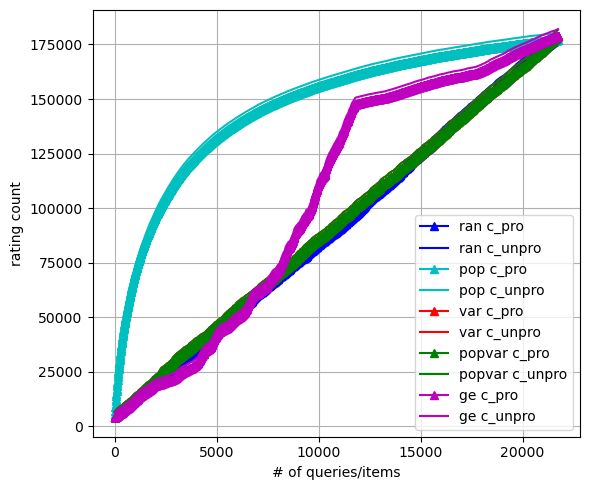

In [157]:
fig, ax = plt.subplots(figsize=(6, 5))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

# y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['c_pro'], m+'^', label=results[i][0]+' c_pro')
    ax.plot(y_axis, results[i][1]['c_unpro'], m, label=results[i][0]+' c_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('rating count')
# plt.title('Pro & Unpro Counts')
plt.show()
# plt.savefig('./plots/proUnpro_rate_c_ml_ratio.png', dpi=300)

# Something is off about this stupid thing!

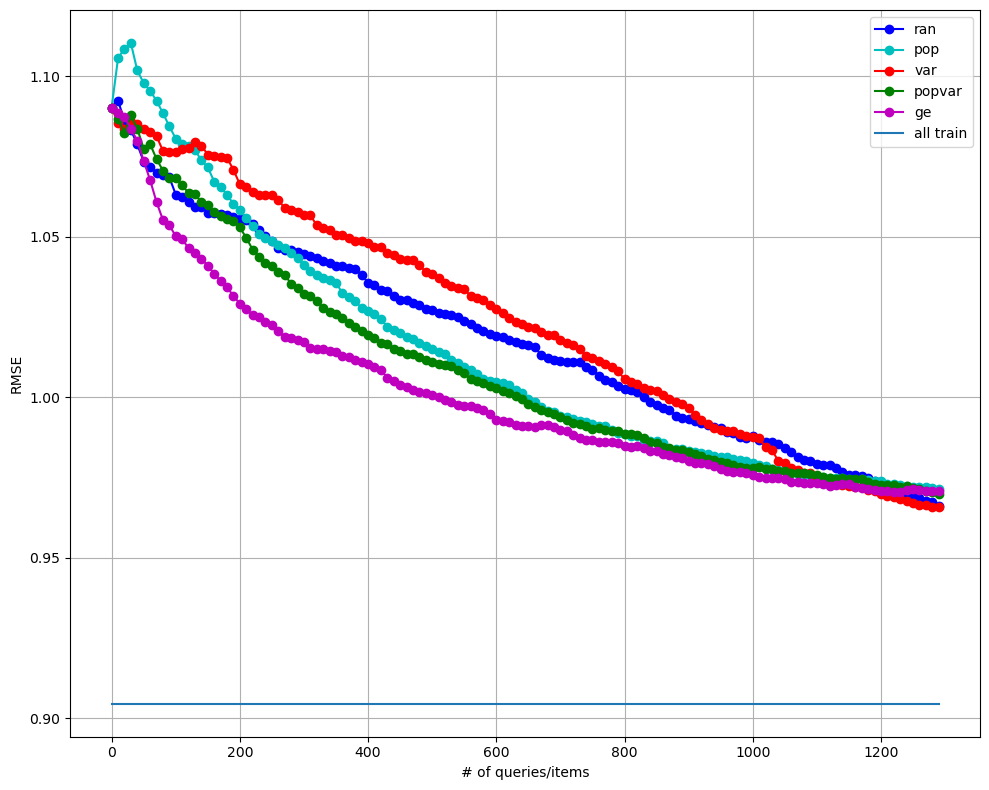

In [180]:
fig, ax = plt.subplots(figsize=(10,8))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    ax.plot(y_axis[:], results[i][1]['rmse'], m, label=results[i][0])
ax.plot(y_axis[:], [fin_acc]*len(y_axis),'-', label='all train')           
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
# plt.title('%s query/item at a time training'%w)

# plt.show()
#plt.savefig('./plots/nonPers_rmse_diff_ml_ratio', dpi=300)

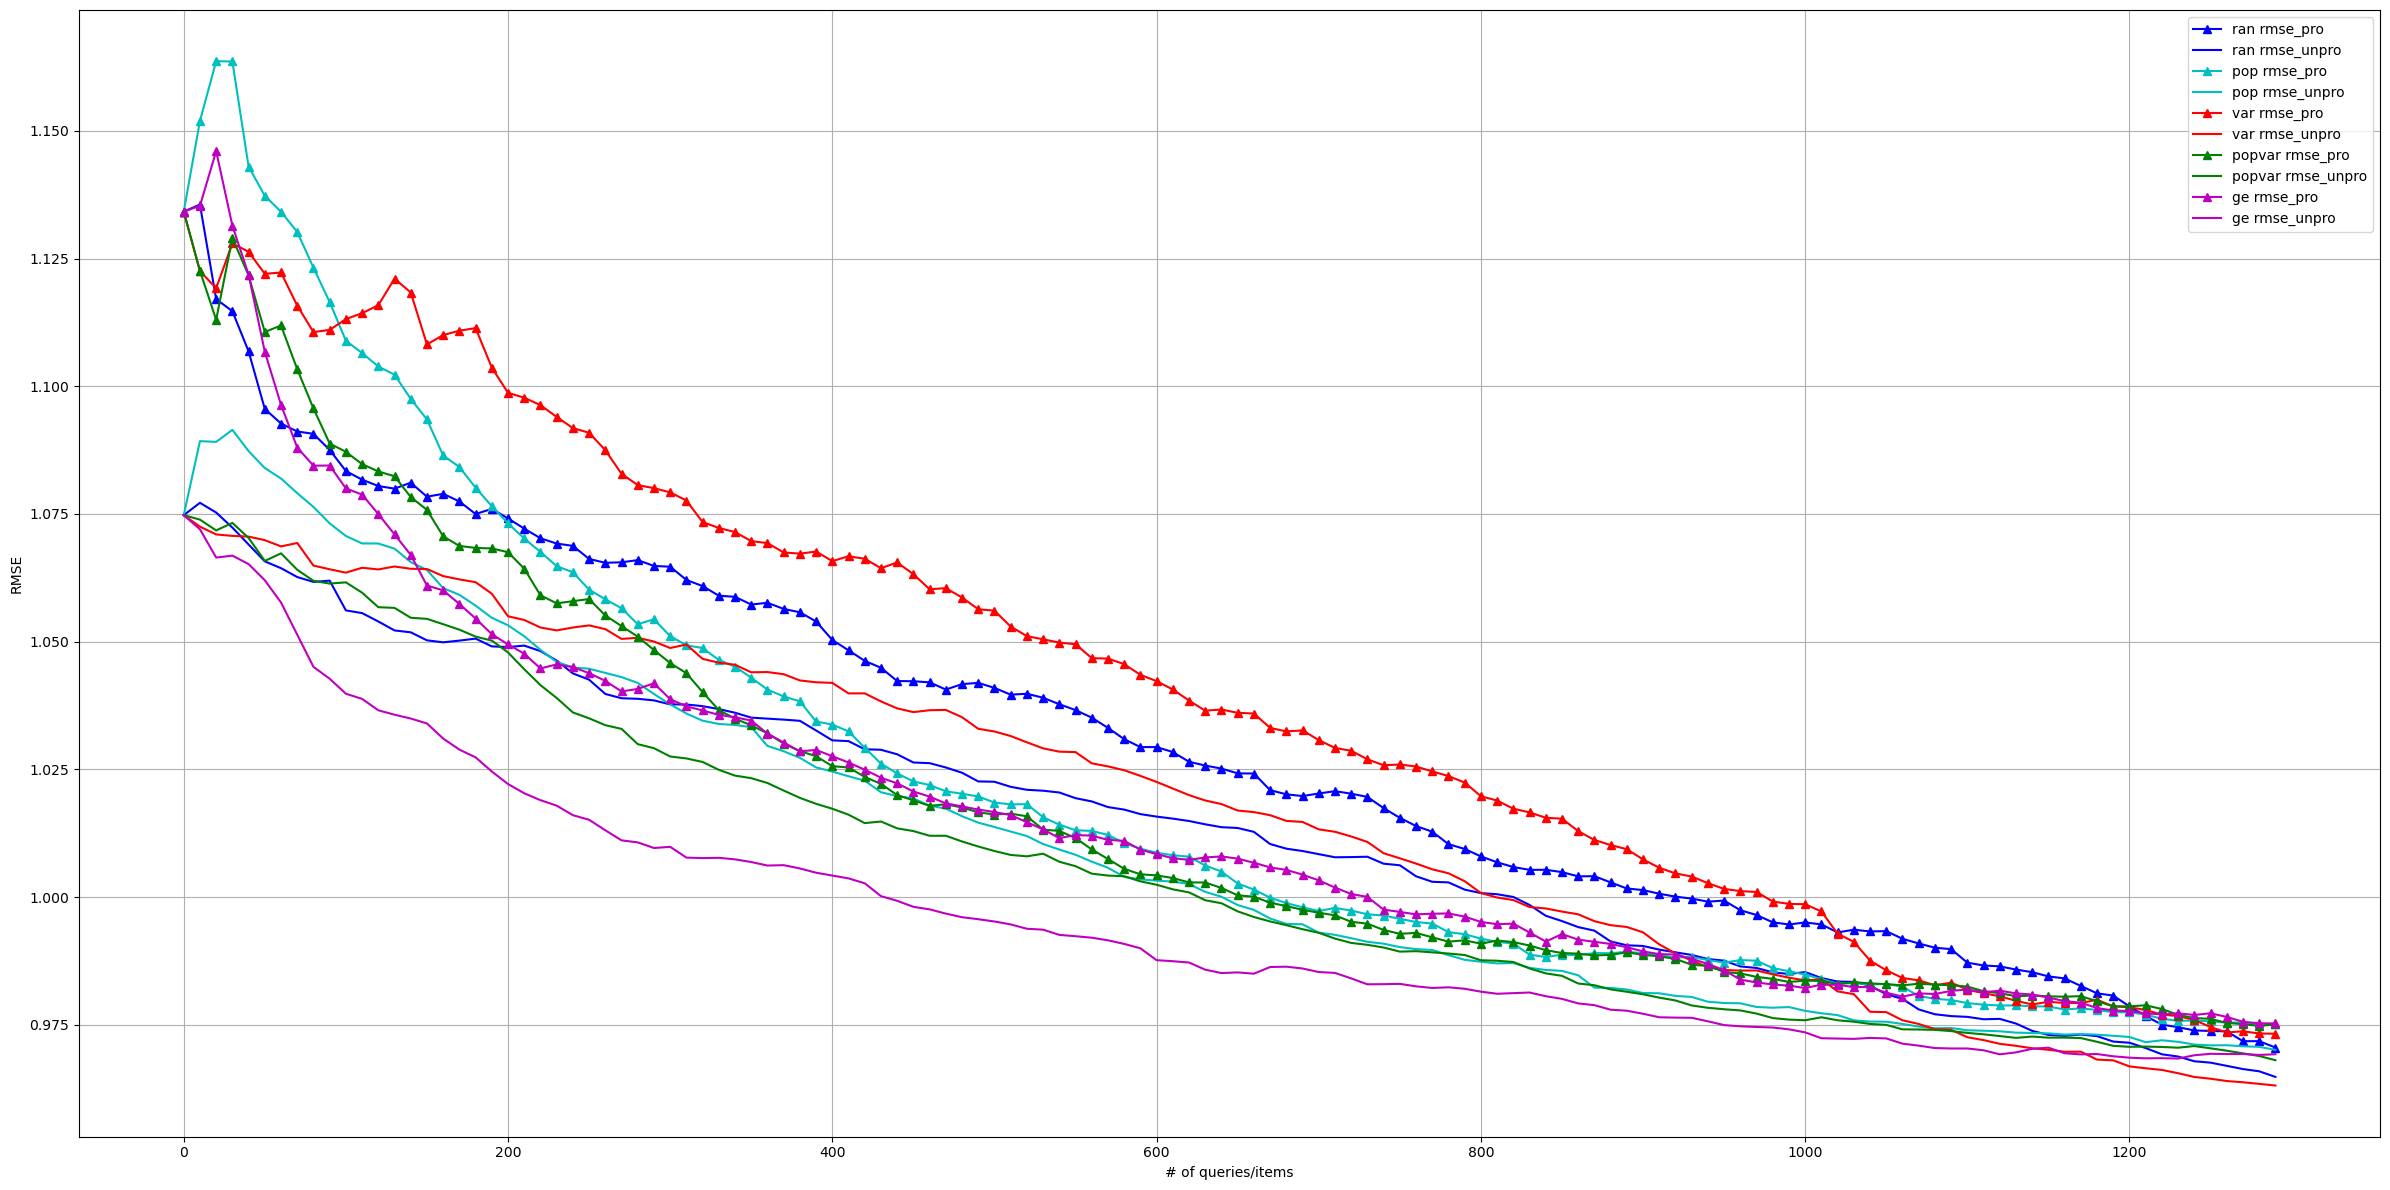

In [181]:
fig, ax = plt.subplots(figsize=(24,12))
marker_l = ['b-', 'c-', 'r-', 'g-', 'm-']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    ax.plot(y_axis, results[i][1]['rmse_pro'], m+'^', label=results[i][0]+' rmse_pro')
    ax.plot(y_axis, results[i][1]['rmse_unpro'], m, label=results[i][0]+' rmse_unpro')
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE')
# plt.title('RMSE in different AL methods')
# plt.show()
#plt.savefig('./plots/proUnpro_rmse_diff_ml012424_ratio.png', dpi=300)

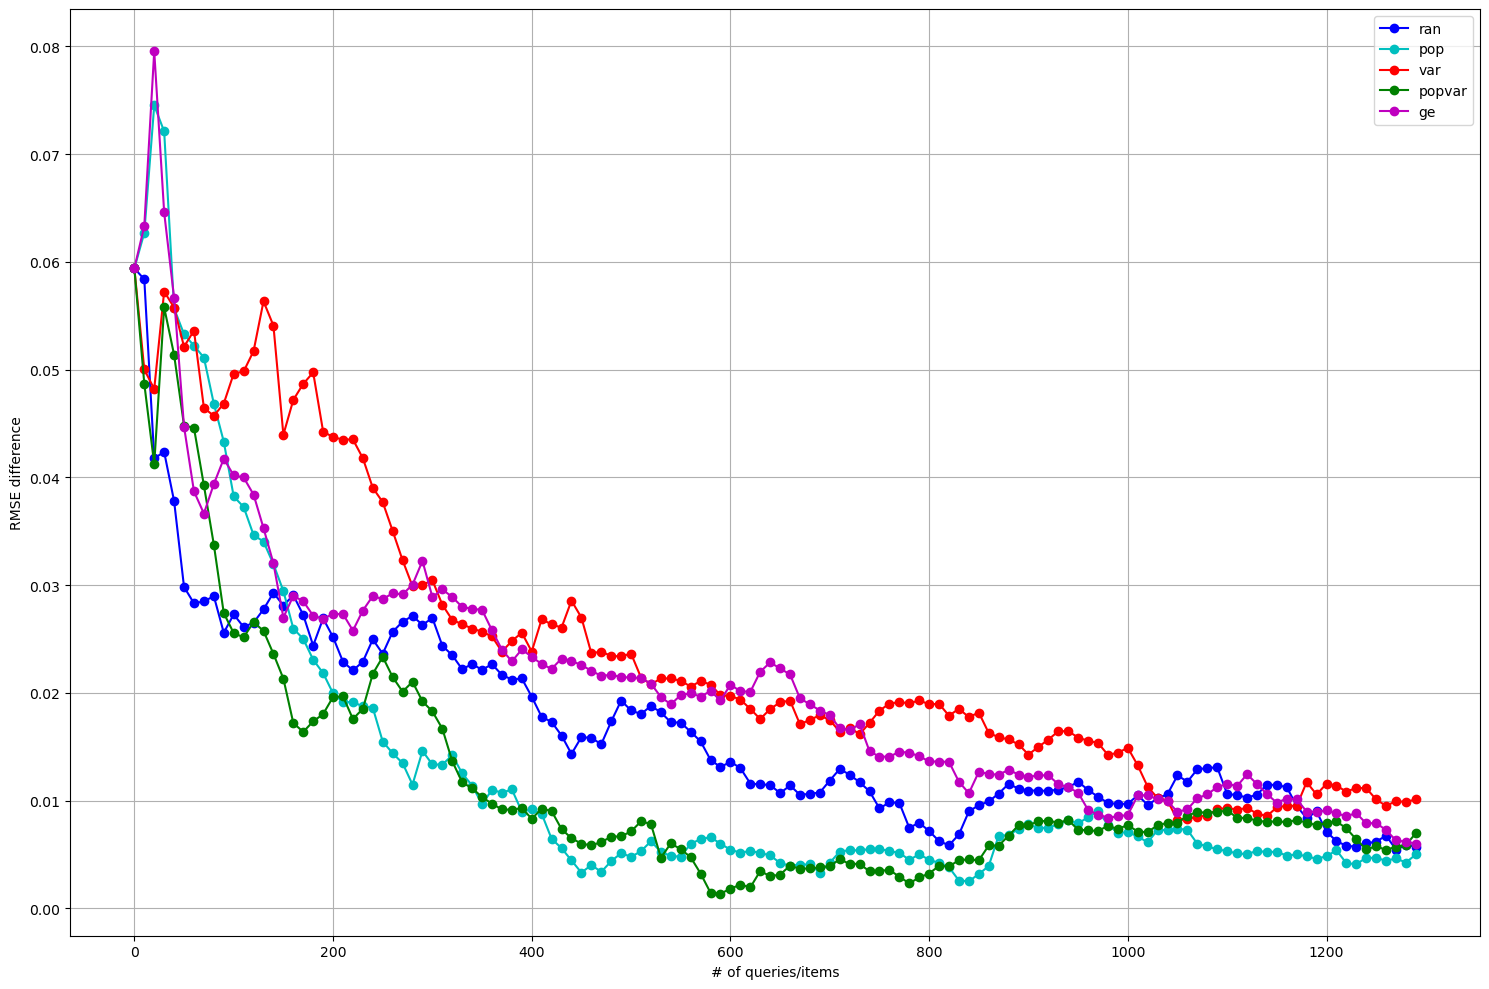

In [182]:
fig, ax = plt.subplots(figsize=(15,10))
marker_l = ['b-o', 'c-o', 'r-o', 'g-o', 'm-o']

y_axis = list(range(0, dataset.item_n, w))

for m, i in list(zip(marker_l, range(len(results)))):
    
    rmse_diff = [a-b for a, b in zip(results[i][1]['rmse_pro'], results[i][1]['rmse_unpro'])]
    ax.plot(y_axis[:], rmse_diff, m, label=results[i][0])
              
              
ax.grid(True)
legend = ax.legend(loc='best')
plt.xlabel('# of queries/items')
plt.ylabel('RMSE difference')
# plt.title('Unfairness in different AL methods')

# plt.show()
#plt.savefig('./plots/rmse_diff_ml012424_ratio.png', dpi=300)